In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

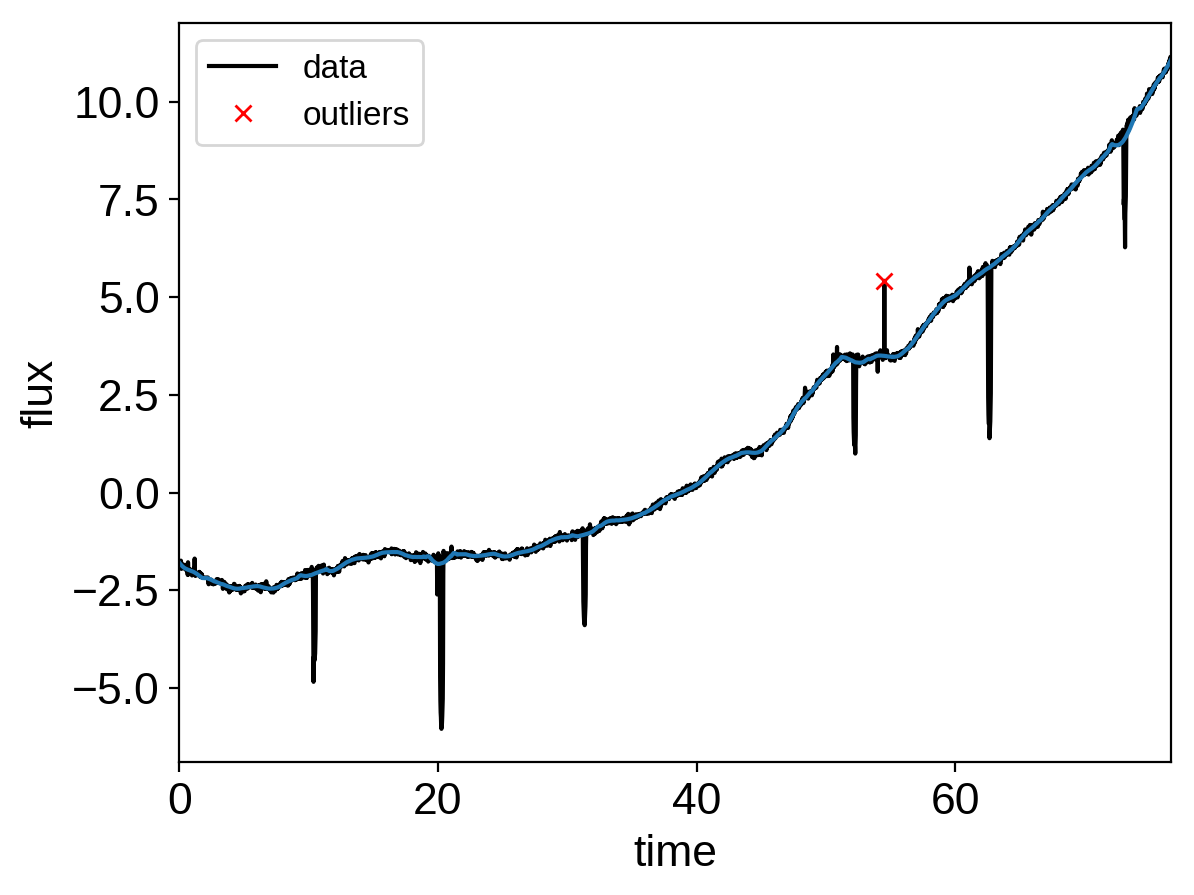

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

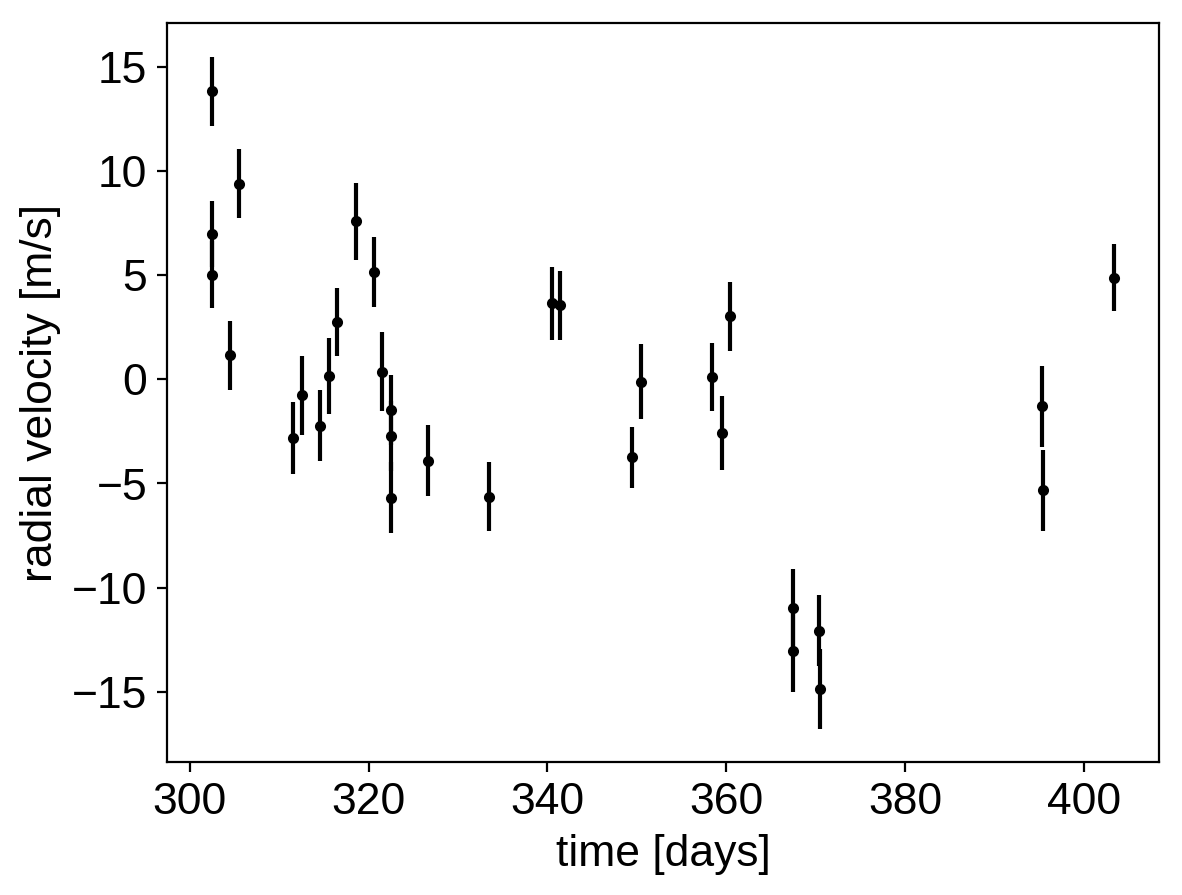

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

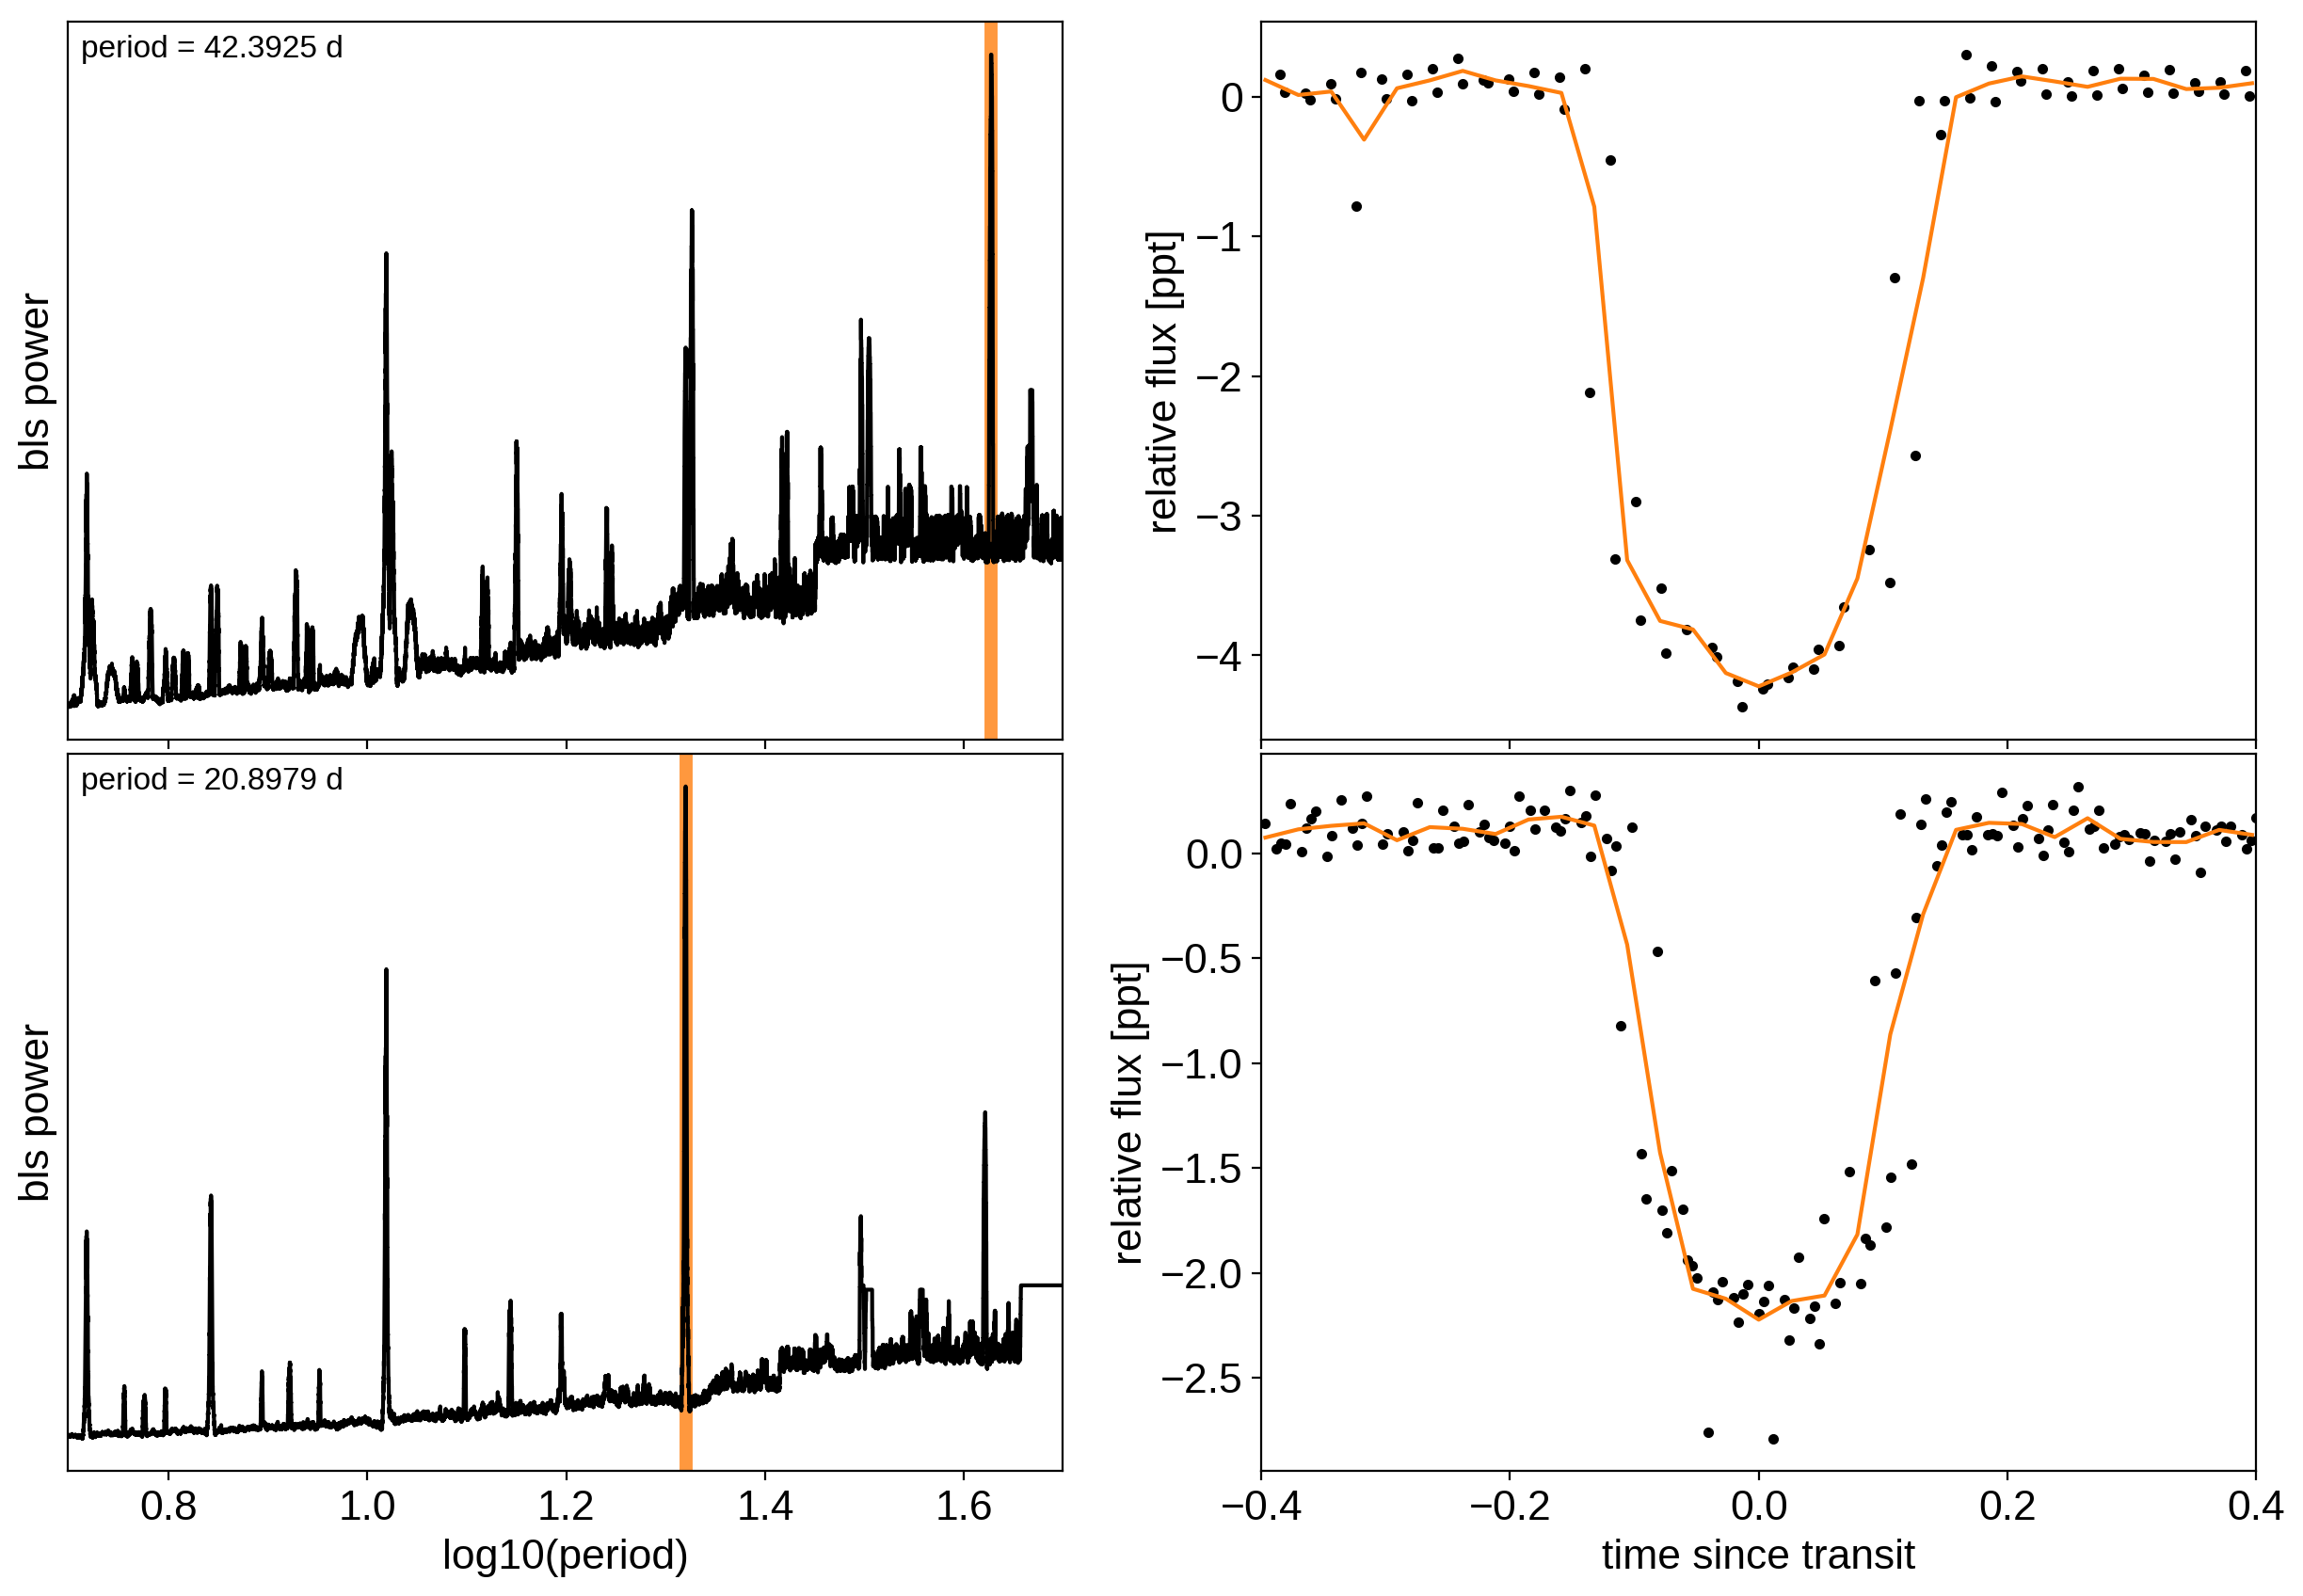

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.UnitUniform("b", shape=2)

        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, shape=2,
                          testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.57231984769 -> -8233.97212654762


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8233.97212654762 -> 1985.1953832396869


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 1985.1953832396869 -> 2679.698211595524


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2679.698211595524 -> 3334.211961863789


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 3334.211961863789 -> 4291.60277721198


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 4291.60277721198 -> 4365.5548628513325


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4365.5548628513325 -> 4777.103510779206


Now let's plot the map radial velocity model.

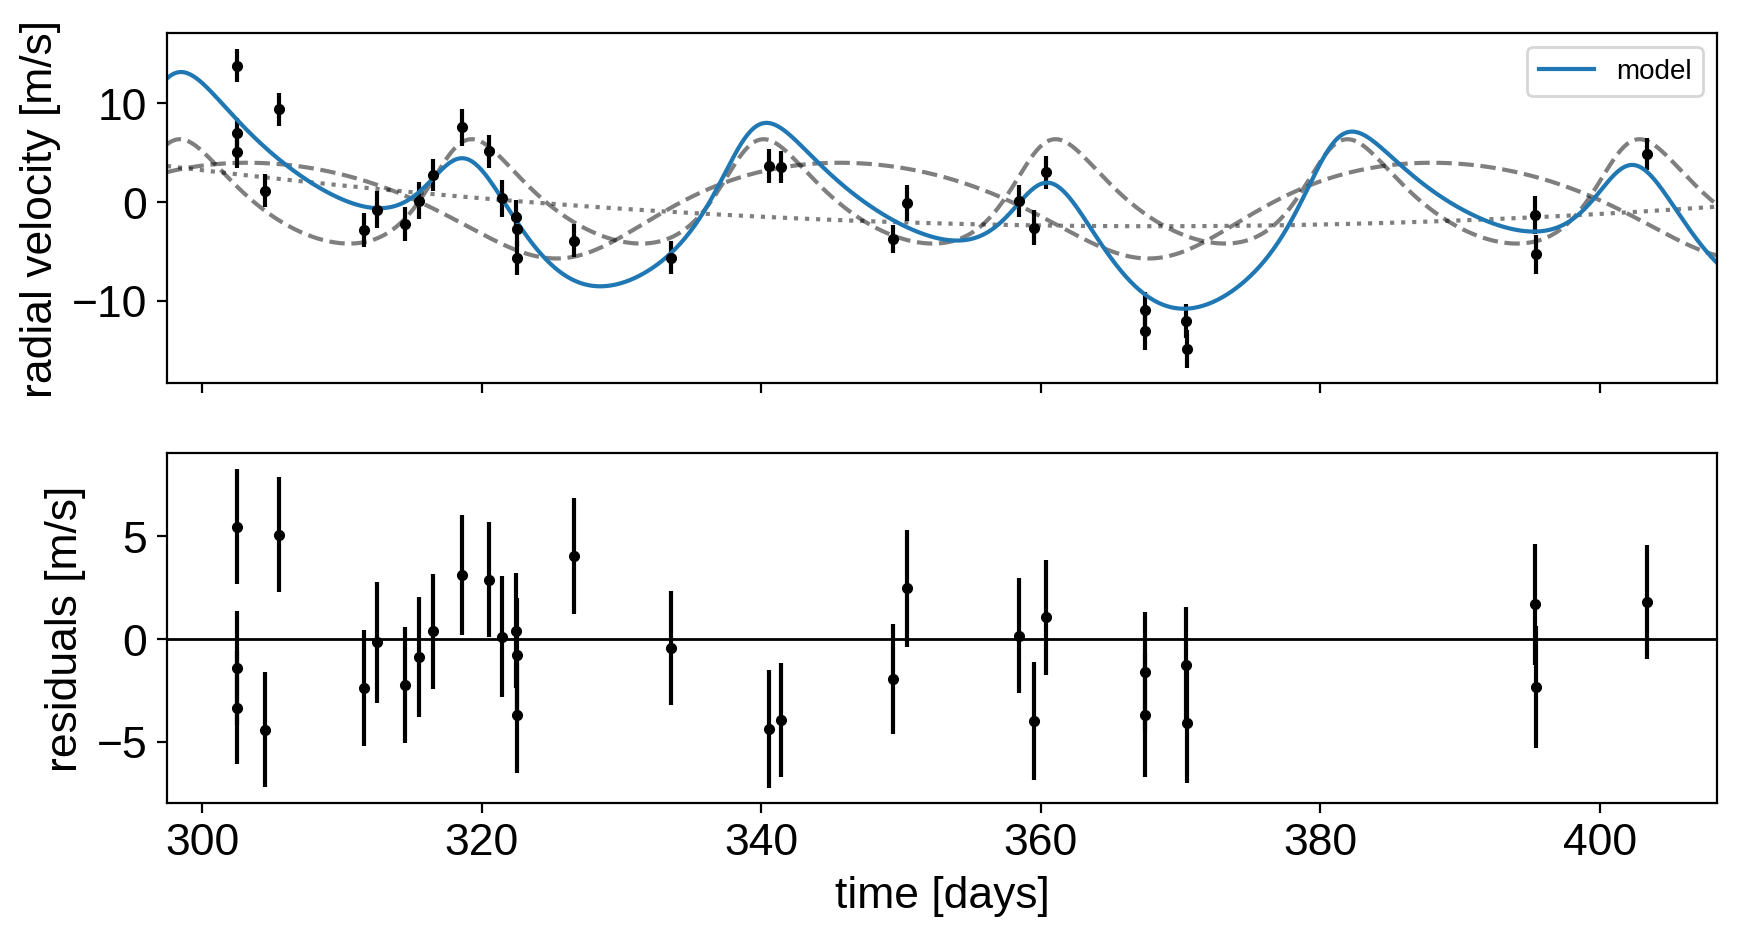

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

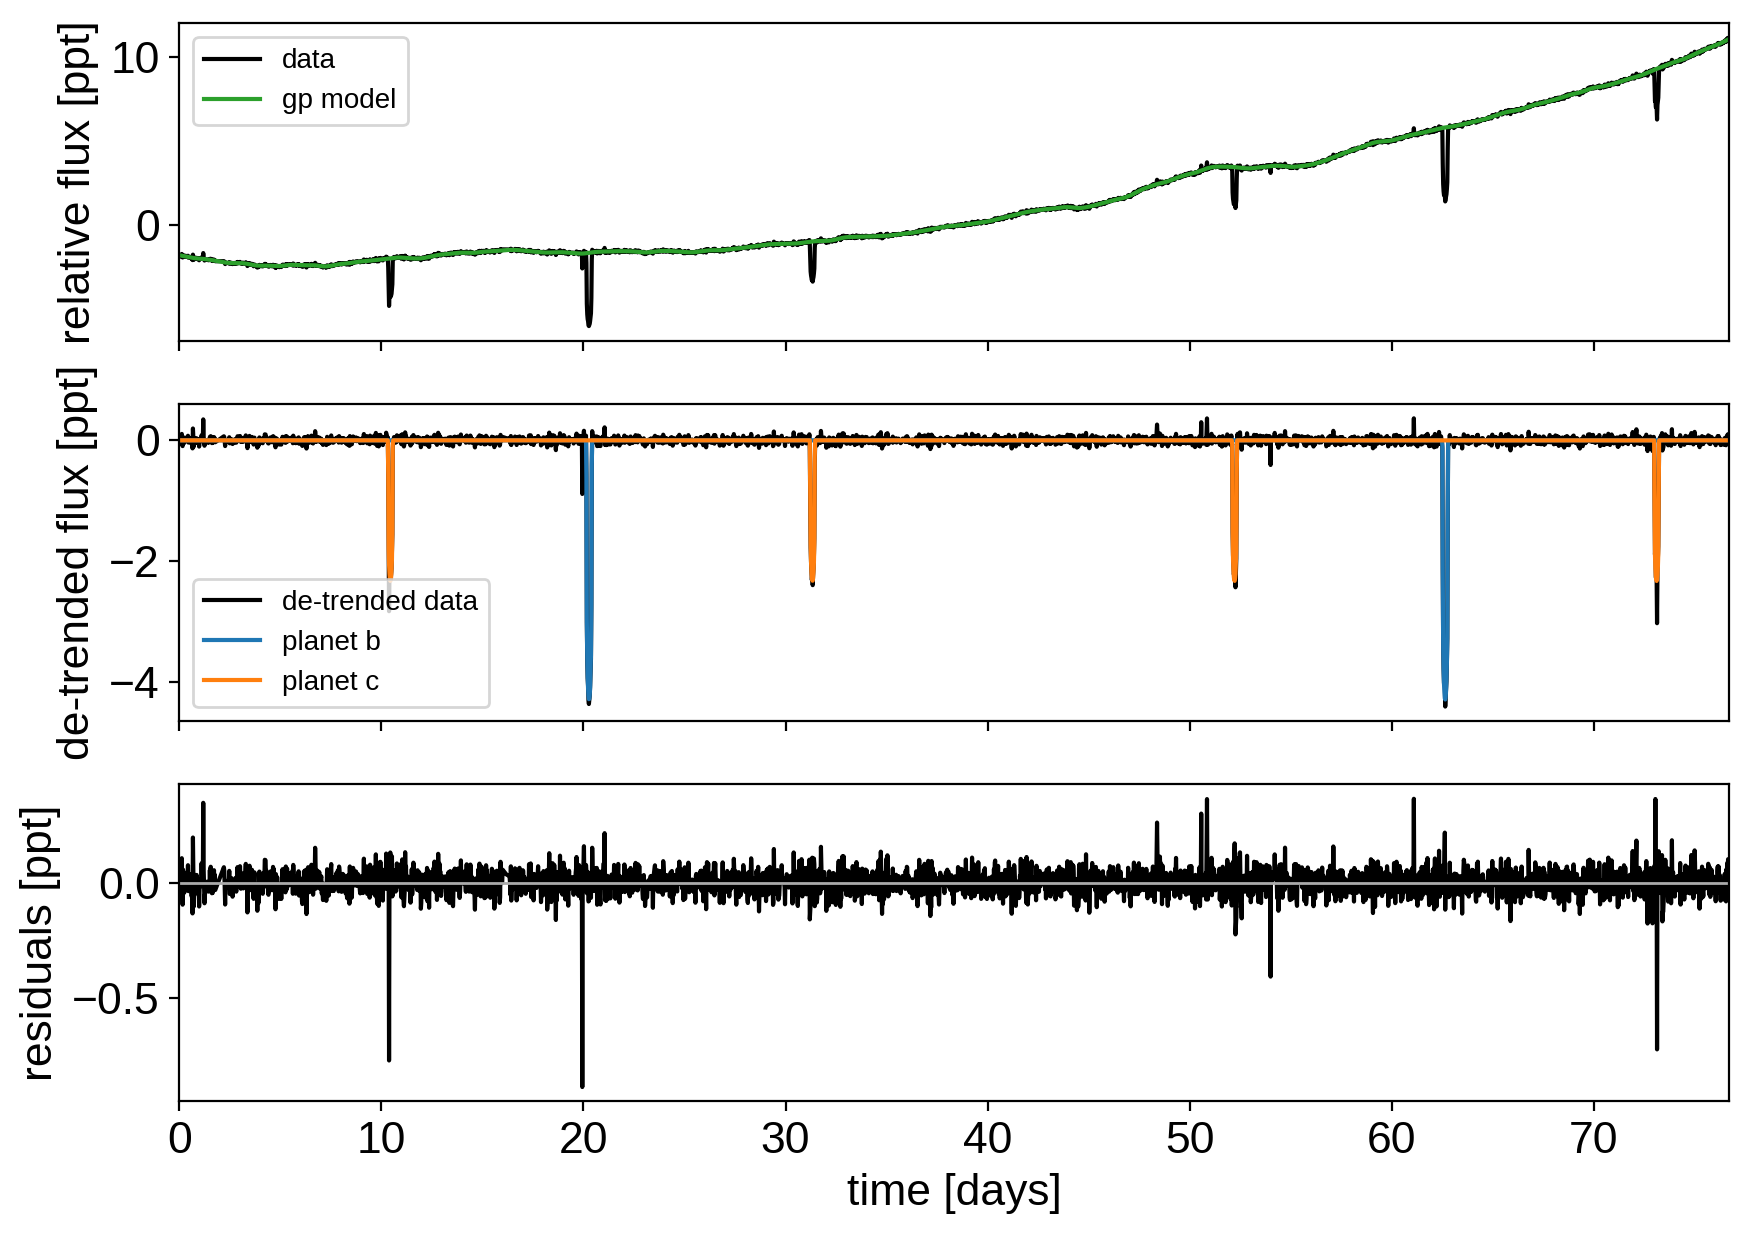

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

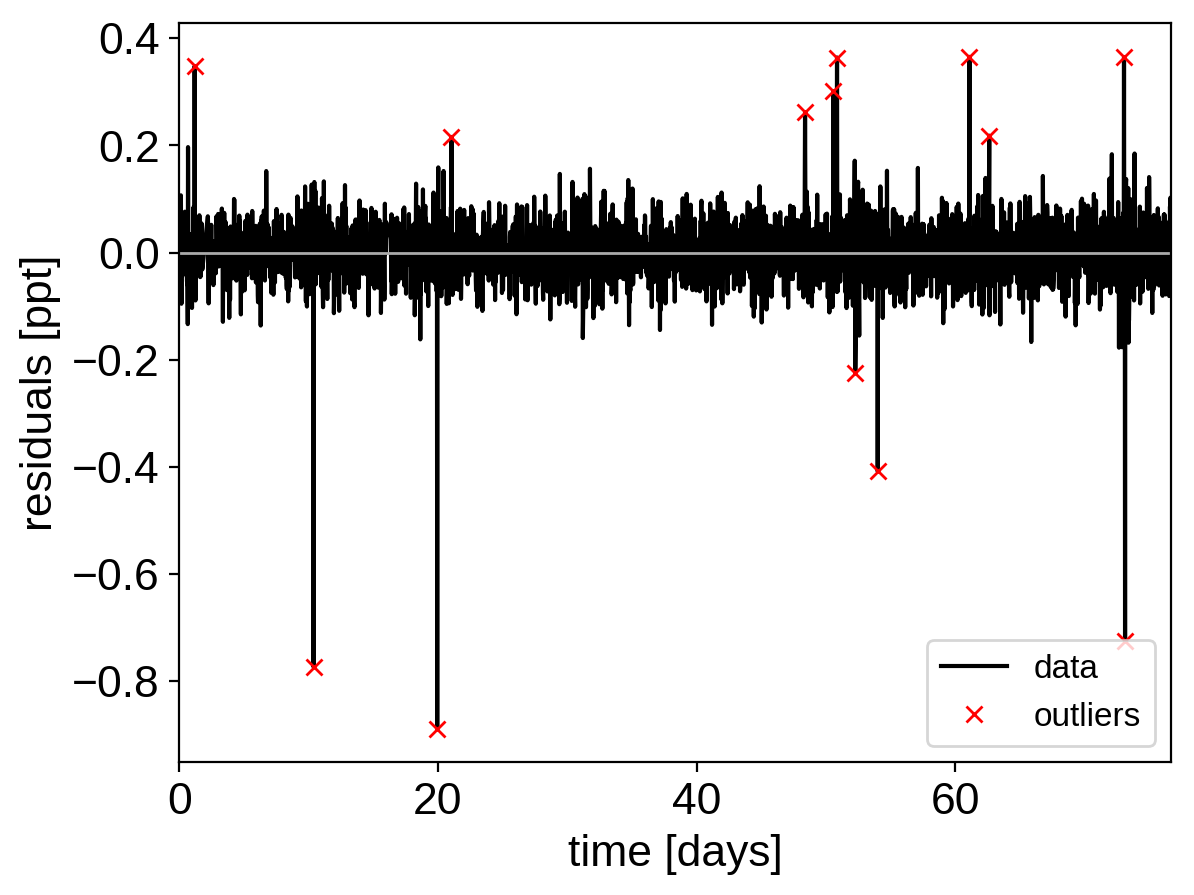

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5227.116863927315 -> 5227.116863927315


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: 5227.116863927315 -> 5309.223921472727


optimizing logp for variables: ['b_logodds__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 5309.223921472727 -> 5320.261402849443


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 5320.261402849443 -> 5321.717936508713


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.717936508713 -> 5322.452126980033


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.452126980033 -> 5322.486377217057


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.486377217056 -> 5324.305673578371


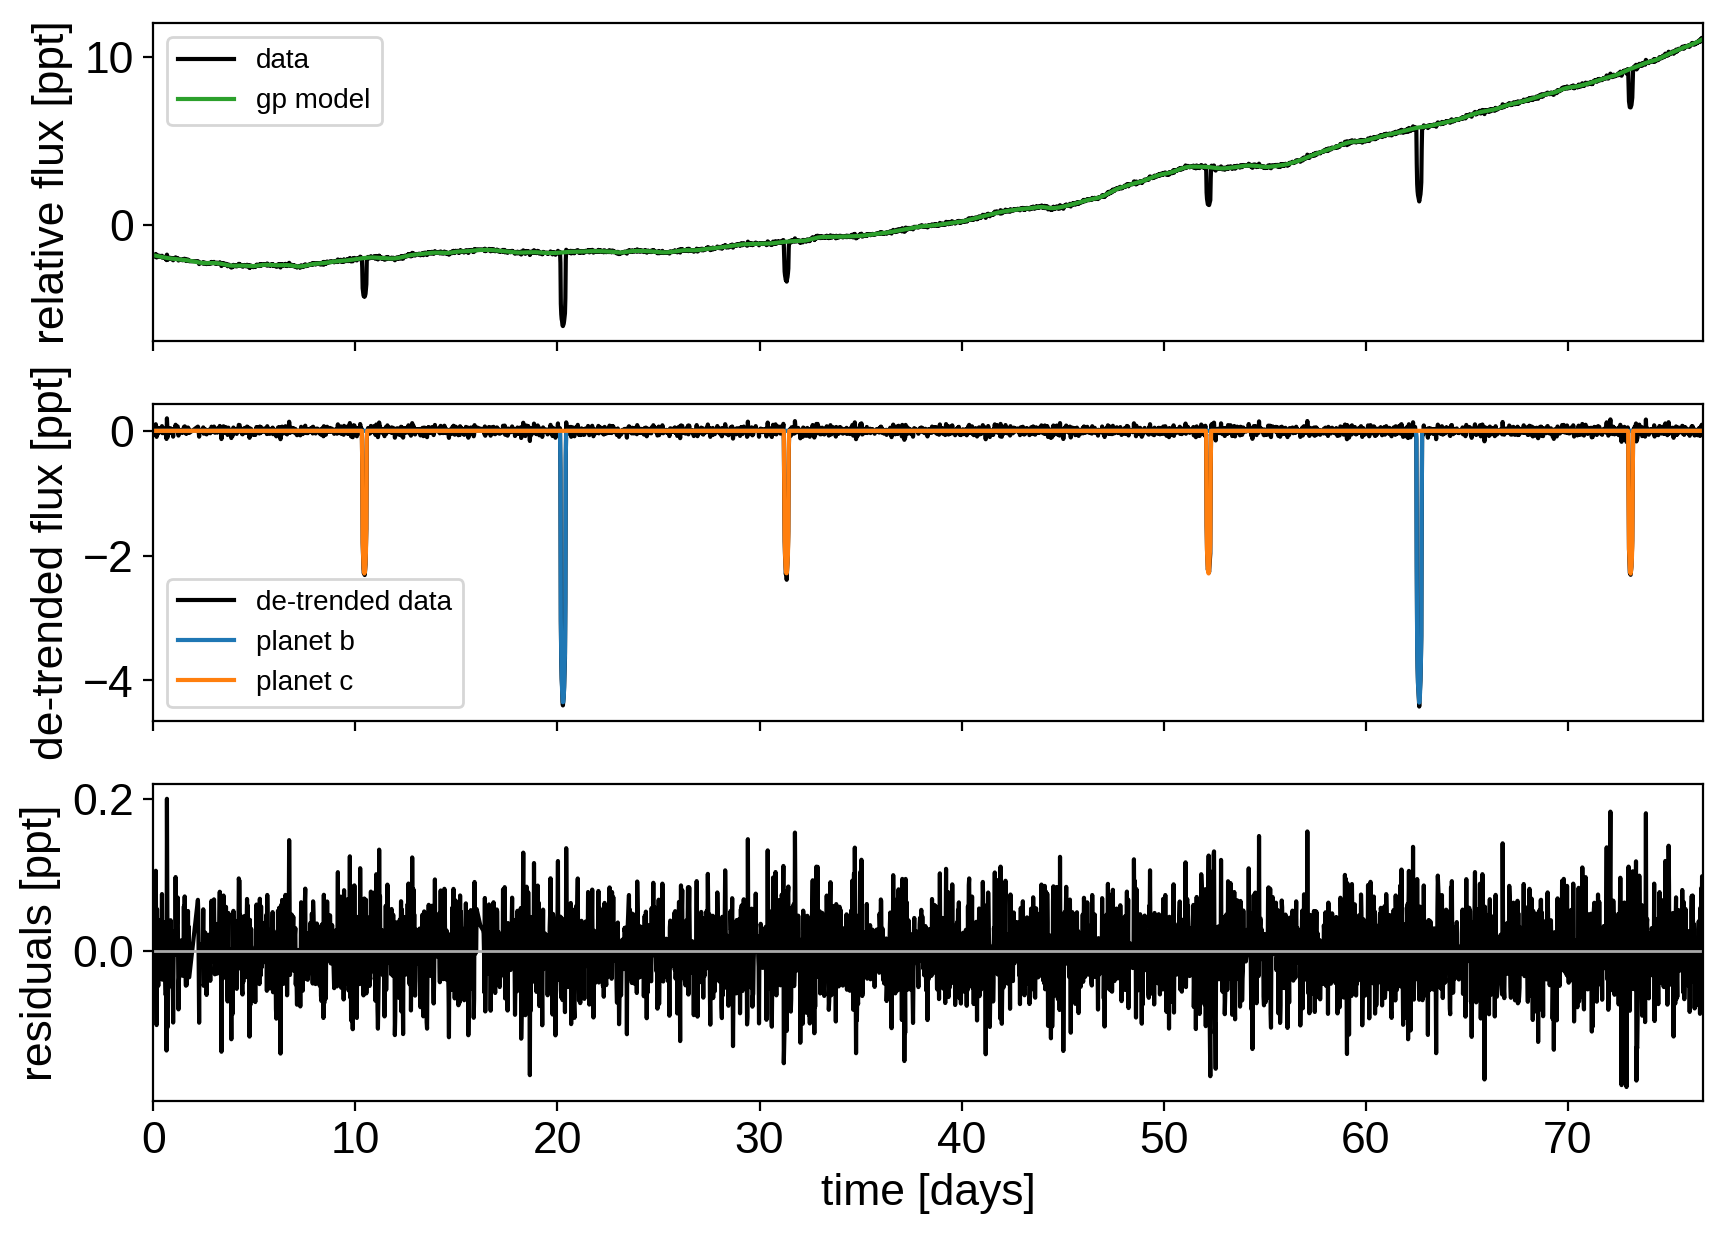

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:03, 199.51draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:01<00:49, 15.74draws/s] 

Sampling 4 chains:   4%|▍         | 31/808 [00:01<01:04, 11.98draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:02<01:20,  9.58draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:03<01:37,  7.90draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:03<01:49,  7.00draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:03<01:31,  8.35draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:04<01:57,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:04<01:37,  7.78draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:04<02:00,  6.28draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:04<01:39,  7.58draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:05<02:02,  6.18draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:05<01:41,  7.43draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:06<02:01,  6.19draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:06<01:41,  7.40draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:06<02:00,  6.20draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:06<01:41,  7.33draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:07<02:01,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:07<01:40,  7.34draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:07<01:59,  6.17draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:07<01:40,  7.32draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:08<01:59,  6.16draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:08<01:40,  7.33draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:09<01:57,  6.20draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:09<01:39,  7.34draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:09<01:56,  6.23draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:09<01:38,  7.32draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:10<01:56,  6.23draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:10<01:39,  7.28draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:10<01:55,  6.24draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:10<01:38,  7.28draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:11<01:53,  6.28draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:11<01:38,  7.26draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:11<01:52,  6.30draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:12<01:38,  7.21draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:12<01:51,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:12<01:37,  7.20draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:13<01:51,  6.30draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:13<01:37,  7.20draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:13<01:50,  6.33draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:13<01:36,  7.19draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:14<01:49,  6.35draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:14<01:36,  7.18draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:14<01:48,  6.38draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:15<01:36,  7.13draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:15<01:47,  6.40draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:15<01:36,  7.11draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:16<01:46,  6.40draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:16<01:35,  7.10draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:16<01:46,  6.40draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:16<01:35,  7.10draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:17<01:45,  6.42draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:17<01:34,  7.08draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:17<01:44,  6.44draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:18<01:35,  7.04draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:18<01:43,  6.47draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:18<01:34,  7.03draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:19<01:42,  6.49draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:19<01:31,  7.25draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:19<01:30,  7.33draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:19<01:38,  6.68draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:19<01:31,  7.14draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:20<01:39,  6.56draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:20<01:32,  7.04draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:20<01:39,  6.55draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:20<01:29,  7.29draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:21<01:29,  7.27draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:21<01:36,  6.71draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:21<01:27,  7.38draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:21<01:28,  7.30draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:22<01:34,  6.77draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:22<01:27,  7.37draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:22<01:28,  7.27draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:22<01:34,  6.76draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:22<01:26,  7.38draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:22<01:28,  7.21draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:23<01:33,  6.77draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:23<01:26,  7.35draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:23<01:26,  7.32draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:23<01:33,  6.77draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:23<01:25,  7.34draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:24<01:26,  7.26draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:24<01:32,  6.79draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:24<01:26,  7.25draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:24<01:24,  7.39draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:24<01:31,  6.83draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:25<01:25,  7.24draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:25<01:22,  7.51draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:25<01:30,  6.83draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:25<01:25,  7.27draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:25<01:20,  7.62draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:26<01:30,  6.79draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:26<01:23,  7.37draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:26<01:18,  7.85draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:26<01:28,  6.88draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:26<01:22,  7.41draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:27<01:12,  8.44draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:27<01:48,  5.59draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:27<01:36,  6.29draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:27<01:21,  7.38draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:27<01:54,  5.27draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:28<01:40,  5.98draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:28<01:24,  7.07draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:28<01:56,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:28<01:41,  5.90draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:28<01:25,  6.97draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:29<01:55,  5.14draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:29<01:41,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:29<01:25,  6.93draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:29<01:54,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:29<01:41,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:30<01:25,  6.90draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:30<01:53,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:30<01:40,  5.84draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:30<01:24,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:30<01:51,  5.23draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:31<01:39,  5.85draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:31<01:24,  6.87draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:31<01:52,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:31<01:38,  5.89draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:31<01:23,  6.89draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:32<01:50,  5.21draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:32<01:36,  5.93draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:32<01:22,  6.90draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:32<01:48,  5.25draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:32<01:35,  5.94draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:32<01:22,  6.89draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:33<01:47,  5.30draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:33<01:35,  5.94draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:33<01:21,  6.89draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:33<01:45,  5.33draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:33<01:34,  5.94draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:34<01:21,  6.85draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:34<01:44,  5.35draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:34<01:33,  5.96draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:34<01:21,  6.86draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:35<01:42,  5.39draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:35<01:32,  5.97draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:35<01:20,  6.85draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:35<01:41,  5.43draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:35<01:32,  5.95draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:35<01:20,  6.82draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:36<01:40,  5.46draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:36<01:31,  5.97draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:36<01:19,  6.82draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:36<01:38,  5.50draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:36<01:29,  6.05draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:37<01:19,  6.83draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:37<01:37,  5.51draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:37<01:27,  6.15draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:37<01:18,  6.87draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:38<01:36,  5.57draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:38<01:25,  6.24draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:38<01:17,  6.88draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:38<01:34,  5.62draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:38<01:23,  6.34draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:38<01:16,  6.90draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:39<01:32,  5.68draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:39<01:21,  6.43draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:39<01:15,  6.91draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:39<01:31,  5.73draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:39<01:19,  6.53draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:40<01:15,  6.92draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:40<01:32,  5.63draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:40<01:14,  6.94draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:40<01:24,  6.10draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:40<01:37,  5.29draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:41<01:18,  6.56draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:41<01:27,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:41<01:38,  5.21draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:41<01:18,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:41<01:27,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:42<01:37,  5.21draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:42<01:18,  6.42draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:42<01:27,  5.75draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:42<01:36,  5.23draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:42<01:17,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:43<01:27,  5.73draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:43<01:35,  5.21draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:43<01:17,  6.42draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:43<01:26,  5.73draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:43<01:34,  5.24draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:44<01:16,  6.43draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:44<01:25,  5.73draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:44<01:33,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:44<01:15,  6.45draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:44<01:25,  5.73draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:45<01:31,  5.32draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:45<01:15,  6.44draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:45<01:24,  5.75draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:45<01:29,  5.37draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:45<01:14,  6.48draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:46<01:23,  5.75draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:46<01:28,  5.38draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:46<01:13,  6.49draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:46<01:22,  5.74draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:46<01:27,  5.42draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:47<01:12,  6.51draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:47<01:22,  5.74draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:47<01:26,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:47<01:11,  6.53draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:47<01:21,  5.73draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:48<01:24,  5.50draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:48<01:10,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:48<01:21,  5.71draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:48<01:24,  5.47draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:48<01:10,  6.54draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:49<01:20,  5.70draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:49<01:23,  5.50draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:49<01:09,  6.56draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:49<01:20,  5.69draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:49<01:22,  5.51draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:50<01:08,  6.57draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:50<01:19,  5.67draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:50<01:21,  5.56draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:50<01:08,  6.59draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:50<01:20,  5.60draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:51<01:19,  5.65draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:51<01:07,  6.64draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:51<01:19,  5.59draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:51<01:17,  5.75draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:51<01:05,  6.69draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:52<01:18,  5.59draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:52<01:15,  5.85draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:52<01:04,  6.73draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:52<01:18,  5.58draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:52<01:13,  5.95draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:52<01:03,  6.77draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:53<01:17,  5.59draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:53<01:11,  6.05draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:53<01:02,  6.81draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:53<01:16,  5.57draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:53<01:10,  6.04draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:54<01:02,  6.81draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:54<01:16,  5.57draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:54<01:08,  6.14draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:54<01:01,  6.85draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:55<01:15,  5.56draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:55<01:06,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:55<01:00,  6.90draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:55<01:14,  5.57draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:55<01:05,  6.37draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:55<00:59,  6.94draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:56<01:13,  5.57draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:56<00:59,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:56<01:05,  6.24draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:56<01:18,  5.22draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:56<01:02,  6.50draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:57<01:07,  5.96draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:57<01:19,  5.09draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:57<01:02,  6.39draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:57<01:08,  5.87draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:57<01:19,  5.04draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:58<01:02,  6.35draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:58<01:08,  5.83draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:58<01:19,  4.99draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:58<01:02,  6.32draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:58<01:07,  5.81draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:59<01:18,  4.97draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:59<01:01,  6.32draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:59<01:10,  5.47draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:59<00:55,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:00<01:06,  5.75draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:00<00:52,  7.28draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:00<01:04,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:01<00:56,  6.64draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:01<01:11,  5.25draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:01<00:55,  6.72draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:02<01:05,  5.66draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:02<00:51,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:02<01:02,  5.90draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:02<00:49,  7.39draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:03<01:00,  6.03draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:03<00:48,  7.50draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:03<00:58,  6.11draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:04<00:47,  7.54draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:04<00:57,  6.15draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:04<00:47,  7.51draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:05<00:57,  6.15draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:05<00:46,  7.53draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:05<00:56,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:05<00:45,  7.52draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [01:06<00:55,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:06<00:45,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [01:06<00:54,  6.23draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:06<00:45,  7.50draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [01:07<00:53,  6.25draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:07<00:44,  7.44draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [01:08<00:52,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:08<00:44,  7.43draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:08<00:53,  6.11draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [01:08<00:57,  5.73draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:08<00:50,  6.51draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:08<00:49,  6.61draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [01:09<00:52,  6.16draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:09<00:47,  6.75draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:09<00:47,  6.80draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [01:09<00:50,  6.36draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:09<00:47,  6.77draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:10<00:46,  6.84draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [01:10<00:48,  6.48draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:10<00:46,  6.74draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:10<00:45,  6.83draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:10<00:47,  6.56draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:11<00:46,  6.68draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:11<00:45,  6.80draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:11<00:46,  6.63draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:11<00:46,  6.62draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:11<00:45,  6.76draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:12<00:45,  6.71draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:12<00:46,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:12<00:44,  6.72draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:12<00:44,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:12<00:46,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:13<00:44,  6.68draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:13<00:43,  6.84draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:13<00:46,  6.41draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:13<00:44,  6.64draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:13<00:42,  6.92draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:14<00:46,  6.32draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:14<00:43,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:14<00:41,  6.97draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:14<00:45,  6.27draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:14<00:43,  6.57draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:15<00:40,  7.05draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:15<00:45,  6.19draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:15<00:43,  6.53draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:15<00:39,  7.12draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:15<00:45,  6.12draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:16<00:42,  6.49draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:16<00:38,  7.20draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:16<00:45,  5.98draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:16<00:42,  6.44draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:17<00:43,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:17<00:40,  6.68draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:17<00:41,  6.43draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:17<00:38,  6.80draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:18<00:40,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:18<00:38,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:18<00:39,  6.57draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:19<00:37,  6.89draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:19<00:38,  6.61draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:19<00:36,  6.89draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:19<00:38,  6.60draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:20<00:36,  6.90draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:20<00:37,  6.62draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [01:20<00:35,  6.89draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:21<00:36,  6.63draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [01:21<00:35,  6.88draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:21<00:35,  6.65draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:22<00:34,  6.88draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:22<00:35,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:22<00:33,  6.87draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:22<00:34,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:23<00:33,  6.88draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:23<00:34,  6.66draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:23<00:32,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:24<00:33,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:24<00:32,  6.86draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:24<00:32,  6.68draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:24<00:31,  6.85draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:25<00:32,  6.69draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:25<00:30,  6.90draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:25<00:31,  6.65draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:26<00:30,  6.94draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:26<00:31,  6.64draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:26<00:29,  6.98draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:27<00:30,  6.63draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:27<00:28,  7.00draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:27<00:30,  6.61draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:27<00:28,  7.03draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:28<00:29,  6.60draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:28<00:27,  7.05draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:28<00:29,  6.55draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:29<00:26,  7.09draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:29<00:28,  6.54draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:29<00:26,  7.11draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:30<00:28,  6.53draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:30<00:25,  7.14draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:30<00:27,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:30<00:24,  7.16draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:31<00:26,  6.49draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:31<00:24,  7.19draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [01:31<00:26,  6.45draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [01:31<00:23,  7.22draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [01:32<00:25,  6.44draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:32<00:23,  7.20draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:32<00:20,  7.94draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:32<00:28,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:33<00:25,  6.41draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:33<00:22,  7.27draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:33<00:30,  5.30draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [01:33<00:24,  6.32draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:33<00:22,  6.95draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:34<00:29,  5.20draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:34<00:25,  6.03draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:34<00:21,  6.97draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:34<00:29,  5.20draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [01:34<00:24,  6.03draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:35<00:21,  6.97draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:35<00:28,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [01:35<00:24,  6.00draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:35<00:20,  6.96draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:35<00:27,  5.24draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [01:36<00:23,  5.97draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:36<00:20,  6.95draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:36<00:26,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [01:36<00:23,  5.94draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:36<00:19,  6.93draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:37<00:25,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [01:37<00:22,  5.91draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:37<00:19,  6.90draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:37<00:25,  5.24draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [01:37<00:22,  5.90draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:38<00:18,  6.90draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:38<00:24,  5.26draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [01:38<00:21,  5.88draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:38<00:17,  6.89draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:38<00:23,  5.28draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [01:39<00:20,  5.86draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:39<00:17,  6.88draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:39<00:22,  5.30draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [01:39<00:19,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:39<00:16,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:40<00:21,  5.32draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [01:40<00:19,  5.99draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:40<00:16,  6.90draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:40<00:20,  5.31draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [01:40<00:18,  6.09draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:40<00:15,  6.94draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:41<00:20,  5.35draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [01:41<00:17,  6.18draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:41<00:14,  6.96draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:41<00:19,  5.38draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:41<00:15,  6.63draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:42<00:15,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:42<00:19,  5.15draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:42<00:15,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:42<00:15,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:43<00:18,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:43<00:14,  6.28draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:43<00:14,  6.20draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:43<00:18,  5.05draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:43<00:14,  6.25draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:43<00:14,  6.15draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:44<00:17,  5.07draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:44<00:13,  6.25draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:44<00:13,  6.16draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:44<00:16,  5.09draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:44<00:12,  6.25draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [01:45<00:12,  6.19draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:45<00:15,  5.13draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [01:45<00:12,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:45<00:12,  6.21draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:45<00:14,  5.17draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [01:46<00:11,  6.27draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:46<00:11,  6.24draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:46<00:13,  5.20draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [01:46<00:10,  6.29draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [01:46<00:10,  6.25draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:47<00:12,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [01:47<00:10,  6.28draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [01:47<00:10,  6.27draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:47<00:12,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [01:47<00:09,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:48<00:09,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:48<00:11,  5.26draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [01:48<00:09,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:48<00:08,  6.31draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:48<00:10,  5.29draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [01:49<00:08,  6.31draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:49<00:08,  6.32draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [01:49<00:09,  5.31draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [01:49<00:07,  6.31draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [01:49<00:07,  6.33draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [01:50<00:08,  5.30draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [01:50<00:07,  6.32draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [01:50<00:06,  6.34draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:50<00:08,  5.32draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [01:50<00:06,  6.32draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [01:51<00:06,  6.36draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:51<00:07,  5.35draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [01:51<00:05,  6.32draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [01:51<00:05,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [01:51<00:06,  5.37draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [01:52<00:05,  6.32draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [01:52<00:04,  6.40draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [01:52<00:05,  5.40draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [01:52<00:04,  6.33draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [01:52<00:04,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [01:53<00:04,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [01:53<00:03,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [01:53<00:03,  6.45draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [01:53<00:04,  5.57draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [01:53<00:03,  6.34draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [01:53<00:03,  6.53draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [01:54<00:03,  5.68draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [01:54<00:02,  6.39draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:54<00:02,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [01:54<00:02,  5.78draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [01:55<00:02,  6.43draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [01:55<00:01,  6.63draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [01:55<00:02,  5.49draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [01:55<00:01,  5.34draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [01:55<00:01,  5.79draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [01:56<00:02,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [01:57<00:03,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [01:57<00:03,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [01:58<00:02,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [01:58<00:01,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [01:59<00:01,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:00<00:01,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:00<00:00,  1.80draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:00<00:00,  1.97draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:11, 32.42draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:01<00:25, 15.14draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:01<00:34, 10.95draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:02<00:41,  9.14draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:02<00:32, 11.45draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:03<00:51,  7.25draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:03<00:56,  6.45draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:03<00:43,  8.33draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:04<00:58,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:04<01:01,  5.88draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:04<00:46,  7.63draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:05<00:58,  6.07draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:05<00:47,  7.49draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:06<00:57,  6.11draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:06<00:46,  7.49draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:06<00:56,  6.13draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:06<00:47,  7.28draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:07<00:55,  6.14draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:07<00:46,  7.24draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:07<00:47,  7.14draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:07<00:40,  8.17draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:08<00:50,  6.62draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:08<00:43,  7.65draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:09<00:51,  6.42draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:09<00:43,  7.45draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:09<00:51,  6.34draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:09<00:44,  7.30draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:09<00:37,  8.58draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:10<00:39,  8.03draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:10<00:46,  6.80draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:10<00:43,  7.36draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:10<00:54,  5.75draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:11<00:48,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:11<00:44,  7.07draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:11<00:42,  7.31draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:11<00:52,  5.94draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:11<00:46,  6.66draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:11<00:43,  7.07draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:12<00:52,  5.78draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:12<00:46,  6.52draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:12<00:43,  7.03draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:12<00:54,  5.56draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:12<00:44,  6.80draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:13<00:46,  6.38draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:13<00:44,  6.62draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:13<00:40,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:13<00:38,  7.72draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:14<00:50,  5.85draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:14<00:43,  6.66draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:14<00:39,  7.26draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:14<00:51,  5.57draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:14<00:44,  6.41draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:14<00:40,  7.13draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:15<00:52,  5.42draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:15<00:45,  6.27draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:15<00:39,  7.06draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:15<00:53,  5.24draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:15<00:41,  6.65draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:16<00:49,  5.62draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:16<00:37,  7.33draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:17<00:46,  5.91draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:17<00:36,  7.49draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:17<00:45,  5.95draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:17<00:37,  7.09draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:18<00:40,  6.51draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:18<00:32,  8.09draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:18<00:41,  6.25draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:18<00:33,  7.77draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:19<00:41,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:19<00:33,  7.63draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:20<00:41,  6.09draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:20<00:32,  7.59draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:20<00:40,  6.07draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:20<00:32,  7.57draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:21<00:40,  6.06draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:21<00:31,  7.56draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:21<00:39,  6.05draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:21<00:31,  7.55draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:22<00:39,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:22<00:30,  7.55draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:23<00:38,  6.02draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:23<00:30,  7.47draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:23<00:37,  6.03draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:23<00:30,  7.49draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:24<00:36,  6.04draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:24<00:29,  7.51draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:24<00:36,  6.05draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:24<00:28,  7.51draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:25<00:35,  6.06draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:25<00:28,  7.61draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:25<00:35,  6.01draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:26<00:26,  7.82draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:26<00:34,  6.02draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:27<00:30,  6.59draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:27<00:23,  8.40draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:27<00:31,  6.18draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:28<00:32,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:28<00:25,  7.57draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:28<00:31,  6.03draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:29<00:24,  7.56draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:29<00:30,  6.06draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:29<00:24,  7.55draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:30<00:29,  6.08draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:30<00:23,  7.53draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:30<00:29,  6.10draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:30<00:23,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:31<00:28,  6.11draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:31<00:22,  7.48draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:31<00:27,  6.14draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:32<00:22,  7.46draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:32<00:26,  6.15draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:32<00:21,  7.44draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:33<00:26,  6.17draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:33<00:21,  7.42draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:33<00:25,  6.18draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:33<00:20,  7.40draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:34<00:18,  8.32draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:34<00:18,  7.95draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:34<00:19,  7.52draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:34<00:17,  8.44draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:34<00:23,  6.23draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:35<00:20,  7.20draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:35<00:22,  6.45draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:35<00:24,  5.77draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:35<00:21,  6.69draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:35<00:22,  6.14draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:36<00:24,  5.71draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:36<00:20,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:36<00:22,  6.05draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:36<00:23,  5.77draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:36<00:20,  6.56draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:37<00:21,  6.03draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:37<00:22,  5.87draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:37<00:19,  6.59draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:37<00:21,  6.02draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:37<00:21,  6.01draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:38<00:17,  7.17draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:38<00:19,  6.26draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:38<00:19,  6.39draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:38<00:16,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:38<00:16,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:38<00:19,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:38<00:18,  6.53draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:39<00:16,  7.20draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:39<00:16,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:39<00:19,  5.87draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:39<00:16,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:39<00:16,  6.68draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:40<00:19,  5.64draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:40<00:16,  6.49draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:40<00:16,  6.49draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:40<00:19,  5.52draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:40<00:16,  6.39draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:41<00:16,  6.37draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:41<00:18,  5.49draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:41<00:15,  6.60draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:41<00:13,  7.39draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:41<00:17,  5.67draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:42<00:15,  6.30draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:42<00:13,  7.04draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:42<00:17,  5.52draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:42<00:14,  6.30draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:42<00:13,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:43<00:16,  5.47draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:43<00:13,  6.72draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:43<00:13,  6.29draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:43<00:12,  6.55draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:43<00:10,  7.90draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:44<00:12,  6.31draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:44<00:10,  7.71draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:44<00:12,  6.19draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:44<00:09,  7.64draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:45<00:11,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:45<00:09,  7.62draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:46<00:11,  6.08draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:46<00:08,  7.63draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:46<00:10,  5.93draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:46<00:08,  7.10draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:47<00:08,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:47<00:08,  6.93draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:47<00:10,  5.40draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:48<00:08,  6.21draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:48<00:10,  5.15draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:48<00:08,  5.94draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:49<00:09,  5.10draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:49<00:07,  6.50draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:49<00:07,  5.73draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:49<00:08,  5.06draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:49<00:06,  6.22draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:49<00:07,  5.85draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:50<00:07,  5.19draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:50<00:06,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:50<00:05,  6.53draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:50<00:06,  5.64draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:50<00:05,  6.39draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:51<00:04,  6.78draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:51<00:05,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:51<00:04,  6.48draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:51<00:04,  7.14draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:51<00:04,  6.97draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:51<00:04,  6.12draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:52<00:04,  6.61draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:52<00:03,  6.83draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:52<00:03,  7.11draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:52<00:03,  6.32draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:52<00:03,  6.68draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:52<00:03,  6.80draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:52<00:02,  7.12draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:53<00:03,  6.45draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:53<00:02,  6.70draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:53<00:02,  6.35draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:53<00:02,  5.80draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:54<00:02,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:54<00:02,  5.43draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:54<00:02,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:55<00:01,  5.26draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:55<00:01,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:55<00:01,  5.87draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:55<00:00,  6.04draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:55<00:00,  5.69draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:56<00:00,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:56<00:00,  4.35draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:57<00:01,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:58<00:00,  1.56draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:58<00:00,  1.81draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<08:35,  1.57draws/s]

Sampling 4 chains:   1%|          | 5/808 [00:01<06:36,  2.03draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:01<05:12,  2.55draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:02<04:14,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:02<03:07,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:03<03:20,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:03<03:01,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:03<02:20,  5.58draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:04<02:36,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:04<02:04,  6.29draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:04<02:23,  5.44draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:05<02:06,  6.15draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:05<02:06,  6.11draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:05<01:58,  6.56draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:06<01:59,  6.45draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:06<01:53,  6.78draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:06<01:56,  6.60draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:06<01:53,  6.75draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:07<01:55,  6.62draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:07<01:53,  6.72draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:08<01:54,  6.64draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:08<01:53,  6.66draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:08<01:34,  8.03draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:08<02:21,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:08<02:12,  5.69draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:08<01:48,  6.90draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:09<02:27,  5.10draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:09<02:18,  5.41draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:09<01:57,  6.39draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:09<02:22,  5.24draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:10<02:16,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:10<01:56,  6.37draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:10<02:16,  5.43draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:10<02:14,  5.52draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:10<01:59,  6.17draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:11<02:08,  5.74draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:11<02:09,  5.72draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:11<01:57,  6.26draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:11<02:03,  5.97draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:11<02:08,  5.72draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:12<01:57,  6.26draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:12<01:58,  6.16draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:12<02:06,  5.78draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:12<01:56,  6.25draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:12<01:56,  6.27draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:13<02:03,  5.88draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:13<01:55,  6.26draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:13<01:53,  6.35draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:13<02:01,  5.92draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:14<01:57,  6.10draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:14<01:47,  6.71draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:14<01:56,  6.19draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:14<01:54,  6.24draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:14<01:43,  6.89draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:14<01:52,  6.33draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:15<01:43,  6.90draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:15<02:03,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:15<01:53,  6.25draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:15<01:45,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:15<02:06,  5.60draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:16<01:53,  6.22draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:16<01:45,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:16<02:16,  5.18draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:16<01:55,  6.10draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:16<01:47,  6.54draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:17<02:19,  5.03draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:17<01:57,  5.96draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:17<01:49,  6.39draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:17<02:16,  5.10draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:18<01:55,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:18<01:48,  6.40draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:18<02:14,  5.14draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:18<01:53,  6.06draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:18<01:48,  6.34draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:19<02:12,  5.20draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:19<01:53,  6.05draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:19<01:44,  6.56draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:19<02:06,  5.39draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:19<01:53,  6.04draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:19<01:42,  6.62draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:20<02:03,  5.52draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:20<01:54,  5.94draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:20<01:42,  6.58draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:20<02:01,  5.55draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:21<02:02,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:21<01:43,  6.49draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:21<02:02,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:21<02:04,  5.37draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:21<01:44,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:22<02:00,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:22<02:06,  5.29draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:22<01:45,  6.33draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:22<01:59,  5.57draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:22<02:06,  5.24draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:23<01:47,  6.16draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:23<01:54,  5.77draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:23<02:04,  5.30draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:23<01:46,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:23<01:50,  5.92draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:24<02:02,  5.34draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:24<01:45,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:24<01:48,  6.02draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:24<02:01,  5.37draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:24<01:44,  6.18draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:25<01:46,  6.07draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:25<02:02,  5.29draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:25<01:45,  6.14draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:25<01:45,  6.11draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:25<02:01,  5.28draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:26<01:45,  6.10draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:26<01:43,  6.21draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:26<02:01,  5.27draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:26<01:45,  6.06draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:26<01:37,  6.54draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:27<01:57,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:27<01:45,  6.02draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:27<01:35,  6.64draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:27<01:56,  5.40draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:27<01:49,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:28<01:34,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:28<01:57,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:28<01:56,  5.38draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:28<01:37,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:29<01:58,  5.24draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:29<01:56,  5.33draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:29<01:36,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:29<01:59,  5.19draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:29<02:01,  5.09draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:30<01:36,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:30<01:59,  5.16draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:30<02:01,  5.05draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:30<01:36,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:30<01:58,  5.15draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:31<02:05,  4.85draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:31<01:50,  5.49draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:31<02:00,  5.02draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:32<01:46,  5.68draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:32<01:59,  5.05draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:32<01:41,  5.91draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:33<01:40,  5.91draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:33<01:35,  6.26draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:33<01:36,  6.17draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:33<01:32,  6.38draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:34<01:33,  6.31draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:34<01:30,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:34<01:31,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:35<01:29,  6.52draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:35<01:30,  6.39draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:35<01:28,  6.54draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:36<01:29,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:36<01:27,  6.56draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:36<01:28,  6.50draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:37<01:27,  6.54draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:37<01:26,  6.55draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:37<01:26,  6.53draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:37<01:26,  6.54draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:38<01:26,  6.48draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:38<01:24,  6.60draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:38<01:26,  6.46draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:39<01:24,  6.63draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:39<01:20,  6.95draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:39<01:29,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:39<01:25,  6.47draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:39<01:23,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:40<01:30,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:40<01:25,  6.43draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:40<01:25,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:40<01:30,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:40<01:24,  6.47draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:41<01:27,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:41<01:29,  6.06draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:41<01:23,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:41<01:35,  5.68draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:41<01:27,  6.18draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:42<01:20,  6.64draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:42<01:35,  5.59draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:42<01:26,  6.18draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:42<01:19,  6.70draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:43<01:37,  5.47draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:43<01:25,  6.20draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:43<01:18,  6.71draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:43<01:37,  5.41draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:43<01:24,  6.20draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:44<01:17,  6.76draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:44<01:37,  5.36draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:44<01:24,  6.18draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:44<01:16,  6.78draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:44<01:38,  5.30draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:44<01:24,  6.16draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:45<01:16,  6.79draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:45<01:38,  5.25draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:45<01:22,  6.20draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:45<01:17,  6.65draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:46<01:40,  5.09draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:46<01:24,  6.05draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:46<01:16,  6.64draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:46<01:41,  5.00draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:46<01:24,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:47<01:15,  6.71draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:47<01:42,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:47<01:25,  5.90draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:47<01:32,  5.42draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:48<01:17,  6.41draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:48<01:26,  5.70draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:48<01:13,  6.71draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:49<01:24,  5.84draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:49<01:11,  6.84draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:49<01:22,  5.91draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:50<01:10,  6.91draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:50<01:21,  5.95draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:50<01:09,  6.94draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:51<01:19,  6.06draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:51<01:08,  7.03draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:51<01:18,  6.08draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:51<01:06,  7.08draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:52<01:17,  6.08draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:52<01:05,  7.12draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:52<01:17,  6.05draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:53<01:04,  7.17draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:53<01:17,  6.01draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:53<01:04,  7.17draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:54<01:16,  6.00draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:54<01:03,  7.17draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:54<01:15,  6.01draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:54<01:03,  7.17draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:55<01:15,  6.01draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:55<01:02,  7.15draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:55<01:14,  6.04draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:56<01:05,  6.79draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:56<00:55,  8.08draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:56<01:10,  6.25draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:56<00:57,  7.63draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:57<01:12,  6.03draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:57<00:58,  7.43draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:57<01:13,  5.92draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:58<00:58,  7.35draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:58<01:12,  5.94draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:58<00:58,  7.30draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:59<01:11,  5.95draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:59<00:59,  7.17draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:59<01:10,  5.96draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:59<00:58,  7.15draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [01:00<01:09,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:00<01:01,  6.81draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [01:00<01:04,  6.42draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [01:00<01:05,  6.35draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:01<01:01,  6.74draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [01:01<01:02,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:01<01:03,  6.43draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [01:01<00:59,  6.85draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [01:02<01:01,  6.62draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [01:02<01:03,  6.42draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:02<01:00,  6.70draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [01:02<01:01,  6.62draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [01:02<01:03,  6.37draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:02<01:00,  6.69draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:03<01:00,  6.58draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [01:03<01:02,  6.37draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:03<01:01,  6.42draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:03<01:00,  6.54draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [01:04<01:02,  6.35draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [01:04<01:01,  6.44draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:04<00:59,  6.54draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [01:04<01:01,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:04<01:02,  6.26draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:05<00:59,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:05<01:02,  6.24draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:05<01:00,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:05<00:58,  6.53draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:05<01:00,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:06<00:58,  6.48draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:06<00:58,  6.54draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:06<00:59,  6.35draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:06<00:57,  6.55draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:06<00:57,  6.55draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:07<00:58,  6.44draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:07<00:57,  6.55draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:07<00:56,  6.54draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [01:07<00:56,  6.57draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:07<00:56,  6.53draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:08<00:56,  6.53draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [01:08<00:54,  6.74draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:08<00:56,  6.48draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:08<00:50,  7.21draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:08<00:57,  6.32draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:08<00:54,  6.71draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:09<00:57,  6.31draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:09<00:51,  6.97draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:09<00:57,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:09<00:53,  6.72draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:09<00:57,  6.26draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:09<00:52,  6.82draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:10<00:56,  6.32draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:10<00:52,  6.82draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:10<00:56,  6.30draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:10<00:52,  6.70draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:10<00:55,  6.32draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:10<00:50,  6.97draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:10<00:55,  6.34draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:11<00:52,  6.58draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:11<00:55,  6.28draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:11<00:49,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:11<00:54,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:11<00:52,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [01:11<00:54,  6.27draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:11<00:48,  7.05draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:12<00:53,  6.42draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:12<00:52,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [01:12<00:54,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:12<00:51,  6.50draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:12<00:55,  6.08draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [01:13<00:53,  6.33draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:13<00:47,  7.10draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:13<00:50,  6.68draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:13<00:54,  6.07draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [01:13<00:52,  6.37draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:13<00:46,  7.13draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:13<00:48,  6.80draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:14<00:57,  5.74draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [01:14<00:50,  6.50draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:14<00:45,  7.19draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:14<00:47,  6.82draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:14<00:56,  5.74draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:15<00:49,  6.53draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:15<00:50,  6.32draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:15<00:58,  5.52draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:15<00:50,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [01:15<00:52,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:16<00:58,  5.46draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:16<00:50,  6.29draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [01:16<00:51,  6.05draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:16<00:57,  5.42draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:16<00:49,  6.27draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:17<00:51,  6.08draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:17<00:57,  5.35draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:17<00:49,  6.25draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:17<00:50,  6.05draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:17<00:57,  5.27draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:18<00:48,  6.22draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:18<00:51,  5.92draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:18<00:57,  5.19draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:18<00:48,  6.20draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:18<00:52,  5.72draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:19<00:57,  5.18draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:19<00:47,  6.24draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:19<00:52,  5.64draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:19<00:57,  5.10draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:19<00:46,  6.25draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:20<00:52,  5.54draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:20<00:57,  5.03draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:20<00:45,  6.27draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:20<00:52,  5.43draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:20<00:56,  5.01draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:21<00:45,  6.27draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [01:21<00:52,  5.34draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:21<00:56,  5.00draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:21<00:44,  6.30draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:21<00:52,  5.26draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:22<00:55,  4.99draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:22<00:43,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:22<00:52,  5.18draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:22<00:55,  4.93draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:22<00:42,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:23<00:50,  5.35draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:23<00:39,  6.84draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:24<00:47,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:24<00:43,  6.06draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:24<00:46,  5.59draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:25<00:42,  6.02draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:25<00:45,  5.63draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:25<00:35,  7.17draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:25<00:44,  5.75draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:26<00:41,  6.03draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:26<00:41,  5.95draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [01:26<00:39,  6.20draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [01:27<00:40,  6.01draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:27<00:32,  7.53draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [01:27<00:40,  5.92draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:27<00:32,  7.40draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:28<00:40,  5.90draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:28<00:32,  7.32draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:28<00:39,  5.90draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:29<00:31,  7.30draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:29<00:38,  5.92draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:29<00:31,  7.30draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:30<00:37,  5.99draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:30<00:30,  7.26draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:30<00:36,  6.05draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:30<00:30,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:31<00:35,  6.06draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:31<00:30,  7.16draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [01:31<00:39,  5.41draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:31<00:37,  5.63draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:32<00:31,  6.71draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [01:32<00:40,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:32<00:37,  5.56draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:32<00:31,  6.57draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [01:33<00:40,  5.14draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:33<00:36,  5.59draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:33<00:30,  6.55draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [01:33<00:39,  5.11draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:33<00:35,  5.73draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:34<00:30,  6.57draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [01:34<00:38,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:34<00:33,  5.79draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:34<00:29,  6.59draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [01:34<00:37,  5.15draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:35<00:32,  5.90draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:35<00:28,  6.63draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [01:35<00:36,  5.17draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:35<00:31,  6.02draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:35<00:28,  6.64draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [01:36<00:35,  5.22draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:36<00:30,  6.09draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:36<00:27,  6.63draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:36<00:34,  5.29draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:36<00:26,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:37<00:31,  5.74draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:37<00:36,  4.94draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:37<00:28,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:37<00:32,  5.46draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:38<00:35,  4.85draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:38<00:27,  6.22draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:38<00:31,  5.33draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:38<00:24,  6.78draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:39<00:29,  5.58draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:39<00:23,  7.11draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:39<00:28,  5.69draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:40<00:25,  6.19draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:40<00:28,  5.49draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:40<00:25,  6.00draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:41<00:28,  5.45draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:41<00:25,  5.94draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [01:41<00:27,  5.44draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:42<00:24,  5.92draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [01:42<00:26,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:42<00:24,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [01:42<00:25,  5.56draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:43<00:23,  5.97draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [01:43<00:24,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:43<00:22,  6.03draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [01:44<00:22,  5.91draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:44<00:21,  6.12draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [01:44<00:20,  6.26draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:45<00:20,  6.28draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [01:45<00:18,  6.71draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:45<00:19,  6.46draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:46<00:15,  7.70draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:46<00:19,  6.13draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:46<00:15,  7.48draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:47<00:19,  5.97draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [01:47<00:15,  7.40draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:47<00:18,  5.89draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [01:47<00:14,  7.42draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:48<00:18,  5.83draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:48<00:13,  7.65draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [01:48<00:17,  5.88draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:49<00:17,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:50<00:16,  5.85draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:50<00:15,  6.05draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:51<00:13,  6.21draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:51<00:10,  8.14draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [01:52<00:14,  5.83draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:52<00:13,  5.73draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:52<00:10,  7.48draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [01:53<00:13,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:53<00:12,  5.61draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [01:53<00:09,  6.98draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:54<00:11,  5.80draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [01:54<00:09,  7.08draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:55<00:10,  5.90draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [01:55<00:08,  7.13draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:55<00:09,  5.97draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [01:55<00:07,  7.13draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:56<00:09,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [01:56<00:07,  7.07draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [01:56<00:08,  6.08draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [01:57<00:06,  7.00draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [01:57<00:07,  6.14draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [01:57<00:06,  6.96draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:58<00:06,  6.18draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [01:58<00:05,  6.95draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:58<00:06,  6.21draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [01:58<00:05,  6.93draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [01:59<00:05,  6.26draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [01:59<00:04,  6.90draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [01:59<00:04,  6.29draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [02:00<00:04,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:00<00:04,  6.34draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [02:00<00:03,  6.71draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [02:01<00:03,  6.39draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [02:01<00:03,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [02:01<00:02,  6.44draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [02:01<00:02,  6.63draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [02:02<00:02,  5.98draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:02<00:02,  5.58draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:03<00:02,  4.59draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:03<00:02,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [02:04<00:02,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:04<00:02,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:04<00:02,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:05<00:01,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:05<00:01,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:06<00:02,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:07<00:01,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:07<00:01,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:08<00:00,  1.98draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:10<00:00,  1.04draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 5/1608 [00:00<00:36, 44.30draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:38, 41.14draws/s]

Sampling 4 chains:   1%|          | 11/1608 [00:00<01:12, 21.93draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<01:30, 17.63draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<02:04, 12.80draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:01<02:15, 11.76draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:01<02:11, 12.05draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:01<02:33, 10.31draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:01<03:10,  8.34draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:01<03:37,  7.30draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:02<03:02,  8.69draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:02<02:59,  8.81draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:02<02:52,  9.12draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:02<02:34, 10.19draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:02<02:49,  9.29draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:03<02:36, 10.07draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:03<02:14, 11.66draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:03<02:45,  9.48draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:03<02:31, 10.36draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:03<02:13, 11.73draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:03<01:59, 13.10draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:04<02:36,  9.95draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:04<02:38,  9.82draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:04<03:18,  7.83draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:05<03:05,  8.38draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:05<02:36,  9.90draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:05<03:01,  8.56draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:05<02:49,  9.10draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:05<02:28, 10.43draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:06<03:05,  8.32draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:06<02:39,  9.65draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:06<02:23, 10.72draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:06<02:18, 11.08draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:06<02:20, 10.94draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:06<02:29, 10.28draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:07<02:14, 11.36draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:07<03:12,  7.94draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:07<02:43,  9.34draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:08<02:38,  9.59draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:08<02:43,  9.33draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:08<02:38,  9.57draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:08<02:19, 10.90draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:08<02:30, 10.09draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:09<02:20, 10.78draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:09<02:34,  9.78draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:09<02:25, 10.33draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:10<02:54,  8.59draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:10<02:37,  9.54draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:10<02:30,  9.94draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:11<02:46,  8.97draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:11<03:04,  8.09draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:11<03:16,  7.59draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:11<02:34,  9.61draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:12<03:35,  6.90draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:12<02:52,  8.59draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:12<02:43,  9.02draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:12<02:24, 10.25draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:12<02:11, 11.23draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:13<02:13, 11.06draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:13<02:41,  9.12draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:13<02:18, 10.60draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:13<03:26,  7.12draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:14<02:48,  8.70draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:14<03:47,  6.43draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:14<03:03,  7.97draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:15<03:55,  6.18draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:15<03:02,  7.98draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:15<03:51,  6.28draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:15<03:00,  8.04draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:16<02:54,  8.30draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:16<02:56,  8.20draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:16<02:46,  8.66draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:16<02:15, 10.60draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:17<02:22, 10.08draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:17<02:34,  9.32draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:17<02:31,  9.47draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:17<02:33,  9.31draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:18<02:32,  9.35draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:18<02:25,  9.81draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:18<02:46,  8.55draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:18<02:21, 10.02draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:18<02:45,  8.59draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:19<02:47,  8.47draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:19<02:58,  7.96draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:19<02:53,  8.19draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:19<02:49,  8.36draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:19<02:54,  8.11draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:19<02:33,  9.23draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:20<02:52,  8.17draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:20<02:34,  9.13draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:20<02:19, 10.12draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:20<02:11, 10.66draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:20<02:00, 11.62draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:20<01:43, 13.58draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:21<01:33, 14.97draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:21<02:06, 11.02draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:21<01:50, 12.54draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:21<01:49, 12.70draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:21<01:48, 12.77draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:21<01:47, 12.89draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:22<01:46, 13.05draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:22<01:45, 13.13draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:22<02:02, 11.23draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:22<01:39, 13.79draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:22<01:46, 12.92draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:22<01:39, 13.74draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:23<01:40, 13.62draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:23<01:51, 12.30draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:23<01:45, 12.95draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:24<02:48,  8.09draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:24<02:20,  9.68draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:24<02:16,  9.99draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:24<02:02, 11.09draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:24<01:59, 11.32draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:24<01:57, 11.56draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:25<02:39,  8.45draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:25<02:09, 10.39draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:25<03:05,  7.24draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:25<02:39,  8.40draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:26<02:22,  9.39draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:26<03:06,  7.18draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:26<02:38,  8.46draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:26<02:23,  9.30draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [00:27<02:41,  8.26draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:27<02:22,  9.36draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:27<02:11, 10.15draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:27<02:32,  8.68draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:27<02:17,  9.63draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:28<02:07, 10.42draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:28<02:28,  8.92draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:28<02:19,  9.46draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:28<03:01,  7.24draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:29<02:49,  7.76draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:29<02:47,  7.84draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:29<03:00,  7.29draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:29<02:34,  8.50draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:29<02:18,  9.46draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:30<02:07, 10.25draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:30<01:59, 10.89draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:30<01:50, 11.81draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:30<01:49, 11.93draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:30<01:43, 12.59draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:30<02:08, 10.08draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:31<02:00, 10.77draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:31<02:00, 10.77draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:31<01:49, 11.75draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:31<01:50, 11.66draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:31<01:36, 13.30draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:31<01:39, 12.97draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:32<01:48, 11.78draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:32<02:00, 10.63draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [00:32<01:58, 10.76draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:32<02:03, 10.31draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:32<02:25,  8.76draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:33<02:40,  7.91draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:33<02:27,  8.61draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:33<02:31,  8.40draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:33<02:05, 10.11draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:33<02:05, 10.10draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:34<01:48, 11.64draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:34<02:13,  9.42draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [00:34<02:02, 10.29draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [00:34<01:54, 11.00draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:34<02:17,  9.15draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:35<02:14,  9.33draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [00:35<01:53, 11.00draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:35<01:59, 10.43draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:35<02:36,  7.97draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:36<02:25,  8.54draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:36<03:34,  5.79draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:36<02:49,  7.32draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:36<02:55,  7.06draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:37<03:18,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [00:37<02:37,  7.84draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:37<02:41,  7.67draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:37<02:35,  7.94draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:37<02:27,  8.38draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:38<02:34,  7.96draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:38<02:53,  7.07draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:38<02:35,  7.89draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:38<02:34,  7.96draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [00:38<02:48,  7.29draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:38<02:50,  7.20draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:38<02:32,  8.00draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [00:39<03:33,  5.72draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:39<02:52,  7.06draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:39<02:35,  7.82draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [00:39<02:29,  8.14draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:39<02:11,  9.22draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:40<01:55, 10.51draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [00:40<02:15,  8.93draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:40<02:05,  9.63draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:40<02:10,  9.27draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:40<02:06,  9.49draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:41<01:47, 11.20draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:41<01:38, 12.20draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:41<01:54, 10.45draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [00:41<01:41, 11.75draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [00:41<01:58, 10.06draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:42<02:18,  8.58draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [00:42<02:17,  8.67draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:42<02:40,  7.37draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [00:42<02:36,  7.56draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:43<02:10,  9.07draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [00:43<02:14,  8.78draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [00:43<02:19,  8.46draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [00:43<02:33,  7.68draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [00:44<02:08,  9.16draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:44<02:08,  9.15draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [00:44<02:13,  8.74draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:44<02:28,  7.90draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:44<02:12,  8.84draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [00:45<02:39,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [00:45<02:41,  7.20draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [00:45<02:15,  8.56draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:45<02:20,  8.29draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [00:45<02:19,  8.33draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:46<01:56,  9.91draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:46<02:50,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:46<02:12,  8.68draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:46<02:11,  8.76draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:47<02:20,  8.19draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:47<01:55,  9.90draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:47<02:00,  9.48draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:47<01:58,  9.62draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:48<01:49, 10.39draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:48<01:32, 12.28draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [00:48<01:34, 12.00draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [00:48<01:31, 12.29draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:48<01:37, 11.53draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [00:48<01:27, 12.82draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [00:49<01:27, 12.84draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [00:49<01:53,  9.88draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:49<02:02,  9.13draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:50<02:06,  8.83draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:50<01:54,  9.70draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [00:50<01:52,  9.90draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [00:50<01:54,  9.64draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [00:50<01:31, 12.03draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:51<01:36, 11.41draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [00:51<01:50,  9.94draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:51<01:43, 10.67draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [00:51<01:43, 10.64draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:52<01:57,  9.30draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [00:52<01:46, 10.23draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:52<01:44, 10.48draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:52<01:33, 11.66draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [00:52<01:34, 11.53draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:52<01:51,  9.72draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:53<01:42, 10.52draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:53<01:39, 10.81draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:53<01:34, 11.42draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [00:53<01:35, 11.21draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:53<01:34, 11.30draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [00:54<01:24, 12.72draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [00:54<01:48,  9.85draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:54<01:44, 10.17draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:54<01:31, 11.65draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [00:54<01:36, 10.98draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:55<01:29, 11.82draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:55<01:30, 11.73draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:55<01:53,  9.34draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [00:55<01:43, 10.15draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:55<01:44, 10.08draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [00:55<01:30, 11.60draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:56<01:52,  9.34draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [00:56<01:46,  9.85draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [00:56<01:35, 10.98draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [00:56<01:54,  9.07draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [00:57<01:59,  8.71draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [00:57<01:57,  8.87draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:57<02:24,  7.18draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [00:57<02:13,  7.79draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [00:57<01:49,  9.41draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:58<02:08,  8.02draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [00:58<02:03,  8.33draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:58<01:59,  8.62draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [00:58<02:24,  7.10draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [00:58<02:15,  7.58draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [00:59<02:06,  8.12draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [00:59<01:52,  9.13draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [00:59<01:42, 10.01draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [00:59<01:26, 11.70draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [00:59<01:34, 10.77draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:59<01:23, 12.12draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [00:59<01:26, 11.65draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [01:00<01:38, 10.29draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [01:00<01:31, 10.96draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [01:00<01:27, 11.49draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [01:00<01:25, 11.71draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [01:00<01:27, 11.39draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [01:01<01:18, 12.73draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [01:01<01:17, 12.81draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [01:01<01:17, 12.92draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [01:01<01:21, 12.20draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [01:01<01:14, 13.26draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [01:01<01:25, 11.54draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [01:02<01:25, 11.51draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [01:02<01:52,  8.75draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [01:02<01:55,  8.53draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [01:02<01:37, 10.04draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [01:03<01:44,  9.33draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [01:03<01:42,  9.50draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [01:03<01:39,  9.76draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [01:03<02:09,  7.50draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [01:04<01:49,  8.89draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [01:04<01:39,  9.78draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [01:04<01:54,  8.45draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [01:04<01:40,  9.57draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [01:04<01:33, 10.27draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [01:05<01:32, 10.38draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [01:05<01:43,  9.28draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [01:05<01:57,  8.13draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [01:05<01:51,  8.52draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [01:06<02:02,  7.79draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [01:06<01:39,  9.52draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [01:06<01:49,  8.61draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [01:06<02:02,  7.70draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [01:07<02:05,  7.54draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [01:07<02:33,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [01:07<01:58,  7.93draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [01:07<01:58,  7.90draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [01:08<02:07,  7.31draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [01:08<02:00,  7.74draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [01:08<01:54,  8.10draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [01:08<02:05,  7.40draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [01:08<01:59,  7.74draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [01:09<02:22,  6.52draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [01:09<02:01,  7.64draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [01:09<01:58,  7.79draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [01:09<02:18,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [01:09<02:05,  7.31draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [01:10<01:50,  8.34draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [01:10<02:48,  5.46draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [01:10<02:31,  6.07draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [01:10<02:09,  7.08draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [01:10<02:19,  6.54draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [01:10<02:12,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [01:11<02:09,  7.02draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [01:11<01:55,  7.89draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [01:11<01:55,  7.85draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [01:11<02:03,  7.35draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [01:11<02:08,  7.08draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [01:11<01:49,  8.23draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [01:12<01:38,  9.19draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [01:12<01:50,  8.16draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [01:12<01:53,  7.91draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [01:12<01:34,  9.49draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [01:12<01:27, 10.23draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [01:12<01:20, 11.09draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [01:13<01:16, 11.66draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [01:13<01:29,  9.89draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [01:13<01:42,  8.64draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [01:14<01:38,  8.98draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [01:14<01:35,  9.24draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [01:14<01:19, 10.99draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [01:14<01:18, 11.19draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [01:14<01:32,  9.41draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [01:15<01:23, 10.40draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [01:15<01:30,  9.60draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [01:15<01:30,  9.60draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [01:15<01:16, 11.29draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [01:15<01:39,  8.71draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [01:16<01:30,  9.54draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [01:16<01:55,  7.44draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [01:16<01:44,  8.24draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [01:16<01:28,  9.67draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [01:17<01:26,  9.87draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [01:17<01:37,  8.71draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [01:17<01:41,  8.37draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [01:17<01:26,  9.81draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [01:17<01:17, 10.91draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [01:18<01:32,  9.17draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [01:18<01:17, 10.90draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [01:18<01:32,  9.04draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [01:18<01:26,  9.69draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [01:19<01:56,  7.17draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [01:19<01:55,  7.22draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [01:19<01:41,  8.19draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [01:19<01:48,  7.65draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [01:19<01:53,  7.32draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [01:19<01:37,  8.45draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [01:20<01:50,  7.51draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [01:20<01:50,  7.49draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [01:20<01:54,  7.19draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [01:20<01:38,  8.34draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [01:20<01:54,  7.20draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [01:20<01:49,  7.48draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [01:20<01:34,  8.63draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [01:21<01:25,  9.58draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [01:21<01:24,  9.68draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [01:21<01:10, 11.55draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [01:21<01:10, 11.47draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [01:21<01:05, 12.27draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [01:22<01:06, 12.02draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [01:22<01:09, 11.53draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [01:22<01:02, 12.73draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [01:22<01:16, 10.39draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [01:22<01:25,  9.30draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [01:23<01:18, 10.16draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [01:23<01:16, 10.41draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [01:23<01:29,  8.87draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [01:23<01:17, 10.24draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [01:23<01:07, 11.59draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [01:24<01:23,  9.42draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [01:24<01:12, 10.79draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [01:24<01:11, 10.87draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [01:24<01:25,  9.09draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [01:24<01:13, 10.50draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [01:25<01:12, 10.65draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [01:25<01:34,  8.15draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [01:25<01:24,  9.10draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [01:26<01:34,  8.15draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [01:26<01:29,  8.59draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [01:26<02:58,  4.29draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [01:26<02:16,  5.61draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [01:27<02:19,  5.44draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [01:27<02:01,  6.27draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [01:27<01:49,  6.95draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [01:27<01:34,  7.95draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [01:27<01:39,  7.55draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [01:28<01:43,  7.28draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [01:28<02:15,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [01:28<01:48,  6.92draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [01:28<01:57,  6.35draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [01:28<01:49,  6.80draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [01:29<01:36,  7.68draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [01:29<01:24,  8.75draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [01:29<01:48,  6.84draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [01:29<01:27,  8.43draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [01:30<01:51,  6.62draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [01:30<01:34,  7.78draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [01:30<01:23,  8.81draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [01:30<01:08, 10.63draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [01:30<01:04, 11.30draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [01:31<00:57, 12.64draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [01:31<00:57, 12.60draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [01:31<01:09, 10.38draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [01:31<01:04, 11.10draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:31<01:04, 11.01draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [01:32<01:02, 11.35draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [01:32<00:59, 12.00draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [01:32<00:59, 11.99draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [01:32<00:56, 12.56draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [01:32<00:57, 12.28draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [01:32<01:12,  9.64draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [01:33<01:04, 10.83draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [01:33<01:12,  9.66draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [01:33<01:05, 10.65draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [01:33<01:08, 10.20draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [01:34<01:19,  8.73draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [01:34<01:27,  7.92draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [01:34<01:21,  8.41draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [01:34<01:17,  8.79draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [01:35<01:09,  9.83draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [01:35<01:03, 10.63draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [01:35<00:59, 11.33draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [01:35<00:54, 12.32draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [01:35<00:49, 13.52draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [01:36<01:05, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [01:36<01:14,  8.99draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [01:36<01:12,  9.26draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [01:36<01:05, 10.19draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [01:36<00:56, 11.69draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [01:37<00:59, 11.13draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [01:37<01:03, 10.44draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [01:37<01:06,  9.79draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [01:37<01:03, 10.27draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [01:37<01:03, 10.21draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [01:38<01:04, 10.06draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [01:38<01:14,  8.65draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [01:38<01:13,  8.78draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:39<01:21,  7.91draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [01:39<01:12,  8.86draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [01:39<01:19,  8.09draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [01:39<01:24,  7.54draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [01:39<01:38,  6.46draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [01:39<01:32,  6.87draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [01:40<01:18,  8.02draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [01:40<01:23,  7.52draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [01:40<01:17,  8.11draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [01:41<01:07,  9.18draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:41<01:15,  8.23draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [01:41<01:05,  9.45draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [01:41<01:00, 10.24draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [01:42<01:03,  9.63draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [01:42<01:05,  9.30draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [01:42<01:43,  5.94draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [01:42<01:28,  6.92draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [01:42<01:26,  7.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:43<01:16,  7.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [01:43<01:18,  7.75draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [01:43<01:14,  8.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [01:43<01:29,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [01:43<01:11,  8.45draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [01:44<01:22,  7.26draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [01:44<01:24,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:44<01:26,  6.87draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [01:44<01:55,  5.14draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [01:44<01:47,  5.54draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [01:45<01:40,  5.89draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:45<01:39,  5.97draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [01:45<01:34,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [01:45<01:20,  7.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [01:45<01:19,  7.39draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [01:45<01:10,  8.29draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [01:45<01:11,  8.19draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [01:46<01:05,  8.88draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [01:46<01:13,  7.93draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [01:46<01:04,  9.04draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [01:46<01:04,  9.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [01:46<01:01,  9.33draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [01:46<00:56, 10.20draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [01:47<01:01,  9.40draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [01:47<01:00,  9.46draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [01:47<00:55, 10.28draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [01:47<00:52, 10.88draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [01:47<00:48, 11.62draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [01:48<00:48, 11.75draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [01:48<00:59,  9.40draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [01:48<00:53, 10.56draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [01:48<00:51, 10.76draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [01:48<01:02,  8.89draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [01:49<00:53, 10.29draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:49<00:54, 10.10draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [01:49<01:12,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [01:49<01:21,  6.73draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [01:49<01:05,  8.30draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [01:50<00:58,  9.28draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [01:50<00:48, 11.11draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [01:50<00:47, 11.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [01:50<00:43, 12.25draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [01:50<00:49, 10.75draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [01:51<00:43, 12.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [01:51<00:47, 11.15draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [01:51<00:41, 12.72draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [01:51<00:45, 11.63draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [01:51<00:48, 10.88draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [01:52<00:43, 11.96draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [01:52<00:43, 11.82draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [01:52<00:50, 10.26draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [01:52<00:43, 11.69draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:52<00:44, 11.57draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:53<00:54,  9.42draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [01:53<00:47, 10.76draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [01:53<00:47, 10.69draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [01:53<00:55,  9.09draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [01:53<00:46, 10.70draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [01:54<00:45, 11.06draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [01:54<00:40, 12.37draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [01:54<00:40, 12.23draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [01:54<00:37, 12.96draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [01:54<00:36, 13.27draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [01:54<00:39, 12.35draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [01:55<00:47, 10.15draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [01:55<00:43, 11.09draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [01:55<00:35, 13.48draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [01:55<00:40, 11.88draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [01:55<00:36, 13.06draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [01:55<00:36, 13.05draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [01:56<00:36, 13.05draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [01:56<00:32, 14.50draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [01:56<00:34, 13.66draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [01:56<00:44, 10.46draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [01:56<00:36, 12.76draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [01:57<00:38, 12.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [01:57<00:37, 12.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [01:57<00:36, 12.46draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [01:57<00:32, 13.91draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [01:57<00:36, 12.40draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [01:57<00:35, 12.59draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [01:58<00:40, 10.92draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [01:58<00:41, 10.73draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [01:58<00:38, 11.43draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [01:58<00:46,  9.42draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [01:59<00:52,  8.36draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [01:59<00:56,  7.75draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [01:59<01:06,  6.60draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [01:59<01:18,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [01:59<01:14,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [01:59<01:07,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [02:00<00:54,  7.86draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [02:00<00:57,  7.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [02:00<00:57,  7.42draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [02:00<00:47,  9.04draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [02:00<00:46,  9.05draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [02:01<00:50,  8.40draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [02:01<00:42,  9.93draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [02:01<00:48,  8.57draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [02:01<00:50,  8.31draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [02:02<00:49,  8.32draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [02:02<00:49,  8.33draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [02:02<00:53,  7.66draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [02:02<00:43,  9.34draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [02:02<00:43,  9.48draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [02:02<00:49,  8.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [02:03<00:46,  8.71draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [02:03<00:56,  7.10draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [02:03<00:48,  8.21draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [02:03<01:11,  5.63draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [02:03<01:05,  6.07draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [02:04<01:06,  5.99draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [02:04<01:03,  6.31draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [02:04<00:51,  7.65draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [02:04<00:55,  7.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [02:04<00:51,  7.56draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [02:04<00:50,  7.69draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [02:05<00:53,  7.33draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [02:05<00:48,  7.96draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [02:05<00:45,  8.51draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [02:05<00:49,  7.80draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [02:05<01:03,  6.03draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [02:06<00:54,  7.00draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [02:06<00:44,  8.59draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [02:06<00:48,  7.80draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [02:06<00:44,  8.38draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [02:06<00:42,  8.73draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [02:07<00:41,  8.92draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [02:07<00:38,  9.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [02:07<00:38,  9.61draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [02:07<00:43,  8.48draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [02:07<00:41,  8.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [02:08<00:44,  8.13draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [02:08<00:39,  9.10draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [02:08<00:44,  8.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [02:08<00:39,  9.16draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [02:08<00:37,  9.51draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [02:08<00:32, 11.00draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [02:08<00:32, 10.89draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [02:09<00:37,  9.33draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [02:09<00:31, 11.22draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [02:09<00:30, 11.19draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [02:09<00:37,  9.29draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [02:10<00:32, 10.47draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [02:10<00:31, 10.74draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [02:10<00:28, 11.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [02:10<00:29, 11.50draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [02:10<00:26, 12.40draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [02:10<00:27, 12.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [02:10<00:26, 12.26draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [02:11<00:32, 10.20draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [02:11<00:30, 10.76draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [02:11<00:27, 11.68draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [02:11<00:27, 11.75draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [02:11<00:25, 12.55draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [02:12<00:21, 14.89draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [02:12<00:19, 16.08draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [02:12<00:23, 13.20draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [02:12<00:21, 14.44draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [02:12<00:21, 14.14draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [02:12<00:22, 13.57draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [02:12<00:22, 13.70draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [02:13<00:25, 11.88draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [02:13<00:27, 10.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [02:13<00:32,  9.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [02:13<00:35,  8.21draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [02:14<00:43,  6.81draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [02:14<00:38,  7.61draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [02:14<00:31,  9.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [02:14<00:32,  8.74draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [02:15<00:31,  9.03draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [02:15<00:31,  8.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [02:15<00:28,  9.95draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [02:15<00:25, 10.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [02:15<00:24, 11.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [02:16<00:22, 12.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [02:16<00:22, 12.15draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [02:16<00:24, 10.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [02:16<00:29,  9.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [02:16<00:24, 10.80draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [02:17<00:25, 10.56draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [02:17<00:21, 12.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [02:17<00:25, 10.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [02:17<00:22, 11.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [02:17<00:19, 12.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [02:17<00:21, 11.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [02:18<00:19, 13.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [02:18<00:17, 14.09draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [02:18<00:16, 14.86draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [02:18<00:17, 14.30draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [02:18<00:17, 13.92draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [02:18<00:15, 15.04draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [02:18<00:16, 14.38draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [02:19<00:22, 10.54draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [02:19<00:20, 11.54draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [02:19<00:16, 13.59draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [02:19<00:16, 13.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [02:19<00:16, 13.31draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [02:20<00:17, 12.58draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [02:20<00:16, 13.32draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [02:20<00:17, 12.67draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [02:20<00:16, 13.34draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [02:20<00:16, 12.75draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [02:20<00:16, 13.31draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [02:20<00:16, 12.85draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [02:21<00:15, 13.28draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [02:21<00:15, 13.05draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [02:21<00:15, 13.08draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [02:21<00:19, 10.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [02:21<00:19, 10.43draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [02:22<00:20,  9.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [02:22<00:23,  8.51draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [02:22<00:25,  7.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [02:22<00:26,  7.40draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [02:23<00:22,  8.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [02:23<00:26,  7.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [02:23<00:21,  8.93draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [02:23<00:23,  7.99draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [02:24<00:26,  7.01draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [02:24<00:21,  8.41draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [02:24<00:19,  9.05draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [02:24<00:15, 11.24draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [02:24<00:18,  9.23draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [02:25<00:18,  9.23draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [02:25<00:19,  8.51draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [02:25<00:16, 10.02draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [02:25<00:16,  9.92draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [02:26<00:21,  7.59draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [02:26<00:21,  7.59draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [02:26<00:23,  6.84draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [02:26<00:22,  7.21draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [02:27<00:19,  7.94draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [02:27<00:21,  7.30draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [02:27<00:18,  8.51draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [02:27<00:19,  7.76draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [02:27<00:17,  8.79draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [02:27<00:21,  7.11draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [02:28<00:22,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [02:28<00:18,  7.78draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [02:28<00:27,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [02:28<00:26,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [02:28<00:25,  5.66draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [02:29<00:24,  5.71draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [02:29<00:24,  5.78draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [02:29<00:22,  6.27draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [02:29<00:22,  6.14draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [02:30<00:18,  7.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [02:30<00:18,  7.12draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [02:30<00:16,  8.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [02:30<00:18,  6.97draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [02:30<00:18,  7.04draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [02:30<00:17,  7.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [02:30<00:15,  8.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [02:31<00:15,  8.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [02:31<00:16,  7.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [02:31<00:21,  5.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [02:31<00:20,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [02:32<00:18,  6.39draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [02:32<00:15,  7.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [02:32<00:16,  7.07draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [02:32<00:14,  8.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [02:32<00:14,  7.83draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [02:32<00:15,  7.17draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [02:33<00:15,  7.26draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [02:33<00:16,  6.77draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [02:33<00:21,  5.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [02:33<00:19,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [02:33<00:18,  5.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [02:33<00:17,  6.26draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [02:34<00:17,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [02:34<00:21,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [02:34<00:18,  5.55draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [02:34<00:19,  5.47draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [02:35<00:31,  3.23draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [02:35<00:34,  2.98draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [02:35<00:30,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [02:36<00:39,  2.55draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [02:36<00:36,  2.73draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [02:37<00:30,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [02:37<00:29,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [02:37<00:27,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [02:38<00:23,  3.99draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [02:38<00:20,  4.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [02:38<00:17,  5.01draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [02:38<00:20,  4.33draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [02:39<00:17,  4.81draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [02:39<00:16,  5.19draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [02:39<00:14,  5.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [02:40<00:17,  4.56draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [02:40<00:25,  3.10draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [02:41<00:21,  3.69draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [02:41<00:17,  4.27draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [02:41<00:20,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [02:41<00:19,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [02:42<00:16,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [02:42<00:17,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [02:42<00:18,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [02:43<00:31,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [02:44<00:28,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [02:44<00:25,  2.62draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [02:44<00:23,  2.79draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [02:45<00:22,  2.87draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [02:45<00:33,  1.92draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [02:46<00:28,  2.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [02:46<00:25,  2.42draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [02:46<00:23,  2.62draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [02:47<00:27,  2.21draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [02:47<00:24,  2.44draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [02:48<00:21,  2.64draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [02:48<00:20,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [02:48<00:19,  2.91draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [02:49<00:18,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [02:49<00:17,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [02:49<00:21,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [02:50<00:19,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [02:50<00:18,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:50<00:17,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [02:51<00:16,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [02:51<00:15,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [02:51<00:15,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [02:52<00:14,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [02:52<00:14,  3.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [02:53<00:26,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [02:54<00:21,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [02:54<00:18,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [02:54<00:16,  2.47draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [02:54<00:15,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [02:55<00:12,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [02:55<00:13,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [02:56<00:15,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [02:56<00:17,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [02:57<00:18,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [02:58<00:18,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [02:58<00:15,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [02:58<00:13,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [02:59<00:17,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [02:59<00:14,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [03:00<00:12,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [03:00<00:11,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [03:00<00:10,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [03:01<00:09,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [03:01<00:10,  2.33draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [03:01<00:09,  2.56draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [03:02<00:08,  2.75draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [03:02<00:07,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [03:02<00:07,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [03:03<00:06,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [03:03<00:05,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [03:03<00:04,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [03:04<00:05,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [03:04<00:04,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [03:04<00:04,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [03:05<00:05,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [03:06<00:07,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [03:06<00:05,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [03:07<00:05,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [03:07<00:04,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [03:07<00:04,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [03:08<00:03,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [03:08<00:03,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [03:09<00:02,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [03:09<00:02,  2.50draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [03:10<00:02,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [03:10<00:01,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [03:11<00:00,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [03:11<00:00,  1.73draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [03:12<00:00,  2.01draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<02:04, 25.73draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:00<03:56, 13.50draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<05:16, 10.08draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:01<06:07,  8.68draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:01<06:44,  7.88draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:01<07:15,  7.32draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:02<07:25,  7.15draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:02<07:54,  6.72draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:02<07:39,  6.93draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:03<08:13,  6.44draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:03<07:45,  6.83draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:03<07:19,  7.24draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:03<09:06,  5.81draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:04<08:14,  6.42draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:04<08:05,  6.54draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:04<09:20,  5.66draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:04<08:22,  6.31draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:04<08:28,  6.23draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:05<09:26,  5.59draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:05<08:25,  6.26draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:05<09:14,  5.71draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:05<09:05,  5.81draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:05<08:09,  6.46draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:06<09:22,  5.63draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:06<09:04,  5.81draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:06<08:04,  6.52draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:06<09:24,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:06<08:57,  5.87draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:07<07:56,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:07<09:36,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:07<09:03,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:07<07:35,  6.92draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:07<06:27,  8.12draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:07<07:10,  7.32draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:08<08:11,  6.40draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:08<07:49,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:08<07:05,  7.39draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:08<07:54,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:08<08:45,  5.99draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:08<07:53,  6.63draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:09<07:13,  7.24draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:09<08:01,  6.52draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:09<08:52,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:09<07:47,  6.71draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:09<07:14,  7.22draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:09<08:02,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:09<06:32,  7.98draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:10<07:45,  6.73draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:10<06:46,  7.71draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:10<05:48,  8.98draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:11<07:01,  7.41draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:11<06:35,  7.89draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:11<05:18,  9.81draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:11<06:30,  7.99draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:11<05:31,  9.39draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:12<06:15,  8.30draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:12<06:22,  8.13draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:12<05:49,  8.91draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:12<05:27,  9.50draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:12<05:50,  8.87draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:13<06:59,  7.40draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:13<06:10,  8.37draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:13<08:19,  6.21draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:13<08:48,  5.87draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:13<07:22,  7.01draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:14<09:14,  5.59draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:14<09:12,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:14<07:42,  6.70draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:14<09:36,  5.37draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:14<09:11,  5.61draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:15<08:21,  6.17draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:15<08:20,  6.18draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:15<08:13,  6.26draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:15<08:05,  6.36draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:16<08:00,  6.43draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:16<08:07,  6.33draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:16<06:23,  8.04draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:16<08:08,  6.31draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:17<06:19,  8.11draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:17<06:01,  8.51draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:17<06:15,  8.18draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:17<05:19,  9.60draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:17<05:16,  9.71draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:18<06:02,  8.46draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:18<05:01, 10.18draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:18<04:45, 10.72draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:18<06:18,  8.10draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:18<05:19,  9.58draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:19<05:37,  9.06draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:19<06:38,  7.67draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:19<06:13,  8.18draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:19<05:33,  9.16draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:20<06:32,  7.77draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:20<06:37,  7.67draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:20<08:42,  5.83draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:20<07:16,  6.98draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:20<07:58,  6.37draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:21<09:42,  5.22draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:21<07:48,  6.49draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:21<08:30,  5.96draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:21<08:07,  6.24draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:21<06:30,  7.77draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:22<06:11,  8.17draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:22<06:32,  7.73draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:22<06:59,  7.22draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:23<07:13,  6.98draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:23<06:33,  7.70draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:23<06:09,  8.19draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:24<06:29,  7.77draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:24<06:04,  8.28draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:24<05:44,  8.75draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:24<06:19,  7.95draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:25<05:57,  8.42draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:25<08:33,  5.86draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:25<06:53,  7.28draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:25<06:19,  7.93draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:26<06:29,  7.71draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:26<06:52,  7.28draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:26<06:07,  8.15draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:26<06:00,  8.31draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:27<08:56,  5.58draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:27<07:39,  6.51draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:27<06:15,  7.98draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:27<08:05,  6.16draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:27<06:26,  7.73draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:28<08:33,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:28<07:30,  6.63draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:28<07:02,  7.06draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:29<07:48,  6.36draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:29<07:32,  6.58draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:29<08:06,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:29<06:06,  8.12draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:30<07:24,  6.69draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:30<05:44,  8.63draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:30<07:41,  6.42draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:30<06:11,  7.98draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:31<08:03,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:31<06:23,  7.72draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:32<08:15,  5.98draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:32<06:17,  7.83draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:32<08:21,  5.89draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:33<07:13,  6.80draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:33<07:47,  6.31draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:33<07:14,  6.78draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:33<06:59,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:33<07:27,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:34<06:13,  7.89draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:34<06:58,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:34<09:14,  5.30draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:34<07:30,  6.53draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [00:34<07:50,  6.24draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:35<09:34,  5.11draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:35<08:10,  5.98draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:35<07:44,  6.32draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:35<09:11,  5.32draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:35<07:28,  6.53draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:36<07:19,  6.66draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:36<08:39,  5.63draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:36<07:10,  6.80draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:36<10:24,  4.68draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:37<08:29,  5.73draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:37<07:39,  6.35draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:37<08:40,  5.61draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:37<08:03,  6.03draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:37<07:08,  6.80draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:38<06:37,  7.33draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:38<08:58,  5.41draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:38<07:06,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:38<06:24,  7.56draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:39<06:42,  7.23draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:39<05:29,  8.83draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:39<05:17,  9.14draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:39<06:24,  7.55draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:39<05:59,  8.06draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:40<06:25,  7.52draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:40<05:29,  8.79draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:40<05:08,  9.39draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:40<06:18,  7.64draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:41<05:59,  8.03draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:41<05:46,  8.34draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:41<04:57,  9.69draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [00:41<04:30, 10.66draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:42<06:33,  7.31draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:42<05:33,  8.64draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [00:42<07:19,  6.55draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:42<06:02,  7.93draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:43<07:41,  6.23draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [00:43<06:12,  7.70draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:43<07:05,  6.74draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [00:44<06:37,  7.21draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:44<06:57,  6.86draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [00:44<06:39,  7.16draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [00:45<06:26,  7.40draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [00:45<06:03,  7.86draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:45<06:01,  7.90draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:45<05:00,  9.49draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:45<06:09,  7.72draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:45<06:05,  7.81draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:46<05:11,  9.15draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [00:46<05:58,  7.95draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:46<05:15,  9.01draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:46<07:00,  6.76draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [00:47<05:56,  7.98draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:47<07:27,  6.35draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [00:47<06:16,  7.54draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:47<06:15,  7.55draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:48<08:50,  5.35draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:48<07:21,  6.43draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:48<06:57,  6.79draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:48<09:11,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [00:48<07:42,  6.13draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:49<07:03,  6.69draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [00:49<09:10,  5.13draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:49<07:20,  6.41draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [00:49<06:38,  7.10draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:49<08:48,  5.34draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [00:50<06:53,  6.82draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [00:50<07:00,  6.71draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:50<07:31,  6.24draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [00:50<06:07,  7.67draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [00:51<07:41,  6.10draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [00:51<06:19,  7.41draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [00:51<07:43,  6.07draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:51<06:39,  7.04draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [00:52<07:38,  6.12draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [00:52<06:42,  6.98draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [00:52<05:27,  8.57draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:53<07:22,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:53<07:00,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:53<08:19,  5.59draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:54<07:29,  6.22draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:54<07:02,  6.61draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [00:54<06:20,  7.33draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:54<06:21,  7.32draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:55<06:20,  7.32draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:55<07:18,  6.35draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [00:55<06:47,  6.84draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [00:55<06:45,  6.86draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:55<06:22,  7.27draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [00:56<06:12,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:56<07:43,  5.99draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:56<07:06,  6.50draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:57<08:25,  5.48draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:57<07:25,  6.22draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:57<07:12,  6.41draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [00:58<06:27,  7.13draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:58<05:50,  7.89draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [00:58<08:31,  5.40draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [00:58<07:15,  6.33draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [00:59<07:20,  6.26draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [00:59<06:21,  7.21draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:59<09:02,  5.08draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [01:00<07:30,  6.10draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:00<10:00,  4.58draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [01:00<07:41,  5.95draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:00<07:25,  6.16draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:01<06:42,  6.81draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [01:01<06:04,  7.52draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:01<06:07,  7.46draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [01:01<06:27,  7.06draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:01<07:21,  6.21draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:01<07:08,  6.38draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:02<06:10,  7.38draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [01:02<06:38,  6.86draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [01:02<06:30,  6.99draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [01:03<06:38,  6.84draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:03<05:20,  8.51draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [01:03<05:42,  7.96draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [01:03<06:58,  6.51draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [01:04<06:19,  7.16draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [01:04<06:18,  7.18draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:04<06:42,  6.75draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:04<06:27,  7.01draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [01:05<05:30,  8.21draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:05<06:33,  6.88draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:05<06:08,  7.36draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [01:05<06:18,  7.16draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [01:05<06:46,  6.66draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:05<06:19,  7.13draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [01:06<06:13,  7.25draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [01:06<06:49,  6.60draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [01:06<06:23,  7.05draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [01:06<05:58,  7.54draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:07<06:43,  6.68draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [01:07<06:24,  7.01draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [01:07<05:47,  7.75draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [01:07<05:35,  8.04draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:07<06:16,  7.16draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [01:07<07:09,  6.27draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [01:07<06:27,  6.94draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [01:08<06:10,  7.26draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [01:08<06:39,  6.73draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [01:08<07:10,  6.24draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [01:08<06:38,  6.74draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [01:08<05:47,  7.74draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [01:08<05:55,  7.55draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [01:09<06:23,  7.00draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [01:09<06:05,  7.34draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:09<06:54,  6.47draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [01:09<06:11,  7.22draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [01:09<05:31,  8.09draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:10<08:25,  5.30draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [01:10<06:35,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:10<08:01,  5.56draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:10<06:45,  6.58draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [01:10<06:09,  7.22draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:11<08:02,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [01:11<06:36,  6.73draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:11<09:54,  4.49draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:12<07:53,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [01:12<06:19,  7.00draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [01:12<07:39,  5.79draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [01:12<06:11,  7.15draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [01:13<07:29,  5.90draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [01:13<06:06,  7.23draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [01:13<07:22,  5.98draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [01:14<06:08,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [01:14<06:24,  6.89draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:14<05:23,  8.18draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:14<06:55,  6.35draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [01:15<05:34,  7.88draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:15<07:13,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [01:15<05:50,  7.51draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [01:16<07:12,  6.09draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [01:16<05:51,  7.49draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [01:16<07:15,  6.03draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [01:16<05:51,  7.47draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [01:17<07:04,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [01:17<05:36,  7.79draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [01:17<05:31,  7.90draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:18<05:23,  8.08draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [01:18<05:46,  7.56draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [01:18<05:18,  8.22draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [01:18<05:36,  7.75draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [01:19<07:04,  6.16draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [01:19<06:24,  6.78draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [01:19<06:17,  6.90draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [01:19<07:35,  5.72draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [01:19<06:47,  6.39draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [01:20<06:23,  6.79draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:20<07:49,  5.55draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [01:20<06:56,  6.25draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [01:20<06:18,  6.88draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [01:20<05:40,  7.62draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [01:21<05:56,  7.27draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:21<05:12,  8.31draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [01:21<05:30,  7.84draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [01:21<04:56,  8.75draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:21<05:18,  8.14draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [01:22<05:42,  7.56draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [01:22<05:16,  8.16draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [01:22<05:08,  8.37draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [01:22<05:42,  7.54draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [01:22<06:20,  6.79draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [01:22<05:46,  7.44draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [01:23<05:22,  7.99draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [01:23<05:12,  8.26draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [01:23<07:28,  5.75draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [01:23<06:37,  6.48draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [01:23<05:18,  8.07draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [01:24<05:33,  7.71draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [01:24<05:47,  7.39draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [01:24<05:58,  7.16draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [01:25<06:07,  6.99draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [01:25<05:36,  7.63draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [01:25<06:18,  6.76draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [01:25<06:25,  6.65draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [01:25<05:59,  7.12draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [01:25<06:18,  6.77draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [01:26<06:29,  6.56draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [01:26<06:12,  6.86draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [01:26<06:10,  6.89draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [01:26<06:24,  6.64draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [01:27<05:27,  7.78draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [01:27<05:22,  7.91draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [01:27<06:07,  6.94draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [01:27<06:04,  6.98draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [01:27<04:57,  8.55draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [01:28<06:46,  6.25draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [01:28<05:20,  7.92draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [01:28<06:53,  6.14draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [01:29<05:19,  7.93draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [01:29<06:53,  6.12draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [01:29<06:37,  6.37draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [01:30<06:54,  6.10draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [01:30<06:05,  6.91draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [01:30<05:58,  7.04draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [01:30<06:12,  6.77draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [01:31<05:35,  7.52draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [01:31<05:53,  7.13draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [01:31<05:53,  7.12draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [01:31<06:05,  6.88draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [01:31<05:47,  7.24draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [01:32<04:52,  8.59draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [01:32<07:46,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [01:32<07:07,  5.87draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [01:32<05:54,  7.08draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [01:33<06:04,  6.87draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [01:33<05:11,  8.04draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [01:33<04:37,  9.01draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [01:33<05:09,  8.07draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [01:33<05:17,  7.88draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [01:33<04:50,  8.58draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [01:34<07:10,  5.80draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [01:34<06:20,  6.56draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [01:34<05:43,  7.26draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [01:34<05:24,  7.69draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [01:34<06:13,  6.68draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [01:34<04:59,  8.31draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [01:35<04:48,  8.64draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [01:35<05:39,  7.32draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [01:35<05:42,  7.25draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [01:36<07:01,  5.89draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [01:36<06:28,  6.38draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [01:36<07:28,  5.53draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [01:36<06:11,  6.67draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [01:37<06:33,  6.30draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [01:37<07:04,  5.83draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [01:37<06:20,  6.49draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [01:37<05:38,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [01:37<06:21,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [01:38<07:08,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [01:38<06:16,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [01:38<06:24,  6.42draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [01:38<07:20,  5.60draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [01:39<06:09,  6.65draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [01:39<08:37,  4.75draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [01:39<06:39,  6.16draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [01:39<06:05,  6.72draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [01:39<07:34,  5.41draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [01:40<06:38,  6.16draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [01:40<06:44,  6.07draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [01:40<06:43,  6.08draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [01:40<05:23,  7.57draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [01:41<06:43,  6.06draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [01:41<05:14,  7.77draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [01:41<06:32,  6.22draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [01:41<05:27,  7.45draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [01:42<04:55,  8.26draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [01:42<05:11,  7.81draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [01:42<04:31,  8.95draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [01:42<04:05,  9.90draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [01:43<04:55,  8.23draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [01:43<05:02,  8.02draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [01:43<05:14,  7.72draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [01:43<05:41,  7.11draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [01:43<05:36,  7.20draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [01:43<04:57,  8.15draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [01:43<04:43,  8.55draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [01:43<03:56, 10.22draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [01:44<04:35,  8.78draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [01:44<05:04,  7.93draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [01:44<06:04,  6.62draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [01:45<05:56,  6.77draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [01:45<05:38,  7.13draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [01:45<06:21,  6.32draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [01:45<05:49,  6.89draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [01:45<05:49,  6.89draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [01:45<05:55,  6.78draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [01:46<06:27,  6.21draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [01:46<06:24,  6.26draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [01:46<05:21,  7.47draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [01:46<05:09,  7.76draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [01:46<05:50,  6.85draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [01:46<06:10,  6.49draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [01:47<05:48,  6.88draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [01:47<06:18,  6.35draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [01:47<06:54,  5.79draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [01:47<06:08,  6.50draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [01:47<06:24,  6.23draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [01:48<07:01,  5.68draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [01:48<05:47,  6.87draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [01:48<08:36,  4.63draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [01:48<06:57,  5.72draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [01:49<07:04,  5.62draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [01:49<05:54,  6.72draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [01:49<08:23,  4.73draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [01:50<06:52,  5.76draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [01:50<08:55,  4.44draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [01:50<07:18,  5.42draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [01:51<09:02,  4.38draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [01:51<07:24,  5.33draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [01:51<06:27,  6.11draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [01:51<07:04,  5.58draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [01:51<06:20,  6.23draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [01:51<06:28,  6.09draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [01:52<05:43,  6.89draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [01:52<06:25,  6.12draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [01:52<05:20,  7.37draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [01:52<05:41,  6.92draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [01:52<07:22,  5.34draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [01:52<06:26,  6.11draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [01:53<05:46,  6.81draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [01:53<05:51,  6.70draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [01:53<05:26,  7.20draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [01:53<05:14,  7.49draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [01:53<05:45,  6.81draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [01:53<05:16,  7.44draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [01:54<05:24,  7.24draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [01:54<05:11,  7.55draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [01:54<05:00,  7.80draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [01:54<04:22,  8.94draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [01:54<04:15,  9.16draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [01:55<06:04,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [01:55<05:56,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [01:55<05:13,  7.46draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [01:55<05:07,  7.60draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [01:55<05:30,  7.07draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [01:55<04:42,  8.27draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [01:56<06:49,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [01:56<06:31,  5.95draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [01:56<05:26,  7.14draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [01:56<07:21,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [01:57<06:45,  5.74draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [01:57<05:40,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [01:57<05:43,  6.76draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [01:57<04:51,  7.96draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [01:57<04:17,  9.02draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [01:58<04:51,  7.94draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [01:58<04:54,  7.88draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [01:58<04:17,  8.99draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [01:58<04:28,  8.61draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [01:58<04:48,  8.00draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [01:59<04:10,  9.21draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [01:59<03:37, 10.62draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [01:59<03:33, 10.77draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [01:59<03:05, 12.41draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [01:59<02:57, 12.93draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [02:00<05:31,  6.93draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [02:00<06:39,  5.74draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [02:00<05:18,  7.20draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [02:01<06:39,  5.73draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [02:02<07:49,  4.88draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [02:02<06:14,  6.10draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [02:02<07:51,  4.85draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [02:02<07:34,  5.03draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [02:03<06:52,  5.53draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [02:03<06:58,  5.45draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [02:03<07:11,  5.28draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [02:03<07:18,  5.20draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [02:04<06:36,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [02:04<06:59,  5.42draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [02:04<06:22,  5.93draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [02:05<06:51,  5.52draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [02:05<06:09,  6.14draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [02:05<06:05,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [02:06<07:42,  4.90draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [02:06<06:44,  5.60draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [02:06<06:08,  6.13draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [02:06<06:55,  5.43draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [02:07<06:16,  5.98draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [02:07<06:56,  5.42draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [02:07<05:48,  6.45draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [02:08<05:47,  6.48draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [02:08<05:44,  6.52draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [02:08<05:01,  7.45draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [02:09<05:22,  6.95draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [02:09<05:16,  7.08draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [02:09<05:22,  6.94draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [02:09<04:23,  8.49draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [02:10<05:48,  6.41draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [02:10<04:47,  7.77draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [02:10<04:33,  8.15draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [02:10<04:38,  8.00draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [02:10<04:46,  7.77draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [02:11<05:42,  6.50draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [02:11<05:33,  6.67draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [02:11<05:10,  7.17draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [02:11<05:17,  7.00draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [02:11<05:57,  6.21draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [02:11<05:40,  6.52draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [02:12<05:15,  7.03draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [02:12<05:35,  6.61draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [02:12<05:59,  6.17draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [02:12<05:39,  6.53draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [02:12<05:17,  6.99draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [02:13<07:41,  4.79draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [02:13<06:43,  5.49draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [02:13<06:07,  6.01draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [02:13<06:23,  5.77draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [02:13<06:21,  5.80draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [02:13<05:41,  6.47draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [02:13<05:32,  6.65draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [02:14<07:50,  4.69draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [02:14<06:39,  5.52draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [02:14<06:16,  5.86draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [02:14<06:41,  5.50draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [02:14<05:29,  6.68draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [02:15<06:40,  5.50draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [02:15<07:04,  5.18draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [02:15<05:41,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [02:15<05:06,  7.16draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [02:15<05:16,  6.93draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [02:15<06:09,  5.94draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [02:16<05:00,  7.29draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [02:16<06:18,  5.80draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [02:16<06:59,  5.22draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [02:16<05:33,  6.56draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [02:17<05:00,  7.27draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [02:17<06:10,  5.90draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [02:17<05:48,  6.27draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [02:17<09:04,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [02:17<07:56,  4.58draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [02:18<08:51,  4.10draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [02:19<08:39,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [02:19<07:44,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [02:19<06:44,  5.38draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [02:19<06:54,  5.24draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [02:19<06:33,  5.52draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [02:20<06:27,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [02:20<05:39,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [02:20<05:40,  6.38draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [02:20<05:20,  6.75draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [02:20<05:53,  6.13draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [02:21<10:38,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [02:21<08:58,  4.02draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [02:21<07:47,  4.62draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [02:22<07:28,  4.82draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [02:22<06:40,  5.39draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [02:22<09:48,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [02:22<08:12,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [02:22<06:58,  5.16draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [02:23<05:55,  6.07draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [02:23<06:07,  5.86draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [02:23<05:36,  6.40draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [02:23<05:13,  6.86draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [02:24<06:14,  5.74draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [02:24<05:51,  6.11draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [02:24<05:02,  7.11draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [02:24<06:37,  5.40draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [02:24<06:14,  5.73draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [02:24<05:17,  6.76draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [02:25<06:43,  5.31draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [02:25<06:24,  5.58draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [02:25<05:16,  6.76draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [02:26<06:09,  5.78draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [02:26<05:03,  7.03draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [02:26<06:05,  5.84draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [02:26<05:06,  6.95draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [02:27<08:29,  4.18draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [02:27<06:31,  5.44draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [02:27<06:24,  5.52draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [02:27<06:05,  5.82draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [02:28<06:42,  5.28draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [02:28<06:17,  5.62draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [02:28<04:56,  7.14draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [02:29<06:10,  5.71draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [02:29<06:41,  5.27draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [02:29<06:24,  5.51draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [02:30<06:04,  5.80draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [02:30<05:56,  5.92draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [02:30<05:48,  6.06draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [02:30<05:30,  6.39draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [02:30<05:34,  6.30draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [02:31<05:34,  6.29draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [02:31<05:13,  6.72draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [02:31<05:24,  6.49draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [02:31<05:29,  6.37draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [02:31<05:01,  6.96draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [02:32<05:14,  6.67draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [02:32<05:08,  6.81draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [02:32<06:47,  5.15draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [02:32<06:31,  5.36draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [02:33<06:24,  5.44draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [02:33<05:50,  5.97draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [02:33<04:46,  7.30draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [02:33<06:30,  5.34draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [02:33<06:24,  5.43draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [02:34<05:08,  6.76draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [02:34<06:01,  5.76draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [02:34<06:51,  5.06draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [02:34<05:24,  6.42draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [02:34<06:21,  5.46draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [02:35<07:00,  4.94draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [02:35<05:26,  6.36draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [02:35<06:24,  5.39draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [02:36<06:05,  5.68draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [02:36<05:47,  5.96draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [02:37<07:09,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [02:37<06:36,  5.21draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [02:37<05:46,  5.97draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [02:37<05:55,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [02:37<05:46,  5.95draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [02:38<06:58,  4.93draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [02:38<06:26,  5.33draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [02:38<05:14,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [02:38<05:39,  6.06draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [02:39<07:00,  4.89draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [02:39<07:43,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [02:39<07:08,  4.79draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [02:39<06:24,  5.34draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [02:40<05:48,  5.89draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [02:40<05:49,  5.87draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [02:40<05:31,  6.17draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [02:40<05:06,  6.68draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [02:40<04:46,  7.14draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [02:41<04:46,  7.14draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [02:41<04:29,  7.59draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [02:41<04:41,  7.26draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [02:41<04:18,  7.90draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [02:42<07:07,  4.77draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [02:42<06:05,  5.58draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [02:42<05:34,  6.08draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [02:42<06:31,  5.20draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [02:42<05:41,  5.94draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [02:43<05:20,  6.33draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [02:43<06:16,  5.39draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [02:43<06:44,  5.02draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [02:43<05:48,  5.83draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [02:43<05:03,  6.67draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [02:44<05:45,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [02:44<05:46,  5.84draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [02:44<04:43,  7.12draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [02:44<05:01,  6.69draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [02:45<05:18,  6.33draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [02:45<05:04,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [02:45<04:48,  7.00draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [02:45<05:28,  6.12draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [02:46<05:16,  6.36draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [02:46<04:15,  7.87draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [02:46<05:23,  6.20draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [02:46<04:12,  7.94draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [02:47<04:29,  7.44draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [02:47<04:40,  7.14draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [02:47<05:02,  6.62draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [02:47<06:14,  5.34draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [02:48<05:10,  6.44draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [02:48<05:17,  6.28draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [02:48<06:25,  5.17draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [02:48<05:19,  6.24draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [02:48<05:23,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [02:48<05:08,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [02:49<04:57,  6.69draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [02:49<05:09,  6.42draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [02:49<04:56,  6.69draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [02:49<04:46,  6.94draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [02:49<04:12,  7.85draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [02:50<04:29,  7.36draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [02:50<05:49,  5.67draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [02:50<05:11,  6.36draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [02:50<04:44,  6.96draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [02:50<05:57,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [02:51<05:27,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [02:51<05:54,  5.58draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [02:51<06:42,  4.90draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [02:51<06:08,  5.35draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [02:51<05:04,  6.48draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [02:52<05:47,  5.67draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [02:52<04:48,  6.82draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [02:52<05:38,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [02:53<04:39,  7.02draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [02:53<05:33,  5.88draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [02:53<04:33,  7.18draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [02:53<04:47,  6.81draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [02:54<04:51,  6.71draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [02:54<03:58,  8.19draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [02:54<04:25,  7.36draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [02:54<04:43,  6.89draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [02:54<04:02,  8.04draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [02:55<05:46,  5.62draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [02:55<04:31,  7.17draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [02:55<05:36,  5.78draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [02:55<04:56,  6.55draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [02:56<04:24,  7.33draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [02:56<04:10,  7.74draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [02:56<05:53,  5.48draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [02:56<05:02,  6.40draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [02:56<04:41,  6.88draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [02:57<06:11,  5.21draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [02:57<05:13,  6.16draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [02:57<04:58,  6.46draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [02:57<05:04,  6.33draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [02:57<04:43,  6.81draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [02:58<06:17,  5.11draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [02:58<05:14,  6.12draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [02:58<04:57,  6.48draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [02:58<05:04,  6.32draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [02:59<06:11,  5.17draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [02:59<05:59,  5.34draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [02:59<05:19,  6.01draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [02:59<05:08,  6.21draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [02:59<05:17,  6.05draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [03:00<04:57,  6.43draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [03:00<05:09,  6.17draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [03:00<04:51,  6.55draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [03:01<05:05,  6.25draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [03:01<04:47,  6.63draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [03:01<05:02,  6.30draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [03:02<04:44,  6.68draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [03:02<05:02,  6.27draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [03:02<04:42,  6.73draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [03:03<04:15,  7.43draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [03:03<04:26,  7.11draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [03:03<04:04,  7.74draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [03:03<03:48,  8.27draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [03:04<04:06,  7.64draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [03:04<04:17,  7.31draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [03:04<04:28,  7.00draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [03:05<04:29,  6.97draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [03:05<04:34,  6.83draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [03:05<04:25,  7.05draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [03:06<05:04,  6.16draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [03:06<04:49,  6.46draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [03:06<05:10,  6.02draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [03:06<04:36,  6.75draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [03:07<04:14,  7.33draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [03:07<04:36,  6.74draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [03:07<05:16,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [03:07<05:16,  5.89draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [03:08<05:45,  5.39draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [03:08<05:33,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [03:08<05:31,  5.60draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [03:09<05:02,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [03:09<06:20,  4.87draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [03:09<05:09,  5.98draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [03:09<05:00,  6.15draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [03:10<06:15,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [03:10<04:52,  6.31draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [03:10<07:31,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [03:10<05:48,  5.29draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [03:11<06:02,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [03:11<04:48,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [03:11<05:15,  5.81draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [03:12<04:18,  7.09draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [03:12<04:52,  6.25draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [03:12<04:24,  6.91draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [03:12<05:58,  5.10draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [03:13<04:31,  6.72draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [03:13<05:40,  5.36draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [03:14<05:41,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [03:14<04:18,  7.03draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [03:14<05:19,  5.68draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [03:15<05:05,  5.93draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [03:15<04:28,  6.74draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [03:16<04:28,  6.72draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [03:16<04:02,  7.44draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [03:16<04:10,  7.19draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [03:16<04:29,  6.67draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [03:17<05:28,  5.47draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [03:17<04:45,  6.29draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [03:17<04:38,  6.44draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [03:18<06:05,  4.91draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [03:18<05:33,  5.38draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [03:18<05:19,  5.60draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [03:19<05:00,  5.94draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [03:19<04:27,  6.66draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [03:19<05:34,  5.32draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [03:19<04:49,  6.16draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [03:20<05:27,  5.44draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [03:20<06:10,  4.80draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [03:20<04:51,  6.10draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [03:20<05:22,  5.51draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [03:20<06:05,  4.85draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [03:21<05:48,  5.09draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [03:21<06:21,  4.65draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [03:21<05:20,  5.52draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [03:21<04:50,  6.09draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [03:22<05:36,  5.25draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [03:22<04:54,  5.99draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [03:22<05:37,  5.23draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [03:22<06:06,  4.82draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [03:22<05:20,  5.51draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [03:23<04:47,  6.14draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [03:23<05:30,  5.32draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [03:23<04:59,  5.87draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [03:23<05:31,  5.31draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [03:24<07:10,  4.08draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [03:24<06:00,  4.87draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [03:24<06:15,  4.67draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [03:24<05:40,  5.16draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [03:24<06:00,  4.86draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [03:25<05:12,  5.61draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [03:25<04:37,  6.30draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [03:25<04:31,  6.45draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [03:25<04:10,  6.97draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [03:25<04:59,  5.83draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [03:26<05:25,  5.36draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [03:26<05:05,  5.70draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [03:26<05:44,  5.06draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [03:26<05:05,  5.71draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [03:26<04:34,  6.33draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [03:27<05:29,  5.28draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [03:27<05:38,  5.13draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [03:27<05:09,  5.61draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [03:27<05:59,  4.82draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [03:28<05:02,  5.72draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [03:28<04:43,  6.12draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [03:28<06:25,  4.49draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [03:28<05:28,  5.26draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [03:28<04:59,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [03:28<04:59,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [03:29<04:24,  6.54draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [03:29<07:27,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [03:29<06:06,  4.70draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [03:29<05:08,  5.58draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [03:29<04:39,  6.15draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [03:30<04:51,  5.90draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [03:30<04:17,  6.68draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [03:30<05:45,  4.98draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [03:30<05:37,  5.10draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [03:30<04:53,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [03:31<05:34,  5.12draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [03:31<04:55,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [03:31<06:02,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [03:31<05:51,  4.87draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [03:32<05:11,  5.50draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [03:32<04:23,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [03:32<04:01,  7.07draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [03:32<04:29,  6.33draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [03:32<04:07,  6.89draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [03:32<03:42,  7.66draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [03:33<03:28,  8.17draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [03:33<04:11,  6.77draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [03:33<03:31,  8.02draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [03:33<03:54,  7.26draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [03:33<04:02,  7.01draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [03:33<03:25,  8.23draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [03:34<03:46,  7.47draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [03:34<04:12,  6.71draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [03:34<03:57,  7.11draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [03:35<04:17,  6.55draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [03:35<04:04,  6.88draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [03:35<04:09,  6.75draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [03:35<03:30,  8.01draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [03:35<03:50,  7.30draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [03:36<03:58,  7.05draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [03:36<03:11,  8.75draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [03:36<04:09,  6.72draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [03:37<04:10,  6.67draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [03:37<04:10,  6.68draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [03:37<04:11,  6.64draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [03:38<04:07,  6.73draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [03:38<03:19,  8.33draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [03:38<04:20,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [03:38<04:07,  6.72draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [03:39<06:27,  4.28draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [03:39<05:03,  5.46draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [03:39<06:07,  4.50draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [03:39<04:51,  5.68draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [03:40<04:39,  5.91draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [03:40<04:44,  5.80draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [03:40<03:48,  7.22draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [03:41<04:43,  5.80draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [03:41<03:44,  7.32draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [03:41<04:43,  5.79draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [03:42<04:06,  6.64draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [03:42<04:43,  5.77draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [03:42<03:56,  6.91draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [03:43<04:15,  6.39draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [03:43<03:58,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [03:43<04:03,  6.68draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [03:43<03:37,  7.47draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [03:44<03:45,  7.20draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [03:44<03:14,  8.34draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [03:44<03:33,  7.57draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [03:45<03:15,  8.23draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [03:45<04:43,  5.68draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [03:45<04:29,  5.97draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [03:46<04:19,  6.19draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [03:47<04:01,  6.62draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [03:47<03:48,  6.99draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [03:47<04:29,  5.91draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [03:48<03:49,  6.93draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [03:48<03:43,  7.11draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [03:48<03:38,  7.27draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [03:49<04:17,  6.15draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [03:49<04:01,  6.56draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [03:49<03:41,  7.13draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [03:49<04:04,  6.44draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [03:50<03:44,  7.01draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [03:50<05:36,  4.68draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [03:50<04:45,  5.51draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [03:51<04:52,  5.37draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [03:51<04:19,  6.05draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [03:51<03:55,  6.66draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [03:51<04:47,  5.46draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [03:52<04:58,  5.24draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [03:52<04:03,  6.42draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [03:52<04:47,  5.43draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [03:52<04:56,  5.27draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [03:52<04:05,  6.35draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [03:53<04:43,  5.50draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [03:53<04:50,  5.36draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [03:53<04:05,  6.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [03:53<04:37,  5.61draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [03:53<03:57,  6.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [03:54<04:21,  5.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [03:54<03:52,  6.67draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [03:54<03:20,  7.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [03:54<03:37,  7.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [03:54<03:31,  7.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [03:55<03:01,  8.50draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [03:55<03:22,  7.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [03:55<03:41,  6.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [03:55<04:01,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [03:55<03:48,  6.72draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [03:56<03:55,  6.52draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [03:56<04:06,  6.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [03:56<03:56,  6.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [03:56<03:57,  6.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [03:56<04:01,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [03:56<03:41,  6.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [03:57<03:59,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [03:57<03:55,  6.50draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [03:57<03:57,  6.44draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [03:57<03:14,  7.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [03:57<03:43,  6.81draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [03:57<03:38,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [03:58<03:41,  6.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [03:58<03:06,  8.17draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [03:58<04:36,  5.49draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [03:58<04:18,  5.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [03:58<03:37,  6.96draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [03:59<05:52,  4.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [03:59<04:44,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [03:59<04:03,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [03:59<04:39,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [04:00<04:33,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [04:00<04:44,  5.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [04:00<05:00,  5.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [04:00<04:50,  5.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [04:00<03:50,  6.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [04:01<04:32,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [04:01<03:35,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [04:01<02:54,  8.60draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [04:01<03:32,  7.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [04:02<03:16,  7.60draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [04:02<03:46,  6.60draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [04:02<03:54,  6.37draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [04:03<04:18,  5.77draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [04:03<03:41,  6.73draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [04:03<03:07,  7.91draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [04:03<04:14,  5.83draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [04:03<04:16,  5.78draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [04:03<03:27,  7.13draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [04:04<03:04,  8.01draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [04:04<03:44,  6.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [04:04<03:18,  7.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [04:04<02:44,  8.96draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [04:05<03:02,  8.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [04:05<03:07,  7.85draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [04:05<02:57,  8.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [04:05<02:59,  8.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [04:06<03:07,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [04:06<03:38,  6.71draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [04:06<03:22,  7.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [04:06<03:07,  7.80draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [04:06<03:27,  7.03draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [04:07<03:23,  7.18draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [04:07<03:30,  6.93draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [04:07<04:39,  5.21draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [04:07<04:24,  5.49draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [04:08<04:06,  5.89draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [04:08<03:55,  6.15draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [04:08<03:56,  6.13draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [04:08<03:41,  6.55draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [04:08<03:40,  6.57draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [04:09<03:47,  6.35draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [04:09<03:30,  6.87draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [04:09<03:34,  6.74draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [04:09<03:45,  6.38draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [04:09<03:22,  7.11draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [04:10<03:31,  6.81draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [04:10<03:44,  6.41draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [04:10<03:31,  6.78draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [04:11<03:46,  6.33draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [04:11<03:29,  6.83draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [04:11<02:57,  8.06draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [04:11<03:12,  7.41draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [04:11<02:57,  8.01draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [04:12<02:33,  9.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [04:12<02:39,  8.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [04:12<03:28,  6.80draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [04:12<03:21,  7.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [04:12<03:58,  5.94draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [04:13<03:40,  6.42draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [04:13<03:26,  6.86draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [04:13<03:41,  6.39draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [04:13<03:34,  6.59draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [04:14<03:46,  6.23draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [04:14<02:55,  8.03draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [04:14<03:44,  6.25draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [04:14<03:02,  7.68draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [04:15<03:50,  6.09draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [04:15<03:03,  7.61draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [04:15<02:49,  8.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [04:15<02:22,  9.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [04:15<02:42,  8.57draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [04:16<02:34,  9.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [04:16<02:13, 10.41draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [04:16<02:32,  9.12draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [04:16<02:45,  8.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [04:17<02:40,  8.60draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [04:17<02:20,  9.81draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [04:17<03:15,  7.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [04:17<02:47,  8.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [04:18<03:30,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [04:18<03:01,  7.56draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [04:18<03:02,  7.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [04:18<02:29,  9.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [04:19<02:47,  8.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [04:19<02:37,  8.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [04:19<02:13, 10.24draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [04:19<02:29,  9.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [04:19<02:45,  8.19draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [04:20<02:33,  8.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [04:20<02:35,  8.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [04:20<02:35,  8.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [04:20<03:21,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [04:20<03:21,  6.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [04:20<03:06,  7.25draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [04:20<03:04,  7.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [04:21<02:53,  7.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [04:21<02:51,  7.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [04:21<03:02,  7.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [04:21<03:32,  6.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [04:21<03:23,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [04:22<03:03,  7.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [04:22<03:17,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [04:22<04:33,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [04:22<04:08,  5.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [04:22<03:31,  6.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [04:23<03:54,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [04:23<04:09,  5.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [04:23<04:12,  5.29draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [04:24<04:26,  4.99draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [04:24<03:44,  5.94draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [04:24<03:50,  5.76draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [04:24<04:14,  5.22draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [04:24<03:59,  5.55draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [04:25<03:29,  6.32draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [04:25<03:37,  6.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [04:25<03:15,  6.77draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [04:25<03:20,  6.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [04:26<03:30,  6.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [04:26<03:09,  6.95draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [04:26<03:17,  6.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [04:26<03:27,  6.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [04:26<02:45,  7.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [04:26<02:39,  8.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [04:27<03:07,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [04:27<03:11,  6.84draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [04:27<03:44,  5.82draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [04:28<02:57,  7.36draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [04:28<03:39,  5.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [04:28<02:55,  7.39draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [04:29<03:38,  5.94draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [04:29<02:55,  7.40draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [04:29<03:38,  5.92draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [04:29<02:47,  7.73draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [04:30<03:33,  6.04draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [04:30<02:42,  7.93draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [04:30<03:31,  6.07draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [04:31<03:14,  6.58draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [04:31<03:17,  6.49draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [04:31<03:12,  6.64draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [04:32<03:48,  5.59draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [04:32<03:17,  6.43draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [04:32<03:39,  5.78draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [04:33<03:25,  6.18draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [04:33<03:41,  5.72draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [04:33<02:47,  7.52draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [04:33<03:13,  6.51draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [04:34<02:45,  7.60draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [04:34<02:22,  8.82draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [04:34<03:07,  6.70draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [04:34<02:37,  7.98draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [04:35<03:16,  6.36draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [04:35<02:44,  7.61draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [04:35<02:52,  7.24draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [04:35<02:56,  7.05draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [04:36<03:01,  6.86draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [04:36<02:53,  7.17draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [04:36<03:09,  6.56draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [04:36<02:59,  6.93draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [04:36<02:26,  8.44draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [04:37<03:13,  6.41draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [04:37<02:40,  7.71draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [04:37<03:18,  6.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [04:37<02:47,  7.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [04:37<02:25,  8.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [04:38<02:38,  7.74draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [04:38<02:47,  7.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [04:38<02:25,  8.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [04:38<02:33,  7.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [04:39<02:54,  7.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [04:39<02:46,  7.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [04:39<03:00,  6.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [04:39<03:16,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [04:39<03:02,  6.65draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [04:40<03:05,  6.56draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [04:40<03:24,  5.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [04:40<03:18,  6.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [04:40<03:13,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [04:41<02:45,  7.30draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [04:41<04:05,  4.92draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [04:41<03:29,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [04:42<03:18,  6.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [04:42<03:06,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [04:42<02:51,  6.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [04:43<03:02,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [04:43<03:39,  5.43draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [04:43<03:24,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [04:43<03:21,  5.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [04:44<03:31,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [04:44<03:02,  6.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [04:45<04:07,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [04:45<04:36,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [04:46<03:46,  5.19draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [04:46<04:32,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [04:46<03:45,  5.21draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [04:46<04:25,  4.42draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [04:47<03:30,  5.55draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [04:47<03:17,  5.91draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [04:47<03:14,  6.01draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [04:47<03:11,  6.09draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [04:47<02:39,  7.32draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [04:47<02:42,  7.18draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [04:48<03:46,  5.15draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [04:48<03:01,  6.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [04:48<04:53,  3.96draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [04:48<03:47,  5.09draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [04:49<03:34,  5.40draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [04:49<03:10,  6.09draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [04:49<03:24,  5.65draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [04:49<03:07,  6.16draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [04:49<03:06,  6.18draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [04:49<02:51,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [04:50<03:11,  6.03draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [04:50<02:59,  6.41draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [04:50<03:00,  6.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [04:50<03:56,  4.85draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [04:50<03:29,  5.47draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [04:50<03:28,  5.50draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [04:51<03:00,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [04:51<03:32,  5.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [04:51<02:47,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [04:51<02:50,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [04:52<03:04,  6.18draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [04:52<02:29,  7.63draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [04:52<03:07,  6.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [04:52<02:51,  6.60draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [04:53<03:22,  5.60draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [04:53<02:41,  6.98draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [04:53<02:44,  6.86draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [04:53<02:58,  6.30draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [04:54<02:24,  7.79draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [04:54<03:04,  6.10draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [04:54<02:27,  7.62draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [04:55<03:06,  6.01draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [04:55<02:46,  6.73draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [04:55<03:20,  5.57draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [04:55<02:34,  7.21draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [04:56<03:23,  5.46draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [04:56<02:56,  6.27draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [04:57<04:01,  4.58draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [04:57<03:16,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [04:57<03:57,  4.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [04:57<03:01,  6.08draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [04:58<03:38,  5.03draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [04:58<03:07,  5.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [04:58<02:36,  7.01draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [04:58<02:37,  6.95draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [04:59<03:10,  5.74draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [04:59<03:03,  5.93draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [04:59<02:57,  6.12draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [05:00<02:36,  6.93draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [05:00<02:39,  6.77draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [05:00<02:39,  6.77draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [05:01<02:33,  7.03draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [05:01<02:57,  6.06draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [05:01<02:21,  7.62draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [05:01<02:24,  7.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [05:01<02:49,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [05:02<02:18,  7.73draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [05:02<02:19,  7.63draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [05:02<02:42,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [05:02<02:17,  7.75draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [05:02<02:16,  7.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [05:03<02:37,  6.72draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [05:03<02:44,  6.44draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [05:03<02:33,  6.91draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [05:03<02:47,  6.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [05:03<03:06,  5.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [05:04<04:11,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [05:04<04:00,  4.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [05:04<03:22,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [05:04<03:20,  5.25draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [05:05<03:08,  5.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [05:05<02:39,  6.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [05:05<03:35,  4.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [05:05<02:46,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [05:06<03:27,  5.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [05:06<02:56,  5.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [05:06<02:45,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [05:06<02:50,  6.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [05:07<02:30,  6.89draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [05:07<02:48,  6.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [05:07<02:37,  6.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [05:07<02:41,  6.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [05:07<02:28,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [05:07<02:14,  7.66draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [05:07<02:15,  7.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [05:08<02:23,  7.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [05:08<02:17,  7.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [05:08<02:36,  6.57draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [05:08<02:32,  6.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [05:08<02:31,  6.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [05:08<02:26,  6.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [05:09<02:12,  7.74draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [05:09<02:14,  7.58draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [05:09<02:16,  7.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [05:09<02:19,  7.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [05:09<02:34,  6.58draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [05:09<02:32,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [05:09<02:25,  6.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [05:10<02:29,  6.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [05:10<02:40,  6.33draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [05:10<02:37,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [05:10<02:25,  6.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [05:10<02:31,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [05:10<02:41,  6.27draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [05:11<02:37,  6.41draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [05:11<02:22,  7.08draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [05:11<02:33,  6.55draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [05:11<02:40,  6.26draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [05:11<02:35,  6.48draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [05:11<02:20,  7.13draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [05:11<02:06,  7.92draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [05:12<02:04,  8.06draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [05:12<02:22,  7.00draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [05:12<01:57,  8.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [05:12<01:51,  8.97draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [05:12<02:19,  7.13draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [05:13<02:07,  7.78draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [05:13<02:48,  5.87draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [05:13<02:39,  6.20draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [05:13<02:21,  6.98draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [05:13<02:09,  7.63draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [05:14<02:14,  7.34draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [05:14<02:32,  6.48draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [05:14<02:36,  6.29draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [05:14<02:22,  6.87draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [05:14<02:40,  6.11draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [05:15<02:44,  5.95draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [05:15<02:27,  6.65draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [05:15<02:44,  5.95draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [05:15<02:49,  5.78draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [05:15<02:15,  7.18draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [05:15<02:12,  7.36draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [05:16<02:41,  6.02draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [05:16<02:27,  6.60draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [05:16<02:19,  6.94draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [05:16<02:48,  5.73draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [05:16<02:29,  6.46draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [05:17<02:21,  6.83draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [05:17<02:21,  6.80draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [05:17<02:08,  7.48draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [05:17<01:59,  8.08draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [05:17<02:35,  6.16draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [05:17<02:11,  7.30draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [05:18<02:02,  7.80draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [05:18<03:03,  5.21draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [05:18<02:31,  6.31draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [05:18<02:19,  6.85draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [05:19<03:10,  5.01draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [05:19<02:36,  6.06draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [05:19<02:26,  6.50draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [05:19<03:10,  4.97draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [05:19<02:37,  6.01draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [05:19<02:29,  6.31draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [05:20<03:11,  4.94draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [05:20<02:36,  6.02draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [05:20<02:32,  6.16draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [05:20<03:09,  4.96draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [05:21<02:35,  6.03draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [05:21<02:35,  6.05draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [05:21<03:07,  5.00draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [05:21<02:26,  6.37draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [05:21<02:28,  6.27draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [05:22<02:59,  5.20draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [05:22<02:29,  6.21draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [05:22<02:34,  6.02draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [05:22<02:58,  5.21draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [05:22<02:29,  6.18draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [05:22<02:18,  6.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [05:23<02:04,  7.41draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [05:23<01:44,  8.81draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [05:23<02:23,  6.39draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [05:24<02:49,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [05:24<02:12,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [05:25<02:40,  5.67draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [05:25<02:20,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [05:25<01:53,  8.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [05:25<02:27,  6.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [05:25<01:58,  7.65draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [05:26<02:30,  6.01draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [05:26<02:00,  7.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [05:26<02:13,  6.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [05:27<02:04,  7.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [05:27<01:45,  8.52draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [05:27<02:15,  6.58draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [05:27<02:12,  6.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [05:28<02:34,  5.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [05:28<02:08,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [05:28<02:29,  5.92draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [05:28<02:05,  7.02draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [05:29<02:27,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [05:29<02:02,  7.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [05:30<02:26,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [05:30<02:00,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [05:30<01:54,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [05:30<01:51,  7.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [05:30<02:02,  7.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [05:31<02:18,  6.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [05:31<02:07,  6.79draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [05:31<02:13,  6.49draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [05:31<02:27,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [05:31<02:12,  6.52draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [05:32<01:54,  7.50draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [05:32<02:23,  6.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [05:32<02:28,  5.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [05:32<02:07,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [05:32<02:25,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [05:33<02:08,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [05:33<02:15,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [05:33<02:06,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [05:33<01:54,  7.46draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [05:33<02:07,  6.65draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [05:33<02:00,  7.03draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [05:34<01:51,  7.61draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [05:34<01:47,  7.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [05:34<01:51,  7.60draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [05:34<01:48,  7.75draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [05:34<01:42,  8.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [05:34<01:42,  8.23draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [05:34<01:44,  8.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [05:35<01:46,  7.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [05:35<01:28,  9.45draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [05:35<01:47,  7.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [05:35<01:48,  7.69draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [05:35<01:29,  9.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [05:36<02:04,  6.68draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [05:36<01:40,  8.25draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [05:36<01:57,  7.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [05:36<01:39,  8.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [05:37<01:40,  8.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [05:37<01:53,  7.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [05:37<01:51,  7.36draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [05:37<01:52,  7.26draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [05:38<01:40,  8.12draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [05:38<01:47,  7.57draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [05:38<01:45,  7.71draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [05:38<01:35,  8.45draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [05:38<01:21,  9.88draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [05:39<01:19, 10.14draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [05:39<01:13, 10.94draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [05:39<01:11, 11.30draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [05:39<01:40,  7.97draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [05:39<01:31,  8.74draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [05:40<01:19, 10.05draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [05:40<01:16, 10.33draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [05:40<01:27,  9.09draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [05:40<01:40,  7.90draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [05:41<01:39,  7.92draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [05:41<01:41,  7.75draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [05:41<02:01,  6.46draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [05:41<01:57,  6.68draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [05:41<01:51,  7.06draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [05:41<01:47,  7.27draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [05:41<02:08,  6.09draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [05:42<01:46,  7.36draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [05:42<01:40,  7.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [05:42<01:40,  7.73draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [05:42<02:16,  5.72draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [05:42<01:58,  6.57draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [05:42<01:52,  6.88draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [05:43<02:29,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [05:43<02:04,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [05:43<01:57,  6.55draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [05:43<02:32,  5.04draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [05:44<02:00,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [05:44<03:03,  4.18draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [05:45<02:54,  4.38draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [05:45<02:15,  5.63draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [05:45<03:10,  3.99draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [05:45<02:27,  5.14draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [05:46<02:36,  4.82draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [05:46<02:03,  6.08draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [05:46<02:20,  5.33draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [05:47<01:52,  6.66draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [05:47<02:12,  5.62draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [05:47<01:46,  6.99draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [05:48<02:08,  5.79draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [05:48<01:43,  7.14draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [05:48<02:06,  5.85draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [05:48<01:42,  7.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [05:49<02:04,  5.89draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [05:49<01:40,  7.29draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [05:50<02:03,  5.90draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [05:50<01:38,  7.37draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [05:50<02:03,  5.89draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [05:50<01:38,  7.38draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [05:51<02:03,  5.88draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [05:51<01:49,  6.58draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [05:51<02:04,  5.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [05:51<01:59,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [05:51<01:58,  6.08draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [05:52<01:56,  6.16draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [05:52<01:49,  6.55draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [05:52<01:46,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [05:52<01:37,  7.35draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [05:52<01:59,  5.96draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [05:53<02:29,  4.77draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [05:53<02:44,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [05:53<02:05,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [05:54<02:19,  5.08draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [05:54<01:59,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [05:54<01:58,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [05:54<01:59,  5.90draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [05:54<01:41,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [05:55<01:48,  6.45draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [05:55<01:42,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [05:55<02:25,  4.77draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [05:56<02:23,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [05:56<02:06,  5.45draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [05:57<02:42,  4.24draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [05:57<02:19,  4.93draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [05:57<02:51,  3.99draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [05:57<02:16,  5.00draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [05:58<02:51,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [05:58<02:15,  5.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [05:58<02:50,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [05:59<02:14,  5.02draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [05:59<02:48,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [05:59<02:21,  4.76draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [06:00<02:52,  3.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [06:00<02:16,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [06:00<02:46,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [06:01<02:12,  5.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [06:01<02:41,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [06:01<02:09,  5.09draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [06:02<02:53,  3.79draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [06:02<02:19,  4.72draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [06:02<02:46,  3.95draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [06:02<02:12,  4.93draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [06:03<02:40,  4.06draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [06:03<02:17,  4.74draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [06:03<02:43,  3.98draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [06:03<02:13,  4.85draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [06:04<01:48,  5.96draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [06:04<02:14,  4.80draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [06:04<01:48,  5.92draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [06:04<01:59,  5.36draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [06:05<01:38,  6.50draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [06:05<01:52,  5.69draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [06:05<01:33,  6.81draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [06:06<01:47,  5.88draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [06:06<01:30,  7.00draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [06:06<01:44,  6.03draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [06:06<01:29,  7.04draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [06:07<01:41,  6.14draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [06:07<01:28,  7.05draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [06:07<01:17,  7.99draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [06:07<01:40,  6.17draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [06:08<01:27,  7.07draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [06:08<02:18,  4.46draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [06:08<01:53,  5.40draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [06:09<01:57,  5.20draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [06:09<01:39,  6.13draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [06:09<01:23,  7.27draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [06:09<01:45,  5.77draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [06:09<01:49,  5.53draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [06:10<01:26,  7.02draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [06:10<01:30,  6.69draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [06:10<01:34,  6.35draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [06:10<01:31,  6.58draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [06:11<01:38,  6.07draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [06:11<01:32,  6.46draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [06:11<01:42,  5.79draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [06:12<01:24,  6.95draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [06:12<01:53,  5.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [06:13<01:45,  5.53draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [06:13<01:49,  5.33draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [06:13<01:21,  7.07draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [06:14<01:46,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [06:14<02:01,  4.72draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [06:14<01:30,  6.30draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [06:15<01:45,  5.38draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [06:15<01:22,  6.85draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [06:16<01:40,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [06:16<01:43,  5.46draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [06:16<01:28,  6.33draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [06:16<01:10,  7.89draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [06:17<01:15,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [06:17<01:09,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [06:17<00:57,  9.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [06:17<01:05,  8.47draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [06:17<01:09,  7.94draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [06:18<01:21,  6.71draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [06:18<01:15,  7.21draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [06:18<01:20,  6.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [06:18<01:16,  7.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [06:18<01:09,  7.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [06:18<01:06,  8.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [06:19<01:14,  7.29draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [06:19<01:03,  8.55draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [06:19<01:08,  7.84draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [06:19<01:13,  7.30draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [06:19<01:03,  8.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [06:19<01:09,  7.68draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [06:20<01:10,  7.61draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [06:20<01:04,  8.20draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [06:20<01:05,  8.14draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [06:20<01:07,  7.79draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [06:20<01:09,  7.63draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [06:20<01:04,  8.14draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [06:21<01:06,  7.90draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [06:21<01:05,  7.99draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [06:21<01:08,  7.68draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [06:21<01:20,  6.48draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [06:21<01:19,  6.58draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [06:21<01:11,  7.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [06:21<01:11,  7.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [06:22<01:24,  6.15draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [06:22<01:23,  6.17draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [06:22<01:15,  6.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [06:22<01:27,  5.85draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [06:22<01:27,  5.86draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [06:23<01:21,  6.27draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [06:23<01:33,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [06:23<01:14,  6.79draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [06:24<01:29,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [06:24<01:11,  7.07draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [06:24<01:26,  5.77draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [06:24<01:09,  7.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [06:25<01:25,  5.81draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [06:25<01:07,  7.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [06:25<01:24,  5.85draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [06:26<01:06,  7.35draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [06:26<01:00,  8.04draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [06:26<01:12,  6.70draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [06:26<01:04,  7.52draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [06:27<01:33,  5.20draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [06:27<01:24,  5.71draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [06:27<01:16,  6.33draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [06:27<01:25,  5.60draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [06:27<01:19,  6.04draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [06:28<01:12,  6.57draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [06:28<01:09,  6.91draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [06:28<01:21,  5.84draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [06:28<01:16,  6.26draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [06:28<01:08,  6.90draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [06:28<01:07,  7.06draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [06:29<01:19,  5.92draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [06:29<01:14,  6.33draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [06:29<01:06,  7.06draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [06:29<00:56,  8.30draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [06:29<01:01,  7.56draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [06:29<01:11,  6.49draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [06:30<01:03,  7.37draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [06:30<01:13,  6.30draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [06:30<01:04,  7.12draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [06:30<01:09,  6.64draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [06:31<00:58,  7.83draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [06:31<00:57,  7.88draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [06:31<01:07,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [06:31<01:02,  7.27draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [06:32<01:09,  6.48draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [06:32<01:20,  5.59draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [06:32<01:16,  5.83draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [06:32<01:02,  7.16draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [06:33<01:05,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [06:33<01:28,  5.03draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [06:33<01:09,  6.35draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [06:33<01:10,  6.25draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [06:34<01:32,  4.77draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [06:34<01:11,  6.13draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [06:34<01:23,  5.24draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [06:34<01:09,  6.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [06:35<01:32,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [06:35<01:16,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [06:35<01:06,  6.41draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [06:35<01:16,  5.60draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [06:36<01:10,  6.04draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [06:36<01:32,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [06:36<01:21,  5.19draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [06:37<01:08,  6.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [06:37<01:12,  5.77draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [06:37<01:04,  6.47draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [06:38<01:07,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [06:38<01:01,  6.64draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [06:38<01:04,  6.28draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [06:38<01:00,  6.69draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [06:39<01:02,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [06:39<01:00,  6.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [06:39<01:01,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [06:40<01:00,  6.63draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [06:40<00:51,  7.72draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [06:40<00:52,  7.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [06:40<00:42,  9.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [06:41<00:58,  6.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [06:41<00:47,  8.11draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [06:41<00:45,  8.49draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [06:41<00:48,  7.81draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [06:42<00:49,  7.61draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [06:42<00:41,  9.00draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [06:42<00:40,  9.23draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [06:42<00:51,  7.27draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [06:43<00:54,  6.84draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [06:43<00:49,  7.53draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [06:43<00:51,  7.21draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [06:43<00:55,  6.59draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [06:44<00:53,  6.81draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [06:44<00:55,  6.55draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [06:44<00:57,  6.31draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [06:44<00:54,  6.60draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [06:44<00:57,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [06:44<00:48,  7.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [06:45<00:41,  8.53draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [06:45<00:46,  7.72draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [06:45<00:42,  8.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [06:45<00:57,  6.12draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [06:45<00:55,  6.37draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [06:46<00:48,  7.18draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [06:46<00:45,  7.75draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [06:46<00:49,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [06:46<00:49,  6.97draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [06:46<01:04,  5.37draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [06:46<00:54,  6.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [06:47<01:08,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [06:47<00:54,  6.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [06:47<01:02,  5.46draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [06:48<00:49,  6.82draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [06:48<00:58,  5.75draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [06:48<00:47,  7.03draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [06:49<00:55,  5.92draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [06:49<00:45,  7.16draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [06:49<00:54,  6.01draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [06:49<00:45,  7.21draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [06:50<00:42,  7.61draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [06:50<00:40,  7.90draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [06:50<00:35,  8.95draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [06:50<00:46,  6.88draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [06:51<00:39,  7.88draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [06:51<00:56,  5.53draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [06:51<00:45,  6.84draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [06:51<00:54,  5.74draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [06:52<00:42,  7.19draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [06:52<00:52,  5.82draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [06:52<00:41,  7.39draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [06:53<00:52,  5.77draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [06:53<00:55,  5.44draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [06:53<00:56,  5.30draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [06:54<00:58,  5.10draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [06:54<00:47,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [06:54<00:54,  5.44draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [06:54<00:57,  5.15draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [06:54<00:46,  6.29draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [06:55<00:53,  5.43draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [06:55<00:56,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [06:55<00:56,  5.11draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [06:55<00:58,  4.91draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [06:56<00:46,  6.12draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [06:56<00:52,  5.39draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [06:56<00:43,  6.52draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [06:56<00:41,  6.78draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [06:56<00:50,  5.48draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [06:57<00:44,  6.29draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [06:57<00:38,  7.08draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [06:57<00:41,  6.59draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [06:57<00:41,  6.55draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [06:57<00:37,  7.23draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [06:58<00:40,  6.66draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [06:58<00:40,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [06:58<00:37,  7.21draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [06:58<00:54,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [06:58<00:50,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [06:59<00:38,  6.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [06:59<00:47,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [07:00<00:50,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [07:00<00:47,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [07:00<00:44,  5.75draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [07:00<00:46,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [07:01<01:03,  4.00draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [07:01<00:56,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [07:01<00:50,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [07:02<00:48,  5.15draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [07:02<01:06,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [07:02<00:58,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [07:03<00:51,  4.75draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [07:03<00:47,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [07:03<00:49,  4.92draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [07:03<00:45,  5.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [07:04<00:42,  5.62draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [07:04<00:40,  5.83draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [07:04<00:43,  5.32draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [07:05<00:41,  5.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [07:05<00:39,  5.87draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [07:05<00:37,  6.13draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [07:06<00:41,  5.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [07:06<00:38,  5.89draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [07:06<00:37,  6.00draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [07:06<00:34,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [07:06<00:27,  7.99draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [07:07<00:35,  6.11draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [07:07<00:28,  7.64draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [07:08<00:35,  6.02draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [07:08<00:31,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [07:08<00:33,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [07:08<00:31,  6.70draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [07:08<00:29,  7.16draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [07:09<00:31,  6.56draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [07:09<00:28,  7.13draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [07:09<00:28,  7.21draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [07:09<00:30,  6.59draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [07:10<00:28,  6.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [07:10<00:30,  6.44draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [07:10<00:29,  6.76draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [07:11<00:30,  6.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [07:11<00:28,  6.72draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [07:11<00:29,  6.39draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [07:11<00:28,  6.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [07:12<00:26,  6.94draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [07:12<00:30,  6.05draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [07:12<00:28,  6.44draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [07:13<00:31,  5.74draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [07:13<00:28,  6.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [07:13<00:31,  5.56draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [07:14<00:27,  6.23draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [07:14<00:26,  6.58draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [07:14<00:23,  7.09draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [07:14<00:23,  7.19draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [07:15<00:33,  5.02draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [07:15<00:29,  5.54draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [07:15<00:25,  6.37draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [07:16<00:22,  6.97draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [07:16<00:21,  7.09draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [07:16<00:19,  7.67draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [07:17<00:20,  7.40draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [07:17<00:18,  7.96draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [07:17<00:17,  8.45draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [07:18<00:18,  7.80draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [07:18<00:19,  7.38draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [07:18<00:19,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [07:18<00:17,  7.58draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [07:19<00:23,  5.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [07:19<00:20,  6.47draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [07:19<00:24,  5.40draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [07:19<00:18,  7.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [07:20<00:16,  7.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [07:20<00:17,  7.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [07:21<00:18,  6.50draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [07:21<00:14,  8.36draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [07:21<00:18,  6.36draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [07:21<00:14,  7.76draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [07:22<00:14,  7.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [07:22<00:14,  7.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [07:22<00:15,  7.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [07:22<00:22,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [07:23<00:23,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [07:23<00:22,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [07:23<00:18,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [07:23<00:20,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [07:24<00:19,  5.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [07:24<00:16,  6.12draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [07:24<00:18,  5.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [07:24<00:15,  6.28draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [07:24<00:14,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [07:25<00:11,  7.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [07:25<00:14,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [07:25<00:11,  7.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [07:25<00:11,  7.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [07:26<00:12,  6.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [07:26<00:11,  7.28draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [07:26<00:13,  6.21draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [07:26<00:11,  6.90draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [07:26<00:12,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [07:27<00:16,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [07:27<00:13,  5.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [07:27<00:14,  5.42draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [07:27<00:11,  6.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [07:28<00:12,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [07:28<00:10,  6.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [07:28<00:10,  6.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [07:29<00:08,  7.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [07:29<00:14,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [07:29<00:13,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [07:29<00:12,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [07:30<00:13,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [07:30<00:12,  5.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [07:30<00:11,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [07:30<00:15,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [07:30<00:13,  4.29draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [07:31<00:11,  5.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [07:31<00:13,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [07:31<00:11,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [07:31<00:10,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [07:32<00:12,  4.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [07:32<00:10,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [07:32<00:09,  5.13draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [07:32<00:11,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [07:32<00:09,  4.98draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [07:33<00:09,  4.97draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [07:33<00:10,  4.62draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [07:33<00:09,  5.09draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [07:33<00:09,  4.72draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [07:33<00:09,  4.74draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [07:34<00:08,  5.19draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [07:34<00:07,  5.51draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [07:34<00:06,  6.27draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [07:34<00:08,  4.87draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [07:35<00:07,  5.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [07:35<00:07,  4.57draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [07:35<00:08,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [07:36<00:08,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [07:36<00:09,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [07:36<00:09,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [07:37<00:08,  3.49draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [07:37<00:08,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [07:37<00:08,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [07:37<00:08,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [07:38<00:07,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [07:38<00:05,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [07:38<00:04,  4.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [07:38<00:06,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [07:39<00:05,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [07:39<00:05,  3.86draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [07:39<00:04,  4.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [07:39<00:04,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [07:40<00:04,  3.95draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [07:40<00:04,  3.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [07:41<00:03,  3.60draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [07:41<00:04,  2.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [07:42<00:05,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [07:42<00:04,  2.45draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [07:43<00:03,  2.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [07:43<00:03,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [07:44<00:03,  2.30draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [07:44<00:03,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [07:45<00:03,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [07:45<00:02,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [07:46<00:02,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [07:46<00:01,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [07:47<00:00,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [07:47<00:00,  1.95draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [07:48<00:00,  1.84draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/11208 [00:00<07:48, 23.90draws/s]

Sampling 4 chains:   0%|          | 11/11208 [00:00<13:23, 13.94draws/s]

Sampling 4 chains:   0%|          | 13/11208 [00:00<18:39, 10.00draws/s]

Sampling 4 chains:   0%|          | 15/11208 [00:01<20:45,  8.98draws/s]

Sampling 4 chains:   0%|          | 17/11208 [00:01<24:18,  7.68draws/s]

Sampling 4 chains:   0%|          | 19/11208 [00:01<24:03,  7.75draws/s]

Sampling 4 chains:   0%|          | 21/11208 [00:02<27:00,  6.91draws/s]

Sampling 4 chains:   0%|          | 23/11208 [00:02<25:54,  7.19draws/s]

Sampling 4 chains:   0%|          | 25/11208 [00:02<28:33,  6.53draws/s]

Sampling 4 chains:   0%|          | 27/11208 [00:03<27:10,  6.86draws/s]

Sampling 4 chains:   0%|          | 29/11208 [00:03<29:01,  6.42draws/s]

Sampling 4 chains:   0%|          | 31/11208 [00:03<27:17,  6.83draws/s]

Sampling 4 chains:   0%|          | 33/11208 [00:04<29:34,  6.30draws/s]

Sampling 4 chains:   0%|          | 35/11208 [00:04<27:26,  6.79draws/s]

Sampling 4 chains:   0%|          | 38/11208 [00:04<24:52,  7.48draws/s]

Sampling 4 chains:   0%|          | 40/11208 [00:04<21:42,  8.58draws/s]

Sampling 4 chains:   0%|          | 41/11208 [00:04<23:57,  7.77draws/s]

Sampling 4 chains:   0%|          | 44/11208 [00:05<22:25,  8.29draws/s]

Sampling 4 chains:   0%|          | 45/11208 [00:05<25:31,  7.29draws/s]

Sampling 4 chains:   0%|          | 46/11208 [00:05<25:19,  7.35draws/s]

Sampling 4 chains:   0%|          | 49/11208 [00:06<27:10,  6.84draws/s]

Sampling 4 chains:   0%|          | 50/11208 [00:06<26:11,  7.10draws/s]

Sampling 4 chains:   0%|          | 53/11208 [00:06<23:58,  7.76draws/s]

Sampling 4 chains:   0%|          | 54/11208 [00:06<28:24,  6.54draws/s]

Sampling 4 chains:   0%|          | 56/11208 [00:06<23:46,  7.82draws/s]

Sampling 4 chains:   1%|          | 58/11208 [00:07<26:13,  7.08draws/s]

Sampling 4 chains:   1%|          | 59/11208 [00:07<26:27,  7.02draws/s]

Sampling 4 chains:   1%|          | 61/11208 [00:07<21:44,  8.55draws/s]

Sampling 4 chains:   1%|          | 63/11208 [00:07<22:36,  8.21draws/s]

Sampling 4 chains:   1%|          | 66/11208 [00:07<20:04,  9.25draws/s]

Sampling 4 chains:   1%|          | 69/11208 [00:08<19:41,  9.43draws/s]

Sampling 4 chains:   1%|          | 71/11208 [00:08<18:13, 10.18draws/s]

Sampling 4 chains:   1%|          | 73/11208 [00:08<18:05, 10.26draws/s]

Sampling 4 chains:   1%|          | 75/11208 [00:08<19:54,  9.32draws/s]

Sampling 4 chains:   1%|          | 76/11208 [00:09<22:43,  8.17draws/s]

Sampling 4 chains:   1%|          | 77/11208 [00:09<27:43,  6.69draws/s]

Sampling 4 chains:   1%|          | 79/11208 [00:09<23:50,  7.78draws/s]

Sampling 4 chains:   1%|          | 81/11208 [00:09<23:38,  7.84draws/s]

Sampling 4 chains:   1%|          | 83/11208 [00:09<22:36,  8.20draws/s]

Sampling 4 chains:   1%|          | 84/11208 [00:10<23:30,  7.89draws/s]

Sampling 4 chains:   1%|          | 88/11208 [00:10<20:07,  9.21draws/s]

Sampling 4 chains:   1%|          | 90/11208 [00:10<24:49,  7.46draws/s]

Sampling 4 chains:   1%|          | 92/11208 [00:10<23:53,  7.76draws/s]

Sampling 4 chains:   1%|          | 93/11208 [00:11<34:03,  5.44draws/s]

Sampling 4 chains:   1%|          | 96/11208 [00:11<25:55,  7.14draws/s]

Sampling 4 chains:   1%|          | 98/11208 [00:11<28:05,  6.59draws/s]

Sampling 4 chains:   1%|          | 100/11208 [00:11<26:10,  7.07draws/s]

Sampling 4 chains:   1%|          | 103/11208 [00:12<25:19,  7.31draws/s]

Sampling 4 chains:   1%|          | 104/11208 [00:12<25:34,  7.24draws/s]

Sampling 4 chains:   1%|          | 106/11208 [00:12<20:48,  8.89draws/s]

Sampling 4 chains:   1%|          | 109/11208 [00:12<18:29, 10.00draws/s]

Sampling 4 chains:   1%|          | 111/11208 [00:13<24:15,  7.62draws/s]

Sampling 4 chains:   1%|          | 113/11208 [00:13<21:17,  8.69draws/s]

Sampling 4 chains:   1%|          | 115/11208 [00:13<25:42,  7.19draws/s]

Sampling 4 chains:   1%|          | 117/11208 [00:13<24:17,  7.61draws/s]

Sampling 4 chains:   1%|          | 119/11208 [00:14<27:26,  6.74draws/s]

Sampling 4 chains:   1%|          | 120/11208 [00:14<24:50,  7.44draws/s]

Sampling 4 chains:   1%|          | 121/11208 [00:14<25:08,  7.35draws/s]

Sampling 4 chains:   1%|          | 124/11208 [00:14<24:22,  7.58draws/s]

Sampling 4 chains:   1%|          | 125/11208 [00:15<23:42,  7.79draws/s]

Sampling 4 chains:   1%|          | 126/11208 [00:15<24:09,  7.65draws/s]

Sampling 4 chains:   1%|          | 129/11208 [00:15<25:49,  7.15draws/s]

Sampling 4 chains:   1%|          | 130/11208 [00:15<25:08,  7.34draws/s]

Sampling 4 chains:   1%|          | 133/11208 [00:16<23:16,  7.93draws/s]

Sampling 4 chains:   1%|          | 135/11208 [00:16<21:21,  8.64draws/s]

Sampling 4 chains:   1%|          | 136/11208 [00:16<21:47,  8.47draws/s]

Sampling 4 chains:   1%|          | 138/11208 [00:16<23:44,  7.77draws/s]

Sampling 4 chains:   1%|▏         | 141/11208 [00:16<20:04,  9.18draws/s]

Sampling 4 chains:   1%|▏         | 143/11208 [00:17<18:46,  9.82draws/s]

Sampling 4 chains:   1%|▏         | 145/11208 [00:17<20:13,  9.11draws/s]

Sampling 4 chains:   1%|▏         | 148/11208 [00:17<20:36,  8.95draws/s]

Sampling 4 chains:   1%|▏         | 149/11208 [00:17<22:58,  8.02draws/s]

Sampling 4 chains:   1%|▏         | 150/11208 [00:17<22:12,  8.30draws/s]

Sampling 4 chains:   1%|▏         | 153/11208 [00:18<21:12,  8.69draws/s]

Sampling 4 chains:   1%|▏         | 154/11208 [00:18<25:51,  7.13draws/s]

Sampling 4 chains:   1%|▏         | 155/11208 [00:18<24:34,  7.50draws/s]

Sampling 4 chains:   1%|▏         | 158/11208 [00:18<22:51,  8.05draws/s]

Sampling 4 chains:   1%|▏         | 160/11208 [00:19<21:33,  8.54draws/s]

Sampling 4 chains:   1%|▏         | 161/11208 [00:19<22:21,  8.23draws/s]

Sampling 4 chains:   1%|▏         | 163/11208 [00:19<20:41,  8.90draws/s]

Sampling 4 chains:   1%|▏         | 165/11208 [00:19<17:57, 10.25draws/s]

Sampling 4 chains:   1%|▏         | 167/11208 [00:19<21:00,  8.76draws/s]

Sampling 4 chains:   2%|▏         | 169/11208 [00:20<20:08,  9.14draws/s]

Sampling 4 chains:   2%|▏         | 171/11208 [00:20<17:04, 10.77draws/s]

Sampling 4 chains:   2%|▏         | 173/11208 [00:20<17:31, 10.50draws/s]

Sampling 4 chains:   2%|▏         | 175/11208 [00:20<22:49,  8.06draws/s]

Sampling 4 chains:   2%|▏         | 177/11208 [00:20<22:26,  8.19draws/s]

Sampling 4 chains:   2%|▏         | 179/11208 [00:21<23:19,  7.88draws/s]

Sampling 4 chains:   2%|▏         | 181/11208 [00:21<21:04,  8.72draws/s]

Sampling 4 chains:   2%|▏         | 182/11208 [00:21<23:19,  7.88draws/s]

Sampling 4 chains:   2%|▏         | 184/11208 [00:21<24:18,  7.56draws/s]

Sampling 4 chains:   2%|▏         | 186/11208 [00:22<21:48,  8.42draws/s]

Sampling 4 chains:   2%|▏         | 187/11208 [00:22<22:59,  7.99draws/s]

Sampling 4 chains:   2%|▏         | 189/11208 [00:22<24:18,  7.56draws/s]

Sampling 4 chains:   2%|▏         | 190/11208 [00:22<26:30,  6.93draws/s]

Sampling 4 chains:   2%|▏         | 191/11208 [00:22<26:21,  6.97draws/s]

Sampling 4 chains:   2%|▏         | 193/11208 [00:23<26:36,  6.90draws/s]

Sampling 4 chains:   2%|▏         | 196/11208 [00:23<21:55,  8.37draws/s]

Sampling 4 chains:   2%|▏         | 197/11208 [00:23<22:40,  8.09draws/s]

Sampling 4 chains:   2%|▏         | 199/11208 [00:23<24:11,  7.59draws/s]

Sampling 4 chains:   2%|▏         | 202/11208 [00:23<20:21,  9.01draws/s]

Sampling 4 chains:   2%|▏         | 204/11208 [00:24<25:55,  7.08draws/s]

Sampling 4 chains:   2%|▏         | 206/11208 [00:24<23:25,  7.83draws/s]

Sampling 4 chains:   2%|▏         | 207/11208 [00:24<22:38,  8.10draws/s]

Sampling 4 chains:   2%|▏         | 209/11208 [00:24<22:09,  8.28draws/s]

Sampling 4 chains:   2%|▏         | 211/11208 [00:25<23:00,  7.97draws/s]

Sampling 4 chains:   2%|▏         | 212/11208 [00:25<24:39,  7.43draws/s]

Sampling 4 chains:   2%|▏         | 213/11208 [00:25<27:12,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 215/11208 [00:25<26:44,  6.85draws/s]

Sampling 4 chains:   2%|▏         | 216/11208 [00:25<27:29,  6.66draws/s]

Sampling 4 chains:   2%|▏         | 217/11208 [00:26<28:26,  6.44draws/s]

Sampling 4 chains:   2%|▏         | 219/11208 [00:26<27:42,  6.61draws/s]

Sampling 4 chains:   2%|▏         | 220/11208 [00:26<29:09,  6.28draws/s]

Sampling 4 chains:   2%|▏         | 221/11208 [00:26<28:28,  6.43draws/s]

Sampling 4 chains:   2%|▏         | 223/11208 [00:26<24:27,  7.49draws/s]

Sampling 4 chains:   2%|▏         | 224/11208 [00:26<23:43,  7.72draws/s]

Sampling 4 chains:   2%|▏         | 225/11208 [00:27<34:56,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 227/11208 [00:27<29:01,  6.30draws/s]

Sampling 4 chains:   2%|▏         | 228/11208 [00:27<26:24,  6.93draws/s]

Sampling 4 chains:   2%|▏         | 229/11208 [00:27<35:14,  5.19draws/s]

Sampling 4 chains:   2%|▏         | 232/11208 [00:28<28:28,  6.42draws/s]

Sampling 4 chains:   2%|▏         | 234/11208 [00:28<28:22,  6.45draws/s]

Sampling 4 chains:   2%|▏         | 236/11208 [00:28<23:16,  7.86draws/s]

Sampling 4 chains:   2%|▏         | 238/11208 [00:28<21:23,  8.55draws/s]

Sampling 4 chains:   2%|▏         | 240/11208 [00:28<23:31,  7.77draws/s]

Sampling 4 chains:   2%|▏         | 242/11208 [00:29<19:34,  9.34draws/s]

Sampling 4 chains:   2%|▏         | 244/11208 [00:29<17:06, 10.68draws/s]

Sampling 4 chains:   2%|▏         | 246/11208 [00:29<16:06, 11.34draws/s]

Sampling 4 chains:   2%|▏         | 248/11208 [00:29<20:49,  8.77draws/s]

Sampling 4 chains:   2%|▏         | 250/11208 [00:29<21:40,  8.43draws/s]

Sampling 4 chains:   2%|▏         | 251/11208 [00:30<22:48,  8.01draws/s]

Sampling 4 chains:   2%|▏         | 252/11208 [00:30<27:00,  6.76draws/s]

Sampling 4 chains:   2%|▏         | 254/11208 [00:30<26:09,  6.98draws/s]

Sampling 4 chains:   2%|▏         | 256/11208 [00:30<22:37,  8.07draws/s]

Sampling 4 chains:   2%|▏         | 257/11208 [00:30<25:39,  7.11draws/s]

Sampling 4 chains:   2%|▏         | 259/11208 [00:31<21:39,  8.42draws/s]

Sampling 4 chains:   2%|▏         | 261/11208 [00:31<19:48,  9.21draws/s]

Sampling 4 chains:   2%|▏         | 263/11208 [00:31<22:28,  8.11draws/s]

Sampling 4 chains:   2%|▏         | 264/11208 [00:31<23:25,  7.79draws/s]

Sampling 4 chains:   2%|▏         | 265/11208 [00:31<23:00,  7.93draws/s]

Sampling 4 chains:   2%|▏         | 267/11208 [00:32<25:39,  7.11draws/s]

Sampling 4 chains:   2%|▏         | 268/11208 [00:32<26:18,  6.93draws/s]

Sampling 4 chains:   2%|▏         | 270/11208 [00:32<21:22,  8.53draws/s]

Sampling 4 chains:   2%|▏         | 272/11208 [00:32<24:28,  7.45draws/s]

Sampling 4 chains:   2%|▏         | 273/11208 [00:32<25:42,  7.09draws/s]

Sampling 4 chains:   2%|▏         | 275/11208 [00:33<27:03,  6.73draws/s]

Sampling 4 chains:   2%|▏         | 277/11208 [00:33<22:11,  8.21draws/s]

Sampling 4 chains:   2%|▏         | 279/11208 [00:33<20:48,  8.75draws/s]

Sampling 4 chains:   3%|▎         | 281/11208 [00:33<25:57,  7.02draws/s]

Sampling 4 chains:   3%|▎         | 282/11208 [00:34<26:15,  6.94draws/s]

Sampling 4 chains:   3%|▎         | 284/11208 [00:34<22:10,  8.21draws/s]

Sampling 4 chains:   3%|▎         | 285/11208 [00:34<33:05,  5.50draws/s]

Sampling 4 chains:   3%|▎         | 286/11208 [00:34<31:08,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 288/11208 [00:34<25:53,  7.03draws/s]

Sampling 4 chains:   3%|▎         | 289/11208 [00:35<26:41,  6.82draws/s]

Sampling 4 chains:   3%|▎         | 291/11208 [00:35<22:59,  7.92draws/s]

Sampling 4 chains:   3%|▎         | 292/11208 [00:35<24:05,  7.55draws/s]

Sampling 4 chains:   3%|▎         | 294/11208 [00:35<21:04,  8.63draws/s]

Sampling 4 chains:   3%|▎         | 296/11208 [00:35<23:11,  7.84draws/s]

Sampling 4 chains:   3%|▎         | 299/11208 [00:35<18:48,  9.67draws/s]

Sampling 4 chains:   3%|▎         | 301/11208 [00:36<17:55, 10.14draws/s]

Sampling 4 chains:   3%|▎         | 303/11208 [00:36<20:57,  8.68draws/s]

Sampling 4 chains:   3%|▎         | 305/11208 [00:36<22:35,  8.04draws/s]

Sampling 4 chains:   3%|▎         | 307/11208 [00:37<24:08,  7.52draws/s]

Sampling 4 chains:   3%|▎         | 310/11208 [00:37<19:13,  9.45draws/s]

Sampling 4 chains:   3%|▎         | 312/11208 [00:37<18:53,  9.61draws/s]

Sampling 4 chains:   3%|▎         | 314/11208 [00:37<21:39,  8.39draws/s]

Sampling 4 chains:   3%|▎         | 316/11208 [00:37<22:46,  7.97draws/s]

Sampling 4 chains:   3%|▎         | 317/11208 [00:38<33:47,  5.37draws/s]

Sampling 4 chains:   3%|▎         | 320/11208 [00:38<28:48,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 321/11208 [00:38<36:45,  4.94draws/s]

Sampling 4 chains:   3%|▎         | 324/11208 [00:38<27:55,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 326/11208 [00:39<25:33,  7.10draws/s]

Sampling 4 chains:   3%|▎         | 328/11208 [00:39<25:10,  7.20draws/s]

Sampling 4 chains:   3%|▎         | 332/11208 [00:39<22:24,  8.09draws/s]

Sampling 4 chains:   3%|▎         | 334/11208 [00:40<23:40,  7.65draws/s]

Sampling 4 chains:   3%|▎         | 337/11208 [00:40<22:30,  8.05draws/s]

Sampling 4 chains:   3%|▎         | 339/11208 [00:40<23:45,  7.62draws/s]

Sampling 4 chains:   3%|▎         | 341/11208 [00:41<25:18,  7.15draws/s]

Sampling 4 chains:   3%|▎         | 343/11208 [00:41<25:55,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 346/11208 [00:41<24:06,  7.51draws/s]

Sampling 4 chains:   3%|▎         | 349/11208 [00:41<22:00,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 351/11208 [00:42<24:22,  7.42draws/s]

Sampling 4 chains:   3%|▎         | 353/11208 [00:42<24:39,  7.34draws/s]

Sampling 4 chains:   3%|▎         | 355/11208 [00:42<25:54,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 358/11208 [00:43<23:30,  7.69draws/s]

Sampling 4 chains:   3%|▎         | 360/11208 [00:43<24:33,  7.36draws/s]

Sampling 4 chains:   3%|▎         | 363/11208 [00:43<19:53,  9.09draws/s]

Sampling 4 chains:   3%|▎         | 365/11208 [00:43<22:05,  8.18draws/s]

Sampling 4 chains:   3%|▎         | 367/11208 [00:44<21:11,  8.53draws/s]

Sampling 4 chains:   3%|▎         | 370/11208 [00:44<19:34,  9.23draws/s]

Sampling 4 chains:   3%|▎         | 372/11208 [00:44<16:47, 10.75draws/s]

Sampling 4 chains:   3%|▎         | 374/11208 [00:44<18:38,  9.68draws/s]

Sampling 4 chains:   3%|▎         | 376/11208 [00:45<19:39,  9.19draws/s]

Sampling 4 chains:   3%|▎         | 378/11208 [00:45<16:42, 10.80draws/s]

Sampling 4 chains:   3%|▎         | 380/11208 [00:45<18:43,  9.64draws/s]

Sampling 4 chains:   3%|▎         | 382/11208 [00:45<21:13,  8.50draws/s]

Sampling 4 chains:   3%|▎         | 384/11208 [00:46<23:11,  7.78draws/s]

Sampling 4 chains:   3%|▎         | 387/11208 [00:46<20:39,  8.73draws/s]

Sampling 4 chains:   3%|▎         | 390/11208 [00:46<21:11,  8.51draws/s]

Sampling 4 chains:   3%|▎         | 392/11208 [00:46<21:09,  8.52draws/s]

Sampling 4 chains:   4%|▎         | 395/11208 [00:47<21:41,  8.31draws/s]

Sampling 4 chains:   4%|▎         | 397/11208 [00:47<21:31,  8.37draws/s]

Sampling 4 chains:   4%|▎         | 399/11208 [00:47<25:22,  7.10draws/s]

Sampling 4 chains:   4%|▎         | 401/11208 [00:48<22:02,  8.17draws/s]

Sampling 4 chains:   4%|▎         | 403/11208 [00:48<19:29,  9.24draws/s]

Sampling 4 chains:   4%|▎         | 405/11208 [00:48<21:46,  8.27draws/s]

Sampling 4 chains:   4%|▎         | 407/11208 [00:48<21:22,  8.42draws/s]

Sampling 4 chains:   4%|▎         | 409/11208 [00:48<21:58,  8.19draws/s]

Sampling 4 chains:   4%|▎         | 411/11208 [00:49<19:05,  9.43draws/s]

Sampling 4 chains:   4%|▎         | 413/11208 [00:49<26:32,  6.78draws/s]

Sampling 4 chains:   4%|▎         | 415/11208 [00:49<21:52,  8.22draws/s]

Sampling 4 chains:   4%|▎         | 417/11208 [00:50<28:45,  6.25draws/s]

Sampling 4 chains:   4%|▎         | 419/11208 [00:50<22:58,  7.83draws/s]

Sampling 4 chains:   4%|▍         | 421/11208 [00:50<30:01,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 424/11208 [00:50<23:06,  7.78draws/s]

Sampling 4 chains:   4%|▍         | 426/11208 [00:51<29:41,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 428/11208 [00:51<23:49,  7.54draws/s]

Sampling 4 chains:   4%|▍         | 430/11208 [00:52<30:18,  5.93draws/s]

Sampling 4 chains:   4%|▍         | 432/11208 [00:52<24:15,  7.40draws/s]

Sampling 4 chains:   4%|▍         | 434/11208 [00:52<29:47,  6.03draws/s]

Sampling 4 chains:   4%|▍         | 436/11208 [00:52<24:43,  7.26draws/s]

Sampling 4 chains:   4%|▍         | 438/11208 [00:53<29:52,  6.01draws/s]

Sampling 4 chains:   4%|▍         | 440/11208 [00:53<25:00,  7.18draws/s]

Sampling 4 chains:   4%|▍         | 442/11208 [00:53<29:53,  6.00draws/s]

Sampling 4 chains:   4%|▍         | 444/11208 [00:54<25:07,  7.14draws/s]

Sampling 4 chains:   4%|▍         | 445/11208 [00:54<25:32,  7.02draws/s]

Sampling 4 chains:   4%|▍         | 448/11208 [00:54<20:50,  8.60draws/s]

Sampling 4 chains:   4%|▍         | 450/11208 [00:54<22:55,  7.82draws/s]

Sampling 4 chains:   4%|▍         | 452/11208 [00:54<20:59,  8.54draws/s]

Sampling 4 chains:   4%|▍         | 454/11208 [00:54<18:04,  9.92draws/s]

Sampling 4 chains:   4%|▍         | 456/11208 [00:55<17:38, 10.16draws/s]

Sampling 4 chains:   4%|▍         | 458/11208 [00:55<24:04,  7.44draws/s]

Sampling 4 chains:   4%|▍         | 459/11208 [00:55<22:59,  7.79draws/s]

Sampling 4 chains:   4%|▍         | 462/11208 [00:56<22:50,  7.84draws/s]

Sampling 4 chains:   4%|▍         | 463/11208 [00:56<22:36,  7.92draws/s]

Sampling 4 chains:   4%|▍         | 464/11208 [00:56<21:32,  8.31draws/s]

Sampling 4 chains:   4%|▍         | 467/11208 [00:56<22:08,  8.09draws/s]

Sampling 4 chains:   4%|▍         | 468/11208 [00:56<21:30,  8.32draws/s]

Sampling 4 chains:   4%|▍         | 469/11208 [00:56<20:27,  8.75draws/s]

Sampling 4 chains:   4%|▍         | 471/11208 [00:57<17:01, 10.51draws/s]

Sampling 4 chains:   4%|▍         | 473/11208 [00:57<19:30,  9.17draws/s]

Sampling 4 chains:   4%|▍         | 475/11208 [00:57<18:39,  9.58draws/s]

Sampling 4 chains:   4%|▍         | 477/11208 [00:57<19:42,  9.07draws/s]

Sampling 4 chains:   4%|▍         | 479/11208 [00:57<18:35,  9.62draws/s]

Sampling 4 chains:   4%|▍         | 481/11208 [00:58<18:08,  9.85draws/s]

Sampling 4 chains:   4%|▍         | 484/11208 [00:58<19:18,  9.26draws/s]

Sampling 4 chains:   4%|▍         | 486/11208 [00:58<18:18,  9.76draws/s]

Sampling 4 chains:   4%|▍         | 488/11208 [00:58<16:23, 10.90draws/s]

Sampling 4 chains:   4%|▍         | 490/11208 [00:59<18:10,  9.83draws/s]

Sampling 4 chains:   4%|▍         | 492/11208 [00:59<18:56,  9.43draws/s]

Sampling 4 chains:   4%|▍         | 494/11208 [00:59<16:49, 10.62draws/s]

Sampling 4 chains:   4%|▍         | 496/11208 [00:59<16:24, 10.89draws/s]

Sampling 4 chains:   4%|▍         | 498/11208 [00:59<15:10, 11.76draws/s]

Sampling 4 chains:   4%|▍         | 500/11208 [00:59<16:52, 10.58draws/s]

Sampling 4 chains:   4%|▍         | 502/11208 [01:00<18:23,  9.70draws/s]

Sampling 4 chains:   4%|▍         | 504/11208 [01:00<20:53,  8.54draws/s]

Sampling 4 chains:   5%|▍         | 506/11208 [01:00<21:34,  8.26draws/s]

Sampling 4 chains:   5%|▍         | 508/11208 [01:00<17:50,  9.99draws/s]

Sampling 4 chains:   5%|▍         | 510/11208 [01:01<19:32,  9.12draws/s]

Sampling 4 chains:   5%|▍         | 512/11208 [01:01<21:51,  8.16draws/s]

Sampling 4 chains:   5%|▍         | 514/11208 [01:01<23:33,  7.57draws/s]

Sampling 4 chains:   5%|▍         | 516/11208 [01:01<22:26,  7.94draws/s]

Sampling 4 chains:   5%|▍         | 517/11208 [01:02<24:00,  7.42draws/s]

Sampling 4 chains:   5%|▍         | 518/11208 [01:02<29:39,  6.01draws/s]

Sampling 4 chains:   5%|▍         | 521/11208 [01:02<24:32,  7.26draws/s]

Sampling 4 chains:   5%|▍         | 522/11208 [01:02<23:37,  7.54draws/s]

Sampling 4 chains:   5%|▍         | 524/11208 [01:02<24:07,  7.38draws/s]

Sampling 4 chains:   5%|▍         | 527/11208 [01:03<20:26,  8.71draws/s]

Sampling 4 chains:   5%|▍         | 529/11208 [01:03<18:41,  9.52draws/s]

Sampling 4 chains:   5%|▍         | 531/11208 [01:03<21:15,  8.37draws/s]

Sampling 4 chains:   5%|▍         | 532/11208 [01:03<22:03,  8.06draws/s]

Sampling 4 chains:   5%|▍         | 534/11208 [01:03<18:56,  9.39draws/s]

Sampling 4 chains:   5%|▍         | 536/11208 [01:04<21:30,  8.27draws/s]

Sampling 4 chains:   5%|▍         | 537/11208 [01:04<23:59,  7.42draws/s]

Sampling 4 chains:   5%|▍         | 539/11208 [01:04<20:38,  8.61draws/s]

Sampling 4 chains:   5%|▍         | 541/11208 [01:04<19:20,  9.19draws/s]

Sampling 4 chains:   5%|▍         | 543/11208 [01:05<21:36,  8.23draws/s]

Sampling 4 chains:   5%|▍         | 544/11208 [01:05<22:23,  7.94draws/s]

Sampling 4 chains:   5%|▍         | 546/11208 [01:05<23:58,  7.41draws/s]

Sampling 4 chains:   5%|▍         | 547/11208 [01:05<24:23,  7.29draws/s]

Sampling 4 chains:   5%|▍         | 549/11208 [01:05<21:32,  8.24draws/s]

Sampling 4 chains:   5%|▍         | 550/11208 [01:06<31:06,  5.71draws/s]

Sampling 4 chains:   5%|▍         | 551/11208 [01:06<29:17,  6.06draws/s]

Sampling 4 chains:   5%|▍         | 553/11208 [01:06<25:21,  7.00draws/s]

Sampling 4 chains:   5%|▍         | 554/11208 [01:06<33:08,  5.36draws/s]

Sampling 4 chains:   5%|▍         | 556/11208 [01:06<26:56,  6.59draws/s]

Sampling 4 chains:   5%|▍         | 558/11208 [01:07<23:58,  7.40draws/s]

Sampling 4 chains:   5%|▍         | 559/11208 [01:07<23:34,  7.53draws/s]

Sampling 4 chains:   5%|▍         | 560/11208 [01:07<24:51,  7.14draws/s]

Sampling 4 chains:   5%|▌         | 562/11208 [01:07<20:59,  8.45draws/s]

Sampling 4 chains:   5%|▌         | 564/11208 [01:07<20:08,  8.81draws/s]

Sampling 4 chains:   5%|▌         | 566/11208 [01:07<20:18,  8.74draws/s]

Sampling 4 chains:   5%|▌         | 567/11208 [01:08<23:25,  7.57draws/s]

Sampling 4 chains:   5%|▌         | 569/11208 [01:08<20:05,  8.82draws/s]

Sampling 4 chains:   5%|▌         | 571/11208 [01:08<18:45,  9.45draws/s]

Sampling 4 chains:   5%|▌         | 573/11208 [01:08<21:17,  8.33draws/s]

Sampling 4 chains:   5%|▌         | 574/11208 [01:08<22:24,  7.91draws/s]

Sampling 4 chains:   5%|▌         | 576/11208 [01:08<20:00,  8.85draws/s]

Sampling 4 chains:   5%|▌         | 577/11208 [01:09<21:46,  8.13draws/s]

Sampling 4 chains:   5%|▌         | 578/11208 [01:09<20:51,  8.49draws/s]

Sampling 4 chains:   5%|▌         | 579/11208 [01:09<26:14,  6.75draws/s]

Sampling 4 chains:   5%|▌         | 581/11208 [01:09<22:06,  8.01draws/s]

Sampling 4 chains:   5%|▌         | 582/11208 [01:09<23:25,  7.56draws/s]

Sampling 4 chains:   5%|▌         | 583/11208 [01:10<33:20,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 585/11208 [01:10<27:09,  6.52draws/s]

Sampling 4 chains:   5%|▌         | 586/11208 [01:10<27:17,  6.49draws/s]

Sampling 4 chains:   5%|▌         | 587/11208 [01:10<35:50,  4.94draws/s]

Sampling 4 chains:   5%|▌         | 589/11208 [01:10<29:07,  6.08draws/s]

Sampling 4 chains:   5%|▌         | 590/11208 [01:10<28:32,  6.20draws/s]

Sampling 4 chains:   5%|▌         | 592/11208 [01:11<28:10,  6.28draws/s]

Sampling 4 chains:   5%|▌         | 593/11208 [01:11<27:48,  6.36draws/s]

Sampling 4 chains:   5%|▌         | 595/11208 [01:11<23:39,  7.48draws/s]

Sampling 4 chains:   5%|▌         | 596/11208 [01:11<24:23,  7.25draws/s]

Sampling 4 chains:   5%|▌         | 597/11208 [01:11<25:20,  6.98draws/s]

Sampling 4 chains:   5%|▌         | 598/11208 [01:12<28:01,  6.31draws/s]

Sampling 4 chains:   5%|▌         | 599/11208 [01:12<26:22,  6.70draws/s]

Sampling 4 chains:   5%|▌         | 600/11208 [01:12<25:26,  6.95draws/s]

Sampling 4 chains:   5%|▌         | 601/11208 [01:12<26:16,  6.73draws/s]

Sampling 4 chains:   5%|▌         | 603/11208 [01:12<23:36,  7.49draws/s]

Sampling 4 chains:   5%|▌         | 604/11208 [01:12<30:18,  5.83draws/s]

Sampling 4 chains:   5%|▌         | 605/11208 [01:13<29:39,  5.96draws/s]

Sampling 4 chains:   5%|▌         | 607/11208 [01:13<24:38,  7.17draws/s]

Sampling 4 chains:   5%|▌         | 609/11208 [01:13<22:15,  7.93draws/s]

Sampling 4 chains:   5%|▌         | 610/11208 [01:13<21:45,  8.12draws/s]

Sampling 4 chains:   5%|▌         | 611/11208 [01:13<23:51,  7.40draws/s]

Sampling 4 chains:   5%|▌         | 613/11208 [01:13<21:13,  8.32draws/s]

Sampling 4 chains:   5%|▌         | 614/11208 [01:14<22:08,  7.98draws/s]

Sampling 4 chains:   5%|▌         | 616/11208 [01:14<19:05,  9.24draws/s]

Sampling 4 chains:   6%|▌         | 618/11208 [01:14<18:49,  9.38draws/s]

Sampling 4 chains:   6%|▌         | 620/11208 [01:14<20:28,  8.62draws/s]

Sampling 4 chains:   6%|▌         | 622/11208 [01:14<17:46,  9.92draws/s]

Sampling 4 chains:   6%|▌         | 624/11208 [01:15<18:21,  9.61draws/s]

Sampling 4 chains:   6%|▌         | 626/11208 [01:15<21:08,  8.34draws/s]

Sampling 4 chains:   6%|▌         | 629/11208 [01:15<18:32,  9.51draws/s]

Sampling 4 chains:   6%|▌         | 631/11208 [01:15<15:39, 11.26draws/s]

Sampling 4 chains:   6%|▌         | 633/11208 [01:16<20:47,  8.47draws/s]

Sampling 4 chains:   6%|▌         | 635/11208 [01:16<19:49,  8.89draws/s]

Sampling 4 chains:   6%|▌         | 637/11208 [01:16<22:03,  7.99draws/s]

Sampling 4 chains:   6%|▌         | 639/11208 [01:16<18:09,  9.70draws/s]

Sampling 4 chains:   6%|▌         | 641/11208 [01:16<18:10,  9.69draws/s]

Sampling 4 chains:   6%|▌         | 643/11208 [01:17<20:55,  8.42draws/s]

Sampling 4 chains:   6%|▌         | 646/11208 [01:17<18:24,  9.56draws/s]

Sampling 4 chains:   6%|▌         | 648/11208 [01:17<23:36,  7.46draws/s]

Sampling 4 chains:   6%|▌         | 651/11208 [01:17<20:05,  8.76draws/s]

Sampling 4 chains:   6%|▌         | 653/11208 [01:18<26:58,  6.52draws/s]

Sampling 4 chains:   6%|▌         | 655/11208 [01:18<22:05,  7.96draws/s]

Sampling 4 chains:   6%|▌         | 657/11208 [01:19<28:28,  6.18draws/s]

Sampling 4 chains:   6%|▌         | 659/11208 [01:19<22:56,  7.67draws/s]

Sampling 4 chains:   6%|▌         | 661/11208 [01:19<23:57,  7.34draws/s]

Sampling 4 chains:   6%|▌         | 663/11208 [01:19<21:59,  7.99draws/s]

Sampling 4 chains:   6%|▌         | 665/11208 [01:20<23:29,  7.48draws/s]

Sampling 4 chains:   6%|▌         | 667/11208 [01:20<22:39,  7.76draws/s]

Sampling 4 chains:   6%|▌         | 670/11208 [01:20<18:37,  9.43draws/s]

Sampling 4 chains:   6%|▌         | 672/11208 [01:20<21:01,  8.35draws/s]

Sampling 4 chains:   6%|▌         | 674/11208 [01:20<20:33,  8.54draws/s]

Sampling 4 chains:   6%|▌         | 677/11208 [01:21<19:46,  8.88draws/s]

Sampling 4 chains:   6%|▌         | 679/11208 [01:21<20:01,  8.76draws/s]

Sampling 4 chains:   6%|▌         | 682/11208 [01:21<16:28, 10.65draws/s]

Sampling 4 chains:   6%|▌         | 684/11208 [01:21<19:32,  8.98draws/s]

Sampling 4 chains:   6%|▌         | 686/11208 [01:22<19:50,  8.84draws/s]

Sampling 4 chains:   6%|▌         | 689/11208 [01:22<18:06,  9.69draws/s]

Sampling 4 chains:   6%|▌         | 691/11208 [01:22<23:07,  7.58draws/s]

Sampling 4 chains:   6%|▌         | 693/11208 [01:22<21:53,  8.00draws/s]

Sampling 4 chains:   6%|▌         | 695/11208 [01:23<25:45,  6.80draws/s]

Sampling 4 chains:   6%|▌         | 697/11208 [01:23<23:48,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 699/11208 [01:24<27:01,  6.48draws/s]

Sampling 4 chains:   6%|▋         | 701/11208 [01:24<24:46,  7.07draws/s]

Sampling 4 chains:   6%|▋         | 703/11208 [01:24<26:13,  6.68draws/s]

Sampling 4 chains:   6%|▋         | 706/11208 [01:24<23:15,  7.53draws/s]

Sampling 4 chains:   6%|▋         | 707/11208 [01:25<33:21,  5.25draws/s]

Sampling 4 chains:   6%|▋         | 710/11208 [01:25<28:28,  6.14draws/s]

Sampling 4 chains:   6%|▋         | 711/11208 [01:25<36:06,  4.85draws/s]

Sampling 4 chains:   6%|▋         | 715/11208 [01:26<29:20,  5.96draws/s]

Sampling 4 chains:   6%|▋         | 716/11208 [01:26<36:00,  4.86draws/s]

Sampling 4 chains:   6%|▋         | 720/11208 [01:26<29:23,  5.95draws/s]

Sampling 4 chains:   6%|▋         | 721/11208 [01:26<35:27,  4.93draws/s]

Sampling 4 chains:   6%|▋         | 725/11208 [01:27<26:20,  6.63draws/s]

Sampling 4 chains:   6%|▋         | 727/11208 [01:27<24:02,  7.27draws/s]

Sampling 4 chains:   7%|▋         | 729/11208 [01:27<20:39,  8.45draws/s]

Sampling 4 chains:   7%|▋         | 731/11208 [01:27<21:24,  8.15draws/s]

Sampling 4 chains:   7%|▋         | 733/11208 [01:28<24:02,  7.26draws/s]

Sampling 4 chains:   7%|▋         | 734/11208 [01:28<25:39,  6.80draws/s]

Sampling 4 chains:   7%|▋         | 736/11208 [01:28<20:52,  8.36draws/s]

Sampling 4 chains:   7%|▋         | 738/11208 [01:28<23:11,  7.52draws/s]

Sampling 4 chains:   7%|▋         | 739/11208 [01:28<25:43,  6.78draws/s]

Sampling 4 chains:   7%|▋         | 741/11208 [01:28<21:01,  8.30draws/s]

Sampling 4 chains:   7%|▋         | 743/11208 [01:29<18:53,  9.24draws/s]

Sampling 4 chains:   7%|▋         | 745/11208 [01:29<17:12, 10.13draws/s]

Sampling 4 chains:   7%|▋         | 747/11208 [01:29<17:06, 10.19draws/s]

Sampling 4 chains:   7%|▋         | 749/11208 [01:29<14:56, 11.67draws/s]

Sampling 4 chains:   7%|▋         | 751/11208 [01:30<23:37,  7.38draws/s]

Sampling 4 chains:   7%|▋         | 753/11208 [01:30<19:28,  8.94draws/s]

Sampling 4 chains:   7%|▋         | 755/11208 [01:30<26:25,  6.59draws/s]

Sampling 4 chains:   7%|▋         | 757/11208 [01:30<21:42,  8.03draws/s]

Sampling 4 chains:   7%|▋         | 759/11208 [01:31<27:37,  6.30draws/s]

Sampling 4 chains:   7%|▋         | 761/11208 [01:31<22:50,  7.62draws/s]

Sampling 4 chains:   7%|▋         | 763/11208 [01:31<28:03,  6.21draws/s]

Sampling 4 chains:   7%|▋         | 765/11208 [01:32<23:27,  7.42draws/s]

Sampling 4 chains:   7%|▋         | 767/11208 [01:32<28:20,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 769/11208 [01:32<24:03,  7.23draws/s]

Sampling 4 chains:   7%|▋         | 770/11208 [01:32<24:13,  7.18draws/s]

Sampling 4 chains:   7%|▋         | 771/11208 [01:33<32:41,  5.32draws/s]

Sampling 4 chains:   7%|▋         | 774/11208 [01:33<26:00,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 776/11208 [01:33<29:21,  5.92draws/s]

Sampling 4 chains:   7%|▋         | 779/11208 [01:33<23:51,  7.29draws/s]

Sampling 4 chains:   7%|▋         | 781/11208 [01:34<19:50,  8.76draws/s]

Sampling 4 chains:   7%|▋         | 783/11208 [01:34<21:49,  7.96draws/s]

Sampling 4 chains:   7%|▋         | 785/11208 [01:34<20:17,  8.56draws/s]

Sampling 4 chains:   7%|▋         | 787/11208 [01:34<24:34,  7.07draws/s]

Sampling 4 chains:   7%|▋         | 789/11208 [01:35<20:15,  8.57draws/s]

Sampling 4 chains:   7%|▋         | 791/11208 [01:35<18:53,  9.19draws/s]

Sampling 4 chains:   7%|▋         | 793/11208 [01:35<24:45,  7.01draws/s]

Sampling 4 chains:   7%|▋         | 794/11208 [01:35<23:00,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 796/11208 [01:36<25:17,  6.86draws/s]

Sampling 4 chains:   7%|▋         | 798/11208 [01:36<21:49,  7.95draws/s]

Sampling 4 chains:   7%|▋         | 799/11208 [01:36<21:30,  8.07draws/s]

Sampling 4 chains:   7%|▋         | 801/11208 [01:36<20:01,  8.67draws/s]

Sampling 4 chains:   7%|▋         | 802/11208 [01:36<21:18,  8.14draws/s]

Sampling 4 chains:   7%|▋         | 804/11208 [01:37<22:38,  7.66draws/s]

Sampling 4 chains:   7%|▋         | 806/11208 [01:37<20:35,  8.42draws/s]

Sampling 4 chains:   7%|▋         | 807/11208 [01:37<21:01,  8.24draws/s]

Sampling 4 chains:   7%|▋         | 808/11208 [01:37<30:27,  5.69draws/s]

Sampling 4 chains:   7%|▋         | 810/11208 [01:37<26:16,  6.59draws/s]

Sampling 4 chains:   7%|▋         | 811/11208 [01:37<24:06,  7.19draws/s]

Sampling 4 chains:   7%|▋         | 814/11208 [01:38<22:41,  7.63draws/s]

Sampling 4 chains:   7%|▋         | 816/11208 [01:38<20:25,  8.48draws/s]

Sampling 4 chains:   7%|▋         | 817/11208 [01:38<21:29,  8.06draws/s]

Sampling 4 chains:   7%|▋         | 819/11208 [01:38<23:13,  7.46draws/s]

Sampling 4 chains:   7%|▋         | 821/11208 [01:39<20:33,  8.42draws/s]

Sampling 4 chains:   7%|▋         | 822/11208 [01:39<21:55,  7.89draws/s]

Sampling 4 chains:   7%|▋         | 823/11208 [01:39<30:23,  5.69draws/s]

Sampling 4 chains:   7%|▋         | 826/11208 [01:39<24:26,  7.08draws/s]

Sampling 4 chains:   7%|▋         | 827/11208 [01:39<23:16,  7.43draws/s]

Sampling 4 chains:   7%|▋         | 829/11208 [01:39<20:38,  8.38draws/s]

Sampling 4 chains:   7%|▋         | 831/11208 [01:40<23:08,  7.48draws/s]

Sampling 4 chains:   7%|▋         | 832/11208 [01:40<21:42,  7.97draws/s]

Sampling 4 chains:   7%|▋         | 834/11208 [01:40<19:36,  8.82draws/s]

Sampling 4 chains:   7%|▋         | 836/11208 [01:40<18:08,  9.53draws/s]

Sampling 4 chains:   7%|▋         | 838/11208 [01:41<20:43,  8.34draws/s]

Sampling 4 chains:   7%|▋         | 839/11208 [01:41<21:15,  8.13draws/s]

Sampling 4 chains:   8%|▊         | 841/11208 [01:41<17:28,  9.88draws/s]

Sampling 4 chains:   8%|▊         | 844/11208 [01:41<21:38,  7.98draws/s]

Sampling 4 chains:   8%|▊         | 846/11208 [01:41<18:32,  9.31draws/s]

Sampling 4 chains:   8%|▊         | 848/11208 [01:42<17:33,  9.83draws/s]

Sampling 4 chains:   8%|▊         | 850/11208 [01:42<20:15,  8.52draws/s]

Sampling 4 chains:   8%|▊         | 852/11208 [01:42<17:23,  9.93draws/s]

Sampling 4 chains:   8%|▊         | 854/11208 [01:43<24:52,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 856/11208 [01:43<20:19,  8.49draws/s]

Sampling 4 chains:   8%|▊         | 858/11208 [01:43<19:18,  8.93draws/s]

Sampling 4 chains:   8%|▊         | 860/11208 [01:43<21:43,  7.94draws/s]

Sampling 4 chains:   8%|▊         | 862/11208 [01:43<18:06,  9.52draws/s]

Sampling 4 chains:   8%|▊         | 864/11208 [01:44<17:32,  9.83draws/s]

Sampling 4 chains:   8%|▊         | 867/11208 [01:44<17:35,  9.80draws/s]

Sampling 4 chains:   8%|▊         | 869/11208 [01:44<20:02,  8.60draws/s]

Sampling 4 chains:   8%|▊         | 872/11208 [01:44<19:14,  8.96draws/s]

Sampling 4 chains:   8%|▊         | 873/11208 [01:45<28:53,  5.96draws/s]

Sampling 4 chains:   8%|▊         | 877/11208 [01:45<27:57,  6.16draws/s]

Sampling 4 chains:   8%|▊         | 881/11208 [01:46<24:09,  7.12draws/s]

Sampling 4 chains:   8%|▊         | 882/11208 [01:46<29:41,  5.80draws/s]

Sampling 4 chains:   8%|▊         | 886/11208 [01:46<25:28,  6.75draws/s]

Sampling 4 chains:   8%|▊         | 887/11208 [01:47<30:44,  5.60draws/s]

Sampling 4 chains:   8%|▊         | 891/11208 [01:47<24:16,  7.08draws/s]

Sampling 4 chains:   8%|▊         | 893/11208 [01:47<27:24,  6.27draws/s]

Sampling 4 chains:   8%|▊         | 895/11208 [01:47<24:35,  6.99draws/s]

Sampling 4 chains:   8%|▊         | 896/11208 [01:48<24:47,  6.93draws/s]

Sampling 4 chains:   8%|▊         | 897/11208 [01:48<30:19,  5.67draws/s]

Sampling 4 chains:   8%|▊         | 900/11208 [01:48<24:41,  6.96draws/s]

Sampling 4 chains:   8%|▊         | 901/11208 [01:48<25:56,  6.62draws/s]

Sampling 4 chains:   8%|▊         | 902/11208 [01:48<30:20,  5.66draws/s]

Sampling 4 chains:   8%|▊         | 904/11208 [01:49<26:12,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 905/11208 [01:49<28:17,  6.07draws/s]

Sampling 4 chains:   8%|▊         | 906/11208 [01:49<31:15,  5.49draws/s]

Sampling 4 chains:   8%|▊         | 908/11208 [01:49<26:38,  6.44draws/s]

Sampling 4 chains:   8%|▊         | 909/11208 [01:49<29:49,  5.76draws/s]

Sampling 4 chains:   8%|▊         | 910/11208 [01:50<31:31,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 912/11208 [01:50<24:44,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 914/11208 [01:50<23:48,  7.21draws/s]

Sampling 4 chains:   8%|▊         | 915/11208 [01:50<23:20,  7.35draws/s]

Sampling 4 chains:   8%|▊         | 916/11208 [01:50<22:33,  7.60draws/s]

Sampling 4 chains:   8%|▊         | 918/11208 [01:50<18:38,  9.20draws/s]

Sampling 4 chains:   8%|▊         | 920/11208 [01:50<18:03,  9.50draws/s]

Sampling 4 chains:   8%|▊         | 922/11208 [01:51<15:43, 10.90draws/s]

Sampling 4 chains:   8%|▊         | 924/11208 [01:51<17:32,  9.77draws/s]

Sampling 4 chains:   8%|▊         | 926/11208 [01:51<20:15,  8.46draws/s]

Sampling 4 chains:   8%|▊         | 929/11208 [01:51<16:08, 10.62draws/s]

Sampling 4 chains:   8%|▊         | 931/11208 [01:52<25:42,  6.66draws/s]

Sampling 4 chains:   8%|▊         | 934/11208 [01:52<24:03,  7.12draws/s]

Sampling 4 chains:   8%|▊         | 936/11208 [01:52<23:33,  7.27draws/s]

Sampling 4 chains:   8%|▊         | 938/11208 [01:53<24:43,  6.92draws/s]

Sampling 4 chains:   8%|▊         | 940/11208 [01:53<24:45,  6.91draws/s]

Sampling 4 chains:   8%|▊         | 943/11208 [01:53<19:46,  8.65draws/s]

Sampling 4 chains:   8%|▊         | 945/11208 [01:54<24:24,  7.01draws/s]

Sampling 4 chains:   8%|▊         | 948/11208 [01:54<21:17,  8.03draws/s]

Sampling 4 chains:   8%|▊         | 950/11208 [01:54<18:19,  9.33draws/s]

Sampling 4 chains:   8%|▊         | 952/11208 [01:54<19:42,  8.68draws/s]

Sampling 4 chains:   9%|▊         | 954/11208 [01:54<17:46,  9.61draws/s]

Sampling 4 chains:   9%|▊         | 956/11208 [01:55<16:29, 10.36draws/s]

Sampling 4 chains:   9%|▊         | 958/11208 [01:55<19:24,  8.80draws/s]

Sampling 4 chains:   9%|▊         | 960/11208 [01:55<17:14,  9.90draws/s]

Sampling 4 chains:   9%|▊         | 962/11208 [01:55<21:48,  7.83draws/s]

Sampling 4 chains:   9%|▊         | 965/11208 [01:56<25:40,  6.65draws/s]

Sampling 4 chains:   9%|▊         | 967/11208 [01:57<33:45,  5.06draws/s]

Sampling 4 chains:   9%|▊         | 969/11208 [01:57<26:20,  6.48draws/s]

Sampling 4 chains:   9%|▊         | 971/11208 [01:57<34:24,  4.96draws/s]

Sampling 4 chains:   9%|▊         | 972/11208 [01:57<29:25,  5.80draws/s]

Sampling 4 chains:   9%|▊         | 973/11208 [01:58<40:24,  4.22draws/s]

Sampling 4 chains:   9%|▊         | 975/11208 [01:58<31:40,  5.38draws/s]

Sampling 4 chains:   9%|▊         | 976/11208 [01:58<46:25,  3.67draws/s]

Sampling 4 chains:   9%|▊         | 978/11208 [01:59<38:21,  4.45draws/s]

Sampling 4 chains:   9%|▊         | 979/11208 [01:59<46:01,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 981/11208 [01:59<36:09,  4.71draws/s]

Sampling 4 chains:   9%|▉         | 982/11208 [01:59<36:50,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 983/11208 [02:00<37:53,  4.50draws/s]

Sampling 4 chains:   9%|▉         | 985/11208 [02:00<32:20,  5.27draws/s]

Sampling 4 chains:   9%|▉         | 986/11208 [02:00<42:28,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 988/11208 [02:00<33:27,  5.09draws/s]

Sampling 4 chains:   9%|▉         | 989/11208 [02:01<34:26,  4.94draws/s]

Sampling 4 chains:   9%|▉         | 990/11208 [02:01<37:15,  4.57draws/s]

Sampling 4 chains:   9%|▉         | 992/11208 [02:01<28:44,  5.92draws/s]

Sampling 4 chains:   9%|▉         | 994/11208 [02:01<27:54,  6.10draws/s]

Sampling 4 chains:   9%|▉         | 995/11208 [02:02<30:23,  5.60draws/s]

Sampling 4 chains:   9%|▉         | 996/11208 [02:02<28:09,  6.05draws/s]

Sampling 4 chains:   9%|▉         | 997/11208 [02:02<32:40,  5.21draws/s]

Sampling 4 chains:   9%|▉         | 998/11208 [02:02<35:04,  4.85draws/s]

Sampling 4 chains:   9%|▉         | 999/11208 [02:02<33:41,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 1000/11208 [02:03<32:51,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 1001/11208 [02:03<38:31,  4.42draws/s]

Sampling 4 chains:   9%|▉         | 1003/11208 [02:03<33:59,  5.00draws/s]

Sampling 4 chains:   9%|▉         | 1005/11208 [02:03<32:13,  5.28draws/s]

Sampling 4 chains:   9%|▉         | 1007/11208 [02:04<25:43,  6.61draws/s]

Sampling 4 chains:   9%|▉         | 1008/11208 [02:04<26:45,  6.35draws/s]

Sampling 4 chains:   9%|▉         | 1010/11208 [02:04<26:46,  6.35draws/s]

Sampling 4 chains:   9%|▉         | 1012/11208 [02:04<26:27,  6.42draws/s]

Sampling 4 chains:   9%|▉         | 1014/11208 [02:05<26:30,  6.41draws/s]

Sampling 4 chains:   9%|▉         | 1016/11208 [02:05<21:23,  7.94draws/s]

Sampling 4 chains:   9%|▉         | 1018/11208 [02:05<20:05,  8.46draws/s]

Sampling 4 chains:   9%|▉         | 1020/11208 [02:06<29:22,  5.78draws/s]

Sampling 4 chains:   9%|▉         | 1022/11208 [02:06<28:49,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 1024/11208 [02:06<22:49,  7.44draws/s]

Sampling 4 chains:   9%|▉         | 1026/11208 [02:06<21:13,  8.00draws/s]

Sampling 4 chains:   9%|▉         | 1028/11208 [02:07<24:54,  6.81draws/s]

Sampling 4 chains:   9%|▉         | 1030/11208 [02:07<22:55,  7.40draws/s]

Sampling 4 chains:   9%|▉         | 1031/11208 [02:07<22:30,  7.53draws/s]

Sampling 4 chains:   9%|▉         | 1032/11208 [02:07<29:13,  5.80draws/s]

Sampling 4 chains:   9%|▉         | 1034/11208 [02:07<25:59,  6.53draws/s]

Sampling 4 chains:   9%|▉         | 1035/11208 [02:08<25:02,  6.77draws/s]

Sampling 4 chains:   9%|▉         | 1036/11208 [02:08<30:26,  5.57draws/s]

Sampling 4 chains:   9%|▉         | 1038/11208 [02:08<30:31,  5.55draws/s]

Sampling 4 chains:   9%|▉         | 1039/11208 [02:08<33:44,  5.02draws/s]

Sampling 4 chains:   9%|▉         | 1041/11208 [02:09<32:55,  5.15draws/s]

Sampling 4 chains:   9%|▉         | 1042/11208 [02:09<30:52,  5.49draws/s]

Sampling 4 chains:   9%|▉         | 1044/11208 [02:09<25:07,  6.74draws/s]

Sampling 4 chains:   9%|▉         | 1045/11208 [02:09<30:32,  5.55draws/s]

Sampling 4 chains:   9%|▉         | 1047/11208 [02:10<27:00,  6.27draws/s]

Sampling 4 chains:   9%|▉         | 1049/11208 [02:10<22:25,  7.55draws/s]

Sampling 4 chains:   9%|▉         | 1050/11208 [02:10<31:33,  5.37draws/s]

Sampling 4 chains:   9%|▉         | 1051/11208 [02:10<30:35,  5.53draws/s]

Sampling 4 chains:   9%|▉         | 1053/11208 [02:10<24:48,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 1054/11208 [02:11<33:07,  5.11draws/s]

Sampling 4 chains:   9%|▉         | 1056/11208 [02:11<27:36,  6.13draws/s]

Sampling 4 chains:   9%|▉         | 1057/11208 [02:11<25:49,  6.55draws/s]

Sampling 4 chains:   9%|▉         | 1059/11208 [02:11<20:42,  8.17draws/s]

Sampling 4 chains:   9%|▉         | 1061/11208 [02:11<20:44,  8.15draws/s]

Sampling 4 chains:   9%|▉         | 1063/11208 [02:12<24:08,  7.00draws/s]

Sampling 4 chains:   9%|▉         | 1064/11208 [02:12<26:10,  6.46draws/s]

Sampling 4 chains:  10%|▉         | 1066/11208 [02:12<21:34,  7.83draws/s]

Sampling 4 chains:  10%|▉         | 1068/11208 [02:12<27:20,  6.18draws/s]

Sampling 4 chains:  10%|▉         | 1071/11208 [02:13<21:25,  7.89draws/s]

Sampling 4 chains:  10%|▉         | 1073/11208 [02:13<19:38,  8.60draws/s]

Sampling 4 chains:  10%|▉         | 1075/11208 [02:13<21:35,  7.82draws/s]

Sampling 4 chains:  10%|▉         | 1077/11208 [02:13<18:22,  9.19draws/s]

Sampling 4 chains:  10%|▉         | 1079/11208 [02:13<17:20,  9.74draws/s]

Sampling 4 chains:  10%|▉         | 1081/11208 [02:14<19:31,  8.65draws/s]

Sampling 4 chains:  10%|▉         | 1084/11208 [02:14<16:10, 10.43draws/s]

Sampling 4 chains:  10%|▉         | 1086/11208 [02:14<15:45, 10.70draws/s]

Sampling 4 chains:  10%|▉         | 1088/11208 [02:14<18:32,  9.10draws/s]

Sampling 4 chains:  10%|▉         | 1090/11208 [02:14<16:44, 10.07draws/s]

Sampling 4 chains:  10%|▉         | 1092/11208 [02:15<15:16, 11.04draws/s]

Sampling 4 chains:  10%|▉         | 1094/11208 [02:15<18:25,  9.15draws/s]

Sampling 4 chains:  10%|▉         | 1097/11208 [02:15<17:24,  9.68draws/s]

Sampling 4 chains:  10%|▉         | 1100/11208 [02:16<17:46,  9.48draws/s]

Sampling 4 chains:  10%|▉         | 1102/11208 [02:16<20:25,  8.24draws/s]

Sampling 4 chains:  10%|▉         | 1104/11208 [02:16<21:28,  7.84draws/s]

Sampling 4 chains:  10%|▉         | 1105/11208 [02:16<31:33,  5.34draws/s]

Sampling 4 chains:  10%|▉         | 1108/11208 [02:17<26:43,  6.30draws/s]

Sampling 4 chains:  10%|▉         | 1110/11208 [02:17<27:04,  6.22draws/s]

Sampling 4 chains:  10%|▉         | 1113/11208 [02:17<23:11,  7.25draws/s]

Sampling 4 chains:  10%|▉         | 1115/11208 [02:18<24:26,  6.88draws/s]

Sampling 4 chains:  10%|▉         | 1118/11208 [02:18<21:50,  7.70draws/s]

Sampling 4 chains:  10%|▉         | 1120/11208 [02:18<18:16,  9.20draws/s]

Sampling 4 chains:  10%|█         | 1122/11208 [02:18<18:00,  9.33draws/s]

Sampling 4 chains:  10%|█         | 1125/11208 [02:19<17:22,  9.68draws/s]

Sampling 4 chains:  10%|█         | 1127/11208 [02:19<19:43,  8.52draws/s]

Sampling 4 chains:  10%|█         | 1129/11208 [02:19<16:44, 10.03draws/s]

Sampling 4 chains:  10%|█         | 1131/11208 [02:19<16:22, 10.26draws/s]

Sampling 4 chains:  10%|█         | 1133/11208 [02:19<19:34,  8.58draws/s]

Sampling 4 chains:  10%|█         | 1134/11208 [02:20<19:12,  8.74draws/s]

Sampling 4 chains:  10%|█         | 1135/11208 [02:20<21:54,  7.67draws/s]

Sampling 4 chains:  10%|█         | 1136/11208 [02:20<30:20,  5.53draws/s]

Sampling 4 chains:  10%|█         | 1138/11208 [02:20<25:02,  6.70draws/s]

Sampling 4 chains:  10%|█         | 1140/11208 [02:21<28:48,  5.82draws/s]

Sampling 4 chains:  10%|█         | 1142/11208 [02:21<24:23,  6.88draws/s]

Sampling 4 chains:  10%|█         | 1143/11208 [02:21<23:44,  7.06draws/s]

Sampling 4 chains:  10%|█         | 1144/11208 [02:21<31:48,  5.27draws/s]

Sampling 4 chains:  10%|█         | 1146/11208 [02:21<26:44,  6.27draws/s]

Sampling 4 chains:  10%|█         | 1148/11208 [02:22<24:42,  6.78draws/s]

Sampling 4 chains:  10%|█         | 1149/11208 [02:22<28:02,  5.98draws/s]

Sampling 4 chains:  10%|█         | 1151/11208 [02:22<23:49,  7.04draws/s]

Sampling 4 chains:  10%|█         | 1152/11208 [02:22<38:41,  4.33draws/s]

Sampling 4 chains:  10%|█         | 1154/11208 [02:23<31:32,  5.31draws/s]

Sampling 4 chains:  10%|█         | 1155/11208 [02:23<43:41,  3.83draws/s]

Sampling 4 chains:  10%|█         | 1157/11208 [02:23<35:18,  4.75draws/s]

Sampling 4 chains:  10%|█         | 1159/11208 [02:24<35:10,  4.76draws/s]

Sampling 4 chains:  10%|█         | 1161/11208 [02:24<29:45,  5.63draws/s]

Sampling 4 chains:  10%|█         | 1162/11208 [02:24<41:09,  4.07draws/s]

Sampling 4 chains:  10%|█         | 1164/11208 [02:24<34:06,  4.91draws/s]

Sampling 4 chains:  10%|█         | 1166/11208 [02:25<33:49,  4.95draws/s]

Sampling 4 chains:  10%|█         | 1168/11208 [02:25<29:19,  5.71draws/s]

Sampling 4 chains:  10%|█         | 1170/11208 [02:26<35:50,  4.67draws/s]

Sampling 4 chains:  10%|█         | 1172/11208 [02:26<34:15,  4.88draws/s]

Sampling 4 chains:  10%|█         | 1173/11208 [02:26<30:05,  5.56draws/s]

Sampling 4 chains:  10%|█         | 1174/11208 [02:26<28:08,  5.94draws/s]

Sampling 4 chains:  10%|█         | 1176/11208 [02:27<28:23,  5.89draws/s]

Sampling 4 chains:  11%|█         | 1177/11208 [02:27<26:04,  6.41draws/s]

Sampling 4 chains:  11%|█         | 1179/11208 [02:27<21:34,  7.75draws/s]

Sampling 4 chains:  11%|█         | 1181/11208 [02:27<23:49,  7.02draws/s]

Sampling 4 chains:  11%|█         | 1182/11208 [02:27<24:20,  6.86draws/s]

Sampling 4 chains:  11%|█         | 1183/11208 [02:28<24:27,  6.83draws/s]

Sampling 4 chains:  11%|█         | 1184/11208 [02:28<25:06,  6.66draws/s]

Sampling 4 chains:  11%|█         | 1185/11208 [02:28<23:20,  7.16draws/s]

Sampling 4 chains:  11%|█         | 1186/11208 [02:28<28:24,  5.88draws/s]

Sampling 4 chains:  11%|█         | 1188/11208 [02:28<22:38,  7.38draws/s]

Sampling 4 chains:  11%|█         | 1190/11208 [02:29<28:11,  5.92draws/s]

Sampling 4 chains:  11%|█         | 1192/11208 [02:29<28:22,  5.88draws/s]

Sampling 4 chains:  11%|█         | 1193/11208 [02:29<32:45,  5.10draws/s]

Sampling 4 chains:  11%|█         | 1196/11208 [02:29<25:21,  6.58draws/s]

Sampling 4 chains:  11%|█         | 1198/11208 [02:30<30:20,  5.50draws/s]

Sampling 4 chains:  11%|█         | 1200/11208 [02:30<24:23,  6.84draws/s]

Sampling 4 chains:  11%|█         | 1202/11208 [02:31<27:59,  5.96draws/s]

Sampling 4 chains:  11%|█         | 1204/11208 [02:31<22:31,  7.40draws/s]

Sampling 4 chains:  11%|█         | 1206/11208 [02:31<28:08,  5.92draws/s]

Sampling 4 chains:  11%|█         | 1208/11208 [02:31<22:46,  7.32draws/s]

Sampling 4 chains:  11%|█         | 1210/11208 [02:32<28:06,  5.93draws/s]

Sampling 4 chains:  11%|█         | 1212/11208 [02:32<22:57,  7.26draws/s]

Sampling 4 chains:  11%|█         | 1214/11208 [02:32<27:55,  5.97draws/s]

Sampling 4 chains:  11%|█         | 1216/11208 [02:33<23:04,  7.21draws/s]

Sampling 4 chains:  11%|█         | 1218/11208 [02:33<23:52,  6.97draws/s]

Sampling 4 chains:  11%|█         | 1219/11208 [02:33<24:16,  6.86draws/s]

Sampling 4 chains:  11%|█         | 1222/11208 [02:33<24:45,  6.72draws/s]

Sampling 4 chains:  11%|█         | 1223/11208 [02:34<25:31,  6.52draws/s]

Sampling 4 chains:  11%|█         | 1225/11208 [02:34<25:29,  6.53draws/s]

Sampling 4 chains:  11%|█         | 1226/11208 [02:34<25:11,  6.61draws/s]

Sampling 4 chains:  11%|█         | 1227/11208 [02:34<25:23,  6.55draws/s]

Sampling 4 chains:  11%|█         | 1229/11208 [02:34<24:20,  6.83draws/s]

Sampling 4 chains:  11%|█         | 1231/11208 [02:35<25:24,  6.54draws/s]

Sampling 4 chains:  11%|█         | 1234/11208 [02:35<22:36,  7.36draws/s]

Sampling 4 chains:  11%|█         | 1236/11208 [02:35<24:00,  6.92draws/s]

Sampling 4 chains:  11%|█         | 1239/11208 [02:36<21:44,  7.64draws/s]

Sampling 4 chains:  11%|█         | 1241/11208 [02:36<22:55,  7.25draws/s]

Sampling 4 chains:  11%|█         | 1244/11208 [02:37<26:10,  6.34draws/s]

Sampling 4 chains:  11%|█         | 1247/11208 [02:37<23:50,  6.96draws/s]

Sampling 4 chains:  11%|█         | 1248/11208 [02:37<30:22,  5.46draws/s]

Sampling 4 chains:  11%|█         | 1251/11208 [02:38<27:13,  6.09draws/s]

Sampling 4 chains:  11%|█         | 1252/11208 [02:38<31:35,  5.25draws/s]

Sampling 4 chains:  11%|█         | 1254/11208 [02:38<29:42,  5.58draws/s]

Sampling 4 chains:  11%|█         | 1257/11208 [02:38<25:48,  6.43draws/s]

Sampling 4 chains:  11%|█         | 1259/11208 [02:39<25:31,  6.50draws/s]

Sampling 4 chains:  11%|█▏        | 1261/11208 [02:39<25:21,  6.54draws/s]

Sampling 4 chains:  11%|█▏        | 1263/11208 [02:39<21:40,  7.65draws/s]

Sampling 4 chains:  11%|█▏        | 1264/11208 [02:39<22:20,  7.42draws/s]

Sampling 4 chains:  11%|█▏        | 1267/11208 [02:40<23:25,  7.08draws/s]

Sampling 4 chains:  11%|█▏        | 1268/11208 [02:40<23:44,  6.98draws/s]

Sampling 4 chains:  11%|█▏        | 1271/11208 [02:40<24:49,  6.67draws/s]

Sampling 4 chains:  11%|█▏        | 1272/11208 [02:41<22:58,  7.21draws/s]

Sampling 4 chains:  11%|█▏        | 1274/11208 [02:41<28:35,  5.79draws/s]

Sampling 4 chains:  11%|█▏        | 1275/11208 [02:41<25:44,  6.43draws/s]

Sampling 4 chains:  11%|█▏        | 1277/11208 [02:41<20:46,  7.97draws/s]

Sampling 4 chains:  11%|█▏        | 1279/11208 [02:42<27:09,  6.09draws/s]

Sampling 4 chains:  11%|█▏        | 1281/11208 [02:42<31:11,  5.30draws/s]

Sampling 4 chains:  11%|█▏        | 1282/11208 [02:42<28:19,  5.84draws/s]

Sampling 4 chains:  11%|█▏        | 1284/11208 [02:43<23:15,  7.11draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11208 [02:43<24:51,  6.65draws/s]

Sampling 4 chains:  11%|█▏        | 1286/11208 [02:43<25:59,  6.36draws/s]

Sampling 4 chains:  11%|█▏        | 1287/11208 [02:43<25:04,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 1289/11208 [02:43<25:11,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 1290/11208 [02:44<26:03,  6.34draws/s]

Sampling 4 chains:  12%|█▏        | 1291/11208 [02:44<25:26,  6.50draws/s]

Sampling 4 chains:  12%|█▏        | 1292/11208 [02:44<25:24,  6.51draws/s]

Sampling 4 chains:  12%|█▏        | 1294/11208 [02:44<21:30,  7.68draws/s]

Sampling 4 chains:  12%|█▏        | 1296/11208 [02:44<19:07,  8.63draws/s]

Sampling 4 chains:  12%|█▏        | 1297/11208 [02:44<20:19,  8.12draws/s]

Sampling 4 chains:  12%|█▏        | 1298/11208 [02:44<22:20,  7.39draws/s]

Sampling 4 chains:  12%|█▏        | 1299/11208 [02:45<22:46,  7.25draws/s]

Sampling 4 chains:  12%|█▏        | 1301/11208 [02:45<23:24,  7.05draws/s]

Sampling 4 chains:  12%|█▏        | 1303/11208 [02:45<20:39,  7.99draws/s]

Sampling 4 chains:  12%|█▏        | 1305/11208 [02:45<22:04,  7.48draws/s]

Sampling 4 chains:  12%|█▏        | 1306/11208 [02:46<21:36,  7.64draws/s]

Sampling 4 chains:  12%|█▏        | 1308/11208 [02:46<26:57,  6.12draws/s]

Sampling 4 chains:  12%|█▏        | 1309/11208 [02:46<25:20,  6.51draws/s]

Sampling 4 chains:  12%|█▏        | 1311/11208 [02:46<22:08,  7.45draws/s]

Sampling 4 chains:  12%|█▏        | 1314/11208 [02:47<20:34,  8.01draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11208 [02:47<17:59,  9.16draws/s]

Sampling 4 chains:  12%|█▏        | 1318/11208 [02:47<17:24,  9.47draws/s]

Sampling 4 chains:  12%|█▏        | 1320/11208 [02:47<18:59,  8.68draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11208 [02:47<16:45,  9.83draws/s]

Sampling 4 chains:  12%|█▏        | 1324/11208 [02:48<17:55,  9.19draws/s]

Sampling 4 chains:  12%|█▏        | 1325/11208 [02:48<24:35,  6.70draws/s]

Sampling 4 chains:  12%|█▏        | 1326/11208 [02:48<22:49,  7.22draws/s]

Sampling 4 chains:  12%|█▏        | 1327/11208 [02:48<23:21,  7.05draws/s]

Sampling 4 chains:  12%|█▏        | 1329/11208 [02:48<19:23,  8.49draws/s]

Sampling 4 chains:  12%|█▏        | 1331/11208 [02:48<19:02,  8.65draws/s]

Sampling 4 chains:  12%|█▏        | 1332/11208 [02:49<18:42,  8.80draws/s]

Sampling 4 chains:  12%|█▏        | 1334/11208 [02:49<16:45,  9.82draws/s]

Sampling 4 chains:  12%|█▏        | 1336/11208 [02:49<22:56,  7.17draws/s]

Sampling 4 chains:  12%|█▏        | 1338/11208 [02:49<19:43,  8.34draws/s]

Sampling 4 chains:  12%|█▏        | 1340/11208 [02:50<17:53,  9.19draws/s]

Sampling 4 chains:  12%|█▏        | 1342/11208 [02:50<19:48,  8.30draws/s]

Sampling 4 chains:  12%|█▏        | 1343/11208 [02:50<20:33,  7.99draws/s]

Sampling 4 chains:  12%|█▏        | 1344/11208 [02:50<22:40,  7.25draws/s]

Sampling 4 chains:  12%|█▏        | 1346/11208 [02:50<22:58,  7.15draws/s]

Sampling 4 chains:  12%|█▏        | 1348/11208 [02:51<19:28,  8.44draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11208 [02:51<22:37,  7.26draws/s]

Sampling 4 chains:  12%|█▏        | 1351/11208 [02:51<22:58,  7.15draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11208 [02:51<19:16,  8.52draws/s]

Sampling 4 chains:  12%|█▏        | 1355/11208 [02:51<19:26,  8.44draws/s]

Sampling 4 chains:  12%|█▏        | 1357/11208 [02:52<19:28,  8.43draws/s]

Sampling 4 chains:  12%|█▏        | 1358/11208 [02:52<19:42,  8.33draws/s]

Sampling 4 chains:  12%|█▏        | 1360/11208 [02:52<20:02,  8.19draws/s]

Sampling 4 chains:  12%|█▏        | 1362/11208 [02:52<19:42,  8.33draws/s]

Sampling 4 chains:  12%|█▏        | 1363/11208 [02:52<20:45,  7.90draws/s]

Sampling 4 chains:  12%|█▏        | 1364/11208 [02:53<26:53,  6.10draws/s]

Sampling 4 chains:  12%|█▏        | 1366/11208 [02:53<24:11,  6.78draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11208 [02:53<22:15,  7.37draws/s]

Sampling 4 chains:  12%|█▏        | 1369/11208 [02:53<22:53,  7.16draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11208 [02:53<26:00,  6.30draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11208 [02:54<21:08,  7.76draws/s]

Sampling 4 chains:  12%|█▏        | 1373/11208 [02:54<30:00,  5.46draws/s]

Sampling 4 chains:  12%|█▏        | 1374/11208 [02:54<30:02,  5.46draws/s]

Sampling 4 chains:  12%|█▏        | 1376/11208 [02:54<23:40,  6.92draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11208 [02:55<29:02,  5.64draws/s]

Sampling 4 chains:  12%|█▏        | 1381/11208 [02:55<22:38,  7.23draws/s]

Sampling 4 chains:  12%|█▏        | 1383/11208 [02:55<23:29,  6.97draws/s]

Sampling 4 chains:  12%|█▏        | 1385/11208 [02:55<22:03,  7.42draws/s]

Sampling 4 chains:  12%|█▏        | 1388/11208 [02:56<19:19,  8.47draws/s]

Sampling 4 chains:  12%|█▏        | 1390/11208 [02:56<22:33,  7.25draws/s]

Sampling 4 chains:  12%|█▏        | 1393/11208 [02:56<19:46,  8.27draws/s]

Sampling 4 chains:  12%|█▏        | 1395/11208 [02:57<22:37,  7.23draws/s]

Sampling 4 chains:  12%|█▏        | 1397/11208 [02:57<18:28,  8.85draws/s]

Sampling 4 chains:  12%|█▏        | 1399/11208 [02:57<20:37,  7.93draws/s]

Sampling 4 chains:  12%|█▎        | 1401/11208 [02:57<19:07,  8.55draws/s]

Sampling 4 chains:  13%|█▎        | 1403/11208 [02:58<23:43,  6.89draws/s]

Sampling 4 chains:  13%|█▎        | 1404/11208 [02:58<24:16,  6.73draws/s]

Sampling 4 chains:  13%|█▎        | 1406/11208 [02:58<23:24,  6.98draws/s]

Sampling 4 chains:  13%|█▎        | 1407/11208 [02:58<26:02,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 1408/11208 [02:58<25:29,  6.41draws/s]

Sampling 4 chains:  13%|█▎        | 1410/11208 [02:59<21:46,  7.50draws/s]

Sampling 4 chains:  13%|█▎        | 1412/11208 [02:59<19:31,  8.36draws/s]

Sampling 4 chains:  13%|█▎        | 1413/11208 [02:59<24:37,  6.63draws/s]

Sampling 4 chains:  13%|█▎        | 1417/11208 [02:59<20:58,  7.78draws/s]

Sampling 4 chains:  13%|█▎        | 1420/11208 [03:00<19:41,  8.28draws/s]

Sampling 4 chains:  13%|█▎        | 1423/11208 [03:00<18:47,  8.68draws/s]

Sampling 4 chains:  13%|█▎        | 1425/11208 [03:00<15:37, 10.43draws/s]

Sampling 4 chains:  13%|█▎        | 1427/11208 [03:00<16:43,  9.75draws/s]

Sampling 4 chains:  13%|█▎        | 1429/11208 [03:00<18:16,  8.92draws/s]

Sampling 4 chains:  13%|█▎        | 1431/11208 [03:01<21:22,  7.62draws/s]

Sampling 4 chains:  13%|█▎        | 1433/11208 [03:01<21:13,  7.67draws/s]

Sampling 4 chains:  13%|█▎        | 1435/11208 [03:01<23:32,  6.92draws/s]

Sampling 4 chains:  13%|█▎        | 1437/11208 [03:02<22:41,  7.18draws/s]

Sampling 4 chains:  13%|█▎        | 1440/11208 [03:02<21:53,  7.44draws/s]

Sampling 4 chains:  13%|█▎        | 1441/11208 [03:02<27:05,  6.01draws/s]

Sampling 4 chains:  13%|█▎        | 1443/11208 [03:03<33:45,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11208 [03:03<30:07,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 1447/11208 [03:03<31:05,  5.23draws/s]

Sampling 4 chains:  13%|█▎        | 1448/11208 [03:04<27:06,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 1449/11208 [03:04<28:37,  5.68draws/s]

Sampling 4 chains:  13%|█▎        | 1450/11208 [03:04<25:32,  6.37draws/s]

Sampling 4 chains:  13%|█▎        | 1451/11208 [03:04<30:55,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 1454/11208 [03:04<25:20,  6.42draws/s]

Sampling 4 chains:  13%|█▎        | 1455/11208 [03:05<38:42,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 1457/11208 [03:05<31:25,  5.17draws/s]

Sampling 4 chains:  13%|█▎        | 1458/11208 [03:05<28:27,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 1459/11208 [03:05<31:34,  5.15draws/s]

Sampling 4 chains:  13%|█▎        | 1461/11208 [03:06<27:44,  5.86draws/s]

Sampling 4 chains:  13%|█▎        | 1462/11208 [03:06<26:41,  6.09draws/s]

Sampling 4 chains:  13%|█▎        | 1463/11208 [03:06<26:24,  6.15draws/s]

Sampling 4 chains:  13%|█▎        | 1465/11208 [03:06<22:09,  7.33draws/s]

Sampling 4 chains:  13%|█▎        | 1466/11208 [03:06<30:20,  5.35draws/s]

Sampling 4 chains:  13%|█▎        | 1467/11208 [03:07<28:50,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 1469/11208 [03:07<24:08,  6.72draws/s]

Sampling 4 chains:  13%|█▎        | 1470/11208 [03:07<31:15,  5.19draws/s]

Sampling 4 chains:  13%|█▎        | 1471/11208 [03:07<29:15,  5.55draws/s]

Sampling 4 chains:  13%|█▎        | 1473/11208 [03:07<24:45,  6.55draws/s]

Sampling 4 chains:  13%|█▎        | 1474/11208 [03:08<31:15,  5.19draws/s]

Sampling 4 chains:  13%|█▎        | 1475/11208 [03:08<28:47,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 1477/11208 [03:08<24:43,  6.56draws/s]

Sampling 4 chains:  13%|█▎        | 1478/11208 [03:08<31:15,  5.19draws/s]

Sampling 4 chains:  13%|█▎        | 1479/11208 [03:08<28:22,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11208 [03:09<24:30,  6.62draws/s]

Sampling 4 chains:  13%|█▎        | 1482/11208 [03:09<31:19,  5.17draws/s]

Sampling 4 chains:  13%|█▎        | 1483/11208 [03:09<28:03,  5.78draws/s]

Sampling 4 chains:  13%|█▎        | 1485/11208 [03:09<24:41,  6.56draws/s]

Sampling 4 chains:  13%|█▎        | 1486/11208 [03:09<31:06,  5.21draws/s]

Sampling 4 chains:  13%|█▎        | 1487/11208 [03:10<27:25,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 1489/11208 [03:10<24:36,  6.58draws/s]

Sampling 4 chains:  13%|█▎        | 1490/11208 [03:10<30:41,  5.28draws/s]

Sampling 4 chains:  13%|█▎        | 1491/11208 [03:10<26:32,  6.10draws/s]

Sampling 4 chains:  13%|█▎        | 1493/11208 [03:10<24:25,  6.63draws/s]

Sampling 4 chains:  13%|█▎        | 1494/11208 [03:11<30:05,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 1496/11208 [03:11<24:04,  6.72draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11208 [03:11<28:12,  5.74draws/s]

Sampling 4 chains:  13%|█▎        | 1499/11208 [03:11<25:55,  6.24draws/s]

Sampling 4 chains:  13%|█▎        | 1501/11208 [03:12<25:31,  6.34draws/s]

Sampling 4 chains:  13%|█▎        | 1504/11208 [03:12<19:44,  8.19draws/s]

Sampling 4 chains:  13%|█▎        | 1506/11208 [03:12<25:39,  6.30draws/s]

Sampling 4 chains:  13%|█▎        | 1509/11208 [03:12<19:53,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11208 [03:13<21:16,  7.59draws/s]

Sampling 4 chains:  13%|█▎        | 1513/11208 [03:13<21:45,  7.43draws/s]

Sampling 4 chains:  14%|█▎        | 1516/11208 [03:13<20:10,  8.01draws/s]

Sampling 4 chains:  14%|█▎        | 1518/11208 [03:13<19:14,  8.40draws/s]

Sampling 4 chains:  14%|█▎        | 1520/11208 [03:14<15:54, 10.15draws/s]

Sampling 4 chains:  14%|█▎        | 1522/11208 [03:14<18:20,  8.80draws/s]

Sampling 4 chains:  14%|█▎        | 1524/11208 [03:14<20:10,  8.00draws/s]

Sampling 4 chains:  14%|█▎        | 1526/11208 [03:14<19:27,  8.29draws/s]

Sampling 4 chains:  14%|█▎        | 1528/11208 [03:14<16:24,  9.83draws/s]

Sampling 4 chains:  14%|█▎        | 1530/11208 [03:15<18:03,  8.93draws/s]

Sampling 4 chains:  14%|█▎        | 1532/11208 [03:15<18:05,  8.91draws/s]

Sampling 4 chains:  14%|█▎        | 1535/11208 [03:15<14:42, 10.96draws/s]

Sampling 4 chains:  14%|█▎        | 1537/11208 [03:15<16:24,  9.83draws/s]

Sampling 4 chains:  14%|█▎        | 1539/11208 [03:16<17:08,  9.40draws/s]

Sampling 4 chains:  14%|█▍        | 1542/11208 [03:16<14:11, 11.35draws/s]

Sampling 4 chains:  14%|█▍        | 1544/11208 [03:16<15:43, 10.24draws/s]

Sampling 4 chains:  14%|█▍        | 1546/11208 [03:16<16:48,  9.58draws/s]

Sampling 4 chains:  14%|█▍        | 1549/11208 [03:16<13:54, 11.58draws/s]

Sampling 4 chains:  14%|█▍        | 1551/11208 [03:17<14:32, 11.07draws/s]

Sampling 4 chains:  14%|█▍        | 1553/11208 [03:17<16:29,  9.76draws/s]

Sampling 4 chains:  14%|█▍        | 1555/11208 [03:17<15:19, 10.50draws/s]

Sampling 4 chains:  14%|█▍        | 1557/11208 [03:17<15:00, 10.71draws/s]

Sampling 4 chains:  14%|█▍        | 1559/11208 [03:17<17:14,  9.33draws/s]

Sampling 4 chains:  14%|█▍        | 1561/11208 [03:18<15:08, 10.61draws/s]

Sampling 4 chains:  14%|█▍        | 1563/11208 [03:18<15:34, 10.32draws/s]

Sampling 4 chains:  14%|█▍        | 1566/11208 [03:18<15:47, 10.17draws/s]

Sampling 4 chains:  14%|█▍        | 1568/11208 [03:18<14:21, 11.19draws/s]

Sampling 4 chains:  14%|█▍        | 1570/11208 [03:18<14:08, 11.36draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11208 [03:19<20:45,  7.74draws/s]

Sampling 4 chains:  14%|█▍        | 1573/11208 [03:19<21:51,  7.35draws/s]

Sampling 4 chains:  14%|█▍        | 1575/11208 [03:19<24:46,  6.48draws/s]

Sampling 4 chains:  14%|█▍        | 1578/11208 [03:20<20:43,  7.74draws/s]

Sampling 4 chains:  14%|█▍        | 1580/11208 [03:20<21:53,  7.33draws/s]

Sampling 4 chains:  14%|█▍        | 1582/11208 [03:20<17:46,  9.03draws/s]

Sampling 4 chains:  14%|█▍        | 1584/11208 [03:20<15:08, 10.60draws/s]

Sampling 4 chains:  14%|█▍        | 1586/11208 [03:20<17:12,  9.32draws/s]

Sampling 4 chains:  14%|█▍        | 1588/11208 [03:21<17:00,  9.43draws/s]

Sampling 4 chains:  14%|█▍        | 1590/11208 [03:21<19:10,  8.36draws/s]

Sampling 4 chains:  14%|█▍        | 1592/11208 [03:21<16:13,  9.88draws/s]

Sampling 4 chains:  14%|█▍        | 1594/11208 [03:21<15:51, 10.10draws/s]

Sampling 4 chains:  14%|█▍        | 1596/11208 [03:21<19:03,  8.41draws/s]

Sampling 4 chains:  14%|█▍        | 1598/11208 [03:22<15:55, 10.06draws/s]

Sampling 4 chains:  14%|█▍        | 1600/11208 [03:22<22:40,  7.06draws/s]

Sampling 4 chains:  14%|█▍        | 1602/11208 [03:22<18:35,  8.61draws/s]

Sampling 4 chains:  14%|█▍        | 1604/11208 [03:23<20:17,  7.89draws/s]

Sampling 4 chains:  14%|█▍        | 1606/11208 [03:23<19:34,  8.18draws/s]

Sampling 4 chains:  14%|█▍        | 1608/11208 [03:23<16:48,  9.52draws/s]

Sampling 4 chains:  14%|█▍        | 1610/11208 [03:23<22:36,  7.07draws/s]

Sampling 4 chains:  14%|█▍        | 1612/11208 [03:23<18:13,  8.77draws/s]

Sampling 4 chains:  14%|█▍        | 1614/11208 [03:24<17:41,  9.04draws/s]

Sampling 4 chains:  14%|█▍        | 1616/11208 [03:24<18:20,  8.72draws/s]

Sampling 4 chains:  14%|█▍        | 1619/11208 [03:24<16:31,  9.67draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11208 [03:24<14:43, 10.85draws/s]

Sampling 4 chains:  14%|█▍        | 1623/11208 [03:25<17:45,  9.00draws/s]

Sampling 4 chains:  14%|█▍        | 1625/11208 [03:25<16:31,  9.66draws/s]

Sampling 4 chains:  15%|█▍        | 1627/11208 [03:25<20:29,  7.79draws/s]

Sampling 4 chains:  15%|█▍        | 1628/11208 [03:25<20:19,  7.85draws/s]

Sampling 4 chains:  15%|█▍        | 1629/11208 [03:25<20:09,  7.92draws/s]

Sampling 4 chains:  15%|█▍        | 1630/11208 [03:25<20:18,  7.86draws/s]

Sampling 4 chains:  15%|█▍        | 1631/11208 [03:26<25:22,  6.29draws/s]

Sampling 4 chains:  15%|█▍        | 1632/11208 [03:26<24:00,  6.65draws/s]

Sampling 4 chains:  15%|█▍        | 1633/11208 [03:26<23:07,  6.90draws/s]

Sampling 4 chains:  15%|█▍        | 1635/11208 [03:26<18:42,  8.53draws/s]

Sampling 4 chains:  15%|█▍        | 1637/11208 [03:26<18:50,  8.47draws/s]

Sampling 4 chains:  15%|█▍        | 1639/11208 [03:27<21:49,  7.31draws/s]

Sampling 4 chains:  15%|█▍        | 1640/11208 [03:27<26:02,  6.13draws/s]

Sampling 4 chains:  15%|█▍        | 1643/11208 [03:27<20:54,  7.62draws/s]

Sampling 4 chains:  15%|█▍        | 1645/11208 [03:28<25:39,  6.21draws/s]

Sampling 4 chains:  15%|█▍        | 1647/11208 [03:28<21:45,  7.33draws/s]

Sampling 4 chains:  15%|█▍        | 1649/11208 [03:28<18:47,  8.48draws/s]

Sampling 4 chains:  15%|█▍        | 1651/11208 [03:28<21:31,  7.40draws/s]

Sampling 4 chains:  15%|█▍        | 1652/11208 [03:28<20:46,  7.66draws/s]

Sampling 4 chains:  15%|█▍        | 1654/11208 [03:28<18:00,  8.84draws/s]

Sampling 4 chains:  15%|█▍        | 1656/11208 [03:29<20:36,  7.72draws/s]

Sampling 4 chains:  15%|█▍        | 1657/11208 [03:29<21:00,  7.58draws/s]

Sampling 4 chains:  15%|█▍        | 1659/11208 [03:29<18:08,  8.77draws/s]

Sampling 4 chains:  15%|█▍        | 1661/11208 [03:29<16:38,  9.56draws/s]

Sampling 4 chains:  15%|█▍        | 1663/11208 [03:29<15:27, 10.29draws/s]

Sampling 4 chains:  15%|█▍        | 1665/11208 [03:30<15:33, 10.22draws/s]

Sampling 4 chains:  15%|█▍        | 1667/11208 [03:30<20:40,  7.69draws/s]

Sampling 4 chains:  15%|█▍        | 1669/11208 [03:30<17:59,  8.84draws/s]

Sampling 4 chains:  15%|█▍        | 1671/11208 [03:30<16:22,  9.70draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11208 [03:31<18:43,  8.49draws/s]

Sampling 4 chains:  15%|█▍        | 1675/11208 [03:31<17:41,  8.98draws/s]

Sampling 4 chains:  15%|█▍        | 1676/11208 [03:31<24:42,  6.43draws/s]

Sampling 4 chains:  15%|█▍        | 1677/11208 [03:31<24:53,  6.38draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11208 [03:31<21:55,  7.24draws/s]

Sampling 4 chains:  15%|█▍        | 1680/11208 [03:32<20:55,  7.59draws/s]

Sampling 4 chains:  15%|█▍        | 1681/11208 [03:32<21:50,  7.27draws/s]

Sampling 4 chains:  15%|█▌        | 1682/11208 [03:32<22:40,  7.00draws/s]

Sampling 4 chains:  15%|█▌        | 1684/11208 [03:32<19:31,  8.13draws/s]

Sampling 4 chains:  15%|█▌        | 1687/11208 [03:32<18:56,  8.37draws/s]

Sampling 4 chains:  15%|█▌        | 1688/11208 [03:32<20:53,  7.59draws/s]

Sampling 4 chains:  15%|█▌        | 1689/11208 [03:33<20:07,  7.88draws/s]

Sampling 4 chains:  15%|█▌        | 1691/11208 [03:33<22:01,  7.20draws/s]

Sampling 4 chains:  15%|█▌        | 1692/11208 [03:33<23:57,  6.62draws/s]

Sampling 4 chains:  15%|█▌        | 1694/11208 [03:33<19:25,  8.17draws/s]

Sampling 4 chains:  15%|█▌        | 1696/11208 [03:34<25:41,  6.17draws/s]

Sampling 4 chains:  15%|█▌        | 1698/11208 [03:34<20:34,  7.70draws/s]

Sampling 4 chains:  15%|█▌        | 1700/11208 [03:34<21:19,  7.43draws/s]

Sampling 4 chains:  15%|█▌        | 1702/11208 [03:34<21:14,  7.46draws/s]

Sampling 4 chains:  15%|█▌        | 1704/11208 [03:35<22:07,  7.16draws/s]

Sampling 4 chains:  15%|█▌        | 1707/11208 [03:35<19:46,  8.00draws/s]

Sampling 4 chains:  15%|█▌        | 1710/11208 [03:35<19:32,  8.10draws/s]

Sampling 4 chains:  15%|█▌        | 1712/11208 [03:36<19:57,  7.93draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11208 [03:36<17:57,  8.81draws/s]

Sampling 4 chains:  15%|█▌        | 1718/11208 [03:36<19:29,  8.11draws/s]

Sampling 4 chains:  15%|█▌        | 1722/11208 [03:37<17:19,  9.13draws/s]

Sampling 4 chains:  15%|█▌        | 1725/11208 [03:37<15:44, 10.04draws/s]

Sampling 4 chains:  15%|█▌        | 1728/11208 [03:37<15:49,  9.99draws/s]

Sampling 4 chains:  15%|█▌        | 1730/11208 [03:37<13:26, 11.75draws/s]

Sampling 4 chains:  15%|█▌        | 1732/11208 [03:37<16:31,  9.56draws/s]

Sampling 4 chains:  15%|█▌        | 1734/11208 [03:38<16:19,  9.67draws/s]

Sampling 4 chains:  15%|█▌        | 1736/11208 [03:38<14:02, 11.24draws/s]

Sampling 4 chains:  16%|█▌        | 1738/11208 [03:38<17:04,  9.24draws/s]

Sampling 4 chains:  16%|█▌        | 1740/11208 [03:38<16:29,  9.57draws/s]

Sampling 4 chains:  16%|█▌        | 1742/11208 [03:39<21:25,  7.36draws/s]

Sampling 4 chains:  16%|█▌        | 1745/11208 [03:39<18:02,  8.74draws/s]

Sampling 4 chains:  16%|█▌        | 1747/11208 [03:39<15:23, 10.24draws/s]

Sampling 4 chains:  16%|█▌        | 1749/11208 [03:39<18:17,  8.62draws/s]

Sampling 4 chains:  16%|█▌        | 1751/11208 [03:40<17:41,  8.91draws/s]

Sampling 4 chains:  16%|█▌        | 1753/11208 [03:40<19:00,  8.29draws/s]

Sampling 4 chains:  16%|█▌        | 1755/11208 [03:40<16:15,  9.69draws/s]

Sampling 4 chains:  16%|█▌        | 1757/11208 [03:40<16:22,  9.62draws/s]

Sampling 4 chains:  16%|█▌        | 1759/11208 [03:40<18:50,  8.36draws/s]

Sampling 4 chains:  16%|█▌        | 1761/11208 [03:41<15:39, 10.05draws/s]

Sampling 4 chains:  16%|█▌        | 1763/11208 [03:41<18:22,  8.57draws/s]

Sampling 4 chains:  16%|█▌        | 1765/11208 [03:41<17:40,  8.91draws/s]

Sampling 4 chains:  16%|█▌        | 1767/11208 [03:41<14:57, 10.52draws/s]

Sampling 4 chains:  16%|█▌        | 1769/11208 [03:41<17:47,  8.84draws/s]

Sampling 4 chains:  16%|█▌        | 1771/11208 [03:42<24:17,  6.47draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11208 [03:42<22:17,  7.05draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11208 [03:42<20:33,  7.65draws/s]

Sampling 4 chains:  16%|█▌        | 1775/11208 [03:42<18:18,  8.59draws/s]

Sampling 4 chains:  16%|█▌        | 1777/11208 [03:43<18:22,  8.55draws/s]

Sampling 4 chains:  16%|█▌        | 1779/11208 [03:43<15:28, 10.16draws/s]

Sampling 4 chains:  16%|█▌        | 1781/11208 [03:43<18:05,  8.69draws/s]

Sampling 4 chains:  16%|█▌        | 1783/11208 [03:43<17:08,  9.17draws/s]

Sampling 4 chains:  16%|█▌        | 1785/11208 [03:43<16:27,  9.55draws/s]

Sampling 4 chains:  16%|█▌        | 1787/11208 [03:44<16:19,  9.62draws/s]

Sampling 4 chains:  16%|█▌        | 1789/11208 [03:44<18:48,  8.35draws/s]

Sampling 4 chains:  16%|█▌        | 1791/11208 [03:44<16:40,  9.41draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11208 [03:44<20:11,  7.77draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11208 [03:45<19:06,  8.21draws/s]

Sampling 4 chains:  16%|█▌        | 1796/11208 [03:45<16:48,  9.33draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11208 [03:45<15:39, 10.01draws/s]

Sampling 4 chains:  16%|█▌        | 1800/11208 [03:45<21:24,  7.32draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11208 [03:45<19:10,  8.18draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11208 [03:46<19:23,  8.08draws/s]

Sampling 4 chains:  16%|█▌        | 1804/11208 [03:46<24:38,  6.36draws/s]

Sampling 4 chains:  16%|█▌        | 1805/11208 [03:46<23:13,  6.75draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11208 [03:46<22:38,  6.92draws/s]

Sampling 4 chains:  16%|█▌        | 1807/11208 [03:46<21:18,  7.35draws/s]

Sampling 4 chains:  16%|█▌        | 1808/11208 [03:46<25:35,  6.12draws/s]

Sampling 4 chains:  16%|█▌        | 1810/11208 [03:47<21:01,  7.45draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11208 [03:47<21:31,  7.28draws/s]

Sampling 4 chains:  16%|█▌        | 1812/11208 [03:47<30:25,  5.15draws/s]

Sampling 4 chains:  16%|█▌        | 1814/11208 [03:47<24:30,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 1815/11208 [03:47<24:30,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 1816/11208 [03:47<24:05,  6.50draws/s]

Sampling 4 chains:  16%|█▌        | 1817/11208 [03:48<24:24,  6.41draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11208 [03:48<21:58,  7.12draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11208 [03:48<24:54,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [03:48<24:07,  6.48draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11208 [03:48<24:18,  6.44draws/s]

Sampling 4 chains:  16%|█▋        | 1822/11208 [03:48<22:16,  7.02draws/s]

Sampling 4 chains:  16%|█▋        | 1823/11208 [03:49<25:19,  6.18draws/s]

Sampling 4 chains:  16%|█▋        | 1824/11208 [03:49<22:35,  6.92draws/s]

Sampling 4 chains:  16%|█▋        | 1825/11208 [03:49<21:33,  7.25draws/s]

Sampling 4 chains:  16%|█▋        | 1826/11208 [03:49<23:30,  6.65draws/s]

Sampling 4 chains:  16%|█▋        | 1827/11208 [03:49<25:41,  6.08draws/s]

Sampling 4 chains:  16%|█▋        | 1828/11208 [03:49<23:07,  6.76draws/s]

Sampling 4 chains:  16%|█▋        | 1829/11208 [03:49<21:50,  7.16draws/s]

Sampling 4 chains:  16%|█▋        | 1830/11208 [03:50<24:04,  6.49draws/s]

Sampling 4 chains:  16%|█▋        | 1831/11208 [03:50<25:58,  6.02draws/s]

Sampling 4 chains:  16%|█▋        | 1832/11208 [03:50<23:15,  6.72draws/s]

Sampling 4 chains:  16%|█▋        | 1833/11208 [03:50<21:53,  7.14draws/s]

Sampling 4 chains:  16%|█▋        | 1834/11208 [03:50<24:24,  6.40draws/s]

Sampling 4 chains:  16%|█▋        | 1835/11208 [03:50<26:05,  5.99draws/s]

Sampling 4 chains:  16%|█▋        | 1836/11208 [03:51<23:16,  6.71draws/s]

Sampling 4 chains:  16%|█▋        | 1837/11208 [03:51<21:54,  7.13draws/s]

Sampling 4 chains:  16%|█▋        | 1839/11208 [03:51<19:59,  7.81draws/s]

Sampling 4 chains:  16%|█▋        | 1840/11208 [03:51<27:34,  5.66draws/s]

Sampling 4 chains:  16%|█▋        | 1841/11208 [03:51<24:47,  6.30draws/s]

Sampling 4 chains:  16%|█▋        | 1843/11208 [03:51<21:40,  7.20draws/s]

Sampling 4 chains:  16%|█▋        | 1845/11208 [03:52<22:09,  7.04draws/s]

Sampling 4 chains:  16%|█▋        | 1846/11208 [03:52<21:18,  7.32draws/s]

Sampling 4 chains:  16%|█▋        | 1847/11208 [03:52<19:56,  7.83draws/s]

Sampling 4 chains:  16%|█▋        | 1848/11208 [03:52<19:11,  8.13draws/s]

Sampling 4 chains:  17%|█▋        | 1850/11208 [03:52<19:18,  8.08draws/s]

Sampling 4 chains:  17%|█▋        | 1851/11208 [03:52<19:52,  7.85draws/s]

Sampling 4 chains:  17%|█▋        | 1852/11208 [03:53<19:38,  7.94draws/s]

Sampling 4 chains:  17%|█▋        | 1853/11208 [03:53<18:28,  8.44draws/s]

Sampling 4 chains:  17%|█▋        | 1855/11208 [03:53<18:25,  8.46draws/s]

Sampling 4 chains:  17%|█▋        | 1856/11208 [03:53<19:43,  7.90draws/s]

Sampling 4 chains:  17%|█▋        | 1857/11208 [03:53<20:19,  7.67draws/s]

Sampling 4 chains:  17%|█▋        | 1859/11208 [03:53<18:03,  8.63draws/s]

Sampling 4 chains:  17%|█▋        | 1860/11208 [03:54<19:43,  7.90draws/s]

Sampling 4 chains:  17%|█▋        | 1861/11208 [03:54<20:56,  7.44draws/s]

Sampling 4 chains:  17%|█▋        | 1862/11208 [03:54<21:56,  7.10draws/s]

Sampling 4 chains:  17%|█▋        | 1864/11208 [03:54<18:48,  8.28draws/s]

Sampling 4 chains:  17%|█▋        | 1865/11208 [03:54<20:00,  7.78draws/s]

Sampling 4 chains:  17%|█▋        | 1866/11208 [03:54<19:01,  8.18draws/s]

Sampling 4 chains:  17%|█▋        | 1867/11208 [03:54<24:00,  6.48draws/s]

Sampling 4 chains:  17%|█▋        | 1870/11208 [03:55<21:09,  7.36draws/s]

Sampling 4 chains:  17%|█▋        | 1872/11208 [03:55<17:42,  8.79draws/s]

Sampling 4 chains:  17%|█▋        | 1874/11208 [03:55<23:26,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 1876/11208 [03:55<19:42,  7.89draws/s]

Sampling 4 chains:  17%|█▋        | 1878/11208 [03:56<19:03,  8.16draws/s]

Sampling 4 chains:  17%|█▋        | 1880/11208 [03:56<18:35,  8.36draws/s]

Sampling 4 chains:  17%|█▋        | 1882/11208 [03:56<16:51,  9.22draws/s]

Sampling 4 chains:  17%|█▋        | 1884/11208 [03:56<18:59,  8.18draws/s]

Sampling 4 chains:  17%|█▋        | 1885/11208 [03:57<19:34,  7.94draws/s]

Sampling 4 chains:  17%|█▋        | 1887/11208 [03:57<22:07,  7.02draws/s]

Sampling 4 chains:  17%|█▋        | 1889/11208 [03:57<18:22,  8.45draws/s]

Sampling 4 chains:  17%|█▋        | 1891/11208 [03:57<17:05,  9.09draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11208 [03:58<19:03,  8.14draws/s]

Sampling 4 chains:  17%|█▋        | 1895/11208 [03:58<16:20,  9.49draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11208 [03:58<15:30, 10.00draws/s]

Sampling 4 chains:  17%|█▋        | 1899/11208 [03:58<17:54,  8.66draws/s]

Sampling 4 chains:  17%|█▋        | 1901/11208 [03:58<15:47,  9.82draws/s]

Sampling 4 chains:  17%|█▋        | 1903/11208 [03:58<14:54, 10.40draws/s]

Sampling 4 chains:  17%|█▋        | 1905/11208 [03:59<17:30,  8.86draws/s]

Sampling 4 chains:  17%|█▋        | 1907/11208 [03:59<15:36,  9.93draws/s]

Sampling 4 chains:  17%|█▋        | 1909/11208 [03:59<14:37, 10.60draws/s]

Sampling 4 chains:  17%|█▋        | 1911/11208 [03:59<17:15,  8.98draws/s]

Sampling 4 chains:  17%|█▋        | 1913/11208 [03:59<15:36,  9.92draws/s]

Sampling 4 chains:  17%|█▋        | 1915/11208 [04:00<14:26, 10.72draws/s]

Sampling 4 chains:  17%|█▋        | 1917/11208 [04:00<15:15, 10.15draws/s]

Sampling 4 chains:  17%|█▋        | 1919/11208 [04:00<15:04, 10.27draws/s]

Sampling 4 chains:  17%|█▋        | 1921/11208 [04:00<17:03,  9.07draws/s]

Sampling 4 chains:  17%|█▋        | 1922/11208 [04:00<18:27,  8.38draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11208 [04:01<17:30,  8.84draws/s]

Sampling 4 chains:  17%|█▋        | 1925/11208 [04:01<20:45,  7.45draws/s]

Sampling 4 chains:  17%|█▋        | 1927/11208 [04:01<19:50,  7.79draws/s]

Sampling 4 chains:  17%|█▋        | 1929/11208 [04:01<18:40,  8.28draws/s]

Sampling 4 chains:  17%|█▋        | 1930/11208 [04:01<20:54,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 1931/11208 [04:02<25:32,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 1934/11208 [04:02<21:16,  7.27draws/s]

Sampling 4 chains:  17%|█▋        | 1936/11208 [04:02<18:31,  8.34draws/s]

Sampling 4 chains:  17%|█▋        | 1938/11208 [04:02<20:06,  7.68draws/s]

Sampling 4 chains:  17%|█▋        | 1939/11208 [04:03<21:26,  7.21draws/s]

Sampling 4 chains:  17%|█▋        | 1941/11208 [04:03<25:20,  6.09draws/s]

Sampling 4 chains:  17%|█▋        | 1943/11208 [04:03<21:46,  7.09draws/s]

Sampling 4 chains:  17%|█▋        | 1945/11208 [04:03<18:27,  8.36draws/s]

Sampling 4 chains:  17%|█▋        | 1947/11208 [04:04<19:35,  7.88draws/s]

Sampling 4 chains:  17%|█▋        | 1949/11208 [04:04<18:22,  8.40draws/s]

Sampling 4 chains:  17%|█▋        | 1951/11208 [04:04<15:22, 10.03draws/s]

Sampling 4 chains:  17%|█▋        | 1953/11208 [04:04<22:31,  6.85draws/s]

Sampling 4 chains:  17%|█▋        | 1956/11208 [04:05<17:33,  8.78draws/s]

Sampling 4 chains:  17%|█▋        | 1958/11208 [04:05<19:21,  7.96draws/s]

Sampling 4 chains:  17%|█▋        | 1960/11208 [04:05<18:42,  8.24draws/s]

Sampling 4 chains:  18%|█▊        | 1963/11208 [04:05<15:57,  9.66draws/s]

Sampling 4 chains:  18%|█▊        | 1965/11208 [04:06<20:24,  7.55draws/s]

Sampling 4 chains:  18%|█▊        | 1968/11208 [04:06<17:34,  8.77draws/s]

Sampling 4 chains:  18%|█▊        | 1970/11208 [04:06<15:18, 10.05draws/s]

Sampling 4 chains:  18%|█▊        | 1972/11208 [04:06<18:04,  8.51draws/s]

Sampling 4 chains:  18%|█▊        | 1974/11208 [04:07<18:43,  8.22draws/s]

Sampling 4 chains:  18%|█▊        | 1977/11208 [04:07<17:54,  8.59draws/s]

Sampling 4 chains:  18%|█▊        | 1978/11208 [04:07<21:57,  7.01draws/s]

Sampling 4 chains:  18%|█▊        | 1979/11208 [04:07<20:20,  7.56draws/s]

Sampling 4 chains:  18%|█▊        | 1982/11208 [04:07<17:20,  8.87draws/s]

Sampling 4 chains:  18%|█▊        | 1984/11208 [04:08<18:15,  8.42draws/s]

Sampling 4 chains:  18%|█▊        | 1986/11208 [04:08<16:08,  9.52draws/s]

Sampling 4 chains:  18%|█▊        | 1988/11208 [04:08<15:08, 10.15draws/s]

Sampling 4 chains:  18%|█▊        | 1990/11208 [04:08<18:33,  8.28draws/s]

Sampling 4 chains:  18%|█▊        | 1992/11208 [04:09<19:21,  7.93draws/s]

Sampling 4 chains:  18%|█▊        | 1993/11208 [04:09<19:02,  8.06draws/s]

Sampling 4 chains:  18%|█▊        | 1994/11208 [04:09<18:41,  8.21draws/s]

Sampling 4 chains:  18%|█▊        | 1995/11208 [04:09<17:50,  8.61draws/s]

Sampling 4 chains:  18%|█▊        | 1997/11208 [04:09<17:13,  8.91draws/s]

Sampling 4 chains:  18%|█▊        | 1998/11208 [04:09<16:49,  9.12draws/s]

Sampling 4 chains:  18%|█▊        | 2001/11208 [04:10<16:30,  9.29draws/s]

Sampling 4 chains:  18%|█▊        | 2004/11208 [04:10<16:15,  9.43draws/s]

Sampling 4 chains:  18%|█▊        | 2006/11208 [04:10<18:27,  8.31draws/s]

Sampling 4 chains:  18%|█▊        | 2009/11208 [04:10<17:33,  8.73draws/s]

Sampling 4 chains:  18%|█▊        | 2012/11208 [04:11<16:55,  9.05draws/s]

Sampling 4 chains:  18%|█▊        | 2015/11208 [04:11<16:58,  9.02draws/s]

Sampling 4 chains:  18%|█▊        | 2016/11208 [04:11<24:13,  6.33draws/s]

Sampling 4 chains:  18%|█▊        | 2018/11208 [04:11<19:27,  7.87draws/s]

Sampling 4 chains:  18%|█▊        | 2020/11208 [04:12<24:58,  6.13draws/s]

Sampling 4 chains:  18%|█▊        | 2022/11208 [04:12<20:18,  7.54draws/s]

Sampling 4 chains:  18%|█▊        | 2024/11208 [04:12<21:24,  7.15draws/s]

Sampling 4 chains:  18%|█▊        | 2025/11208 [04:13<23:01,  6.65draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11208 [04:13<19:09,  7.99draws/s]

Sampling 4 chains:  18%|█▊        | 2029/11208 [04:13<17:58,  8.51draws/s]

Sampling 4 chains:  18%|█▊        | 2031/11208 [04:13<15:06, 10.13draws/s]

Sampling 4 chains:  18%|█▊        | 2033/11208 [04:13<15:42,  9.74draws/s]

Sampling 4 chains:  18%|█▊        | 2035/11208 [04:14<17:13,  8.88draws/s]

Sampling 4 chains:  18%|█▊        | 2037/11208 [04:14<19:03,  8.02draws/s]

Sampling 4 chains:  18%|█▊        | 2039/11208 [04:14<20:06,  7.60draws/s]

Sampling 4 chains:  18%|█▊        | 2042/11208 [04:14<16:13,  9.41draws/s]

Sampling 4 chains:  18%|█▊        | 2044/11208 [04:14<15:10, 10.07draws/s]

Sampling 4 chains:  18%|█▊        | 2046/11208 [04:15<14:08, 10.80draws/s]

Sampling 4 chains:  18%|█▊        | 2048/11208 [04:15<14:14, 10.72draws/s]

Sampling 4 chains:  18%|█▊        | 2050/11208 [04:15<12:41, 12.02draws/s]

Sampling 4 chains:  18%|█▊        | 2052/11208 [04:15<12:09, 12.55draws/s]

Sampling 4 chains:  18%|█▊        | 2054/11208 [04:15<12:22, 12.32draws/s]

Sampling 4 chains:  18%|█▊        | 2056/11208 [04:16<15:32,  9.82draws/s]

Sampling 4 chains:  18%|█▊        | 2058/11208 [04:16<14:02, 10.87draws/s]

Sampling 4 chains:  18%|█▊        | 2060/11208 [04:16<14:02, 10.86draws/s]

Sampling 4 chains:  18%|█▊        | 2062/11208 [04:16<16:59,  8.97draws/s]

Sampling 4 chains:  18%|█▊        | 2064/11208 [04:16<14:23, 10.59draws/s]

Sampling 4 chains:  18%|█▊        | 2066/11208 [04:16<14:44, 10.33draws/s]

Sampling 4 chains:  18%|█▊        | 2068/11208 [04:17<16:38,  9.16draws/s]

Sampling 4 chains:  18%|█▊        | 2071/11208 [04:17<13:33, 11.23draws/s]

Sampling 4 chains:  18%|█▊        | 2073/11208 [04:17<13:38, 11.16draws/s]

Sampling 4 chains:  19%|█▊        | 2075/11208 [04:17<12:20, 12.33draws/s]

Sampling 4 chains:  19%|█▊        | 2077/11208 [04:17<13:23, 11.36draws/s]

Sampling 4 chains:  19%|█▊        | 2079/11208 [04:18<14:04, 10.81draws/s]

Sampling 4 chains:  19%|█▊        | 2081/11208 [04:18<12:08, 12.53draws/s]

Sampling 4 chains:  19%|█▊        | 2083/11208 [04:18<15:05, 10.07draws/s]

Sampling 4 chains:  19%|█▊        | 2086/11208 [04:18<14:06, 10.77draws/s]

Sampling 4 chains:  19%|█▊        | 2088/11208 [04:19<17:05,  8.89draws/s]

Sampling 4 chains:  19%|█▊        | 2091/11208 [04:19<13:39, 11.13draws/s]

Sampling 4 chains:  19%|█▊        | 2093/11208 [04:19<15:36,  9.73draws/s]

Sampling 4 chains:  19%|█▊        | 2095/11208 [04:19<16:31,  9.19draws/s]

Sampling 4 chains:  19%|█▊        | 2098/11208 [04:19<16:19,  9.30draws/s]

Sampling 4 chains:  19%|█▉        | 2102/11208 [04:20<14:58, 10.13draws/s]

Sampling 4 chains:  19%|█▉        | 2105/11208 [04:20<15:54,  9.54draws/s]

Sampling 4 chains:  19%|█▉        | 2107/11208 [04:20<15:18,  9.91draws/s]

Sampling 4 chains:  19%|█▉        | 2109/11208 [04:20<13:57, 10.87draws/s]

Sampling 4 chains:  19%|█▉        | 2111/11208 [04:21<20:19,  7.46draws/s]

Sampling 4 chains:  19%|█▉        | 2113/11208 [04:21<16:33,  9.15draws/s]

Sampling 4 chains:  19%|█▉        | 2115/11208 [04:22<23:04,  6.57draws/s]

Sampling 4 chains:  19%|█▉        | 2117/11208 [04:22<18:56,  8.00draws/s]

Sampling 4 chains:  19%|█▉        | 2119/11208 [04:22<24:20,  6.22draws/s]

Sampling 4 chains:  19%|█▉        | 2121/11208 [04:22<20:09,  7.51draws/s]

Sampling 4 chains:  19%|█▉        | 2123/11208 [04:23<24:52,  6.09draws/s]

Sampling 4 chains:  19%|█▉        | 2125/11208 [04:23<20:46,  7.29draws/s]

Sampling 4 chains:  19%|█▉        | 2127/11208 [04:23<24:54,  6.08draws/s]

Sampling 4 chains:  19%|█▉        | 2129/11208 [04:24<20:56,  7.23draws/s]

Sampling 4 chains:  19%|█▉        | 2131/11208 [04:24<22:00,  6.88draws/s]

Sampling 4 chains:  19%|█▉        | 2132/11208 [04:24<21:18,  7.10draws/s]

Sampling 4 chains:  19%|█▉        | 2134/11208 [04:24<18:26,  8.20draws/s]

Sampling 4 chains:  19%|█▉        | 2136/11208 [04:24<16:18,  9.27draws/s]

Sampling 4 chains:  19%|█▉        | 2138/11208 [04:25<18:21,  8.23draws/s]

Sampling 4 chains:  19%|█▉        | 2140/11208 [04:25<16:21,  9.24draws/s]

Sampling 4 chains:  19%|█▉        | 2142/11208 [04:25<14:48, 10.20draws/s]

Sampling 4 chains:  19%|█▉        | 2144/11208 [04:25<17:15,  8.76draws/s]

Sampling 4 chains:  19%|█▉        | 2146/11208 [04:25<15:40,  9.63draws/s]

Sampling 4 chains:  19%|█▉        | 2148/11208 [04:25<14:08, 10.68draws/s]

Sampling 4 chains:  19%|█▉        | 2150/11208 [04:26<15:02, 10.03draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11208 [04:26<16:06,  9.37draws/s]

Sampling 4 chains:  19%|█▉        | 2155/11208 [04:26<14:50, 10.17draws/s]

Sampling 4 chains:  19%|█▉        | 2157/11208 [04:27<18:50,  8.01draws/s]

Sampling 4 chains:  19%|█▉        | 2160/11208 [04:27<16:51,  8.95draws/s]

Sampling 4 chains:  19%|█▉        | 2162/11208 [04:27<20:05,  7.51draws/s]

Sampling 4 chains:  19%|█▉        | 2164/11208 [04:27<19:41,  7.65draws/s]

Sampling 4 chains:  19%|█▉        | 2166/11208 [04:28<16:26,  9.17draws/s]

Sampling 4 chains:  19%|█▉        | 2168/11208 [04:28<16:54,  8.91draws/s]

Sampling 4 chains:  19%|█▉        | 2170/11208 [04:28<17:41,  8.51draws/s]

Sampling 4 chains:  19%|█▉        | 2173/11208 [04:28<17:17,  8.70draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11208 [04:29<24:44,  6.09draws/s]

Sampling 4 chains:  19%|█▉        | 2175/11208 [04:29<32:46,  4.59draws/s]

Sampling 4 chains:  19%|█▉        | 2178/11208 [04:29<26:59,  5.58draws/s]

Sampling 4 chains:  19%|█▉        | 2180/11208 [04:30<26:21,  5.71draws/s]

Sampling 4 chains:  19%|█▉        | 2182/11208 [04:30<24:50,  6.06draws/s]

Sampling 4 chains:  19%|█▉        | 2185/11208 [04:30<22:46,  6.60draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [04:30<21:38,  6.95draws/s]

Sampling 4 chains:  20%|█▉        | 2190/11208 [04:31<19:48,  7.59draws/s]

Sampling 4 chains:  20%|█▉        | 2192/11208 [04:31<20:49,  7.22draws/s]

Sampling 4 chains:  20%|█▉        | 2193/11208 [04:31<27:32,  5.46draws/s]

Sampling 4 chains:  20%|█▉        | 2196/11208 [04:32<24:11,  6.21draws/s]

Sampling 4 chains:  20%|█▉        | 2197/11208 [04:32<29:16,  5.13draws/s]

Sampling 4 chains:  20%|█▉        | 2199/11208 [04:32<28:12,  5.32draws/s]

Sampling 4 chains:  20%|█▉        | 2200/11208 [04:33<31:24,  4.78draws/s]

Sampling 4 chains:  20%|█▉        | 2202/11208 [04:33<24:14,  6.19draws/s]

Sampling 4 chains:  20%|█▉        | 2203/11208 [04:33<28:30,  5.26draws/s]

Sampling 4 chains:  20%|█▉        | 2204/11208 [04:33<30:58,  4.84draws/s]

Sampling 4 chains:  20%|█▉        | 2205/11208 [04:33<26:11,  5.73draws/s]

Sampling 4 chains:  20%|█▉        | 2207/11208 [04:34<24:19,  6.17draws/s]

Sampling 4 chains:  20%|█▉        | 2209/11208 [04:34<22:19,  6.72draws/s]

Sampling 4 chains:  20%|█▉        | 2210/11208 [04:34<21:08,  7.10draws/s]

Sampling 4 chains:  20%|█▉        | 2211/11208 [04:34<26:24,  5.68draws/s]

Sampling 4 chains:  20%|█▉        | 2213/11208 [04:34<23:25,  6.40draws/s]

Sampling 4 chains:  20%|█▉        | 2215/11208 [04:35<25:16,  5.93draws/s]

Sampling 4 chains:  20%|█▉        | 2217/11208 [04:35<22:14,  6.74draws/s]

Sampling 4 chains:  20%|█▉        | 2218/11208 [04:35<34:06,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2220/11208 [04:36<28:11,  5.31draws/s]

Sampling 4 chains:  20%|█▉        | 2222/11208 [04:36<23:30,  6.37draws/s]

Sampling 4 chains:  20%|█▉        | 2223/11208 [04:36<28:09,  5.32draws/s]

Sampling 4 chains:  20%|█▉        | 2224/11208 [04:36<26:58,  5.55draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11208 [04:37<29:02,  5.15draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11208 [04:37<26:26,  5.66draws/s]

Sampling 4 chains:  20%|█▉        | 2228/11208 [04:37<23:42,  6.31draws/s]

Sampling 4 chains:  20%|█▉        | 2230/11208 [04:37<23:51,  6.27draws/s]

Sampling 4 chains:  20%|█▉        | 2232/11208 [04:37<20:06,  7.44draws/s]

Sampling 4 chains:  20%|█▉        | 2233/11208 [04:38<21:12,  7.05draws/s]

Sampling 4 chains:  20%|█▉        | 2234/11208 [04:38<28:38,  5.22draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11208 [04:38<23:15,  6.43draws/s]

Sampling 4 chains:  20%|█▉        | 2237/11208 [04:38<23:38,  6.32draws/s]

Sampling 4 chains:  20%|█▉        | 2239/11208 [04:38<23:31,  6.35draws/s]

Sampling 4 chains:  20%|█▉        | 2240/11208 [04:39<22:29,  6.64draws/s]

Sampling 4 chains:  20%|█▉        | 2241/11208 [04:39<23:38,  6.32draws/s]

Sampling 4 chains:  20%|██        | 2243/11208 [04:39<26:21,  5.67draws/s]

Sampling 4 chains:  20%|██        | 2245/11208 [04:39<22:23,  6.67draws/s]

Sampling 4 chains:  20%|██        | 2247/11208 [04:40<22:42,  6.58draws/s]

Sampling 4 chains:  20%|██        | 2249/11208 [04:40<18:37,  8.02draws/s]

Sampling 4 chains:  20%|██        | 2252/11208 [04:40<20:59,  7.11draws/s]

Sampling 4 chains:  20%|██        | 2254/11208 [04:41<18:19,  8.14draws/s]

Sampling 4 chains:  20%|██        | 2256/11208 [04:41<17:42,  8.43draws/s]

Sampling 4 chains:  20%|██        | 2258/11208 [04:41<17:36,  8.47draws/s]

Sampling 4 chains:  20%|██        | 2260/11208 [04:41<15:40,  9.52draws/s]

Sampling 4 chains:  20%|██        | 2262/11208 [04:41<15:53,  9.38draws/s]

Sampling 4 chains:  20%|██        | 2264/11208 [04:42<17:56,  8.31draws/s]

Sampling 4 chains:  20%|██        | 2266/11208 [04:42<19:12,  7.76draws/s]

Sampling 4 chains:  20%|██        | 2267/11208 [04:42<24:57,  5.97draws/s]

Sampling 4 chains:  20%|██        | 2269/11208 [04:42<20:18,  7.34draws/s]

Sampling 4 chains:  20%|██        | 2270/11208 [04:43<24:12,  6.15draws/s]

Sampling 4 chains:  20%|██        | 2272/11208 [04:43<22:53,  6.51draws/s]

Sampling 4 chains:  20%|██        | 2273/11208 [04:43<21:16,  7.00draws/s]

Sampling 4 chains:  20%|██        | 2274/11208 [04:43<23:24,  6.36draws/s]

Sampling 4 chains:  20%|██        | 2277/11208 [04:43<20:59,  7.09draws/s]

Sampling 4 chains:  20%|██        | 2278/11208 [04:44<19:24,  7.67draws/s]

Sampling 4 chains:  20%|██        | 2279/11208 [04:44<22:42,  6.55draws/s]

Sampling 4 chains:  20%|██        | 2282/11208 [04:44<20:45,  7.17draws/s]

Sampling 4 chains:  20%|██        | 2284/11208 [04:44<20:54,  7.12draws/s]

Sampling 4 chains:  20%|██        | 2287/11208 [04:45<23:36,  6.30draws/s]

Sampling 4 chains:  20%|██        | 2290/11208 [04:45<21:19,  6.97draws/s]

Sampling 4 chains:  20%|██        | 2291/11208 [04:46<27:38,  5.38draws/s]

Sampling 4 chains:  20%|██        | 2294/11208 [04:46<23:52,  6.22draws/s]

Sampling 4 chains:  20%|██        | 2296/11208 [04:46<24:51,  5.98draws/s]

Sampling 4 chains:  21%|██        | 2298/11208 [04:46<22:47,  6.52draws/s]

Sampling 4 chains:  21%|██        | 2300/11208 [04:47<24:04,  6.17draws/s]

Sampling 4 chains:  21%|██        | 2302/11208 [04:47<22:09,  6.70draws/s]

Sampling 4 chains:  21%|██        | 2304/11208 [04:47<17:54,  8.29draws/s]

Sampling 4 chains:  21%|██        | 2306/11208 [04:48<23:26,  6.33draws/s]

Sampling 4 chains:  21%|██        | 2308/11208 [04:48<19:07,  7.75draws/s]

Sampling 4 chains:  21%|██        | 2310/11208 [04:48<18:49,  7.88draws/s]

Sampling 4 chains:  21%|██        | 2312/11208 [04:48<19:12,  7.72draws/s]

Sampling 4 chains:  21%|██        | 2313/11208 [04:49<28:15,  5.25draws/s]

Sampling 4 chains:  21%|██        | 2315/11208 [04:49<26:02,  5.69draws/s]

Sampling 4 chains:  21%|██        | 2316/11208 [04:49<29:40,  4.99draws/s]

Sampling 4 chains:  21%|██        | 2319/11208 [04:50<26:04,  5.68draws/s]

Sampling 4 chains:  21%|██        | 2320/11208 [04:50<29:15,  5.06draws/s]

Sampling 4 chains:  21%|██        | 2323/11208 [04:50<24:57,  5.93draws/s]

Sampling 4 chains:  21%|██        | 2326/11208 [04:50<21:56,  6.74draws/s]

Sampling 4 chains:  21%|██        | 2329/11208 [04:51<17:00,  8.70draws/s]

Sampling 4 chains:  21%|██        | 2331/11208 [04:51<17:36,  8.40draws/s]

Sampling 4 chains:  21%|██        | 2333/11208 [04:51<17:25,  8.48draws/s]

Sampling 4 chains:  21%|██        | 2335/11208 [04:51<20:19,  7.27draws/s]

Sampling 4 chains:  21%|██        | 2337/11208 [04:52<19:24,  7.62draws/s]

Sampling 4 chains:  21%|██        | 2339/11208 [04:52<21:33,  6.86draws/s]

Sampling 4 chains:  21%|██        | 2340/11208 [04:52<19:31,  7.57draws/s]

Sampling 4 chains:  21%|██        | 2342/11208 [04:52<16:51,  8.76draws/s]

Sampling 4 chains:  21%|██        | 2344/11208 [04:53<19:32,  7.56draws/s]

Sampling 4 chains:  21%|██        | 2345/11208 [04:53<19:08,  7.72draws/s]

Sampling 4 chains:  21%|██        | 2347/11208 [04:53<16:15,  9.09draws/s]

Sampling 4 chains:  21%|██        | 2349/11208 [04:53<22:13,  6.64draws/s]

Sampling 4 chains:  21%|██        | 2351/11208 [04:53<18:09,  8.13draws/s]

Sampling 4 chains:  21%|██        | 2353/11208 [04:54<23:31,  6.27draws/s]

Sampling 4 chains:  21%|██        | 2355/11208 [04:54<19:09,  7.70draws/s]

Sampling 4 chains:  21%|██        | 2357/11208 [04:54<17:46,  8.30draws/s]

Sampling 4 chains:  21%|██        | 2359/11208 [04:55<21:32,  6.85draws/s]

Sampling 4 chains:  21%|██        | 2361/11208 [04:55<19:36,  7.52draws/s]

Sampling 4 chains:  21%|██        | 2362/11208 [04:55<18:53,  7.80draws/s]

Sampling 4 chains:  21%|██        | 2363/11208 [04:55<20:37,  7.15draws/s]

Sampling 4 chains:  21%|██        | 2366/11208 [04:55<16:20,  9.02draws/s]

Sampling 4 chains:  21%|██        | 2368/11208 [04:56<18:12,  8.09draws/s]

Sampling 4 chains:  21%|██        | 2370/11208 [04:56<17:13,  8.55draws/s]

Sampling 4 chains:  21%|██        | 2372/11208 [04:56<14:19, 10.28draws/s]

Sampling 4 chains:  21%|██        | 2374/11208 [04:56<20:21,  7.23draws/s]

Sampling 4 chains:  21%|██        | 2377/11208 [04:56<16:20,  9.01draws/s]

Sampling 4 chains:  21%|██        | 2379/11208 [04:57<16:16,  9.04draws/s]

Sampling 4 chains:  21%|██        | 2381/11208 [04:57<16:45,  8.78draws/s]

Sampling 4 chains:  21%|██▏       | 2383/11208 [04:57<15:01,  9.79draws/s]

Sampling 4 chains:  21%|██▏       | 2385/11208 [04:57<14:43,  9.98draws/s]

Sampling 4 chains:  21%|██▏       | 2387/11208 [04:57<12:52, 11.42draws/s]

Sampling 4 chains:  21%|██▏       | 2389/11208 [04:58<15:37,  9.41draws/s]

Sampling 4 chains:  21%|██▏       | 2391/11208 [04:58<17:36,  8.35draws/s]

Sampling 4 chains:  21%|██▏       | 2394/11208 [04:58<16:46,  8.76draws/s]

Sampling 4 chains:  21%|██▏       | 2396/11208 [04:59<18:53,  7.77draws/s]

Sampling 4 chains:  21%|██▏       | 2398/11208 [04:59<19:27,  7.55draws/s]

Sampling 4 chains:  21%|██▏       | 2401/11208 [04:59<18:06,  8.11draws/s]

Sampling 4 chains:  21%|██▏       | 2403/11208 [05:00<19:38,  7.47draws/s]

Sampling 4 chains:  21%|██▏       | 2405/11208 [05:00<20:14,  7.25draws/s]

Sampling 4 chains:  21%|██▏       | 2407/11208 [05:00<21:01,  6.98draws/s]

Sampling 4 chains:  21%|██▏       | 2409/11208 [05:00<21:17,  6.89draws/s]

Sampling 4 chains:  22%|██▏       | 2411/11208 [05:01<21:37,  6.78draws/s]

Sampling 4 chains:  22%|██▏       | 2414/11208 [05:01<19:32,  7.50draws/s]

Sampling 4 chains:  22%|██▏       | 2417/11208 [05:01<18:18,  8.00draws/s]

Sampling 4 chains:  22%|██▏       | 2419/11208 [05:02<19:03,  7.69draws/s]

Sampling 4 chains:  22%|██▏       | 2421/11208 [05:02<20:00,  7.32draws/s]

Sampling 4 chains:  22%|██▏       | 2424/11208 [05:02<18:28,  7.92draws/s]

Sampling 4 chains:  22%|██▏       | 2427/11208 [05:03<17:20,  8.44draws/s]

Sampling 4 chains:  22%|██▏       | 2429/11208 [05:03<18:46,  7.80draws/s]

Sampling 4 chains:  22%|██▏       | 2433/11208 [05:03<17:01,  8.59draws/s]

Sampling 4 chains:  22%|██▏       | 2434/11208 [05:03<22:45,  6.42draws/s]

Sampling 4 chains:  22%|██▏       | 2437/11208 [05:04<20:30,  7.13draws/s]

Sampling 4 chains:  22%|██▏       | 2439/11208 [05:04<20:43,  7.05draws/s]

Sampling 4 chains:  22%|██▏       | 2441/11208 [05:04<21:45,  6.72draws/s]

Sampling 4 chains:  22%|██▏       | 2444/11208 [05:05<17:30,  8.34draws/s]

Sampling 4 chains:  22%|██▏       | 2446/11208 [05:05<15:32,  9.40draws/s]

Sampling 4 chains:  22%|██▏       | 2448/11208 [05:05<17:33,  8.31draws/s]

Sampling 4 chains:  22%|██▏       | 2450/11208 [05:05<15:52,  9.19draws/s]

Sampling 4 chains:  22%|██▏       | 2452/11208 [05:06<20:54,  6.98draws/s]

Sampling 4 chains:  22%|██▏       | 2453/11208 [05:06<22:21,  6.52draws/s]

Sampling 4 chains:  22%|██▏       | 2455/11208 [05:06<19:33,  7.46draws/s]

Sampling 4 chains:  22%|██▏       | 2456/11208 [05:06<24:27,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 2458/11208 [05:06<21:27,  6.80draws/s]

Sampling 4 chains:  22%|██▏       | 2459/11208 [05:07<22:36,  6.45draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11208 [05:07<26:07,  5.58draws/s]

Sampling 4 chains:  22%|██▏       | 2461/11208 [05:07<27:30,  5.30draws/s]

Sampling 4 chains:  22%|██▏       | 2463/11208 [05:07<23:01,  6.33draws/s]

Sampling 4 chains:  22%|██▏       | 2464/11208 [05:07<25:46,  5.65draws/s]

Sampling 4 chains:  22%|██▏       | 2465/11208 [05:08<27:31,  5.29draws/s]

Sampling 4 chains:  22%|██▏       | 2467/11208 [05:08<23:15,  6.26draws/s]

Sampling 4 chains:  22%|██▏       | 2468/11208 [05:08<25:15,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 2469/11208 [05:08<27:19,  5.33draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11208 [05:08<27:21,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 2471/11208 [05:09<27:43,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2472/11208 [05:09<29:24,  4.95draws/s]

Sampling 4 chains:  22%|██▏       | 2475/11208 [05:09<23:20,  6.23draws/s]

Sampling 4 chains:  22%|██▏       | 2476/11208 [05:09<24:23,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 2477/11208 [05:09<27:36,  5.27draws/s]

Sampling 4 chains:  22%|██▏       | 2479/11208 [05:10<23:27,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 2480/11208 [05:10<23:45,  6.12draws/s]

Sampling 4 chains:  22%|██▏       | 2481/11208 [05:10<28:18,  5.14draws/s]

Sampling 4 chains:  22%|██▏       | 2483/11208 [05:10<23:43,  6.13draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11208 [05:10<23:41,  6.14draws/s]

Sampling 4 chains:  22%|██▏       | 2485/11208 [05:11<28:53,  5.03draws/s]

Sampling 4 chains:  22%|██▏       | 2487/11208 [05:11<23:55,  6.08draws/s]

Sampling 4 chains:  22%|██▏       | 2488/11208 [05:11<23:32,  6.17draws/s]

Sampling 4 chains:  22%|██▏       | 2489/11208 [05:11<28:22,  5.12draws/s]

Sampling 4 chains:  22%|██▏       | 2492/11208 [05:12<22:33,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 2493/11208 [05:12<21:56,  6.62draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11208 [05:12<21:44,  6.68draws/s]

Sampling 4 chains:  22%|██▏       | 2497/11208 [05:12<19:06,  7.60draws/s]

Sampling 4 chains:  22%|██▏       | 2498/11208 [05:12<19:39,  7.38draws/s]

Sampling 4 chains:  22%|██▏       | 2500/11208 [05:13<20:03,  7.23draws/s]

Sampling 4 chains:  22%|██▏       | 2502/11208 [05:13<17:54,  8.10draws/s]

Sampling 4 chains:  22%|██▏       | 2503/11208 [05:13<18:38,  7.78draws/s]

Sampling 4 chains:  22%|██▏       | 2505/11208 [05:13<19:28,  7.45draws/s]

Sampling 4 chains:  22%|██▏       | 2506/11208 [05:13<21:41,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 2507/11208 [05:13<20:48,  6.97draws/s]

Sampling 4 chains:  22%|██▏       | 2510/11208 [05:14<17:09,  8.45draws/s]

Sampling 4 chains:  22%|██▏       | 2512/11208 [05:14<18:42,  7.75draws/s]

Sampling 4 chains:  22%|██▏       | 2513/11208 [05:14<18:07,  8.00draws/s]

Sampling 4 chains:  22%|██▏       | 2515/11208 [05:14<19:25,  7.46draws/s]

Sampling 4 chains:  22%|██▏       | 2516/11208 [05:15<21:52,  6.62draws/s]

Sampling 4 chains:  22%|██▏       | 2518/11208 [05:15<18:56,  7.64draws/s]

Sampling 4 chains:  22%|██▏       | 2519/11208 [05:15<24:14,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 2520/11208 [05:15<25:19,  5.72draws/s]

Sampling 4 chains:  23%|██▎       | 2522/11208 [05:15<21:29,  6.74draws/s]

Sampling 4 chains:  23%|██▎       | 2523/11208 [05:16<20:58,  6.90draws/s]

Sampling 4 chains:  23%|██▎       | 2524/11208 [05:16<19:11,  7.54draws/s]

Sampling 4 chains:  23%|██▎       | 2525/11208 [05:16<25:07,  5.76draws/s]

Sampling 4 chains:  23%|██▎       | 2526/11208 [05:16<22:48,  6.35draws/s]

Sampling 4 chains:  23%|██▎       | 2527/11208 [05:16<21:17,  6.79draws/s]

Sampling 4 chains:  23%|██▎       | 2529/11208 [05:17<25:41,  5.63draws/s]

Sampling 4 chains:  23%|██▎       | 2530/11208 [05:17<23:05,  6.26draws/s]

Sampling 4 chains:  23%|██▎       | 2532/11208 [05:17<23:57,  6.04draws/s]

Sampling 4 chains:  23%|██▎       | 2533/11208 [05:17<27:52,  5.19draws/s]

Sampling 4 chains:  23%|██▎       | 2535/11208 [05:18<26:12,  5.52draws/s]

Sampling 4 chains:  23%|██▎       | 2537/11208 [05:18<22:34,  6.40draws/s]

Sampling 4 chains:  23%|██▎       | 2538/11208 [05:18<23:22,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 2539/11208 [05:18<27:02,  5.34draws/s]

Sampling 4 chains:  23%|██▎       | 2541/11208 [05:18<23:09,  6.24draws/s]

Sampling 4 chains:  23%|██▎       | 2542/11208 [05:19<21:09,  6.83draws/s]

Sampling 4 chains:  23%|██▎       | 2544/11208 [05:19<21:22,  6.75draws/s]

Sampling 4 chains:  23%|██▎       | 2546/11208 [05:19<19:29,  7.41draws/s]

Sampling 4 chains:  23%|██▎       | 2548/11208 [05:20<22:23,  6.45draws/s]

Sampling 4 chains:  23%|██▎       | 2550/11208 [05:20<20:21,  7.09draws/s]

Sampling 4 chains:  23%|██▎       | 2551/11208 [05:20<19:50,  7.27draws/s]

Sampling 4 chains:  23%|██▎       | 2552/11208 [05:20<25:29,  5.66draws/s]

Sampling 4 chains:  23%|██▎       | 2554/11208 [05:20<22:38,  6.37draws/s]

Sampling 4 chains:  23%|██▎       | 2557/11208 [05:20<17:31,  8.22draws/s]

Sampling 4 chains:  23%|██▎       | 2559/11208 [05:21<18:18,  7.88draws/s]

Sampling 4 chains:  23%|██▎       | 2561/11208 [05:21<19:18,  7.46draws/s]

Sampling 4 chains:  23%|██▎       | 2563/11208 [05:21<18:39,  7.72draws/s]

Sampling 4 chains:  23%|██▎       | 2565/11208 [05:22<19:49,  7.27draws/s]

Sampling 4 chains:  23%|██▎       | 2568/11208 [05:22<15:39,  9.20draws/s]

Sampling 4 chains:  23%|██▎       | 2570/11208 [05:22<21:37,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 2573/11208 [05:22<16:52,  8.52draws/s]

Sampling 4 chains:  23%|██▎       | 2575/11208 [05:23<22:32,  6.39draws/s]

Sampling 4 chains:  23%|██▎       | 2577/11208 [05:23<18:22,  7.83draws/s]

Sampling 4 chains:  23%|██▎       | 2579/11208 [05:23<23:37,  6.09draws/s]

Sampling 4 chains:  23%|██▎       | 2582/11208 [05:24<18:09,  7.91draws/s]

Sampling 4 chains:  23%|██▎       | 2584/11208 [05:24<17:02,  8.43draws/s]

Sampling 4 chains:  23%|██▎       | 2586/11208 [05:24<15:18,  9.39draws/s]

Sampling 4 chains:  23%|██▎       | 2588/11208 [05:24<22:48,  6.30draws/s]

Sampling 4 chains:  23%|██▎       | 2590/11208 [05:25<20:05,  7.15draws/s]

Sampling 4 chains:  23%|██▎       | 2592/11208 [05:25<20:25,  7.03draws/s]

Sampling 4 chains:  23%|██▎       | 2593/11208 [05:25<19:29,  7.37draws/s]

Sampling 4 chains:  23%|██▎       | 2595/11208 [05:25<20:03,  7.15draws/s]

Sampling 4 chains:  23%|██▎       | 2596/11208 [05:26<22:14,  6.45draws/s]

Sampling 4 chains:  23%|██▎       | 2597/11208 [05:26<20:22,  7.04draws/s]

Sampling 4 chains:  23%|██▎       | 2599/11208 [05:26<18:29,  7.76draws/s]

Sampling 4 chains:  23%|██▎       | 2600/11208 [05:26<17:36,  8.15draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11208 [05:26<16:26,  8.72draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11208 [05:26<16:21,  8.77draws/s]

Sampling 4 chains:  23%|██▎       | 2604/11208 [05:26<19:49,  7.23draws/s]

Sampling 4 chains:  23%|██▎       | 2605/11208 [05:27<23:22,  6.13draws/s]

Sampling 4 chains:  23%|██▎       | 2607/11208 [05:27<20:32,  6.98draws/s]

Sampling 4 chains:  23%|██▎       | 2608/11208 [05:27<19:22,  7.40draws/s]

Sampling 4 chains:  23%|██▎       | 2610/11208 [05:27<20:14,  7.08draws/s]

Sampling 4 chains:  23%|██▎       | 2612/11208 [05:28<18:09,  7.89draws/s]

Sampling 4 chains:  23%|██▎       | 2613/11208 [05:28<25:55,  5.53draws/s]

Sampling 4 chains:  23%|██▎       | 2614/11208 [05:28<23:47,  6.02draws/s]

Sampling 4 chains:  23%|██▎       | 2616/11208 [05:28<20:26,  7.00draws/s]

Sampling 4 chains:  23%|██▎       | 2617/11208 [05:28<21:55,  6.53draws/s]

Sampling 4 chains:  23%|██▎       | 2618/11208 [05:28<21:02,  6.81draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11208 [05:29<20:27,  7.00draws/s]

Sampling 4 chains:  23%|██▎       | 2621/11208 [05:29<21:00,  6.81draws/s]

Sampling 4 chains:  23%|██▎       | 2622/11208 [05:29<22:07,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 2623/11208 [05:29<21:27,  6.67draws/s]

Sampling 4 chains:  23%|██▎       | 2625/11208 [05:30<21:39,  6.61draws/s]

Sampling 4 chains:  23%|██▎       | 2628/11208 [05:30<17:31,  8.16draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11208 [05:30<21:45,  6.57draws/s]

Sampling 4 chains:  23%|██▎       | 2632/11208 [05:30<18:30,  7.72draws/s]

Sampling 4 chains:  24%|██▎       | 2634/11208 [05:30<16:38,  8.59draws/s]

Sampling 4 chains:  24%|██▎       | 2636/11208 [05:31<18:22,  7.78draws/s]

Sampling 4 chains:  24%|██▎       | 2637/11208 [05:31<18:11,  7.85draws/s]

Sampling 4 chains:  24%|██▎       | 2639/11208 [05:31<16:46,  8.52draws/s]

Sampling 4 chains:  24%|██▎       | 2640/11208 [05:31<24:59,  5.72draws/s]

Sampling 4 chains:  24%|██▎       | 2641/11208 [05:31<22:14,  6.42draws/s]

Sampling 4 chains:  24%|██▎       | 2643/11208 [05:32<25:35,  5.58draws/s]

Sampling 4 chains:  24%|██▎       | 2645/11208 [05:32<20:52,  6.83draws/s]

Sampling 4 chains:  24%|██▎       | 2647/11208 [05:32<19:12,  7.43draws/s]

Sampling 4 chains:  24%|██▎       | 2648/11208 [05:32<18:47,  7.59draws/s]

Sampling 4 chains:  24%|██▎       | 2649/11208 [05:33<18:49,  7.58draws/s]

Sampling 4 chains:  24%|██▎       | 2651/11208 [05:33<16:03,  8.88draws/s]

Sampling 4 chains:  24%|██▎       | 2653/11208 [05:33<18:36,  7.66draws/s]

Sampling 4 chains:  24%|██▎       | 2654/11208 [05:33<18:39,  7.64draws/s]

Sampling 4 chains:  24%|██▎       | 2656/11208 [05:33<15:47,  9.03draws/s]

Sampling 4 chains:  24%|██▎       | 2658/11208 [05:34<18:40,  7.63draws/s]

Sampling 4 chains:  24%|██▎       | 2659/11208 [05:34<18:31,  7.69draws/s]

Sampling 4 chains:  24%|██▎       | 2660/11208 [05:34<22:35,  6.31draws/s]

Sampling 4 chains:  24%|██▎       | 2661/11208 [05:34<27:04,  5.26draws/s]

Sampling 4 chains:  24%|██▍       | 2662/11208 [05:34<24:09,  5.90draws/s]

Sampling 4 chains:  24%|██▍       | 2663/11208 [05:35<22:03,  6.45draws/s]

Sampling 4 chains:  24%|██▍       | 2664/11208 [05:35<20:29,  6.95draws/s]

Sampling 4 chains:  24%|██▍       | 2665/11208 [05:35<25:12,  5.65draws/s]

Sampling 4 chains:  24%|██▍       | 2666/11208 [05:35<22:18,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 2667/11208 [05:35<21:01,  6.77draws/s]

Sampling 4 chains:  24%|██▍       | 2668/11208 [05:35<20:29,  6.94draws/s]

Sampling 4 chains:  24%|██▍       | 2669/11208 [05:36<24:30,  5.81draws/s]

Sampling 4 chains:  24%|██▍       | 2670/11208 [05:36<21:37,  6.58draws/s]

Sampling 4 chains:  24%|██▍       | 2671/11208 [05:36<20:50,  6.83draws/s]

Sampling 4 chains:  24%|██▍       | 2673/11208 [05:36<17:32,  8.11draws/s]

Sampling 4 chains:  24%|██▍       | 2674/11208 [05:36<26:56,  5.28draws/s]

Sampling 4 chains:  24%|██▍       | 2675/11208 [05:36<27:24,  5.19draws/s]

Sampling 4 chains:  24%|██▍       | 2677/11208 [05:37<25:41,  5.54draws/s]

Sampling 4 chains:  24%|██▍       | 2679/11208 [05:37<20:11,  7.04draws/s]

Sampling 4 chains:  24%|██▍       | 2681/11208 [05:37<18:27,  7.70draws/s]

Sampling 4 chains:  24%|██▍       | 2683/11208 [05:37<21:03,  6.75draws/s]

Sampling 4 chains:  24%|██▍       | 2685/11208 [05:38<17:51,  7.95draws/s]

Sampling 4 chains:  24%|██▍       | 2687/11208 [05:38<16:03,  8.84draws/s]

Sampling 4 chains:  24%|██▍       | 2689/11208 [05:38<18:00,  7.88draws/s]

Sampling 4 chains:  24%|██▍       | 2690/11208 [05:38<18:03,  7.86draws/s]

Sampling 4 chains:  24%|██▍       | 2692/11208 [05:38<19:08,  7.42draws/s]

Sampling 4 chains:  24%|██▍       | 2694/11208 [05:39<16:55,  8.38draws/s]

Sampling 4 chains:  24%|██▍       | 2696/11208 [05:39<16:47,  8.45draws/s]

Sampling 4 chains:  24%|██▍       | 2698/11208 [05:39<16:12,  8.75draws/s]

Sampling 4 chains:  24%|██▍       | 2700/11208 [05:39<14:51,  9.54draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [05:39<13:45, 10.30draws/s]

Sampling 4 chains:  24%|██▍       | 2704/11208 [05:40<16:03,  8.83draws/s]

Sampling 4 chains:  24%|██▍       | 2705/11208 [05:40<17:29,  8.10draws/s]

Sampling 4 chains:  24%|██▍       | 2707/11208 [05:40<16:05,  8.81draws/s]

Sampling 4 chains:  24%|██▍       | 2708/11208 [05:40<22:24,  6.32draws/s]

Sampling 4 chains:  24%|██▍       | 2710/11208 [05:40<19:09,  7.39draws/s]

Sampling 4 chains:  24%|██▍       | 2711/11208 [05:41<21:50,  6.48draws/s]

Sampling 4 chains:  24%|██▍       | 2712/11208 [05:41<25:45,  5.50draws/s]

Sampling 4 chains:  24%|██▍       | 2714/11208 [05:41<21:28,  6.59draws/s]

Sampling 4 chains:  24%|██▍       | 2715/11208 [05:41<24:06,  5.87draws/s]

Sampling 4 chains:  24%|██▍       | 2716/11208 [05:42<26:41,  5.30draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11208 [05:42<22:13,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 2719/11208 [05:42<21:24,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11208 [05:42<19:17,  7.33draws/s]

Sampling 4 chains:  24%|██▍       | 2723/11208 [05:42<20:27,  6.91draws/s]

Sampling 4 chains:  24%|██▍       | 2724/11208 [05:42<20:20,  6.95draws/s]

Sampling 4 chains:  24%|██▍       | 2727/11208 [05:43<16:32,  8.55draws/s]

Sampling 4 chains:  24%|██▍       | 2729/11208 [05:43<21:01,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 2730/11208 [05:43<19:12,  7.36draws/s]

Sampling 4 chains:  24%|██▍       | 2732/11208 [05:43<17:33,  8.04draws/s]

Sampling 4 chains:  24%|██▍       | 2733/11208 [05:44<24:55,  5.67draws/s]

Sampling 4 chains:  24%|██▍       | 2735/11208 [05:44<20:17,  6.96draws/s]

Sampling 4 chains:  24%|██▍       | 2737/11208 [05:44<17:50,  7.91draws/s]

Sampling 4 chains:  24%|██▍       | 2739/11208 [05:44<18:56,  7.45draws/s]

Sampling 4 chains:  24%|██▍       | 2740/11208 [05:44<19:31,  7.23draws/s]

Sampling 4 chains:  24%|██▍       | 2742/11208 [05:45<16:58,  8.31draws/s]

Sampling 4 chains:  24%|██▍       | 2743/11208 [05:45<19:00,  7.42draws/s]

Sampling 4 chains:  24%|██▍       | 2745/11208 [05:45<15:56,  8.85draws/s]

Sampling 4 chains:  25%|██▍       | 2747/11208 [05:45<16:11,  8.71draws/s]

Sampling 4 chains:  25%|██▍       | 2749/11208 [05:45<19:12,  7.34draws/s]

Sampling 4 chains:  25%|██▍       | 2750/11208 [05:46<21:35,  6.53draws/s]

Sampling 4 chains:  25%|██▍       | 2752/11208 [05:46<21:15,  6.63draws/s]

Sampling 4 chains:  25%|██▍       | 2753/11208 [05:46<20:10,  6.98draws/s]

Sampling 4 chains:  25%|██▍       | 2754/11208 [05:46<21:44,  6.48draws/s]

Sampling 4 chains:  25%|██▍       | 2757/11208 [05:47<19:31,  7.22draws/s]

Sampling 4 chains:  25%|██▍       | 2759/11208 [05:47<16:10,  8.70draws/s]

Sampling 4 chains:  25%|██▍       | 2761/11208 [05:47<16:04,  8.76draws/s]

Sampling 4 chains:  25%|██▍       | 2763/11208 [05:47<16:48,  8.37draws/s]

Sampling 4 chains:  25%|██▍       | 2765/11208 [05:47<18:07,  7.76draws/s]

Sampling 4 chains:  25%|██▍       | 2768/11208 [05:48<14:25,  9.75draws/s]

Sampling 4 chains:  25%|██▍       | 2770/11208 [05:48<15:16,  9.21draws/s]

Sampling 4 chains:  25%|██▍       | 2772/11208 [05:48<16:15,  8.64draws/s]

Sampling 4 chains:  25%|██▍       | 2774/11208 [05:48<17:10,  8.18draws/s]

Sampling 4 chains:  25%|██▍       | 2776/11208 [05:49<18:20,  7.66draws/s]

Sampling 4 chains:  25%|██▍       | 2778/11208 [05:49<15:41,  8.96draws/s]

Sampling 4 chains:  25%|██▍       | 2780/11208 [05:49<16:38,  8.44draws/s]

Sampling 4 chains:  25%|██▍       | 2781/11208 [05:49<20:06,  6.98draws/s]

Sampling 4 chains:  25%|██▍       | 2783/11208 [05:49<16:23,  8.57draws/s]

Sampling 4 chains:  25%|██▍       | 2785/11208 [05:50<15:32,  9.03draws/s]

Sampling 4 chains:  25%|██▍       | 2787/11208 [05:50<17:55,  7.83draws/s]

Sampling 4 chains:  25%|██▍       | 2789/11208 [05:50<15:03,  9.32draws/s]

Sampling 4 chains:  25%|██▍       | 2791/11208 [05:50<16:32,  8.48draws/s]

Sampling 4 chains:  25%|██▍       | 2793/11208 [05:51<15:47,  8.88draws/s]

Sampling 4 chains:  25%|██▍       | 2795/11208 [05:51<16:36,  8.44draws/s]

Sampling 4 chains:  25%|██▍       | 2796/11208 [05:51<17:57,  7.81draws/s]

Sampling 4 chains:  25%|██▍       | 2798/11208 [05:51<16:28,  8.50draws/s]

Sampling 4 chains:  25%|██▍       | 2799/11208 [05:51<16:12,  8.65draws/s]

Sampling 4 chains:  25%|██▍       | 2801/11208 [05:51<15:18,  9.15draws/s]

Sampling 4 chains:  25%|██▌       | 2802/11208 [05:52<16:47,  8.34draws/s]

Sampling 4 chains:  25%|██▌       | 2804/11208 [05:52<15:00,  9.34draws/s]

Sampling 4 chains:  25%|██▌       | 2806/11208 [05:52<14:10,  9.88draws/s]

Sampling 4 chains:  25%|██▌       | 2808/11208 [05:52<16:06,  8.70draws/s]

Sampling 4 chains:  25%|██▌       | 2809/11208 [05:52<16:44,  8.36draws/s]

Sampling 4 chains:  25%|██▌       | 2811/11208 [05:53<15:37,  8.96draws/s]

Sampling 4 chains:  25%|██▌       | 2813/11208 [05:53<17:20,  8.07draws/s]

Sampling 4 chains:  25%|██▌       | 2815/11208 [05:53<14:19,  9.77draws/s]

Sampling 4 chains:  25%|██▌       | 2817/11208 [05:53<15:13,  9.19draws/s]

Sampling 4 chains:  25%|██▌       | 2819/11208 [05:53<16:24,  8.53draws/s]

Sampling 4 chains:  25%|██▌       | 2821/11208 [05:54<18:26,  7.58draws/s]

Sampling 4 chains:  25%|██▌       | 2823/11208 [05:54<18:30,  7.55draws/s]

Sampling 4 chains:  25%|██▌       | 2826/11208 [05:54<17:40,  7.90draws/s]

Sampling 4 chains:  25%|██▌       | 2827/11208 [05:55<23:54,  5.84draws/s]

Sampling 4 chains:  25%|██▌       | 2831/11208 [05:55<20:12,  6.91draws/s]

Sampling 4 chains:  25%|██▌       | 2834/11208 [05:55<18:08,  7.69draws/s]

Sampling 4 chains:  25%|██▌       | 2837/11208 [05:56<17:30,  7.97draws/s]

Sampling 4 chains:  25%|██▌       | 2839/11208 [05:56<17:52,  7.80draws/s]

Sampling 4 chains:  25%|██▌       | 2842/11208 [05:56<17:26,  7.99draws/s]

Sampling 4 chains:  25%|██▌       | 2844/11208 [05:56<17:22,  8.02draws/s]

Sampling 4 chains:  25%|██▌       | 2846/11208 [05:57<18:28,  7.55draws/s]

Sampling 4 chains:  25%|██▌       | 2850/11208 [05:57<14:54,  9.34draws/s]

Sampling 4 chains:  25%|██▌       | 2852/11208 [05:57<13:54, 10.01draws/s]

Sampling 4 chains:  25%|██▌       | 2854/11208 [05:57<16:42,  8.33draws/s]

Sampling 4 chains:  25%|██▌       | 2856/11208 [05:58<16:53,  8.24draws/s]

Sampling 4 chains:  25%|██▌       | 2857/11208 [05:58<24:53,  5.59draws/s]

Sampling 4 chains:  26%|██▌       | 2859/11208 [05:58<20:40,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 2860/11208 [05:58<20:26,  6.81draws/s]

Sampling 4 chains:  26%|██▌       | 2863/11208 [05:59<16:32,  8.41draws/s]

Sampling 4 chains:  26%|██▌       | 2865/11208 [05:59<14:36,  9.52draws/s]

Sampling 4 chains:  26%|██▌       | 2867/11208 [05:59<18:20,  7.58draws/s]

Sampling 4 chains:  26%|██▌       | 2869/11208 [05:59<16:12,  8.58draws/s]

Sampling 4 chains:  26%|██▌       | 2871/11208 [05:59<15:48,  8.79draws/s]

Sampling 4 chains:  26%|██▌       | 2873/11208 [06:00<13:33, 10.25draws/s]

Sampling 4 chains:  26%|██▌       | 2875/11208 [06:00<13:17, 10.44draws/s]

Sampling 4 chains:  26%|██▌       | 2877/11208 [06:00<17:38,  7.87draws/s]

Sampling 4 chains:  26%|██▌       | 2879/11208 [06:00<15:42,  8.84draws/s]

Sampling 4 chains:  26%|██▌       | 2881/11208 [06:00<13:59,  9.92draws/s]

Sampling 4 chains:  26%|██▌       | 2883/11208 [06:01<19:36,  7.08draws/s]

Sampling 4 chains:  26%|██▌       | 2885/11208 [06:01<16:35,  8.36draws/s]

Sampling 4 chains:  26%|██▌       | 2887/11208 [06:01<18:03,  7.68draws/s]

Sampling 4 chains:  26%|██▌       | 2888/11208 [06:02<20:39,  6.71draws/s]

Sampling 4 chains:  26%|██▌       | 2889/11208 [06:02<19:00,  7.29draws/s]

Sampling 4 chains:  26%|██▌       | 2890/11208 [06:02<20:52,  6.64draws/s]

Sampling 4 chains:  26%|██▌       | 2892/11208 [06:02<17:05,  8.11draws/s]

Sampling 4 chains:  26%|██▌       | 2894/11208 [06:02<22:09,  6.25draws/s]

Sampling 4 chains:  26%|██▌       | 2896/11208 [06:03<24:29,  5.66draws/s]

Sampling 4 chains:  26%|██▌       | 2897/11208 [06:03<24:05,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 2899/11208 [06:03<19:17,  7.18draws/s]

Sampling 4 chains:  26%|██▌       | 2900/11208 [06:03<27:09,  5.10draws/s]

Sampling 4 chains:  26%|██▌       | 2901/11208 [06:04<25:24,  5.45draws/s]

Sampling 4 chains:  26%|██▌       | 2903/11208 [06:04<20:22,  6.79draws/s]

Sampling 4 chains:  26%|██▌       | 2905/11208 [06:04<24:01,  5.76draws/s]

Sampling 4 chains:  26%|██▌       | 2907/11208 [06:04<20:26,  6.77draws/s]

Sampling 4 chains:  26%|██▌       | 2908/11208 [06:05<23:21,  5.92draws/s]

Sampling 4 chains:  26%|██▌       | 2909/11208 [06:05<24:55,  5.55draws/s]

Sampling 4 chains:  26%|██▌       | 2910/11208 [06:05<23:40,  5.84draws/s]

Sampling 4 chains:  26%|██▌       | 2912/11208 [06:05<22:07,  6.25draws/s]

Sampling 4 chains:  26%|██▌       | 2913/11208 [06:05<23:04,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11208 [06:06<24:07,  5.73draws/s]

Sampling 4 chains:  26%|██▌       | 2915/11208 [06:06<21:23,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 2916/11208 [06:06<20:34,  6.72draws/s]

Sampling 4 chains:  26%|██▌       | 2917/11208 [06:06<27:08,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 2920/11208 [06:06<21:15,  6.50draws/s]

Sampling 4 chains:  26%|██▌       | 2921/11208 [06:06<20:55,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 2922/11208 [06:07<21:16,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 2923/11208 [06:07<21:11,  6.51draws/s]

Sampling 4 chains:  26%|██▌       | 2926/11208 [06:07<16:53,  8.17draws/s]

Sampling 4 chains:  26%|██▌       | 2928/11208 [06:07<18:02,  7.65draws/s]

Sampling 4 chains:  26%|██▌       | 2929/11208 [06:07<19:24,  7.11draws/s]

Sampling 4 chains:  26%|██▌       | 2932/11208 [06:08<17:50,  7.73draws/s]

Sampling 4 chains:  26%|██▌       | 2933/11208 [06:08<18:05,  7.62draws/s]

Sampling 4 chains:  26%|██▌       | 2934/11208 [06:08<19:33,  7.05draws/s]

Sampling 4 chains:  26%|██▌       | 2936/11208 [06:08<16:32,  8.33draws/s]

Sampling 4 chains:  26%|██▌       | 2937/11208 [06:08<19:05,  7.22draws/s]

Sampling 4 chains:  26%|██▌       | 2938/11208 [06:09<25:21,  5.43draws/s]

Sampling 4 chains:  26%|██▌       | 2941/11208 [06:09<19:38,  7.01draws/s]

Sampling 4 chains:  26%|██▋       | 2943/11208 [06:09<20:01,  6.88draws/s]

Sampling 4 chains:  26%|██▋       | 2944/11208 [06:09<20:43,  6.64draws/s]

Sampling 4 chains:  26%|██▋       | 2947/11208 [06:09<16:26,  8.37draws/s]

Sampling 4 chains:  26%|██▋       | 2949/11208 [06:10<21:02,  6.54draws/s]

Sampling 4 chains:  26%|██▋       | 2952/11208 [06:10<16:43,  8.23draws/s]

Sampling 4 chains:  26%|██▋       | 2954/11208 [06:10<16:16,  8.45draws/s]

Sampling 4 chains:  26%|██▋       | 2956/11208 [06:10<16:21,  8.41draws/s]

Sampling 4 chains:  26%|██▋       | 2958/11208 [06:11<14:58,  9.18draws/s]

Sampling 4 chains:  26%|██▋       | 2960/11208 [06:11<19:32,  7.03draws/s]

Sampling 4 chains:  26%|██▋       | 2961/11208 [06:11<19:26,  7.07draws/s]

Sampling 4 chains:  26%|██▋       | 2963/11208 [06:11<18:16,  7.52draws/s]

Sampling 4 chains:  26%|██▋       | 2964/11208 [06:12<22:44,  6.04draws/s]

Sampling 4 chains:  26%|██▋       | 2965/11208 [06:12<21:06,  6.51draws/s]

Sampling 4 chains:  26%|██▋       | 2968/11208 [06:12<18:06,  7.58draws/s]

Sampling 4 chains:  26%|██▋       | 2970/11208 [06:12<20:06,  6.83draws/s]

Sampling 4 chains:  27%|██▋       | 2973/11208 [06:13<16:37,  8.26draws/s]

Sampling 4 chains:  27%|██▋       | 2975/11208 [06:13<17:59,  7.63draws/s]

Sampling 4 chains:  27%|██▋       | 2977/11208 [06:13<14:59,  9.16draws/s]

Sampling 4 chains:  27%|██▋       | 2979/11208 [06:13<14:28,  9.47draws/s]

Sampling 4 chains:  27%|██▋       | 2981/11208 [06:14<17:36,  7.78draws/s]

Sampling 4 chains:  27%|██▋       | 2984/11208 [06:14<15:49,  8.66draws/s]

Sampling 4 chains:  27%|██▋       | 2986/11208 [06:14<19:22,  7.07draws/s]

Sampling 4 chains:  27%|██▋       | 2989/11208 [06:14<16:30,  8.30draws/s]

Sampling 4 chains:  27%|██▋       | 2991/11208 [06:15<19:46,  6.92draws/s]

Sampling 4 chains:  27%|██▋       | 2993/11208 [06:15<18:21,  7.46draws/s]

Sampling 4 chains:  27%|██▋       | 2994/11208 [06:15<25:38,  5.34draws/s]

Sampling 4 chains:  27%|██▋       | 2998/11208 [06:16<24:20,  5.62draws/s]

Sampling 4 chains:  27%|██▋       | 3001/11208 [06:16<21:20,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 3002/11208 [06:17<27:42,  4.93draws/s]

Sampling 4 chains:  27%|██▋       | 3006/11208 [06:17<22:33,  6.06draws/s]

Sampling 4 chains:  27%|██▋       | 3007/11208 [06:17<28:30,  4.79draws/s]

Sampling 4 chains:  27%|██▋       | 3010/11208 [06:18<24:06,  5.67draws/s]

Sampling 4 chains:  27%|██▋       | 3012/11208 [06:18<23:27,  5.82draws/s]

Sampling 4 chains:  27%|██▋       | 3015/11208 [06:18<20:18,  6.72draws/s]

Sampling 4 chains:  27%|██▋       | 3017/11208 [06:18<20:25,  6.69draws/s]

Sampling 4 chains:  27%|██▋       | 3021/11208 [06:19<17:50,  7.65draws/s]

Sampling 4 chains:  27%|██▋       | 3022/11208 [06:19<22:50,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 3026/11208 [06:19<19:04,  7.15draws/s]

Sampling 4 chains:  27%|██▋       | 3028/11208 [06:20<19:36,  6.95draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11208 [06:20<18:59,  7.18draws/s]

Sampling 4 chains:  27%|██▋       | 3032/11208 [06:20<22:31,  6.05draws/s]

Sampling 4 chains:  27%|██▋       | 3035/11208 [06:21<21:11,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 3036/11208 [06:21<23:13,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 3039/11208 [06:21<20:36,  6.61draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11208 [06:21<20:10,  6.74draws/s]

Sampling 4 chains:  27%|██▋       | 3042/11208 [06:22<18:32,  7.34draws/s]

Sampling 4 chains:  27%|██▋       | 3043/11208 [06:22<21:40,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 3044/11208 [06:22<20:08,  6.76draws/s]

Sampling 4 chains:  27%|██▋       | 3045/11208 [06:22<20:28,  6.65draws/s]

Sampling 4 chains:  27%|██▋       | 3047/11208 [06:22<16:45,  8.12draws/s]

Sampling 4 chains:  27%|██▋       | 3048/11208 [06:23<25:48,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11208 [06:23<23:39,  5.75draws/s]

Sampling 4 chains:  27%|██▋       | 3051/11208 [06:23<19:07,  7.11draws/s]

Sampling 4 chains:  27%|██▋       | 3053/11208 [06:23<17:00,  7.99draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11208 [06:23<18:06,  7.50draws/s]

Sampling 4 chains:  27%|██▋       | 3056/11208 [06:23<17:41,  7.68draws/s]

Sampling 4 chains:  27%|██▋       | 3058/11208 [06:24<16:40,  8.14draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11208 [06:24<15:03,  9.02draws/s]

Sampling 4 chains:  27%|██▋       | 3061/11208 [06:24<14:57,  9.08draws/s]

Sampling 4 chains:  27%|██▋       | 3063/11208 [06:24<19:15,  7.05draws/s]

Sampling 4 chains:  27%|██▋       | 3065/11208 [06:25<17:41,  7.67draws/s]

Sampling 4 chains:  27%|██▋       | 3066/11208 [06:25<19:52,  6.83draws/s]

Sampling 4 chains:  27%|██▋       | 3067/11208 [06:25<22:48,  5.95draws/s]

Sampling 4 chains:  27%|██▋       | 3069/11208 [06:25<19:13,  7.06draws/s]

Sampling 4 chains:  27%|██▋       | 3070/11208 [06:25<19:06,  7.10draws/s]

Sampling 4 chains:  27%|██▋       | 3071/11208 [06:25<17:41,  7.66draws/s]

Sampling 4 chains:  27%|██▋       | 3072/11208 [06:26<20:47,  6.52draws/s]

Sampling 4 chains:  27%|██▋       | 3073/11208 [06:26<18:51,  7.19draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11208 [06:26<20:50,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 3076/11208 [06:26<20:48,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 3078/11208 [06:26<17:11,  7.88draws/s]

Sampling 4 chains:  27%|██▋       | 3080/11208 [06:26<15:35,  8.69draws/s]

Sampling 4 chains:  27%|██▋       | 3082/11208 [06:27<17:04,  7.93draws/s]

Sampling 4 chains:  28%|██▊       | 3084/11208 [06:27<14:51,  9.11draws/s]

Sampling 4 chains:  28%|██▊       | 3086/11208 [06:27<13:58,  9.68draws/s]

Sampling 4 chains:  28%|██▊       | 3088/11208 [06:28<18:19,  7.38draws/s]

Sampling 4 chains:  28%|██▊       | 3090/11208 [06:28<16:07,  8.39draws/s]

Sampling 4 chains:  28%|██▊       | 3092/11208 [06:28<17:51,  7.57draws/s]

Sampling 4 chains:  28%|██▊       | 3094/11208 [06:28<14:52,  9.09draws/s]

Sampling 4 chains:  28%|██▊       | 3096/11208 [06:28<13:42,  9.87draws/s]

Sampling 4 chains:  28%|██▊       | 3098/11208 [06:29<20:58,  6.44draws/s]

Sampling 4 chains:  28%|██▊       | 3100/11208 [06:29<20:55,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 3103/11208 [06:29<17:01,  7.94draws/s]

Sampling 4 chains:  28%|██▊       | 3105/11208 [06:30<20:47,  6.50draws/s]

Sampling 4 chains:  28%|██▊       | 3108/11208 [06:30<16:53,  8.00draws/s]

Sampling 4 chains:  28%|██▊       | 3110/11208 [06:30<21:23,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 3112/11208 [06:31<20:23,  6.62draws/s]

Sampling 4 chains:  28%|██▊       | 3114/11208 [06:31<21:13,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3115/11208 [06:31<20:16,  6.65draws/s]

Sampling 4 chains:  28%|██▊       | 3116/11208 [06:31<19:44,  6.83draws/s]

Sampling 4 chains:  28%|██▊       | 3118/11208 [06:32<20:31,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 3120/11208 [06:32<17:09,  7.86draws/s]

Sampling 4 chains:  28%|██▊       | 3121/11208 [06:32<17:54,  7.52draws/s]

Sampling 4 chains:  28%|██▊       | 3123/11208 [06:32<18:42,  7.20draws/s]

Sampling 4 chains:  28%|██▊       | 3124/11208 [06:32<17:13,  7.82draws/s]

Sampling 4 chains:  28%|██▊       | 3126/11208 [06:33<16:23,  8.22draws/s]

Sampling 4 chains:  28%|██▊       | 3127/11208 [06:33<23:21,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 3128/11208 [06:33<20:34,  6.54draws/s]

Sampling 4 chains:  28%|██▊       | 3130/11208 [06:33<18:39,  7.22draws/s]

Sampling 4 chains:  28%|██▊       | 3132/11208 [06:33<18:59,  7.09draws/s]

Sampling 4 chains:  28%|██▊       | 3133/11208 [06:34<17:59,  7.48draws/s]

Sampling 4 chains:  28%|██▊       | 3135/11208 [06:34<22:26,  6.00draws/s]

Sampling 4 chains:  28%|██▊       | 3136/11208 [06:34<21:11,  6.35draws/s]

Sampling 4 chains:  28%|██▊       | 3138/11208 [06:34<19:29,  6.90draws/s]

Sampling 4 chains:  28%|██▊       | 3139/11208 [06:35<23:24,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 3140/11208 [06:35<22:05,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11208 [06:35<23:50,  5.64draws/s]

Sampling 4 chains:  28%|██▊       | 3144/11208 [06:35<20:32,  6.54draws/s]

Sampling 4 chains:  28%|██▊       | 3145/11208 [06:36<23:19,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 3146/11208 [06:36<24:51,  5.40draws/s]

Sampling 4 chains:  28%|██▊       | 3148/11208 [06:36<20:57,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 3149/11208 [06:36<20:11,  6.65draws/s]

Sampling 4 chains:  28%|██▊       | 3152/11208 [06:36<16:22,  8.20draws/s]

Sampling 4 chains:  28%|██▊       | 3154/11208 [06:37<20:46,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 3156/11208 [06:37<17:23,  7.71draws/s]

Sampling 4 chains:  28%|██▊       | 3158/11208 [06:37<18:11,  7.38draws/s]

Sampling 4 chains:  28%|██▊       | 3159/11208 [06:37<19:31,  6.87draws/s]

Sampling 4 chains:  28%|██▊       | 3162/11208 [06:38<15:20,  8.74draws/s]

Sampling 4 chains:  28%|██▊       | 3164/11208 [06:38<14:34,  9.20draws/s]

Sampling 4 chains:  28%|██▊       | 3166/11208 [06:38<17:24,  7.70draws/s]

Sampling 4 chains:  28%|██▊       | 3168/11208 [06:38<17:27,  7.67draws/s]

Sampling 4 chains:  28%|██▊       | 3171/11208 [06:39<15:28,  8.65draws/s]

Sampling 4 chains:  28%|██▊       | 3173/11208 [06:39<12:54, 10.38draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11208 [06:39<16:49,  7.96draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11208 [06:39<13:23, 10.00draws/s]

Sampling 4 chains:  28%|██▊       | 3181/11208 [06:40<19:25,  6.89draws/s]

Sampling 4 chains:  28%|██▊       | 3183/11208 [06:40<15:50,  8.44draws/s]

Sampling 4 chains:  28%|██▊       | 3185/11208 [06:40<15:46,  8.48draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11208 [06:40<16:19,  8.19draws/s]

Sampling 4 chains:  28%|██▊       | 3189/11208 [06:41<13:51,  9.64draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11208 [06:41<14:09,  9.44draws/s]

Sampling 4 chains:  28%|██▊       | 3193/11208 [06:41<15:36,  8.56draws/s]

Sampling 4 chains:  29%|██▊       | 3195/11208 [06:41<17:09,  7.78draws/s]

Sampling 4 chains:  29%|██▊       | 3197/11208 [06:42<17:30,  7.62draws/s]

Sampling 4 chains:  29%|██▊       | 3199/11208 [06:42<14:59,  8.90draws/s]

Sampling 4 chains:  29%|██▊       | 3201/11208 [06:42<16:42,  7.99draws/s]

Sampling 4 chains:  29%|██▊       | 3202/11208 [06:42<18:03,  7.39draws/s]

Sampling 4 chains:  29%|██▊       | 3205/11208 [06:43<17:12,  7.75draws/s]

Sampling 4 chains:  29%|██▊       | 3207/11208 [06:43<14:14,  9.36draws/s]

Sampling 4 chains:  29%|██▊       | 3209/11208 [06:43<16:07,  8.27draws/s]

Sampling 4 chains:  29%|██▊       | 3210/11208 [06:43<18:48,  7.09draws/s]

Sampling 4 chains:  29%|██▊       | 3211/11208 [06:44<23:41,  5.63draws/s]

Sampling 4 chains:  29%|██▊       | 3214/11208 [06:44<18:46,  7.10draws/s]

Sampling 4 chains:  29%|██▊       | 3216/11208 [06:44<23:24,  5.69draws/s]

Sampling 4 chains:  29%|██▊       | 3217/11208 [06:44<20:39,  6.45draws/s]

Sampling 4 chains:  29%|██▊       | 3218/11208 [06:44<20:58,  6.35draws/s]

Sampling 4 chains:  29%|██▊       | 3219/11208 [06:45<25:19,  5.26draws/s]

Sampling 4 chains:  29%|██▊       | 3221/11208 [06:45<21:30,  6.19draws/s]

Sampling 4 chains:  29%|██▊       | 3222/11208 [06:45<20:53,  6.37draws/s]

Sampling 4 chains:  29%|██▉       | 3223/11208 [06:45<25:39,  5.19draws/s]

Sampling 4 chains:  29%|██▉       | 3225/11208 [06:46<21:46,  6.11draws/s]

Sampling 4 chains:  29%|██▉       | 3226/11208 [06:46<20:33,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 3227/11208 [06:46<25:48,  5.15draws/s]

Sampling 4 chains:  29%|██▉       | 3230/11208 [06:46<20:38,  6.44draws/s]

Sampling 4 chains:  29%|██▉       | 3231/11208 [06:46<19:23,  6.86draws/s]

Sampling 4 chains:  29%|██▉       | 3232/11208 [06:47<25:09,  5.28draws/s]

Sampling 4 chains:  29%|██▉       | 3234/11208 [06:47<19:39,  6.76draws/s]

Sampling 4 chains:  29%|██▉       | 3236/11208 [06:47<17:51,  7.44draws/s]

Sampling 4 chains:  29%|██▉       | 3238/11208 [06:47<20:43,  6.41draws/s]

Sampling 4 chains:  29%|██▉       | 3240/11208 [06:47<18:16,  7.27draws/s]

Sampling 4 chains:  29%|██▉       | 3241/11208 [06:48<24:49,  5.35draws/s]

Sampling 4 chains:  29%|██▉       | 3243/11208 [06:48<19:54,  6.67draws/s]

Sampling 4 chains:  29%|██▉       | 3245/11208 [06:48<23:24,  5.67draws/s]

Sampling 4 chains:  29%|██▉       | 3247/11208 [06:49<19:17,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 3249/11208 [06:49<17:18,  7.66draws/s]

Sampling 4 chains:  29%|██▉       | 3251/11208 [06:49<18:02,  7.35draws/s]

Sampling 4 chains:  29%|██▉       | 3252/11208 [06:49<18:05,  7.33draws/s]

Sampling 4 chains:  29%|██▉       | 3254/11208 [06:50<21:10,  6.26draws/s]

Sampling 4 chains:  29%|██▉       | 3256/11208 [06:50<18:42,  7.08draws/s]

Sampling 4 chains:  29%|██▉       | 3258/11208 [06:50<19:17,  6.87draws/s]

Sampling 4 chains:  29%|██▉       | 3260/11208 [06:50<16:10,  8.19draws/s]

Sampling 4 chains:  29%|██▉       | 3261/11208 [06:50<19:33,  6.77draws/s]

Sampling 4 chains:  29%|██▉       | 3262/11208 [06:51<24:41,  5.36draws/s]

Sampling 4 chains:  29%|██▉       | 3264/11208 [06:51<19:41,  6.72draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [06:51<22:17,  5.94draws/s]

Sampling 4 chains:  29%|██▉       | 3266/11208 [06:51<26:48,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 3268/11208 [06:51<21:00,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 3270/11208 [06:52<19:01,  6.96draws/s]

Sampling 4 chains:  29%|██▉       | 3271/11208 [06:52<25:27,  5.20draws/s]

Sampling 4 chains:  29%|██▉       | 3274/11208 [06:52<21:39,  6.11draws/s]

Sampling 4 chains:  29%|██▉       | 3275/11208 [06:53<27:29,  4.81draws/s]

Sampling 4 chains:  29%|██▉       | 3279/11208 [06:53<22:19,  5.92draws/s]

Sampling 4 chains:  29%|██▉       | 3281/11208 [06:53<21:50,  6.05draws/s]

Sampling 4 chains:  29%|██▉       | 3283/11208 [06:53<18:06,  7.29draws/s]

Sampling 4 chains:  29%|██▉       | 3284/11208 [06:53<18:54,  6.98draws/s]

Sampling 4 chains:  29%|██▉       | 3286/11208 [06:54<19:34,  6.74draws/s]

Sampling 4 chains:  29%|██▉       | 3288/11208 [06:54<18:37,  7.09draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11208 [06:54<17:52,  7.38draws/s]

Sampling 4 chains:  29%|██▉       | 3293/11208 [06:55<17:20,  7.61draws/s]

Sampling 4 chains:  29%|██▉       | 3296/11208 [06:55<17:05,  7.72draws/s]

Sampling 4 chains:  29%|██▉       | 3298/11208 [06:55<16:36,  7.93draws/s]

Sampling 4 chains:  29%|██▉       | 3301/11208 [06:56<15:43,  8.38draws/s]

Sampling 4 chains:  29%|██▉       | 3304/11208 [06:56<15:03,  8.75draws/s]

Sampling 4 chains:  30%|██▉       | 3307/11208 [06:56<14:50,  8.87draws/s]

Sampling 4 chains:  30%|██▉       | 3310/11208 [06:57<14:10,  9.28draws/s]

Sampling 4 chains:  30%|██▉       | 3312/11208 [06:57<16:00,  8.22draws/s]

Sampling 4 chains:  30%|██▉       | 3316/11208 [06:57<14:14,  9.23draws/s]

Sampling 4 chains:  30%|██▉       | 3319/11208 [06:57<13:59,  9.39draws/s]

Sampling 4 chains:  30%|██▉       | 3323/11208 [06:58<12:48, 10.26draws/s]

Sampling 4 chains:  30%|██▉       | 3326/11208 [06:58<12:58, 10.12draws/s]

Sampling 4 chains:  30%|██▉       | 3330/11208 [06:59<15:03,  8.72draws/s]

Sampling 4 chains:  30%|██▉       | 3334/11208 [06:59<13:31,  9.70draws/s]

Sampling 4 chains:  30%|██▉       | 3337/11208 [06:59<13:26,  9.76draws/s]

Sampling 4 chains:  30%|██▉       | 3339/11208 [07:00<14:32,  9.02draws/s]

Sampling 4 chains:  30%|██▉       | 3341/11208 [07:00<13:05, 10.01draws/s]

Sampling 4 chains:  30%|██▉       | 3343/11208 [07:00<13:05, 10.01draws/s]

Sampling 4 chains:  30%|██▉       | 3346/11208 [07:00<12:29, 10.49draws/s]

Sampling 4 chains:  30%|██▉       | 3348/11208 [07:00<15:48,  8.28draws/s]

Sampling 4 chains:  30%|██▉       | 3351/11208 [07:01<14:19,  9.14draws/s]

Sampling 4 chains:  30%|██▉       | 3353/11208 [07:01<12:20, 10.61draws/s]

Sampling 4 chains:  30%|██▉       | 3355/11208 [07:01<18:15,  7.17draws/s]

Sampling 4 chains:  30%|██▉       | 3357/11208 [07:01<15:19,  8.54draws/s]

Sampling 4 chains:  30%|██▉       | 3359/11208 [07:02<16:50,  7.76draws/s]

Sampling 4 chains:  30%|██▉       | 3361/11208 [07:02<14:59,  8.72draws/s]

Sampling 4 chains:  30%|███       | 3363/11208 [07:02<17:35,  7.44draws/s]

Sampling 4 chains:  30%|███       | 3365/11208 [07:02<14:36,  8.94draws/s]

Sampling 4 chains:  30%|███       | 3367/11208 [07:03<15:51,  8.24draws/s]

Sampling 4 chains:  30%|███       | 3369/11208 [07:03<17:32,  7.45draws/s]

Sampling 4 chains:  30%|███       | 3371/11208 [07:03<15:36,  8.37draws/s]

Sampling 4 chains:  30%|███       | 3372/11208 [07:03<15:37,  8.36draws/s]

Sampling 4 chains:  30%|███       | 3373/11208 [07:04<22:57,  5.69draws/s]

Sampling 4 chains:  30%|███       | 3376/11208 [07:04<18:21,  7.11draws/s]

Sampling 4 chains:  30%|███       | 3378/11208 [07:04<16:54,  7.72draws/s]

Sampling 4 chains:  30%|███       | 3380/11208 [07:04<16:34,  7.87draws/s]

Sampling 4 chains:  30%|███       | 3382/11208 [07:04<15:04,  8.66draws/s]

Sampling 4 chains:  30%|███       | 3384/11208 [07:05<19:08,  6.81draws/s]

Sampling 4 chains:  30%|███       | 3386/11208 [07:05<16:54,  7.71draws/s]

Sampling 4 chains:  30%|███       | 3387/11208 [07:05<22:22,  5.83draws/s]

Sampling 4 chains:  30%|███       | 3389/11208 [07:05<18:56,  6.88draws/s]

Sampling 4 chains:  30%|███       | 3391/11208 [07:06<21:42,  6.00draws/s]

Sampling 4 chains:  30%|███       | 3393/11208 [07:06<18:43,  6.95draws/s]

Sampling 4 chains:  30%|███       | 3395/11208 [07:06<16:25,  7.93draws/s]

Sampling 4 chains:  30%|███       | 3396/11208 [07:06<18:27,  7.05draws/s]

Sampling 4 chains:  30%|███       | 3398/11208 [07:07<15:31,  8.39draws/s]

Sampling 4 chains:  30%|███       | 3400/11208 [07:07<14:15,  9.12draws/s]

Sampling 4 chains:  30%|███       | 3402/11208 [07:07<16:59,  7.66draws/s]

Sampling 4 chains:  30%|███       | 3404/11208 [07:07<14:29,  8.98draws/s]

Sampling 4 chains:  30%|███       | 3406/11208 [07:08<15:13,  8.54draws/s]

Sampling 4 chains:  30%|███       | 3408/11208 [07:08<14:39,  8.87draws/s]

Sampling 4 chains:  30%|███       | 3409/11208 [07:08<14:13,  9.14draws/s]

Sampling 4 chains:  30%|███       | 3411/11208 [07:08<11:57, 10.87draws/s]

Sampling 4 chains:  30%|███       | 3413/11208 [07:08<12:52, 10.09draws/s]

Sampling 4 chains:  30%|███       | 3415/11208 [07:08<14:58,  8.68draws/s]

Sampling 4 chains:  30%|███       | 3417/11208 [07:09<15:52,  8.18draws/s]

Sampling 4 chains:  31%|███       | 3419/11208 [07:09<14:49,  8.76draws/s]

Sampling 4 chains:  31%|███       | 3420/11208 [07:09<15:55,  8.15draws/s]

Sampling 4 chains:  31%|███       | 3422/11208 [07:09<16:30,  7.86draws/s]

Sampling 4 chains:  31%|███       | 3424/11208 [07:10<15:13,  8.52draws/s]

Sampling 4 chains:  31%|███       | 3425/11208 [07:10<15:12,  8.53draws/s]

Sampling 4 chains:  31%|███       | 3427/11208 [07:10<17:20,  7.48draws/s]

Sampling 4 chains:  31%|███       | 3428/11208 [07:10<17:52,  7.26draws/s]

Sampling 4 chains:  31%|███       | 3429/11208 [07:10<17:16,  7.51draws/s]

Sampling 4 chains:  31%|███       | 3432/11208 [07:11<16:29,  7.86draws/s]

Sampling 4 chains:  31%|███       | 3433/11208 [07:11<17:13,  7.52draws/s]

Sampling 4 chains:  31%|███       | 3435/11208 [07:11<21:00,  6.17draws/s]

Sampling 4 chains:  31%|███       | 3436/11208 [07:11<20:29,  6.32draws/s]

Sampling 4 chains:  31%|███       | 3438/11208 [07:12<17:10,  7.54draws/s]

Sampling 4 chains:  31%|███       | 3440/11208 [07:12<16:37,  7.79draws/s]

Sampling 4 chains:  31%|███       | 3441/11208 [07:12<20:22,  6.35draws/s]

Sampling 4 chains:  31%|███       | 3443/11208 [07:12<16:45,  7.72draws/s]

Sampling 4 chains:  31%|███       | 3445/11208 [07:12<17:00,  7.61draws/s]

Sampling 4 chains:  31%|███       | 3446/11208 [07:13<20:29,  6.31draws/s]

Sampling 4 chains:  31%|███       | 3448/11208 [07:13<17:04,  7.57draws/s]

Sampling 4 chains:  31%|███       | 3449/11208 [07:13<21:52,  5.91draws/s]

Sampling 4 chains:  31%|███       | 3451/11208 [07:13<19:27,  6.64draws/s]

Sampling 4 chains:  31%|███       | 3453/11208 [07:14<21:32,  6.00draws/s]

Sampling 4 chains:  31%|███       | 3455/11208 [07:14<18:57,  6.81draws/s]

Sampling 4 chains:  31%|███       | 3457/11208 [07:14<21:16,  6.07draws/s]

Sampling 4 chains:  31%|███       | 3459/11208 [07:14<18:41,  6.91draws/s]

Sampling 4 chains:  31%|███       | 3461/11208 [07:15<15:35,  8.28draws/s]

Sampling 4 chains:  31%|███       | 3463/11208 [07:15<20:08,  6.41draws/s]

Sampling 4 chains:  31%|███       | 3465/11208 [07:15<16:45,  7.70draws/s]

Sampling 4 chains:  31%|███       | 3467/11208 [07:15<17:08,  7.53draws/s]

Sampling 4 chains:  31%|███       | 3468/11208 [07:16<19:13,  6.71draws/s]

Sampling 4 chains:  31%|███       | 3470/11208 [07:16<16:20,  7.90draws/s]

Sampling 4 chains:  31%|███       | 3471/11208 [07:16<17:22,  7.42draws/s]

Sampling 4 chains:  31%|███       | 3472/11208 [07:16<17:21,  7.43draws/s]

Sampling 4 chains:  31%|███       | 3474/11208 [07:16<15:23,  8.38draws/s]

Sampling 4 chains:  31%|███       | 3476/11208 [07:16<13:53,  9.28draws/s]

Sampling 4 chains:  31%|███       | 3478/11208 [07:17<15:22,  8.38draws/s]

Sampling 4 chains:  31%|███       | 3480/11208 [07:17<13:40,  9.41draws/s]

Sampling 4 chains:  31%|███       | 3482/11208 [07:17<12:51, 10.02draws/s]

Sampling 4 chains:  31%|███       | 3484/11208 [07:17<12:26, 10.34draws/s]

Sampling 4 chains:  31%|███       | 3486/11208 [07:17<14:32,  8.85draws/s]

Sampling 4 chains:  31%|███       | 3487/11208 [07:18<15:02,  8.56draws/s]

Sampling 4 chains:  31%|███       | 3488/11208 [07:18<15:42,  8.19draws/s]

Sampling 4 chains:  31%|███       | 3490/11208 [07:18<14:21,  8.96draws/s]

Sampling 4 chains:  31%|███       | 3491/11208 [07:18<15:08,  8.50draws/s]

Sampling 4 chains:  31%|███       | 3492/11208 [07:18<17:15,  7.45draws/s]

Sampling 4 chains:  31%|███       | 3494/11208 [07:18<15:24,  8.35draws/s]

Sampling 4 chains:  31%|███       | 3495/11208 [07:19<16:20,  7.87draws/s]

Sampling 4 chains:  31%|███       | 3497/11208 [07:19<17:11,  7.48draws/s]

Sampling 4 chains:  31%|███       | 3500/11208 [07:19<14:08,  9.09draws/s]

Sampling 4 chains:  31%|███       | 3502/11208 [07:19<13:40,  9.39draws/s]

Sampling 4 chains:  31%|███▏      | 3504/11208 [07:19<11:56, 10.76draws/s]

Sampling 4 chains:  31%|███▏      | 3506/11208 [07:20<14:11,  9.04draws/s]

Sampling 4 chains:  31%|███▏      | 3508/11208 [07:20<13:27,  9.54draws/s]

Sampling 4 chains:  31%|███▏      | 3510/11208 [07:20<14:41,  8.73draws/s]

Sampling 4 chains:  31%|███▏      | 3512/11208 [07:20<13:15,  9.68draws/s]

Sampling 4 chains:  31%|███▏      | 3514/11208 [07:20<12:46, 10.04draws/s]

Sampling 4 chains:  31%|███▏      | 3516/11208 [07:21<14:23,  8.90draws/s]

Sampling 4 chains:  31%|███▏      | 3517/11208 [07:21<15:37,  8.20draws/s]

Sampling 4 chains:  31%|███▏      | 3518/11208 [07:21<17:51,  7.17draws/s]

Sampling 4 chains:  31%|███▏      | 3520/11208 [07:21<14:54,  8.59draws/s]

Sampling 4 chains:  31%|███▏      | 3522/11208 [07:21<14:15,  8.99draws/s]

Sampling 4 chains:  31%|███▏      | 3524/11208 [07:22<15:28,  8.28draws/s]

Sampling 4 chains:  31%|███▏      | 3526/11208 [07:22<13:11,  9.71draws/s]

Sampling 4 chains:  31%|███▏      | 3528/11208 [07:22<12:38, 10.12draws/s]

Sampling 4 chains:  32%|███▏      | 3531/11208 [07:22<12:29, 10.24draws/s]

Sampling 4 chains:  32%|███▏      | 3534/11208 [07:23<12:38, 10.12draws/s]

Sampling 4 chains:  32%|███▏      | 3537/11208 [07:23<12:43, 10.04draws/s]

Sampling 4 chains:  32%|███▏      | 3541/11208 [07:23<11:47, 10.83draws/s]

Sampling 4 chains:  32%|███▏      | 3543/11208 [07:23<14:04,  9.08draws/s]

Sampling 4 chains:  32%|███▏      | 3547/11208 [07:24<12:44, 10.02draws/s]

Sampling 4 chains:  32%|███▏      | 3549/11208 [07:24<14:41,  8.69draws/s]

Sampling 4 chains:  32%|███▏      | 3552/11208 [07:24<14:11,  8.99draws/s]

Sampling 4 chains:  32%|███▏      | 3553/11208 [07:24<14:12,  8.98draws/s]

Sampling 4 chains:  32%|███▏      | 3555/11208 [07:25<13:41,  9.32draws/s]

Sampling 4 chains:  32%|███▏      | 3557/11208 [07:25<11:48, 10.80draws/s]

Sampling 4 chains:  32%|███▏      | 3559/11208 [07:25<13:40,  9.32draws/s]

Sampling 4 chains:  32%|███▏      | 3562/11208 [07:25<12:15, 10.40draws/s]

Sampling 4 chains:  32%|███▏      | 3564/11208 [07:25<11:28, 11.11draws/s]

Sampling 4 chains:  32%|███▏      | 3566/11208 [07:26<13:32,  9.40draws/s]

Sampling 4 chains:  32%|███▏      | 3568/11208 [07:26<12:40, 10.04draws/s]

Sampling 4 chains:  32%|███▏      | 3570/11208 [07:26<14:40,  8.67draws/s]

Sampling 4 chains:  32%|███▏      | 3572/11208 [07:26<12:11, 10.44draws/s]

Sampling 4 chains:  32%|███▏      | 3575/11208 [07:27<13:11,  9.65draws/s]

Sampling 4 chains:  32%|███▏      | 3577/11208 [07:27<13:56,  9.12draws/s]

Sampling 4 chains:  32%|███▏      | 3579/11208 [07:27<16:48,  7.56draws/s]

Sampling 4 chains:  32%|███▏      | 3580/11208 [07:27<16:46,  7.58draws/s]

Sampling 4 chains:  32%|███▏      | 3581/11208 [07:28<15:57,  7.97draws/s]

Sampling 4 chains:  32%|███▏      | 3583/11208 [07:28<18:27,  6.88draws/s]

Sampling 4 chains:  32%|███▏      | 3584/11208 [07:28<17:14,  7.37draws/s]

Sampling 4 chains:  32%|███▏      | 3585/11208 [07:28<16:36,  7.65draws/s]

Sampling 4 chains:  32%|███▏      | 3587/11208 [07:29<19:04,  6.66draws/s]

Sampling 4 chains:  32%|███▏      | 3589/11208 [07:29<17:31,  7.24draws/s]

Sampling 4 chains:  32%|███▏      | 3592/11208 [07:29<16:28,  7.70draws/s]

Sampling 4 chains:  32%|███▏      | 3594/11208 [07:29<14:12,  8.93draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11208 [07:29<15:13,  8.33draws/s]

Sampling 4 chains:  32%|███▏      | 3596/11208 [07:30<22:55,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 3598/11208 [07:30<18:50,  6.73draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11208 [07:30<18:46,  6.75draws/s]

Sampling 4 chains:  32%|███▏      | 3600/11208 [07:30<24:51,  5.10draws/s]

Sampling 4 chains:  32%|███▏      | 3602/11208 [07:30<19:39,  6.45draws/s]

Sampling 4 chains:  32%|███▏      | 3604/11208 [07:31<17:17,  7.33draws/s]

Sampling 4 chains:  32%|███▏      | 3606/11208 [07:31<20:44,  6.11draws/s]

Sampling 4 chains:  32%|███▏      | 3607/11208 [07:31<20:29,  6.18draws/s]

Sampling 4 chains:  32%|███▏      | 3608/11208 [07:32<31:18,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 3610/11208 [07:32<25:00,  5.06draws/s]

Sampling 4 chains:  32%|███▏      | 3611/11208 [07:32<28:38,  4.42draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11208 [07:32<22:56,  5.52draws/s]

Sampling 4 chains:  32%|███▏      | 3614/11208 [07:33<27:34,  4.59draws/s]

Sampling 4 chains:  32%|███▏      | 3615/11208 [07:33<25:50,  4.90draws/s]

Sampling 4 chains:  32%|███▏      | 3616/11208 [07:33<24:31,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 3617/11208 [07:33<22:24,  5.64draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11208 [07:33<20:30,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 3619/11208 [07:33<20:17,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 3620/11208 [07:34<21:53,  5.78draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11208 [07:34<20:25,  6.19draws/s]

Sampling 4 chains:  32%|███▏      | 3622/11208 [07:34<18:37,  6.79draws/s]

Sampling 4 chains:  32%|███▏      | 3623/11208 [07:34<19:09,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 3624/11208 [07:34<21:34,  5.86draws/s]

Sampling 4 chains:  32%|███▏      | 3625/11208 [07:34<19:57,  6.33draws/s]

Sampling 4 chains:  32%|███▏      | 3626/11208 [07:34<17:47,  7.10draws/s]

Sampling 4 chains:  32%|███▏      | 3627/11208 [07:35<20:14,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 3628/11208 [07:35<21:09,  5.97draws/s]

Sampling 4 chains:  32%|███▏      | 3629/11208 [07:35<22:58,  5.50draws/s]

Sampling 4 chains:  32%|███▏      | 3630/11208 [07:35<21:59,  5.74draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11208 [07:35<18:09,  6.95draws/s]

Sampling 4 chains:  32%|███▏      | 3633/11208 [07:35<16:32,  7.63draws/s]

Sampling 4 chains:  32%|███▏      | 3634/11208 [07:35<16:08,  7.82draws/s]

Sampling 4 chains:  32%|███▏      | 3636/11208 [07:36<14:27,  8.73draws/s]

Sampling 4 chains:  32%|███▏      | 3638/11208 [07:36<14:14,  8.86draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11208 [07:36<12:10, 10.36draws/s]

Sampling 4 chains:  32%|███▏      | 3642/11208 [07:36<15:27,  8.16draws/s]

Sampling 4 chains:  33%|███▎      | 3643/11208 [07:36<15:43,  8.02draws/s]

Sampling 4 chains:  33%|███▎      | 3644/11208 [07:37<15:56,  7.91draws/s]

Sampling 4 chains:  33%|███▎      | 3645/11208 [07:37<21:25,  5.89draws/s]

Sampling 4 chains:  33%|███▎      | 3647/11208 [07:37<18:51,  6.68draws/s]

Sampling 4 chains:  33%|███▎      | 3648/11208 [07:37<18:41,  6.74draws/s]

Sampling 4 chains:  33%|███▎      | 3649/11208 [07:38<23:11,  5.43draws/s]

Sampling 4 chains:  33%|███▎      | 3652/11208 [07:38<18:43,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 3653/11208 [07:38<30:02,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 3656/11208 [07:38<23:03,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3658/11208 [07:39<24:46,  5.08draws/s]

Sampling 4 chains:  33%|███▎      | 3661/11208 [07:39<21:12,  5.93draws/s]

Sampling 4 chains:  33%|███▎      | 3662/11208 [07:39<20:04,  6.26draws/s]

Sampling 4 chains:  33%|███▎      | 3663/11208 [07:39<20:06,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 3665/11208 [07:40<20:02,  6.27draws/s]

Sampling 4 chains:  33%|███▎      | 3666/11208 [07:40<18:52,  6.66draws/s]

Sampling 4 chains:  33%|███▎      | 3667/11208 [07:40<19:19,  6.50draws/s]

Sampling 4 chains:  33%|███▎      | 3669/11208 [07:40<19:15,  6.52draws/s]

Sampling 4 chains:  33%|███▎      | 3671/11208 [07:40<16:11,  7.76draws/s]

Sampling 4 chains:  33%|███▎      | 3672/11208 [07:41<17:23,  7.22draws/s]

Sampling 4 chains:  33%|███▎      | 3675/11208 [07:41<16:23,  7.66draws/s]

Sampling 4 chains:  33%|███▎      | 3676/11208 [07:41<15:58,  7.86draws/s]

Sampling 4 chains:  33%|███▎      | 3678/11208 [07:41<14:07,  8.89draws/s]

Sampling 4 chains:  33%|███▎      | 3680/11208 [07:42<16:18,  7.69draws/s]

Sampling 4 chains:  33%|███▎      | 3681/11208 [07:42<21:23,  5.86draws/s]

Sampling 4 chains:  33%|███▎      | 3684/11208 [07:42<21:50,  5.74draws/s]

Sampling 4 chains:  33%|███▎      | 3686/11208 [07:42<17:23,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 3688/11208 [07:43<17:57,  6.98draws/s]

Sampling 4 chains:  33%|███▎      | 3689/11208 [07:43<19:40,  6.37draws/s]

Sampling 4 chains:  33%|███▎      | 3691/11208 [07:43<16:32,  7.57draws/s]

Sampling 4 chains:  33%|███▎      | 3692/11208 [07:43<22:10,  5.65draws/s]

Sampling 4 chains:  33%|███▎      | 3693/11208 [07:44<22:13,  5.64draws/s]

Sampling 4 chains:  33%|███▎      | 3695/11208 [07:44<18:00,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 3697/11208 [07:44<19:05,  6.56draws/s]

Sampling 4 chains:  33%|███▎      | 3698/11208 [07:44<18:13,  6.87draws/s]

Sampling 4 chains:  33%|███▎      | 3700/11208 [07:44<15:21,  8.15draws/s]

Sampling 4 chains:  33%|███▎      | 3702/11208 [07:45<17:26,  7.17draws/s]

Sampling 4 chains:  33%|███▎      | 3703/11208 [07:45<16:25,  7.62draws/s]

Sampling 4 chains:  33%|███▎      | 3705/11208 [07:45<14:17,  8.75draws/s]

Sampling 4 chains:  33%|███▎      | 3707/11208 [07:45<16:47,  7.45draws/s]

Sampling 4 chains:  33%|███▎      | 3709/11208 [07:45<14:34,  8.57draws/s]

Sampling 4 chains:  33%|███▎      | 3711/11208 [07:46<13:12,  9.46draws/s]

Sampling 4 chains:  33%|███▎      | 3713/11208 [07:46<16:36,  7.52draws/s]

Sampling 4 chains:  33%|███▎      | 3715/11208 [07:46<14:45,  8.46draws/s]

Sampling 4 chains:  33%|███▎      | 3717/11208 [07:46<16:08,  7.74draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11208 [07:47<16:07,  7.74draws/s]

Sampling 4 chains:  33%|███▎      | 3720/11208 [07:47<14:39,  8.51draws/s]

Sampling 4 chains:  33%|███▎      | 3722/11208 [07:47<13:36,  9.17draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11208 [07:47<18:38,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 3725/11208 [07:47<16:43,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 3727/11208 [07:48<17:27,  7.14draws/s]

Sampling 4 chains:  33%|███▎      | 3728/11208 [07:48<15:58,  7.81draws/s]

Sampling 4 chains:  33%|███▎      | 3730/11208 [07:48<16:10,  7.71draws/s]

Sampling 4 chains:  33%|███▎      | 3732/11208 [07:48<15:55,  7.82draws/s]

Sampling 4 chains:  33%|███▎      | 3734/11208 [07:49<17:16,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 3735/11208 [07:49<17:09,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 3736/11208 [07:49<17:51,  6.97draws/s]

Sampling 4 chains:  33%|███▎      | 3738/11208 [07:49<15:16,  8.15draws/s]

Sampling 4 chains:  33%|███▎      | 3739/11208 [07:49<17:23,  7.16draws/s]

Sampling 4 chains:  33%|███▎      | 3740/11208 [07:49<16:52,  7.38draws/s]

Sampling 4 chains:  33%|███▎      | 3741/11208 [07:50<18:06,  6.87draws/s]

Sampling 4 chains:  33%|███▎      | 3743/11208 [07:50<15:14,  8.16draws/s]

Sampling 4 chains:  33%|███▎      | 3744/11208 [07:50<17:02,  7.30draws/s]

Sampling 4 chains:  33%|███▎      | 3747/11208 [07:50<13:35,  9.14draws/s]

Sampling 4 chains:  33%|███▎      | 3749/11208 [07:50<13:52,  8.96draws/s]

Sampling 4 chains:  33%|███▎      | 3751/11208 [07:51<16:43,  7.43draws/s]

Sampling 4 chains:  33%|███▎      | 3752/11208 [07:51<18:52,  6.59draws/s]

Sampling 4 chains:  33%|███▎      | 3754/11208 [07:51<15:18,  8.12draws/s]

Sampling 4 chains:  34%|███▎      | 3756/11208 [07:51<14:20,  8.66draws/s]

Sampling 4 chains:  34%|███▎      | 3758/11208 [07:51<16:21,  7.59draws/s]

Sampling 4 chains:  34%|███▎      | 3759/11208 [07:52<21:33,  5.76draws/s]

Sampling 4 chains:  34%|███▎      | 3762/11208 [07:52<19:13,  6.45draws/s]

Sampling 4 chains:  34%|███▎      | 3764/11208 [07:52<18:24,  6.74draws/s]

Sampling 4 chains:  34%|███▎      | 3767/11208 [07:53<17:07,  7.24draws/s]

Sampling 4 chains:  34%|███▎      | 3769/11208 [07:53<17:10,  7.22draws/s]

Sampling 4 chains:  34%|███▎      | 3772/11208 [07:53<16:06,  7.69draws/s]

Sampling 4 chains:  34%|███▎      | 3774/11208 [07:54<16:42,  7.42draws/s]

Sampling 4 chains:  34%|███▎      | 3776/11208 [07:54<17:33,  7.05draws/s]

Sampling 4 chains:  34%|███▎      | 3779/11208 [07:54<16:03,  7.71draws/s]

Sampling 4 chains:  34%|███▎      | 3780/11208 [07:55<22:34,  5.48draws/s]

Sampling 4 chains:  34%|███▍      | 3783/11208 [07:55<19:44,  6.27draws/s]

Sampling 4 chains:  34%|███▍      | 3785/11208 [07:55<19:10,  6.45draws/s]

Sampling 4 chains:  34%|███▍      | 3788/11208 [07:55<17:10,  7.20draws/s]

Sampling 4 chains:  34%|███▍      | 3790/11208 [07:56<17:36,  7.02draws/s]

Sampling 4 chains:  34%|███▍      | 3793/11208 [07:56<16:03,  7.70draws/s]

Sampling 4 chains:  34%|███▍      | 3796/11208 [07:56<15:34,  7.93draws/s]

Sampling 4 chains:  34%|███▍      | 3798/11208 [07:57<15:38,  7.90draws/s]

Sampling 4 chains:  34%|███▍      | 3801/11208 [07:57<14:41,  8.40draws/s]

Sampling 4 chains:  34%|███▍      | 3804/11208 [07:57<14:01,  8.79draws/s]

Sampling 4 chains:  34%|███▍      | 3807/11208 [07:58<13:34,  9.09draws/s]

Sampling 4 chains:  34%|███▍      | 3810/11208 [07:58<13:01,  9.47draws/s]

Sampling 4 chains:  34%|███▍      | 3812/11208 [07:58<11:00, 11.20draws/s]

Sampling 4 chains:  34%|███▍      | 3814/11208 [07:58<12:34,  9.80draws/s]

Sampling 4 chains:  34%|███▍      | 3816/11208 [07:58<13:12,  9.33draws/s]

Sampling 4 chains:  34%|███▍      | 3818/11208 [07:59<11:20, 10.85draws/s]

Sampling 4 chains:  34%|███▍      | 3820/11208 [07:59<11:26, 10.77draws/s]

Sampling 4 chains:  34%|███▍      | 3822/11208 [07:59<13:26,  9.16draws/s]

Sampling 4 chains:  34%|███▍      | 3824/11208 [07:59<11:49, 10.40draws/s]

Sampling 4 chains:  34%|███▍      | 3826/11208 [07:59<11:36, 10.61draws/s]

Sampling 4 chains:  34%|███▍      | 3828/11208 [08:00<13:39,  9.01draws/s]

Sampling 4 chains:  34%|███▍      | 3830/11208 [08:00<15:05,  8.15draws/s]

Sampling 4 chains:  34%|███▍      | 3832/11208 [08:00<12:48,  9.60draws/s]

Sampling 4 chains:  34%|███▍      | 3834/11208 [08:00<12:23,  9.92draws/s]

Sampling 4 chains:  34%|███▍      | 3836/11208 [08:00<11:26, 10.74draws/s]

Sampling 4 chains:  34%|███▍      | 3838/11208 [08:01<12:08, 10.11draws/s]

Sampling 4 chains:  34%|███▍      | 3840/11208 [08:01<12:47,  9.60draws/s]

Sampling 4 chains:  34%|███▍      | 3842/11208 [08:01<15:46,  7.78draws/s]

Sampling 4 chains:  34%|███▍      | 3845/11208 [08:02<14:45,  8.31draws/s]

Sampling 4 chains:  34%|███▍      | 3846/11208 [08:02<21:31,  5.70draws/s]

Sampling 4 chains:  34%|███▍      | 3848/11208 [08:02<17:07,  7.17draws/s]

Sampling 4 chains:  34%|███▍      | 3850/11208 [08:02<15:32,  7.89draws/s]

Sampling 4 chains:  34%|███▍      | 3852/11208 [08:03<18:05,  6.77draws/s]

Sampling 4 chains:  34%|███▍      | 3854/11208 [08:03<16:37,  7.37draws/s]

Sampling 4 chains:  34%|███▍      | 3855/11208 [08:03<22:46,  5.38draws/s]

Sampling 4 chains:  34%|███▍      | 3856/11208 [08:03<20:55,  5.86draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11208 [08:04<23:23,  5.24draws/s]

Sampling 4 chains:  34%|███▍      | 3859/11208 [08:04<21:47,  5.62draws/s]

Sampling 4 chains:  34%|███▍      | 3860/11208 [08:04<21:03,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 3862/11208 [08:04<23:08,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 3864/11208 [08:05<18:59,  6.44draws/s]

Sampling 4 chains:  34%|███▍      | 3866/11208 [08:05<21:48,  5.61draws/s]

Sampling 4 chains:  35%|███▍      | 3868/11208 [08:05<18:05,  6.76draws/s]

Sampling 4 chains:  35%|███▍      | 3870/11208 [08:06<18:17,  6.69draws/s]

Sampling 4 chains:  35%|███▍      | 3871/11208 [08:06<18:23,  6.65draws/s]

Sampling 4 chains:  35%|███▍      | 3873/11208 [08:06<15:39,  7.81draws/s]

Sampling 4 chains:  35%|███▍      | 3875/11208 [08:06<19:25,  6.29draws/s]

Sampling 4 chains:  35%|███▍      | 3877/11208 [08:06<16:12,  7.54draws/s]

Sampling 4 chains:  35%|███▍      | 3878/11208 [08:07<15:08,  8.07draws/s]

Sampling 4 chains:  35%|███▍      | 3879/11208 [08:07<24:28,  4.99draws/s]

Sampling 4 chains:  35%|███▍      | 3881/11208 [08:07<19:22,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 3883/11208 [08:07<21:12,  5.75draws/s]

Sampling 4 chains:  35%|███▍      | 3886/11208 [08:08<17:07,  7.13draws/s]

Sampling 4 chains:  35%|███▍      | 3888/11208 [08:08<21:19,  5.72draws/s]

Sampling 4 chains:  35%|███▍      | 3891/11208 [08:08<17:43,  6.88draws/s]

Sampling 4 chains:  35%|███▍      | 3893/11208 [08:09<19:14,  6.33draws/s]

Sampling 4 chains:  35%|███▍      | 3896/11208 [08:09<20:12,  6.03draws/s]

Sampling 4 chains:  35%|███▍      | 3899/11208 [08:09<15:49,  7.70draws/s]

Sampling 4 chains:  35%|███▍      | 3901/11208 [08:10<20:32,  5.93draws/s]

Sampling 4 chains:  35%|███▍      | 3904/11208 [08:10<17:35,  6.92draws/s]

Sampling 4 chains:  35%|███▍      | 3906/11208 [08:11<19:26,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 3908/11208 [08:11<17:41,  6.88draws/s]

Sampling 4 chains:  35%|███▍      | 3910/11208 [08:11<17:58,  6.76draws/s]

Sampling 4 chains:  35%|███▍      | 3912/11208 [08:11<14:39,  8.30draws/s]

Sampling 4 chains:  35%|███▍      | 3914/11208 [08:11<13:56,  8.72draws/s]

Sampling 4 chains:  35%|███▍      | 3916/11208 [08:12<17:08,  7.09draws/s]

Sampling 4 chains:  35%|███▍      | 3917/11208 [08:12<19:07,  6.36draws/s]

Sampling 4 chains:  35%|███▍      | 3919/11208 [08:12<20:52,  5.82draws/s]

Sampling 4 chains:  35%|███▍      | 3921/11208 [08:13<18:16,  6.64draws/s]

Sampling 4 chains:  35%|███▌      | 3923/11208 [08:13<20:11,  6.01draws/s]

Sampling 4 chains:  35%|███▌      | 3925/11208 [08:13<17:54,  6.78draws/s]

Sampling 4 chains:  35%|███▌      | 3927/11208 [08:14<19:40,  6.17draws/s]

Sampling 4 chains:  35%|███▌      | 3929/11208 [08:14<17:44,  6.84draws/s]

Sampling 4 chains:  35%|███▌      | 3931/11208 [08:14<19:31,  6.21draws/s]

Sampling 4 chains:  35%|███▌      | 3933/11208 [08:15<17:39,  6.86draws/s]

Sampling 4 chains:  35%|███▌      | 3935/11208 [08:15<19:19,  6.27draws/s]

Sampling 4 chains:  35%|███▌      | 3937/11208 [08:15<17:40,  6.86draws/s]

Sampling 4 chains:  35%|███▌      | 3939/11208 [08:16<19:13,  6.30draws/s]

Sampling 4 chains:  35%|███▌      | 3942/11208 [08:16<16:20,  7.41draws/s]

Sampling 4 chains:  35%|███▌      | 3943/11208 [08:16<16:53,  7.17draws/s]

Sampling 4 chains:  35%|███▌      | 3944/11208 [08:16<23:02,  5.26draws/s]

Sampling 4 chains:  35%|███▌      | 3946/11208 [08:16<18:49,  6.43draws/s]

Sampling 4 chains:  35%|███▌      | 3948/11208 [08:17<16:06,  7.51draws/s]

Sampling 4 chains:  35%|███▌      | 3949/11208 [08:17<21:55,  5.52draws/s]

Sampling 4 chains:  35%|███▌      | 3950/11208 [08:17<21:23,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 3952/11208 [08:17<17:54,  6.75draws/s]

Sampling 4 chains:  35%|███▌      | 3953/11208 [08:17<22:21,  5.41draws/s]

Sampling 4 chains:  35%|███▌      | 3954/11208 [08:18<22:24,  5.40draws/s]

Sampling 4 chains:  35%|███▌      | 3956/11208 [08:18<18:37,  6.49draws/s]

Sampling 4 chains:  35%|███▌      | 3957/11208 [08:18<24:22,  4.96draws/s]

Sampling 4 chains:  35%|███▌      | 3958/11208 [08:18<22:09,  5.45draws/s]

Sampling 4 chains:  35%|███▌      | 3960/11208 [08:18<18:34,  6.50draws/s]

Sampling 4 chains:  35%|███▌      | 3961/11208 [08:19<17:53,  6.75draws/s]

Sampling 4 chains:  35%|███▌      | 3962/11208 [08:19<16:14,  7.43draws/s]

Sampling 4 chains:  35%|███▌      | 3964/11208 [08:19<14:59,  8.06draws/s]

Sampling 4 chains:  35%|███▌      | 3965/11208 [08:19<17:03,  7.08draws/s]

Sampling 4 chains:  35%|███▌      | 3966/11208 [08:19<16:24,  7.36draws/s]

Sampling 4 chains:  35%|███▌      | 3967/11208 [08:19<15:06,  7.99draws/s]

Sampling 4 chains:  35%|███▌      | 3969/11208 [08:19<14:14,  8.47draws/s]

Sampling 4 chains:  35%|███▌      | 3971/11208 [08:20<13:23,  9.01draws/s]

Sampling 4 chains:  35%|███▌      | 3972/11208 [08:20<16:55,  7.12draws/s]

Sampling 4 chains:  35%|███▌      | 3973/11208 [08:20<15:33,  7.75draws/s]

Sampling 4 chains:  35%|███▌      | 3974/11208 [08:20<15:13,  7.92draws/s]

Sampling 4 chains:  35%|███▌      | 3975/11208 [08:21<28:44,  4.19draws/s]

Sampling 4 chains:  35%|███▌      | 3977/11208 [08:21<22:14,  5.42draws/s]

Sampling 4 chains:  35%|███▌      | 3978/11208 [08:21<26:44,  4.51draws/s]

Sampling 4 chains:  36%|███▌      | 3980/11208 [08:21<22:10,  5.43draws/s]

Sampling 4 chains:  36%|███▌      | 3981/11208 [08:21<19:46,  6.09draws/s]

Sampling 4 chains:  36%|███▌      | 3982/11208 [08:22<24:56,  4.83draws/s]

Sampling 4 chains:  36%|███▌      | 3984/11208 [08:22<20:59,  5.73draws/s]

Sampling 4 chains:  36%|███▌      | 3986/11208 [08:22<16:38,  7.23draws/s]

Sampling 4 chains:  36%|███▌      | 3988/11208 [08:22<20:49,  5.78draws/s]

Sampling 4 chains:  36%|███▌      | 3990/11208 [08:23<16:30,  7.28draws/s]

Sampling 4 chains:  36%|███▌      | 3992/11208 [08:23<17:05,  7.04draws/s]

Sampling 4 chains:  36%|███▌      | 3994/11208 [08:23<15:38,  7.69draws/s]

Sampling 4 chains:  36%|███▌      | 3996/11208 [08:23<13:34,  8.85draws/s]

Sampling 4 chains:  36%|███▌      | 3998/11208 [08:24<18:06,  6.64draws/s]

Sampling 4 chains:  36%|███▌      | 4001/11208 [08:24<14:14,  8.43draws/s]

Sampling 4 chains:  36%|███▌      | 4003/11208 [08:24<14:42,  8.17draws/s]

Sampling 4 chains:  36%|███▌      | 4005/11208 [08:25<20:00,  6.00draws/s]

Sampling 4 chains:  36%|███▌      | 4007/11208 [08:25<16:02,  7.48draws/s]

Sampling 4 chains:  36%|███▌      | 4009/11208 [08:25<17:35,  6.82draws/s]

Sampling 4 chains:  36%|███▌      | 4010/11208 [08:25<20:00,  5.99draws/s]

Sampling 4 chains:  36%|███▌      | 4012/11208 [08:25<18:20,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 4013/11208 [08:26<18:55,  6.34draws/s]

Sampling 4 chains:  36%|███▌      | 4014/11208 [08:26<20:28,  5.86draws/s]

Sampling 4 chains:  36%|███▌      | 4016/11208 [08:26<18:38,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 4017/11208 [08:26<19:28,  6.15draws/s]

Sampling 4 chains:  36%|███▌      | 4018/11208 [08:26<20:35,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 4020/11208 [08:27<22:05,  5.42draws/s]

Sampling 4 chains:  36%|███▌      | 4021/11208 [08:27<22:03,  5.43draws/s]

Sampling 4 chains:  36%|███▌      | 4023/11208 [08:27<19:40,  6.09draws/s]

Sampling 4 chains:  36%|███▌      | 4025/11208 [08:28<17:24,  6.88draws/s]

Sampling 4 chains:  36%|███▌      | 4026/11208 [08:28<18:24,  6.50draws/s]

Sampling 4 chains:  36%|███▌      | 4028/11208 [08:28<17:05,  7.00draws/s]

Sampling 4 chains:  36%|███▌      | 4030/11208 [08:28<15:48,  7.57draws/s]

Sampling 4 chains:  36%|███▌      | 4031/11208 [08:28<17:11,  6.95draws/s]

Sampling 4 chains:  36%|███▌      | 4032/11208 [08:28<17:06,  6.99draws/s]

Sampling 4 chains:  36%|███▌      | 4034/11208 [08:29<15:06,  7.91draws/s]

Sampling 4 chains:  36%|███▌      | 4036/11208 [08:29<12:57,  9.22draws/s]

Sampling 4 chains:  36%|███▌      | 4038/11208 [08:29<14:32,  8.22draws/s]

Sampling 4 chains:  36%|███▌      | 4039/11208 [08:29<16:13,  7.37draws/s]

Sampling 4 chains:  36%|███▌      | 4041/11208 [08:29<13:47,  8.66draws/s]

Sampling 4 chains:  36%|███▌      | 4043/11208 [08:30<18:01,  6.62draws/s]

Sampling 4 chains:  36%|███▌      | 4045/11208 [08:30<15:16,  7.82draws/s]

Sampling 4 chains:  36%|███▌      | 4046/11208 [08:30<17:07,  6.97draws/s]

Sampling 4 chains:  36%|███▌      | 4047/11208 [08:30<21:41,  5.50draws/s]

Sampling 4 chains:  36%|███▌      | 4050/11208 [08:31<17:13,  6.93draws/s]

Sampling 4 chains:  36%|███▌      | 4052/11208 [08:31<20:38,  5.78draws/s]

Sampling 4 chains:  36%|███▌      | 4054/11208 [08:31<16:57,  7.03draws/s]

Sampling 4 chains:  36%|███▌      | 4056/11208 [08:32<20:18,  5.87draws/s]

Sampling 4 chains:  36%|███▌      | 4058/11208 [08:32<16:49,  7.08draws/s]

Sampling 4 chains:  36%|███▌      | 4060/11208 [08:32<18:59,  6.27draws/s]

Sampling 4 chains:  36%|███▋      | 4063/11208 [08:32<15:45,  7.56draws/s]

Sampling 4 chains:  36%|███▋      | 4065/11208 [08:33<13:54,  8.56draws/s]

Sampling 4 chains:  36%|███▋      | 4067/11208 [08:33<13:57,  8.52draws/s]

Sampling 4 chains:  36%|███▋      | 4069/11208 [08:33<13:42,  8.68draws/s]

Sampling 4 chains:  36%|███▋      | 4070/11208 [08:33<16:29,  7.22draws/s]

Sampling 4 chains:  36%|███▋      | 4071/11208 [08:33<18:29,  6.43draws/s]

Sampling 4 chains:  36%|███▋      | 4073/11208 [08:34<14:57,  7.95draws/s]

Sampling 4 chains:  36%|███▋      | 4075/11208 [08:34<13:52,  8.57draws/s]

Sampling 4 chains:  36%|███▋      | 4077/11208 [08:34<12:23,  9.59draws/s]

Sampling 4 chains:  36%|███▋      | 4079/11208 [08:34<14:06,  8.42draws/s]

Sampling 4 chains:  36%|███▋      | 4081/11208 [08:34<13:51,  8.57draws/s]

Sampling 4 chains:  36%|███▋      | 4084/11208 [08:35<11:13, 10.57draws/s]

Sampling 4 chains:  36%|███▋      | 4086/11208 [08:35<14:11,  8.36draws/s]

Sampling 4 chains:  36%|███▋      | 4088/11208 [08:35<13:05,  9.06draws/s]

Sampling 4 chains:  36%|███▋      | 4090/11208 [08:35<12:19,  9.63draws/s]

Sampling 4 chains:  37%|███▋      | 4092/11208 [08:36<13:20,  8.89draws/s]

Sampling 4 chains:  37%|███▋      | 4094/11208 [08:36<12:21,  9.59draws/s]

Sampling 4 chains:  37%|███▋      | 4096/11208 [08:36<11:46, 10.06draws/s]

Sampling 4 chains:  37%|███▋      | 4098/11208 [08:36<13:40,  8.67draws/s]

Sampling 4 chains:  37%|███▋      | 4099/11208 [08:36<14:06,  8.40draws/s]

Sampling 4 chains:  37%|███▋      | 4101/11208 [08:37<13:02,  9.08draws/s]

Sampling 4 chains:  37%|███▋      | 4102/11208 [08:37<18:55,  6.26draws/s]

Sampling 4 chains:  37%|███▋      | 4103/11208 [08:37<19:05,  6.20draws/s]

Sampling 4 chains:  37%|███▋      | 4105/11208 [08:37<16:24,  7.22draws/s]

Sampling 4 chains:  37%|███▋      | 4106/11208 [08:37<21:10,  5.59draws/s]

Sampling 4 chains:  37%|███▋      | 4108/11208 [08:38<17:49,  6.64draws/s]

Sampling 4 chains:  37%|███▋      | 4110/11208 [08:38<18:57,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 4113/11208 [08:38<16:11,  7.30draws/s]

Sampling 4 chains:  37%|███▋      | 4114/11208 [08:38<15:50,  7.46draws/s]

Sampling 4 chains:  37%|███▋      | 4115/11208 [08:38<17:35,  6.72draws/s]

Sampling 4 chains:  37%|███▋      | 4117/11208 [08:39<14:33,  8.12draws/s]

Sampling 4 chains:  37%|███▋      | 4119/11208 [08:39<14:16,  8.28draws/s]

Sampling 4 chains:  37%|███▋      | 4120/11208 [08:39<19:10,  6.16draws/s]

Sampling 4 chains:  37%|███▋      | 4122/11208 [08:39<15:36,  7.57draws/s]

Sampling 4 chains:  37%|███▋      | 4124/11208 [08:39<14:57,  7.89draws/s]

Sampling 4 chains:  37%|███▋      | 4125/11208 [08:40<19:53,  5.93draws/s]

Sampling 4 chains:  37%|███▋      | 4127/11208 [08:40<15:56,  7.40draws/s]

Sampling 4 chains:  37%|███▋      | 4129/11208 [08:40<15:14,  7.74draws/s]

Sampling 4 chains:  37%|███▋      | 4131/11208 [08:40<16:04,  7.34draws/s]

Sampling 4 chains:  37%|███▋      | 4133/11208 [08:41<16:40,  7.07draws/s]

Sampling 4 chains:  37%|███▋      | 4134/11208 [08:41<21:30,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 4137/11208 [08:41<16:28,  7.15draws/s]

Sampling 4 chains:  37%|███▋      | 4139/11208 [08:41<15:19,  7.69draws/s]

Sampling 4 chains:  37%|███▋      | 4141/11208 [08:41<13:27,  8.75draws/s]

Sampling 4 chains:  37%|███▋      | 4143/11208 [08:42<14:48,  7.95draws/s]

Sampling 4 chains:  37%|███▋      | 4145/11208 [08:42<14:50,  7.93draws/s]

Sampling 4 chains:  37%|███▋      | 4146/11208 [08:42<22:50,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 4147/11208 [08:42<20:25,  5.76draws/s]

Sampling 4 chains:  37%|███▋      | 4148/11208 [08:43<18:38,  6.31draws/s]

Sampling 4 chains:  37%|███▋      | 4151/11208 [08:43<16:05,  7.31draws/s]

Sampling 4 chains:  37%|███▋      | 4153/11208 [08:43<13:01,  9.02draws/s]

Sampling 4 chains:  37%|███▋      | 4155/11208 [08:43<13:44,  8.56draws/s]

Sampling 4 chains:  37%|███▋      | 4157/11208 [08:43<13:59,  8.40draws/s]

Sampling 4 chains:  37%|███▋      | 4159/11208 [08:44<12:19,  9.53draws/s]

Sampling 4 chains:  37%|███▋      | 4161/11208 [08:44<13:13,  8.88draws/s]

Sampling 4 chains:  37%|███▋      | 4163/11208 [08:44<15:30,  7.57draws/s]

Sampling 4 chains:  37%|███▋      | 4164/11208 [08:44<18:26,  6.37draws/s]

Sampling 4 chains:  37%|███▋      | 4166/11208 [08:45<17:07,  6.85draws/s]

Sampling 4 chains:  37%|███▋      | 4167/11208 [08:45<15:34,  7.53draws/s]

Sampling 4 chains:  37%|███▋      | 4169/11208 [08:45<15:41,  7.48draws/s]

Sampling 4 chains:  37%|███▋      | 4171/11208 [08:45<16:54,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 4173/11208 [08:46<16:45,  6.99draws/s]

Sampling 4 chains:  37%|███▋      | 4174/11208 [08:46<19:42,  5.95draws/s]

Sampling 4 chains:  37%|███▋      | 4176/11208 [08:46<15:34,  7.52draws/s]

Sampling 4 chains:  37%|███▋      | 4178/11208 [08:46<16:18,  7.19draws/s]

Sampling 4 chains:  37%|███▋      | 4179/11208 [08:47<21:40,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11208 [08:47<18:54,  6.20draws/s]

Sampling 4 chains:  37%|███▋      | 4183/11208 [08:47<19:36,  5.97draws/s]

Sampling 4 chains:  37%|███▋      | 4184/11208 [08:48<28:44,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 4185/11208 [08:48<31:23,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 4187/11208 [08:48<27:04,  4.32draws/s]

Sampling 4 chains:  37%|███▋      | 4188/11208 [08:48<25:04,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 4189/11208 [08:49<32:38,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 4190/11208 [08:49<29:02,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 4191/11208 [08:49<24:36,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 4193/11208 [08:49<19:24,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 4194/11208 [08:49<19:50,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 4195/11208 [08:50<20:12,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 4196/11208 [08:50<18:23,  6.35draws/s]

Sampling 4 chains:  37%|███▋      | 4197/11208 [08:50<23:32,  4.96draws/s]

Sampling 4 chains:  37%|███▋      | 4198/11208 [08:50<22:54,  5.10draws/s]

Sampling 4 chains:  37%|███▋      | 4199/11208 [08:50<20:28,  5.71draws/s]

Sampling 4 chains:  37%|███▋      | 4200/11208 [08:50<19:31,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 4201/11208 [08:51<19:17,  6.06draws/s]

Sampling 4 chains:  37%|███▋      | 4202/11208 [08:51<19:32,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4203/11208 [08:51<18:19,  6.37draws/s]

Sampling 4 chains:  38%|███▊      | 4204/11208 [08:51<18:09,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 4205/11208 [08:51<18:03,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 4206/11208 [08:51<18:39,  6.25draws/s]

Sampling 4 chains:  38%|███▊      | 4207/11208 [08:52<17:43,  6.58draws/s]

Sampling 4 chains:  38%|███▊      | 4209/11208 [08:52<20:40,  5.64draws/s]

Sampling 4 chains:  38%|███▊      | 4210/11208 [08:52<19:17,  6.05draws/s]

Sampling 4 chains:  38%|███▊      | 4212/11208 [08:52<16:56,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 4213/11208 [08:53<21:26,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 4214/11208 [08:53<19:49,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4215/11208 [08:53<17:22,  6.71draws/s]

Sampling 4 chains:  38%|███▊      | 4216/11208 [08:53<15:55,  7.32draws/s]

Sampling 4 chains:  38%|███▊      | 4217/11208 [08:53<20:25,  5.71draws/s]

Sampling 4 chains:  38%|███▊      | 4218/11208 [08:53<19:09,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4219/11208 [08:53<17:16,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 4220/11208 [08:54<16:03,  7.25draws/s]

Sampling 4 chains:  38%|███▊      | 4222/11208 [08:54<14:42,  7.92draws/s]

Sampling 4 chains:  38%|███▊      | 4224/11208 [08:54<16:38,  6.99draws/s]

Sampling 4 chains:  38%|███▊      | 4226/11208 [08:54<13:55,  8.36draws/s]

Sampling 4 chains:  38%|███▊      | 4227/11208 [08:54<14:29,  8.03draws/s]

Sampling 4 chains:  38%|███▊      | 4228/11208 [08:55<22:15,  5.23draws/s]

Sampling 4 chains:  38%|███▊      | 4230/11208 [08:55<18:05,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 4231/11208 [08:55<17:45,  6.55draws/s]

Sampling 4 chains:  38%|███▊      | 4232/11208 [08:55<24:16,  4.79draws/s]

Sampling 4 chains:  38%|███▊      | 4234/11208 [08:56<19:24,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 4235/11208 [08:56<19:20,  6.01draws/s]

Sampling 4 chains:  38%|███▊      | 4236/11208 [08:56<24:45,  4.69draws/s]

Sampling 4 chains:  38%|███▊      | 4238/11208 [08:56<19:40,  5.90draws/s]

Sampling 4 chains:  38%|███▊      | 4239/11208 [08:56<20:08,  5.77draws/s]

Sampling 4 chains:  38%|███▊      | 4240/11208 [08:56<18:30,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 4241/11208 [08:57<18:55,  6.13draws/s]

Sampling 4 chains:  38%|███▊      | 4243/11208 [08:57<15:34,  7.46draws/s]

Sampling 4 chains:  38%|███▊      | 4244/11208 [08:57<17:53,  6.49draws/s]

Sampling 4 chains:  38%|███▊      | 4245/11208 [08:57<22:01,  5.27draws/s]

Sampling 4 chains:  38%|███▊      | 4247/11208 [08:57<17:52,  6.49draws/s]

Sampling 4 chains:  38%|███▊      | 4248/11208 [08:58<19:34,  5.92draws/s]

Sampling 4 chains:  38%|███▊      | 4249/11208 [08:58<22:48,  5.09draws/s]

Sampling 4 chains:  38%|███▊      | 4251/11208 [08:58<17:44,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 4253/11208 [08:58<16:58,  6.83draws/s]

Sampling 4 chains:  38%|███▊      | 4254/11208 [08:58<20:42,  5.60draws/s]

Sampling 4 chains:  38%|███▊      | 4256/11208 [08:59<16:21,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 4258/11208 [08:59<20:12,  5.73draws/s]

Sampling 4 chains:  38%|███▊      | 4260/11208 [08:59<16:09,  7.17draws/s]

Sampling 4 chains:  38%|███▊      | 4262/11208 [08:59<15:54,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 4264/11208 [09:00<16:14,  7.12draws/s]

Sampling 4 chains:  38%|███▊      | 4267/11208 [09:00<14:11,  8.15draws/s]

Sampling 4 chains:  38%|███▊      | 4269/11208 [09:00<15:11,  7.62draws/s]

Sampling 4 chains:  38%|███▊      | 4271/11208 [09:00<12:22,  9.34draws/s]

Sampling 4 chains:  38%|███▊      | 4273/11208 [09:01<12:09,  9.51draws/s]

Sampling 4 chains:  38%|███▊      | 4275/11208 [09:01<13:45,  8.40draws/s]

Sampling 4 chains:  38%|███▊      | 4277/11208 [09:01<11:59,  9.64draws/s]

Sampling 4 chains:  38%|███▊      | 4279/11208 [09:01<16:25,  7.03draws/s]

Sampling 4 chains:  38%|███▊      | 4280/11208 [09:02<15:04,  7.66draws/s]

Sampling 4 chains:  38%|███▊      | 4283/11208 [09:02<14:24,  8.01draws/s]

Sampling 4 chains:  38%|███▊      | 4284/11208 [09:02<15:44,  7.33draws/s]

Sampling 4 chains:  38%|███▊      | 4285/11208 [09:02<14:41,  7.85draws/s]

Sampling 4 chains:  38%|███▊      | 4288/11208 [09:03<14:20,  8.04draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11208 [09:03<15:07,  7.62draws/s]

Sampling 4 chains:  38%|███▊      | 4290/11208 [09:03<14:26,  7.98draws/s]

Sampling 4 chains:  38%|███▊      | 4292/11208 [09:03<16:23,  7.04draws/s]

Sampling 4 chains:  38%|███▊      | 4293/11208 [09:03<15:50,  7.27draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11208 [09:03<15:17,  7.53draws/s]

Sampling 4 chains:  38%|███▊      | 4296/11208 [09:04<17:08,  6.72draws/s]

Sampling 4 chains:  38%|███▊      | 4297/11208 [09:04<15:41,  7.34draws/s]

Sampling 4 chains:  38%|███▊      | 4298/11208 [09:04<15:21,  7.50draws/s]

Sampling 4 chains:  38%|███▊      | 4300/11208 [09:04<13:48,  8.33draws/s]

Sampling 4 chains:  38%|███▊      | 4301/11208 [09:04<16:56,  6.79draws/s]

Sampling 4 chains:  38%|███▊      | 4302/11208 [09:05<19:11,  6.00draws/s]

Sampling 4 chains:  38%|███▊      | 4305/11208 [09:05<14:35,  7.89draws/s]

Sampling 4 chains:  38%|███▊      | 4307/11208 [09:05<15:17,  7.52draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11208 [09:05<15:15,  7.53draws/s]

Sampling 4 chains:  38%|███▊      | 4311/11208 [09:06<15:56,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 4313/11208 [09:06<15:36,  7.36draws/s]

Sampling 4 chains:  38%|███▊      | 4315/11208 [09:06<13:01,  8.82draws/s]

Sampling 4 chains:  39%|███▊      | 4317/11208 [09:06<17:35,  6.53draws/s]

Sampling 4 chains:  39%|███▊      | 4319/11208 [09:07<14:31,  7.90draws/s]

Sampling 4 chains:  39%|███▊      | 4321/11208 [09:07<18:33,  6.18draws/s]

Sampling 4 chains:  39%|███▊      | 4325/11208 [09:08<16:42,  6.86draws/s]

Sampling 4 chains:  39%|███▊      | 4326/11208 [09:08<17:46,  6.45draws/s]

Sampling 4 chains:  39%|███▊      | 4328/11208 [09:08<14:11,  8.08draws/s]

Sampling 4 chains:  39%|███▊      | 4330/11208 [09:08<14:36,  7.84draws/s]

Sampling 4 chains:  39%|███▊      | 4332/11208 [09:08<14:26,  7.93draws/s]

Sampling 4 chains:  39%|███▊      | 4333/11208 [09:08<13:40,  8.38draws/s]

Sampling 4 chains:  39%|███▊      | 4334/11208 [09:09<18:17,  6.27draws/s]

Sampling 4 chains:  39%|███▊      | 4336/11208 [09:09<17:03,  6.71draws/s]

Sampling 4 chains:  39%|███▊      | 4337/11208 [09:09<16:12,  7.06draws/s]

Sampling 4 chains:  39%|███▊      | 4338/11208 [09:09<19:16,  5.94draws/s]

Sampling 4 chains:  39%|███▊      | 4341/11208 [09:10<16:19,  7.01draws/s]

Sampling 4 chains:  39%|███▊      | 4342/11208 [09:10<16:39,  6.87draws/s]

Sampling 4 chains:  39%|███▊      | 4343/11208 [09:10<18:47,  6.09draws/s]

Sampling 4 chains:  39%|███▉      | 4344/11208 [09:10<17:22,  6.58draws/s]

Sampling 4 chains:  39%|███▉      | 4345/11208 [09:10<22:23,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 4346/11208 [09:10<22:24,  5.10draws/s]

Sampling 4 chains:  39%|███▉      | 4347/11208 [09:11<20:28,  5.58draws/s]

Sampling 4 chains:  39%|███▉      | 4348/11208 [09:11<18:33,  6.16draws/s]

Sampling 4 chains:  39%|███▉      | 4349/11208 [09:11<18:58,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 4350/11208 [09:11<19:28,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 4351/11208 [09:11<18:14,  6.27draws/s]

Sampling 4 chains:  39%|███▉      | 4353/11208 [09:11<14:53,  7.67draws/s]

Sampling 4 chains:  39%|███▉      | 4354/11208 [09:11<14:16,  8.00draws/s]

Sampling 4 chains:  39%|███▉      | 4355/11208 [09:12<18:02,  6.33draws/s]

Sampling 4 chains:  39%|███▉      | 4357/11208 [09:12<15:34,  7.33draws/s]

Sampling 4 chains:  39%|███▉      | 4358/11208 [09:12<14:20,  7.96draws/s]

Sampling 4 chains:  39%|███▉      | 4359/11208 [09:12<21:36,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 4361/11208 [09:13<18:20,  6.22draws/s]

Sampling 4 chains:  39%|███▉      | 4362/11208 [09:13<16:22,  6.97draws/s]

Sampling 4 chains:  39%|███▉      | 4364/11208 [09:13<16:55,  6.74draws/s]

Sampling 4 chains:  39%|███▉      | 4366/11208 [09:13<15:21,  7.42draws/s]

Sampling 4 chains:  39%|███▉      | 4367/11208 [09:13<14:28,  7.88draws/s]

Sampling 4 chains:  39%|███▉      | 4368/11208 [09:13<17:44,  6.42draws/s]

Sampling 4 chains:  39%|███▉      | 4369/11208 [09:14<16:56,  6.73draws/s]

Sampling 4 chains:  39%|███▉      | 4370/11208 [09:14<17:21,  6.57draws/s]

Sampling 4 chains:  39%|███▉      | 4372/11208 [09:14<17:32,  6.50draws/s]

Sampling 4 chains:  39%|███▉      | 4373/11208 [09:14<16:56,  6.73draws/s]

Sampling 4 chains:  39%|███▉      | 4374/11208 [09:14<17:38,  6.45draws/s]

Sampling 4 chains:  39%|███▉      | 4377/11208 [09:15<15:48,  7.20draws/s]

Sampling 4 chains:  39%|███▉      | 4378/11208 [09:15<15:51,  7.18draws/s]

Sampling 4 chains:  39%|███▉      | 4379/11208 [09:15<16:41,  6.82draws/s]

Sampling 4 chains:  39%|███▉      | 4381/11208 [09:15<13:32,  8.40draws/s]

Sampling 4 chains:  39%|███▉      | 4383/11208 [09:15<15:15,  7.45draws/s]

Sampling 4 chains:  39%|███▉      | 4384/11208 [09:16<16:05,  7.07draws/s]

Sampling 4 chains:  39%|███▉      | 4386/11208 [09:16<13:17,  8.55draws/s]

Sampling 4 chains:  39%|███▉      | 4388/11208 [09:16<15:01,  7.57draws/s]

Sampling 4 chains:  39%|███▉      | 4389/11208 [09:16<15:48,  7.19draws/s]

Sampling 4 chains:  39%|███▉      | 4391/11208 [09:16<13:14,  8.58draws/s]

Sampling 4 chains:  39%|███▉      | 4393/11208 [09:17<14:54,  7.62draws/s]

Sampling 4 chains:  39%|███▉      | 4394/11208 [09:17<15:25,  7.36draws/s]

Sampling 4 chains:  39%|███▉      | 4396/11208 [09:17<16:00,  7.09draws/s]

Sampling 4 chains:  39%|███▉      | 4397/11208 [09:17<16:46,  6.77draws/s]

Sampling 4 chains:  39%|███▉      | 4398/11208 [09:17<16:31,  6.87draws/s]

Sampling 4 chains:  39%|███▉      | 4400/11208 [09:18<14:31,  7.81draws/s]

Sampling 4 chains:  39%|███▉      | 4401/11208 [09:18<14:31,  7.81draws/s]

Sampling 4 chains:  39%|███▉      | 4402/11208 [09:18<16:17,  6.96draws/s]

Sampling 4 chains:  39%|███▉      | 4403/11208 [09:18<15:39,  7.24draws/s]

Sampling 4 chains:  39%|███▉      | 4405/11208 [09:18<14:21,  7.90draws/s]

Sampling 4 chains:  39%|███▉      | 4407/11208 [09:19<15:01,  7.54draws/s]

Sampling 4 chains:  39%|███▉      | 4409/11208 [09:19<14:21,  7.89draws/s]

Sampling 4 chains:  39%|███▉      | 4410/11208 [09:19<13:45,  8.24draws/s]

Sampling 4 chains:  39%|███▉      | 4412/11208 [09:19<11:26,  9.89draws/s]

Sampling 4 chains:  39%|███▉      | 4414/11208 [09:19<13:16,  8.53draws/s]

Sampling 4 chains:  39%|███▉      | 4416/11208 [09:19<12:31,  9.03draws/s]

Sampling 4 chains:  39%|███▉      | 4418/11208 [09:20<13:58,  8.10draws/s]

Sampling 4 chains:  39%|███▉      | 4419/11208 [09:20<13:53,  8.15draws/s]

Sampling 4 chains:  39%|███▉      | 4420/11208 [09:20<13:33,  8.34draws/s]

Sampling 4 chains:  39%|███▉      | 4422/11208 [09:20<12:02,  9.40draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11208 [09:21<14:34,  7.75draws/s]

Sampling 4 chains:  39%|███▉      | 4425/11208 [09:21<14:42,  7.69draws/s]

Sampling 4 chains:  39%|███▉      | 4427/11208 [09:21<12:18,  9.18draws/s]

Sampling 4 chains:  40%|███▉      | 4429/11208 [09:21<14:57,  7.55draws/s]

Sampling 4 chains:  40%|███▉      | 4430/11208 [09:21<15:15,  7.40draws/s]

Sampling 4 chains:  40%|███▉      | 4432/11208 [09:21<12:23,  9.11draws/s]

Sampling 4 chains:  40%|███▉      | 4434/11208 [09:22<15:04,  7.49draws/s]

Sampling 4 chains:  40%|███▉      | 4435/11208 [09:22<14:53,  7.58draws/s]

Sampling 4 chains:  40%|███▉      | 4437/11208 [09:22<12:12,  9.24draws/s]

Sampling 4 chains:  40%|███▉      | 4439/11208 [09:22<11:55,  9.46draws/s]

Sampling 4 chains:  40%|███▉      | 4441/11208 [09:23<13:31,  8.34draws/s]

Sampling 4 chains:  40%|███▉      | 4444/11208 [09:23<10:37, 10.61draws/s]

Sampling 4 chains:  40%|███▉      | 4446/11208 [09:23<12:13,  9.21draws/s]

Sampling 4 chains:  40%|███▉      | 4448/11208 [09:23<12:32,  8.99draws/s]

Sampling 4 chains:  40%|███▉      | 4451/11208 [09:24<13:13,  8.52draws/s]

Sampling 4 chains:  40%|███▉      | 4453/11208 [09:24<12:52,  8.75draws/s]

Sampling 4 chains:  40%|███▉      | 4455/11208 [09:24<15:41,  7.17draws/s]

Sampling 4 chains:  40%|███▉      | 4456/11208 [09:24<18:00,  6.25draws/s]

Sampling 4 chains:  40%|███▉      | 4457/11208 [09:24<17:02,  6.60draws/s]

Sampling 4 chains:  40%|███▉      | 4459/11208 [09:25<14:51,  7.57draws/s]

Sampling 4 chains:  40%|███▉      | 4461/11208 [09:25<12:49,  8.77draws/s]

Sampling 4 chains:  40%|███▉      | 4463/11208 [09:25<13:50,  8.12draws/s]

Sampling 4 chains:  40%|███▉      | 4465/11208 [09:25<12:43,  8.84draws/s]

Sampling 4 chains:  40%|███▉      | 4466/11208 [09:25<12:21,  9.09draws/s]

Sampling 4 chains:  40%|███▉      | 4467/11208 [09:26<18:46,  5.99draws/s]

Sampling 4 chains:  40%|███▉      | 4470/11208 [09:26<15:28,  7.26draws/s]

Sampling 4 chains:  40%|███▉      | 4471/11208 [09:26<21:07,  5.32draws/s]

Sampling 4 chains:  40%|███▉      | 4473/11208 [09:26<16:41,  6.73draws/s]

Sampling 4 chains:  40%|███▉      | 4475/11208 [09:27<16:22,  6.85draws/s]

Sampling 4 chains:  40%|███▉      | 4476/11208 [09:27<18:35,  6.03draws/s]

Sampling 4 chains:  40%|███▉      | 4478/11208 [09:27<14:56,  7.50draws/s]

Sampling 4 chains:  40%|███▉      | 4480/11208 [09:27<15:15,  7.35draws/s]

Sampling 4 chains:  40%|███▉      | 4481/11208 [09:27<17:34,  6.38draws/s]

Sampling 4 chains:  40%|███▉      | 4482/11208 [09:27<15:57,  7.03draws/s]

Sampling 4 chains:  40%|████      | 4484/11208 [09:28<14:25,  7.77draws/s]

Sampling 4 chains:  40%|████      | 4485/11208 [09:28<13:32,  8.27draws/s]

Sampling 4 chains:  40%|████      | 4486/11208 [09:28<19:46,  5.67draws/s]

Sampling 4 chains:  40%|████      | 4488/11208 [09:28<17:08,  6.53draws/s]

Sampling 4 chains:  40%|████      | 4489/11208 [09:28<15:53,  7.04draws/s]

Sampling 4 chains:  40%|████      | 4490/11208 [09:29<20:56,  5.35draws/s]

Sampling 4 chains:  40%|████      | 4493/11208 [09:29<16:53,  6.63draws/s]

Sampling 4 chains:  40%|████      | 4494/11208 [09:29<15:20,  7.30draws/s]

Sampling 4 chains:  40%|████      | 4496/11208 [09:29<13:18,  8.40draws/s]

Sampling 4 chains:  40%|████      | 4498/11208 [09:29<13:15,  8.44draws/s]

Sampling 4 chains:  40%|████      | 4499/11208 [09:30<13:04,  8.55draws/s]

Sampling 4 chains:  40%|████      | 4500/11208 [09:30<13:47,  8.10draws/s]

Sampling 4 chains:  40%|████      | 4501/11208 [09:30<13:52,  8.05draws/s]

Sampling 4 chains:  40%|████      | 4502/11208 [09:30<17:50,  6.26draws/s]

Sampling 4 chains:  40%|████      | 4505/11208 [09:30<15:16,  7.31draws/s]

Sampling 4 chains:  40%|████      | 4507/11208 [09:31<16:08,  6.92draws/s]

Sampling 4 chains:  40%|████      | 4509/11208 [09:31<13:28,  8.28draws/s]

Sampling 4 chains:  40%|████      | 4511/11208 [09:31<12:02,  9.27draws/s]

Sampling 4 chains:  40%|████      | 4513/11208 [09:31<17:12,  6.48draws/s]

Sampling 4 chains:  40%|████      | 4515/11208 [09:32<14:28,  7.71draws/s]

Sampling 4 chains:  40%|████      | 4517/11208 [09:32<13:44,  8.11draws/s]

Sampling 4 chains:  40%|████      | 4519/11208 [09:32<13:47,  8.08draws/s]

Sampling 4 chains:  40%|████      | 4521/11208 [09:32<12:05,  9.21draws/s]

Sampling 4 chains:  40%|████      | 4523/11208 [09:32<12:43,  8.75draws/s]

Sampling 4 chains:  40%|████      | 4525/11208 [09:33<12:14,  9.10draws/s]

Sampling 4 chains:  40%|████      | 4526/11208 [09:33<13:44,  8.11draws/s]

Sampling 4 chains:  40%|████      | 4527/11208 [09:33<16:30,  6.75draws/s]

Sampling 4 chains:  40%|████      | 4530/11208 [09:33<14:11,  7.85draws/s]

Sampling 4 chains:  40%|████      | 4531/11208 [09:33<13:42,  8.12draws/s]

Sampling 4 chains:  40%|████      | 4533/11208 [09:34<13:51,  8.02draws/s]

Sampling 4 chains:  40%|████      | 4534/11208 [09:34<13:22,  8.31draws/s]

Sampling 4 chains:  40%|████      | 4535/11208 [09:34<13:43,  8.11draws/s]

Sampling 4 chains:  40%|████      | 4536/11208 [09:34<13:13,  8.41draws/s]

Sampling 4 chains:  40%|████      | 4537/11208 [09:34<15:39,  7.10draws/s]

Sampling 4 chains:  40%|████      | 4539/11208 [09:34<13:57,  7.97draws/s]

Sampling 4 chains:  41%|████      | 4540/11208 [09:34<13:54,  7.99draws/s]

Sampling 4 chains:  41%|████      | 4541/11208 [09:35<13:36,  8.17draws/s]

Sampling 4 chains:  41%|████      | 4542/11208 [09:35<18:18,  6.07draws/s]

Sampling 4 chains:  41%|████      | 4544/11208 [09:35<14:30,  7.65draws/s]

Sampling 4 chains:  41%|████      | 4546/11208 [09:35<14:17,  7.77draws/s]

Sampling 4 chains:  41%|████      | 4548/11208 [09:35<14:12,  7.81draws/s]

Sampling 4 chains:  41%|████      | 4550/11208 [09:36<11:38,  9.54draws/s]

Sampling 4 chains:  41%|████      | 4552/11208 [09:36<12:27,  8.91draws/s]

Sampling 4 chains:  41%|████      | 4554/11208 [09:36<12:47,  8.67draws/s]

Sampling 4 chains:  41%|████      | 4556/11208 [09:36<12:35,  8.80draws/s]

Sampling 4 chains:  41%|████      | 4558/11208 [09:36<11:14,  9.86draws/s]

Sampling 4 chains:  41%|████      | 4560/11208 [09:37<15:33,  7.12draws/s]

Sampling 4 chains:  41%|████      | 4562/11208 [09:37<13:21,  8.29draws/s]

Sampling 4 chains:  41%|████      | 4564/11208 [09:37<14:25,  7.68draws/s]

Sampling 4 chains:  41%|████      | 4566/11208 [09:37<12:32,  8.83draws/s]

Sampling 4 chains:  41%|████      | 4568/11208 [09:38<13:46,  8.03draws/s]

Sampling 4 chains:  41%|████      | 4571/11208 [09:38<11:26,  9.67draws/s]

Sampling 4 chains:  41%|████      | 4573/11208 [09:38<16:27,  6.72draws/s]

Sampling 4 chains:  41%|████      | 4575/11208 [09:39<13:17,  8.32draws/s]

Sampling 4 chains:  41%|████      | 4577/11208 [09:39<12:56,  8.54draws/s]

Sampling 4 chains:  41%|████      | 4579/11208 [09:39<12:28,  8.86draws/s]

Sampling 4 chains:  41%|████      | 4581/11208 [09:39<11:43,  9.42draws/s]

Sampling 4 chains:  41%|████      | 4583/11208 [09:39<13:04,  8.45draws/s]

Sampling 4 chains:  41%|████      | 4585/11208 [09:40<12:31,  8.81draws/s]

Sampling 4 chains:  41%|████      | 4586/11208 [09:40<12:23,  8.91draws/s]

Sampling 4 chains:  41%|████      | 4587/11208 [09:40<16:24,  6.72draws/s]

Sampling 4 chains:  41%|████      | 4590/11208 [09:40<14:25,  7.65draws/s]

Sampling 4 chains:  41%|████      | 4593/11208 [09:40<11:19,  9.73draws/s]

Sampling 4 chains:  41%|████      | 4595/11208 [09:41<12:58,  8.49draws/s]

Sampling 4 chains:  41%|████      | 4597/11208 [09:41<13:00,  8.47draws/s]

Sampling 4 chains:  41%|████      | 4600/11208 [09:41<12:59,  8.48draws/s]

Sampling 4 chains:  41%|████      | 4602/11208 [09:41<12:26,  8.85draws/s]

Sampling 4 chains:  41%|████      | 4604/11208 [09:42<15:26,  7.13draws/s]

Sampling 4 chains:  41%|████      | 4606/11208 [09:42<14:05,  7.81draws/s]

Sampling 4 chains:  41%|████      | 4608/11208 [09:42<11:36,  9.48draws/s]

Sampling 4 chains:  41%|████      | 4610/11208 [09:42<13:15,  8.29draws/s]

Sampling 4 chains:  41%|████      | 4612/11208 [09:43<13:32,  8.12draws/s]

Sampling 4 chains:  41%|████      | 4615/11208 [09:43<11:09,  9.84draws/s]

Sampling 4 chains:  41%|████      | 4617/11208 [09:43<12:48,  8.58draws/s]

Sampling 4 chains:  41%|████      | 4620/11208 [09:43<10:41, 10.27draws/s]

Sampling 4 chains:  41%|████      | 4622/11208 [09:44<10:43, 10.24draws/s]

Sampling 4 chains:  41%|████▏     | 4624/11208 [09:44<11:33,  9.49draws/s]

Sampling 4 chains:  41%|████▏     | 4626/11208 [09:44<13:04,  8.39draws/s]

Sampling 4 chains:  41%|████▏     | 4629/11208 [09:44<12:27,  8.80draws/s]

Sampling 4 chains:  41%|████▏     | 4631/11208 [09:45<11:43,  9.36draws/s]

Sampling 4 chains:  41%|████▏     | 4633/11208 [09:45<11:24,  9.61draws/s]

Sampling 4 chains:  41%|████▏     | 4635/11208 [09:45<12:53,  8.50draws/s]

Sampling 4 chains:  41%|████▏     | 4637/11208 [09:45<10:55, 10.03draws/s]

Sampling 4 chains:  41%|████▏     | 4639/11208 [09:45<10:39, 10.27draws/s]

Sampling 4 chains:  41%|████▏     | 4641/11208 [09:46<12:43,  8.60draws/s]

Sampling 4 chains:  41%|████▏     | 4642/11208 [09:46<12:12,  8.96draws/s]

Sampling 4 chains:  41%|████▏     | 4643/11208 [09:46<12:07,  9.03draws/s]

Sampling 4 chains:  41%|████▏     | 4646/11208 [09:46<11:47,  9.27draws/s]

Sampling 4 chains:  41%|████▏     | 4648/11208 [09:46<11:27,  9.55draws/s]

Sampling 4 chains:  41%|████▏     | 4649/11208 [09:47<11:29,  9.51draws/s]

Sampling 4 chains:  41%|████▏     | 4651/11208 [09:47<09:44, 11.21draws/s]

Sampling 4 chains:  42%|████▏     | 4653/11208 [09:47<14:54,  7.32draws/s]

Sampling 4 chains:  42%|████▏     | 4656/11208 [09:47<13:45,  7.94draws/s]

Sampling 4 chains:  42%|████▏     | 4658/11208 [09:48<13:02,  8.37draws/s]

Sampling 4 chains:  42%|████▏     | 4660/11208 [09:48<11:24,  9.56draws/s]

Sampling 4 chains:  42%|████▏     | 4662/11208 [09:48<10:42, 10.19draws/s]

Sampling 4 chains:  42%|████▏     | 4664/11208 [09:48<10:12, 10.69draws/s]

Sampling 4 chains:  42%|████▏     | 4666/11208 [09:48<11:44,  9.28draws/s]

Sampling 4 chains:  42%|████▏     | 4668/11208 [09:49<12:20,  8.83draws/s]

Sampling 4 chains:  42%|████▏     | 4671/11208 [09:49<11:55,  9.14draws/s]

Sampling 4 chains:  42%|████▏     | 4674/11208 [09:49<10:47, 10.09draws/s]

Sampling 4 chains:  42%|████▏     | 4676/11208 [09:49<09:45, 11.16draws/s]

Sampling 4 chains:  42%|████▏     | 4678/11208 [09:50<11:46,  9.24draws/s]

Sampling 4 chains:  42%|████▏     | 4680/11208 [09:50<11:01,  9.87draws/s]

Sampling 4 chains:  42%|████▏     | 4682/11208 [09:50<09:56, 10.93draws/s]

Sampling 4 chains:  42%|████▏     | 4684/11208 [09:50<11:47,  9.23draws/s]

Sampling 4 chains:  42%|████▏     | 4686/11208 [09:50<11:07,  9.78draws/s]

Sampling 4 chains:  42%|████▏     | 4688/11208 [09:51<14:46,  7.35draws/s]

Sampling 4 chains:  42%|████▏     | 4690/11208 [09:51<13:14,  8.20draws/s]

Sampling 4 chains:  42%|████▏     | 4692/11208 [09:51<11:28,  9.47draws/s]

Sampling 4 chains:  42%|████▏     | 4694/11208 [09:51<12:43,  8.53draws/s]

Sampling 4 chains:  42%|████▏     | 4696/11208 [09:52<11:59,  9.05draws/s]

Sampling 4 chains:  42%|████▏     | 4698/11208 [09:52<10:30, 10.32draws/s]

Sampling 4 chains:  42%|████▏     | 4700/11208 [09:52<15:14,  7.11draws/s]

Sampling 4 chains:  42%|████▏     | 4703/11208 [09:52<11:58,  9.05draws/s]

Sampling 4 chains:  42%|████▏     | 4705/11208 [09:53<16:26,  6.59draws/s]

Sampling 4 chains:  42%|████▏     | 4708/11208 [09:53<14:49,  7.31draws/s]

Sampling 4 chains:  42%|████▏     | 4711/11208 [09:53<11:41,  9.27draws/s]

Sampling 4 chains:  42%|████▏     | 4713/11208 [09:54<15:09,  7.14draws/s]

Sampling 4 chains:  42%|████▏     | 4715/11208 [09:54<12:36,  8.58draws/s]

Sampling 4 chains:  42%|████▏     | 4717/11208 [09:54<14:41,  7.36draws/s]

Sampling 4 chains:  42%|████▏     | 4719/11208 [09:54<13:23,  8.08draws/s]

Sampling 4 chains:  42%|████▏     | 4721/11208 [09:54<11:15,  9.60draws/s]

Sampling 4 chains:  42%|████▏     | 4723/11208 [09:55<10:59,  9.84draws/s]

Sampling 4 chains:  42%|████▏     | 4725/11208 [09:55<14:31,  7.44draws/s]

Sampling 4 chains:  42%|████▏     | 4726/11208 [09:55<15:36,  6.92draws/s]

Sampling 4 chains:  42%|████▏     | 4728/11208 [09:56<16:00,  6.75draws/s]

Sampling 4 chains:  42%|████▏     | 4731/11208 [09:56<12:37,  8.55draws/s]

Sampling 4 chains:  42%|████▏     | 4733/11208 [09:56<16:49,  6.42draws/s]

Sampling 4 chains:  42%|████▏     | 4736/11208 [09:56<13:01,  8.28draws/s]

Sampling 4 chains:  42%|████▏     | 4738/11208 [09:57<17:13,  6.26draws/s]

Sampling 4 chains:  42%|████▏     | 4740/11208 [09:57<13:47,  7.82draws/s]

Sampling 4 chains:  42%|████▏     | 4742/11208 [09:57<17:45,  6.07draws/s]

Sampling 4 chains:  42%|████▏     | 4744/11208 [09:58<14:12,  7.58draws/s]

Sampling 4 chains:  42%|████▏     | 4746/11208 [09:58<13:14,  8.13draws/s]

Sampling 4 chains:  42%|████▏     | 4748/11208 [09:58<14:14,  7.56draws/s]

Sampling 4 chains:  42%|████▏     | 4750/11208 [09:58<12:01,  8.96draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11208 [09:59<16:15,  6.62draws/s]

Sampling 4 chains:  42%|████▏     | 4754/11208 [09:59<13:30,  7.96draws/s]

Sampling 4 chains:  42%|████▏     | 4756/11208 [09:59<16:47,  6.41draws/s]

Sampling 4 chains:  42%|████▏     | 4758/11208 [09:59<13:39,  7.87draws/s]

Sampling 4 chains:  42%|████▏     | 4760/11208 [10:00<14:29,  7.41draws/s]

Sampling 4 chains:  42%|████▏     | 4761/11208 [10:00<15:47,  6.80draws/s]

Sampling 4 chains:  42%|████▏     | 4763/11208 [10:00<13:09,  8.16draws/s]

Sampling 4 chains:  43%|████▎     | 4765/11208 [10:00<14:08,  7.59draws/s]

Sampling 4 chains:  43%|████▎     | 4766/11208 [10:00<14:50,  7.23draws/s]

Sampling 4 chains:  43%|████▎     | 4768/11208 [10:01<13:58,  7.68draws/s]

Sampling 4 chains:  43%|████▎     | 4770/11208 [10:01<14:46,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 4772/11208 [10:01<12:31,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 4774/11208 [10:01<12:47,  8.39draws/s]

Sampling 4 chains:  43%|████▎     | 4775/11208 [10:02<18:20,  5.85draws/s]

Sampling 4 chains:  43%|████▎     | 4777/11208 [10:02<16:50,  6.36draws/s]

Sampling 4 chains:  43%|████▎     | 4779/11208 [10:02<16:48,  6.37draws/s]

Sampling 4 chains:  43%|████▎     | 4781/11208 [10:02<13:48,  7.76draws/s]

Sampling 4 chains:  43%|████▎     | 4782/11208 [10:03<17:34,  6.09draws/s]

Sampling 4 chains:  43%|████▎     | 4783/11208 [10:03<20:25,  5.24draws/s]

Sampling 4 chains:  43%|████▎     | 4784/11208 [10:03<17:57,  5.96draws/s]

Sampling 4 chains:  43%|████▎     | 4785/11208 [10:03<18:57,  5.64draws/s]

Sampling 4 chains:  43%|████▎     | 4787/11208 [10:03<18:17,  5.85draws/s]

Sampling 4 chains:  43%|████▎     | 4790/11208 [10:04<16:09,  6.62draws/s]

Sampling 4 chains:  43%|████▎     | 4792/11208 [10:04<15:59,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 4794/11208 [10:04<12:53,  8.29draws/s]

Sampling 4 chains:  43%|████▎     | 4796/11208 [10:04<12:41,  8.42draws/s]

Sampling 4 chains:  43%|████▎     | 4798/11208 [10:05<15:03,  7.10draws/s]

Sampling 4 chains:  43%|████▎     | 4799/11208 [10:05<17:14,  6.20draws/s]

Sampling 4 chains:  43%|████▎     | 4801/11208 [10:05<16:35,  6.44draws/s]

Sampling 4 chains:  43%|████▎     | 4803/11208 [10:05<13:34,  7.86draws/s]

Sampling 4 chains:  43%|████▎     | 4805/11208 [10:06<17:26,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 4806/11208 [10:06<16:05,  6.63draws/s]

Sampling 4 chains:  43%|████▎     | 4807/11208 [10:06<19:29,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 4808/11208 [10:06<20:31,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 4810/11208 [10:07<16:42,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 4811/11208 [10:07<20:03,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 4812/11208 [10:07<20:23,  5.23draws/s]

Sampling 4 chains:  43%|████▎     | 4814/11208 [10:07<16:45,  6.36draws/s]

Sampling 4 chains:  43%|████▎     | 4815/11208 [10:08<20:16,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 4816/11208 [10:08<20:02,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 4818/11208 [10:08<16:05,  6.62draws/s]

Sampling 4 chains:  43%|████▎     | 4820/11208 [10:08<16:15,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 4821/11208 [10:08<16:27,  6.47draws/s]

Sampling 4 chains:  43%|████▎     | 4823/11208 [10:08<14:22,  7.41draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [10:09<19:06,  5.57draws/s]

Sampling 4 chains:  43%|████▎     | 4825/11208 [10:09<18:02,  5.90draws/s]

Sampling 4 chains:  43%|████▎     | 4827/11208 [10:09<15:17,  6.96draws/s]

Sampling 4 chains:  43%|████▎     | 4829/11208 [10:09<15:42,  6.77draws/s]

Sampling 4 chains:  43%|████▎     | 4830/11208 [10:10<15:01,  7.07draws/s]

Sampling 4 chains:  43%|████▎     | 4832/11208 [10:10<13:40,  7.77draws/s]

Sampling 4 chains:  43%|████▎     | 4833/11208 [10:10<19:11,  5.54draws/s]

Sampling 4 chains:  43%|████▎     | 4834/11208 [10:10<16:49,  6.31draws/s]

Sampling 4 chains:  43%|████▎     | 4836/11208 [10:10<15:07,  7.02draws/s]

Sampling 4 chains:  43%|████▎     | 4837/11208 [10:11<20:28,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 4839/11208 [10:11<15:58,  6.64draws/s]

Sampling 4 chains:  43%|████▎     | 4841/11208 [10:11<19:24,  5.47draws/s]

Sampling 4 chains:  43%|████▎     | 4844/11208 [10:12<16:43,  6.34draws/s]

Sampling 4 chains:  43%|████▎     | 4845/11208 [10:12<14:59,  7.08draws/s]

Sampling 4 chains:  43%|████▎     | 4846/11208 [10:12<17:31,  6.05draws/s]

Sampling 4 chains:  43%|████▎     | 4848/11208 [10:12<16:52,  6.28draws/s]

Sampling 4 chains:  43%|████▎     | 4851/11208 [10:12<12:52,  8.23draws/s]

Sampling 4 chains:  43%|████▎     | 4853/11208 [10:13<17:45,  5.96draws/s]

Sampling 4 chains:  43%|████▎     | 4855/11208 [10:13<17:10,  6.17draws/s]

Sampling 4 chains:  43%|████▎     | 4856/11208 [10:13<16:15,  6.51draws/s]

Sampling 4 chains:  43%|████▎     | 4858/11208 [10:13<13:29,  7.84draws/s]

Sampling 4 chains:  43%|████▎     | 4860/11208 [10:14<17:08,  6.17draws/s]

Sampling 4 chains:  43%|████▎     | 4862/11208 [10:14<13:59,  7.55draws/s]

Sampling 4 chains:  43%|████▎     | 4864/11208 [10:14<17:32,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 4866/11208 [10:15<14:19,  7.38draws/s]

Sampling 4 chains:  43%|████▎     | 4868/11208 [10:15<17:39,  5.98draws/s]

Sampling 4 chains:  43%|████▎     | 4870/11208 [10:15<14:20,  7.37draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11208 [10:16<15:03,  7.01draws/s]

Sampling 4 chains:  43%|████▎     | 4873/11208 [10:16<15:08,  6.97draws/s]

Sampling 4 chains:  44%|████▎     | 4876/11208 [10:16<12:05,  8.72draws/s]

Sampling 4 chains:  44%|████▎     | 4878/11208 [10:16<15:46,  6.69draws/s]

Sampling 4 chains:  44%|████▎     | 4881/11208 [10:16<12:31,  8.42draws/s]

Sampling 4 chains:  44%|████▎     | 4883/11208 [10:17<16:00,  6.59draws/s]

Sampling 4 chains:  44%|████▎     | 4885/11208 [10:17<13:32,  7.78draws/s]

Sampling 4 chains:  44%|████▎     | 4887/11208 [10:18<16:42,  6.31draws/s]

Sampling 4 chains:  44%|████▎     | 4889/11208 [10:18<14:00,  7.52draws/s]

Sampling 4 chains:  44%|████▎     | 4891/11208 [10:18<16:58,  6.20draws/s]

Sampling 4 chains:  44%|████▎     | 4893/11208 [10:18<13:30,  7.79draws/s]

Sampling 4 chains:  44%|████▎     | 4895/11208 [10:19<17:15,  6.10draws/s]

Sampling 4 chains:  44%|████▎     | 4897/11208 [10:19<14:41,  7.16draws/s]

Sampling 4 chains:  44%|████▎     | 4899/11208 [10:19<17:07,  6.14draws/s]

Sampling 4 chains:  44%|████▎     | 4900/11208 [10:19<15:13,  6.91draws/s]

Sampling 4 chains:  44%|████▎     | 4903/11208 [10:20<13:50,  7.59draws/s]

Sampling 4 chains:  44%|████▍     | 4905/11208 [10:20<12:39,  8.30draws/s]

Sampling 4 chains:  44%|████▍     | 4906/11208 [10:20<12:35,  8.34draws/s]

Sampling 4 chains:  44%|████▍     | 4909/11208 [10:20<12:38,  8.30draws/s]

Sampling 4 chains:  44%|████▍     | 4910/11208 [10:20<12:30,  8.39draws/s]

Sampling 4 chains:  44%|████▍     | 4911/11208 [10:21<12:50,  8.17draws/s]

Sampling 4 chains:  44%|████▍     | 4914/11208 [10:21<12:57,  8.10draws/s]

Sampling 4 chains:  44%|████▍     | 4916/11208 [10:21<11:05,  9.45draws/s]

Sampling 4 chains:  44%|████▍     | 4918/11208 [10:21<10:48,  9.70draws/s]

Sampling 4 chains:  44%|████▍     | 4920/11208 [10:22<13:17,  7.89draws/s]

Sampling 4 chains:  44%|████▍     | 4921/11208 [10:22<13:59,  7.49draws/s]

Sampling 4 chains:  44%|████▍     | 4922/11208 [10:22<13:03,  8.02draws/s]

Sampling 4 chains:  44%|████▍     | 4923/11208 [10:22<12:50,  8.15draws/s]

Sampling 4 chains:  44%|████▍     | 4924/11208 [10:22<16:13,  6.45draws/s]

Sampling 4 chains:  44%|████▍     | 4926/11208 [10:22<13:42,  7.64draws/s]

Sampling 4 chains:  44%|████▍     | 4927/11208 [10:23<17:10,  6.10draws/s]

Sampling 4 chains:  44%|████▍     | 4928/11208 [10:23<18:36,  5.63draws/s]

Sampling 4 chains:  44%|████▍     | 4929/11208 [10:23<16:14,  6.44draws/s]

Sampling 4 chains:  44%|████▍     | 4931/11208 [10:23<14:00,  7.47draws/s]

Sampling 4 chains:  44%|████▍     | 4934/11208 [10:23<11:18,  9.24draws/s]

Sampling 4 chains:  44%|████▍     | 4936/11208 [10:24<12:46,  8.18draws/s]

Sampling 4 chains:  44%|████▍     | 4938/11208 [10:24<13:49,  7.56draws/s]

Sampling 4 chains:  44%|████▍     | 4939/11208 [10:24<14:23,  7.26draws/s]

Sampling 4 chains:  44%|████▍     | 4940/11208 [10:24<15:07,  6.91draws/s]

Sampling 4 chains:  44%|████▍     | 4941/11208 [10:24<15:08,  6.90draws/s]

Sampling 4 chains:  44%|████▍     | 4944/11208 [10:25<12:20,  8.46draws/s]

Sampling 4 chains:  44%|████▍     | 4946/11208 [10:25<15:37,  6.68draws/s]

Sampling 4 chains:  44%|████▍     | 4948/11208 [10:25<13:41,  7.62draws/s]

Sampling 4 chains:  44%|████▍     | 4949/11208 [10:25<13:40,  7.63draws/s]

Sampling 4 chains:  44%|████▍     | 4950/11208 [10:26<18:59,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 4953/11208 [10:26<15:16,  6.83draws/s]

Sampling 4 chains:  44%|████▍     | 4954/11208 [10:26<14:30,  7.18draws/s]

Sampling 4 chains:  44%|████▍     | 4955/11208 [10:26<19:20,  5.39draws/s]

Sampling 4 chains:  44%|████▍     | 4958/11208 [10:26<15:40,  6.64draws/s]

Sampling 4 chains:  44%|████▍     | 4959/11208 [10:27<14:21,  7.25draws/s]

Sampling 4 chains:  44%|████▍     | 4960/11208 [10:27<16:23,  6.35draws/s]

Sampling 4 chains:  44%|████▍     | 4962/11208 [10:27<13:03,  7.98draws/s]

Sampling 4 chains:  44%|████▍     | 4964/11208 [10:27<13:53,  7.49draws/s]

Sampling 4 chains:  44%|████▍     | 4966/11208 [10:27<13:03,  7.97draws/s]

Sampling 4 chains:  44%|████▍     | 4969/11208 [10:27<10:34,  9.84draws/s]

Sampling 4 chains:  44%|████▍     | 4971/11208 [10:28<13:59,  7.43draws/s]

Sampling 4 chains:  44%|████▍     | 4973/11208 [10:28<11:55,  8.71draws/s]

Sampling 4 chains:  44%|████▍     | 4975/11208 [10:28<13:04,  7.94draws/s]

Sampling 4 chains:  44%|████▍     | 4977/11208 [10:29<11:56,  8.69draws/s]

Sampling 4 chains:  44%|████▍     | 4979/11208 [10:29<13:08,  7.90draws/s]

Sampling 4 chains:  44%|████▍     | 4980/11208 [10:29<13:03,  7.95draws/s]

Sampling 4 chains:  44%|████▍     | 4982/11208 [10:29<12:00,  8.64draws/s]

Sampling 4 chains:  44%|████▍     | 4984/11208 [10:29<13:10,  7.87draws/s]

Sampling 4 chains:  44%|████▍     | 4985/11208 [10:30<12:51,  8.07draws/s]

Sampling 4 chains:  44%|████▍     | 4987/11208 [10:30<11:55,  8.69draws/s]

Sampling 4 chains:  45%|████▍     | 4989/11208 [10:30<11:12,  9.24draws/s]

Sampling 4 chains:  45%|████▍     | 4990/11208 [10:30<11:37,  8.92draws/s]

Sampling 4 chains:  45%|████▍     | 4991/11208 [10:30<11:41,  8.87draws/s]

Sampling 4 chains:  45%|████▍     | 4992/11208 [10:30<14:09,  7.32draws/s]

Sampling 4 chains:  45%|████▍     | 4994/11208 [10:31<12:44,  8.12draws/s]

Sampling 4 chains:  45%|████▍     | 4995/11208 [10:31<12:47,  8.09draws/s]

Sampling 4 chains:  45%|████▍     | 4996/11208 [10:31<12:28,  8.30draws/s]

Sampling 4 chains:  45%|████▍     | 4997/11208 [10:31<14:51,  6.96draws/s]

Sampling 4 chains:  45%|████▍     | 4999/11208 [10:31<13:15,  7.81draws/s]

Sampling 4 chains:  45%|████▍     | 5000/11208 [10:31<16:28,  6.28draws/s]

Sampling 4 chains:  45%|████▍     | 5003/11208 [10:32<13:31,  7.64draws/s]

Sampling 4 chains:  45%|████▍     | 5004/11208 [10:32<15:19,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 5005/11208 [10:32<14:29,  7.14draws/s]

Sampling 4 chains:  45%|████▍     | 5006/11208 [10:32<13:24,  7.70draws/s]

Sampling 4 chains:  45%|████▍     | 5009/11208 [10:32<11:30,  8.98draws/s]

Sampling 4 chains:  45%|████▍     | 5011/11208 [10:33<14:06,  7.32draws/s]

Sampling 4 chains:  45%|████▍     | 5014/11208 [10:33<11:04,  9.32draws/s]

Sampling 4 chains:  45%|████▍     | 5016/11208 [10:33<10:36,  9.73draws/s]

Sampling 4 chains:  45%|████▍     | 5018/11208 [10:33<12:20,  8.36draws/s]

Sampling 4 chains:  45%|████▍     | 5020/11208 [10:34<13:14,  7.79draws/s]

Sampling 4 chains:  45%|████▍     | 5021/11208 [10:34<15:04,  6.84draws/s]

Sampling 4 chains:  45%|████▍     | 5022/11208 [10:34<14:21,  7.18draws/s]

Sampling 4 chains:  45%|████▍     | 5024/11208 [10:34<14:45,  6.99draws/s]

Sampling 4 chains:  45%|████▍     | 5026/11208 [10:34<13:15,  7.77draws/s]

Sampling 4 chains:  45%|████▍     | 5027/11208 [10:34<12:53,  7.99draws/s]

Sampling 4 chains:  45%|████▍     | 5029/11208 [10:35<12:02,  8.55draws/s]

Sampling 4 chains:  45%|████▍     | 5031/11208 [10:35<10:09, 10.13draws/s]

Sampling 4 chains:  45%|████▍     | 5033/11208 [10:35<14:54,  6.90draws/s]

Sampling 4 chains:  45%|████▍     | 5035/11208 [10:35<12:07,  8.49draws/s]

Sampling 4 chains:  45%|████▍     | 5037/11208 [10:36<13:14,  7.77draws/s]

Sampling 4 chains:  45%|████▍     | 5039/11208 [10:36<13:07,  7.83draws/s]

Sampling 4 chains:  45%|████▍     | 5041/11208 [10:36<14:36,  7.03draws/s]

Sampling 4 chains:  45%|████▍     | 5043/11208 [10:36<13:31,  7.60draws/s]

Sampling 4 chains:  45%|████▌     | 5045/11208 [10:37<15:29,  6.63draws/s]

Sampling 4 chains:  45%|████▌     | 5047/11208 [10:37<13:47,  7.45draws/s]

Sampling 4 chains:  45%|████▌     | 5049/11208 [10:37<14:26,  7.11draws/s]

Sampling 4 chains:  45%|████▌     | 5050/11208 [10:37<13:24,  7.66draws/s]

Sampling 4 chains:  45%|████▌     | 5052/11208 [10:38<12:31,  8.19draws/s]

Sampling 4 chains:  45%|████▌     | 5054/11208 [10:38<14:31,  7.06draws/s]

Sampling 4 chains:  45%|████▌     | 5057/11208 [10:38<13:00,  7.88draws/s]

Sampling 4 chains:  45%|████▌     | 5058/11208 [10:39<19:39,  5.21draws/s]

Sampling 4 chains:  45%|████▌     | 5061/11208 [10:39<16:31,  6.20draws/s]

Sampling 4 chains:  45%|████▌     | 5065/11208 [10:40<16:15,  6.30draws/s]

Sampling 4 chains:  45%|████▌     | 5069/11208 [10:40<14:10,  7.22draws/s]

Sampling 4 chains:  45%|████▌     | 5070/11208 [10:40<17:33,  5.83draws/s]

Sampling 4 chains:  45%|████▌     | 5074/11208 [10:41<16:50,  6.07draws/s]

Sampling 4 chains:  45%|████▌     | 5077/11208 [10:41<12:55,  7.91draws/s]

Sampling 4 chains:  45%|████▌     | 5079/11208 [10:41<16:41,  6.12draws/s]

Sampling 4 chains:  45%|████▌     | 5081/11208 [10:42<13:25,  7.60draws/s]

Sampling 4 chains:  45%|████▌     | 5083/11208 [10:42<16:51,  6.06draws/s]

Sampling 4 chains:  45%|████▌     | 5085/11208 [10:42<13:44,  7.42draws/s]

Sampling 4 chains:  45%|████▌     | 5087/11208 [10:43<15:41,  6.50draws/s]

Sampling 4 chains:  45%|████▌     | 5089/11208 [10:43<12:35,  8.10draws/s]

Sampling 4 chains:  45%|████▌     | 5091/11208 [10:43<16:37,  6.13draws/s]

Sampling 4 chains:  45%|████▌     | 5094/11208 [10:43<13:00,  7.84draws/s]

Sampling 4 chains:  45%|████▌     | 5096/11208 [10:43<11:48,  8.63draws/s]

Sampling 4 chains:  45%|████▌     | 5098/11208 [10:44<14:50,  6.86draws/s]

Sampling 4 chains:  46%|████▌     | 5100/11208 [10:44<13:18,  7.65draws/s]

Sampling 4 chains:  46%|████▌     | 5102/11208 [10:45<17:10,  5.92draws/s]

Sampling 4 chains:  46%|████▌     | 5103/11208 [10:45<15:06,  6.74draws/s]

Sampling 4 chains:  46%|████▌     | 5105/11208 [10:45<16:53,  6.02draws/s]

Sampling 4 chains:  46%|████▌     | 5107/11208 [10:45<13:23,  7.59draws/s]

Sampling 4 chains:  46%|████▌     | 5109/11208 [10:46<17:27,  5.82draws/s]

Sampling 4 chains:  46%|████▌     | 5111/11208 [10:46<15:08,  6.71draws/s]

Sampling 4 chains:  46%|████▌     | 5112/11208 [10:46<22:35,  4.50draws/s]

Sampling 4 chains:  46%|████▌     | 5114/11208 [10:46<17:37,  5.76draws/s]

Sampling 4 chains:  46%|████▌     | 5116/11208 [10:47<19:50,  5.12draws/s]

Sampling 4 chains:  46%|████▌     | 5117/11208 [10:47<17:33,  5.78draws/s]

Sampling 4 chains:  46%|████▌     | 5118/11208 [10:47<15:36,  6.51draws/s]

Sampling 4 chains:  46%|████▌     | 5119/11208 [10:48<22:23,  4.53draws/s]

Sampling 4 chains:  46%|████▌     | 5121/11208 [10:48<17:34,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 5122/11208 [10:48<16:01,  6.33draws/s]

Sampling 4 chains:  46%|████▌     | 5124/11208 [10:48<16:36,  6.10draws/s]

Sampling 4 chains:  46%|████▌     | 5126/11208 [10:48<13:37,  7.44draws/s]

Sampling 4 chains:  46%|████▌     | 5128/11208 [10:49<16:43,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 5130/11208 [10:49<13:45,  7.36draws/s]

Sampling 4 chains:  46%|████▌     | 5132/11208 [10:49<16:45,  6.04draws/s]

Sampling 4 chains:  46%|████▌     | 5134/11208 [10:49<13:53,  7.29draws/s]

Sampling 4 chains:  46%|████▌     | 5136/11208 [10:50<14:23,  7.03draws/s]

Sampling 4 chains:  46%|████▌     | 5137/11208 [10:50<14:47,  6.84draws/s]

Sampling 4 chains:  46%|████▌     | 5139/11208 [10:50<12:36,  8.02draws/s]

Sampling 4 chains:  46%|████▌     | 5140/11208 [10:50<13:51,  7.30draws/s]

Sampling 4 chains:  46%|████▌     | 5141/11208 [10:51<18:35,  5.44draws/s]

Sampling 4 chains:  46%|████▌     | 5143/11208 [10:51<15:14,  6.63draws/s]

Sampling 4 chains:  46%|████▌     | 5144/11208 [10:51<15:23,  6.57draws/s]

Sampling 4 chains:  46%|████▌     | 5146/11208 [10:51<15:59,  6.32draws/s]

Sampling 4 chains:  46%|████▌     | 5147/11208 [10:51<14:28,  6.98draws/s]

Sampling 4 chains:  46%|████▌     | 5148/11208 [10:51<14:37,  6.90draws/s]

Sampling 4 chains:  46%|████▌     | 5150/11208 [10:52<12:37,  8.00draws/s]

Sampling 4 chains:  46%|████▌     | 5151/11208 [10:52<14:13,  7.10draws/s]

Sampling 4 chains:  46%|████▌     | 5153/11208 [10:52<11:55,  8.47draws/s]

Sampling 4 chains:  46%|████▌     | 5155/11208 [10:52<13:00,  7.76draws/s]

Sampling 4 chains:  46%|████▌     | 5156/11208 [10:52<15:34,  6.48draws/s]

Sampling 4 chains:  46%|████▌     | 5158/11208 [10:53<13:47,  7.31draws/s]

Sampling 4 chains:  46%|████▌     | 5159/11208 [10:53<15:54,  6.34draws/s]

Sampling 4 chains:  46%|████▌     | 5160/11208 [10:53<16:07,  6.25draws/s]

Sampling 4 chains:  46%|████▌     | 5162/11208 [10:53<13:25,  7.51draws/s]

Sampling 4 chains:  46%|████▌     | 5164/11208 [10:53<12:50,  7.84draws/s]

Sampling 4 chains:  46%|████▌     | 5166/11208 [10:54<12:39,  7.95draws/s]

Sampling 4 chains:  46%|████▌     | 5167/11208 [10:54<13:03,  7.71draws/s]

Sampling 4 chains:  46%|████▌     | 5169/11208 [10:54<12:43,  7.91draws/s]

Sampling 4 chains:  46%|████▌     | 5171/11208 [10:54<12:24,  8.11draws/s]

Sampling 4 chains:  46%|████▌     | 5173/11208 [10:54<11:35,  8.68draws/s]

Sampling 4 chains:  46%|████▌     | 5174/11208 [10:55<15:32,  6.47draws/s]

Sampling 4 chains:  46%|████▌     | 5175/11208 [10:55<15:59,  6.29draws/s]

Sampling 4 chains:  46%|████▌     | 5177/11208 [10:55<13:17,  7.57draws/s]

Sampling 4 chains:  46%|████▌     | 5179/11208 [10:55<13:57,  7.20draws/s]

Sampling 4 chains:  46%|████▌     | 5180/11208 [10:55<14:41,  6.84draws/s]

Sampling 4 chains:  46%|████▌     | 5182/11208 [10:56<12:28,  8.06draws/s]

Sampling 4 chains:  46%|████▋     | 5184/11208 [10:56<13:22,  7.51draws/s]

Sampling 4 chains:  46%|████▋     | 5185/11208 [10:56<14:02,  7.15draws/s]

Sampling 4 chains:  46%|████▋     | 5187/11208 [10:56<12:06,  8.29draws/s]

Sampling 4 chains:  46%|████▋     | 5188/11208 [10:56<13:02,  7.69draws/s]

Sampling 4 chains:  46%|████▋     | 5189/11208 [10:57<13:38,  7.35draws/s]

Sampling 4 chains:  46%|████▋     | 5191/11208 [10:57<13:30,  7.42draws/s]

Sampling 4 chains:  46%|████▋     | 5193/11208 [10:57<12:25,  8.07draws/s]

Sampling 4 chains:  46%|████▋     | 5194/11208 [10:57<12:13,  8.20draws/s]

Sampling 4 chains:  46%|████▋     | 5197/11208 [10:57<10:31,  9.52draws/s]

Sampling 4 chains:  46%|████▋     | 5199/11208 [10:58<11:56,  8.38draws/s]

Sampling 4 chains:  46%|████▋     | 5200/11208 [10:58<11:45,  8.51draws/s]

Sampling 4 chains:  46%|████▋     | 5202/11208 [10:58<11:08,  8.98draws/s]

Sampling 4 chains:  46%|████▋     | 5203/11208 [10:58<16:23,  6.10draws/s]

Sampling 4 chains:  46%|████▋     | 5205/11208 [10:58<13:26,  7.44draws/s]

Sampling 4 chains:  46%|████▋     | 5207/11208 [10:59<12:01,  8.32draws/s]

Sampling 4 chains:  46%|████▋     | 5209/11208 [10:59<10:28,  9.54draws/s]

Sampling 4 chains:  46%|████▋     | 5211/11208 [10:59<11:59,  8.33draws/s]

Sampling 4 chains:  47%|████▋     | 5213/11208 [10:59<12:44,  7.84draws/s]

Sampling 4 chains:  47%|████▋     | 5214/11208 [10:59<14:59,  6.67draws/s]

Sampling 4 chains:  47%|████▋     | 5215/11208 [11:00<14:26,  6.92draws/s]

Sampling 4 chains:  47%|████▋     | 5216/11208 [11:00<14:15,  7.01draws/s]

Sampling 4 chains:  47%|████▋     | 5217/11208 [11:00<13:54,  7.18draws/s]

Sampling 4 chains:  47%|████▋     | 5218/11208 [11:00<16:00,  6.24draws/s]

Sampling 4 chains:  47%|████▋     | 5220/11208 [11:00<13:23,  7.45draws/s]

Sampling 4 chains:  47%|████▋     | 5221/11208 [11:00<13:02,  7.65draws/s]

Sampling 4 chains:  47%|████▋     | 5222/11208 [11:01<18:18,  5.45draws/s]

Sampling 4 chains:  47%|████▋     | 5224/11208 [11:01<14:39,  6.80draws/s]

Sampling 4 chains:  47%|████▋     | 5226/11208 [11:01<12:59,  7.68draws/s]

Sampling 4 chains:  47%|████▋     | 5228/11208 [11:01<13:40,  7.29draws/s]

Sampling 4 chains:  47%|████▋     | 5230/11208 [11:01<11:17,  8.82draws/s]

Sampling 4 chains:  47%|████▋     | 5232/11208 [11:02<11:07,  8.95draws/s]

Sampling 4 chains:  47%|████▋     | 5234/11208 [11:02<10:37,  9.37draws/s]

Sampling 4 chains:  47%|████▋     | 5236/11208 [11:02<11:43,  8.49draws/s]

Sampling 4 chains:  47%|████▋     | 5238/11208 [11:02<11:18,  8.80draws/s]

Sampling 4 chains:  47%|████▋     | 5239/11208 [11:02<11:24,  8.72draws/s]

Sampling 4 chains:  47%|████▋     | 5241/11208 [11:03<12:21,  8.04draws/s]

Sampling 4 chains:  47%|████▋     | 5243/11208 [11:03<11:23,  8.73draws/s]

Sampling 4 chains:  47%|████▋     | 5244/11208 [11:03<12:06,  8.21draws/s]

Sampling 4 chains:  47%|████▋     | 5246/11208 [11:03<12:58,  7.66draws/s]

Sampling 4 chains:  47%|████▋     | 5248/11208 [11:03<11:25,  8.70draws/s]

Sampling 4 chains:  47%|████▋     | 5249/11208 [11:04<12:36,  7.88draws/s]

Sampling 4 chains:  47%|████▋     | 5251/11208 [11:04<10:58,  9.05draws/s]

Sampling 4 chains:  47%|████▋     | 5253/11208 [11:04<10:12,  9.72draws/s]

Sampling 4 chains:  47%|████▋     | 5255/11208 [11:04<09:04, 10.93draws/s]

Sampling 4 chains:  47%|████▋     | 5257/11208 [11:04<10:50,  9.15draws/s]

Sampling 4 chains:  47%|████▋     | 5259/11208 [11:05<10:22,  9.55draws/s]

Sampling 4 chains:  47%|████▋     | 5261/11208 [11:05<11:52,  8.34draws/s]

Sampling 4 chains:  47%|████▋     | 5263/11208 [11:05<09:51, 10.05draws/s]

Sampling 4 chains:  47%|████▋     | 5265/11208 [11:05<10:35,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 5267/11208 [11:06<11:56,  8.29draws/s]

Sampling 4 chains:  47%|████▋     | 5270/11208 [11:06<11:10,  8.86draws/s]

Sampling 4 chains:  47%|████▋     | 5272/11208 [11:06<13:21,  7.41draws/s]

Sampling 4 chains:  47%|████▋     | 5274/11208 [11:06<13:01,  7.59draws/s]

Sampling 4 chains:  47%|████▋     | 5276/11208 [11:07<13:46,  7.18draws/s]

Sampling 4 chains:  47%|████▋     | 5280/11208 [11:07<11:52,  8.32draws/s]

Sampling 4 chains:  47%|████▋     | 5282/11208 [11:07<13:00,  7.59draws/s]

Sampling 4 chains:  47%|████▋     | 5285/11208 [11:08<11:58,  8.25draws/s]

Sampling 4 chains:  47%|████▋     | 5288/11208 [11:08<11:39,  8.46draws/s]

Sampling 4 chains:  47%|████▋     | 5291/11208 [11:08<10:52,  9.07draws/s]

Sampling 4 chains:  47%|████▋     | 5294/11208 [11:08<08:36, 11.44draws/s]

Sampling 4 chains:  47%|████▋     | 5296/11208 [11:09<10:01,  9.83draws/s]

Sampling 4 chains:  47%|████▋     | 5298/11208 [11:09<11:08,  8.84draws/s]

Sampling 4 chains:  47%|████▋     | 5300/11208 [11:09<12:22,  7.96draws/s]

Sampling 4 chains:  47%|████▋     | 5303/11208 [11:09<11:25,  8.61draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11208 [11:10<11:20,  8.67draws/s]

Sampling 4 chains:  47%|████▋     | 5309/11208 [11:10<10:34,  9.30draws/s]

Sampling 4 chains:  47%|████▋     | 5311/11208 [11:10<09:27, 10.38draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11208 [11:10<09:01, 10.89draws/s]

Sampling 4 chains:  47%|████▋     | 5315/11208 [11:11<10:29,  9.36draws/s]

Sampling 4 chains:  47%|████▋     | 5317/11208 [11:11<11:56,  8.22draws/s]

Sampling 4 chains:  47%|████▋     | 5319/11208 [11:11<09:50,  9.96draws/s]

Sampling 4 chains:  47%|████▋     | 5321/11208 [11:12<14:24,  6.81draws/s]

Sampling 4 chains:  47%|████▋     | 5323/11208 [11:12<11:37,  8.44draws/s]

Sampling 4 chains:  48%|████▊     | 5325/11208 [11:12<13:27,  7.28draws/s]

Sampling 4 chains:  48%|████▊     | 5327/11208 [11:12<11:42,  8.38draws/s]

Sampling 4 chains:  48%|████▊     | 5329/11208 [11:13<12:45,  7.68draws/s]

Sampling 4 chains:  48%|████▊     | 5331/11208 [11:13<11:02,  8.87draws/s]

Sampling 4 chains:  48%|████▊     | 5333/11208 [11:13<13:55,  7.03draws/s]

Sampling 4 chains:  48%|████▊     | 5335/11208 [11:13<11:54,  8.22draws/s]

Sampling 4 chains:  48%|████▊     | 5337/11208 [11:13<10:33,  9.26draws/s]

Sampling 4 chains:  48%|████▊     | 5339/11208 [11:14<14:13,  6.88draws/s]

Sampling 4 chains:  48%|████▊     | 5341/11208 [11:14<11:50,  8.26draws/s]

Sampling 4 chains:  48%|████▊     | 5343/11208 [11:14<14:13,  6.87draws/s]

Sampling 4 chains:  48%|████▊     | 5345/11208 [11:15<11:33,  8.46draws/s]

Sampling 4 chains:  48%|████▊     | 5347/11208 [11:15<10:58,  8.89draws/s]

Sampling 4 chains:  48%|████▊     | 5349/11208 [11:15<13:16,  7.36draws/s]

Sampling 4 chains:  48%|████▊     | 5352/11208 [11:15<11:36,  8.40draws/s]

Sampling 4 chains:  48%|████▊     | 5354/11208 [11:16<13:26,  7.26draws/s]

Sampling 4 chains:  48%|████▊     | 5356/11208 [11:16<12:09,  8.03draws/s]

Sampling 4 chains:  48%|████▊     | 5358/11208 [11:16<14:27,  6.74draws/s]

Sampling 4 chains:  48%|████▊     | 5360/11208 [11:17<13:03,  7.46draws/s]

Sampling 4 chains:  48%|████▊     | 5362/11208 [11:17<14:55,  6.53draws/s]

Sampling 4 chains:  48%|████▊     | 5364/11208 [11:17<13:30,  7.21draws/s]

Sampling 4 chains:  48%|████▊     | 5366/11208 [11:17<15:02,  6.48draws/s]

Sampling 4 chains:  48%|████▊     | 5369/11208 [11:18<12:42,  7.66draws/s]

Sampling 4 chains:  48%|████▊     | 5370/11208 [11:18<12:13,  7.96draws/s]

Sampling 4 chains:  48%|████▊     | 5371/11208 [11:18<16:06,  6.04draws/s]

Sampling 4 chains:  48%|████▊     | 5374/11208 [11:18<13:28,  7.22draws/s]

Sampling 4 chains:  48%|████▊     | 5375/11208 [11:19<20:12,  4.81draws/s]

Sampling 4 chains:  48%|████▊     | 5377/11208 [11:19<15:42,  6.19draws/s]

Sampling 4 chains:  48%|████▊     | 5379/11208 [11:19<18:12,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 5382/11208 [11:19<13:54,  6.99draws/s]

Sampling 4 chains:  48%|████▊     | 5384/11208 [11:20<17:54,  5.42draws/s]

Sampling 4 chains:  48%|████▊     | 5387/11208 [11:20<15:30,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5389/11208 [11:21<15:37,  6.20draws/s]

Sampling 4 chains:  48%|████▊     | 5391/11208 [11:21<13:22,  7.25draws/s]

Sampling 4 chains:  48%|████▊     | 5392/11208 [11:21<12:41,  7.64draws/s]

Sampling 4 chains:  48%|████▊     | 5393/11208 [11:21<17:45,  5.46draws/s]

Sampling 4 chains:  48%|████▊     | 5396/11208 [11:21<14:10,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 5398/11208 [11:22<15:23,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 5401/11208 [11:22<14:13,  6.81draws/s]

Sampling 4 chains:  48%|████▊     | 5404/11208 [11:22<12:21,  7.83draws/s]

Sampling 4 chains:  48%|████▊     | 5405/11208 [11:23<13:01,  7.42draws/s]

Sampling 4 chains:  48%|████▊     | 5406/11208 [11:23<15:13,  6.35draws/s]

Sampling 4 chains:  48%|████▊     | 5408/11208 [11:23<14:09,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 5410/11208 [11:23<12:13,  7.90draws/s]

Sampling 4 chains:  48%|████▊     | 5411/11208 [11:23<15:46,  6.12draws/s]

Sampling 4 chains:  48%|████▊     | 5412/11208 [11:24<16:50,  5.73draws/s]

Sampling 4 chains:  48%|████▊     | 5414/11208 [11:24<13:21,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 5416/11208 [11:24<13:20,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 5418/11208 [11:24<12:32,  7.69draws/s]

Sampling 4 chains:  48%|████▊     | 5419/11208 [11:24<12:14,  7.88draws/s]

Sampling 4 chains:  48%|████▊     | 5421/11208 [11:25<13:04,  7.38draws/s]

Sampling 4 chains:  48%|████▊     | 5424/11208 [11:25<10:49,  8.90draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11208 [11:25<09:53,  9.74draws/s]

Sampling 4 chains:  48%|████▊     | 5428/11208 [11:25<11:05,  8.69draws/s]

Sampling 4 chains:  48%|████▊     | 5430/11208 [11:26<12:14,  7.87draws/s]

Sampling 4 chains:  48%|████▊     | 5433/11208 [11:26<14:26,  6.67draws/s]

Sampling 4 chains:  49%|████▊     | 5436/11208 [11:26<13:06,  7.34draws/s]

Sampling 4 chains:  49%|████▊     | 5438/11208 [11:27<10:47,  8.91draws/s]

Sampling 4 chains:  49%|████▊     | 5440/11208 [11:27<10:28,  9.18draws/s]

Sampling 4 chains:  49%|████▊     | 5442/11208 [11:27<11:38,  8.25draws/s]

Sampling 4 chains:  49%|████▊     | 5444/11208 [11:27<09:38,  9.97draws/s]

Sampling 4 chains:  49%|████▊     | 5446/11208 [11:27<09:42,  9.89draws/s]

Sampling 4 chains:  49%|████▊     | 5448/11208 [11:28<11:16,  8.52draws/s]

Sampling 4 chains:  49%|████▊     | 5450/11208 [11:28<11:52,  8.08draws/s]

Sampling 4 chains:  49%|████▊     | 5451/11208 [11:28<17:02,  5.63draws/s]

Sampling 4 chains:  49%|████▊     | 5454/11208 [11:29<14:50,  6.46draws/s]

Sampling 4 chains:  49%|████▊     | 5457/11208 [11:29<13:19,  7.19draws/s]

Sampling 4 chains:  49%|████▊     | 5460/11208 [11:29<10:48,  8.86draws/s]

Sampling 4 chains:  49%|████▊     | 5462/11208 [11:29<10:23,  9.21draws/s]

Sampling 4 chains:  49%|████▉     | 5464/11208 [11:30<11:45,  8.15draws/s]

Sampling 4 chains:  49%|████▉     | 5465/11208 [11:30<11:14,  8.52draws/s]

Sampling 4 chains:  49%|████▉     | 5467/11208 [11:30<12:16,  7.79draws/s]

Sampling 4 chains:  49%|████▉     | 5468/11208 [11:30<14:37,  6.54draws/s]

Sampling 4 chains:  49%|████▉     | 5471/11208 [11:30<11:15,  8.49draws/s]

Sampling 4 chains:  49%|████▉     | 5473/11208 [11:31<15:12,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 5475/11208 [11:31<12:07,  7.88draws/s]

Sampling 4 chains:  49%|████▉     | 5477/11208 [11:31<15:26,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5479/11208 [11:32<12:34,  7.59draws/s]

Sampling 4 chains:  49%|████▉     | 5481/11208 [11:32<16:09,  5.91draws/s]

Sampling 4 chains:  49%|████▉     | 5482/11208 [11:32<14:11,  6.73draws/s]

Sampling 4 chains:  49%|████▉     | 5483/11208 [11:32<18:43,  5.10draws/s]

Sampling 4 chains:  49%|████▉     | 5485/11208 [11:33<15:17,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 5487/11208 [11:33<12:54,  7.38draws/s]

Sampling 4 chains:  49%|████▉     | 5489/11208 [11:33<16:35,  5.75draws/s]

Sampling 4 chains:  49%|████▉     | 5491/11208 [11:34<17:19,  5.50draws/s]

Sampling 4 chains:  49%|████▉     | 5492/11208 [11:34<15:24,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5493/11208 [11:34<13:56,  6.83draws/s]

Sampling 4 chains:  49%|████▉     | 5495/11208 [11:34<15:17,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 5496/11208 [11:34<13:46,  6.91draws/s]

Sampling 4 chains:  49%|████▉     | 5497/11208 [11:35<13:20,  7.14draws/s]

Sampling 4 chains:  49%|████▉     | 5499/11208 [11:35<14:41,  6.48draws/s]

Sampling 4 chains:  49%|████▉     | 5500/11208 [11:35<17:13,  5.53draws/s]

Sampling 4 chains:  49%|████▉     | 5502/11208 [11:35<17:19,  5.49draws/s]

Sampling 4 chains:  49%|████▉     | 5504/11208 [11:36<15:42,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 5506/11208 [11:36<16:08,  5.89draws/s]

Sampling 4 chains:  49%|████▉     | 5508/11208 [11:36<15:02,  6.32draws/s]

Sampling 4 chains:  49%|████▉     | 5510/11208 [11:37<15:22,  6.17draws/s]

Sampling 4 chains:  49%|████▉     | 5512/11208 [11:37<14:49,  6.40draws/s]

Sampling 4 chains:  49%|████▉     | 5514/11208 [11:37<15:00,  6.32draws/s]

Sampling 4 chains:  49%|████▉     | 5516/11208 [11:38<14:42,  6.45draws/s]

Sampling 4 chains:  49%|████▉     | 5518/11208 [11:38<14:48,  6.40draws/s]

Sampling 4 chains:  49%|████▉     | 5520/11208 [11:38<14:38,  6.48draws/s]

Sampling 4 chains:  49%|████▉     | 5522/11208 [11:39<14:38,  6.47draws/s]

Sampling 4 chains:  49%|████▉     | 5525/11208 [11:39<13:03,  7.25draws/s]

Sampling 4 chains:  49%|████▉     | 5527/11208 [11:39<13:26,  7.04draws/s]

Sampling 4 chains:  49%|████▉     | 5530/11208 [11:39<12:26,  7.61draws/s]

Sampling 4 chains:  49%|████▉     | 5531/11208 [11:40<16:42,  5.66draws/s]

Sampling 4 chains:  49%|████▉     | 5534/11208 [11:40<14:33,  6.49draws/s]

Sampling 4 chains:  49%|████▉     | 5536/11208 [11:40<14:32,  6.50draws/s]

Sampling 4 chains:  49%|████▉     | 5538/11208 [11:41<15:01,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 5539/11208 [11:41<18:10,  5.20draws/s]

Sampling 4 chains:  49%|████▉     | 5541/11208 [11:41<17:40,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 5542/11208 [11:42<19:12,  4.92draws/s]

Sampling 4 chains:  49%|████▉     | 5545/11208 [11:42<17:04,  5.53draws/s]

Sampling 4 chains:  49%|████▉     | 5546/11208 [11:42<18:29,  5.10draws/s]

Sampling 4 chains:  50%|████▉     | 5549/11208 [11:43<15:57,  5.91draws/s]

Sampling 4 chains:  50%|████▉     | 5551/11208 [11:43<15:17,  6.16draws/s]

Sampling 4 chains:  50%|████▉     | 5554/11208 [11:43<14:24,  6.54draws/s]

Sampling 4 chains:  50%|████▉     | 5555/11208 [11:43<16:16,  5.79draws/s]

Sampling 4 chains:  50%|████▉     | 5559/11208 [11:44<15:41,  6.00draws/s]

Sampling 4 chains:  50%|████▉     | 5562/11208 [11:44<11:56,  7.88draws/s]

Sampling 4 chains:  50%|████▉     | 5564/11208 [11:45<15:37,  6.02draws/s]

Sampling 4 chains:  50%|████▉     | 5566/11208 [11:45<12:29,  7.53draws/s]

Sampling 4 chains:  50%|████▉     | 5568/11208 [11:45<15:36,  6.02draws/s]

Sampling 4 chains:  50%|████▉     | 5571/11208 [11:46<15:07,  6.21draws/s]

Sampling 4 chains:  50%|████▉     | 5572/11208 [11:46<15:06,  6.22draws/s]

Sampling 4 chains:  50%|████▉     | 5575/11208 [11:46<14:56,  6.28draws/s]

Sampling 4 chains:  50%|████▉     | 5576/11208 [11:46<14:24,  6.51draws/s]

Sampling 4 chains:  50%|████▉     | 5579/11208 [11:47<14:37,  6.41draws/s]

Sampling 4 chains:  50%|████▉     | 5580/11208 [11:47<13:36,  6.89draws/s]

Sampling 4 chains:  50%|████▉     | 5583/11208 [11:48<14:13,  6.59draws/s]

Sampling 4 chains:  50%|████▉     | 5585/11208 [11:48<11:36,  8.07draws/s]

Sampling 4 chains:  50%|████▉     | 5587/11208 [11:48<10:49,  8.66draws/s]

Sampling 4 chains:  50%|████▉     | 5589/11208 [11:48<12:54,  7.26draws/s]

Sampling 4 chains:  50%|████▉     | 5592/11208 [11:49<11:50,  7.90draws/s]

Sampling 4 chains:  50%|████▉     | 5593/11208 [11:49<15:24,  6.07draws/s]

Sampling 4 chains:  50%|████▉     | 5595/11208 [11:49<12:39,  7.39draws/s]

Sampling 4 chains:  50%|████▉     | 5596/11208 [11:49<15:00,  6.23draws/s]

Sampling 4 chains:  50%|████▉     | 5597/11208 [11:49<17:54,  5.22draws/s]

Sampling 4 chains:  50%|████▉     | 5599/11208 [11:50<14:22,  6.50draws/s]

Sampling 4 chains:  50%|████▉     | 5600/11208 [11:50<15:55,  5.87draws/s]

Sampling 4 chains:  50%|████▉     | 5601/11208 [11:50<18:49,  4.96draws/s]

Sampling 4 chains:  50%|████▉     | 5603/11208 [11:50<14:58,  6.24draws/s]

Sampling 4 chains:  50%|█████     | 5604/11208 [11:50<15:33,  6.00draws/s]

Sampling 4 chains:  50%|█████     | 5606/11208 [11:51<15:41,  5.95draws/s]

Sampling 4 chains:  50%|█████     | 5608/11208 [11:51<14:54,  6.26draws/s]

Sampling 4 chains:  50%|█████     | 5610/11208 [11:51<14:57,  6.24draws/s]

Sampling 4 chains:  50%|█████     | 5611/11208 [11:51<13:16,  7.03draws/s]

Sampling 4 chains:  50%|█████     | 5612/11208 [11:52<14:34,  6.40draws/s]

Sampling 4 chains:  50%|█████     | 5614/11208 [11:52<11:50,  7.88draws/s]

Sampling 4 chains:  50%|█████     | 5616/11208 [11:52<11:01,  8.45draws/s]

Sampling 4 chains:  50%|█████     | 5618/11208 [11:52<12:11,  7.64draws/s]

Sampling 4 chains:  50%|█████     | 5619/11208 [11:52<16:19,  5.71draws/s]

Sampling 4 chains:  50%|█████     | 5621/11208 [11:53<13:05,  7.12draws/s]

Sampling 4 chains:  50%|█████     | 5623/11208 [11:53<15:32,  5.99draws/s]

Sampling 4 chains:  50%|█████     | 5626/11208 [11:53<13:43,  6.78draws/s]

Sampling 4 chains:  50%|█████     | 5629/11208 [11:54<12:36,  7.38draws/s]

Sampling 4 chains:  50%|█████     | 5631/11208 [11:54<12:57,  7.17draws/s]

Sampling 4 chains:  50%|█████     | 5633/11208 [11:54<13:19,  6.97draws/s]

Sampling 4 chains:  50%|█████     | 5635/11208 [11:55<13:39,  6.80draws/s]

Sampling 4 chains:  50%|█████     | 5638/11208 [11:55<12:15,  7.58draws/s]

Sampling 4 chains:  50%|█████     | 5639/11208 [11:55<17:31,  5.30draws/s]

Sampling 4 chains:  50%|█████     | 5642/11208 [11:55<14:49,  6.25draws/s]

Sampling 4 chains:  50%|█████     | 5644/11208 [11:56<14:52,  6.23draws/s]

Sampling 4 chains:  50%|█████     | 5647/11208 [11:56<12:56,  7.17draws/s]

Sampling 4 chains:  50%|█████     | 5649/11208 [11:56<13:14,  6.99draws/s]

Sampling 4 chains:  50%|█████     | 5652/11208 [11:57<10:32,  8.78draws/s]

Sampling 4 chains:  50%|█████     | 5654/11208 [11:57<09:41,  9.55draws/s]

Sampling 4 chains:  50%|█████     | 5656/11208 [11:57<11:55,  7.76draws/s]

Sampling 4 chains:  50%|█████     | 5658/11208 [11:57<11:34,  7.99draws/s]

Sampling 4 chains:  50%|█████     | 5659/11208 [11:57<12:29,  7.40draws/s]

Sampling 4 chains:  50%|█████     | 5660/11208 [11:58<14:52,  6.21draws/s]

Sampling 4 chains:  51%|█████     | 5663/11208 [11:58<11:24,  8.10draws/s]

Sampling 4 chains:  51%|█████     | 5665/11208 [11:58<11:44,  7.87draws/s]

Sampling 4 chains:  51%|█████     | 5667/11208 [11:58<12:38,  7.30draws/s]

Sampling 4 chains:  51%|█████     | 5669/11208 [11:59<12:50,  7.19draws/s]

Sampling 4 chains:  51%|█████     | 5671/11208 [11:59<13:31,  6.82draws/s]

Sampling 4 chains:  51%|█████     | 5673/11208 [11:59<13:15,  6.95draws/s]

Sampling 4 chains:  51%|█████     | 5676/11208 [12:00<12:18,  7.49draws/s]

Sampling 4 chains:  51%|█████     | 5678/11208 [12:00<12:27,  7.40draws/s]

Sampling 4 chains:  51%|█████     | 5681/11208 [12:00<11:49,  7.79draws/s]

Sampling 4 chains:  51%|█████     | 5683/11208 [12:00<11:58,  7.69draws/s]

Sampling 4 chains:  51%|█████     | 5686/11208 [12:01<11:39,  7.89draws/s]

Sampling 4 chains:  51%|█████     | 5688/11208 [12:01<11:36,  7.93draws/s]

Sampling 4 chains:  51%|█████     | 5691/11208 [12:01<11:32,  7.97draws/s]

Sampling 4 chains:  51%|█████     | 5693/11208 [12:02<11:17,  8.14draws/s]

Sampling 4 chains:  51%|█████     | 5696/11208 [12:02<11:23,  8.07draws/s]

Sampling 4 chains:  51%|█████     | 5698/11208 [12:02<11:00,  8.34draws/s]

Sampling 4 chains:  51%|█████     | 5700/11208 [12:02<09:09, 10.02draws/s]

Sampling 4 chains:  51%|█████     | 5702/11208 [12:03<10:43,  8.55draws/s]

Sampling 4 chains:  51%|█████     | 5704/11208 [12:03<10:10,  9.02draws/s]

Sampling 4 chains:  51%|█████     | 5706/11208 [12:03<12:35,  7.29draws/s]

Sampling 4 chains:  51%|█████     | 5707/11208 [12:03<13:54,  6.59draws/s]

Sampling 4 chains:  51%|█████     | 5709/11208 [12:04<11:51,  7.73draws/s]

Sampling 4 chains:  51%|█████     | 5710/11208 [12:04<15:52,  5.77draws/s]

Sampling 4 chains:  51%|█████     | 5712/11208 [12:04<13:30,  6.78draws/s]

Sampling 4 chains:  51%|█████     | 5714/11208 [12:04<11:55,  7.68draws/s]

Sampling 4 chains:  51%|█████     | 5715/11208 [12:04<11:44,  7.79draws/s]

Sampling 4 chains:  51%|█████     | 5716/11208 [12:05<11:58,  7.64draws/s]

Sampling 4 chains:  51%|█████     | 5718/11208 [12:05<10:40,  8.57draws/s]

Sampling 4 chains:  51%|█████     | 5719/11208 [12:05<12:49,  7.13draws/s]

Sampling 4 chains:  51%|█████     | 5720/11208 [12:05<11:54,  7.68draws/s]

Sampling 4 chains:  51%|█████     | 5721/11208 [12:05<12:17,  7.44draws/s]

Sampling 4 chains:  51%|█████     | 5723/11208 [12:05<10:47,  8.47draws/s]

Sampling 4 chains:  51%|█████     | 5725/11208 [12:06<13:41,  6.68draws/s]

Sampling 4 chains:  51%|█████     | 5727/11208 [12:06<11:41,  7.81draws/s]

Sampling 4 chains:  51%|█████     | 5729/11208 [12:06<10:15,  8.90draws/s]

Sampling 4 chains:  51%|█████     | 5731/11208 [12:06<12:34,  7.26draws/s]

Sampling 4 chains:  51%|█████     | 5733/11208 [12:07<11:44,  7.77draws/s]

Sampling 4 chains:  51%|█████     | 5735/11208 [12:07<13:46,  6.63draws/s]

Sampling 4 chains:  51%|█████     | 5737/11208 [12:07<12:22,  7.37draws/s]

Sampling 4 chains:  51%|█████     | 5739/11208 [12:07<10:09,  8.98draws/s]

Sampling 4 chains:  51%|█████     | 5741/11208 [12:08<13:53,  6.56draws/s]

Sampling 4 chains:  51%|█████     | 5743/11208 [12:08<11:20,  8.03draws/s]

Sampling 4 chains:  51%|█████▏    | 5745/11208 [12:08<12:36,  7.22draws/s]

Sampling 4 chains:  51%|█████▏    | 5746/11208 [12:09<14:33,  6.26draws/s]

Sampling 4 chains:  51%|█████▏    | 5748/11208 [12:09<13:37,  6.68draws/s]

Sampling 4 chains:  51%|█████▏    | 5749/11208 [12:09<13:03,  6.96draws/s]

Sampling 4 chains:  51%|█████▏    | 5751/11208 [12:09<11:35,  7.85draws/s]

Sampling 4 chains:  51%|█████▏    | 5753/11208 [12:09<09:57,  9.13draws/s]

Sampling 4 chains:  51%|█████▏    | 5755/11208 [12:10<11:14,  8.08draws/s]

Sampling 4 chains:  51%|█████▏    | 5756/11208 [12:10<12:23,  7.33draws/s]

Sampling 4 chains:  51%|█████▏    | 5758/11208 [12:10<10:40,  8.50draws/s]

Sampling 4 chains:  51%|█████▏    | 5759/11208 [12:10<11:49,  7.68draws/s]

Sampling 4 chains:  51%|█████▏    | 5760/11208 [12:10<11:44,  7.73draws/s]

Sampling 4 chains:  51%|█████▏    | 5762/11208 [12:10<10:40,  8.51draws/s]

Sampling 4 chains:  51%|█████▏    | 5764/11208 [12:11<09:36,  9.45draws/s]

Sampling 4 chains:  51%|█████▏    | 5766/11208 [12:11<10:21,  8.75draws/s]

Sampling 4 chains:  51%|█████▏    | 5768/11208 [12:11<09:47,  9.25draws/s]

Sampling 4 chains:  51%|█████▏    | 5770/11208 [12:11<09:08,  9.92draws/s]

Sampling 4 chains:  51%|█████▏    | 5772/11208 [12:12<12:14,  7.40draws/s]

Sampling 4 chains:  52%|█████▏    | 5774/11208 [12:12<11:10,  8.10draws/s]

Sampling 4 chains:  52%|█████▏    | 5775/11208 [12:12<11:29,  7.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5777/11208 [12:12<10:22,  8.72draws/s]

Sampling 4 chains:  52%|█████▏    | 5778/11208 [12:12<15:40,  5.78draws/s]

Sampling 4 chains:  52%|█████▏    | 5779/11208 [12:12<14:35,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5780/11208 [12:13<15:00,  6.03draws/s]

Sampling 4 chains:  52%|█████▏    | 5782/11208 [12:13<13:09,  6.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5783/11208 [12:13<15:37,  5.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5785/11208 [12:13<14:18,  6.32draws/s]

Sampling 4 chains:  52%|█████▏    | 5786/11208 [12:13<13:41,  6.60draws/s]

Sampling 4 chains:  52%|█████▏    | 5787/11208 [12:14<15:36,  5.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5789/11208 [12:14<14:11,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5790/11208 [12:14<14:02,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5791/11208 [12:14<15:46,  5.72draws/s]

Sampling 4 chains:  52%|█████▏    | 5793/11208 [12:15<14:07,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 5794/11208 [12:15<14:29,  6.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5795/11208 [12:15<15:53,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5797/11208 [12:15<16:30,  5.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5798/11208 [12:16<16:10,  5.58draws/s]

Sampling 4 chains:  52%|█████▏    | 5801/11208 [12:16<13:30,  6.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5802/11208 [12:16<19:37,  4.59draws/s]

Sampling 4 chains:  52%|█████▏    | 5805/11208 [12:16<15:41,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5806/11208 [12:17<21:46,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 5809/11208 [12:17<16:58,  5.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5810/11208 [12:17<23:24,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 5813/11208 [12:18<21:57,  4.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5816/11208 [12:18<16:42,  5.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5818/11208 [12:19<18:04,  4.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5820/11208 [12:19<16:44,  5.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5823/11208 [12:19<15:26,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 5824/11208 [12:20<15:50,  5.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5827/11208 [12:20<14:44,  6.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5828/11208 [12:20<15:32,  5.77draws/s]

Sampling 4 chains:  52%|█████▏    | 5831/11208 [12:21<14:28,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5832/11208 [12:21<15:28,  5.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5835/11208 [12:21<14:22,  6.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5836/11208 [12:21<15:37,  5.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5839/11208 [12:22<14:25,  6.21draws/s]

Sampling 4 chains:  52%|█████▏    | 5840/11208 [12:22<15:53,  5.63draws/s]

Sampling 4 chains:  52%|█████▏    | 5842/11208 [12:22<12:31,  7.14draws/s]

Sampling 4 chains:  52%|█████▏    | 5843/11208 [12:22<12:08,  7.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5844/11208 [12:23<18:27,  4.84draws/s]

Sampling 4 chains:  52%|█████▏    | 5846/11208 [12:23<16:00,  5.59draws/s]

Sampling 4 chains:  52%|█████▏    | 5847/11208 [12:23<19:16,  4.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5849/11208 [12:23<15:29,  5.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5851/11208 [12:24<16:56,  5.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5853/11208 [12:24<13:54,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 5855/11208 [12:24<11:42,  7.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5857/11208 [12:24<14:24,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5859/11208 [12:25<11:58,  7.44draws/s]

Sampling 4 chains:  52%|█████▏    | 5861/11208 [12:25<14:44,  6.05draws/s]

Sampling 4 chains:  52%|█████▏    | 5863/11208 [12:25<12:06,  7.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5865/11208 [12:26<13:00,  6.85draws/s]

Sampling 4 chains:  52%|█████▏    | 5866/11208 [12:26<12:57,  6.87draws/s]

Sampling 4 chains:  52%|█████▏    | 5868/11208 [12:26<10:43,  8.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5870/11208 [12:26<14:06,  6.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5873/11208 [12:27<13:25,  6.62draws/s]

Sampling 4 chains:  52%|█████▏    | 5875/11208 [12:27<10:47,  8.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11208 [12:27<10:34,  8.40draws/s]

Sampling 4 chains:  52%|█████▏    | 5879/11208 [12:27<12:37,  7.03draws/s]

Sampling 4 chains:  52%|█████▏    | 5880/11208 [12:28<11:34,  7.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5881/11208 [12:28<10:58,  8.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5882/11208 [12:28<14:50,  5.98draws/s]

Sampling 4 chains:  52%|█████▏    | 5884/11208 [12:28<12:12,  7.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5885/11208 [12:28<11:14,  7.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5886/11208 [12:28<17:43,  5.01draws/s]

Sampling 4 chains:  53%|█████▎    | 5888/11208 [12:29<14:23,  6.16draws/s]

Sampling 4 chains:  53%|█████▎    | 5890/11208 [12:29<16:11,  5.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5892/11208 [12:29<13:28,  6.57draws/s]

Sampling 4 chains:  53%|█████▎    | 5894/11208 [12:30<15:21,  5.76draws/s]

Sampling 4 chains:  53%|█████▎    | 5896/11208 [12:30<13:03,  6.78draws/s]

Sampling 4 chains:  53%|█████▎    | 5898/11208 [12:30<14:55,  5.93draws/s]

Sampling 4 chains:  53%|█████▎    | 5900/11208 [12:31<12:56,  6.83draws/s]

Sampling 4 chains:  53%|█████▎    | 5902/11208 [12:31<14:34,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5904/11208 [12:31<12:52,  6.86draws/s]

Sampling 4 chains:  53%|█████▎    | 5906/11208 [12:31<13:09,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5908/11208 [12:32<14:12,  6.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5910/11208 [12:32<13:14,  6.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5911/11208 [12:32<18:58,  4.65draws/s]

Sampling 4 chains:  53%|█████▎    | 5913/11208 [12:33<16:41,  5.29draws/s]

Sampling 4 chains:  53%|█████▎    | 5916/11208 [12:33<14:42,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5918/11208 [12:33<13:56,  6.33draws/s]

Sampling 4 chains:  53%|█████▎    | 5922/11208 [12:34<12:28,  7.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5923/11208 [12:34<14:11,  6.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5926/11208 [12:34<10:48,  8.15draws/s]

Sampling 4 chains:  53%|█████▎    | 5928/11208 [12:35<14:16,  6.17draws/s]

Sampling 4 chains:  53%|█████▎    | 5930/11208 [12:35<15:26,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 5931/11208 [12:35<15:23,  5.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5934/11208 [12:36<14:39,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5935/11208 [12:36<14:13,  6.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5938/11208 [12:36<12:32,  7.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5939/11208 [12:36<13:20,  6.58draws/s]

Sampling 4 chains:  53%|█████▎    | 5940/11208 [12:36<12:33,  7.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5942/11208 [12:36<10:11,  8.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5944/11208 [12:37<11:14,  7.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5946/11208 [12:37<10:16,  8.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5948/11208 [12:37<08:55,  9.83draws/s]

Sampling 4 chains:  53%|█████▎    | 5950/11208 [12:37<10:20,  8.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5952/11208 [12:38<09:22,  9.35draws/s]

Sampling 4 chains:  53%|█████▎    | 5954/11208 [12:38<10:31,  8.33draws/s]

Sampling 4 chains:  53%|█████▎    | 5955/11208 [12:38<11:24,  7.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5957/11208 [12:38<09:56,  8.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5959/11208 [12:39<13:05,  6.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5961/11208 [12:39<12:49,  6.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5962/11208 [12:39<16:55,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 5965/11208 [12:40<14:52,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5966/11208 [12:40<17:06,  5.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5967/11208 [12:40<14:41,  5.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5968/11208 [12:40<13:16,  6.58draws/s]

Sampling 4 chains:  53%|█████▎    | 5970/11208 [12:40<11:16,  7.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5971/11208 [12:40<14:00,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5972/11208 [12:40<12:42,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5973/11208 [12:41<16:12,  5.38draws/s]

Sampling 4 chains:  53%|█████▎    | 5974/11208 [12:41<16:50,  5.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5975/11208 [12:41<14:56,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 5977/11208 [12:41<12:50,  6.78draws/s]

Sampling 4 chains:  53%|█████▎    | 5978/11208 [12:41<11:57,  7.29draws/s]

Sampling 4 chains:  53%|█████▎    | 5979/11208 [12:42<13:21,  6.52draws/s]

Sampling 4 chains:  53%|█████▎    | 5980/11208 [12:42<12:35,  6.92draws/s]

Sampling 4 chains:  53%|█████▎    | 5981/11208 [12:42<13:34,  6.42draws/s]

Sampling 4 chains:  53%|█████▎    | 5982/11208 [12:42<12:58,  6.72draws/s]

Sampling 4 chains:  53%|█████▎    | 5983/11208 [12:42<13:47,  6.31draws/s]

Sampling 4 chains:  53%|█████▎    | 5984/11208 [12:42<12:34,  6.92draws/s]

Sampling 4 chains:  53%|█████▎    | 5986/11208 [12:43<12:46,  6.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5988/11208 [12:43<11:26,  7.61draws/s]

Sampling 4 chains:  53%|█████▎    | 5989/11208 [12:43<12:46,  6.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5990/11208 [12:43<12:03,  7.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5991/11208 [12:43<11:28,  7.58draws/s]

Sampling 4 chains:  53%|█████▎    | 5993/11208 [12:43<10:26,  8.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5994/11208 [12:44<12:01,  7.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5995/11208 [12:44<11:35,  7.49draws/s]

Sampling 4 chains:  53%|█████▎    | 5996/11208 [12:44<11:17,  7.70draws/s]

Sampling 4 chains:  54%|█████▎    | 5998/11208 [12:44<12:30,  6.94draws/s]

Sampling 4 chains:  54%|█████▎    | 5999/11208 [12:44<12:00,  7.23draws/s]

Sampling 4 chains:  54%|█████▎    | 6000/11208 [12:44<11:55,  7.27draws/s]

Sampling 4 chains:  54%|█████▎    | 6002/11208 [12:45<12:47,  6.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6004/11208 [12:45<10:33,  8.21draws/s]

Sampling 4 chains:  54%|█████▎    | 6005/11208 [12:45<12:49,  6.76draws/s]

Sampling 4 chains:  54%|█████▎    | 6007/11208 [12:45<12:28,  6.95draws/s]

Sampling 4 chains:  54%|█████▎    | 6008/11208 [12:46<11:33,  7.49draws/s]

Sampling 4 chains:  54%|█████▎    | 6009/11208 [12:46<13:52,  6.24draws/s]

Sampling 4 chains:  54%|█████▎    | 6010/11208 [12:46<16:50,  5.14draws/s]

Sampling 4 chains:  54%|█████▎    | 6012/11208 [12:46<13:19,  6.50draws/s]

Sampling 4 chains:  54%|█████▎    | 6013/11208 [12:46<14:13,  6.09draws/s]

Sampling 4 chains:  54%|█████▎    | 6016/11208 [12:46<10:58,  7.88draws/s]

Sampling 4 chains:  54%|█████▎    | 6018/11208 [12:47<14:00,  6.17draws/s]

Sampling 4 chains:  54%|█████▎    | 6020/11208 [12:47<13:48,  6.26draws/s]

Sampling 4 chains:  54%|█████▎    | 6021/11208 [12:47<12:55,  6.69draws/s]

Sampling 4 chains:  54%|█████▎    | 6022/11208 [12:48<13:24,  6.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6025/11208 [12:48<12:55,  6.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6026/11208 [12:48<14:05,  6.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6028/11208 [12:48<13:45,  6.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6029/11208 [12:49<12:39,  6.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6030/11208 [12:49<13:40,  6.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6031/11208 [12:49<12:13,  7.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6032/11208 [12:49<13:46,  6.26draws/s]

Sampling 4 chains:  54%|█████▍    | 6033/11208 [12:49<12:46,  6.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6034/11208 [12:49<13:36,  6.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6036/11208 [12:49<11:02,  7.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6038/11208 [12:50<10:05,  8.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6040/11208 [12:50<10:57,  7.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6042/11208 [12:50<09:21,  9.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6044/11208 [12:51<12:37,  6.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6046/11208 [12:51<10:42,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6048/11208 [12:51<11:27,  7.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6049/11208 [12:51<11:47,  7.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6051/11208 [12:51<10:21,  8.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6053/11208 [12:51<08:55,  9.63draws/s]

Sampling 4 chains:  54%|█████▍    | 6055/11208 [12:52<12:30,  6.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6056/11208 [12:52<11:42,  7.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6057/11208 [12:52<13:11,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6058/11208 [12:52<12:15,  7.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6059/11208 [12:53<13:31,  6.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6061/11208 [12:53<10:46,  7.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6063/11208 [12:53<11:31,  7.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6064/11208 [12:53<13:27,  6.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6067/11208 [12:53<12:02,  7.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6069/11208 [12:54<12:22,  6.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6072/11208 [12:54<11:17,  7.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6073/11208 [12:54<14:09,  6.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6074/11208 [12:54<12:37,  6.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6076/11208 [12:55<11:24,  7.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6077/11208 [12:55<11:08,  7.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6078/11208 [12:55<12:30,  6.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6079/11208 [12:55<11:37,  7.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6081/11208 [12:55<09:27,  9.03draws/s]

Sampling 4 chains:  54%|█████▍    | 6083/11208 [12:55<09:16,  9.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6085/11208 [12:56<14:11,  6.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6086/11208 [12:56<12:58,  6.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6087/11208 [12:56<14:36,  5.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6088/11208 [12:57<17:10,  4.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6089/11208 [12:57<15:17,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6090/11208 [12:57<16:27,  5.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6091/11208 [12:57<18:04,  4.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6092/11208 [12:57<16:06,  5.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6093/11208 [12:57<15:33,  5.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6095/11208 [12:58<14:25,  5.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6097/11208 [12:58<12:16,  6.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6098/11208 [12:58<14:49,  5.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6099/11208 [12:58<15:10,  5.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6101/11208 [12:59<12:57,  6.57draws/s]

Sampling 4 chains:  54%|█████▍    | 6102/11208 [12:59<15:30,  5.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6104/11208 [12:59<12:57,  6.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6106/11208 [12:59<14:55,  5.69draws/s]

Sampling 4 chains:  54%|█████▍    | 6108/11208 [13:00<12:22,  6.87draws/s]

Sampling 4 chains:  55%|█████▍    | 6110/11208 [13:00<14:38,  5.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6112/11208 [13:00<11:57,  7.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6114/11208 [13:01<14:35,  5.82draws/s]

Sampling 4 chains:  55%|█████▍    | 6116/11208 [13:01<11:56,  7.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6118/11208 [13:01<14:30,  5.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6120/11208 [13:02<17:00,  4.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6122/11208 [13:02<13:11,  6.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6124/11208 [13:02<15:41,  5.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6126/11208 [13:03<12:18,  6.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6128/11208 [13:03<14:54,  5.68draws/s]

Sampling 4 chains:  55%|█████▍    | 6129/11208 [13:03<13:14,  6.39draws/s]

Sampling 4 chains:  55%|█████▍    | 6131/11208 [13:04<17:03,  4.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6134/11208 [13:04<14:35,  5.79draws/s]

Sampling 4 chains:  55%|█████▍    | 6135/11208 [13:04<14:28,  5.84draws/s]

Sampling 4 chains:  55%|█████▍    | 6136/11208 [13:04<13:17,  6.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6138/11208 [13:05<13:09,  6.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6140/11208 [13:05<11:27,  7.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6141/11208 [13:05<11:14,  7.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6142/11208 [13:05<15:38,  5.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6144/11208 [13:06<14:49,  5.69draws/s]

Sampling 4 chains:  55%|█████▍    | 6146/11208 [13:06<14:15,  5.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6147/11208 [13:06<13:59,  6.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6148/11208 [13:06<13:12,  6.39draws/s]

Sampling 4 chains:  55%|█████▍    | 6151/11208 [13:07<11:54,  7.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6152/11208 [13:07<12:17,  6.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6153/11208 [13:07<12:22,  6.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6155/11208 [13:07<12:34,  6.69draws/s]

Sampling 4 chains:  55%|█████▍    | 6156/11208 [13:07<12:24,  6.79draws/s]

Sampling 4 chains:  55%|█████▍    | 6157/11208 [13:07<11:53,  7.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6160/11208 [13:08<11:14,  7.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6161/11208 [13:08<11:02,  7.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6162/11208 [13:08<11:03,  7.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6164/11208 [13:08<09:04,  9.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6166/11208 [13:08<10:17,  8.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6168/11208 [13:09<09:36,  8.74draws/s]

Sampling 4 chains:  55%|█████▌    | 6170/11208 [13:09<08:16, 10.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6172/11208 [13:09<09:44,  8.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6174/11208 [13:09<09:48,  8.56draws/s]

Sampling 4 chains:  55%|█████▌    | 6176/11208 [13:10<10:42,  7.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6179/11208 [13:10<09:26,  8.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6180/11208 [13:10<10:27,  8.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6181/11208 [13:10<13:04,  6.41draws/s]

Sampling 4 chains:  55%|█████▌    | 6184/11208 [13:11<11:42,  7.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6185/11208 [13:11<17:46,  4.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6187/11208 [13:11<14:07,  5.92draws/s]

Sampling 4 chains:  55%|█████▌    | 6189/11208 [13:11<13:37,  6.14draws/s]

Sampling 4 chains:  55%|█████▌    | 6190/11208 [13:11<13:53,  6.02draws/s]

Sampling 4 chains:  55%|█████▌    | 6193/11208 [13:12<11:36,  7.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6194/11208 [13:12<15:43,  5.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6196/11208 [13:13<17:18,  4.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6197/11208 [13:13<14:50,  5.63draws/s]

Sampling 4 chains:  55%|█████▌    | 6199/11208 [13:13<12:47,  6.52draws/s]

Sampling 4 chains:  55%|█████▌    | 6201/11208 [13:13<11:04,  7.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6202/11208 [13:13<15:11,  5.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6203/11208 [13:13<14:24,  5.79draws/s]

Sampling 4 chains:  55%|█████▌    | 6205/11208 [13:14<11:55,  6.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6206/11208 [13:14<11:46,  7.08draws/s]

Sampling 4 chains:  55%|█████▌    | 6207/11208 [13:14<12:17,  6.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6208/11208 [13:14<12:55,  6.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6210/11208 [13:14<10:37,  7.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6211/11208 [13:14<12:39,  6.58draws/s]

Sampling 4 chains:  55%|█████▌    | 6212/11208 [13:15<15:56,  5.22draws/s]

Sampling 4 chains:  55%|█████▌    | 6214/11208 [13:15<12:26,  6.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6216/11208 [13:15<11:32,  7.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6218/11208 [13:15<11:42,  7.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6220/11208 [13:16<10:51,  7.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6221/11208 [13:16<11:49,  7.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6222/11208 [13:16<14:09,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6224/11208 [13:16<12:15,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6227/11208 [13:17<11:49,  7.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6229/11208 [13:17<11:22,  7.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6230/11208 [13:17<16:34,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6232/11208 [13:17<14:01,  5.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6234/11208 [13:18<14:47,  5.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6236/11208 [13:18<13:58,  5.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6237/11208 [13:18<17:29,  4.73draws/s]

Sampling 4 chains:  56%|█████▌    | 6239/11208 [13:19<16:04,  5.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6240/11208 [13:19<18:29,  4.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6241/11208 [13:19<15:44,  5.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6244/11208 [13:20<15:03,  5.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6245/11208 [13:20<15:23,  5.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6247/11208 [13:20<15:44,  5.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6248/11208 [13:20<14:50,  5.57draws/s]

Sampling 4 chains:  56%|█████▌    | 6250/11208 [13:21<15:56,  5.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6251/11208 [13:21<15:24,  5.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6255/11208 [13:21<14:35,  5.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6258/11208 [13:22<13:19,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6259/11208 [13:22<15:49,  5.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6260/11208 [13:22<19:41,  4.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6261/11208 [13:23<20:08,  4.09draws/s]

Sampling 4 chains:  56%|█████▌    | 6263/11208 [13:23<18:29,  4.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6264/11208 [13:23<17:19,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6267/11208 [13:24<15:39,  5.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6268/11208 [13:24<17:16,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6271/11208 [13:24<14:58,  5.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6272/11208 [13:24<15:04,  5.45draws/s]

Sampling 4 chains:  56%|█████▌    | 6274/11208 [13:25<11:57,  6.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6275/11208 [13:25<15:52,  5.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6277/11208 [13:25<14:12,  5.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6278/11208 [13:26<18:41,  4.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6280/11208 [13:26<15:12,  5.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6282/11208 [13:26<12:16,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6283/11208 [13:26<16:44,  4.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6284/11208 [13:26<16:53,  4.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6286/11208 [13:27<16:27,  4.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6289/11208 [13:27<12:47,  6.41draws/s]

Sampling 4 chains:  56%|█████▌    | 6291/11208 [13:27<10:48,  7.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6293/11208 [13:27<12:04,  6.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6294/11208 [13:28<14:30,  5.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6296/11208 [13:28<15:28,  5.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6297/11208 [13:28<15:11,  5.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6298/11208 [13:29<19:57,  4.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6299/11208 [13:29<19:35,  4.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6301/11208 [13:29<21:10,  3.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6303/11208 [13:30<19:50,  4.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6304/11208 [13:30<18:45,  4.36draws/s]

Sampling 4 chains:  56%|█████▋    | 6305/11208 [13:30<22:44,  3.59draws/s]

Sampling 4 chains:  56%|█████▋    | 6306/11208 [13:31<21:15,  3.84draws/s]

Sampling 4 chains:  56%|█████▋    | 6308/11208 [13:31<19:34,  4.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6310/11208 [13:31<16:10,  5.05draws/s]

Sampling 4 chains:  56%|█████▋    | 6312/11208 [13:32<18:45,  4.35draws/s]

Sampling 4 chains:  56%|█████▋    | 6313/11208 [13:32<22:46,  3.58draws/s]

Sampling 4 chains:  56%|█████▋    | 6315/11208 [13:33<18:34,  4.39draws/s]

Sampling 4 chains:  56%|█████▋    | 6317/11208 [13:33<17:44,  4.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6318/11208 [13:33<17:42,  4.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6320/11208 [13:34<17:07,  4.76draws/s]

Sampling 4 chains:  56%|█████▋    | 6321/11208 [13:34<15:15,  5.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6322/11208 [13:34<13:20,  6.10draws/s]

Sampling 4 chains:  56%|█████▋    | 6323/11208 [13:34<23:26,  3.47draws/s]

Sampling 4 chains:  56%|█████▋    | 6325/11208 [13:35<20:36,  3.95draws/s]

Sampling 4 chains:  56%|█████▋    | 6326/11208 [13:35<19:33,  4.16draws/s]

Sampling 4 chains:  56%|█████▋    | 6328/11208 [13:35<18:37,  4.37draws/s]

Sampling 4 chains:  56%|█████▋    | 6330/11208 [13:35<15:36,  5.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6333/11208 [13:36<14:17,  5.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6334/11208 [13:36<14:56,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6337/11208 [13:37<13:40,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6338/11208 [13:37<14:45,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6341/11208 [13:37<12:47,  6.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6343/11208 [13:37<12:51,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6345/11208 [13:38<12:28,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6347/11208 [13:38<12:44,  6.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6349/11208 [13:38<12:16,  6.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6351/11208 [13:39<12:41,  6.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6353/11208 [13:39<12:06,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6354/11208 [13:39<17:04,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6356/11208 [13:39<15:00,  5.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6358/11208 [13:40<14:11,  5.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6360/11208 [13:40<11:31,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6361/11208 [13:40<13:28,  5.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6362/11208 [13:40<15:20,  5.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6364/11208 [13:41<12:28,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6365/11208 [13:41<13:53,  5.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6366/11208 [13:41<15:30,  5.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6367/11208 [13:41<13:41,  5.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6369/11208 [13:41<12:32,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6370/11208 [13:42<14:27,  5.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6371/11208 [13:42<13:30,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6373/11208 [13:42<12:11,  6.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6374/11208 [13:42<14:07,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6375/11208 [13:42<13:46,  5.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6377/11208 [13:42<11:23,  7.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6379/11208 [13:43<13:49,  5.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6381/11208 [13:43<11:05,  7.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6383/11208 [13:43<10:07,  7.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6385/11208 [13:44<12:03,  6.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6387/11208 [13:44<10:48,  7.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6389/11208 [13:44<12:23,  6.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6391/11208 [13:44<11:12,  7.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6394/11208 [13:45<12:42,  6.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6397/11208 [13:46<12:32,  6.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6398/11208 [13:46<12:28,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6401/11208 [13:46<11:26,  7.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6402/11208 [13:46<10:40,  7.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6403/11208 [13:46<11:21,  7.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6405/11208 [13:47<12:06,  6.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6407/11208 [13:47<11:37,  6.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6409/11208 [13:47<12:23,  6.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6411/11208 [13:48<11:39,  6.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6414/11208 [13:48<11:05,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6416/11208 [13:48<10:37,  7.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6419/11208 [13:48<10:26,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6421/11208 [13:49<10:04,  7.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6423/11208 [13:49<10:59,  7.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6426/11208 [13:49<09:55,  8.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6427/11208 [13:49<09:38,  8.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6428/11208 [13:50<11:48,  6.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6430/11208 [13:50<11:41,  6.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6431/11208 [13:50<10:35,  7.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6432/11208 [13:50<12:22,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6434/11208 [13:50<09:51,  8.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6436/11208 [13:51<10:22,  7.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6438/11208 [13:51<09:54,  8.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6441/11208 [13:51<10:16,  7.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6442/11208 [13:51<11:35,  6.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6445/11208 [13:52<11:32,  6.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6446/11208 [13:52<12:09,  6.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6448/11208 [13:53<13:49,  5.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6449/11208 [13:53<13:24,  5.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6452/11208 [13:53<11:59,  6.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6453/11208 [13:53<11:36,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6454/11208 [13:53<11:31,  6.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6456/11208 [13:53<10:01,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6457/11208 [13:54<11:02,  7.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6458/11208 [13:54<11:06,  7.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6459/11208 [13:54<11:59,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6460/11208 [13:54<14:19,  5.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6462/11208 [13:54<12:20,  6.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6463/11208 [13:55<11:13,  7.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6464/11208 [13:55<16:04,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6465/11208 [13:55<15:12,  5.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6466/11208 [13:55<13:57,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6468/11208 [13:55<13:25,  5.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6469/11208 [13:56<13:34,  5.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6471/11208 [13:56<11:02,  7.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6472/11208 [13:56<15:01,  5.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6473/11208 [13:56<14:57,  5.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6475/11208 [13:56<11:53,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6476/11208 [13:57<15:34,  5.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6477/11208 [13:57<15:31,  5.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6479/11208 [13:57<12:10,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6481/11208 [13:58<14:26,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6484/11208 [13:58<11:01,  7.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6486/11208 [13:58<13:37,  5.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6488/11208 [13:59<14:26,  5.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6489/11208 [13:59<14:27,  5.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6492/11208 [13:59<13:28,  5.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6493/11208 [13:59<13:29,  5.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6495/11208 [13:59<11:03,  7.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6496/11208 [14:00<14:58,  5.24draws/s]

Sampling 4 chains:  58%|█████▊    | 6498/11208 [14:00<12:56,  6.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6500/11208 [14:00<13:51,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6502/11208 [14:01<12:11,  6.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6504/11208 [14:01<13:07,  5.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6506/11208 [14:01<11:38,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6509/11208 [14:02<10:43,  7.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6511/11208 [14:02<10:42,  7.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6513/11208 [14:02<08:54,  8.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6515/11208 [14:02<09:23,  8.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6517/11208 [14:02<09:05,  8.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6518/11208 [14:03<09:25,  8.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6519/11208 [14:03<11:51,  6.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6521/11208 [14:03<11:12,  6.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6523/11208 [14:03<09:28,  8.24draws/s]

Sampling 4 chains:  58%|█████▊    | 6524/11208 [14:03<11:57,  6.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6526/11208 [14:04<11:06,  7.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6527/11208 [14:04<11:17,  6.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6528/11208 [14:04<13:08,  5.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6530/11208 [14:04<11:52,  6.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6531/11208 [14:04<10:54,  7.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6533/11208 [14:05<10:41,  7.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6535/11208 [14:05<11:30,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6538/11208 [14:05<10:02,  7.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6540/11208 [14:06<11:11,  6.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6542/11208 [14:06<10:43,  7.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6544/11208 [14:06<11:02,  7.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6547/11208 [14:06<08:43,  8.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6549/11208 [14:07<11:36,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6550/11208 [14:07<11:28,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6551/11208 [14:07<11:41,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6553/11208 [14:07<11:41,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6555/11208 [14:07<09:23,  8.26draws/s]

Sampling 4 chains:  59%|█████▊    | 6557/11208 [14:08<08:53,  8.72draws/s]

Sampling 4 chains:  59%|█████▊    | 6559/11208 [14:08<09:46,  7.93draws/s]

Sampling 4 chains:  59%|█████▊    | 6561/11208 [14:08<08:12,  9.44draws/s]

Sampling 4 chains:  59%|█████▊    | 6563/11208 [14:08<07:50,  9.88draws/s]

Sampling 4 chains:  59%|█████▊    | 6565/11208 [14:09<09:26,  8.19draws/s]

Sampling 4 chains:  59%|█████▊    | 6566/11208 [14:09<08:56,  8.65draws/s]

Sampling 4 chains:  59%|█████▊    | 6568/11208 [14:09<08:03,  9.59draws/s]

Sampling 4 chains:  59%|█████▊    | 6570/11208 [14:09<09:32,  8.10draws/s]

Sampling 4 chains:  59%|█████▊    | 6571/11208 [14:09<09:40,  7.98draws/s]

Sampling 4 chains:  59%|█████▊    | 6572/11208 [14:09<09:52,  7.82draws/s]

Sampling 4 chains:  59%|█████▊    | 6574/11208 [14:10<10:46,  7.17draws/s]

Sampling 4 chains:  59%|█████▊    | 6575/11208 [14:10<11:11,  6.90draws/s]

Sampling 4 chains:  59%|█████▊    | 6576/11208 [14:10<10:13,  7.56draws/s]

Sampling 4 chains:  59%|█████▊    | 6578/11208 [14:10<10:33,  7.31draws/s]

Sampling 4 chains:  59%|█████▊    | 6580/11208 [14:11<10:00,  7.70draws/s]

Sampling 4 chains:  59%|█████▊    | 6581/11208 [14:11<11:27,  6.73draws/s]

Sampling 4 chains:  59%|█████▊    | 6582/11208 [14:11<12:01,  6.41draws/s]

Sampling 4 chains:  59%|█████▊    | 6584/11208 [14:11<09:57,  7.74draws/s]

Sampling 4 chains:  59%|█████▉    | 6585/11208 [14:11<09:39,  7.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6586/11208 [14:11<14:42,  5.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6589/11208 [14:12<11:27,  6.71draws/s]

Sampling 4 chains:  59%|█████▉    | 6591/11208 [14:12<14:10,  5.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6593/11208 [14:12<12:11,  6.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6595/11208 [14:13<12:53,  5.96draws/s]

Sampling 4 chains:  59%|█████▉    | 6597/11208 [14:13<11:39,  6.59draws/s]

Sampling 4 chains:  59%|█████▉    | 6599/11208 [14:13<09:20,  8.23draws/s]

Sampling 4 chains:  59%|█████▉    | 6601/11208 [14:13<10:01,  7.65draws/s]

Sampling 4 chains:  59%|█████▉    | 6603/11208 [14:14<10:05,  7.61draws/s]

Sampling 4 chains:  59%|█████▉    | 6604/11208 [14:14<10:51,  7.07draws/s]

Sampling 4 chains:  59%|█████▉    | 6605/11208 [14:14<11:41,  6.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6606/11208 [14:14<12:39,  6.06draws/s]

Sampling 4 chains:  59%|█████▉    | 6608/11208 [14:14<11:28,  6.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6609/11208 [14:15<11:21,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 6611/11208 [14:15<10:41,  7.17draws/s]

Sampling 4 chains:  59%|█████▉    | 6613/11208 [14:15<08:45,  8.75draws/s]

Sampling 4 chains:  59%|█████▉    | 6615/11208 [14:15<09:37,  7.96draws/s]

Sampling 4 chains:  59%|█████▉    | 6616/11208 [14:15<11:30,  6.65draws/s]

Sampling 4 chains:  59%|█████▉    | 6619/11208 [14:16<10:37,  7.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6621/11208 [14:16<10:44,  7.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6624/11208 [14:16<09:52,  7.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6625/11208 [14:17<13:57,  5.47draws/s]

Sampling 4 chains:  59%|█████▉    | 6628/11208 [14:17<11:56,  6.39draws/s]

Sampling 4 chains:  59%|█████▉    | 6630/11208 [14:17<11:09,  6.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6632/11208 [14:17<08:58,  8.49draws/s]

Sampling 4 chains:  59%|█████▉    | 6634/11208 [14:18<09:08,  8.33draws/s]

Sampling 4 chains:  59%|█████▉    | 6636/11208 [14:18<09:23,  8.12draws/s]

Sampling 4 chains:  59%|█████▉    | 6638/11208 [14:18<10:04,  7.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6642/11208 [14:18<08:47,  8.65draws/s]

Sampling 4 chains:  59%|█████▉    | 6643/11208 [14:19<13:07,  5.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6647/11208 [14:19<10:55,  6.96draws/s]

Sampling 4 chains:  59%|█████▉    | 6648/11208 [14:19<14:40,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6651/11208 [14:20<12:36,  6.02draws/s]

Sampling 4 chains:  59%|█████▉    | 6652/11208 [14:20<15:28,  4.91draws/s]

Sampling 4 chains:  59%|█████▉    | 6656/11208 [14:20<12:38,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 6657/11208 [14:21<15:20,  4.94draws/s]

Sampling 4 chains:  59%|█████▉    | 6659/11208 [14:21<14:28,  5.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6660/11208 [14:21<16:19,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6664/11208 [14:21<13:20,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6665/11208 [14:22<15:25,  4.91draws/s]

Sampling 4 chains:  60%|█████▉    | 6669/11208 [14:22<12:45,  5.93draws/s]

Sampling 4 chains:  60%|█████▉    | 6670/11208 [14:22<14:36,  5.18draws/s]

Sampling 4 chains:  60%|█████▉    | 6674/11208 [14:23<12:16,  6.15draws/s]

Sampling 4 chains:  60%|█████▉    | 6675/11208 [14:23<13:57,  5.42draws/s]

Sampling 4 chains:  60%|█████▉    | 6679/11208 [14:23<11:41,  6.46draws/s]

Sampling 4 chains:  60%|█████▉    | 6681/11208 [14:24<11:06,  6.79draws/s]

Sampling 4 chains:  60%|█████▉    | 6683/11208 [14:24<08:57,  8.41draws/s]

Sampling 4 chains:  60%|█████▉    | 6685/11208 [14:24<09:27,  7.98draws/s]

Sampling 4 chains:  60%|█████▉    | 6687/11208 [14:24<10:26,  7.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6688/11208 [14:25<12:40,  5.94draws/s]

Sampling 4 chains:  60%|█████▉    | 6691/11208 [14:25<11:40,  6.45draws/s]

Sampling 4 chains:  60%|█████▉    | 6692/11208 [14:25<13:23,  5.62draws/s]

Sampling 4 chains:  60%|█████▉    | 6695/11208 [14:25<11:44,  6.40draws/s]

Sampling 4 chains:  60%|█████▉    | 6697/11208 [14:26<11:29,  6.54draws/s]

Sampling 4 chains:  60%|█████▉    | 6699/11208 [14:26<11:34,  6.49draws/s]

Sampling 4 chains:  60%|█████▉    | 6700/11208 [14:26<14:43,  5.10draws/s]

Sampling 4 chains:  60%|█████▉    | 6701/11208 [14:27<17:11,  4.37draws/s]

Sampling 4 chains:  60%|█████▉    | 6702/11208 [14:27<14:27,  5.19draws/s]

Sampling 4 chains:  60%|█████▉    | 6703/11208 [14:27<14:39,  5.12draws/s]

Sampling 4 chains:  60%|█████▉    | 6705/11208 [14:27<13:34,  5.53draws/s]

Sampling 4 chains:  60%|█████▉    | 6707/11208 [14:27<10:50,  6.92draws/s]

Sampling 4 chains:  60%|█████▉    | 6708/11208 [14:28<11:51,  6.32draws/s]

Sampling 4 chains:  60%|█████▉    | 6709/11208 [14:28<14:49,  5.06draws/s]

Sampling 4 chains:  60%|█████▉    | 6712/11208 [14:28<11:25,  6.56draws/s]

Sampling 4 chains:  60%|█████▉    | 6714/11208 [14:28<13:23,  5.59draws/s]

Sampling 4 chains:  60%|█████▉    | 6716/11208 [14:29<10:54,  6.86draws/s]

Sampling 4 chains:  60%|█████▉    | 6718/11208 [14:29<12:54,  5.80draws/s]

Sampling 4 chains:  60%|█████▉    | 6720/11208 [14:30<15:33,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 6722/11208 [14:30<12:06,  6.17draws/s]

Sampling 4 chains:  60%|█████▉    | 6724/11208 [14:30<10:57,  6.82draws/s]

Sampling 4 chains:  60%|██████    | 6726/11208 [14:30<11:58,  6.23draws/s]

Sampling 4 chains:  60%|██████    | 6728/11208 [14:31<10:51,  6.88draws/s]

Sampling 4 chains:  60%|██████    | 6729/11208 [14:31<13:23,  5.57draws/s]

Sampling 4 chains:  60%|██████    | 6731/11208 [14:31<11:53,  6.27draws/s]

Sampling 4 chains:  60%|██████    | 6732/11208 [14:31<11:03,  6.75draws/s]

Sampling 4 chains:  60%|██████    | 6733/11208 [14:31<13:36,  5.48draws/s]

Sampling 4 chains:  60%|██████    | 6735/11208 [14:32<11:07,  6.70draws/s]

Sampling 4 chains:  60%|██████    | 6737/11208 [14:32<09:35,  7.77draws/s]

Sampling 4 chains:  60%|██████    | 6738/11208 [14:32<14:20,  5.20draws/s]

Sampling 4 chains:  60%|██████    | 6739/11208 [14:32<15:51,  4.70draws/s]

Sampling 4 chains:  60%|██████    | 6741/11208 [14:33<14:29,  5.14draws/s]

Sampling 4 chains:  60%|██████    | 6743/11208 [14:33<11:57,  6.23draws/s]

Sampling 4 chains:  60%|██████    | 6744/11208 [14:33<10:43,  6.93draws/s]

Sampling 4 chains:  60%|██████    | 6747/11208 [14:33<10:00,  7.43draws/s]

Sampling 4 chains:  60%|██████    | 6749/11208 [14:34<10:08,  7.32draws/s]

Sampling 4 chains:  60%|██████    | 6751/11208 [14:34<10:34,  7.03draws/s]

Sampling 4 chains:  60%|██████    | 6754/11208 [14:34<08:50,  8.40draws/s]

Sampling 4 chains:  60%|██████    | 6756/11208 [14:34<10:53,  6.81draws/s]

Sampling 4 chains:  60%|██████    | 6759/11208 [14:35<09:01,  8.21draws/s]

Sampling 4 chains:  60%|██████    | 6761/11208 [14:35<07:41,  9.64draws/s]

Sampling 4 chains:  60%|██████    | 6763/11208 [14:35<07:50,  9.44draws/s]

Sampling 4 chains:  60%|██████    | 6765/11208 [14:35<08:26,  8.77draws/s]

Sampling 4 chains:  60%|██████    | 6767/11208 [14:35<07:27,  9.91draws/s]

Sampling 4 chains:  60%|██████    | 6769/11208 [14:36<10:25,  7.10draws/s]

Sampling 4 chains:  60%|██████    | 6770/11208 [14:36<10:08,  7.29draws/s]

Sampling 4 chains:  60%|██████    | 6772/11208 [14:36<09:19,  7.92draws/s]

Sampling 4 chains:  60%|██████    | 6773/11208 [14:36<12:45,  5.79draws/s]

Sampling 4 chains:  60%|██████    | 6774/11208 [14:37<11:42,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 6776/11208 [14:37<10:20,  7.14draws/s]

Sampling 4 chains:  60%|██████    | 6777/11208 [14:37<16:15,  4.54draws/s]

Sampling 4 chains:  60%|██████    | 6779/11208 [14:37<13:29,  5.47draws/s]

Sampling 4 chains:  60%|██████    | 6780/11208 [14:38<18:36,  3.97draws/s]

Sampling 4 chains:  61%|██████    | 6782/11208 [14:38<15:09,  4.87draws/s]

Sampling 4 chains:  61%|██████    | 6783/11208 [14:38<13:03,  5.65draws/s]

Sampling 4 chains:  61%|██████    | 6785/11208 [14:38<11:15,  6.54draws/s]

Sampling 4 chains:  61%|██████    | 6786/11208 [14:38<10:20,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 6787/11208 [14:39<13:55,  5.29draws/s]

Sampling 4 chains:  61%|██████    | 6788/11208 [14:39<13:06,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 6791/11208 [14:39<11:23,  6.46draws/s]

Sampling 4 chains:  61%|██████    | 6792/11208 [14:40<15:36,  4.71draws/s]

Sampling 4 chains:  61%|██████    | 6794/11208 [14:40<13:47,  5.33draws/s]

Sampling 4 chains:  61%|██████    | 6795/11208 [14:40<15:03,  4.88draws/s]

Sampling 4 chains:  61%|██████    | 6796/11208 [14:40<12:47,  5.75draws/s]

Sampling 4 chains:  61%|██████    | 6797/11208 [14:40<14:38,  5.02draws/s]

Sampling 4 chains:  61%|██████    | 6798/11208 [14:41<15:46,  4.66draws/s]

Sampling 4 chains:  61%|██████    | 6801/11208 [14:41<11:59,  6.13draws/s]

Sampling 4 chains:  61%|██████    | 6803/11208 [14:41<11:22,  6.46draws/s]

Sampling 4 chains:  61%|██████    | 6804/11208 [14:41<12:18,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 6806/11208 [14:41<10:13,  7.17draws/s]

Sampling 4 chains:  61%|██████    | 6807/11208 [14:42<10:36,  6.92draws/s]

Sampling 4 chains:  61%|██████    | 6808/11208 [14:42<09:41,  7.57draws/s]

Sampling 4 chains:  61%|██████    | 6809/11208 [14:42<11:10,  6.56draws/s]

Sampling 4 chains:  61%|██████    | 6811/11208 [14:42<08:55,  8.20draws/s]

Sampling 4 chains:  61%|██████    | 6813/11208 [14:42<08:26,  8.68draws/s]

Sampling 4 chains:  61%|██████    | 6815/11208 [14:43<10:16,  7.12draws/s]

Sampling 4 chains:  61%|██████    | 6817/11208 [14:43<09:30,  7.70draws/s]

Sampling 4 chains:  61%|██████    | 6818/11208 [14:43<13:20,  5.48draws/s]

Sampling 4 chains:  61%|██████    | 6821/11208 [14:43<10:34,  6.92draws/s]

Sampling 4 chains:  61%|██████    | 6823/11208 [14:43<09:45,  7.48draws/s]

Sampling 4 chains:  61%|██████    | 6825/11208 [14:44<10:10,  7.18draws/s]

Sampling 4 chains:  61%|██████    | 6828/11208 [14:44<08:41,  8.41draws/s]

Sampling 4 chains:  61%|██████    | 6830/11208 [14:44<10:22,  7.04draws/s]

Sampling 4 chains:  61%|██████    | 6832/11208 [14:44<08:21,  8.72draws/s]

Sampling 4 chains:  61%|██████    | 6834/11208 [14:45<10:17,  7.08draws/s]

Sampling 4 chains:  61%|██████    | 6835/11208 [14:45<09:26,  7.72draws/s]

Sampling 4 chains:  61%|██████    | 6837/11208 [14:45<07:45,  9.38draws/s]

Sampling 4 chains:  61%|██████    | 6839/11208 [14:45<09:44,  7.47draws/s]

Sampling 4 chains:  61%|██████    | 6841/11208 [14:46<08:17,  8.78draws/s]

Sampling 4 chains:  61%|██████    | 6843/11208 [14:46<07:36,  9.55draws/s]

Sampling 4 chains:  61%|██████    | 6845/11208 [14:46<09:51,  7.37draws/s]

Sampling 4 chains:  61%|██████    | 6846/11208 [14:46<09:18,  7.81draws/s]

Sampling 4 chains:  61%|██████    | 6847/11208 [14:47<14:28,  5.02draws/s]

Sampling 4 chains:  61%|██████    | 6848/11208 [14:47<13:03,  5.56draws/s]

Sampling 4 chains:  61%|██████    | 6849/11208 [14:47<11:32,  6.29draws/s]

Sampling 4 chains:  61%|██████    | 6850/11208 [14:47<16:18,  4.45draws/s]

Sampling 4 chains:  61%|██████    | 6851/11208 [14:47<14:01,  5.18draws/s]

Sampling 4 chains:  61%|██████    | 6852/11208 [14:48<12:12,  5.95draws/s]

Sampling 4 chains:  61%|██████    | 6854/11208 [14:48<12:09,  5.97draws/s]

Sampling 4 chains:  61%|██████    | 6856/11208 [14:48<10:16,  7.06draws/s]

Sampling 4 chains:  61%|██████    | 6857/11208 [14:48<09:31,  7.61draws/s]

Sampling 4 chains:  61%|██████    | 6858/11208 [14:48<13:46,  5.26draws/s]

Sampling 4 chains:  61%|██████    | 6860/11208 [14:49<11:27,  6.33draws/s]

Sampling 4 chains:  61%|██████    | 6861/11208 [14:49<17:23,  4.17draws/s]

Sampling 4 chains:  61%|██████    | 6862/11208 [14:49<15:50,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 6863/11208 [14:49<13:28,  5.38draws/s]

Sampling 4 chains:  61%|██████    | 6864/11208 [14:50<16:20,  4.43draws/s]

Sampling 4 chains:  61%|██████▏   | 6865/11208 [14:50<15:10,  4.77draws/s]

Sampling 4 chains:  61%|██████▏   | 6866/11208 [14:50<13:04,  5.54draws/s]

Sampling 4 chains:  61%|██████▏   | 6868/11208 [14:50<12:26,  5.81draws/s]

Sampling 4 chains:  61%|██████▏   | 6869/11208 [14:50<12:11,  5.93draws/s]

Sampling 4 chains:  61%|██████▏   | 6871/11208 [14:51<10:03,  7.18draws/s]

Sampling 4 chains:  61%|██████▏   | 6872/11208 [14:51<13:26,  5.38draws/s]

Sampling 4 chains:  61%|██████▏   | 6873/11208 [14:51<13:27,  5.37draws/s]

Sampling 4 chains:  61%|██████▏   | 6875/11208 [14:51<10:45,  6.71draws/s]

Sampling 4 chains:  61%|██████▏   | 6877/11208 [14:52<11:45,  6.14draws/s]

Sampling 4 chains:  61%|██████▏   | 6878/11208 [14:52<10:27,  6.90draws/s]

Sampling 4 chains:  61%|██████▏   | 6880/11208 [14:52<08:35,  8.40draws/s]

Sampling 4 chains:  61%|██████▏   | 6882/11208 [14:52<10:07,  7.12draws/s]

Sampling 4 chains:  61%|██████▏   | 6883/11208 [14:52<09:23,  7.68draws/s]

Sampling 4 chains:  61%|██████▏   | 6885/11208 [14:52<07:56,  9.08draws/s]

Sampling 4 chains:  61%|██████▏   | 6887/11208 [14:53<10:43,  6.72draws/s]

Sampling 4 chains:  61%|██████▏   | 6889/11208 [14:53<08:52,  8.11draws/s]

Sampling 4 chains:  61%|██████▏   | 6891/11208 [14:53<11:22,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 6893/11208 [14:54<09:15,  7.77draws/s]

Sampling 4 chains:  62%|██████▏   | 6895/11208 [14:54<11:42,  6.14draws/s]

Sampling 4 chains:  62%|██████▏   | 6897/11208 [14:54<09:20,  7.69draws/s]

Sampling 4 chains:  62%|██████▏   | 6899/11208 [14:55<10:27,  6.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6901/11208 [14:55<09:50,  7.29draws/s]

Sampling 4 chains:  62%|██████▏   | 6902/11208 [14:55<14:47,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 6903/11208 [14:55<13:11,  5.44draws/s]

Sampling 4 chains:  62%|██████▏   | 6905/11208 [14:55<10:18,  6.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6907/11208 [14:56<12:39,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6908/11208 [14:56<11:04,  6.47draws/s]

Sampling 4 chains:  62%|██████▏   | 6910/11208 [14:56<11:37,  6.16draws/s]

Sampling 4 chains:  62%|██████▏   | 6911/11208 [14:56<11:13,  6.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6912/11208 [14:57<10:08,  7.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6914/11208 [14:57<10:56,  6.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6915/11208 [14:57<10:45,  6.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6916/11208 [14:57<09:45,  7.33draws/s]

Sampling 4 chains:  62%|██████▏   | 6917/11208 [14:58<14:34,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 6918/11208 [14:58<13:16,  5.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6919/11208 [14:58<11:31,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6921/11208 [14:58<11:55,  5.99draws/s]

Sampling 4 chains:  62%|██████▏   | 6922/11208 [14:58<11:22,  6.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6923/11208 [14:58<10:15,  6.96draws/s]

Sampling 4 chains:  62%|██████▏   | 6924/11208 [14:59<10:14,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6925/11208 [14:59<11:36,  6.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6927/11208 [14:59<09:42,  7.35draws/s]

Sampling 4 chains:  62%|██████▏   | 6928/11208 [14:59<10:03,  7.09draws/s]

Sampling 4 chains:  62%|██████▏   | 6929/11208 [14:59<13:35,  5.25draws/s]

Sampling 4 chains:  62%|██████▏   | 6930/11208 [15:00<12:39,  5.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6931/11208 [15:00<12:14,  5.82draws/s]

Sampling 4 chains:  62%|██████▏   | 6932/11208 [15:00<14:46,  4.82draws/s]

Sampling 4 chains:  62%|██████▏   | 6933/11208 [15:00<13:57,  5.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6934/11208 [15:00<13:01,  5.47draws/s]

Sampling 4 chains:  62%|██████▏   | 6936/11208 [15:01<12:01,  5.92draws/s]

Sampling 4 chains:  62%|██████▏   | 6938/11208 [15:01<10:20,  6.88draws/s]

Sampling 4 chains:  62%|██████▏   | 6939/11208 [15:01<11:56,  5.96draws/s]

Sampling 4 chains:  62%|██████▏   | 6940/11208 [15:01<13:41,  5.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6941/11208 [15:01<12:31,  5.68draws/s]

Sampling 4 chains:  62%|██████▏   | 6942/11208 [15:02<17:22,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 6944/11208 [15:02<14:18,  4.97draws/s]

Sampling 4 chains:  62%|██████▏   | 6945/11208 [15:02<13:48,  5.14draws/s]

Sampling 4 chains:  62%|██████▏   | 6947/11208 [15:02<11:55,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6948/11208 [15:03<16:52,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 6950/11208 [15:03<13:54,  5.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6951/11208 [15:03<14:55,  4.75draws/s]

Sampling 4 chains:  62%|██████▏   | 6952/11208 [15:03<14:03,  5.04draws/s]

Sampling 4 chains:  62%|██████▏   | 6953/11208 [15:04<13:49,  5.13draws/s]

Sampling 4 chains:  62%|██████▏   | 6954/11208 [15:04<12:16,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6955/11208 [15:04<11:17,  6.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6956/11208 [15:04<11:46,  6.02draws/s]

Sampling 4 chains:  62%|██████▏   | 6957/11208 [15:04<10:27,  6.77draws/s]

Sampling 4 chains:  62%|██████▏   | 6959/11208 [15:04<10:41,  6.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6960/11208 [15:05<11:41,  6.06draws/s]

Sampling 4 chains:  62%|██████▏   | 6961/11208 [15:05<10:22,  6.82draws/s]

Sampling 4 chains:  62%|██████▏   | 6963/11208 [15:05<12:42,  5.57draws/s]

Sampling 4 chains:  62%|██████▏   | 6965/11208 [15:05<09:59,  7.08draws/s]

Sampling 4 chains:  62%|██████▏   | 6967/11208 [15:06<12:24,  5.70draws/s]

Sampling 4 chains:  62%|██████▏   | 6969/11208 [15:06<09:46,  7.23draws/s]

Sampling 4 chains:  62%|██████▏   | 6971/11208 [15:06<09:00,  7.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6973/11208 [15:07<10:29,  6.73draws/s]

Sampling 4 chains:  62%|██████▏   | 6975/11208 [15:07<09:40,  7.29draws/s]

Sampling 4 chains:  62%|██████▏   | 6976/11208 [15:07<14:41,  4.80draws/s]

Sampling 4 chains:  62%|██████▏   | 6979/11208 [15:07<11:59,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 6980/11208 [15:08<16:06,  4.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6983/11208 [15:08<13:01,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 6984/11208 [15:08<16:31,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 6987/11208 [15:09<13:23,  5.25draws/s]

Sampling 4 chains:  62%|██████▏   | 6990/11208 [15:09<12:24,  5.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6991/11208 [15:09<12:28,  5.64draws/s]

Sampling 4 chains:  62%|██████▏   | 6994/11208 [15:10<11:48,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6995/11208 [15:10<11:55,  5.89draws/s]

Sampling 4 chains:  62%|██████▏   | 6998/11208 [15:10<11:26,  6.13draws/s]

Sampling 4 chains:  62%|██████▏   | 6999/11208 [15:10<11:34,  6.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7002/11208 [15:11<11:14,  6.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7003/11208 [15:11<11:14,  6.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7006/11208 [15:11<10:59,  6.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7007/11208 [15:12<10:52,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7010/11208 [15:12<09:49,  7.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7011/11208 [15:12<09:50,  7.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7012/11208 [15:12<09:46,  7.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7014/11208 [15:13<10:16,  6.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7015/11208 [15:13<10:16,  6.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7016/11208 [15:13<09:46,  7.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7018/11208 [15:13<10:23,  6.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7019/11208 [15:13<10:30,  6.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7020/11208 [15:13<09:34,  7.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7022/11208 [15:14<08:49,  7.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7023/11208 [15:14<09:09,  7.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7024/11208 [15:14<11:39,  5.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7026/11208 [15:14<10:28,  6.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7027/11208 [15:14<10:05,  6.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7028/11208 [15:15<12:06,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7030/11208 [15:15<11:04,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7031/11208 [15:15<10:09,  6.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7032/11208 [15:15<12:00,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7034/11208 [15:15<11:11,  6.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7036/11208 [15:16<11:19,  6.14draws/s]

Sampling 4 chains:  63%|██████▎   | 7038/11208 [15:16<10:52,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7039/11208 [15:16<14:05,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7042/11208 [15:17<12:01,  5.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7044/11208 [15:17<11:35,  5.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7046/11208 [15:17<11:15,  6.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7050/11208 [15:18<10:59,  6.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7054/11208 [15:19<10:49,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7058/11208 [15:19<09:10,  7.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7059/11208 [15:19<13:40,  5.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7062/11208 [15:19<11:20,  6.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7065/11208 [15:20<10:39,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7066/11208 [15:20<11:47,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7069/11208 [15:20<11:04,  6.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7070/11208 [15:21<11:40,  5.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7073/11208 [15:21<11:06,  6.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7074/11208 [15:21<11:29,  5.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7077/11208 [15:21<09:06,  7.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7079/11208 [15:22<09:15,  7.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7080/11208 [15:22<11:39,  5.90draws/s]

Sampling 4 chains:  63%|██████▎   | 7082/11208 [15:22<11:17,  6.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7085/11208 [15:23<10:25,  6.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7086/11208 [15:23<12:13,  5.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7089/11208 [15:23<10:41,  6.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7092/11208 [15:23<09:29,  7.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7094/11208 [15:24<09:44,  7.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7097/11208 [15:24<09:03,  7.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7099/11208 [15:24<09:18,  7.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7102/11208 [15:25<09:08,  7.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7103/11208 [15:25<10:56,  6.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7107/11208 [15:25<09:22,  7.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7108/11208 [15:26<11:54,  5.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7111/11208 [15:26<09:04,  7.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7113/11208 [15:26<08:49,  7.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7115/11208 [15:26<10:05,  6.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7116/11208 [15:26<10:32,  6.47draws/s]

Sampling 4 chains:  64%|██████▎   | 7119/11208 [15:27<09:27,  7.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7122/11208 [15:27<07:38,  8.92draws/s]

Sampling 4 chains:  64%|██████▎   | 7124/11208 [15:27<10:36,  6.41draws/s]

Sampling 4 chains:  64%|██████▎   | 7126/11208 [15:28<08:31,  7.99draws/s]

Sampling 4 chains:  64%|██████▎   | 7128/11208 [15:28<08:04,  8.43draws/s]

Sampling 4 chains:  64%|██████▎   | 7130/11208 [15:28<08:48,  7.72draws/s]

Sampling 4 chains:  64%|██████▎   | 7132/11208 [15:28<08:28,  8.01draws/s]

Sampling 4 chains:  64%|██████▎   | 7134/11208 [15:29<09:28,  7.17draws/s]

Sampling 4 chains:  64%|██████▎   | 7136/11208 [15:29<08:02,  8.43draws/s]

Sampling 4 chains:  64%|██████▎   | 7138/11208 [15:29<07:45,  8.75draws/s]

Sampling 4 chains:  64%|██████▎   | 7140/11208 [15:29<07:57,  8.53draws/s]

Sampling 4 chains:  64%|██████▎   | 7141/11208 [15:30<10:55,  6.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7142/11208 [15:30<09:46,  6.93draws/s]

Sampling 4 chains:  64%|██████▎   | 7144/11208 [15:30<09:13,  7.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7146/11208 [15:30<09:06,  7.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7147/11208 [15:30<10:41,  6.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7148/11208 [15:30<09:59,  6.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7150/11208 [15:31<08:35,  7.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7151/11208 [15:31<08:15,  8.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7153/11208 [15:31<08:02,  8.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7154/11208 [15:31<10:06,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7155/11208 [15:31<10:20,  6.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7157/11208 [15:32<09:37,  7.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7159/11208 [15:32<08:57,  7.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7161/11208 [15:32<07:47,  8.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7163/11208 [15:32<07:05,  9.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7165/11208 [15:32<08:53,  7.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7168/11208 [15:33<07:44,  8.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7170/11208 [15:33<08:29,  7.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7172/11208 [15:33<07:11,  9.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7174/11208 [15:33<06:54,  9.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7176/11208 [15:34<08:47,  7.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7179/11208 [15:34<07:37,  8.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7181/11208 [15:34<09:21,  7.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7183/11208 [15:35<08:40,  7.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7185/11208 [15:35<07:05,  9.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7187/11208 [15:35<07:59,  8.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7189/11208 [15:35<08:42,  7.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7190/11208 [15:36<11:32,  5.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7192/11208 [15:36<10:26,  6.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7193/11208 [15:36<09:34,  6.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7194/11208 [15:36<11:48,  5.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7196/11208 [15:36<10:46,  6.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7197/11208 [15:37<09:52,  6.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7198/11208 [15:37<11:36,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7200/11208 [15:37<10:47,  6.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7202/11208 [15:37<08:45,  7.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7203/11208 [15:37<10:22,  6.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7204/11208 [15:38<12:02,  5.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7206/11208 [15:38<10:06,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7207/11208 [15:38<10:48,  6.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7209/11208 [15:38<10:05,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7211/11208 [15:38<08:50,  7.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7212/11208 [15:39<09:20,  7.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7214/11208 [15:39<08:04,  8.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7215/11208 [15:39<07:45,  8.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7217/11208 [15:39<08:47,  7.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7219/11208 [15:39<07:56,  8.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7221/11208 [15:40<09:42,  6.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7223/11208 [15:40<08:51,  7.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7225/11208 [15:40<07:49,  8.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7226/11208 [15:40<09:26,  7.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7228/11208 [15:40<07:38,  8.68draws/s]

Sampling 4 chains:  65%|██████▍   | 7230/11208 [15:41<08:21,  7.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7232/11208 [15:41<08:01,  8.25draws/s]

Sampling 4 chains:  65%|██████▍   | 7234/11208 [15:41<08:05,  8.19draws/s]

Sampling 4 chains:  65%|██████▍   | 7236/11208 [15:41<07:00,  9.44draws/s]

Sampling 4 chains:  65%|██████▍   | 7238/11208 [15:42<07:53,  8.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7239/11208 [15:42<09:09,  7.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7242/11208 [15:42<07:11,  9.19draws/s]

Sampling 4 chains:  65%|██████▍   | 7244/11208 [15:42<09:57,  6.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7247/11208 [15:43<07:38,  8.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7249/11208 [15:43<08:20,  7.91draws/s]

Sampling 4 chains:  65%|██████▍   | 7251/11208 [15:43<08:02,  8.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7253/11208 [15:43<08:55,  7.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7255/11208 [15:44<08:54,  7.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7259/11208 [15:44<07:56,  8.28draws/s]

Sampling 4 chains:  65%|██████▍   | 7261/11208 [15:44<08:05,  8.12draws/s]

Sampling 4 chains:  65%|██████▍   | 7263/11208 [15:44<06:46,  9.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7265/11208 [15:45<07:45,  8.46draws/s]

Sampling 4 chains:  65%|██████▍   | 7267/11208 [15:45<07:12,  9.11draws/s]

Sampling 4 chains:  65%|██████▍   | 7269/11208 [15:45<06:18, 10.40draws/s]

Sampling 4 chains:  65%|██████▍   | 7271/11208 [15:45<06:07, 10.72draws/s]

Sampling 4 chains:  65%|██████▍   | 7273/11208 [15:45<07:14,  9.06draws/s]

Sampling 4 chains:  65%|██████▍   | 7275/11208 [15:46<07:54,  8.29draws/s]

Sampling 4 chains:  65%|██████▍   | 7277/11208 [15:46<07:06,  9.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7279/11208 [15:46<07:02,  9.29draws/s]

Sampling 4 chains:  65%|██████▍   | 7281/11208 [15:46<07:25,  8.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7282/11208 [15:47<08:09,  8.02draws/s]

Sampling 4 chains:  65%|██████▍   | 7283/11208 [15:47<08:44,  7.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7285/11208 [15:47<08:36,  7.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7287/11208 [15:47<08:04,  8.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7289/11208 [15:47<07:06,  9.20draws/s]

Sampling 4 chains:  65%|██████▌   | 7291/11208 [15:48<07:59,  8.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7292/11208 [15:48<08:48,  7.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7294/11208 [15:48<07:34,  8.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7296/11208 [15:48<07:23,  8.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7298/11208 [15:48<07:40,  8.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7299/11208 [15:49<08:13,  7.93draws/s]

Sampling 4 chains:  65%|██████▌   | 7301/11208 [15:49<07:41,  8.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7302/11208 [15:49<07:29,  8.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7303/11208 [15:49<08:27,  7.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7304/11208 [15:49<08:42,  7.47draws/s]

Sampling 4 chains:  65%|██████▌   | 7306/11208 [15:49<07:55,  8.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7307/11208 [15:49<07:54,  8.22draws/s]

Sampling 4 chains:  65%|██████▌   | 7308/11208 [15:50<08:45,  7.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7309/11208 [15:50<08:53,  7.31draws/s]

Sampling 4 chains:  65%|██████▌   | 7311/11208 [15:50<07:53,  8.23draws/s]

Sampling 4 chains:  65%|██████▌   | 7312/11208 [15:50<08:09,  7.97draws/s]

Sampling 4 chains:  65%|██████▌   | 7313/11208 [15:50<08:55,  7.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7315/11208 [15:50<08:31,  7.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7316/11208 [15:51<10:06,  6.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7317/11208 [15:51<10:06,  6.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7318/11208 [15:51<12:01,  5.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7319/11208 [15:51<12:18,  5.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7320/11208 [15:51<11:27,  5.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7322/11208 [15:52<10:43,  6.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7323/11208 [15:52<11:10,  5.79draws/s]

Sampling 4 chains:  65%|██████▌   | 7324/11208 [15:52<10:23,  6.23draws/s]

Sampling 4 chains:  65%|██████▌   | 7325/11208 [15:52<16:41,  3.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7326/11208 [15:53<13:59,  4.63draws/s]

Sampling 4 chains:  65%|██████▌   | 7328/11208 [15:53<12:57,  4.99draws/s]

Sampling 4 chains:  65%|██████▌   | 7329/11208 [15:53<12:18,  5.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7330/11208 [15:53<10:46,  6.00draws/s]

Sampling 4 chains:  65%|██████▌   | 7332/11208 [15:54<10:52,  5.94draws/s]

Sampling 4 chains:  65%|██████▌   | 7334/11208 [15:54<10:09,  6.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7336/11208 [15:54<08:06,  7.96draws/s]

Sampling 4 chains:  65%|██████▌   | 7338/11208 [15:54<10:33,  6.11draws/s]

Sampling 4 chains:  65%|██████▌   | 7340/11208 [15:55<11:01,  5.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7341/11208 [15:55<12:11,  5.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7342/11208 [15:55<10:35,  6.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7344/11208 [15:55<09:18,  6.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7346/11208 [15:56<09:24,  6.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7347/11208 [15:56<08:53,  7.24draws/s]

Sampling 4 chains:  66%|██████▌   | 7348/11208 [15:56<09:42,  6.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7349/11208 [15:56<08:55,  7.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7350/11208 [15:56<09:55,  6.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7351/11208 [15:56<09:27,  6.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7353/11208 [15:57<08:16,  7.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7354/11208 [15:57<08:10,  7.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7355/11208 [15:57<09:09,  7.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7356/11208 [15:57<09:00,  7.12draws/s]

Sampling 4 chains:  66%|██████▌   | 7358/11208 [15:57<07:55,  8.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7359/11208 [15:57<08:18,  7.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7360/11208 [15:57<08:54,  7.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7361/11208 [15:58<08:53,  7.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7363/11208 [15:58<07:49,  8.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7364/11208 [15:58<08:31,  7.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7365/11208 [15:58<08:19,  7.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7366/11208 [15:58<09:03,  7.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7367/11208 [15:59<12:42,  5.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7368/11208 [15:59<10:51,  5.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7369/11208 [15:59<11:03,  5.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7371/11208 [15:59<10:41,  5.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7373/11208 [15:59<08:28,  7.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7375/11208 [15:59<08:04,  7.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7376/11208 [16:00<11:12,  5.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7379/11208 [16:00<09:48,  6.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7382/11208 [16:00<08:49,  7.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7384/11208 [16:01<09:07,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7387/11208 [16:01<08:19,  7.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7389/11208 [16:01<08:45,  7.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7392/11208 [16:02<08:04,  7.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7394/11208 [16:02<08:33,  7.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7397/11208 [16:02<07:55,  8.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7400/11208 [16:02<06:41,  9.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7402/11208 [16:03<07:36,  8.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7403/11208 [16:03<07:26,  8.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7405/11208 [16:03<08:26,  7.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7407/11208 [16:03<07:24,  8.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7409/11208 [16:04<09:30,  6.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7411/11208 [16:04<08:06,  7.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7413/11208 [16:04<10:07,  6.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7415/11208 [16:05<08:27,  7.47draws/s]

Sampling 4 chains:  66%|██████▌   | 7417/11208 [16:05<07:40,  8.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7419/11208 [16:05<08:19,  7.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7420/11208 [16:05<08:00,  7.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7422/11208 [16:05<07:27,  8.47draws/s]

Sampling 4 chains:  66%|██████▌   | 7424/11208 [16:06<09:06,  6.92draws/s]

Sampling 4 chains:  66%|██████▋   | 7427/11208 [16:06<07:42,  8.18draws/s]

Sampling 4 chains:  66%|██████▋   | 7428/11208 [16:06<07:27,  8.45draws/s]

Sampling 4 chains:  66%|██████▋   | 7429/11208 [16:06<09:03,  6.96draws/s]

Sampling 4 chains:  66%|██████▋   | 7431/11208 [16:06<07:38,  8.24draws/s]

Sampling 4 chains:  66%|██████▋   | 7433/11208 [16:07<07:55,  7.94draws/s]

Sampling 4 chains:  66%|██████▋   | 7434/11208 [16:07<11:06,  5.66draws/s]

Sampling 4 chains:  66%|██████▋   | 7436/11208 [16:07<10:43,  5.87draws/s]

Sampling 4 chains:  66%|██████▋   | 7438/11208 [16:08<10:22,  6.05draws/s]

Sampling 4 chains:  66%|██████▋   | 7441/11208 [16:08<09:12,  6.82draws/s]

Sampling 4 chains:  66%|██████▋   | 7443/11208 [16:08<09:17,  6.75draws/s]

Sampling 4 chains:  66%|██████▋   | 7446/11208 [16:09<08:30,  7.37draws/s]

Sampling 4 chains:  66%|██████▋   | 7447/11208 [16:09<11:16,  5.56draws/s]

Sampling 4 chains:  66%|██████▋   | 7450/11208 [16:09<09:46,  6.41draws/s]

Sampling 4 chains:  66%|██████▋   | 7453/11208 [16:09<08:55,  7.02draws/s]

Sampling 4 chains:  67%|██████▋   | 7455/11208 [16:10<08:45,  7.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7458/11208 [16:10<08:05,  7.73draws/s]

Sampling 4 chains:  67%|██████▋   | 7460/11208 [16:10<08:21,  7.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7463/11208 [16:11<07:52,  7.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7465/11208 [16:11<08:09,  7.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7468/11208 [16:11<07:46,  8.03draws/s]

Sampling 4 chains:  67%|██████▋   | 7471/11208 [16:12<07:08,  8.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7474/11208 [16:12<07:10,  8.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7477/11208 [16:12<06:37,  9.39draws/s]

Sampling 4 chains:  67%|██████▋   | 7479/11208 [16:13<07:58,  7.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7482/11208 [16:13<07:04,  8.78draws/s]

Sampling 4 chains:  67%|██████▋   | 7484/11208 [16:13<08:21,  7.42draws/s]

Sampling 4 chains:  67%|██████▋   | 7487/11208 [16:13<07:18,  8.48draws/s]

Sampling 4 chains:  67%|██████▋   | 7490/11208 [16:14<07:25,  8.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7493/11208 [16:14<06:39,  9.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7496/11208 [16:14<05:19, 11.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7498/11208 [16:15<08:21,  7.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7500/11208 [16:15<06:50,  9.04draws/s]

Sampling 4 chains:  67%|██████▋   | 7502/11208 [16:15<07:38,  8.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7504/11208 [16:15<07:55,  7.78draws/s]

Sampling 4 chains:  67%|██████▋   | 7507/11208 [16:16<07:39,  8.05draws/s]

Sampling 4 chains:  67%|██████▋   | 7508/11208 [16:16<08:39,  7.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7510/11208 [16:16<07:17,  8.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7512/11208 [16:16<07:58,  7.73draws/s]

Sampling 4 chains:  67%|██████▋   | 7513/11208 [16:16<08:32,  7.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7514/11208 [16:16<07:58,  7.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7517/11208 [16:17<07:43,  7.96draws/s]

Sampling 4 chains:  67%|██████▋   | 7519/11208 [16:17<06:43,  9.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7521/11208 [16:17<06:11,  9.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7523/11208 [16:17<07:08,  8.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7525/11208 [16:18<06:17,  9.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7527/11208 [16:18<05:55, 10.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7529/11208 [16:18<06:29,  9.44draws/s]

Sampling 4 chains:  67%|██████▋   | 7531/11208 [16:18<06:13,  9.84draws/s]

Sampling 4 chains:  67%|██████▋   | 7533/11208 [16:18<06:03, 10.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7535/11208 [16:19<06:58,  8.78draws/s]

Sampling 4 chains:  67%|██████▋   | 7537/11208 [16:19<06:02, 10.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7539/11208 [16:19<05:53, 10.38draws/s]

Sampling 4 chains:  67%|██████▋   | 7541/11208 [16:19<05:17, 11.53draws/s]

Sampling 4 chains:  67%|██████▋   | 7543/11208 [16:19<05:21, 11.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7545/11208 [16:20<05:49, 10.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7547/11208 [16:20<05:00, 12.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7549/11208 [16:20<06:07,  9.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7551/11208 [16:20<05:18, 11.50draws/s]

Sampling 4 chains:  67%|██████▋   | 7553/11208 [16:20<05:21, 11.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7556/11208 [16:20<05:05, 11.96draws/s]

Sampling 4 chains:  67%|██████▋   | 7558/11208 [16:21<04:48, 12.63draws/s]

Sampling 4 chains:  67%|██████▋   | 7560/11208 [16:21<05:38, 10.78draws/s]

Sampling 4 chains:  67%|██████▋   | 7563/11208 [16:21<05:59, 10.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7565/11208 [16:21<06:37,  9.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7568/11208 [16:22<05:57, 10.18draws/s]

Sampling 4 chains:  68%|██████▊   | 7570/11208 [16:22<05:40, 10.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7572/11208 [16:22<06:27,  9.38draws/s]

Sampling 4 chains:  68%|██████▊   | 7574/11208 [16:22<06:45,  8.96draws/s]

Sampling 4 chains:  68%|██████▊   | 7576/11208 [16:23<08:02,  7.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7577/11208 [16:23<08:20,  7.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7579/11208 [16:23<07:16,  8.32draws/s]

Sampling 4 chains:  68%|██████▊   | 7581/11208 [16:23<07:09,  8.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7583/11208 [16:23<06:58,  8.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7585/11208 [16:24<06:25,  9.40draws/s]

Sampling 4 chains:  68%|██████▊   | 7588/11208 [16:24<05:46, 10.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7590/11208 [16:24<05:46, 10.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7592/11208 [16:24<05:57, 10.11draws/s]

Sampling 4 chains:  68%|██████▊   | 7594/11208 [16:24<06:00, 10.03draws/s]

Sampling 4 chains:  68%|██████▊   | 7596/11208 [16:25<05:58, 10.07draws/s]

Sampling 4 chains:  68%|██████▊   | 7598/11208 [16:25<06:15,  9.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7600/11208 [16:25<06:39,  9.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7601/11208 [16:25<07:00,  8.57draws/s]

Sampling 4 chains:  68%|██████▊   | 7602/11208 [16:25<07:41,  7.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7606/11208 [16:26<06:08,  9.76draws/s]

Sampling 4 chains:  68%|██████▊   | 7608/11208 [16:26<08:16,  7.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7611/11208 [16:26<06:46,  8.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7613/11208 [16:27<08:45,  6.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7616/11208 [16:27<07:04,  8.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7618/11208 [16:27<09:01,  6.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7621/11208 [16:27<07:12,  8.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7623/11208 [16:28<08:56,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7625/11208 [16:28<07:14,  8.24draws/s]

Sampling 4 chains:  68%|██████▊   | 7627/11208 [16:28<09:29,  6.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7629/11208 [16:29<07:42,  7.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7631/11208 [16:29<09:40,  6.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7633/11208 [16:29<07:57,  7.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7635/11208 [16:29<08:20,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 7636/11208 [16:30<08:40,  6.87draws/s]

Sampling 4 chains:  68%|██████▊   | 7638/11208 [16:30<07:35,  7.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7639/11208 [16:30<07:42,  7.72draws/s]

Sampling 4 chains:  68%|██████▊   | 7640/11208 [16:30<08:10,  7.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7641/11208 [16:30<08:20,  7.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7643/11208 [16:30<07:26,  7.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7644/11208 [16:31<08:53,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7646/11208 [16:31<08:10,  7.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7648/11208 [16:31<07:25,  7.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7649/11208 [16:31<10:15,  5.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7650/11208 [16:31<09:32,  6.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7652/11208 [16:32<08:15,  7.17draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [16:32<07:34,  7.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7655/11208 [16:32<07:13,  8.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7656/11208 [16:32<07:07,  8.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7657/11208 [16:32<06:51,  8.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7658/11208 [16:32<08:16,  7.15draws/s]

Sampling 4 chains:  68%|██████▊   | 7660/11208 [16:33<07:34,  7.80draws/s]

Sampling 4 chains:  68%|██████▊   | 7661/11208 [16:33<07:06,  8.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7663/11208 [16:33<05:59,  9.87draws/s]

Sampling 4 chains:  68%|██████▊   | 7665/11208 [16:33<06:54,  8.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7667/11208 [16:33<06:24,  9.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7669/11208 [16:33<06:30,  9.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7671/11208 [16:34<06:24,  9.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7672/11208 [16:34<07:20,  8.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7673/11208 [16:34<07:20,  8.03draws/s]

Sampling 4 chains:  68%|██████▊   | 7674/11208 [16:34<07:18,  8.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7676/11208 [16:34<06:45,  8.72draws/s]

Sampling 4 chains:  69%|██████▊   | 7679/11208 [16:35<06:30,  9.03draws/s]

Sampling 4 chains:  69%|██████▊   | 7681/11208 [16:35<05:36, 10.49draws/s]

Sampling 4 chains:  69%|██████▊   | 7683/11208 [16:35<05:38, 10.43draws/s]

Sampling 4 chains:  69%|██████▊   | 7685/11208 [16:35<06:46,  8.67draws/s]

Sampling 4 chains:  69%|██████▊   | 7687/11208 [16:35<06:38,  8.84draws/s]

Sampling 4 chains:  69%|██████▊   | 7689/11208 [16:36<07:18,  8.02draws/s]

Sampling 4 chains:  69%|██████▊   | 7691/11208 [16:36<06:44,  8.70draws/s]

Sampling 4 chains:  69%|██████▊   | 7692/11208 [16:36<06:49,  8.60draws/s]

Sampling 4 chains:  69%|██████▊   | 7695/11208 [16:36<07:06,  8.23draws/s]

Sampling 4 chains:  69%|██████▊   | 7698/11208 [16:37<06:09,  9.49draws/s]

Sampling 4 chains:  69%|██████▊   | 7700/11208 [16:37<07:57,  7.34draws/s]

Sampling 4 chains:  69%|██████▊   | 7702/11208 [16:37<07:12,  8.11draws/s]

Sampling 4 chains:  69%|██████▊   | 7703/11208 [16:37<07:00,  8.34draws/s]

Sampling 4 chains:  69%|██████▊   | 7704/11208 [16:38<10:13,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7707/11208 [16:38<08:15,  7.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7708/11208 [16:38<07:46,  7.51draws/s]

Sampling 4 chains:  69%|██████▉   | 7709/11208 [16:38<10:51,  5.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7712/11208 [16:38<08:36,  6.76draws/s]

Sampling 4 chains:  69%|██████▉   | 7714/11208 [16:39<09:46,  5.96draws/s]

Sampling 4 chains:  69%|██████▉   | 7716/11208 [16:39<08:18,  7.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7717/11208 [16:39<08:10,  7.11draws/s]

Sampling 4 chains:  69%|██████▉   | 7718/11208 [16:39<07:41,  7.56draws/s]

Sampling 4 chains:  69%|██████▉   | 7720/11208 [16:39<07:04,  8.22draws/s]

Sampling 4 chains:  69%|██████▉   | 7722/11208 [16:40<07:37,  7.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7723/11208 [16:40<07:18,  7.94draws/s]

Sampling 4 chains:  69%|██████▉   | 7725/11208 [16:40<06:49,  8.51draws/s]

Sampling 4 chains:  69%|██████▉   | 7727/11208 [16:40<07:27,  7.77draws/s]

Sampling 4 chains:  69%|██████▉   | 7729/11208 [16:41<06:10,  9.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7731/11208 [16:41<06:01,  9.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7733/11208 [16:41<06:53,  8.41draws/s]

Sampling 4 chains:  69%|██████▉   | 7735/11208 [16:41<05:46, 10.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7737/11208 [16:41<05:44, 10.08draws/s]

Sampling 4 chains:  69%|██████▉   | 7739/11208 [16:42<06:41,  8.65draws/s]

Sampling 4 chains:  69%|██████▉   | 7742/11208 [16:42<06:58,  8.29draws/s]

Sampling 4 chains:  69%|██████▉   | 7743/11208 [16:42<07:16,  7.94draws/s]

Sampling 4 chains:  69%|██████▉   | 7745/11208 [16:42<06:15,  9.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7747/11208 [16:43<07:13,  7.98draws/s]

Sampling 4 chains:  69%|██████▉   | 7748/11208 [16:43<07:44,  7.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7750/11208 [16:43<06:42,  8.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7751/11208 [16:43<08:43,  6.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7753/11208 [16:43<08:09,  7.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7757/11208 [16:44<07:17,  7.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7759/11208 [16:44<07:15,  7.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7762/11208 [16:44<07:07,  8.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7764/11208 [16:45<07:13,  7.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7766/11208 [16:45<08:02,  7.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7768/11208 [16:45<07:55,  7.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7770/11208 [16:46<08:26,  6.79draws/s]

Sampling 4 chains:  69%|██████▉   | 7772/11208 [16:46<08:17,  6.90draws/s]

Sampling 4 chains:  69%|██████▉   | 7774/11208 [16:46<08:36,  6.65draws/s]

Sampling 4 chains:  69%|██████▉   | 7776/11208 [16:47<08:31,  6.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7779/11208 [16:47<07:45,  7.36draws/s]

Sampling 4 chains:  69%|██████▉   | 7781/11208 [16:47<08:02,  7.10draws/s]

Sampling 4 chains:  69%|██████▉   | 7783/11208 [16:47<08:08,  7.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7785/11208 [16:48<08:27,  6.74draws/s]

Sampling 4 chains:  69%|██████▉   | 7787/11208 [16:48<08:21,  6.82draws/s]

Sampling 4 chains:  69%|██████▉   | 7788/11208 [16:48<07:37,  7.48draws/s]

Sampling 4 chains:  69%|██████▉   | 7789/11208 [16:48<09:11,  6.20draws/s]

Sampling 4 chains:  70%|██████▉   | 7791/11208 [16:49<08:46,  6.49draws/s]

Sampling 4 chains:  70%|██████▉   | 7792/11208 [16:49<08:02,  7.08draws/s]

Sampling 4 chains:  70%|██████▉   | 7793/11208 [16:49<09:31,  5.98draws/s]

Sampling 4 chains:  70%|██████▉   | 7794/11208 [16:49<08:39,  6.58draws/s]

Sampling 4 chains:  70%|██████▉   | 7795/11208 [16:49<10:35,  5.37draws/s]

Sampling 4 chains:  70%|██████▉   | 7796/11208 [16:50<11:18,  5.03draws/s]

Sampling 4 chains:  70%|██████▉   | 7797/11208 [16:50<09:50,  5.78draws/s]

Sampling 4 chains:  70%|██████▉   | 7798/11208 [16:50<11:29,  4.94draws/s]

Sampling 4 chains:  70%|██████▉   | 7799/11208 [16:50<11:57,  4.75draws/s]

Sampling 4 chains:  70%|██████▉   | 7802/11208 [16:50<08:57,  6.33draws/s]

Sampling 4 chains:  70%|██████▉   | 7804/11208 [16:51<11:12,  5.06draws/s]

Sampling 4 chains:  70%|██████▉   | 7806/11208 [16:51<10:28,  5.42draws/s]

Sampling 4 chains:  70%|██████▉   | 7807/11208 [16:51<11:17,  5.02draws/s]

Sampling 4 chains:  70%|██████▉   | 7811/11208 [16:52<09:24,  6.02draws/s]

Sampling 4 chains:  70%|██████▉   | 7812/11208 [16:52<10:53,  5.20draws/s]

Sampling 4 chains:  70%|██████▉   | 7815/11208 [16:52<09:21,  6.05draws/s]

Sampling 4 chains:  70%|██████▉   | 7817/11208 [16:53<09:09,  6.17draws/s]

Sampling 4 chains:  70%|██████▉   | 7820/11208 [16:53<08:08,  6.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7822/11208 [16:53<08:36,  6.56draws/s]

Sampling 4 chains:  70%|██████▉   | 7824/11208 [16:54<08:15,  6.82draws/s]

Sampling 4 chains:  70%|██████▉   | 7826/11208 [16:54<08:38,  6.53draws/s]

Sampling 4 chains:  70%|██████▉   | 7829/11208 [16:54<07:36,  7.40draws/s]

Sampling 4 chains:  70%|██████▉   | 7831/11208 [16:55<08:02,  7.01draws/s]

Sampling 4 chains:  70%|██████▉   | 7833/11208 [16:55<08:04,  6.97draws/s]

Sampling 4 chains:  70%|██████▉   | 7834/11208 [16:55<10:50,  5.18draws/s]

Sampling 4 chains:  70%|██████▉   | 7838/11208 [16:55<08:35,  6.54draws/s]

Sampling 4 chains:  70%|██████▉   | 7839/11208 [16:55<08:21,  6.72draws/s]

Sampling 4 chains:  70%|██████▉   | 7840/11208 [16:56<09:42,  5.79draws/s]

Sampling 4 chains:  70%|██████▉   | 7843/11208 [16:56<08:12,  6.84draws/s]

Sampling 4 chains:  70%|██████▉   | 7845/11208 [16:56<06:52,  8.15draws/s]

Sampling 4 chains:  70%|███████   | 7847/11208 [16:57<08:53,  6.30draws/s]

Sampling 4 chains:  70%|███████   | 7848/11208 [16:57<08:27,  6.62draws/s]

Sampling 4 chains:  70%|███████   | 7849/11208 [16:57<09:09,  6.11draws/s]

Sampling 4 chains:  70%|███████   | 7851/11208 [16:57<08:53,  6.30draws/s]

Sampling 4 chains:  70%|███████   | 7852/11208 [16:57<08:27,  6.62draws/s]

Sampling 4 chains:  70%|███████   | 7853/11208 [16:58<08:50,  6.33draws/s]

Sampling 4 chains:  70%|███████   | 7854/11208 [16:58<08:26,  6.63draws/s]

Sampling 4 chains:  70%|███████   | 7855/11208 [16:58<08:51,  6.31draws/s]

Sampling 4 chains:  70%|███████   | 7856/11208 [16:58<11:08,  5.02draws/s]

Sampling 4 chains:  70%|███████   | 7858/11208 [16:58<09:02,  6.18draws/s]

Sampling 4 chains:  70%|███████   | 7859/11208 [16:58<09:08,  6.10draws/s]

Sampling 4 chains:  70%|███████   | 7860/11208 [16:59<08:42,  6.41draws/s]

Sampling 4 chains:  70%|███████   | 7861/11208 [16:59<08:35,  6.49draws/s]

Sampling 4 chains:  70%|███████   | 7862/11208 [16:59<08:38,  6.45draws/s]

Sampling 4 chains:  70%|███████   | 7863/11208 [16:59<08:54,  6.26draws/s]

Sampling 4 chains:  70%|███████   | 7864/11208 [16:59<10:50,  5.14draws/s]

Sampling 4 chains:  70%|███████   | 7865/11208 [16:59<09:21,  5.95draws/s]

Sampling 4 chains:  70%|███████   | 7867/11208 [17:00<08:29,  6.56draws/s]

Sampling 4 chains:  70%|███████   | 7869/11208 [17:00<08:07,  6.84draws/s]

Sampling 4 chains:  70%|███████   | 7871/11208 [17:00<08:13,  6.77draws/s]

Sampling 4 chains:  70%|███████   | 7874/11208 [17:01<07:24,  7.50draws/s]

Sampling 4 chains:  70%|███████   | 7876/11208 [17:01<08:12,  6.76draws/s]

Sampling 4 chains:  70%|███████   | 7878/11208 [17:01<07:45,  7.15draws/s]

Sampling 4 chains:  70%|███████   | 7880/11208 [17:02<08:29,  6.54draws/s]

Sampling 4 chains:  70%|███████   | 7881/11208 [17:02<09:47,  5.67draws/s]

Sampling 4 chains:  70%|███████   | 7882/11208 [17:02<08:35,  6.45draws/s]

Sampling 4 chains:  70%|███████   | 7884/11208 [17:02<08:13,  6.73draws/s]

Sampling 4 chains:  70%|███████   | 7885/11208 [17:02<09:35,  5.78draws/s]

Sampling 4 chains:  70%|███████   | 7886/11208 [17:02<08:40,  6.38draws/s]

Sampling 4 chains:  70%|███████   | 7887/11208 [17:03<09:05,  6.08draws/s]

Sampling 4 chains:  70%|███████   | 7889/11208 [17:03<09:36,  5.76draws/s]

Sampling 4 chains:  70%|███████   | 7892/11208 [17:03<07:52,  7.02draws/s]

Sampling 4 chains:  70%|███████   | 7894/11208 [17:04<08:51,  6.23draws/s]

Sampling 4 chains:  70%|███████   | 7896/11208 [17:04<07:52,  7.01draws/s]

Sampling 4 chains:  70%|███████   | 7897/11208 [17:04<07:57,  6.93draws/s]

Sampling 4 chains:  70%|███████   | 7898/11208 [17:04<09:53,  5.57draws/s]

Sampling 4 chains:  70%|███████   | 7900/11208 [17:04<08:32,  6.45draws/s]

Sampling 4 chains:  70%|███████   | 7901/11208 [17:05<08:34,  6.42draws/s]

Sampling 4 chains:  71%|███████   | 7902/11208 [17:05<10:16,  5.36draws/s]

Sampling 4 chains:  71%|███████   | 7903/11208 [17:05<08:55,  6.18draws/s]

Sampling 4 chains:  71%|███████   | 7905/11208 [17:05<08:16,  6.65draws/s]

Sampling 4 chains:  71%|███████   | 7906/11208 [17:05<10:12,  5.39draws/s]

Sampling 4 chains:  71%|███████   | 7907/11208 [17:06<08:51,  6.21draws/s]

Sampling 4 chains:  71%|███████   | 7909/11208 [17:06<07:53,  6.97draws/s]

Sampling 4 chains:  71%|███████   | 7911/11208 [17:06<08:53,  6.19draws/s]

Sampling 4 chains:  71%|███████   | 7913/11208 [17:06<07:56,  6.91draws/s]

Sampling 4 chains:  71%|███████   | 7915/11208 [17:07<08:20,  6.58draws/s]

Sampling 4 chains:  71%|███████   | 7918/11208 [17:07<07:20,  7.47draws/s]

Sampling 4 chains:  71%|███████   | 7919/11208 [17:07<10:42,  5.12draws/s]

Sampling 4 chains:  71%|███████   | 7922/11208 [17:08<08:59,  6.09draws/s]

Sampling 4 chains:  71%|███████   | 7924/11208 [17:08<09:04,  6.04draws/s]

Sampling 4 chains:  71%|███████   | 7926/11208 [17:08<08:36,  6.35draws/s]

Sampling 4 chains:  71%|███████   | 7927/11208 [17:08<09:39,  5.66draws/s]

Sampling 4 chains:  71%|███████   | 7929/11208 [17:09<07:41,  7.10draws/s]

Sampling 4 chains:  71%|███████   | 7932/11208 [17:09<07:35,  7.19draws/s]

Sampling 4 chains:  71%|███████   | 7934/11208 [17:09<06:59,  7.80draws/s]

Sampling 4 chains:  71%|███████   | 7936/11208 [17:10<07:24,  7.36draws/s]

Sampling 4 chains:  71%|███████   | 7937/11208 [17:10<06:49,  7.99draws/s]

Sampling 4 chains:  71%|███████   | 7939/11208 [17:10<06:45,  8.05draws/s]

Sampling 4 chains:  71%|███████   | 7941/11208 [17:10<06:55,  7.86draws/s]

Sampling 4 chains:  71%|███████   | 7943/11208 [17:10<06:05,  8.94draws/s]

Sampling 4 chains:  71%|███████   | 7944/11208 [17:11<10:55,  4.98draws/s]

Sampling 4 chains:  71%|███████   | 7946/11208 [17:11<09:13,  5.89draws/s]

Sampling 4 chains:  71%|███████   | 7947/11208 [17:11<08:19,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 7949/11208 [17:11<08:47,  6.18draws/s]

Sampling 4 chains:  71%|███████   | 7950/11208 [17:11<08:07,  6.68draws/s]

Sampling 4 chains:  71%|███████   | 7951/11208 [17:12<07:44,  7.01draws/s]

Sampling 4 chains:  71%|███████   | 7952/11208 [17:12<10:21,  5.24draws/s]

Sampling 4 chains:  71%|███████   | 7954/11208 [17:12<08:35,  6.31draws/s]

Sampling 4 chains:  71%|███████   | 7955/11208 [17:12<08:15,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 7957/11208 [17:13<08:15,  6.57draws/s]

Sampling 4 chains:  71%|███████   | 7959/11208 [17:13<07:03,  7.66draws/s]

Sampling 4 chains:  71%|███████   | 7960/11208 [17:13<08:33,  6.33draws/s]

Sampling 4 chains:  71%|███████   | 7961/11208 [17:13<09:41,  5.59draws/s]

Sampling 4 chains:  71%|███████   | 7962/11208 [17:13<09:11,  5.88draws/s]

Sampling 4 chains:  71%|███████   | 7964/11208 [17:13<08:12,  6.59draws/s]

Sampling 4 chains:  71%|███████   | 7965/11208 [17:14<08:16,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 7966/11208 [17:14<09:28,  5.70draws/s]

Sampling 4 chains:  71%|███████   | 7967/11208 [17:14<10:11,  5.30draws/s]

Sampling 4 chains:  71%|███████   | 7969/11208 [17:14<08:28,  6.37draws/s]

Sampling 4 chains:  71%|███████   | 7970/11208 [17:14<09:21,  5.77draws/s]

Sampling 4 chains:  71%|███████   | 7971/11208 [17:15<10:14,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 7972/11208 [17:15<09:59,  5.40draws/s]

Sampling 4 chains:  71%|███████   | 7973/11208 [17:15<10:11,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 7974/11208 [17:15<10:57,  4.92draws/s]

Sampling 4 chains:  71%|███████   | 7976/11208 [17:15<09:08,  5.89draws/s]

Sampling 4 chains:  71%|███████   | 7977/11208 [17:16<09:20,  5.77draws/s]

Sampling 4 chains:  71%|███████   | 7978/11208 [17:16<10:33,  5.10draws/s]

Sampling 4 chains:  71%|███████   | 7979/11208 [17:16<10:22,  5.19draws/s]

Sampling 4 chains:  71%|███████   | 7980/11208 [17:16<09:56,  5.41draws/s]

Sampling 4 chains:  71%|███████   | 7981/11208 [17:17<11:09,  4.82draws/s]

Sampling 4 chains:  71%|███████   | 7982/11208 [17:17<10:49,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 7983/11208 [17:17<10:02,  5.35draws/s]

Sampling 4 chains:  71%|███████   | 7984/11208 [17:17<11:26,  4.69draws/s]

Sampling 4 chains:  71%|███████▏  | 7987/11208 [17:17<08:59,  5.97draws/s]

Sampling 4 chains:  71%|███████▏  | 7988/11208 [17:18<13:12,  4.06draws/s]

Sampling 4 chains:  71%|███████▏  | 7991/11208 [17:18<10:12,  5.25draws/s]

Sampling 4 chains:  71%|███████▏  | 7992/11208 [17:18<09:19,  5.75draws/s]

Sampling 4 chains:  71%|███████▏  | 7993/11208 [17:18<08:58,  5.97draws/s]

Sampling 4 chains:  71%|███████▏  | 7994/11208 [17:18<08:39,  6.19draws/s]

Sampling 4 chains:  71%|███████▏  | 7995/11208 [17:19<08:53,  6.03draws/s]

Sampling 4 chains:  71%|███████▏  | 7996/11208 [17:19<10:42,  5.00draws/s]

Sampling 4 chains:  71%|███████▏  | 7997/11208 [17:19<10:00,  5.34draws/s]

Sampling 4 chains:  71%|███████▏  | 7999/11208 [17:19<08:27,  6.32draws/s]

Sampling 4 chains:  71%|███████▏  | 8000/11208 [17:20<12:46,  4.19draws/s]

Sampling 4 chains:  71%|███████▏  | 8002/11208 [17:20<10:27,  5.11draws/s]

Sampling 4 chains:  71%|███████▏  | 8003/11208 [17:20<11:25,  4.67draws/s]

Sampling 4 chains:  71%|███████▏  | 8004/11208 [17:20<10:35,  5.04draws/s]

Sampling 4 chains:  71%|███████▏  | 8006/11208 [17:20<08:57,  5.96draws/s]

Sampling 4 chains:  71%|███████▏  | 8007/11208 [17:21<10:12,  5.23draws/s]

Sampling 4 chains:  71%|███████▏  | 8008/11208 [17:21<09:55,  5.38draws/s]

Sampling 4 chains:  71%|███████▏  | 8010/11208 [17:21<08:28,  6.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8011/11208 [17:21<09:47,  5.44draws/s]

Sampling 4 chains:  71%|███████▏  | 8012/11208 [17:21<09:36,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8014/11208 [17:22<08:17,  6.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8015/11208 [17:22<07:32,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8016/11208 [17:22<10:47,  4.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8018/11208 [17:22<08:46,  6.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8019/11208 [17:22<07:59,  6.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8020/11208 [17:23<10:33,  5.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8022/11208 [17:23<08:17,  6.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8024/11208 [17:23<09:35,  5.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8026/11208 [17:23<07:53,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8028/11208 [17:24<09:02,  5.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8030/11208 [17:24<07:45,  6.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8032/11208 [17:24<08:39,  6.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8034/11208 [17:25<07:44,  6.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8036/11208 [17:25<08:24,  6.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8037/11208 [17:25<07:36,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8038/11208 [17:25<07:31,  7.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8040/11208 [17:26<08:02,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8041/11208 [17:26<07:35,  6.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8042/11208 [17:26<07:39,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8044/11208 [17:26<07:56,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8045/11208 [17:26<07:42,  6.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8046/11208 [17:27<07:53,  6.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8048/11208 [17:27<07:58,  6.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8049/11208 [17:27<07:50,  6.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8050/11208 [17:27<08:05,  6.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8052/11208 [17:27<07:58,  6.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8053/11208 [17:28<08:00,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8054/11208 [17:28<07:58,  6.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8057/11208 [17:28<07:09,  7.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8058/11208 [17:28<07:25,  7.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8059/11208 [17:28<08:18,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8061/11208 [17:29<07:47,  6.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8062/11208 [17:29<07:51,  6.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8063/11208 [17:29<08:59,  5.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8065/11208 [17:29<08:07,  6.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8067/11208 [17:29<06:54,  7.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8068/11208 [17:30<08:38,  6.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8069/11208 [17:30<09:20,  5.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8071/11208 [17:30<07:46,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8072/11208 [17:30<09:16,  5.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8073/11208 [17:30<09:39,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8074/11208 [17:31<08:27,  6.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8076/11208 [17:31<08:19,  6.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8077/11208 [17:31<08:45,  5.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8078/11208 [17:31<08:03,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8080/11208 [17:31<08:02,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8082/11208 [17:32<07:01,  7.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8083/11208 [17:32<07:51,  6.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8084/11208 [17:32<09:22,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8086/11208 [17:32<07:51,  6.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8087/11208 [17:32<07:55,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8089/11208 [17:33<07:49,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8091/11208 [17:33<06:42,  7.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8092/11208 [17:33<07:57,  6.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8093/11208 [17:33<09:28,  5.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8095/11208 [17:33<07:39,  6.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8096/11208 [17:34<08:32,  6.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8098/11208 [17:34<08:10,  6.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8100/11208 [17:34<06:29,  7.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8102/11208 [17:34<06:33,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8104/11208 [17:35<06:51,  7.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8106/11208 [17:35<07:12,  7.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8109/11208 [17:35<06:27,  8.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8111/11208 [17:36<07:13,  7.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8113/11208 [17:36<07:06,  7.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8116/11208 [17:36<06:42,  7.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8119/11208 [17:36<06:07,  8.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8121/11208 [17:37<06:48,  7.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8123/11208 [17:37<06:59,  7.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8126/11208 [17:37<06:41,  7.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8127/11208 [17:38<08:46,  5.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8130/11208 [17:38<07:54,  6.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8132/11208 [17:38<07:36,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8135/11208 [17:39<07:05,  7.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8137/11208 [17:39<06:55,  7.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8139/11208 [17:39<07:33,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8141/11208 [17:39<07:14,  7.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8144/11208 [17:40<06:18,  8.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8145/11208 [17:40<06:27,  7.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8146/11208 [17:40<08:05,  6.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8148/11208 [17:40<07:33,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8149/11208 [17:40<07:23,  6.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8150/11208 [17:41<07:46,  6.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8152/11208 [17:41<06:15,  8.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8154/11208 [17:41<08:17,  6.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8156/11208 [17:41<06:40,  7.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8158/11208 [17:42<08:32,  5.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8160/11208 [17:42<06:51,  7.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8162/11208 [17:43<08:40,  5.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8164/11208 [17:43<06:58,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8166/11208 [17:43<07:45,  6.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8167/11208 [17:43<07:54,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8169/11208 [17:43<06:43,  7.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8170/11208 [17:43<06:27,  7.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8171/11208 [17:44<09:51,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8173/11208 [17:44<08:13,  6.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8175/11208 [17:44<08:07,  6.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8176/11208 [17:44<07:28,  6.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8177/11208 [17:45<06:53,  7.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8178/11208 [17:45<07:15,  6.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8179/11208 [17:45<08:36,  5.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8180/11208 [17:45<07:37,  6.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8181/11208 [17:45<07:15,  6.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8182/11208 [17:45<07:13,  6.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8184/11208 [17:46<06:57,  7.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8185/11208 [17:46<08:21,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8186/11208 [17:46<07:41,  6.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8188/11208 [17:46<07:27,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8190/11208 [17:46<06:53,  7.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8191/11208 [17:47<07:18,  6.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8192/11208 [17:47<08:43,  5.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8194/11208 [17:47<07:45,  6.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8196/11208 [17:47<06:35,  7.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8197/11208 [17:47<08:26,  5.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8199/11208 [17:48<07:30,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8200/11208 [17:48<07:20,  6.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8202/11208 [17:48<07:10,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8203/11208 [17:48<08:11,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8204/11208 [17:48<07:39,  6.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8206/11208 [17:49<07:29,  6.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8207/11208 [17:49<08:17,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8208/11208 [17:49<07:25,  6.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8211/11208 [17:49<06:45,  7.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8213/11208 [17:49<06:11,  8.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8214/11208 [17:50<06:02,  8.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8216/11208 [17:50<06:29,  7.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8218/11208 [17:50<06:01,  8.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8219/11208 [17:50<06:54,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8220/11208 [17:51<08:10,  6.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8222/11208 [17:51<07:15,  6.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8223/11208 [17:51<06:56,  7.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8225/11208 [17:51<06:53,  7.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8227/11208 [17:51<06:21,  7.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8228/11208 [17:52<07:20,  6.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8229/11208 [17:52<08:48,  5.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8230/11208 [17:52<08:43,  5.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8231/11208 [17:52<09:01,  5.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8232/11208 [17:52<10:05,  4.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8233/11208 [17:53<09:32,  5.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8234/11208 [17:53<08:50,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8236/11208 [17:53<09:40,  5.12draws/s]

Sampling 4 chains:  74%|███████▎  | 8238/11208 [17:53<07:51,  6.30draws/s]

Sampling 4 chains:  74%|███████▎  | 8240/11208 [17:54<07:48,  6.33draws/s]

Sampling 4 chains:  74%|███████▎  | 8242/11208 [17:54<06:31,  7.58draws/s]

Sampling 4 chains:  74%|███████▎  | 8244/11208 [17:54<05:49,  8.48draws/s]

Sampling 4 chains:  74%|███████▎  | 8246/11208 [17:54<06:29,  7.60draws/s]

Sampling 4 chains:  74%|███████▎  | 8247/11208 [17:54<06:31,  7.56draws/s]

Sampling 4 chains:  74%|███████▎  | 8248/11208 [17:55<06:59,  7.06draws/s]

Sampling 4 chains:  74%|███████▎  | 8250/11208 [17:55<07:55,  6.23draws/s]

Sampling 4 chains:  74%|███████▎  | 8252/11208 [17:55<07:08,  6.91draws/s]

Sampling 4 chains:  74%|███████▎  | 8254/11208 [17:55<07:18,  6.74draws/s]

Sampling 4 chains:  74%|███████▎  | 8256/11208 [17:56<06:06,  8.05draws/s]

Sampling 4 chains:  74%|███████▎  | 8257/11208 [17:56<06:50,  7.18draws/s]

Sampling 4 chains:  74%|███████▎  | 8258/11208 [17:56<09:28,  5.19draws/s]

Sampling 4 chains:  74%|███████▎  | 8260/11208 [17:56<07:32,  6.52draws/s]

Sampling 4 chains:  74%|███████▎  | 8261/11208 [17:56<07:50,  6.26draws/s]

Sampling 4 chains:  74%|███████▎  | 8262/11208 [17:57<10:05,  4.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8265/11208 [17:57<07:42,  6.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8267/11208 [17:57<08:59,  5.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8269/11208 [17:57<07:13,  6.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8271/11208 [17:58<08:38,  5.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8273/11208 [17:58<06:58,  7.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8275/11208 [17:58<06:18,  7.74draws/s]

Sampling 4 chains:  74%|███████▍  | 8277/11208 [17:59<06:33,  7.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8278/11208 [17:59<09:08,  5.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8280/11208 [17:59<07:16,  6.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8282/11208 [17:59<06:55,  7.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8283/11208 [18:00<08:44,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8285/11208 [18:00<07:56,  6.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8286/11208 [18:00<07:01,  6.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8287/11208 [18:00<08:50,  5.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8290/11208 [18:00<07:18,  6.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8291/11208 [18:01<06:51,  7.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8292/11208 [18:01<08:42,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8295/11208 [18:01<07:09,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8296/11208 [18:01<06:55,  7.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8298/11208 [18:01<06:47,  7.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8300/11208 [18:02<06:13,  7.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8301/11208 [18:02<07:05,  6.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8302/11208 [18:02<08:20,  5.81draws/s]

Sampling 4 chains:  74%|███████▍  | 8305/11208 [18:02<06:44,  7.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8306/11208 [18:03<11:06,  4.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8309/11208 [18:03<08:34,  5.64draws/s]

Sampling 4 chains:  74%|███████▍  | 8311/11208 [18:03<09:17,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8313/11208 [18:03<07:32,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8315/11208 [18:04<06:51,  7.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8316/11208 [18:04<08:37,  5.59draws/s]

Sampling 4 chains:  74%|███████▍  | 8317/11208 [18:04<07:48,  6.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8318/11208 [18:04<08:12,  5.87draws/s]

Sampling 4 chains:  74%|███████▍  | 8321/11208 [18:05<07:12,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8322/11208 [18:05<06:39,  7.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8323/11208 [18:05<07:36,  6.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8325/11208 [18:05<07:28,  6.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8327/11208 [18:05<05:56,  8.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8329/11208 [18:05<05:49,  8.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8331/11208 [18:06<06:11,  7.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8334/11208 [18:06<05:48,  8.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8335/11208 [18:06<08:30,  5.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8338/11208 [18:07<07:23,  6.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8339/11208 [18:07<09:40,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8342/11208 [18:07<08:12,  5.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8344/11208 [18:08<07:57,  5.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8347/11208 [18:08<07:01,  6.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8350/11208 [18:08<06:23,  7.45draws/s]

Sampling 4 chains:  75%|███████▍  | 8352/11208 [18:09<06:36,  7.21draws/s]

Sampling 4 chains:  75%|███████▍  | 8355/11208 [18:09<06:04,  7.83draws/s]

Sampling 4 chains:  75%|███████▍  | 8359/11208 [18:09<05:21,  8.85draws/s]

Sampling 4 chains:  75%|███████▍  | 8362/11208 [18:09<04:39, 10.18draws/s]

Sampling 4 chains:  75%|███████▍  | 8364/11208 [18:09<04:21, 10.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8366/11208 [18:10<04:56,  9.58draws/s]

Sampling 4 chains:  75%|███████▍  | 8368/11208 [18:10<04:11, 11.28draws/s]

Sampling 4 chains:  75%|███████▍  | 8370/11208 [18:10<04:39, 10.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8372/11208 [18:10<05:02,  9.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8374/11208 [18:10<04:22, 10.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8376/11208 [18:11<06:29,  7.28draws/s]

Sampling 4 chains:  75%|███████▍  | 8378/11208 [18:11<06:56,  6.80draws/s]

Sampling 4 chains:  75%|███████▍  | 8380/11208 [18:12<06:39,  7.07draws/s]

Sampling 4 chains:  75%|███████▍  | 8382/11208 [18:12<07:10,  6.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8385/11208 [18:12<06:48,  6.91draws/s]

Sampling 4 chains:  75%|███████▍  | 8386/11208 [18:13<08:07,  5.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8389/11208 [18:13<07:28,  6.29draws/s]

Sampling 4 chains:  75%|███████▍  | 8390/11208 [18:13<08:38,  5.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8393/11208 [18:14<07:48,  6.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8394/11208 [18:14<08:56,  5.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8397/11208 [18:14<07:58,  5.87draws/s]

Sampling 4 chains:  75%|███████▍  | 8398/11208 [18:14<09:07,  5.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8402/11208 [18:15<07:27,  6.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8404/11208 [18:15<07:23,  6.33draws/s]

Sampling 4 chains:  75%|███████▌  | 8408/11208 [18:15<06:15,  7.46draws/s]

Sampling 4 chains:  75%|███████▌  | 8410/11208 [18:15<05:07,  9.09draws/s]

Sampling 4 chains:  75%|███████▌  | 8412/11208 [18:16<05:46,  8.06draws/s]

Sampling 4 chains:  75%|███████▌  | 8414/11208 [18:16<05:18,  8.77draws/s]

Sampling 4 chains:  75%|███████▌  | 8416/11208 [18:16<05:50,  7.96draws/s]

Sampling 4 chains:  75%|███████▌  | 8417/11208 [18:16<05:58,  7.78draws/s]

Sampling 4 chains:  75%|███████▌  | 8418/11208 [18:17<06:18,  7.36draws/s]

Sampling 4 chains:  75%|███████▌  | 8421/11208 [18:17<05:09,  9.02draws/s]

Sampling 4 chains:  75%|███████▌  | 8423/11208 [18:17<06:43,  6.89draws/s]

Sampling 4 chains:  75%|███████▌  | 8425/11208 [18:17<05:26,  8.52draws/s]

Sampling 4 chains:  75%|███████▌  | 8427/11208 [18:17<05:25,  8.54draws/s]

Sampling 4 chains:  75%|███████▌  | 8429/11208 [18:18<05:50,  7.94draws/s]

Sampling 4 chains:  75%|███████▌  | 8432/11208 [18:18<05:34,  8.30draws/s]

Sampling 4 chains:  75%|███████▌  | 8434/11208 [18:18<05:34,  8.29draws/s]

Sampling 4 chains:  75%|███████▌  | 8437/11208 [18:19<05:35,  8.27draws/s]

Sampling 4 chains:  75%|███████▌  | 8440/11208 [18:19<05:00,  9.22draws/s]

Sampling 4 chains:  75%|███████▌  | 8443/11208 [18:19<04:17, 10.73draws/s]

Sampling 4 chains:  75%|███████▌  | 8445/11208 [18:19<05:00,  9.18draws/s]

Sampling 4 chains:  75%|███████▌  | 8447/11208 [18:20<04:30, 10.21draws/s]

Sampling 4 chains:  75%|███████▌  | 8449/11208 [18:20<04:52,  9.44draws/s]

Sampling 4 chains:  75%|███████▌  | 8451/11208 [18:20<04:55,  9.33draws/s]

Sampling 4 chains:  75%|███████▌  | 8454/11208 [18:20<04:51,  9.44draws/s]

Sampling 4 chains:  75%|███████▌  | 8456/11208 [18:20<04:18, 10.63draws/s]

Sampling 4 chains:  75%|███████▌  | 8458/11208 [18:21<04:53,  9.36draws/s]

Sampling 4 chains:  75%|███████▌  | 8460/11208 [18:21<05:43,  8.00draws/s]

Sampling 4 chains:  75%|███████▌  | 8461/11208 [18:21<06:26,  7.10draws/s]

Sampling 4 chains:  75%|███████▌  | 8462/11208 [18:21<06:02,  7.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8463/11208 [18:22<06:51,  6.67draws/s]

Sampling 4 chains:  76%|███████▌  | 8465/11208 [18:22<05:38,  8.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8467/11208 [18:22<06:05,  7.50draws/s]

Sampling 4 chains:  76%|███████▌  | 8468/11208 [18:22<06:34,  6.94draws/s]

Sampling 4 chains:  76%|███████▌  | 8470/11208 [18:22<05:25,  8.42draws/s]

Sampling 4 chains:  76%|███████▌  | 8472/11208 [18:23<05:51,  7.79draws/s]

Sampling 4 chains:  76%|███████▌  | 8474/11208 [18:23<05:25,  8.40draws/s]

Sampling 4 chains:  76%|███████▌  | 8477/11208 [18:23<05:11,  8.77draws/s]

Sampling 4 chains:  76%|███████▌  | 8478/11208 [18:23<05:00,  9.10draws/s]

Sampling 4 chains:  76%|███████▌  | 8479/11208 [18:23<06:38,  6.84draws/s]

Sampling 4 chains:  76%|███████▌  | 8482/11208 [18:24<05:55,  7.67draws/s]

Sampling 4 chains:  76%|███████▌  | 8483/11208 [18:24<06:05,  7.46draws/s]

Sampling 4 chains:  76%|███████▌  | 8484/11208 [18:24<06:52,  6.61draws/s]

Sampling 4 chains:  76%|███████▌  | 8487/11208 [18:24<06:42,  6.76draws/s]

Sampling 4 chains:  76%|███████▌  | 8488/11208 [18:25<07:20,  6.18draws/s]

Sampling 4 chains:  76%|███████▌  | 8491/11208 [18:25<06:56,  6.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8493/11208 [18:25<06:20,  7.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8495/11208 [18:26<06:33,  6.90draws/s]

Sampling 4 chains:  76%|███████▌  | 8497/11208 [18:26<05:20,  8.47draws/s]

Sampling 4 chains:  76%|███████▌  | 8499/11208 [18:26<05:04,  8.91draws/s]

Sampling 4 chains:  76%|███████▌  | 8501/11208 [18:26<06:16,  7.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8502/11208 [18:26<07:03,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [18:27<05:42,  7.90draws/s]

Sampling 4 chains:  76%|███████▌  | 8506/11208 [18:27<07:18,  6.16draws/s]

Sampling 4 chains:  76%|███████▌  | 8508/11208 [18:27<05:55,  7.59draws/s]

Sampling 4 chains:  76%|███████▌  | 8510/11208 [18:27<05:21,  8.39draws/s]

Sampling 4 chains:  76%|███████▌  | 8512/11208 [18:28<06:39,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 8514/11208 [18:28<05:47,  7.76draws/s]

Sampling 4 chains:  76%|███████▌  | 8516/11208 [18:28<05:13,  8.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8518/11208 [18:29<06:32,  6.85draws/s]

Sampling 4 chains:  76%|███████▌  | 8520/11208 [18:29<05:50,  7.68draws/s]

Sampling 4 chains:  76%|███████▌  | 8521/11208 [18:29<05:40,  7.89draws/s]

Sampling 4 chains:  76%|███████▌  | 8522/11208 [18:29<05:46,  7.75draws/s]

Sampling 4 chains:  76%|███████▌  | 8523/11208 [18:29<07:14,  6.18draws/s]

Sampling 4 chains:  76%|███████▌  | 8524/11208 [18:29<06:49,  6.55draws/s]

Sampling 4 chains:  76%|███████▌  | 8525/11208 [18:29<06:10,  7.24draws/s]

Sampling 4 chains:  76%|███████▌  | 8526/11208 [18:30<06:08,  7.27draws/s]

Sampling 4 chains:  76%|███████▌  | 8528/11208 [18:30<05:25,  8.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8530/11208 [18:30<05:11,  8.59draws/s]

Sampling 4 chains:  76%|███████▌  | 8532/11208 [18:30<04:19, 10.33draws/s]

Sampling 4 chains:  76%|███████▌  | 8534/11208 [18:30<05:01,  8.87draws/s]

Sampling 4 chains:  76%|███████▌  | 8537/11208 [18:31<04:47,  9.29draws/s]

Sampling 4 chains:  76%|███████▌  | 8539/11208 [18:31<04:27,  9.97draws/s]

Sampling 4 chains:  76%|███████▌  | 8541/11208 [18:31<04:41,  9.46draws/s]

Sampling 4 chains:  76%|███████▌  | 8543/11208 [18:31<04:46,  9.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8544/11208 [18:31<05:27,  8.15draws/s]

Sampling 4 chains:  76%|███████▌  | 8545/11208 [18:32<05:44,  7.74draws/s]

Sampling 4 chains:  76%|███████▋  | 8548/11208 [18:32<06:07,  7.24draws/s]

Sampling 4 chains:  76%|███████▋  | 8549/11208 [18:32<05:59,  7.39draws/s]

Sampling 4 chains:  76%|███████▋  | 8551/11208 [18:33<06:12,  7.14draws/s]

Sampling 4 chains:  76%|███████▋  | 8553/11208 [18:33<05:37,  7.87draws/s]

Sampling 4 chains:  76%|███████▋  | 8554/11208 [18:33<05:22,  8.23draws/s]

Sampling 4 chains:  76%|███████▋  | 8555/11208 [18:33<05:07,  8.64draws/s]

Sampling 4 chains:  76%|███████▋  | 8556/11208 [18:33<06:12,  7.12draws/s]

Sampling 4 chains:  76%|███████▋  | 8558/11208 [18:33<05:43,  7.72draws/s]

Sampling 4 chains:  76%|███████▋  | 8560/11208 [18:33<05:02,  8.74draws/s]

Sampling 4 chains:  76%|███████▋  | 8562/11208 [18:34<04:29,  9.81draws/s]

Sampling 4 chains:  76%|███████▋  | 8564/11208 [18:34<06:15,  7.04draws/s]

Sampling 4 chains:  76%|███████▋  | 8565/11208 [18:34<06:11,  7.11draws/s]

Sampling 4 chains:  76%|███████▋  | 8566/11208 [18:35<08:35,  5.13draws/s]

Sampling 4 chains:  76%|███████▋  | 8567/11208 [18:35<08:05,  5.44draws/s]

Sampling 4 chains:  76%|███████▋  | 8569/11208 [18:35<06:29,  6.77draws/s]

Sampling 4 chains:  76%|███████▋  | 8570/11208 [18:35<08:34,  5.13draws/s]

Sampling 4 chains:  76%|███████▋  | 8572/11208 [18:35<07:11,  6.10draws/s]

Sampling 4 chains:  76%|███████▋  | 8573/11208 [18:35<06:41,  6.56draws/s]

Sampling 4 chains:  76%|███████▋  | 8574/11208 [18:36<08:39,  5.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8575/11208 [18:36<08:29,  5.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8577/11208 [18:36<06:46,  6.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8578/11208 [18:36<07:10,  6.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8579/11208 [18:36<06:28,  6.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8580/11208 [18:37<08:43,  5.02draws/s]

Sampling 4 chains:  77%|███████▋  | 8581/11208 [18:37<08:37,  5.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8582/11208 [18:37<08:16,  5.28draws/s]

Sampling 4 chains:  77%|███████▋  | 8583/11208 [18:37<08:00,  5.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8585/11208 [18:37<07:26,  5.88draws/s]

Sampling 4 chains:  77%|███████▋  | 8586/11208 [18:38<07:17,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 8587/11208 [18:38<07:25,  5.88draws/s]

Sampling 4 chains:  77%|███████▋  | 8589/11208 [18:38<06:01,  7.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8590/11208 [18:38<06:17,  6.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8591/11208 [18:38<08:44,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8593/11208 [18:39<06:52,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8594/11208 [18:39<07:00,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 8595/11208 [18:39<06:30,  6.69draws/s]

Sampling 4 chains:  77%|███████▋  | 8597/11208 [18:39<05:55,  7.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8599/11208 [18:39<04:48,  9.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8601/11208 [18:39<05:22,  8.09draws/s]

Sampling 4 chains:  77%|███████▋  | 8603/11208 [18:40<07:39,  5.66draws/s]

Sampling 4 chains:  77%|███████▋  | 8605/11208 [18:40<06:49,  6.36draws/s]

Sampling 4 chains:  77%|███████▋  | 8607/11208 [18:41<07:15,  5.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8609/11208 [18:41<06:34,  6.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8611/11208 [18:41<07:02,  6.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8613/11208 [18:42<06:29,  6.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8615/11208 [18:42<06:52,  6.28draws/s]

Sampling 4 chains:  77%|███████▋  | 8617/11208 [18:42<06:02,  7.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8619/11208 [18:42<06:50,  6.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8621/11208 [18:43<06:31,  6.61draws/s]

Sampling 4 chains:  77%|███████▋  | 8622/11208 [18:43<08:48,  4.89draws/s]

Sampling 4 chains:  77%|███████▋  | 8623/11208 [18:43<07:37,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8624/11208 [18:43<06:59,  6.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8626/11208 [18:44<06:04,  7.09draws/s]

Sampling 4 chains:  77%|███████▋  | 8627/11208 [18:44<06:34,  6.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8628/11208 [18:44<07:52,  5.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8630/11208 [18:44<06:47,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8631/11208 [18:44<06:39,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8632/11208 [18:45<08:06,  5.29draws/s]

Sampling 4 chains:  77%|███████▋  | 8634/11208 [18:45<07:00,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8635/11208 [18:45<06:31,  6.57draws/s]

Sampling 4 chains:  77%|███████▋  | 8636/11208 [18:45<08:09,  5.26draws/s]

Sampling 4 chains:  77%|███████▋  | 8638/11208 [18:45<07:04,  6.05draws/s]

Sampling 4 chains:  77%|███████▋  | 8639/11208 [18:45<06:20,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8640/11208 [18:46<08:12,  5.22draws/s]

Sampling 4 chains:  77%|███████▋  | 8642/11208 [18:46<07:08,  5.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8644/11208 [18:46<06:58,  6.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8646/11208 [18:46<05:44,  7.44draws/s]

Sampling 4 chains:  77%|███████▋  | 8647/11208 [18:47<06:17,  6.78draws/s]

Sampling 4 chains:  77%|███████▋  | 8649/11208 [18:47<06:55,  6.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8651/11208 [18:47<06:16,  6.80draws/s]

Sampling 4 chains:  77%|███████▋  | 8653/11208 [18:48<06:21,  6.70draws/s]

Sampling 4 chains:  77%|███████▋  | 8655/11208 [18:48<05:17,  8.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8656/11208 [18:48<06:42,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8657/11208 [18:48<08:57,  4.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8659/11208 [18:48<07:43,  5.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8661/11208 [18:49<07:22,  5.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8663/11208 [18:49<05:57,  7.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8664/11208 [18:49<06:51,  6.18draws/s]

Sampling 4 chains:  77%|███████▋  | 8665/11208 [18:49<08:27,  5.01draws/s]

Sampling 4 chains:  77%|███████▋  | 8667/11208 [18:50<06:39,  6.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8668/11208 [18:50<07:13,  5.87draws/s]

Sampling 4 chains:  77%|███████▋  | 8669/11208 [18:50<07:14,  5.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8670/11208 [18:50<07:39,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8673/11208 [18:50<05:48,  7.27draws/s]

Sampling 4 chains:  77%|███████▋  | 8675/11208 [18:51<07:17,  5.79draws/s]

Sampling 4 chains:  77%|███████▋  | 8678/11208 [18:51<05:33,  7.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8680/11208 [18:51<05:50,  7.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8682/11208 [18:51<05:32,  7.59draws/s]

Sampling 4 chains:  77%|███████▋  | 8684/11208 [18:52<04:41,  8.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8686/11208 [18:52<06:19,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8688/11208 [18:52<06:54,  6.08draws/s]

Sampling 4 chains:  78%|███████▊  | 8690/11208 [18:53<06:00,  6.98draws/s]

Sampling 4 chains:  78%|███████▊  | 8692/11208 [18:53<04:58,  8.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8694/11208 [18:53<05:28,  7.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8695/11208 [18:53<05:59,  6.99draws/s]

Sampling 4 chains:  78%|███████▊  | 8696/11208 [18:53<05:45,  7.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8697/11208 [18:53<05:42,  7.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8698/11208 [18:54<05:36,  7.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8700/11208 [18:54<05:20,  7.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8701/11208 [18:54<05:15,  7.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8702/11208 [18:54<07:26,  5.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8703/11208 [18:54<07:41,  5.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8704/11208 [18:55<06:49,  6.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8705/11208 [18:55<06:54,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8707/11208 [18:55<05:35,  7.45draws/s]

Sampling 4 chains:  78%|███████▊  | 8708/11208 [18:55<07:59,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8709/11208 [18:55<07:43,  5.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8711/11208 [18:55<06:04,  6.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8713/11208 [18:56<07:32,  5.52draws/s]

Sampling 4 chains:  78%|███████▊  | 8715/11208 [18:56<07:55,  5.24draws/s]

Sampling 4 chains:  78%|███████▊  | 8716/11208 [18:57<07:45,  5.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8719/11208 [18:57<07:15,  5.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8720/11208 [18:57<07:15,  5.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8723/11208 [18:58<06:56,  5.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8724/11208 [18:58<07:03,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8726/11208 [18:58<06:50,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8727/11208 [18:58<06:27,  6.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8728/11208 [18:58<06:31,  6.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8731/11208 [18:59<05:11,  7.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8733/11208 [18:59<06:33,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 8735/11208 [18:59<05:29,  7.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8737/11208 [18:59<04:50,  8.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8739/11208 [19:00<06:12,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8740/11208 [19:00<05:57,  6.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8742/11208 [19:00<06:11,  6.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8743/11208 [19:00<06:20,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8744/11208 [19:01<05:49,  7.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8746/11208 [19:01<06:06,  6.72draws/s]

Sampling 4 chains:  78%|███████▊  | 8747/11208 [19:01<06:30,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 8749/11208 [19:01<05:28,  7.48draws/s]

Sampling 4 chains:  78%|███████▊  | 8750/11208 [19:01<05:50,  7.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8751/11208 [19:01<05:28,  7.48draws/s]

Sampling 4 chains:  78%|███████▊  | 8753/11208 [19:02<05:09,  7.94draws/s]

Sampling 4 chains:  78%|███████▊  | 8755/11208 [19:02<05:24,  7.57draws/s]

Sampling 4 chains:  78%|███████▊  | 8757/11208 [19:02<05:44,  7.12draws/s]

Sampling 4 chains:  78%|███████▊  | 8759/11208 [19:03<05:51,  6.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8761/11208 [19:03<05:58,  6.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8764/11208 [19:03<05:27,  7.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8766/11208 [19:04<05:37,  7.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8769/11208 [19:04<05:15,  7.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8771/11208 [19:04<05:26,  7.46draws/s]

Sampling 4 chains:  78%|███████▊  | 8774/11208 [19:04<05:09,  7.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8776/11208 [19:05<05:20,  7.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8778/11208 [19:05<05:46,  7.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8780/11208 [19:05<05:44,  7.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8782/11208 [19:06<06:05,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8784/11208 [19:06<05:51,  6.89draws/s]

Sampling 4 chains:  78%|███████▊  | 8787/11208 [19:06<05:32,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 8789/11208 [19:07<05:22,  7.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8791/11208 [19:07<05:35,  7.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8794/11208 [19:07<04:20,  9.28draws/s]

Sampling 4 chains:  78%|███████▊  | 8796/11208 [19:07<04:52,  8.24draws/s]

Sampling 4 chains:  78%|███████▊  | 8798/11208 [19:08<05:06,  7.85draws/s]

Sampling 4 chains:  79%|███████▊  | 8800/11208 [19:08<05:08,  7.79draws/s]

Sampling 4 chains:  79%|███████▊  | 8802/11208 [19:08<05:04,  7.89draws/s]

Sampling 4 chains:  79%|███████▊  | 8803/11208 [19:08<05:00,  8.01draws/s]

Sampling 4 chains:  79%|███████▊  | 8804/11208 [19:08<06:24,  6.24draws/s]

Sampling 4 chains:  79%|███████▊  | 8806/11208 [19:09<05:55,  6.76draws/s]

Sampling 4 chains:  79%|███████▊  | 8809/11208 [19:09<04:41,  8.53draws/s]

Sampling 4 chains:  79%|███████▊  | 8811/11208 [19:09<06:07,  6.52draws/s]

Sampling 4 chains:  79%|███████▊  | 8814/11208 [19:09<04:52,  8.19draws/s]

Sampling 4 chains:  79%|███████▊  | 8816/11208 [19:10<05:16,  7.56draws/s]

Sampling 4 chains:  79%|███████▊  | 8818/11208 [19:10<04:37,  8.60draws/s]

Sampling 4 chains:  79%|███████▊  | 8820/11208 [19:10<04:08,  9.61draws/s]

Sampling 4 chains:  79%|███████▊  | 8822/11208 [19:11<05:38,  7.04draws/s]

Sampling 4 chains:  79%|███████▊  | 8824/11208 [19:11<04:53,  8.11draws/s]

Sampling 4 chains:  79%|███████▊  | 8826/11208 [19:11<06:37,  5.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8828/11208 [19:11<05:55,  6.70draws/s]

Sampling 4 chains:  79%|███████▉  | 8829/11208 [19:12<07:38,  5.19draws/s]

Sampling 4 chains:  79%|███████▉  | 8830/11208 [19:12<06:36,  6.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8832/11208 [19:12<05:53,  6.72draws/s]

Sampling 4 chains:  79%|███████▉  | 8834/11208 [19:12<05:48,  6.81draws/s]

Sampling 4 chains:  79%|███████▉  | 8836/11208 [19:13<06:01,  6.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8838/11208 [19:13<05:50,  6.76draws/s]

Sampling 4 chains:  79%|███████▉  | 8840/11208 [19:13<06:04,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8842/11208 [19:14<06:13,  6.34draws/s]

Sampling 4 chains:  79%|███████▉  | 8843/11208 [19:14<07:37,  5.16draws/s]

Sampling 4 chains:  79%|███████▉  | 8844/11208 [19:14<06:33,  6.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8845/11208 [19:14<06:28,  6.08draws/s]

Sampling 4 chains:  79%|███████▉  | 8847/11208 [19:15<06:33,  6.01draws/s]

Sampling 4 chains:  79%|███████▉  | 8848/11208 [19:15<05:57,  6.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8849/11208 [19:15<05:53,  6.68draws/s]

Sampling 4 chains:  79%|███████▉  | 8850/11208 [19:15<05:19,  7.37draws/s]

Sampling 4 chains:  79%|███████▉  | 8851/11208 [19:15<06:40,  5.89draws/s]

Sampling 4 chains:  79%|███████▉  | 8852/11208 [19:15<06:04,  6.46draws/s]

Sampling 4 chains:  79%|███████▉  | 8853/11208 [19:15<05:49,  6.74draws/s]

Sampling 4 chains:  79%|███████▉  | 8855/11208 [19:15<04:46,  8.22draws/s]

Sampling 4 chains:  79%|███████▉  | 8857/11208 [19:16<06:12,  6.31draws/s]

Sampling 4 chains:  79%|███████▉  | 8859/11208 [19:16<05:07,  7.64draws/s]

Sampling 4 chains:  79%|███████▉  | 8861/11208 [19:17<06:20,  6.16draws/s]

Sampling 4 chains:  79%|███████▉  | 8863/11208 [19:17<05:17,  7.38draws/s]

Sampling 4 chains:  79%|███████▉  | 8865/11208 [19:17<05:02,  7.73draws/s]

Sampling 4 chains:  79%|███████▉  | 8866/11208 [19:17<06:11,  6.30draws/s]

Sampling 4 chains:  79%|███████▉  | 8867/11208 [19:17<06:12,  6.28draws/s]

Sampling 4 chains:  79%|███████▉  | 8868/11208 [19:17<06:05,  6.41draws/s]

Sampling 4 chains:  79%|███████▉  | 8870/11208 [19:18<05:59,  6.51draws/s]

Sampling 4 chains:  79%|███████▉  | 8871/11208 [19:18<06:11,  6.29draws/s]

Sampling 4 chains:  79%|███████▉  | 8872/11208 [19:18<06:02,  6.44draws/s]

Sampling 4 chains:  79%|███████▉  | 8874/11208 [19:18<05:53,  6.60draws/s]

Sampling 4 chains:  79%|███████▉  | 8875/11208 [19:19<06:16,  6.19draws/s]

Sampling 4 chains:  79%|███████▉  | 8876/11208 [19:19<06:07,  6.35draws/s]

Sampling 4 chains:  79%|███████▉  | 8878/11208 [19:19<05:51,  6.63draws/s]

Sampling 4 chains:  79%|███████▉  | 8879/11208 [19:19<06:25,  6.04draws/s]

Sampling 4 chains:  79%|███████▉  | 8880/11208 [19:19<06:01,  6.44draws/s]

Sampling 4 chains:  79%|███████▉  | 8882/11208 [19:20<05:49,  6.66draws/s]

Sampling 4 chains:  79%|███████▉  | 8884/11208 [19:20<05:18,  7.30draws/s]

Sampling 4 chains:  79%|███████▉  | 8885/11208 [19:20<06:09,  6.29draws/s]

Sampling 4 chains:  79%|███████▉  | 8886/11208 [19:20<06:31,  5.93draws/s]

Sampling 4 chains:  79%|███████▉  | 8888/11208 [19:20<05:52,  6.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8889/11208 [19:21<06:22,  6.06draws/s]

Sampling 4 chains:  79%|███████▉  | 8890/11208 [19:21<06:42,  5.76draws/s]

Sampling 4 chains:  79%|███████▉  | 8892/11208 [19:21<05:21,  7.21draws/s]

Sampling 4 chains:  79%|███████▉  | 8893/11208 [19:21<05:07,  7.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8894/11208 [19:21<07:51,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8896/11208 [19:22<06:14,  6.18draws/s]

Sampling 4 chains:  79%|███████▉  | 8897/11208 [19:22<05:49,  6.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8898/11208 [19:22<06:11,  6.22draws/s]

Sampling 4 chains:  79%|███████▉  | 8899/11208 [19:22<05:49,  6.60draws/s]

Sampling 4 chains:  79%|███████▉  | 8902/11208 [19:22<05:22,  7.15draws/s]

Sampling 4 chains:  79%|███████▉  | 8903/11208 [19:22<05:28,  7.02draws/s]

Sampling 4 chains:  79%|███████▉  | 8904/11208 [19:23<05:21,  7.16draws/s]

Sampling 4 chains:  79%|███████▉  | 8906/11208 [19:23<05:36,  6.83draws/s]

Sampling 4 chains:  79%|███████▉  | 8907/11208 [19:23<05:50,  6.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8908/11208 [19:23<05:37,  6.81draws/s]

Sampling 4 chains:  79%|███████▉  | 8910/11208 [19:23<04:56,  7.76draws/s]

Sampling 4 chains:  80%|███████▉  | 8911/11208 [19:24<04:57,  7.73draws/s]

Sampling 4 chains:  80%|███████▉  | 8912/11208 [19:24<05:29,  6.97draws/s]

Sampling 4 chains:  80%|███████▉  | 8913/11208 [19:24<05:51,  6.54draws/s]

Sampling 4 chains:  80%|███████▉  | 8914/11208 [19:24<05:36,  6.81draws/s]

Sampling 4 chains:  80%|███████▉  | 8915/11208 [19:24<05:19,  7.17draws/s]

Sampling 4 chains:  80%|███████▉  | 8916/11208 [19:24<05:52,  6.50draws/s]

Sampling 4 chains:  80%|███████▉  | 8917/11208 [19:24<05:47,  6.58draws/s]

Sampling 4 chains:  80%|███████▉  | 8919/11208 [19:25<04:57,  7.69draws/s]

Sampling 4 chains:  80%|███████▉  | 8920/11208 [19:25<04:46,  8.00draws/s]

Sampling 4 chains:  80%|███████▉  | 8921/11208 [19:25<05:32,  6.87draws/s]

Sampling 4 chains:  80%|███████▉  | 8922/11208 [19:25<05:41,  6.70draws/s]

Sampling 4 chains:  80%|███████▉  | 8924/11208 [19:25<04:50,  7.86draws/s]

Sampling 4 chains:  80%|███████▉  | 8925/11208 [19:25<04:35,  8.28draws/s]

Sampling 4 chains:  80%|███████▉  | 8926/11208 [19:26<05:32,  6.86draws/s]

Sampling 4 chains:  80%|███████▉  | 8927/11208 [19:26<05:44,  6.62draws/s]

Sampling 4 chains:  80%|███████▉  | 8929/11208 [19:26<04:50,  7.84draws/s]

Sampling 4 chains:  80%|███████▉  | 8931/11208 [19:26<05:08,  7.38draws/s]

Sampling 4 chains:  80%|███████▉  | 8932/11208 [19:26<05:32,  6.84draws/s]

Sampling 4 chains:  80%|███████▉  | 8934/11208 [19:27<04:39,  8.14draws/s]

Sampling 4 chains:  80%|███████▉  | 8936/11208 [19:27<05:00,  7.57draws/s]

Sampling 4 chains:  80%|███████▉  | 8937/11208 [19:27<05:32,  6.84draws/s]

Sampling 4 chains:  80%|███████▉  | 8939/11208 [19:27<04:35,  8.24draws/s]

Sampling 4 chains:  80%|███████▉  | 8941/11208 [19:27<04:57,  7.62draws/s]

Sampling 4 chains:  80%|███████▉  | 8942/11208 [19:28<05:32,  6.81draws/s]

Sampling 4 chains:  80%|███████▉  | 8944/11208 [19:28<04:34,  8.24draws/s]

Sampling 4 chains:  80%|███████▉  | 8946/11208 [19:28<04:56,  7.63draws/s]

Sampling 4 chains:  80%|███████▉  | 8947/11208 [19:28<05:30,  6.84draws/s]

Sampling 4 chains:  80%|███████▉  | 8949/11208 [19:28<04:33,  8.25draws/s]

Sampling 4 chains:  80%|███████▉  | 8951/11208 [19:29<04:55,  7.64draws/s]

Sampling 4 chains:  80%|███████▉  | 8952/11208 [19:29<05:28,  6.86draws/s]

Sampling 4 chains:  80%|███████▉  | 8954/11208 [19:29<04:37,  8.11draws/s]

Sampling 4 chains:  80%|███████▉  | 8955/11208 [19:29<06:21,  5.90draws/s]

Sampling 4 chains:  80%|███████▉  | 8956/11208 [19:29<06:42,  5.60draws/s]

Sampling 4 chains:  80%|███████▉  | 8958/11208 [19:30<05:17,  7.09draws/s]

Sampling 4 chains:  80%|███████▉  | 8960/11208 [19:30<06:33,  5.71draws/s]

Sampling 4 chains:  80%|███████▉  | 8962/11208 [19:30<05:11,  7.21draws/s]

Sampling 4 chains:  80%|███████▉  | 8964/11208 [19:30<05:21,  6.97draws/s]

Sampling 4 chains:  80%|███████▉  | 8966/11208 [19:31<04:56,  7.55draws/s]

Sampling 4 chains:  80%|████████  | 8968/11208 [19:31<05:43,  6.51draws/s]

Sampling 4 chains:  80%|████████  | 8969/11208 [19:31<06:15,  5.97draws/s]

Sampling 4 chains:  80%|████████  | 8972/11208 [19:32<05:43,  6.52draws/s]

Sampling 4 chains:  80%|████████  | 8974/11208 [19:32<05:26,  6.85draws/s]

Sampling 4 chains:  80%|████████  | 8976/11208 [19:32<05:31,  6.73draws/s]

Sampling 4 chains:  80%|████████  | 8978/11208 [19:32<04:26,  8.38draws/s]

Sampling 4 chains:  80%|████████  | 8980/11208 [19:33<04:21,  8.51draws/s]

Sampling 4 chains:  80%|████████  | 8982/11208 [19:33<04:44,  7.82draws/s]

Sampling 4 chains:  80%|████████  | 8983/11208 [19:33<05:05,  7.28draws/s]

Sampling 4 chains:  80%|████████  | 8984/11208 [19:33<05:25,  6.83draws/s]

Sampling 4 chains:  80%|████████  | 8986/11208 [19:33<05:22,  6.89draws/s]

Sampling 4 chains:  80%|████████  | 8987/11208 [19:34<05:34,  6.64draws/s]

Sampling 4 chains:  80%|████████  | 8988/11208 [19:34<05:44,  6.44draws/s]

Sampling 4 chains:  80%|████████  | 8990/11208 [19:34<05:33,  6.65draws/s]

Sampling 4 chains:  80%|████████  | 8991/11208 [19:34<05:44,  6.43draws/s]

Sampling 4 chains:  80%|████████  | 8992/11208 [19:34<05:56,  6.21draws/s]

Sampling 4 chains:  80%|████████  | 8994/11208 [19:35<05:38,  6.55draws/s]

Sampling 4 chains:  80%|████████  | 8996/11208 [19:35<04:53,  7.54draws/s]

Sampling 4 chains:  80%|████████  | 8997/11208 [19:35<04:51,  7.58draws/s]

Sampling 4 chains:  80%|████████  | 8998/11208 [19:35<04:47,  7.69draws/s]

Sampling 4 chains:  80%|████████  | 8999/11208 [19:35<05:57,  6.18draws/s]

Sampling 4 chains:  80%|████████  | 9000/11208 [19:35<05:29,  6.70draws/s]

Sampling 4 chains:  80%|████████  | 9001/11208 [19:36<05:04,  7.24draws/s]

Sampling 4 chains:  80%|████████  | 9002/11208 [19:36<05:12,  7.06draws/s]

Sampling 4 chains:  80%|████████  | 9003/11208 [19:36<06:18,  5.82draws/s]

Sampling 4 chains:  80%|████████  | 9004/11208 [19:36<05:40,  6.47draws/s]

Sampling 4 chains:  80%|████████  | 9006/11208 [19:36<05:22,  6.84draws/s]

Sampling 4 chains:  80%|████████  | 9008/11208 [19:37<05:09,  7.10draws/s]

Sampling 4 chains:  80%|████████  | 9009/11208 [19:37<04:43,  7.75draws/s]

Sampling 4 chains:  80%|████████  | 9010/11208 [19:37<05:55,  6.18draws/s]

Sampling 4 chains:  80%|████████  | 9013/11208 [19:37<04:40,  7.81draws/s]

Sampling 4 chains:  80%|████████  | 9015/11208 [19:38<05:46,  6.33draws/s]

Sampling 4 chains:  80%|████████  | 9017/11208 [19:38<04:56,  7.40draws/s]

Sampling 4 chains:  80%|████████  | 9018/11208 [19:38<05:48,  6.28draws/s]

Sampling 4 chains:  80%|████████  | 9020/11208 [19:38<05:17,  6.89draws/s]

Sampling 4 chains:  80%|████████  | 9022/11208 [19:39<05:47,  6.28draws/s]

Sampling 4 chains:  81%|████████  | 9023/11208 [19:39<05:09,  7.06draws/s]

Sampling 4 chains:  81%|████████  | 9024/11208 [19:39<04:54,  7.41draws/s]

Sampling 4 chains:  81%|████████  | 9026/11208 [19:39<05:33,  6.53draws/s]

Sampling 4 chains:  81%|████████  | 9027/11208 [19:39<05:02,  7.21draws/s]

Sampling 4 chains:  81%|████████  | 9028/11208 [19:39<04:39,  7.79draws/s]

Sampling 4 chains:  81%|████████  | 9030/11208 [19:40<05:27,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 9031/11208 [19:40<04:58,  7.30draws/s]

Sampling 4 chains:  81%|████████  | 9033/11208 [19:40<04:25,  8.20draws/s]

Sampling 4 chains:  81%|████████  | 9034/11208 [19:40<06:37,  5.47draws/s]

Sampling 4 chains:  81%|████████  | 9035/11208 [19:40<05:50,  6.20draws/s]

Sampling 4 chains:  81%|████████  | 9037/11208 [19:41<05:01,  7.21draws/s]

Sampling 4 chains:  81%|████████  | 9038/11208 [19:41<05:01,  7.19draws/s]

Sampling 4 chains:  81%|████████  | 9039/11208 [19:41<05:32,  6.51draws/s]

Sampling 4 chains:  81%|████████  | 9040/11208 [19:41<05:59,  6.04draws/s]

Sampling 4 chains:  81%|████████  | 9042/11208 [19:41<05:30,  6.55draws/s]

Sampling 4 chains:  81%|████████  | 9044/11208 [19:42<04:46,  7.55draws/s]

Sampling 4 chains:  81%|████████  | 9045/11208 [19:42<06:12,  5.80draws/s]

Sampling 4 chains:  81%|████████  | 9046/11208 [19:42<06:22,  5.65draws/s]

Sampling 4 chains:  81%|████████  | 9048/11208 [19:42<05:20,  6.73draws/s]

Sampling 4 chains:  81%|████████  | 9049/11208 [19:42<06:26,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 9050/11208 [19:43<06:43,  5.35draws/s]

Sampling 4 chains:  81%|████████  | 9052/11208 [19:43<05:35,  6.43draws/s]

Sampling 4 chains:  81%|████████  | 9053/11208 [19:43<05:28,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 9055/11208 [19:43<05:29,  6.53draws/s]

Sampling 4 chains:  81%|████████  | 9058/11208 [19:43<04:26,  8.08draws/s]

Sampling 4 chains:  81%|████████  | 9060/11208 [19:44<03:54,  9.17draws/s]

Sampling 4 chains:  81%|████████  | 9062/11208 [19:44<04:47,  7.46draws/s]

Sampling 4 chains:  81%|████████  | 9064/11208 [19:44<04:38,  7.69draws/s]

Sampling 4 chains:  81%|████████  | 9065/11208 [19:44<06:10,  5.78draws/s]

Sampling 4 chains:  81%|████████  | 9067/11208 [19:45<05:19,  6.69draws/s]

Sampling 4 chains:  81%|████████  | 9069/11208 [19:45<04:32,  7.84draws/s]

Sampling 4 chains:  81%|████████  | 9070/11208 [19:45<06:01,  5.92draws/s]

Sampling 4 chains:  81%|████████  | 9071/11208 [19:45<06:21,  5.60draws/s]

Sampling 4 chains:  81%|████████  | 9073/11208 [19:45<04:58,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 9075/11208 [19:46<05:05,  6.99draws/s]

Sampling 4 chains:  81%|████████  | 9077/11208 [19:46<04:43,  7.52draws/s]

Sampling 4 chains:  81%|████████  | 9080/11208 [19:46<04:23,  8.07draws/s]

Sampling 4 chains:  81%|████████  | 9081/11208 [19:46<04:33,  7.76draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [19:47<04:59,  7.10draws/s]

Sampling 4 chains:  81%|████████  | 9084/11208 [19:47<04:14,  8.33draws/s]

Sampling 4 chains:  81%|████████  | 9085/11208 [19:47<05:19,  6.63draws/s]

Sampling 4 chains:  81%|████████  | 9087/11208 [19:47<05:03,  6.98draws/s]

Sampling 4 chains:  81%|████████  | 9090/11208 [19:47<04:04,  8.67draws/s]

Sampling 4 chains:  81%|████████  | 9092/11208 [19:48<05:20,  6.60draws/s]

Sampling 4 chains:  81%|████████  | 9094/11208 [19:48<04:32,  7.76draws/s]

Sampling 4 chains:  81%|████████  | 9096/11208 [19:48<04:08,  8.50draws/s]

Sampling 4 chains:  81%|████████  | 9098/11208 [19:48<04:21,  8.07draws/s]

Sampling 4 chains:  81%|████████  | 9100/11208 [19:49<04:40,  7.52draws/s]

Sampling 4 chains:  81%|████████  | 9102/11208 [19:49<04:08,  8.48draws/s]

Sampling 4 chains:  81%|████████  | 9103/11208 [19:49<04:21,  8.05draws/s]

Sampling 4 chains:  81%|████████  | 9105/11208 [19:49<04:42,  7.45draws/s]

Sampling 4 chains:  81%|████████  | 9106/11208 [19:49<05:04,  6.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9107/11208 [19:50<04:51,  7.22draws/s]

Sampling 4 chains:  81%|████████▏ | 9109/11208 [19:50<04:21,  8.01draws/s]

Sampling 4 chains:  81%|████████▏ | 9110/11208 [19:50<04:23,  7.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9112/11208 [19:50<04:38,  7.52draws/s]

Sampling 4 chains:  81%|████████▏ | 9114/11208 [19:50<04:14,  8.22draws/s]

Sampling 4 chains:  81%|████████▏ | 9115/11208 [19:51<04:27,  7.83draws/s]

Sampling 4 chains:  81%|████████▏ | 9116/11208 [19:51<05:56,  5.86draws/s]

Sampling 4 chains:  81%|████████▏ | 9118/11208 [19:51<05:16,  6.61draws/s]

Sampling 4 chains:  81%|████████▏ | 9119/11208 [19:51<05:06,  6.81draws/s]

Sampling 4 chains:  81%|████████▏ | 9120/11208 [19:51<06:17,  5.53draws/s]

Sampling 4 chains:  81%|████████▏ | 9122/11208 [19:52<05:35,  6.21draws/s]

Sampling 4 chains:  81%|████████▏ | 9124/11208 [19:52<04:34,  7.60draws/s]

Sampling 4 chains:  81%|████████▏ | 9125/11208 [19:52<05:09,  6.74draws/s]

Sampling 4 chains:  81%|████████▏ | 9127/11208 [19:52<05:13,  6.63draws/s]

Sampling 4 chains:  81%|████████▏ | 9129/11208 [19:52<04:13,  8.21draws/s]

Sampling 4 chains:  81%|████████▏ | 9131/11208 [19:53<04:20,  7.96draws/s]

Sampling 4 chains:  81%|████████▏ | 9133/11208 [19:53<04:29,  7.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9136/11208 [19:53<04:04,  8.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9138/11208 [19:54<04:35,  7.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9141/11208 [19:54<04:11,  8.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9142/11208 [19:54<06:08,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9146/11208 [19:55<05:52,  5.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9150/11208 [19:55<04:52,  7.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9152/11208 [19:55<05:04,  6.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9154/11208 [19:56<04:57,  6.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9156/11208 [19:56<04:00,  8.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9158/11208 [19:56<04:13,  8.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9159/11208 [19:56<05:10,  6.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9161/11208 [19:56<04:14,  8.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9163/11208 [19:57<04:23,  7.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9164/11208 [19:57<05:05,  6.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9166/11208 [19:57<04:16,  7.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9168/11208 [19:57<04:24,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9169/11208 [19:57<04:53,  6.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9171/11208 [19:58<04:14,  8.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9172/11208 [19:58<04:23,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9173/11208 [19:58<04:08,  8.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9175/11208 [19:58<04:46,  7.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9177/11208 [19:58<03:59,  8.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9179/11208 [19:59<05:00,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9181/11208 [19:59<04:01,  8.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9183/11208 [19:59<03:33,  9.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9185/11208 [19:59<04:35,  7.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9187/11208 [20:00<03:44,  8.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9189/11208 [20:00<03:39,  9.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9191/11208 [20:00<04:32,  7.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9192/11208 [20:00<04:25,  7.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9194/11208 [20:00<03:36,  9.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9196/11208 [20:01<04:15,  7.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9198/11208 [20:01<04:18,  7.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9200/11208 [20:01<04:07,  8.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9201/11208 [20:02<06:57,  4.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9203/11208 [20:02<05:57,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9204/11208 [20:02<05:25,  6.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9205/11208 [20:02<06:05,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9207/11208 [20:02<05:36,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9208/11208 [20:03<05:04,  6.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9209/11208 [20:03<05:48,  5.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9211/11208 [20:03<05:29,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9212/11208 [20:03<04:52,  6.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9213/11208 [20:03<05:35,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9216/11208 [20:04<04:54,  6.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9218/11208 [20:04<04:57,  6.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9221/11208 [20:04<04:25,  7.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9223/11208 [20:04<03:54,  8.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9224/11208 [20:05<04:12,  7.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9226/11208 [20:05<03:44,  8.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9227/11208 [20:05<04:22,  7.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9228/11208 [20:05<05:41,  5.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9230/11208 [20:05<04:50,  6.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9231/11208 [20:06<05:12,  6.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9232/11208 [20:06<06:04,  5.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9233/11208 [20:06<05:18,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9235/11208 [20:06<05:02,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9237/11208 [20:06<04:36,  7.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9238/11208 [20:07<05:15,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9239/11208 [20:07<04:59,  6.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9242/11208 [20:07<04:20,  7.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9244/11208 [20:07<05:05,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9246/11208 [20:08<04:29,  7.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9248/11208 [20:08<05:16,  6.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9250/11208 [20:08<04:31,  7.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9252/11208 [20:09<05:26,  5.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9254/11208 [20:09<04:29,  7.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9256/11208 [20:09<05:25,  5.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9258/11208 [20:09<04:26,  7.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9260/11208 [20:10<04:02,  8.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9262/11208 [20:10<04:20,  7.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9263/11208 [20:10<04:02,  8.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9265/11208 [20:11<05:08,  6.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9267/11208 [20:11<04:13,  7.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9269/11208 [20:11<04:25,  7.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9270/11208 [20:11<04:49,  6.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9272/11208 [20:11<04:14,  7.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9273/11208 [20:11<04:11,  7.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9274/11208 [20:12<04:05,  7.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9275/11208 [20:12<05:09,  6.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9276/11208 [20:12<04:53,  6.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9277/11208 [20:12<04:37,  6.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9279/11208 [20:12<03:46,  8.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9281/11208 [20:13<04:26,  7.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9282/11208 [20:13<04:22,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9284/11208 [20:13<03:32,  9.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9286/11208 [20:13<04:18,  7.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9287/11208 [20:13<04:16,  7.48draws/s]

Sampling 4 chains:  83%|████████▎ | 9290/11208 [20:14<04:30,  7.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9291/11208 [20:14<04:29,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9294/11208 [20:14<04:37,  6.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9295/11208 [20:15<04:40,  6.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9298/11208 [20:15<04:26,  7.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9300/11208 [20:15<04:16,  7.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9302/11208 [20:15<04:27,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9304/11208 [20:16<03:46,  8.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9305/11208 [20:16<04:16,  7.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9307/11208 [20:16<04:41,  6.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9309/11208 [20:16<04:29,  7.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9312/11208 [20:17<04:14,  7.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9314/11208 [20:17<04:09,  7.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9317/11208 [20:17<03:40,  8.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9318/11208 [20:17<03:38,  8.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9319/11208 [20:18<04:25,  7.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9323/11208 [20:18<04:04,  7.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9324/11208 [20:18<05:00,  6.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9328/11208 [20:19<04:24,  7.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9329/11208 [20:19<05:03,  6.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9332/11208 [20:19<04:28,  6.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9333/11208 [20:19<04:05,  7.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9334/11208 [20:19<04:43,  6.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9337/11208 [20:20<04:35,  6.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9338/11208 [20:20<05:01,  6.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9340/11208 [20:20<04:01,  7.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9342/11208 [20:20<04:00,  7.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9343/11208 [20:21<05:08,  6.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9344/11208 [20:21<04:38,  6.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9346/11208 [20:21<04:26,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9347/11208 [20:21<05:18,  5.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9348/11208 [20:21<04:47,  6.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9350/11208 [20:22<04:35,  6.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9351/11208 [20:22<05:15,  5.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9352/11208 [20:22<04:49,  6.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9354/11208 [20:22<04:37,  6.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9355/11208 [20:22<05:05,  6.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9356/11208 [20:23<04:51,  6.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9358/11208 [20:23<04:06,  7.49draws/s]

Sampling 4 chains:  84%|████████▎ | 9359/11208 [20:23<04:00,  7.69draws/s]

Sampling 4 chains:  84%|████████▎ | 9360/11208 [20:23<04:24,  6.97draws/s]

Sampling 4 chains:  84%|████████▎ | 9361/11208 [20:23<04:33,  6.75draws/s]

Sampling 4 chains:  84%|████████▎ | 9363/11208 [20:23<04:29,  6.85draws/s]

Sampling 4 chains:  84%|████████▎ | 9364/11208 [20:24<04:29,  6.84draws/s]

Sampling 4 chains:  84%|████████▎ | 9365/11208 [20:24<04:52,  6.30draws/s]

Sampling 4 chains:  84%|████████▎ | 9367/11208 [20:24<04:41,  6.54draws/s]

Sampling 4 chains:  84%|████████▎ | 9368/11208 [20:24<04:27,  6.88draws/s]

Sampling 4 chains:  84%|████████▎ | 9369/11208 [20:24<04:59,  6.13draws/s]

Sampling 4 chains:  84%|████████▎ | 9371/11208 [20:25<04:48,  6.37draws/s]

Sampling 4 chains:  84%|████████▎ | 9372/11208 [20:25<04:18,  7.10draws/s]

Sampling 4 chains:  84%|████████▎ | 9373/11208 [20:25<05:04,  6.03draws/s]

Sampling 4 chains:  84%|████████▎ | 9376/11208 [20:25<04:26,  6.88draws/s]

Sampling 4 chains:  84%|████████▎ | 9378/11208 [20:26<04:35,  6.65draws/s]

Sampling 4 chains:  84%|████████▎ | 9381/11208 [20:26<04:07,  7.39draws/s]

Sampling 4 chains:  84%|████████▎ | 9384/11208 [20:26<03:50,  7.91draws/s]

Sampling 4 chains:  84%|████████▍ | 9387/11208 [20:27<03:32,  8.56draws/s]

Sampling 4 chains:  84%|████████▍ | 9390/11208 [20:27<03:29,  8.68draws/s]

Sampling 4 chains:  84%|████████▍ | 9393/11208 [20:27<03:15,  9.28draws/s]

Sampling 4 chains:  84%|████████▍ | 9396/11208 [20:27<03:19,  9.09draws/s]

Sampling 4 chains:  84%|████████▍ | 9398/11208 [20:28<03:30,  8.58draws/s]

Sampling 4 chains:  84%|████████▍ | 9402/11208 [20:28<02:42, 11.10draws/s]

Sampling 4 chains:  84%|████████▍ | 9404/11208 [20:28<03:08,  9.57draws/s]

Sampling 4 chains:  84%|████████▍ | 9406/11208 [20:28<03:13,  9.30draws/s]

Sampling 4 chains:  84%|████████▍ | 9408/11208 [20:29<04:00,  7.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9410/11208 [20:29<03:50,  7.82draws/s]

Sampling 4 chains:  84%|████████▍ | 9412/11208 [20:29<04:02,  7.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9415/11208 [20:29<03:09,  9.48draws/s]

Sampling 4 chains:  84%|████████▍ | 9417/11208 [20:30<03:34,  8.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9419/11208 [20:30<03:25,  8.69draws/s]

Sampling 4 chains:  84%|████████▍ | 9421/11208 [20:30<03:37,  8.20draws/s]

Sampling 4 chains:  84%|████████▍ | 9423/11208 [20:30<03:53,  7.63draws/s]

Sampling 4 chains:  84%|████████▍ | 9425/11208 [20:31<03:16,  9.08draws/s]

Sampling 4 chains:  84%|████████▍ | 9427/11208 [20:31<03:38,  8.17draws/s]

Sampling 4 chains:  84%|████████▍ | 9429/11208 [20:31<03:21,  8.85draws/s]

Sampling 4 chains:  84%|████████▍ | 9431/11208 [20:31<03:41,  8.02draws/s]

Sampling 4 chains:  84%|████████▍ | 9432/11208 [20:32<03:39,  8.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9434/11208 [20:32<03:22,  8.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9436/11208 [20:32<02:54, 10.16draws/s]

Sampling 4 chains:  84%|████████▍ | 9438/11208 [20:32<03:32,  8.34draws/s]

Sampling 4 chains:  84%|████████▍ | 9439/11208 [20:32<03:44,  7.89draws/s]

Sampling 4 chains:  84%|████████▍ | 9441/11208 [20:32<03:11,  9.22draws/s]

Sampling 4 chains:  84%|████████▍ | 9443/11208 [20:33<03:46,  7.81draws/s]

Sampling 4 chains:  84%|████████▍ | 9444/11208 [20:33<03:43,  7.89draws/s]

Sampling 4 chains:  84%|████████▍ | 9446/11208 [20:33<03:14,  9.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9448/11208 [20:33<02:59,  9.79draws/s]

Sampling 4 chains:  84%|████████▍ | 9450/11208 [20:34<03:42,  7.91draws/s]

Sampling 4 chains:  84%|████████▍ | 9452/11208 [20:34<03:41,  7.94draws/s]

Sampling 4 chains:  84%|████████▍ | 9453/11208 [20:34<04:05,  7.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9454/11208 [20:34<03:52,  7.56draws/s]

Sampling 4 chains:  84%|████████▍ | 9455/11208 [20:34<04:08,  7.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9456/11208 [20:34<04:15,  6.87draws/s]

Sampling 4 chains:  84%|████████▍ | 9458/11208 [20:35<03:46,  7.72draws/s]

Sampling 4 chains:  84%|████████▍ | 9459/11208 [20:35<03:32,  8.22draws/s]

Sampling 4 chains:  84%|████████▍ | 9460/11208 [20:35<05:07,  5.68draws/s]

Sampling 4 chains:  84%|████████▍ | 9463/11208 [20:36<05:20,  5.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9466/11208 [20:36<04:24,  6.59draws/s]

Sampling 4 chains:  84%|████████▍ | 9467/11208 [20:36<06:18,  4.60draws/s]

Sampling 4 chains:  84%|████████▍ | 9470/11208 [20:36<05:07,  5.65draws/s]

Sampling 4 chains:  85%|████████▍ | 9471/11208 [20:37<04:48,  6.02draws/s]

Sampling 4 chains:  85%|████████▍ | 9472/11208 [20:37<05:12,  5.55draws/s]

Sampling 4 chains:  85%|████████▍ | 9474/11208 [20:37<04:46,  6.06draws/s]

Sampling 4 chains:  85%|████████▍ | 9476/11208 [20:37<03:58,  7.26draws/s]

Sampling 4 chains:  85%|████████▍ | 9477/11208 [20:37<04:30,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 9479/11208 [20:38<04:18,  6.70draws/s]

Sampling 4 chains:  85%|████████▍ | 9480/11208 [20:38<04:20,  6.63draws/s]

Sampling 4 chains:  85%|████████▍ | 9481/11208 [20:38<04:20,  6.63draws/s]

Sampling 4 chains:  85%|████████▍ | 9483/11208 [20:38<03:30,  8.21draws/s]

Sampling 4 chains:  85%|████████▍ | 9485/11208 [20:39<04:36,  6.22draws/s]

Sampling 4 chains:  85%|████████▍ | 9487/11208 [20:39<03:43,  7.70draws/s]

Sampling 4 chains:  85%|████████▍ | 9489/11208 [20:39<04:45,  6.03draws/s]

Sampling 4 chains:  85%|████████▍ | 9491/11208 [20:39<03:49,  7.48draws/s]

Sampling 4 chains:  85%|████████▍ | 9493/11208 [20:40<04:47,  5.96draws/s]

Sampling 4 chains:  85%|████████▍ | 9495/11208 [20:40<03:51,  7.38draws/s]

Sampling 4 chains:  85%|████████▍ | 9497/11208 [20:40<03:29,  8.17draws/s]

Sampling 4 chains:  85%|████████▍ | 9499/11208 [20:41<04:17,  6.64draws/s]

Sampling 4 chains:  85%|████████▍ | 9501/11208 [20:41<03:44,  7.60draws/s]

Sampling 4 chains:  85%|████████▍ | 9503/11208 [20:41<03:54,  7.26draws/s]

Sampling 4 chains:  85%|████████▍ | 9504/11208 [20:41<03:56,  7.21draws/s]

Sampling 4 chains:  85%|████████▍ | 9506/11208 [20:41<03:19,  8.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9508/11208 [20:42<04:22,  6.49draws/s]

Sampling 4 chains:  85%|████████▍ | 9510/11208 [20:42<03:36,  7.83draws/s]

Sampling 4 chains:  85%|████████▍ | 9512/11208 [20:42<04:34,  6.18draws/s]

Sampling 4 chains:  85%|████████▍ | 9514/11208 [20:43<03:44,  7.55draws/s]

Sampling 4 chains:  85%|████████▍ | 9516/11208 [20:43<03:54,  7.22draws/s]

Sampling 4 chains:  85%|████████▍ | 9517/11208 [20:43<04:16,  6.60draws/s]

Sampling 4 chains:  85%|████████▍ | 9519/11208 [20:43<03:30,  8.04draws/s]

Sampling 4 chains:  85%|████████▍ | 9521/11208 [20:44<03:49,  7.35draws/s]

Sampling 4 chains:  85%|████████▍ | 9522/11208 [20:44<04:06,  6.85draws/s]

Sampling 4 chains:  85%|████████▍ | 9524/11208 [20:44<03:20,  8.42draws/s]

Sampling 4 chains:  85%|████████▍ | 9526/11208 [20:44<03:44,  7.49draws/s]

Sampling 4 chains:  85%|████████▌ | 9527/11208 [20:44<04:02,  6.92draws/s]

Sampling 4 chains:  85%|████████▌ | 9529/11208 [20:44<03:15,  8.59draws/s]

Sampling 4 chains:  85%|████████▌ | 9531/11208 [20:45<03:08,  8.90draws/s]

Sampling 4 chains:  85%|████████▌ | 9534/11208 [20:45<03:17,  8.48draws/s]

Sampling 4 chains:  85%|████████▌ | 9536/11208 [20:45<03:14,  8.61draws/s]

Sampling 4 chains:  85%|████████▌ | 9539/11208 [20:45<02:39, 10.47draws/s]

Sampling 4 chains:  85%|████████▌ | 9541/11208 [20:46<03:49,  7.25draws/s]

Sampling 4 chains:  85%|████████▌ | 9544/11208 [20:46<03:04,  9.01draws/s]

Sampling 4 chains:  85%|████████▌ | 9546/11208 [20:46<03:14,  8.55draws/s]

Sampling 4 chains:  85%|████████▌ | 9548/11208 [20:47<03:21,  8.24draws/s]

Sampling 4 chains:  85%|████████▌ | 9551/11208 [20:47<03:10,  8.68draws/s]

Sampling 4 chains:  85%|████████▌ | 9553/11208 [20:47<03:18,  8.35draws/s]

Sampling 4 chains:  85%|████████▌ | 9555/11208 [20:47<02:45,  9.98draws/s]

Sampling 4 chains:  85%|████████▌ | 9557/11208 [20:47<02:53,  9.53draws/s]

Sampling 4 chains:  85%|████████▌ | 9559/11208 [20:48<02:28, 11.09draws/s]

Sampling 4 chains:  85%|████████▌ | 9561/11208 [20:48<02:30, 10.91draws/s]

Sampling 4 chains:  85%|████████▌ | 9563/11208 [20:48<02:13, 12.30draws/s]

Sampling 4 chains:  85%|████████▌ | 9565/11208 [20:48<02:48,  9.73draws/s]

Sampling 4 chains:  85%|████████▌ | 9567/11208 [20:48<02:42, 10.07draws/s]

Sampling 4 chains:  85%|████████▌ | 9569/11208 [20:48<02:24, 11.32draws/s]

Sampling 4 chains:  85%|████████▌ | 9571/11208 [20:49<02:56,  9.25draws/s]

Sampling 4 chains:  85%|████████▌ | 9574/11208 [20:49<02:31, 10.81draws/s]

Sampling 4 chains:  85%|████████▌ | 9576/11208 [20:49<02:20, 11.64draws/s]

Sampling 4 chains:  85%|████████▌ | 9578/11208 [20:49<02:11, 12.38draws/s]

Sampling 4 chains:  85%|████████▌ | 9580/11208 [20:49<02:25, 11.21draws/s]

Sampling 4 chains:  85%|████████▌ | 9582/11208 [20:50<02:45,  9.85draws/s]

Sampling 4 chains:  86%|████████▌ | 9584/11208 [20:50<03:46,  7.17draws/s]

Sampling 4 chains:  86%|████████▌ | 9586/11208 [20:50<03:08,  8.63draws/s]

Sampling 4 chains:  86%|████████▌ | 9588/11208 [20:51<03:25,  7.88draws/s]

Sampling 4 chains:  86%|████████▌ | 9589/11208 [20:51<03:38,  7.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9591/11208 [20:51<03:18,  8.16draws/s]

Sampling 4 chains:  86%|████████▌ | 9592/11208 [20:51<03:18,  8.15draws/s]

Sampling 4 chains:  86%|████████▌ | 9593/11208 [20:51<03:27,  7.78draws/s]

Sampling 4 chains:  86%|████████▌ | 9594/11208 [20:51<04:05,  6.57draws/s]

Sampling 4 chains:  86%|████████▌ | 9595/11208 [20:52<03:59,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 9596/11208 [20:52<03:48,  7.05draws/s]

Sampling 4 chains:  86%|████████▌ | 9597/11208 [20:52<03:42,  7.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9599/11208 [20:52<03:28,  7.71draws/s]

Sampling 4 chains:  86%|████████▌ | 9600/11208 [20:52<03:34,  7.48draws/s]

Sampling 4 chains:  86%|████████▌ | 9601/11208 [20:52<03:29,  7.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9602/11208 [20:52<03:23,  7.89draws/s]

Sampling 4 chains:  86%|████████▌ | 9604/11208 [20:53<03:17,  8.12draws/s]

Sampling 4 chains:  86%|████████▌ | 9605/11208 [20:53<03:29,  7.67draws/s]

Sampling 4 chains:  86%|████████▌ | 9606/11208 [20:53<03:28,  7.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9608/11208 [20:53<03:08,  8.48draws/s]

Sampling 4 chains:  86%|████████▌ | 9609/11208 [20:53<03:27,  7.72draws/s]

Sampling 4 chains:  86%|████████▌ | 9610/11208 [20:53<03:37,  7.35draws/s]

Sampling 4 chains:  86%|████████▌ | 9611/11208 [20:54<03:36,  7.38draws/s]

Sampling 4 chains:  86%|████████▌ | 9613/11208 [20:54<03:11,  8.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9614/11208 [20:54<03:29,  7.62draws/s]

Sampling 4 chains:  86%|████████▌ | 9616/11208 [20:54<03:36,  7.34draws/s]

Sampling 4 chains:  86%|████████▌ | 9617/11208 [20:54<03:47,  6.99draws/s]

Sampling 4 chains:  86%|████████▌ | 9618/11208 [20:54<03:55,  6.74draws/s]

Sampling 4 chains:  86%|████████▌ | 9620/11208 [20:55<03:20,  7.93draws/s]

Sampling 4 chains:  86%|████████▌ | 9621/11208 [20:55<03:33,  7.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9622/11208 [20:55<03:43,  7.09draws/s]

Sampling 4 chains:  86%|████████▌ | 9623/11208 [20:55<03:51,  6.86draws/s]

Sampling 4 chains:  86%|████████▌ | 9625/11208 [20:55<03:17,  8.01draws/s]

Sampling 4 chains:  86%|████████▌ | 9626/11208 [20:55<03:42,  7.12draws/s]

Sampling 4 chains:  86%|████████▌ | 9627/11208 [20:56<03:36,  7.29draws/s]

Sampling 4 chains:  86%|████████▌ | 9628/11208 [20:56<03:45,  7.00draws/s]

Sampling 4 chains:  86%|████████▌ | 9630/11208 [20:56<03:14,  8.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9631/11208 [20:56<03:32,  7.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9633/11208 [20:56<03:03,  8.60draws/s]

Sampling 4 chains:  86%|████████▌ | 9634/11208 [20:56<03:17,  7.96draws/s]

Sampling 4 chains:  86%|████████▌ | 9635/11208 [20:56<03:33,  7.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9636/11208 [20:57<03:42,  7.07draws/s]

Sampling 4 chains:  86%|████████▌ | 9638/11208 [20:57<03:15,  8.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9640/11208 [20:57<02:45,  9.46draws/s]

Sampling 4 chains:  86%|████████▌ | 9642/11208 [20:57<03:16,  7.98draws/s]

Sampling 4 chains:  86%|████████▌ | 9643/11208 [20:58<04:23,  5.94draws/s]

Sampling 4 chains:  86%|████████▌ | 9645/11208 [20:58<04:26,  5.85draws/s]

Sampling 4 chains:  86%|████████▌ | 9646/11208 [20:58<04:50,  5.38draws/s]

Sampling 4 chains:  86%|████████▌ | 9649/11208 [20:58<04:10,  6.21draws/s]

Sampling 4 chains:  86%|████████▌ | 9651/11208 [20:59<04:07,  6.29draws/s]

Sampling 4 chains:  86%|████████▌ | 9653/11208 [20:59<04:00,  6.46draws/s]

Sampling 4 chains:  86%|████████▌ | 9654/11208 [20:59<03:46,  6.86draws/s]

Sampling 4 chains:  86%|████████▌ | 9655/11208 [20:59<04:13,  6.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9657/11208 [21:00<03:59,  6.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9659/11208 [21:00<04:08,  6.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9660/11208 [21:00<04:52,  5.29draws/s]

Sampling 4 chains:  86%|████████▌ | 9662/11208 [21:00<03:51,  6.67draws/s]

Sampling 4 chains:  86%|████████▌ | 9664/11208 [21:00<03:24,  7.55draws/s]

Sampling 4 chains:  86%|████████▌ | 9665/11208 [21:01<04:43,  5.44draws/s]

Sampling 4 chains:  86%|████████▋ | 9667/11208 [21:01<03:48,  6.74draws/s]

Sampling 4 chains:  86%|████████▋ | 9669/11208 [21:01<03:40,  6.98draws/s]

Sampling 4 chains:  86%|████████▋ | 9670/11208 [21:01<04:09,  6.15draws/s]

Sampling 4 chains:  86%|████████▋ | 9671/11208 [21:02<04:01,  6.36draws/s]

Sampling 4 chains:  86%|████████▋ | 9673/11208 [21:02<03:25,  7.46draws/s]

Sampling 4 chains:  86%|████████▋ | 9674/11208 [21:02<03:36,  7.08draws/s]

Sampling 4 chains:  86%|████████▋ | 9676/11208 [21:02<03:54,  6.53draws/s]

Sampling 4 chains:  86%|████████▋ | 9678/11208 [21:03<03:56,  6.46draws/s]

Sampling 4 chains:  86%|████████▋ | 9679/11208 [21:03<05:38,  4.52draws/s]

Sampling 4 chains:  86%|████████▋ | 9680/11208 [21:03<05:18,  4.80draws/s]

Sampling 4 chains:  86%|████████▋ | 9682/11208 [21:03<05:06,  4.98draws/s]

Sampling 4 chains:  86%|████████▋ | 9684/11208 [21:04<04:29,  5.66draws/s]

Sampling 4 chains:  86%|████████▋ | 9686/11208 [21:04<04:35,  5.53draws/s]

Sampling 4 chains:  86%|████████▋ | 9688/11208 [21:04<04:04,  6.21draws/s]

Sampling 4 chains:  86%|████████▋ | 9690/11208 [21:05<04:10,  6.05draws/s]

Sampling 4 chains:  86%|████████▋ | 9692/11208 [21:05<03:55,  6.43draws/s]

Sampling 4 chains:  86%|████████▋ | 9693/11208 [21:05<05:17,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 9696/11208 [21:06<04:23,  5.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9698/11208 [21:06<04:19,  5.81draws/s]

Sampling 4 chains:  87%|████████▋ | 9701/11208 [21:06<03:43,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9702/11208 [21:06<05:10,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 9705/11208 [21:07<04:18,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 9707/11208 [21:07<04:21,  5.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9708/11208 [21:07<04:55,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9711/11208 [21:08<04:27,  5.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9712/11208 [21:08<04:38,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9715/11208 [21:08<04:17,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9716/11208 [21:09<04:25,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9719/11208 [21:09<04:11,  5.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9720/11208 [21:09<04:11,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9723/11208 [21:10<03:48,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 9725/11208 [21:10<03:36,  6.84draws/s]

Sampling 4 chains:  87%|████████▋ | 9727/11208 [21:10<03:42,  6.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9729/11208 [21:10<03:04,  8.04draws/s]

Sampling 4 chains:  87%|████████▋ | 9730/11208 [21:10<03:24,  7.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9731/11208 [21:11<04:39,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 9733/11208 [21:11<03:46,  6.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9734/11208 [21:11<03:52,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9736/11208 [21:11<03:48,  6.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9738/11208 [21:12<03:14,  7.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9739/11208 [21:12<03:30,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 9740/11208 [21:12<04:33,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9742/11208 [21:12<03:47,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 9743/11208 [21:12<03:51,  6.32draws/s]

Sampling 4 chains:  87%|████████▋ | 9744/11208 [21:13<04:43,  5.16draws/s]

Sampling 4 chains:  87%|████████▋ | 9746/11208 [21:13<03:55,  6.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9747/11208 [21:13<03:43,  6.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9749/11208 [21:13<03:22,  7.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9750/11208 [21:13<04:21,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 9752/11208 [21:13<03:29,  6.94draws/s]

Sampling 4 chains:  87%|████████▋ | 9755/11208 [21:14<03:37,  6.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9756/11208 [21:14<03:25,  7.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9759/11208 [21:14<02:56,  8.19draws/s]

Sampling 4 chains:  87%|████████▋ | 9760/11208 [21:15<03:59,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9761/11208 [21:15<03:57,  6.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9764/11208 [21:15<03:51,  6.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9765/11208 [21:15<03:51,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9768/11208 [21:16<03:26,  6.98draws/s]

Sampling 4 chains:  87%|████████▋ | 9770/11208 [21:16<02:57,  8.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9771/11208 [21:16<03:14,  7.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9772/11208 [21:16<04:23,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 9774/11208 [21:16<03:38,  6.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9775/11208 [21:17<03:35,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 9776/11208 [21:17<03:42,  6.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9777/11208 [21:17<03:36,  6.61draws/s]

Sampling 4 chains:  87%|████████▋ | 9779/11208 [21:17<03:33,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9781/11208 [21:17<03:10,  7.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9782/11208 [21:18<03:12,  7.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9784/11208 [21:18<02:51,  8.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9785/11208 [21:18<02:57,  8.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9786/11208 [21:18<04:31,  5.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9787/11208 [21:18<04:11,  5.65draws/s]

Sampling 4 chains:  87%|████████▋ | 9789/11208 [21:18<03:21,  7.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9790/11208 [21:19<04:48,  4.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9791/11208 [21:19<04:23,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 9793/11208 [21:19<03:31,  6.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9794/11208 [21:19<04:48,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 9795/11208 [21:20<04:25,  5.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9797/11208 [21:20<03:34,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9798/11208 [21:20<04:44,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 9799/11208 [21:20<04:27,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9801/11208 [21:20<03:35,  6.52draws/s]

Sampling 4 chains:  87%|████████▋ | 9802/11208 [21:21<04:41,  4.99draws/s]

Sampling 4 chains:  87%|████████▋ | 9803/11208 [21:21<04:27,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9805/11208 [21:21<03:35,  6.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9807/11208 [21:21<03:35,  6.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9808/11208 [21:21<03:40,  6.34draws/s]

Sampling 4 chains:  88%|████████▊ | 9809/11208 [21:22<03:32,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 9810/11208 [21:22<04:38,  5.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9811/11208 [21:22<04:27,  5.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9813/11208 [21:22<03:34,  6.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9814/11208 [21:22<04:37,  5.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9816/11208 [21:23<03:49,  6.06draws/s]

Sampling 4 chains:  88%|████████▊ | 9818/11208 [21:23<03:45,  6.17draws/s]

Sampling 4 chains:  88%|████████▊ | 9819/11208 [21:23<03:32,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 9821/11208 [21:23<03:06,  7.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9822/11208 [21:24<04:17,  5.38draws/s]

Sampling 4 chains:  88%|████████▊ | 9823/11208 [21:24<03:54,  5.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9825/11208 [21:24<03:19,  6.94draws/s]

Sampling 4 chains:  88%|████████▊ | 9826/11208 [21:24<04:01,  5.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9827/11208 [21:24<04:13,  5.46draws/s]

Sampling 4 chains:  88%|████████▊ | 9829/11208 [21:24<03:27,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 9830/11208 [21:25<04:17,  5.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9831/11208 [21:25<04:19,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9833/11208 [21:25<03:28,  6.58draws/s]

Sampling 4 chains:  88%|████████▊ | 9834/11208 [21:25<03:37,  6.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9835/11208 [21:25<03:22,  6.77draws/s]

Sampling 4 chains:  88%|████████▊ | 9836/11208 [21:26<03:34,  6.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9838/11208 [21:26<02:56,  7.77draws/s]

Sampling 4 chains:  88%|████████▊ | 9839/11208 [21:26<04:16,  5.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9840/11208 [21:26<04:03,  5.63draws/s]

Sampling 4 chains:  88%|████████▊ | 9842/11208 [21:26<03:15,  6.99draws/s]

Sampling 4 chains:  88%|████████▊ | 9843/11208 [21:27<04:37,  4.91draws/s]

Sampling 4 chains:  88%|████████▊ | 9844/11208 [21:27<04:09,  5.47draws/s]

Sampling 4 chains:  88%|████████▊ | 9846/11208 [21:27<03:20,  6.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9848/11208 [21:27<03:58,  5.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9850/11208 [21:27<03:10,  7.11draws/s]

Sampling 4 chains:  88%|████████▊ | 9852/11208 [21:28<03:30,  6.44draws/s]

Sampling 4 chains:  88%|████████▊ | 9853/11208 [21:28<03:11,  7.08draws/s]

Sampling 4 chains:  88%|████████▊ | 9855/11208 [21:28<02:37,  8.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9857/11208 [21:28<03:10,  7.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9858/11208 [21:29<02:55,  7.68draws/s]

Sampling 4 chains:  88%|████████▊ | 9861/11208 [21:29<03:11,  7.05draws/s]

Sampling 4 chains:  88%|████████▊ | 9863/11208 [21:29<02:35,  8.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9866/11208 [21:29<02:23,  9.34draws/s]

Sampling 4 chains:  88%|████████▊ | 9868/11208 [21:30<03:01,  7.38draws/s]

Sampling 4 chains:  88%|████████▊ | 9870/11208 [21:30<02:50,  7.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9872/11208 [21:30<03:16,  6.79draws/s]

Sampling 4 chains:  88%|████████▊ | 9874/11208 [21:31<03:04,  7.23draws/s]

Sampling 4 chains:  88%|████████▊ | 9877/11208 [21:31<02:58,  7.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9878/11208 [21:31<03:41,  6.00draws/s]

Sampling 4 chains:  88%|████████▊ | 9882/11208 [21:32<03:36,  6.13draws/s]

Sampling 4 chains:  88%|████████▊ | 9886/11208 [21:33<03:32,  6.23draws/s]

Sampling 4 chains:  88%|████████▊ | 9890/11208 [21:33<03:29,  6.29draws/s]

Sampling 4 chains:  88%|████████▊ | 9894/11208 [21:33<02:58,  7.37draws/s]

Sampling 4 chains:  88%|████████▊ | 9895/11208 [21:34<04:00,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9899/11208 [21:34<03:17,  6.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9901/11208 [21:34<03:22,  6.46draws/s]

Sampling 4 chains:  88%|████████▊ | 9903/11208 [21:35<03:13,  6.74draws/s]

Sampling 4 chains:  88%|████████▊ | 9905/11208 [21:35<03:22,  6.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9908/11208 [21:35<02:53,  7.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9910/11208 [21:36<03:14,  6.69draws/s]

Sampling 4 chains:  88%|████████▊ | 9912/11208 [21:36<02:58,  7.27draws/s]

Sampling 4 chains:  88%|████████▊ | 9914/11208 [21:36<03:03,  7.07draws/s]

Sampling 4 chains:  88%|████████▊ | 9916/11208 [21:36<02:28,  8.70draws/s]

Sampling 4 chains:  88%|████████▊ | 9918/11208 [21:37<02:43,  7.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9919/11208 [21:37<03:05,  6.95draws/s]

Sampling 4 chains:  89%|████████▊ | 9920/11208 [21:37<02:53,  7.43draws/s]

Sampling 4 chains:  89%|████████▊ | 9922/11208 [21:37<03:02,  7.03draws/s]

Sampling 4 chains:  89%|████████▊ | 9923/11208 [21:37<03:14,  6.62draws/s]

Sampling 4 chains:  89%|████████▊ | 9924/11208 [21:37<03:01,  7.06draws/s]

Sampling 4 chains:  89%|████████▊ | 9927/11208 [21:38<02:49,  7.56draws/s]

Sampling 4 chains:  89%|████████▊ | 9928/11208 [21:38<02:57,  7.22draws/s]

Sampling 4 chains:  89%|████████▊ | 9929/11208 [21:38<02:53,  7.35draws/s]

Sampling 4 chains:  89%|████████▊ | 9931/11208 [21:38<02:34,  8.25draws/s]

Sampling 4 chains:  89%|████████▊ | 9932/11208 [21:38<02:49,  7.53draws/s]

Sampling 4 chains:  89%|████████▊ | 9933/11208 [21:39<02:53,  7.34draws/s]

Sampling 4 chains:  89%|████████▊ | 9934/11208 [21:39<02:53,  7.34draws/s]

Sampling 4 chains:  89%|████████▊ | 9936/11208 [21:39<03:08,  6.76draws/s]

Sampling 4 chains:  89%|████████▊ | 9937/11208 [21:39<02:57,  7.14draws/s]

Sampling 4 chains:  89%|████████▊ | 9938/11208 [21:39<02:57,  7.14draws/s]

Sampling 4 chains:  89%|████████▊ | 9940/11208 [21:39<02:34,  8.18draws/s]

Sampling 4 chains:  89%|████████▊ | 9941/11208 [21:40<02:52,  7.33draws/s]

Sampling 4 chains:  89%|████████▊ | 9942/11208 [21:40<03:48,  5.55draws/s]

Sampling 4 chains:  89%|████████▊ | 9944/11208 [21:40<03:07,  6.74draws/s]

Sampling 4 chains:  89%|████████▊ | 9945/11208 [21:40<03:19,  6.34draws/s]

Sampling 4 chains:  89%|████████▊ | 9946/11208 [21:40<03:06,  6.78draws/s]

Sampling 4 chains:  89%|████████▊ | 9947/11208 [21:41<03:13,  6.53draws/s]

Sampling 4 chains:  89%|████████▉ | 9949/11208 [21:41<02:40,  7.82draws/s]

Sampling 4 chains:  89%|████████▉ | 9950/11208 [21:41<02:57,  7.10draws/s]

Sampling 4 chains:  89%|████████▉ | 9953/11208 [21:41<02:20,  8.95draws/s]

Sampling 4 chains:  89%|████████▉ | 9955/11208 [21:41<02:34,  8.09draws/s]

Sampling 4 chains:  89%|████████▉ | 9957/11208 [21:41<02:25,  8.58draws/s]

Sampling 4 chains:  89%|████████▉ | 9959/11208 [21:42<02:27,  8.49draws/s]

Sampling 4 chains:  89%|████████▉ | 9960/11208 [21:42<02:45,  7.53draws/s]

Sampling 4 chains:  89%|████████▉ | 9962/11208 [21:42<02:34,  8.07draws/s]

Sampling 4 chains:  89%|████████▉ | 9964/11208 [21:42<02:08,  9.65draws/s]

Sampling 4 chains:  89%|████████▉ | 9966/11208 [21:43<03:04,  6.74draws/s]

Sampling 4 chains:  89%|████████▉ | 9967/11208 [21:43<02:50,  7.29draws/s]

Sampling 4 chains:  89%|████████▉ | 9968/11208 [21:43<03:40,  5.63draws/s]

Sampling 4 chains:  89%|████████▉ | 9969/11208 [21:43<03:21,  6.14draws/s]

Sampling 4 chains:  89%|████████▉ | 9970/11208 [21:43<03:00,  6.87draws/s]

Sampling 4 chains:  89%|████████▉ | 9971/11208 [21:43<02:47,  7.40draws/s]

Sampling 4 chains:  89%|████████▉ | 9972/11208 [21:44<03:32,  5.81draws/s]

Sampling 4 chains:  89%|████████▉ | 9974/11208 [21:44<02:55,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 9975/11208 [21:44<02:40,  7.70draws/s]

Sampling 4 chains:  89%|████████▉ | 9976/11208 [21:44<04:04,  5.05draws/s]

Sampling 4 chains:  89%|████████▉ | 9978/11208 [21:44<03:19,  6.16draws/s]

Sampling 4 chains:  89%|████████▉ | 9980/11208 [21:45<03:34,  5.73draws/s]

Sampling 4 chains:  89%|████████▉ | 9982/11208 [21:45<03:08,  6.50draws/s]

Sampling 4 chains:  89%|████████▉ | 9984/11208 [21:46<03:26,  5.92draws/s]

Sampling 4 chains:  89%|████████▉ | 9986/11208 [21:46<03:02,  6.70draws/s]

Sampling 4 chains:  89%|████████▉ | 9988/11208 [21:46<03:24,  5.98draws/s]

Sampling 4 chains:  89%|████████▉ | 9990/11208 [21:46<02:58,  6.83draws/s]

Sampling 4 chains:  89%|████████▉ | 9992/11208 [21:46<02:25,  8.36draws/s]

Sampling 4 chains:  89%|████████▉ | 9994/11208 [21:47<02:39,  7.63draws/s]

Sampling 4 chains:  89%|████████▉ | 9995/11208 [21:47<02:59,  6.75draws/s]

Sampling 4 chains:  89%|████████▉ | 9996/11208 [21:47<02:42,  7.45draws/s]

Sampling 4 chains:  89%|████████▉ | 9997/11208 [21:47<03:43,  5.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10000/11208 [21:48<03:01,  6.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10002/11208 [21:48<03:18,  6.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10005/11208 [21:48<02:44,  7.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10007/11208 [21:49<03:04,  6.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10010/11208 [21:49<02:36,  7.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10011/11208 [21:49<04:04,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10014/11208 [21:49<03:18,  6.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10016/11208 [21:50<03:23,  5.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10019/11208 [21:50<02:52,  6.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10021/11208 [21:50<03:02,  6.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10024/11208 [21:51<02:38,  7.46draws/s]

Sampling 4 chains:  89%|████████▉ | 10026/11208 [21:51<02:49,  6.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10028/11208 [21:51<02:18,  8.55draws/s]

Sampling 4 chains:  89%|████████▉ | 10030/11208 [21:51<02:09,  9.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10032/11208 [21:52<02:38,  7.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10034/11208 [21:52<02:28,  7.93draws/s]

Sampling 4 chains:  90%|████████▉ | 10036/11208 [21:52<02:36,  7.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10038/11208 [21:52<02:17,  8.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10039/11208 [21:52<02:26,  8.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10041/11208 [21:53<02:34,  7.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10044/11208 [21:53<02:08,  9.03draws/s]

Sampling 4 chains:  90%|████████▉ | 10046/11208 [21:53<02:46,  7.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10049/11208 [21:54<02:17,  8.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10051/11208 [21:54<03:00,  6.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10053/11208 [21:54<02:28,  7.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10055/11208 [21:55<02:58,  6.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10058/11208 [21:55<02:26,  7.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10060/11208 [21:55<02:55,  6.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10062/11208 [21:55<02:36,  7.30draws/s]

Sampling 4 chains:  90%|████████▉ | 10063/11208 [21:56<02:26,  7.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10064/11208 [21:56<03:03,  6.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10066/11208 [21:56<02:55,  6.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10067/11208 [21:56<02:37,  7.23draws/s]

Sampling 4 chains:  90%|████████▉ | 10068/11208 [21:56<03:09,  6.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10071/11208 [21:57<02:44,  6.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10072/11208 [21:57<03:46,  5.01draws/s]

Sampling 4 chains:  90%|████████▉ | 10075/11208 [21:57<03:11,  5.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10078/11208 [21:58<03:23,  5.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10081/11208 [21:58<02:57,  6.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10082/11208 [21:59<03:47,  4.94draws/s]

Sampling 4 chains:  90%|████████▉ | 10085/11208 [21:59<03:13,  5.81draws/s]

Sampling 4 chains:  90%|████████▉ | 10086/11208 [21:59<04:01,  4.64draws/s]

Sampling 4 chains:  90%|█████████ | 10089/11208 [22:00<03:57,  4.70draws/s]

Sampling 4 chains:  90%|█████████ | 10092/11208 [22:00<03:18,  5.62draws/s]

Sampling 4 chains:  90%|█████████ | 10093/11208 [22:00<04:03,  4.58draws/s]

Sampling 4 chains:  90%|█████████ | 10096/11208 [22:01<03:56,  4.70draws/s]

Sampling 4 chains:  90%|█████████ | 10099/11208 [22:01<03:18,  5.58draws/s]

Sampling 4 chains:  90%|█████████ | 10101/11208 [22:02<03:09,  5.85draws/s]

Sampling 4 chains:  90%|█████████ | 10104/11208 [22:02<03:18,  5.57draws/s]

Sampling 4 chains:  90%|█████████ | 10106/11208 [22:02<02:35,  7.07draws/s]

Sampling 4 chains:  90%|█████████ | 10108/11208 [22:02<02:26,  7.50draws/s]

Sampling 4 chains:  90%|█████████ | 10109/11208 [22:03<03:09,  5.79draws/s]

Sampling 4 chains:  90%|█████████ | 10111/11208 [22:03<02:32,  7.19draws/s]

Sampling 4 chains:  90%|█████████ | 10113/11208 [22:03<02:22,  7.67draws/s]

Sampling 4 chains:  90%|█████████ | 10115/11208 [22:03<02:43,  6.68draws/s]

Sampling 4 chains:  90%|█████████ | 10116/11208 [22:04<02:48,  6.48draws/s]

Sampling 4 chains:  90%|█████████ | 10118/11208 [22:04<03:10,  5.73draws/s]

Sampling 4 chains:  90%|█████████ | 10119/11208 [22:04<03:01,  5.99draws/s]

Sampling 4 chains:  90%|█████████ | 10122/11208 [22:04<02:23,  7.55draws/s]

Sampling 4 chains:  90%|█████████ | 10124/11208 [22:05<02:52,  6.29draws/s]

Sampling 4 chains:  90%|█████████ | 10125/11208 [22:05<02:37,  6.89draws/s]

Sampling 4 chains:  90%|█████████ | 10127/11208 [22:05<02:20,  7.68draws/s]

Sampling 4 chains:  90%|█████████ | 10128/11208 [22:05<03:15,  5.51draws/s]

Sampling 4 chains:  90%|█████████ | 10130/11208 [22:06<02:37,  6.83draws/s]

Sampling 4 chains:  90%|█████████ | 10132/11208 [22:06<02:18,  7.79draws/s]

Sampling 4 chains:  90%|█████████ | 10134/11208 [22:06<02:49,  6.34draws/s]

Sampling 4 chains:  90%|█████████ | 10136/11208 [22:06<02:22,  7.53draws/s]

Sampling 4 chains:  90%|█████████ | 10138/11208 [22:07<02:47,  6.37draws/s]

Sampling 4 chains:  90%|█████████ | 10141/11208 [22:07<02:15,  7.85draws/s]

Sampling 4 chains:  90%|█████████ | 10143/11208 [22:07<02:47,  6.37draws/s]

Sampling 4 chains:  91%|█████████ | 10145/11208 [22:08<02:52,  6.16draws/s]

Sampling 4 chains:  91%|█████████ | 10146/11208 [22:08<03:24,  5.18draws/s]

Sampling 4 chains:  91%|█████████ | 10148/11208 [22:08<03:19,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 10149/11208 [22:09<03:56,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 10151/11208 [22:09<03:21,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 10153/11208 [22:09<03:08,  5.61draws/s]

Sampling 4 chains:  91%|█████████ | 10155/11208 [22:09<02:27,  7.14draws/s]

Sampling 4 chains:  91%|█████████ | 10157/11208 [22:10<03:02,  5.75draws/s]

Sampling 4 chains:  91%|█████████ | 10159/11208 [22:10<02:25,  7.22draws/s]

Sampling 4 chains:  91%|█████████ | 10161/11208 [22:10<02:55,  5.96draws/s]

Sampling 4 chains:  91%|█████████ | 10162/11208 [22:11<02:34,  6.78draws/s]

Sampling 4 chains:  91%|█████████ | 10164/11208 [22:11<02:22,  7.35draws/s]

Sampling 4 chains:  91%|█████████ | 10165/11208 [22:11<02:42,  6.43draws/s]

Sampling 4 chains:  91%|█████████ | 10167/11208 [22:11<02:20,  7.41draws/s]

Sampling 4 chains:  91%|█████████ | 10170/11208 [22:11<02:09,  8.01draws/s]

Sampling 4 chains:  91%|█████████ | 10171/11208 [22:12<02:46,  6.23draws/s]

Sampling 4 chains:  91%|█████████ | 10172/11208 [22:12<02:40,  6.45draws/s]

Sampling 4 chains:  91%|█████████ | 10173/11208 [22:12<03:00,  5.74draws/s]

Sampling 4 chains:  91%|█████████ | 10174/11208 [22:12<03:26,  5.00draws/s]

Sampling 4 chains:  91%|█████████ | 10176/11208 [22:12<02:45,  6.22draws/s]

Sampling 4 chains:  91%|█████████ | 10177/11208 [22:13<02:59,  5.76draws/s]

Sampling 4 chains:  91%|█████████ | 10178/11208 [22:13<02:38,  6.51draws/s]

Sampling 4 chains:  91%|█████████ | 10179/11208 [22:13<02:51,  6.00draws/s]

Sampling 4 chains:  91%|█████████ | 10181/11208 [22:13<02:16,  7.51draws/s]

Sampling 4 chains:  91%|█████████ | 10183/11208 [22:14<02:50,  6.00draws/s]

Sampling 4 chains:  91%|█████████ | 10185/11208 [22:14<02:18,  7.38draws/s]

Sampling 4 chains:  91%|█████████ | 10187/11208 [22:14<02:49,  6.02draws/s]

Sampling 4 chains:  91%|█████████ | 10189/11208 [22:14<02:20,  7.27draws/s]

Sampling 4 chains:  91%|█████████ | 10191/11208 [22:15<02:47,  6.06draws/s]

Sampling 4 chains:  91%|█████████ | 10192/11208 [22:15<02:31,  6.73draws/s]

Sampling 4 chains:  91%|█████████ | 10195/11208 [22:15<02:24,  7.03draws/s]

Sampling 4 chains:  91%|█████████ | 10196/11208 [22:15<02:13,  7.58draws/s]

Sampling 4 chains:  91%|█████████ | 10197/11208 [22:15<02:11,  7.69draws/s]

Sampling 4 chains:  91%|█████████ | 10200/11208 [22:16<01:49,  9.21draws/s]

Sampling 4 chains:  91%|█████████ | 10202/11208 [22:16<02:22,  7.06draws/s]

Sampling 4 chains:  91%|█████████ | 10205/11208 [22:16<01:55,  8.69draws/s]

Sampling 4 chains:  91%|█████████ | 10207/11208 [22:17<02:33,  6.52draws/s]

Sampling 4 chains:  91%|█████████ | 10209/11208 [22:17<02:04,  8.04draws/s]

Sampling 4 chains:  91%|█████████ | 10211/11208 [22:17<02:40,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 10213/11208 [22:17<02:07,  7.80draws/s]

Sampling 4 chains:  91%|█████████ | 10215/11208 [22:18<02:45,  6.01draws/s]

Sampling 4 chains:  91%|█████████ | 10218/11208 [22:18<02:34,  6.39draws/s]

Sampling 4 chains:  91%|█████████ | 10219/11208 [22:19<02:45,  5.98draws/s]

Sampling 4 chains:  91%|█████████ | 10221/11208 [22:19<02:11,  7.53draws/s]

Sampling 4 chains:  91%|█████████ | 10223/11208 [22:19<02:47,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10226/11208 [22:20<02:39,  6.16draws/s]

Sampling 4 chains:  91%|█████████ | 10227/11208 [22:20<02:44,  5.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10230/11208 [22:20<02:37,  6.21draws/s]

Sampling 4 chains:  91%|█████████▏| 10231/11208 [22:20<02:40,  6.07draws/s]

Sampling 4 chains:  91%|█████████▏| 10234/11208 [22:20<02:05,  7.76draws/s]

Sampling 4 chains:  91%|█████████▏| 10236/11208 [22:21<02:39,  6.08draws/s]

Sampling 4 chains:  91%|█████████▏| 10238/11208 [22:21<02:08,  7.54draws/s]

Sampling 4 chains:  91%|█████████▏| 10240/11208 [22:22<02:38,  6.10draws/s]

Sampling 4 chains:  91%|█████████▏| 10242/11208 [22:22<02:10,  7.38draws/s]

Sampling 4 chains:  91%|█████████▏| 10244/11208 [22:22<02:39,  6.03draws/s]

Sampling 4 chains:  91%|█████████▏| 10246/11208 [22:22<02:13,  7.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10248/11208 [22:23<02:17,  6.98draws/s]

Sampling 4 chains:  91%|█████████▏| 10249/11208 [22:23<02:20,  6.83draws/s]

Sampling 4 chains:  91%|█████████▏| 10251/11208 [22:23<01:59,  7.99draws/s]

Sampling 4 chains:  91%|█████████▏| 10253/11208 [22:23<02:28,  6.44draws/s]

Sampling 4 chains:  91%|█████████▏| 10255/11208 [22:24<02:07,  7.48draws/s]

Sampling 4 chains:  92%|█████████▏| 10257/11208 [22:24<02:30,  6.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10259/11208 [22:24<02:11,  7.24draws/s]

Sampling 4 chains:  92%|█████████▏| 10261/11208 [22:25<02:31,  6.26draws/s]

Sampling 4 chains:  92%|█████████▏| 10263/11208 [22:25<02:13,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10265/11208 [22:25<02:16,  6.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10267/11208 [22:25<01:55,  8.14draws/s]

Sampling 4 chains:  92%|█████████▏| 10268/11208 [22:25<02:13,  7.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10269/11208 [22:26<02:54,  5.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10271/11208 [22:26<02:20,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10272/11208 [22:26<02:31,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10273/11208 [22:26<03:11,  4.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10275/11208 [22:26<02:29,  6.24draws/s]

Sampling 4 chains:  92%|█████████▏| 10276/11208 [22:27<02:39,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10278/11208 [22:27<02:34,  6.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10279/11208 [22:27<02:17,  6.78draws/s]

Sampling 4 chains:  92%|█████████▏| 10280/11208 [22:27<02:31,  6.11draws/s]

Sampling 4 chains:  92%|█████████▏| 10282/11208 [22:28<02:29,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 10284/11208 [22:28<02:24,  6.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10286/11208 [22:28<02:26,  6.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10288/11208 [22:28<02:19,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10290/11208 [22:29<02:25,  6.33draws/s]

Sampling 4 chains:  92%|█████████▏| 10292/11208 [22:29<01:55,  7.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10294/11208 [22:29<01:58,  7.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10295/11208 [22:29<02:20,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 10297/11208 [22:30<01:54,  7.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10299/11208 [22:30<02:27,  6.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10301/11208 [22:30<01:58,  7.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10303/11208 [22:31<02:29,  6.05draws/s]

Sampling 4 chains:  92%|█████████▏| 10306/11208 [22:31<01:54,  7.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10308/11208 [22:31<02:26,  6.14draws/s]

Sampling 4 chains:  92%|█████████▏| 10311/11208 [22:32<02:37,  5.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10314/11208 [22:32<01:58,  7.51draws/s]

Sampling 4 chains:  92%|█████████▏| 10316/11208 [22:32<02:34,  5.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10319/11208 [22:33<02:39,  5.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10322/11208 [22:33<02:00,  7.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10324/11208 [22:34<02:35,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10327/11208 [22:34<02:39,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10330/11208 [22:34<02:02,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10332/11208 [22:35<02:30,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10334/11208 [22:35<02:02,  7.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10336/11208 [22:36<02:28,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10338/11208 [22:36<02:21,  6.14draws/s]

Sampling 4 chains:  92%|█████████▏| 10339/11208 [22:36<03:05,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 10341/11208 [22:36<02:28,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10342/11208 [22:36<02:20,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10343/11208 [22:37<02:57,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10346/11208 [22:37<02:18,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10348/11208 [22:37<02:34,  5.58draws/s]

Sampling 4 chains:  92%|█████████▏| 10351/11208 [22:38<02:02,  7.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10353/11208 [22:38<02:22,  6.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10355/11208 [22:38<02:02,  6.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10356/11208 [22:38<01:52,  7.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10358/11208 [22:39<02:00,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 10359/11208 [22:39<02:11,  6.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10361/11208 [22:39<01:47,  7.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10363/11208 [22:39<01:57,  7.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10364/11208 [22:39<02:02,  6.90draws/s]

Sampling 4 chains:  92%|█████████▏| 10366/11208 [22:39<01:40,  8.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10368/11208 [22:40<02:14,  6.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10370/11208 [22:40<01:50,  7.62draws/s]

Sampling 4 chains:  93%|█████████▎| 10372/11208 [22:41<02:18,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 10375/11208 [22:41<01:46,  7.79draws/s]

Sampling 4 chains:  93%|█████████▎| 10377/11208 [22:41<02:15,  6.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10380/11208 [22:42<02:10,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10381/11208 [22:42<02:14,  6.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10384/11208 [22:42<01:44,  7.89draws/s]

Sampling 4 chains:  93%|█████████▎| 10386/11208 [22:42<01:50,  7.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10388/11208 [22:43<01:52,  7.32draws/s]

Sampling 4 chains:  93%|█████████▎| 10390/11208 [22:43<01:40,  8.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10392/11208 [22:43<01:55,  7.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10395/11208 [22:43<01:39,  8.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10397/11208 [22:44<01:27,  9.25draws/s]

Sampling 4 chains:  93%|█████████▎| 10399/11208 [22:44<01:37,  8.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10401/11208 [22:44<01:38,  8.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10404/11208 [22:44<01:25,  9.39draws/s]

Sampling 4 chains:  93%|█████████▎| 10406/11208 [22:45<01:48,  7.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10409/11208 [22:45<01:32,  8.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10411/11208 [22:45<01:40,  7.91draws/s]

Sampling 4 chains:  93%|█████████▎| 10412/11208 [22:45<01:40,  7.92draws/s]

Sampling 4 chains:  93%|█████████▎| 10415/11208 [22:45<01:24,  9.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10417/11208 [22:46<01:51,  7.10draws/s]

Sampling 4 chains:  93%|█████████▎| 10421/11208 [22:46<01:37,  8.04draws/s]

Sampling 4 chains:  93%|█████████▎| 10422/11208 [22:47<02:12,  5.94draws/s]

Sampling 4 chains:  93%|█████████▎| 10425/11208 [22:47<01:41,  7.74draws/s]

Sampling 4 chains:  93%|█████████▎| 10427/11208 [22:47<01:37,  8.01draws/s]

Sampling 4 chains:  93%|█████████▎| 10429/11208 [22:47<01:40,  7.72draws/s]

Sampling 4 chains:  93%|█████████▎| 10431/11208 [22:47<01:48,  7.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10434/11208 [22:48<01:38,  7.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10436/11208 [22:48<01:46,  7.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10439/11208 [22:48<01:36,  7.94draws/s]

Sampling 4 chains:  93%|█████████▎| 10442/11208 [22:49<01:31,  8.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10445/11208 [22:49<01:27,  8.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10446/11208 [22:49<02:10,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 10449/11208 [22:50<01:54,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 10452/11208 [22:50<01:42,  7.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10455/11208 [22:50<01:34,  7.94draws/s]

Sampling 4 chains:  93%|█████████▎| 10458/11208 [22:51<01:30,  8.28draws/s]

Sampling 4 chains:  93%|█████████▎| 10460/11208 [22:51<01:23,  8.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10461/11208 [22:51<01:22,  9.07draws/s]

Sampling 4 chains:  93%|█████████▎| 10464/11208 [22:51<01:17,  9.57draws/s]

Sampling 4 chains:  93%|█████████▎| 10467/11208 [22:51<01:19,  9.33draws/s]

Sampling 4 chains:  93%|█████████▎| 10469/11208 [22:52<01:06, 11.09draws/s]

Sampling 4 chains:  93%|█████████▎| 10471/11208 [22:52<01:42,  7.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10475/11208 [22:52<01:29,  8.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10477/11208 [22:53<01:36,  7.61draws/s]

Sampling 4 chains:  94%|█████████▎| 10480/11208 [22:53<01:28,  8.25draws/s]

Sampling 4 chains:  94%|█████████▎| 10482/11208 [22:53<01:35,  7.62draws/s]

Sampling 4 chains:  94%|█████████▎| 10486/11208 [22:54<01:23,  8.69draws/s]

Sampling 4 chains:  94%|█████████▎| 10488/11208 [22:54<01:30,  7.92draws/s]

Sampling 4 chains:  94%|█████████▎| 10492/11208 [22:54<01:19,  8.99draws/s]

Sampling 4 chains:  94%|█████████▎| 10494/11208 [22:55<01:30,  7.88draws/s]

Sampling 4 chains:  94%|█████████▎| 10497/11208 [22:55<01:23,  8.54draws/s]

Sampling 4 chains:  94%|█████████▎| 10498/11208 [22:55<02:09,  5.47draws/s]

Sampling 4 chains:  94%|█████████▎| 10501/11208 [22:55<01:49,  6.43draws/s]

Sampling 4 chains:  94%|█████████▎| 10503/11208 [22:56<01:49,  6.45draws/s]

Sampling 4 chains:  94%|█████████▎| 10507/11208 [22:56<01:32,  7.60draws/s]

Sampling 4 chains:  94%|█████████▍| 10508/11208 [22:56<02:09,  5.42draws/s]

Sampling 4 chains:  94%|█████████▍| 10512/11208 [22:57<01:45,  6.58draws/s]

Sampling 4 chains:  94%|█████████▍| 10515/11208 [22:57<01:34,  7.33draws/s]

Sampling 4 chains:  94%|█████████▍| 10517/11208 [22:57<01:38,  7.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10520/11208 [22:58<01:28,  7.77draws/s]

Sampling 4 chains:  94%|█████████▍| 10523/11208 [22:58<01:24,  8.13draws/s]

Sampling 4 chains:  94%|█████████▍| 10526/11208 [22:58<01:19,  8.60draws/s]

Sampling 4 chains:  94%|█████████▍| 10528/11208 [22:59<01:27,  7.76draws/s]

Sampling 4 chains:  94%|█████████▍| 10531/11208 [22:59<01:20,  8.44draws/s]

Sampling 4 chains:  94%|█████████▍| 10533/11208 [22:59<01:26,  7.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10536/11208 [22:59<01:20,  8.33draws/s]

Sampling 4 chains:  94%|█████████▍| 10538/11208 [23:00<01:31,  7.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10541/11208 [23:00<01:20,  8.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10542/11208 [23:00<02:10,  5.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10545/11208 [23:01<01:45,  6.28draws/s]

Sampling 4 chains:  94%|█████████▍| 10547/11208 [23:01<01:24,  7.80draws/s]

Sampling 4 chains:  94%|█████████▍| 10549/11208 [23:01<01:27,  7.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10551/11208 [23:01<01:20,  8.18draws/s]

Sampling 4 chains:  94%|█████████▍| 10553/11208 [23:01<01:13,  8.97draws/s]

Sampling 4 chains:  94%|█████████▍| 10555/11208 [23:02<01:14,  8.73draws/s]

Sampling 4 chains:  94%|█████████▍| 10557/11208 [23:02<01:24,  7.68draws/s]

Sampling 4 chains:  94%|█████████▍| 10558/11208 [23:02<01:53,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10560/11208 [23:02<01:36,  6.72draws/s]

Sampling 4 chains:  94%|█████████▍| 10561/11208 [23:03<01:33,  6.90draws/s]

Sampling 4 chains:  94%|█████████▍| 10563/11208 [23:03<01:21,  7.92draws/s]

Sampling 4 chains:  94%|█████████▍| 10564/11208 [23:03<01:28,  7.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10566/11208 [23:03<01:29,  7.19draws/s]

Sampling 4 chains:  94%|█████████▍| 10569/11208 [23:03<01:11,  8.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10571/11208 [23:04<01:37,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 10573/11208 [23:04<01:18,  8.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10575/11208 [23:04<01:42,  6.17draws/s]

Sampling 4 chains:  94%|█████████▍| 10578/11208 [23:05<01:36,  6.55draws/s]

Sampling 4 chains:  94%|█████████▍| 10579/11208 [23:05<01:45,  5.96draws/s]

Sampling 4 chains:  94%|█████████▍| 10581/11208 [23:05<01:24,  7.45draws/s]

Sampling 4 chains:  94%|█████████▍| 10583/11208 [23:06<01:44,  6.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10585/11208 [23:06<01:24,  7.40draws/s]

Sampling 4 chains:  94%|█████████▍| 10587/11208 [23:06<01:28,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 10588/11208 [23:06<01:33,  6.60draws/s]

Sampling 4 chains:  94%|█████████▍| 10590/11208 [23:06<01:16,  8.07draws/s]

Sampling 4 chains:  95%|█████████▍| 10592/11208 [23:07<01:39,  6.22draws/s]

Sampling 4 chains:  95%|█████████▍| 10594/11208 [23:07<01:19,  7.74draws/s]

Sampling 4 chains:  95%|█████████▍| 10596/11208 [23:07<01:22,  7.38draws/s]

Sampling 4 chains:  95%|█████████▍| 10598/11208 [23:07<01:15,  8.04draws/s]

Sampling 4 chains:  95%|█████████▍| 10600/11208 [23:08<01:23,  7.32draws/s]

Sampling 4 chains:  95%|█████████▍| 10602/11208 [23:08<01:10,  8.57draws/s]

Sampling 4 chains:  95%|█████████▍| 10604/11208 [23:08<01:10,  8.51draws/s]

Sampling 4 chains:  95%|█████████▍| 10606/11208 [23:08<01:10,  8.54draws/s]

Sampling 4 chains:  95%|█████████▍| 10608/11208 [23:09<01:22,  7.27draws/s]

Sampling 4 chains:  95%|█████████▍| 10610/11208 [23:09<01:18,  7.59draws/s]

Sampling 4 chains:  95%|█████████▍| 10613/11208 [23:09<01:23,  7.11draws/s]

Sampling 4 chains:  95%|█████████▍| 10614/11208 [23:10<01:21,  7.32draws/s]

Sampling 4 chains:  95%|█████████▍| 10617/11208 [23:10<01:25,  6.87draws/s]

Sampling 4 chains:  95%|█████████▍| 10618/11208 [23:10<01:19,  7.45draws/s]

Sampling 4 chains:  95%|█████████▍| 10621/11208 [23:11<01:12,  8.05draws/s]

Sampling 4 chains:  95%|█████████▍| 10622/11208 [23:11<01:27,  6.69draws/s]

Sampling 4 chains:  95%|█████████▍| 10623/11208 [23:11<01:23,  6.98draws/s]

Sampling 4 chains:  95%|█████████▍| 10625/11208 [23:11<01:21,  7.11draws/s]

Sampling 4 chains:  95%|█████████▍| 10626/11208 [23:11<01:36,  6.03draws/s]

Sampling 4 chains:  95%|█████████▍| 10627/11208 [23:11<01:26,  6.69draws/s]

Sampling 4 chains:  95%|█████████▍| 10629/11208 [23:12<01:24,  6.88draws/s]

Sampling 4 chains:  95%|█████████▍| 10630/11208 [23:12<01:39,  5.78draws/s]

Sampling 4 chains:  95%|█████████▍| 10632/11208 [23:12<01:25,  6.72draws/s]

Sampling 4 chains:  95%|█████████▍| 10633/11208 [23:12<01:31,  6.27draws/s]

Sampling 4 chains:  95%|█████████▍| 10634/11208 [23:13<01:47,  5.35draws/s]

Sampling 4 chains:  95%|█████████▍| 10636/11208 [23:13<01:30,  6.33draws/s]

Sampling 4 chains:  95%|█████████▍| 10637/11208 [23:13<01:33,  6.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10638/11208 [23:13<01:50,  5.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10640/11208 [23:13<01:31,  6.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10641/11208 [23:14<01:33,  6.03draws/s]

Sampling 4 chains:  95%|█████████▍| 10642/11208 [23:14<01:51,  5.10draws/s]

Sampling 4 chains:  95%|█████████▍| 10644/11208 [23:14<01:32,  6.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10645/11208 [23:14<01:34,  5.97draws/s]

Sampling 4 chains:  95%|█████████▍| 10646/11208 [23:14<01:51,  5.05draws/s]

Sampling 4 chains:  95%|█████████▌| 10648/11208 [23:15<01:31,  6.09draws/s]

Sampling 4 chains:  95%|█████████▌| 10649/11208 [23:15<01:33,  5.96draws/s]

Sampling 4 chains:  95%|█████████▌| 10650/11208 [23:15<01:51,  5.03draws/s]

Sampling 4 chains:  95%|█████████▌| 10652/11208 [23:15<01:31,  6.07draws/s]

Sampling 4 chains:  95%|█████████▌| 10653/11208 [23:15<01:27,  6.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10655/11208 [23:16<01:25,  6.43draws/s]

Sampling 4 chains:  95%|█████████▌| 10657/11208 [23:16<01:14,  7.41draws/s]

Sampling 4 chains:  95%|█████████▌| 10658/11208 [23:16<01:15,  7.25draws/s]

Sampling 4 chains:  95%|█████████▌| 10660/11208 [23:16<01:16,  7.17draws/s]

Sampling 4 chains:  95%|█████████▌| 10662/11208 [23:16<01:08,  7.96draws/s]

Sampling 4 chains:  95%|█████████▌| 10663/11208 [23:17<01:13,  7.37draws/s]

Sampling 4 chains:  95%|█████████▌| 10664/11208 [23:17<01:33,  5.83draws/s]

Sampling 4 chains:  95%|█████████▌| 10666/11208 [23:17<01:21,  6.64draws/s]

Sampling 4 chains:  95%|█████████▌| 10667/11208 [23:17<01:21,  6.60draws/s]

Sampling 4 chains:  95%|█████████▌| 10669/11208 [23:18<01:17,  6.96draws/s]

Sampling 4 chains:  95%|█████████▌| 10670/11208 [23:18<01:28,  6.07draws/s]

Sampling 4 chains:  95%|█████████▌| 10671/11208 [23:18<01:25,  6.30draws/s]

Sampling 4 chains:  95%|█████████▌| 10673/11208 [23:18<01:18,  6.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10674/11208 [23:18<01:31,  5.82draws/s]

Sampling 4 chains:  95%|█████████▌| 10675/11208 [23:18<01:26,  6.19draws/s]

Sampling 4 chains:  95%|█████████▌| 10677/11208 [23:19<01:18,  6.74draws/s]

Sampling 4 chains:  95%|█████████▌| 10678/11208 [23:19<01:32,  5.74draws/s]

Sampling 4 chains:  95%|█████████▌| 10679/11208 [23:19<01:26,  6.13draws/s]

Sampling 4 chains:  95%|█████████▌| 10681/11208 [23:19<01:18,  6.69draws/s]

Sampling 4 chains:  95%|█████████▌| 10682/11208 [23:19<01:14,  7.03draws/s]

Sampling 4 chains:  95%|█████████▌| 10683/11208 [23:20<01:09,  7.54draws/s]

Sampling 4 chains:  95%|█████████▌| 10684/11208 [23:20<01:10,  7.45draws/s]

Sampling 4 chains:  95%|█████████▌| 10686/11208 [23:20<01:07,  7.76draws/s]

Sampling 4 chains:  95%|█████████▌| 10687/11208 [23:20<01:24,  6.20draws/s]

Sampling 4 chains:  95%|█████████▌| 10688/11208 [23:20<01:20,  6.43draws/s]

Sampling 4 chains:  95%|█████████▌| 10690/11208 [23:21<01:14,  6.99draws/s]

Sampling 4 chains:  95%|█████████▌| 10692/11208 [23:21<01:10,  7.37draws/s]

Sampling 4 chains:  95%|█████████▌| 10693/11208 [23:21<01:24,  6.07draws/s]

Sampling 4 chains:  95%|█████████▌| 10694/11208 [23:21<01:21,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 10697/11208 [23:21<01:08,  7.45draws/s]

Sampling 4 chains:  95%|█████████▌| 10698/11208 [23:22<01:07,  7.57draws/s]

Sampling 4 chains:  95%|█████████▌| 10699/11208 [23:22<01:23,  6.10draws/s]

Sampling 4 chains:  95%|█████████▌| 10701/11208 [23:22<01:16,  6.60draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [23:22<01:14,  6.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10703/11208 [23:22<01:25,  5.91draws/s]

Sampling 4 chains:  96%|█████████▌| 10705/11208 [23:23<01:18,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10706/11208 [23:23<01:17,  6.47draws/s]

Sampling 4 chains:  96%|█████████▌| 10707/11208 [23:23<01:23,  6.01draws/s]

Sampling 4 chains:  96%|█████████▌| 10709/11208 [23:23<01:06,  7.49draws/s]

Sampling 4 chains:  96%|█████████▌| 10710/11208 [23:23<01:09,  7.12draws/s]

Sampling 4 chains:  96%|█████████▌| 10711/11208 [23:23<01:26,  5.78draws/s]

Sampling 4 chains:  96%|█████████▌| 10713/11208 [23:24<01:14,  6.68draws/s]

Sampling 4 chains:  96%|█████████▌| 10716/11208 [23:24<01:15,  6.50draws/s]

Sampling 4 chains:  96%|█████████▌| 10717/11208 [23:24<01:10,  6.98draws/s]

Sampling 4 chains:  96%|█████████▌| 10720/11208 [23:24<00:58,  8.28draws/s]

Sampling 4 chains:  96%|█████████▌| 10723/11208 [23:25<00:54,  8.86draws/s]

Sampling 4 chains:  96%|█████████▌| 10725/11208 [23:25<00:46, 10.31draws/s]

Sampling 4 chains:  96%|█████████▌| 10727/11208 [23:25<01:07,  7.10draws/s]

Sampling 4 chains:  96%|█████████▌| 10729/11208 [23:26<01:04,  7.44draws/s]

Sampling 4 chains:  96%|█████████▌| 10731/11208 [23:26<01:09,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 10734/11208 [23:26<01:01,  7.75draws/s]

Sampling 4 chains:  96%|█████████▌| 10735/11208 [23:27<01:32,  5.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10738/11208 [23:27<01:16,  6.12draws/s]

Sampling 4 chains:  96%|█████████▌| 10739/11208 [23:27<01:39,  4.69draws/s]

Sampling 4 chains:  96%|█████████▌| 10742/11208 [23:28<01:37,  4.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10744/11208 [23:28<01:15,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10746/11208 [23:28<01:26,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 10748/11208 [23:28<01:08,  6.70draws/s]

Sampling 4 chains:  96%|█████████▌| 10750/11208 [23:29<01:21,  5.63draws/s]

Sampling 4 chains:  96%|█████████▌| 10752/11208 [23:29<01:04,  7.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10754/11208 [23:29<01:05,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 10755/11208 [23:30<01:10,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10757/11208 [23:30<01:11,  6.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10758/11208 [23:30<01:04,  7.02draws/s]

Sampling 4 chains:  96%|█████████▌| 10759/11208 [23:30<01:08,  6.57draws/s]

Sampling 4 chains:  96%|█████████▌| 10761/11208 [23:31<01:09,  6.42draws/s]

Sampling 4 chains:  96%|█████████▌| 10762/11208 [23:31<01:02,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10763/11208 [23:31<01:06,  6.65draws/s]

Sampling 4 chains:  96%|█████████▌| 10765/11208 [23:31<01:08,  6.44draws/s]

Sampling 4 chains:  96%|█████████▌| 10766/11208 [23:31<01:01,  7.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10767/11208 [23:31<01:05,  6.72draws/s]

Sampling 4 chains:  96%|█████████▌| 10770/11208 [23:32<01:00,  7.23draws/s]

Sampling 4 chains:  96%|█████████▌| 10771/11208 [23:32<01:16,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10774/11208 [23:32<01:08,  6.33draws/s]

Sampling 4 chains:  96%|█████████▌| 10775/11208 [23:33<01:19,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10777/11208 [23:33<01:02,  6.95draws/s]

Sampling 4 chains:  96%|█████████▌| 10779/11208 [23:33<01:02,  6.83draws/s]

Sampling 4 chains:  96%|█████████▌| 10780/11208 [23:33<01:08,  6.29draws/s]

Sampling 4 chains:  96%|█████████▌| 10781/11208 [23:33<01:01,  6.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10782/11208 [23:34<01:19,  5.34draws/s]

Sampling 4 chains:  96%|█████████▌| 10784/11208 [23:34<01:07,  6.25draws/s]

Sampling 4 chains:  96%|█████████▌| 10785/11208 [23:34<01:03,  6.65draws/s]

Sampling 4 chains:  96%|█████████▌| 10786/11208 [23:34<01:21,  5.20draws/s]

Sampling 4 chains:  96%|█████████▋| 10788/11208 [23:34<01:07,  6.23draws/s]

Sampling 4 chains:  96%|█████████▋| 10789/11208 [23:35<01:04,  6.45draws/s]

Sampling 4 chains:  96%|█████████▋| 10790/11208 [23:35<01:22,  5.07draws/s]

Sampling 4 chains:  96%|█████████▋| 10792/11208 [23:35<01:06,  6.22draws/s]

Sampling 4 chains:  96%|█████████▋| 10793/11208 [23:35<01:06,  6.20draws/s]

Sampling 4 chains:  96%|█████████▋| 10794/11208 [23:35<01:23,  4.94draws/s]

Sampling 4 chains:  96%|█████████▋| 10797/11208 [23:36<01:03,  6.46draws/s]

Sampling 4 chains:  96%|█████████▋| 10799/11208 [23:36<01:13,  5.54draws/s]

Sampling 4 chains:  96%|█████████▋| 10802/11208 [23:36<00:55,  7.26draws/s]

Sampling 4 chains:  96%|█████████▋| 10804/11208 [23:36<00:51,  7.92draws/s]

Sampling 4 chains:  96%|█████████▋| 10806/11208 [23:37<00:54,  7.43draws/s]

Sampling 4 chains:  96%|█████████▋| 10808/11208 [23:37<00:54,  7.33draws/s]

Sampling 4 chains:  96%|█████████▋| 10810/11208 [23:37<00:56,  7.00draws/s]

Sampling 4 chains:  96%|█████████▋| 10812/11208 [23:38<00:57,  6.94draws/s]

Sampling 4 chains:  96%|█████████▋| 10814/11208 [23:38<00:58,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 10817/11208 [23:38<00:52,  7.45draws/s]

Sampling 4 chains:  97%|█████████▋| 10819/11208 [23:38<00:54,  7.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10821/11208 [23:39<00:55,  6.98draws/s]

Sampling 4 chains:  97%|█████████▋| 10825/11208 [23:39<00:48,  7.95draws/s]

Sampling 4 chains:  97%|█████████▋| 10826/11208 [23:39<01:05,  5.85draws/s]

Sampling 4 chains:  97%|█████████▋| 10829/11208 [23:40<00:57,  6.57draws/s]

Sampling 4 chains:  97%|█████████▋| 10831/11208 [23:40<00:56,  6.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10835/11208 [23:40<00:48,  7.67draws/s]

Sampling 4 chains:  97%|█████████▋| 10836/11208 [23:41<01:04,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 10839/11208 [23:41<00:54,  6.79draws/s]

Sampling 4 chains:  97%|█████████▋| 10842/11208 [23:41<00:50,  7.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10844/11208 [23:41<00:43,  8.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10845/11208 [23:41<00:41,  8.70draws/s]

Sampling 4 chains:  97%|█████████▋| 10847/11208 [23:42<00:49,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 10848/11208 [23:42<00:48,  7.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10849/11208 [23:42<00:45,  7.88draws/s]

Sampling 4 chains:  97%|█████████▋| 10851/11208 [23:42<00:52,  6.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10852/11208 [23:43<00:48,  7.39draws/s]

Sampling 4 chains:  97%|█████████▋| 10853/11208 [23:43<00:46,  7.60draws/s]

Sampling 4 chains:  97%|█████████▋| 10855/11208 [23:43<00:53,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10857/11208 [23:43<00:48,  7.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10860/11208 [23:44<00:50,  6.93draws/s]

Sampling 4 chains:  97%|█████████▋| 10862/11208 [23:44<00:42,  8.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10864/11208 [23:44<00:45,  7.56draws/s]

Sampling 4 chains:  97%|█████████▋| 10865/11208 [23:44<00:46,  7.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10867/11208 [23:45<00:40,  8.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10869/11208 [23:45<00:44,  7.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10871/11208 [23:45<00:37,  8.98draws/s]

Sampling 4 chains:  97%|█████████▋| 10873/11208 [23:45<00:34,  9.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10875/11208 [23:46<00:46,  7.23draws/s]

Sampling 4 chains:  97%|█████████▋| 10877/11208 [23:46<00:40,  8.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10879/11208 [23:46<00:48,  6.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10882/11208 [23:46<00:40,  8.05draws/s]

Sampling 4 chains:  97%|█████████▋| 10884/11208 [23:47<00:47,  6.78draws/s]

Sampling 4 chains:  97%|█████████▋| 10887/11208 [23:47<00:39,  8.08draws/s]

Sampling 4 chains:  97%|█████████▋| 10889/11208 [23:47<00:46,  6.80draws/s]

Sampling 4 chains:  97%|█████████▋| 10891/11208 [23:48<00:42,  7.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10892/11208 [23:48<01:07,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 10895/11208 [23:48<00:53,  5.87draws/s]

Sampling 4 chains:  97%|█████████▋| 10896/11208 [23:49<01:13,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 10899/11208 [23:49<00:57,  5.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10900/11208 [23:49<01:15,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 10903/11208 [23:49<00:59,  5.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10904/11208 [23:50<00:50,  5.98draws/s]

Sampling 4 chains:  97%|█████████▋| 10906/11208 [23:50<00:47,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 10908/11208 [23:50<00:44,  6.82draws/s]

Sampling 4 chains:  97%|█████████▋| 10909/11208 [23:50<00:39,  7.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10910/11208 [23:50<00:50,  5.96draws/s]

Sampling 4 chains:  97%|█████████▋| 10912/11208 [23:51<00:46,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 10913/11208 [23:51<00:41,  7.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10915/11208 [23:51<00:38,  7.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10916/11208 [23:51<00:37,  7.77draws/s]

Sampling 4 chains:  97%|█████████▋| 10917/11208 [23:51<00:40,  7.15draws/s]

Sampling 4 chains:  97%|█████████▋| 10919/11208 [23:51<00:34,  8.36draws/s]

Sampling 4 chains:  97%|█████████▋| 10920/11208 [23:52<00:39,  7.36draws/s]

Sampling 4 chains:  97%|█████████▋| 10921/11208 [23:52<00:39,  7.33draws/s]

Sampling 4 chains:  97%|█████████▋| 10922/11208 [23:52<00:40,  7.04draws/s]

Sampling 4 chains:  97%|█████████▋| 10923/11208 [23:52<00:37,  7.64draws/s]

Sampling 4 chains:  97%|█████████▋| 10925/11208 [23:52<00:34,  8.23draws/s]

Sampling 4 chains:  97%|█████████▋| 10927/11208 [23:52<00:30,  9.15draws/s]

Sampling 4 chains:  98%|█████████▊| 10928/11208 [23:53<00:33,  8.31draws/s]

Sampling 4 chains:  98%|█████████▊| 10929/11208 [23:53<00:32,  8.51draws/s]

Sampling 4 chains:  98%|█████████▊| 10931/11208 [23:53<00:30,  8.97draws/s]

Sampling 4 chains:  98%|█████████▊| 10933/11208 [23:53<00:28,  9.66draws/s]

Sampling 4 chains:  98%|█████████▊| 10935/11208 [23:53<00:29,  9.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10937/11208 [23:53<00:28,  9.51draws/s]

Sampling 4 chains:  98%|█████████▊| 10940/11208 [23:54<00:28,  9.51draws/s]

Sampling 4 chains:  98%|█████████▊| 10942/11208 [23:54<00:24, 11.05draws/s]

Sampling 4 chains:  98%|█████████▊| 10944/11208 [23:54<00:24, 10.77draws/s]

Sampling 4 chains:  98%|█████████▊| 10946/11208 [23:54<00:27,  9.37draws/s]

Sampling 4 chains:  98%|█████████▊| 10948/11208 [23:54<00:25, 10.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10950/11208 [23:55<00:35,  7.34draws/s]

Sampling 4 chains:  98%|█████████▊| 10952/11208 [23:55<00:30,  8.45draws/s]

Sampling 4 chains:  98%|█████████▊| 10954/11208 [23:55<00:29,  8.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10955/11208 [23:56<00:37,  6.69draws/s]

Sampling 4 chains:  98%|█████████▊| 10957/11208 [23:56<00:32,  7.73draws/s]

Sampling 4 chains:  98%|█████████▊| 10958/11208 [23:56<00:37,  6.63draws/s]

Sampling 4 chains:  98%|█████████▊| 10960/11208 [23:56<00:34,  7.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10961/11208 [23:56<00:37,  6.61draws/s]

Sampling 4 chains:  98%|█████████▊| 10962/11208 [23:57<00:40,  6.00draws/s]

Sampling 4 chains:  98%|█████████▊| 10964/11208 [23:57<00:36,  6.69draws/s]

Sampling 4 chains:  98%|█████████▊| 10965/11208 [23:57<00:33,  7.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10967/11208 [23:57<00:33,  7.18draws/s]

Sampling 4 chains:  98%|█████████▊| 10969/11208 [23:57<00:30,  7.88draws/s]

Sampling 4 chains:  98%|█████████▊| 10971/11208 [23:58<00:28,  8.31draws/s]

Sampling 4 chains:  98%|█████████▊| 10972/11208 [23:58<00:27,  8.68draws/s]

Sampling 4 chains:  98%|█████████▊| 10973/11208 [23:58<00:26,  8.92draws/s]

Sampling 4 chains:  98%|█████████▊| 10974/11208 [23:58<00:30,  7.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10976/11208 [23:58<00:29,  7.87draws/s]

Sampling 4 chains:  98%|█████████▊| 10977/11208 [23:58<00:28,  8.21draws/s]

Sampling 4 chains:  98%|█████████▊| 10979/11208 [23:59<00:28,  8.05draws/s]

Sampling 4 chains:  98%|█████████▊| 10981/11208 [23:59<00:28,  8.05draws/s]

Sampling 4 chains:  98%|█████████▊| 10982/11208 [23:59<00:33,  6.77draws/s]

Sampling 4 chains:  98%|█████████▊| 10983/11208 [23:59<00:33,  6.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10985/11208 [23:59<00:31,  6.97draws/s]

Sampling 4 chains:  98%|█████████▊| 10986/11208 [24:00<00:35,  6.20draws/s]

Sampling 4 chains:  98%|█████████▊| 10987/11208 [24:00<00:33,  6.54draws/s]

Sampling 4 chains:  98%|█████████▊| 10989/11208 [24:00<00:32,  6.75draws/s]

Sampling 4 chains:  98%|█████████▊| 10990/11208 [24:00<00:30,  7.08draws/s]

Sampling 4 chains:  98%|█████████▊| 10992/11208 [24:00<00:27,  7.72draws/s]

Sampling 4 chains:  98%|█████████▊| 10993/11208 [24:00<00:26,  8.09draws/s]

Sampling 4 chains:  98%|█████████▊| 10994/11208 [24:01<00:29,  7.20draws/s]

Sampling 4 chains:  98%|█████████▊| 10995/11208 [24:01<00:29,  7.21draws/s]

Sampling 4 chains:  98%|█████████▊| 10997/11208 [24:01<00:26,  8.06draws/s]

Sampling 4 chains:  98%|█████████▊| 10998/11208 [24:01<00:26,  7.87draws/s]

Sampling 4 chains:  98%|█████████▊| 10999/11208 [24:01<00:28,  7.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11000/11208 [24:01<00:29,  7.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11002/11208 [24:02<00:25,  8.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11003/11208 [24:02<00:29,  6.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11004/11208 [24:02<00:27,  7.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11005/11208 [24:02<00:28,  7.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11007/11208 [24:02<00:33,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11008/11208 [24:03<00:33,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11010/11208 [24:03<00:26,  7.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11011/11208 [24:03<00:30,  6.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11012/11208 [24:03<00:28,  6.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11013/11208 [24:03<00:30,  6.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11015/11208 [24:03<00:24,  8.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11017/11208 [24:04<00:23,  8.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11019/11208 [24:04<00:27,  6.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11020/11208 [24:04<00:31,  6.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11021/11208 [24:04<00:37,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11023/11208 [24:05<00:29,  6.30draws/s]

Sampling 4 chains:  98%|█████████▊| 11024/11208 [24:05<00:32,  5.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11025/11208 [24:05<00:38,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11027/11208 [24:05<00:29,  6.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11028/11208 [24:05<00:32,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11030/11208 [24:06<00:29,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11032/11208 [24:06<00:29,  5.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11034/11208 [24:06<00:28,  6.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11035/11208 [24:06<00:24,  6.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11036/11208 [24:07<00:28,  6.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11037/11208 [24:07<00:34,  4.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11040/11208 [24:07<00:25,  6.52draws/s]

Sampling 4 chains:  99%|█████████▊| 11042/11208 [24:08<00:30,  5.47draws/s]

Sampling 4 chains:  99%|█████████▊| 11045/11208 [24:08<00:26,  6.24draws/s]

Sampling 4 chains:  99%|█████████▊| 11048/11208 [24:09<00:27,  5.78draws/s]

Sampling 4 chains:  99%|█████████▊| 11050/11208 [24:09<00:25,  6.23draws/s]

Sampling 4 chains:  99%|█████████▊| 11051/11208 [24:09<00:34,  4.61draws/s]

Sampling 4 chains:  99%|█████████▊| 11053/11208 [24:09<00:29,  5.26draws/s]

Sampling 4 chains:  99%|█████████▊| 11054/11208 [24:10<00:37,  4.14draws/s]

Sampling 4 chains:  99%|█████████▊| 11055/11208 [24:10<00:32,  4.78draws/s]

Sampling 4 chains:  99%|█████████▊| 11056/11208 [24:10<00:27,  5.62draws/s]

Sampling 4 chains:  99%|█████████▊| 11058/11208 [24:10<00:27,  5.55draws/s]

Sampling 4 chains:  99%|█████████▊| 11059/11208 [24:11<00:26,  5.66draws/s]

Sampling 4 chains:  99%|█████████▊| 11060/11208 [24:11<00:22,  6.46draws/s]

Sampling 4 chains:  99%|█████████▊| 11061/11208 [24:11<00:30,  4.80draws/s]

Sampling 4 chains:  99%|█████████▊| 11062/11208 [24:11<00:30,  4.72draws/s]

Sampling 4 chains:  99%|█████████▊| 11064/11208 [24:12<00:29,  4.85draws/s]

Sampling 4 chains:  99%|█████████▊| 11065/11208 [24:12<00:31,  4.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11068/11208 [24:12<00:30,  4.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11070/11208 [24:13<00:33,  4.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11073/11208 [24:13<00:27,  4.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11074/11208 [24:14<00:29,  4.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11076/11208 [24:14<00:27,  4.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11077/11208 [24:14<00:28,  4.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11080/11208 [24:15<00:27,  4.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11081/11208 [24:15<00:23,  5.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11082/11208 [24:15<00:26,  4.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11083/11208 [24:15<00:26,  4.67draws/s]

Sampling 4 chains:  99%|█████████▉| 11084/11208 [24:16<00:24,  5.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11085/11208 [24:16<00:25,  4.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11086/11208 [24:16<00:25,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11088/11208 [24:16<00:20,  5.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11089/11208 [24:16<00:22,  5.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11090/11208 [24:17<00:23,  5.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11091/11208 [24:17<00:22,  5.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11092/11208 [24:17<00:23,  5.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11093/11208 [24:17<00:19,  5.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11094/11208 [24:17<00:17,  6.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11096/11208 [24:17<00:15,  7.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11097/11208 [24:18<00:24,  4.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11099/11208 [24:18<00:20,  5.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11100/11208 [24:19<00:26,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11102/11208 [24:19<00:22,  4.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11104/11208 [24:19<00:20,  5.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11105/11208 [24:19<00:25,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11107/11208 [24:20<00:20,  5.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11109/11208 [24:20<00:18,  5.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11110/11208 [24:20<00:17,  5.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11111/11208 [24:20<00:17,  5.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11112/11208 [24:21<00:19,  4.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11113/11208 [24:21<00:19,  4.92draws/s]

Sampling 4 chains:  99%|█████████▉| 11114/11208 [24:21<00:16,  5.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11116/11208 [24:21<00:15,  5.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11117/11208 [24:21<00:16,  5.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11118/11208 [24:22<00:14,  6.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11120/11208 [24:22<00:13,  6.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11121/11208 [24:22<00:17,  5.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11123/11208 [24:22<00:15,  5.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11124/11208 [24:23<00:18,  4.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11125/11208 [24:23<00:15,  5.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11126/11208 [24:23<00:15,  5.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11127/11208 [24:23<00:13,  5.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11128/11208 [24:23<00:13,  5.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11129/11208 [24:24<00:16,  4.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11130/11208 [24:24<00:14,  5.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11132/11208 [24:24<00:11,  6.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11133/11208 [24:24<00:15,  4.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11134/11208 [24:24<00:17,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11135/11208 [24:25<00:25,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11136/11208 [24:25<00:24,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11137/11208 [24:26<00:23,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11138/11208 [24:26<00:22,  3.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11139/11208 [24:27<00:27,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11140/11208 [24:27<00:31,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11141/11208 [24:28<00:27,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11142/11208 [24:28<00:25,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11143/11208 [24:28<00:23,  2.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11144/11208 [24:29<00:27,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11145/11208 [24:29<00:30,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11146/11208 [24:30<00:26,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11147/11208 [24:30<00:23,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11148/11208 [24:30<00:21,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11149/11208 [24:31<00:20,  2.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11150/11208 [24:31<00:24,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11151/11208 [24:31<00:21,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11152/11208 [24:32<00:20,  2.80draws/s]

Sampling 4 chains: 100%|█████████▉| 11153/11208 [24:32<00:18,  2.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11154/11208 [24:32<00:17,  3.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11155/11208 [24:33<00:16,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11156/11208 [24:33<00:21,  2.47draws/s]

Sampling 4 chains: 100%|█████████▉| 11157/11208 [24:34<00:19,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11158/11208 [24:34<00:17,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11159/11208 [24:34<00:16,  2.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11160/11208 [24:34<00:15,  3.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11161/11208 [24:35<00:14,  3.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11162/11208 [24:35<00:18,  2.54draws/s]

Sampling 4 chains: 100%|█████████▉| 11163/11208 [24:36<00:20,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11164/11208 [24:36<00:18,  2.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11165/11208 [24:36<00:14,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 11166/11208 [24:37<00:17,  2.36draws/s]

Sampling 4 chains: 100%|█████████▉| 11167/11208 [24:38<00:19,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11168/11208 [24:39<00:27,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11169/11208 [24:39<00:25,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11170/11208 [24:40<00:24,  1.56draws/s]

Sampling 4 chains: 100%|█████████▉| 11171/11208 [24:41<00:23,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 11172/11208 [24:41<00:22,  1.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11173/11208 [24:42<00:21,  1.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11174/11208 [24:42<00:20,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11175/11208 [24:43<00:20,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11176/11208 [24:44<00:19,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11177/11208 [24:44<00:16,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11178/11208 [24:45<00:16,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11179/11208 [24:45<00:16,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 11180/11208 [24:46<00:16,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 11181/11208 [24:46<00:16,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 11182/11208 [24:47<00:15,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 11183/11208 [24:48<00:15,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11184/11208 [24:48<00:14,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11185/11208 [24:49<00:11,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 11186/11208 [24:49<00:11,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11187/11208 [24:50<00:11,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11188/11208 [24:50<00:11,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 11189/11208 [24:51<00:11,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11190/11208 [24:51<00:09,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 11191/11208 [24:52<00:09,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11192/11208 [24:53<00:08,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 11193/11208 [24:53<00:08,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11194/11208 [24:54<00:08,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 11195/11208 [24:54<00:06,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11196/11208 [24:54<00:05,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11197/11208 [24:55<00:03,  2.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11198/11208 [24:55<00:03,  2.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11199/11208 [24:55<00:03,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11200/11208 [24:56<00:03,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11201/11208 [24:57<00:03,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11202/11208 [24:57<00:03,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11203/11208 [24:58<00:03,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11204/11208 [25:00<00:03,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11205/11208 [25:01<00:02,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11206/11208 [25:02<00:02,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 11207/11208 [25:03<00:00,  1.08draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [25:03<00:00,  1.19draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<01:25, 23.50draws/s]

Sampling 4 chains:   0%|          | 10/2008 [00:00<03:39,  9.10draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:01<03:44,  8.90draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:01<05:06,  6.51draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:01<04:49,  6.89draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:01<05:45,  5.76draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:02<05:21,  6.17draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:02<05:51,  5.65draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:02<05:28,  6.03draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:03<05:49,  5.67draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:03<05:29,  6.00draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:03<05:33,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:03<04:29,  7.33draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:04<06:25,  5.13draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:04<06:01,  5.47draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:04<04:53,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:04<06:42,  4.90draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:04<05:59,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:05<04:58,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:05<06:50,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:05<05:47,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:05<04:56,  6.63draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:05<05:18,  6.15draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:06<05:12,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:06<04:58,  6.57draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:06<05:21,  6.09draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:06<05:22,  6.07draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:06<04:59,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:07<05:22,  6.06draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:07<05:30,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 56/2008 [00:07<04:25,  7.34draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:07<04:17,  7.57draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:07<04:05,  7.94draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:07<05:32,  5.87draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:08<04:56,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:08<03:59,  8.11draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:08<04:17,  7.54draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:08<04:02,  8.00draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:08<03:33,  9.08draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:09<03:38,  8.88draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:09<03:40,  8.77draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:09<03:10, 10.13draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:09<03:42,  8.67draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:09<03:50,  8.36draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:10<03:19,  9.68draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:10<04:34,  7.02draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:10<03:56,  8.14draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:11<04:53,  6.55draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:11<04:13,  7.58draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:11<05:08,  6.22draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:11<04:35,  6.96draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:12<05:06,  6.24draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:12<04:33,  7.01draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:12<04:35,  6.94draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:12<04:15,  7.49draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:13<04:23,  7.25draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:13<04:53,  6.49draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:13<04:35,  6.92draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:13<04:03,  7.82draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:13<04:00,  7.92draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:13<04:31,  7.00draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:13<04:18,  7.35draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:14<03:53,  8.14draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:14<03:19,  9.52draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:14<04:13,  7.48draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:14<04:25,  7.13draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:15<04:07,  7.64draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:15<04:09,  7.57draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:15<04:18,  7.30draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:15<04:02,  7.77draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:15<04:09,  7.55draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:16<04:17,  7.33draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:16<04:04,  7.68draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:16<04:10,  7.50draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:17<04:24,  7.10draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:17<04:18,  7.25draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:17<03:29,  8.96draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:17<04:12,  7.40draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:17<04:04,  7.64draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:18<04:49,  6.44draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:18<04:14,  7.34draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:18<03:48,  8.15draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:18<03:45,  8.27draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:18<03:14,  9.56draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:19<03:27,  8.96draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:19<04:23,  7.06draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:19<04:25,  7.00draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:19<04:34,  6.77draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:19<03:34,  8.63draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:20<03:33,  8.68draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:20<04:15,  7.24draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:20<04:36,  6.68draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:20<03:59,  7.71draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:20<04:27,  6.89draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:21<03:54,  7.85draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:21<03:32,  8.66draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:21<04:05,  7.50draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:21<04:04,  7.52draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:22<04:24,  6.93draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:22<04:43,  6.48draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:22<04:30,  6.79draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:22<04:42,  6.49draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:22<04:53,  6.23draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:23<04:36,  6.62draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:23<04:02,  7.53draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:23<04:22,  6.96draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:23<04:15,  7.14draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:23<04:38,  6.54draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:24<04:41,  6.48draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:24<04:14,  7.16draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:24<04:25,  6.86draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:24<04:46,  6.36draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:24<04:43,  6.42draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:24<04:20,  6.97draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:24<04:26,  6.81draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:25<04:46,  6.34draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:25<04:41,  6.44draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:25<04:26,  6.79draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:25<04:26,  6.80draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:25<04:43,  6.39draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:25<04:26,  6.80draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:25<03:51,  7.80draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:26<05:25,  5.55draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:26<05:00,  6.00draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:26<04:19,  6.96draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:26<05:26,  5.52draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:26<05:11,  5.78draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:27<04:16,  7.01draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:27<05:07,  5.85draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:27<04:08,  7.23draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:27<03:41,  8.09draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:28<03:28,  8.61draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:28<03:17,  9.05draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:28<04:11,  7.11draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:28<03:44,  7.95draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:29<04:07,  7.21draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:29<03:41,  8.05draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:29<03:30,  8.45draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:29<04:41,  6.32draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:30<04:24,  6.72draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:30<03:33,  8.31draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:30<03:56,  7.51draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:30<03:48,  7.76draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:31<04:19,  6.81draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:31<04:05,  7.22draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:31<03:31,  8.34draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:31<03:54,  7.52draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:32<03:59,  7.34draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:32<04:10,  7.03draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:32<04:14,  6.90draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:33<03:48,  7.66draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:33<04:06,  7.10draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:33<03:38,  7.99draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:33<03:31,  8.25draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:34<04:34,  6.37draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:34<03:53,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:34<03:53,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:34<04:49,  6.01draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:34<04:19,  6.70draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:35<04:20,  6.66draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:35<04:01,  7.18draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:35<03:55,  7.34draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:35<04:41,  6.15draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:36<04:25,  6.51draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:36<04:55,  5.85draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:36<04:29,  6.41draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:37<04:04,  7.05draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:37<03:56,  7.28draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:37<03:40,  7.78draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:38<03:58,  7.20draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:38<03:45,  7.59draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:38<03:05,  9.24draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:38<04:15,  6.70draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:39<03:31,  8.07draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:39<04:28,  6.36draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:39<03:44,  7.61draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:40<04:35,  6.18draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:40<03:50,  7.36draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:40<04:35,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:40<03:55,  7.21draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:41<06:01,  4.69draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:41<04:51,  5.81draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:41<04:24,  6.40draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [00:41<03:52,  7.25draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:41<03:09,  8.88draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:42<03:28,  8.06draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:42<03:18,  8.46draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:42<03:36,  7.76draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:42<03:01,  9.25draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:43<03:12,  8.70draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:43<03:26,  8.13draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:43<03:37,  7.70draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [00:44<03:22,  8.24draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:44<04:52,  5.70draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:44<04:14,  6.54draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:44<05:28,  5.06draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:45<04:34,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:45<05:08,  5.38draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [00:45<03:55,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [00:45<03:29,  7.90draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [00:46<03:43,  7.39draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [00:46<03:07,  8.81draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [00:46<02:54,  9.44draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:46<03:49,  7.17draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [00:47<03:07,  8.75draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [00:47<04:00,  6.81draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [00:47<03:13,  8.46draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:48<04:07,  6.62draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [00:48<03:16,  8.30draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:48<04:12,  6.46draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [00:48<03:25,  7.92draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [00:49<04:23,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:49<03:20,  8.09draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:49<04:24,  6.14draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [00:50<03:52,  6.97draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:50<03:59,  6.74draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [00:50<03:33,  7.55draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:51<03:48,  7.07draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:51<03:46,  7.11draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:51<03:59,  6.73draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:52<03:53,  6.87draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [00:52<03:36,  7.43draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:52<04:22,  6.12draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [00:52<04:09,  6.43draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [00:52<03:47,  7.04draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [00:52<04:14,  6.28draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:53<03:46,  7.04draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:53<03:06,  8.57draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [00:53<02:57,  8.99draws/s]

Sampling 4 chains:  21%|██        | 416/2008 [00:53<03:46,  7.04draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [00:54<04:00,  6.60draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [00:54<03:10,  8.34draws/s]

Sampling 4 chains:  21%|██        | 422/2008 [00:54<03:27,  7.65draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [00:54<03:06,  8.51draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [00:54<02:42,  9.74draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [00:55<02:47,  9.46draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [00:55<02:56,  8.92draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [00:55<02:51,  9.18draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [00:55<04:08,  6.33draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [00:56<03:20,  7.83draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [00:56<03:22,  7.74draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:56<04:08,  6.32draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:56<03:25,  7.63draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [00:56<03:12,  8.11draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [00:57<03:36,  7.21draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:57<03:34,  7.27draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [00:57<04:22,  5.93draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:57<03:42,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [00:58<04:12,  6.17draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [00:58<04:44,  5.47draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:58<04:11,  6.19draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:58<03:59,  6.49draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [00:58<04:27,  5.81draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:59<04:02,  6.40draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [00:59<03:55,  6.58draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [00:59<03:29,  7.37draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [00:59<04:28,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [01:00<04:19,  5.96draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [01:00<03:36,  7.12draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [01:00<03:42,  6.92draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [01:00<03:24,  7.52draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [01:00<02:51,  8.95draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:01<03:11,  8.01draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [01:01<03:27,  7.39draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [01:01<03:04,  8.32draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:01<04:22,  5.83draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:01<04:14,  6.00draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [01:02<03:34,  7.13draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:02<04:52,  5.22draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:02<04:30,  5.65draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [01:02<03:43,  6.82draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:02<05:04,  5.00draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [01:03<04:35,  5.53draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [01:03<03:45,  6.74draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:03<03:57,  6.39draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [01:03<04:01,  6.27draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [01:03<03:46,  6.70draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [01:03<03:38,  6.94draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:04<03:53,  6.49draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [01:04<03:33,  7.09draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [01:04<03:15,  7.72draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [01:04<03:03,  8.24draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [01:04<03:34,  7.05draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:04<03:21,  7.47draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:05<03:01,  8.30draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [01:05<03:36,  6.95draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:05<03:27,  7.24draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:05<03:02,  8.21draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [01:05<03:49,  6.54draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:06<04:24,  5.67draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:06<03:38,  6.84draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [01:06<04:17,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:06<04:49,  5.16draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:06<03:50,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:07<04:31,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [01:07<05:08,  4.83draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [01:07<04:21,  5.69draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:07<03:50,  6.43draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [01:08<03:23,  7.29draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [01:08<03:29,  7.07draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [01:08<02:48,  8.75draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [01:08<02:57,  8.33draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [01:09<03:21,  7.30draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:09<03:45,  6.52draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [01:09<03:23,  7.23draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [01:09<03:12,  7.64draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [01:10<04:10,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [01:10<03:46,  6.48draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [01:10<03:32,  6.89draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [01:10<03:22,  7.22draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [01:11<03:17,  7.41draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [01:11<03:56,  6.16draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [01:11<03:07,  7.76draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [01:11<03:59,  6.08draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [01:12<03:13,  7.50draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [01:12<04:00,  6.02draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [01:12<03:17,  7.33draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [01:13<03:59,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [01:13<03:19,  7.23draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [01:13<03:57,  6.07draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [01:13<03:21,  7.16draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:14<03:21,  7.14draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [01:14<03:27,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [01:14<03:11,  7.49draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [01:14<02:45,  8.66draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [01:15<03:38,  6.57draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [01:15<03:00,  7.92draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [01:15<03:50,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [01:15<03:06,  7.64draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [01:16<03:56,  6.03draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [01:16<03:01,  7.85draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [01:17<04:07,  5.74draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [01:17<03:40,  6.41draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [01:17<03:32,  6.67draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [01:17<03:33,  6.63draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [01:18<03:21,  6.99draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:18<03:11,  7.36draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:18<03:08,  7.47draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:18<02:33,  9.17draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [01:19<02:37,  8.92draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [01:19<02:55,  7.96draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [01:19<03:03,  7.61draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [01:20<02:47,  8.34draws/s]

Sampling 4 chains:  31%|███       | 615/2008 [01:20<02:22,  9.81draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [01:20<02:44,  8.46draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [01:20<03:12,  7.22draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [01:20<03:18,  7.01draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [01:21<03:13,  7.18draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [01:21<03:29,  6.63draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [01:21<03:27,  6.67draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [01:21<03:29,  6.59draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [01:21<03:34,  6.44draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [01:22<03:29,  6.59draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [01:22<03:39,  6.29draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [01:22<03:37,  6.35draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [01:22<03:28,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [01:22<03:43,  6.14draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [01:23<03:39,  6.25draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [01:23<03:27,  6.63draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [01:23<03:08,  7.28draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [01:23<03:12,  7.10draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [01:23<02:48,  8.10draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [01:24<03:30,  6.48draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [01:24<03:00,  7.53draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [01:24<02:35,  8.73draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [01:24<02:50,  7.95draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [01:25<03:03,  7.39draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [01:25<02:37,  8.63draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [01:25<02:50,  7.95draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [01:25<02:35,  8.68draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [01:25<02:29,  9.02draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [01:26<03:13,  6.99draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [01:26<02:56,  7.65draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [01:26<03:17,  6.80draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [01:26<03:47,  5.90draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [01:26<03:22,  6.63draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [01:27<02:55,  7.62draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [01:27<03:50,  5.81draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [01:27<03:51,  5.78draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [01:27<03:13,  6.90draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [01:28<04:07,  5.40draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [01:28<04:06,  5.41draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [01:28<03:20,  6.64draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [01:28<04:17,  5.18draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [01:28<04:13,  5.24draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [01:28<03:22,  6.58draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [01:29<04:23,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [01:29<04:21,  5.08draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [01:29<03:22,  6.53draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [01:29<03:20,  6.60draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [01:30<03:04,  7.15draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [01:30<03:16,  6.70draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [01:30<03:13,  6.80draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [01:31<03:18,  6.61draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [01:31<03:20,  6.56draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [01:31<03:18,  6.61draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [01:31<03:23,  6.44draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [01:32<03:15,  6.69draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [01:32<03:24,  6.37draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [01:32<02:55,  7.42draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [01:32<02:43,  7.94draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [01:33<03:11,  6.80draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [01:33<03:07,  6.92draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [01:33<03:22,  6.39draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [01:34<03:16,  6.56draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [01:34<03:25,  6.30draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [01:34<02:44,  7.84draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [01:34<03:30,  6.11draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [01:35<02:51,  7.52draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [01:35<02:59,  7.15draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [01:35<02:56,  7.25draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [01:35<02:36,  8.16draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [01:36<02:56,  7.23draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [01:36<02:54,  7.30draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [01:36<03:07,  6.80draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [01:37<03:04,  6.89draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [01:37<03:10,  6.65draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [01:37<03:09,  6.69draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [01:38<03:10,  6.64draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [01:38<03:10,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [01:38<02:58,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [01:38<03:40,  5.70draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [01:39<03:17,  6.37draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [01:39<03:55,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [01:39<03:27,  6.05draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [01:40<04:04,  5.13draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [01:40<03:10,  6.55draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [01:40<03:39,  5.70draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [01:40<04:11,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [01:40<03:20,  6.22draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [01:41<03:38,  5.69draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [01:41<04:12,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [01:41<03:22,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [01:41<03:32,  5.84draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [01:41<04:11,  4.92draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [01:42<03:23,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [01:42<03:28,  5.93draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [01:42<03:18,  6.20draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [01:42<02:45,  7.45draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [01:42<02:58,  6.91draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [01:43<03:55,  5.22draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [01:43<03:10,  6.45draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [01:43<03:12,  6.38draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [01:43<04:05,  5.00draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [01:43<03:09,  6.46draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [01:44<03:36,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [01:44<02:49,  7.19draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [01:45<03:28,  5.84draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [01:45<02:46,  7.28draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [01:45<02:51,  7.05draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [01:45<02:34,  7.81draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [01:45<02:09,  9.36draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [01:46<02:32,  7.93draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [01:46<02:15,  8.92draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [01:46<02:00,  9.96draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [01:46<02:19,  8.60draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [01:46<02:16,  8.75draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [01:47<02:31,  7.89draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [01:47<02:41,  7.40draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [01:47<02:49,  7.03draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [01:48<02:40,  7.42draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [01:48<02:13,  8.92draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [01:48<02:21,  8.37draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [01:48<02:56,  6.72draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [01:48<02:25,  8.13draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [01:49<03:07,  6.29draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [01:49<02:34,  7.64draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [01:49<03:13,  6.09draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [01:50<02:38,  7.42draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [01:50<03:15,  5.99draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [01:50<02:31,  7.71draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [01:51<03:15,  5.98draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [01:51<03:59,  4.86draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [01:52<03:58,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [01:52<03:00,  6.41draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [01:52<02:53,  6.68draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [01:53<02:39,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [01:53<02:59,  6.44draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [01:53<03:22,  5.69draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [01:53<03:14,  5.92draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [01:54<02:51,  6.71draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [01:54<02:56,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [01:54<02:51,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [01:55<02:35,  7.34draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [01:55<02:25,  7.84draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [01:55<02:32,  7.48draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [01:55<03:28,  5.47draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [01:55<03:04,  6.18draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [01:56<03:21,  5.65draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [01:56<03:06,  6.07draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [01:56<02:56,  6.42draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [01:56<03:14,  5.83draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [01:56<02:51,  6.61draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [01:57<02:54,  6.48draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [01:57<04:00,  4.70draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [01:57<03:05,  6.09draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [01:57<03:02,  6.17draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:57<03:07,  5.99draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [01:58<02:56,  6.36draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [01:58<02:40,  7.00draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [01:58<02:47,  6.69draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:58<02:42,  6.89draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [01:58<03:02,  6.12draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [01:59<02:54,  6.40draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [01:59<03:52,  4.80draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [01:59<03:30,  5.28draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [01:59<03:11,  5.80draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [02:00<02:28,  7.46draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [02:00<02:33,  7.20draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [02:00<03:03,  6.02draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [02:01<03:11,  5.77draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [02:01<02:42,  6.77draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [02:01<02:44,  6.69draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [02:02<02:45,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [02:02<02:24,  7.57draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [02:02<02:18,  7.87draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [02:03<02:27,  7.38draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [02:03<02:33,  7.07draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [02:03<03:16,  5.53draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [02:03<02:52,  6.26draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [02:04<02:38,  6.83draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [02:04<02:50,  6.31draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [02:04<03:17,  5.45draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [02:05<02:57,  6.06draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [02:05<03:22,  5.28draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [02:05<02:55,  6.10draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [02:05<03:24,  5.23draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [02:06<03:44,  4.76draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [02:06<02:48,  6.33draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [02:06<02:35,  6.82draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [02:06<02:50,  6.24draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [02:06<02:56,  6.00draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [02:07<02:39,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [02:07<02:47,  6.31draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [02:07<03:17,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [02:07<02:50,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [02:08<02:50,  6.17draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [02:08<02:52,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [02:08<02:39,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [02:08<03:09,  5.53draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [02:09<02:48,  6.20draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [02:09<03:27,  5.05draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [02:09<02:41,  6.46draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [02:09<04:12,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [02:10<03:21,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [02:10<03:02,  5.70draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [02:10<02:40,  6.47draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [02:10<02:24,  7.15draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [02:10<02:25,  7.09draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [02:11<02:36,  6.59draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [02:11<02:28,  6.97draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [02:11<02:01,  8.48draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [02:11<02:39,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [02:11<02:10,  7.87draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [02:12<02:29,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [02:12<02:16,  7.49draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [02:12<01:54,  8.95draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [02:12<02:06,  8.06draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [02:12<01:54,  8.89draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [02:13<01:40, 10.11draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [02:13<01:56,  8.72draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [02:13<01:55,  8.74draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [02:13<01:58,  8.50draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [02:14<02:02,  8.23draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [02:14<01:58,  8.51draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [02:14<02:00,  8.32draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [02:14<03:19,  5.04draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [02:14<03:30,  4.76draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [02:15<03:37,  4.62draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [02:15<03:13,  5.17draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [02:15<02:49,  5.92draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [02:15<02:37,  6.35draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [02:15<03:41,  4.51draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [02:15<03:07,  5.32draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [02:16<02:51,  5.81draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [02:16<03:05,  5.36draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [02:16<02:54,  5.69draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [02:16<02:33,  6.48draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [02:16<02:30,  6.60draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [02:17<02:54,  5.68draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [02:17<02:46,  5.93draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [02:17<02:27,  6.70draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [02:17<02:27,  6.70draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [02:17<02:13,  7.40draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [02:18<02:33,  6.44draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [02:18<02:32,  6.45draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [02:18<03:04,  5.33draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [02:18<02:54,  5.63draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [02:18<02:35,  6.32draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [02:19<03:06,  5.26draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [02:19<02:46,  5.87draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [02:19<02:29,  6.54draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [02:19<03:09,  5.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [02:19<02:26,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [02:20<02:55,  5.52draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [02:20<02:33,  6.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [02:20<03:10,  5.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [02:21<02:44,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [02:21<02:34,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [02:21<02:20,  6.82draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [02:21<01:53,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [02:22<02:32,  6.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [02:22<02:01,  7.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [02:22<02:02,  7.77draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [02:23<02:01,  7.84draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [02:23<02:16,  6.93draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [02:23<02:11,  7.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [02:24<02:22,  6.60draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [02:24<02:16,  6.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [02:24<02:25,  6.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [02:24<02:18,  6.76draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [02:25<02:34,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [02:25<02:37,  5.92draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [02:25<02:01,  7.63draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [02:26<02:38,  5.87draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [02:26<02:18,  6.66draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [02:26<03:00,  5.13draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [02:26<02:19,  6.60draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [02:27<02:47,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [02:27<02:12,  6.94draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [02:27<02:31,  6.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [02:27<02:13,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [02:28<02:11,  6.94draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [02:28<02:01,  7.49draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [02:28<01:42,  8.86draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [02:28<01:54,  7.96draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [02:29<02:30,  6.01draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [02:29<02:02,  7.41draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [02:29<01:57,  7.69draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [02:29<01:54,  7.86draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [02:29<01:45,  8.51draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [02:29<01:29,  9.98draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [02:30<01:43,  8.64draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [02:30<01:38,  9.05draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [02:30<01:24, 10.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [02:30<01:38,  9.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [02:31<01:36,  9.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [02:31<01:21, 10.85draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [02:31<01:34,  9.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [02:31<01:36,  9.11draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [02:32<01:27,  9.99draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [02:32<01:47,  8.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [02:32<01:38,  8.86draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [02:32<01:51,  7.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [02:33<01:40,  8.61draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [02:33<01:40,  8.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [02:33<02:30,  5.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [02:33<02:09,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [02:33<02:03,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [02:34<02:40,  5.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [02:34<02:18,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [02:34<02:10,  6.57draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [02:34<02:40,  5.34draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [02:35<02:51,  5.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [02:35<02:32,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [02:35<02:17,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [02:35<02:14,  6.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [02:36<02:50,  4.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [02:36<02:29,  5.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [02:36<03:01,  4.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [02:36<02:51,  4.93draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [02:37<02:29,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [02:37<03:47,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [02:37<03:13,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [02:37<02:54,  4.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [02:38<02:41,  5.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [02:38<02:32,  5.52draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [02:38<02:24,  5.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [02:38<02:16,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [02:38<02:19,  6.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [02:39<02:14,  6.19draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [02:39<02:05,  6.66draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [02:39<02:13,  6.22draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [02:39<01:42,  8.07draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [02:40<02:13,  6.20draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [02:40<02:00,  6.83draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [02:40<02:32,  5.42draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [02:41<02:12,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [02:41<02:43,  5.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [02:41<02:19,  5.85draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [02:41<02:51,  4.76draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [02:42<02:23,  5.66draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [02:42<02:57,  4.56draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [02:42<02:26,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [02:43<02:55,  4.60draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [02:43<02:44,  4.91draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [02:43<02:57,  4.53draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [02:43<02:28,  5.42draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [02:44<02:32,  5.27draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [02:44<02:23,  5.57draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [02:44<01:53,  7.02draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [02:44<02:14,  5.94draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [02:44<02:37,  5.07draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [02:45<02:21,  5.63draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [02:45<02:30,  5.27draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [02:45<02:14,  5.89draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [02:45<01:51,  7.07draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [02:45<02:10,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [02:46<01:58,  6.67draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [02:46<02:08,  6.13draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [02:46<01:54,  6.86draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [02:47<02:07,  6.14draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [02:47<01:51,  7.00draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [02:47<01:45,  7.42draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [02:47<01:52,  6.90draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [02:48<01:49,  7.09draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [02:48<01:33,  8.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [02:48<01:30,  8.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [02:48<01:49,  7.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [02:48<01:28,  8.72draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [02:48<01:24,  9.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [02:49<01:27,  8.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [02:49<01:20,  9.52draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [02:49<01:18,  9.66draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [02:49<01:41,  7.43draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [02:50<01:34,  8.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [02:50<02:28,  5.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [02:50<02:02,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [02:51<02:46,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [02:51<02:15,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [02:51<02:52,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [02:51<02:20,  5.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [02:52<01:51,  6.68draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [02:52<01:45,  6.99draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [02:52<01:44,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [02:52<01:46,  6.89draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [02:53<01:25,  8.55draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [02:53<01:27,  8.38draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [02:53<01:55,  6.33draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [02:53<01:47,  6.77draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [02:54<02:06,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [02:54<01:53,  6.37draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [02:54<01:47,  6.76draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [02:54<01:46,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [02:54<02:04,  5.80draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [02:54<01:51,  6.46draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [02:55<02:16,  5.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [02:55<02:23,  5.02draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [02:55<02:27,  4.88draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [02:55<02:23,  4.99draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [02:56<02:23,  5.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [02:56<02:08,  5.59draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [02:56<02:32,  4.68draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [02:56<02:26,  4.86draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [02:56<02:23,  4.98draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [02:57<02:32,  4.68draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [02:57<02:25,  4.89draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [02:57<02:09,  5.49draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [02:57<02:35,  4.55draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [02:57<02:26,  4.83draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [02:58<02:10,  5.42draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [02:58<02:03,  5.71draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [02:58<02:02,  5.73draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [02:58<01:53,  6.18draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [02:58<01:55,  6.07draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [02:58<01:51,  6.31draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [02:59<02:16,  5.13draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [02:59<01:54,  6.09draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [02:59<01:52,  6.18draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [02:59<02:11,  5.29draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [03:00<01:52,  6.15draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [03:00<01:53,  6.08draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [03:00<02:05,  5.53draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [03:00<01:50,  6.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [03:00<01:54,  6.00draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [03:01<02:13,  5.14draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [03:01<02:09,  5.32draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [03:01<02:09,  5.29draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [03:01<02:01,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [03:02<02:13,  5.12draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [03:02<01:56,  5.85draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [03:02<01:44,  6.53draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [03:02<01:52,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [03:02<02:00,  5.64draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [03:03<02:05,  5.38draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [03:03<02:10,  5.18draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [03:03<01:51,  6.07draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [03:03<01:59,  5.61draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [03:03<02:07,  5.28draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [03:04<02:00,  5.56draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [03:04<01:55,  5.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [03:04<02:21,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [03:05<02:10,  5.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [03:05<02:28,  4.49draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [03:05<02:13,  4.97draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [03:05<01:50,  5.97draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [03:06<01:51,  5.92draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [03:06<01:42,  6.40draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [03:06<01:33,  7.00draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [03:06<01:55,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [03:06<01:43,  6.32draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [03:07<01:50,  5.92draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [03:07<01:56,  5.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [03:07<01:41,  6.42draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [03:07<02:32,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [03:08<02:03,  5.22draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [03:08<02:05,  5.15draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [03:08<02:14,  4.78draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [03:08<01:49,  5.88draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [03:09<02:49,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [03:09<02:20,  4.56draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [03:09<02:20,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [03:09<02:28,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [03:09<01:54,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [03:10<02:57,  3.57draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [03:10<02:25,  4.36draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [03:11<02:33,  4.11draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [03:11<02:15,  4.63draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [03:11<02:32,  4.11draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [03:12<02:07,  4.91draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [03:12<01:55,  5.40draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [03:12<01:30,  6.84draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [03:12<01:51,  5.54draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [03:13<01:44,  5.91draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [03:13<01:43,  5.95draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [03:13<01:37,  6.26draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [03:14<01:28,  6.88draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [03:14<01:53,  5.37draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [03:14<01:49,  5.56draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [03:15<02:09,  4.70draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [03:15<01:49,  5.52draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [03:15<02:09,  4.66draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [03:16<01:49,  5.49draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [03:16<02:06,  4.71draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [03:16<01:46,  5.61draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [03:16<01:40,  5.88draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [03:17<01:28,  6.70draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [03:17<01:32,  6.39draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [03:17<01:26,  6.79draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [03:18<01:31,  6.35draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [03:18<01:25,  6.81draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [03:18<01:25,  6.76draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [03:19<01:33,  6.15draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [03:19<01:41,  5.66draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [03:19<01:34,  6.07draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [03:19<01:37,  5.86draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [03:20<01:45,  5.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [03:20<01:40,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [03:20<01:20,  7.02draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [03:20<01:54,  4.94draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [03:21<02:06,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [03:21<02:20,  4.01draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [03:21<01:49,  5.15draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [03:21<01:46,  5.30draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [03:22<01:47,  5.18draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [03:22<01:40,  5.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [03:23<01:37,  5.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [03:23<01:31,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [03:23<02:03,  4.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [03:23<02:08,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [03:24<01:46,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [03:24<01:31,  5.98draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [03:24<01:54,  4.75draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [03:25<01:35,  5.66draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [03:25<01:32,  5.83draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [03:26<01:37,  5.50draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [03:26<01:27,  6.08draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [03:26<01:30,  5.87draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [03:27<01:19,  6.66draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [03:27<01:45,  5.01draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [03:27<01:37,  5.40draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [03:28<01:57,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [03:28<01:33,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [03:28<01:29,  5.84draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [03:28<01:53,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [03:28<01:27,  5.90draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [03:28<01:28,  5.84draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [03:29<01:50,  4.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [03:29<01:32,  5.56draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [03:29<01:55,  4.44draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [03:30<01:34,  5.39draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [03:30<01:58,  4.31draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [03:30<01:35,  5.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [03:31<01:58,  4.26draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [03:31<01:36,  5.22draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [03:31<01:30,  5.55draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [03:32<01:15,  6.58draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [03:32<01:32,  5.35draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [03:32<01:34,  5.21draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [03:33<01:27,  5.59draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [03:33<01:14,  6.48draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [03:34<01:22,  5.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [03:34<01:07,  7.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [03:34<01:12,  6.55draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [03:34<01:07,  7.07draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [03:35<01:14,  6.37draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [03:35<01:06,  7.13draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [03:35<01:14,  6.28draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [03:36<01:00,  7.76draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [03:36<00:54,  8.44draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [03:36<00:56,  8.20draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [03:36<00:58,  7.90draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [03:36<01:04,  7.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [03:37<00:53,  8.54draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [03:37<00:50,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [03:37<00:58,  7.79draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [03:37<01:09,  6.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [03:38<01:06,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [03:38<01:09,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [03:38<01:07,  6.65draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [03:38<00:53,  8.30draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [03:39<01:11,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [03:39<00:56,  7.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [03:39<00:53,  8.25draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [03:40<01:04,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [03:40<01:08,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [03:40<01:30,  4.80draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [03:40<01:10,  6.17draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [03:41<01:21,  5.26draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [03:41<01:04,  6.67draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [03:41<00:57,  7.44draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [03:41<01:07,  6.34draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [03:41<01:01,  6.89draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [03:42<00:52,  7.99draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [03:42<01:04,  6.51draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [03:42<00:58,  7.18draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [03:43<01:07,  6.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [03:43<00:58,  7.05draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [03:43<00:51,  7.96draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [03:43<01:13,  5.61draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [03:43<01:08,  6.01draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [03:44<00:57,  7.11draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [03:44<01:03,  6.40draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [03:44<00:50,  7.99draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [03:44<00:47,  8.50draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [03:44<00:51,  7.77draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [03:45<00:51,  7.78draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [03:45<00:57,  6.94draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [03:45<00:49,  7.94draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [03:46<00:52,  7.47draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [03:46<00:42,  9.14draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [03:46<00:59,  6.55draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [03:46<00:50,  7.71draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [03:47<00:48,  7.96draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [03:47<01:00,  6.38draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [03:47<01:05,  5.85draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [03:48<00:51,  7.36draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [03:48<01:01,  6.16draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [03:48<00:56,  6.64draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [03:49<01:06,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [03:49<00:55,  6.64draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [03:49<01:26,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [03:49<01:07,  5.44draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [03:50<01:08,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [03:50<01:13,  4.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [03:50<01:11,  5.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [03:50<01:10,  5.15draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [03:50<01:11,  5.04draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [03:51<01:02,  5.77draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [03:51<01:02,  5.76draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [03:51<01:04,  5.50draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [03:51<00:58,  6.08draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [03:51<00:58,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [03:52<01:02,  5.69draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [03:52<00:56,  6.19draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [03:52<00:55,  6.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [03:52<00:59,  5.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [03:53<00:55,  6.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [03:53<00:53,  6.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [03:53<00:55,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [03:53<00:45,  7.53draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [03:53<00:49,  6.90draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [03:53<01:05,  5.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [03:54<00:52,  6.44draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [03:54<00:55,  6.13draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [03:54<01:07,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [03:54<00:54,  6.19draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [03:54<00:57,  5.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [03:55<01:07,  4.96draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [03:55<00:53,  6.15draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [03:55<00:53,  6.20draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [03:55<00:47,  6.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [03:55<00:45,  7.21draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [03:56<00:45,  7.13draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [03:56<00:38,  8.34draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [03:56<00:46,  6.95draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [03:56<00:43,  7.34draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [03:56<00:50,  6.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [03:57<00:44,  7.17draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [03:57<01:03,  4.98draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [03:57<00:52,  5.98draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [03:57<01:10,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [03:58<00:56,  5.46draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [03:58<01:07,  4.55draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [03:58<00:50,  6.02draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [03:59<01:00,  5.00draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [03:59<00:53,  5.68draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [03:59<00:50,  5.90draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [03:59<00:40,  7.34draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [04:00<00:39,  7.46draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [04:00<00:36,  7.99draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [04:00<00:48,  6.10draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [04:00<00:44,  6.53draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [04:00<00:50,  5.74draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [04:01<00:44,  6.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [04:01<00:43,  6.64draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [04:01<00:58,  4.89draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [04:02<00:52,  5.38draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [04:02<00:52,  5.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [04:02<00:49,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [04:02<00:46,  6.06draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [04:02<00:59,  4.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [04:03<00:53,  5.16draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [04:03<00:42,  6.40draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [04:03<00:44,  6.14draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [04:03<00:56,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [04:04<00:51,  5.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [04:04<00:44,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [04:04<00:42,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [04:05<00:45,  5.78draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [04:05<00:41,  6.32draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [04:06<00:47,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [04:06<00:48,  5.23draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [04:06<00:46,  5.46draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [04:07<00:52,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [04:07<00:44,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [04:07<00:51,  4.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [04:08<00:43,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [04:08<00:51,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [04:08<00:42,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [04:09<00:51,  4.66draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [04:09<00:42,  5.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [04:09<00:52,  4.51draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [04:09<00:42,  5.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [04:10<00:53,  4.39draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [04:10<00:42,  5.36draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [04:10<00:53,  4.29draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [04:11<00:44,  5.05draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [04:11<00:51,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [04:11<00:50,  4.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [04:12<00:46,  4.73draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [04:12<00:43,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [04:12<00:51,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [04:12<00:48,  4.54draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [04:13<00:40,  5.37draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [04:13<00:45,  4.80draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [04:13<00:54,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [04:14<00:59,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [04:14<00:51,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [04:14<00:43,  4.88draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [04:14<00:46,  4.57draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [04:14<00:39,  5.32draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [04:14<00:35,  5.88draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [04:15<00:45,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [04:15<00:48,  4.22draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [04:15<00:50,  4.09draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [04:16<00:40,  4.96draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [04:16<00:37,  5.36draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [04:16<00:47,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [04:17<00:48,  4.10draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [04:17<00:40,  4.94draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [04:17<00:34,  5.61draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [04:17<00:39,  4.94draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [04:17<00:34,  5.62draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [04:17<00:30,  6.25draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [04:18<00:35,  5.34draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [04:18<00:32,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [04:18<00:28,  6.53draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [04:18<00:41,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [04:19<00:35,  5.28draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [04:19<00:38,  4.73draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [04:19<00:32,  5.58draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [04:19<00:29,  6.21draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [04:20<00:34,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [04:20<00:27,  6.43draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [04:20<00:29,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [04:20<00:34,  5.03draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [04:20<00:27,  6.30draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [04:21<00:29,  5.82draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [04:21<00:35,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [04:21<00:27,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [04:21<00:34,  4.91draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [04:21<00:33,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [04:22<00:30,  5.39draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [04:22<00:26,  6.13draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [04:22<00:28,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [04:22<00:40,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [04:23<00:36,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [04:23<00:28,  5.58draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [04:23<00:27,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [04:23<00:32,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [04:23<00:26,  5.83draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [04:24<00:25,  6.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [04:24<00:30,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [04:24<00:28,  5.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [04:24<00:25,  5.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [04:25<00:22,  6.54draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [04:25<00:21,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [04:25<00:25,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [04:25<00:28,  5.10draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [04:25<00:25,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [04:26<00:27,  5.10draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [04:26<00:24,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [04:26<00:25,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [04:26<00:22,  6.24draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [04:26<00:23,  6.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [04:27<00:20,  6.57draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [04:27<00:18,  7.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [04:27<00:17,  7.53draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [04:27<00:24,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [04:27<00:23,  5.59draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [04:28<00:29,  4.47draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [04:28<00:24,  5.23draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [04:28<00:20,  6.37draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [04:28<00:20,  6.34draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [04:28<00:21,  5.99draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [04:29<00:23,  5.23draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [04:29<00:23,  5.32draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [04:29<00:27,  4.48draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [04:29<00:20,  5.78draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [04:30<00:28,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [04:30<00:23,  4.99draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [04:30<00:25,  4.63draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [04:30<00:21,  5.51draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [04:31<00:20,  5.61draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [04:31<00:15,  7.03draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [04:31<00:15,  7.05draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [04:31<00:17,  6.12draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [04:32<00:14,  7.28draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [04:32<00:17,  5.88draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [04:32<00:19,  5.44draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [04:32<00:14,  6.82draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [04:32<00:14,  6.93draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [04:33<00:16,  5.99draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [04:33<00:14,  6.65draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [04:33<00:14,  6.41draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [04:33<00:13,  7.19draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [04:34<00:14,  6.35draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [04:34<00:11,  7.53draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [04:34<00:11,  7.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [04:35<00:11,  7.10draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [04:35<00:12,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [04:35<00:12,  6.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [04:36<00:15,  5.20draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [04:36<00:13,  5.71draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [04:36<00:13,  5.68draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [04:37<00:12,  6.03draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [04:37<00:15,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [04:37<00:13,  5.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [04:37<00:10,  6.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [04:38<00:12,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [04:38<00:15,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [04:38<00:15,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [04:38<00:12,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [04:39<00:10,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [04:39<00:11,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [04:39<00:14,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [04:40<00:13,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [04:40<00:12,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [04:41<00:16,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [04:41<00:12,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [04:41<00:15,  3.14draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [04:42<00:19,  2.54draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [04:43<00:15,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [04:43<00:17,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [04:43<00:12,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [04:44<00:14,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [04:44<00:10,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [04:44<00:08,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [04:44<00:10,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [04:45<00:10,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [04:45<00:10,  3.49draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [04:45<00:08,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [04:45<00:07,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [04:46<00:08,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [04:46<00:06,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [04:46<00:06,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [04:46<00:08,  3.79draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [04:47<00:07,  3.82draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [04:47<00:07,  3.63draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [04:48<00:07,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [04:48<00:05,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [04:48<00:07,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [04:48<00:05,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [04:49<00:07,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [04:49<00:05,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [04:49<00:06,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [04:50<00:05,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [04:50<00:04,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [04:50<00:05,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [04:50<00:04,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [04:51<00:04,  3.68draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [04:51<00:03,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [04:51<00:02,  4.79draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [04:51<00:02,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [04:52<00:02,  4.37draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [04:52<00:02,  3.96draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [04:53<00:01,  3.74draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [04:53<00:02,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [04:54<00:01,  3.23draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [04:54<00:00,  3.18draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [04:54<00:00,  3.29draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [04:55<00:00,  2.53draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [04:56<00:00,  2.18draws/s]

In [16]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<2:08:48,  1.55draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:01<1:39:21,  2.01draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:01<1:18:38,  2.54draws/s]

Sampling 4 chains:   0%|          | 12/12000 [00:02<1:07:15,  2.97draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:03<56:16,  3.55draws/s]  

Sampling 4 chains:   0%|          | 20/12000 [00:03<48:42,  4.10draws/s]

Sampling 4 chains:   0%|          | 24/12000 [00:04<43:34,  4.58draws/s]

Sampling 4 chains:   0%|          | 28/12000 [00:04<39:52,  5.00draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:05<37:15,  5.35draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:06<38:24,  5.19draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:06<36:11,  5.51draws/s]

Sampling 4 chains:   0%|          | 42/12000 [00:07<37:30,  5.31draws/s]

Sampling 4 chains:   0%|          | 46/12000 [00:08<35:22,  5.63draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:08<27:58,  7.12draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:08<34:40,  5.74draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:08<27:50,  7.15draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:09<38:01,  5.24draws/s]

Sampling 4 chains:   0%|          | 56/12000 [00:09<40:38,  4.90draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:10<32:58,  6.04draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:10<36:32,  5.45draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:10<30:42,  6.48draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:11<34:22,  5.79draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:11<29:38,  6.71draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:11<33:13,  5.99draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:11<29:23,  6.77draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:12<32:27,  6.13draws/s]

Sampling 4 chains:   1%|          | 74/12000 [00:12<29:21,  6.77draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:12<32:06,  6.19draws/s]

Sampling 4 chains:   1%|          | 77/12000 [00:13<29:08,  6.82draws/s]

Sampling 4 chains:   1%|          | 78/12000 [00:13<27:45,  7.16draws/s]

Sampling 4 chains:   1%|          | 80/12000 [00:13<30:22,  6.54draws/s]

Sampling 4 chains:   1%|          | 81/12000 [00:13<29:32,  6.72draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:13<27:49,  7.14draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:14<29:40,  6.69draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:14<30:51,  6.44draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:14<28:16,  7.02draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:14<29:22,  6.76draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:15<38:55,  5.10draws/s]

Sampling 4 chains:   1%|          | 91/12000 [00:15<42:47,  4.64draws/s]

Sampling 4 chains:   1%|          | 92/12000 [00:15<36:04,  5.50draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:15<32:57,  6.02draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:16<39:02,  5.08draws/s]

Sampling 4 chains:   1%|          | 96/12000 [00:16<34:47,  5.70draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:16<36:41,  5.41draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:16<43:11,  4.59draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:16<34:16,  5.79draws/s]

Sampling 4 chains:   1%|          | 101/12000 [00:17<34:40,  5.72draws/s]

Sampling 4 chains:   1%|          | 102/12000 [00:17<47:33,  4.17draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:17<39:37,  5.00draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:18<39:36,  5.01draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:18<33:52,  5.85draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:18<35:35,  5.57draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:18<30:54,  6.41draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:19<33:49,  5.86draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:19<29:42,  6.67draws/s]

Sampling 4 chains:   1%|          | 118/12000 [00:19<32:58,  6.01draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:20<59:31,  3.33draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:20<47:59,  4.13draws/s]

Sampling 4 chains:   1%|          | 121/12000 [00:20<44:31,  4.45draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:21<50:51,  3.89draws/s]

Sampling 4 chains:   1%|          | 123/12000 [00:21<52:55,  3.74draws/s]

Sampling 4 chains:   1%|          | 125/12000 [00:21<49:33,  3.99draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:22<41:09,  4.81draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:22<52:26,  3.77draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:22<49:53,  3.96draws/s]

Sampling 4 chains:   1%|          | 131/12000 [00:23<46:23,  4.26draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:23<39:29,  5.01draws/s]

Sampling 4 chains:   1%|          | 135/12000 [00:23<38:21,  5.15draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:23<34:31,  5.73draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:24<44:45,  4.42draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:24<39:26,  5.01draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:24<49:25,  4.00draws/s]

Sampling 4 chains:   1%|          | 142/12000 [00:25<1:11:04,  2.78draws/s]

Sampling 4 chains:   1%|          | 144/12000 [00:25<57:26,  3.44draws/s]  

Sampling 4 chains:   1%|          | 146/12000 [00:26<50:59,  3.87draws/s]

Sampling 4 chains:   1%|          | 148/12000 [00:26<43:14,  4.57draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [00:26<40:52,  4.83draws/s]

Sampling 4 chains:   1%|▏         | 152/12000 [00:27<37:19,  5.29draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [00:27<44:41,  4.42draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:27<37:38,  5.24draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:27<36:17,  5.44draws/s]

Sampling 4 chains:   1%|▏         | 157/12000 [00:28<35:18,  5.59draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [00:28<32:21,  6.10draws/s]

Sampling 4 chains:   1%|▏         | 159/12000 [00:28<33:57,  5.81draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [00:28<41:07,  4.80draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:28<46:03,  4.28draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [00:29<41:50,  4.72draws/s]

Sampling 4 chains:   1%|▏         | 164/12000 [00:29<46:32,  4.24draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:29<54:00,  3.65draws/s]

Sampling 4 chains:   1%|▏         | 166/12000 [00:30<44:51,  4.40draws/s]

Sampling 4 chains:   1%|▏         | 167/12000 [00:30<39:55,  4.94draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:30<38:18,  5.15draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:30<34:44,  5.68draws/s]

Sampling 4 chains:   1%|▏         | 171/12000 [00:30<32:34,  6.05draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:31<34:07,  5.78draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [00:31<30:03,  6.56draws/s]

Sampling 4 chains:   1%|▏         | 175/12000 [00:31<28:47,  6.85draws/s]

Sampling 4 chains:   1%|▏         | 177/12000 [00:31<31:53,  6.18draws/s]

Sampling 4 chains:   1%|▏         | 179/12000 [00:32<28:55,  6.81draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [00:32<44:04,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:32<37:08,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 183/12000 [00:33<50:50,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 185/12000 [00:33<41:35,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [00:33<41:38,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [00:33<34:59,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:34<30:21,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 192/12000 [00:34<34:54,  5.64draws/s]

Sampling 4 chains:   2%|▏         | 194/12000 [00:34<29:59,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [00:34<33:57,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:34<37:09,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 198/12000 [00:35<31:12,  6.30draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:35<33:55,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:35<38:17,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 202/12000 [00:35<31:45,  6.19draws/s]

Sampling 4 chains:   2%|▏         | 203/12000 [00:36<35:08,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [00:36<39:16,  5.01draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:36<32:02,  6.13draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [00:36<34:32,  5.69draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [00:36<39:49,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:37<32:16,  6.09draws/s]

Sampling 4 chains:   2%|▏         | 211/12000 [00:37<50:43,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:37<39:45,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:37<38:45,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:38<44:56,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 217/12000 [00:38<35:24,  5.55draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [00:38<34:42,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:38<43:24,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [00:38<34:05,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 222/12000 [00:39<53:00,  3.70draws/s]

Sampling 4 chains:   2%|▏         | 224/12000 [00:39<40:45,  4.82draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [00:39<36:54,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:40<46:59,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [00:40<36:17,  5.41draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:40<40:24,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 232/12000 [00:40<31:28,  6.23draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:40<28:07,  6.97draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [00:41<31:39,  6.19draws/s]

Sampling 4 chains:   2%|▏         | 237/12000 [00:41<28:48,  6.81draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [00:41<26:31,  7.39draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [00:41<38:34,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 241/12000 [00:42<32:32,  6.02draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [00:42<35:38,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:42<33:06,  5.92draws/s]

Sampling 4 chains:   2%|▏         | 246/12000 [00:43<43:23,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 248/12000 [00:43<35:24,  5.53draws/s]

Sampling 4 chains:   2%|▏         | 249/12000 [00:43<31:22,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 250/12000 [00:43<41:55,  4.67draws/s]

Sampling 4 chains:   2%|▏         | 252/12000 [00:43<34:07,  5.74draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [00:44<31:33,  6.20draws/s]

Sampling 4 chains:   2%|▏         | 254/12000 [00:44<43:09,  4.54draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [00:44<45:51,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 256/12000 [00:45<50:56,  3.84draws/s]

Sampling 4 chains:   2%|▏         | 258/12000 [00:45<40:38,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 259/12000 [00:45<36:36,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [00:45<44:01,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [00:45<36:00,  5.43draws/s]

Sampling 4 chains:   2%|▏         | 263/12000 [00:45<33:25,  5.85draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:46<41:22,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 266/12000 [00:46<33:45,  5.79draws/s]

Sampling 4 chains:   2%|▏         | 267/12000 [00:46<33:15,  5.88draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [00:46<40:14,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 270/12000 [00:47<33:06,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [00:47<33:20,  5.86draws/s]

Sampling 4 chains:   2%|▏         | 272/12000 [00:47<39:41,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 274/12000 [00:47<32:17,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [00:47<34:07,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [00:48<40:28,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 278/12000 [00:48<32:16,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [00:48<35:00,  5.58draws/s]

Sampling 4 chains:   2%|▏         | 281/12000 [00:48<32:38,  5.98draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [00:49<33:08,  5.89draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [00:49<30:54,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [00:49<32:11,  6.06draws/s]

Sampling 4 chains:   2%|▏         | 289/12000 [00:50<30:00,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 291/12000 [00:50<31:45,  6.15draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [00:50<37:02,  5.27draws/s]

Sampling 4 chains:   2%|▏         | 294/12000 [00:50<36:49,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [00:51<33:01,  5.91draws/s]

Sampling 4 chains:   2%|▏         | 298/12000 [00:51<33:59,  5.74draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [00:51<37:54,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 301/12000 [00:52<38:52,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 302/12000 [00:52<37:52,  5.15draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [00:52<38:33,  5.06draws/s]

Sampling 4 chains:   3%|▎         | 306/12000 [00:53<32:32,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 308/12000 [00:53<35:28,  5.49draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [00:53<35:11,  5.54draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [00:54<37:30,  5.19draws/s]

Sampling 4 chains:   3%|▎         | 313/12000 [00:54<31:20,  6.21draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [00:54<35:02,  5.56draws/s]

Sampling 4 chains:   3%|▎         | 317/12000 [00:54<29:12,  6.67draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [00:55<33:50,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 321/12000 [00:55<28:09,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 323/12000 [00:55<33:20,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 325/12000 [00:56<27:44,  7.01draws/s]

Sampling 4 chains:   3%|▎         | 326/12000 [00:56<25:20,  7.68draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [00:56<39:04,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 329/12000 [00:56<31:42,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 330/12000 [00:56<28:38,  6.79draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [00:57<40:46,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 333/12000 [00:57<33:02,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 334/12000 [00:57<29:52,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [00:57<41:02,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 337/12000 [00:57<33:22,  5.83draws/s]

Sampling 4 chains:   3%|▎         | 338/12000 [00:58<30:24,  6.39draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [00:58<40:46,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 341/12000 [00:58<33:28,  5.80draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [00:58<30:43,  6.32draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [00:59<40:13,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [00:59<33:13,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [00:59<30:52,  6.29draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [00:59<39:44,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [00:59<33:07,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [00:59<30:58,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [01:00<38:49,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [01:00<33:01,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [01:00<29:11,  6.65draws/s]

Sampling 4 chains:   3%|▎         | 356/12000 [01:01<32:45,  5.93draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [01:01<28:34,  6.79draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [01:01<32:39,  5.94draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [01:01<28:05,  6.90draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [01:02<32:50,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [01:02<27:42,  7.00draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [01:02<33:03,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [01:03<27:21,  7.08draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [01:03<33:17,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [01:03<27:00,  7.17draws/s]

Sampling 4 chains:   3%|▎         | 376/12000 [01:04<33:34,  5.77draws/s]

Sampling 4 chains:   3%|▎         | 378/12000 [01:04<26:45,  7.24draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [01:04<33:38,  5.76draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [01:04<26:57,  7.18draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [01:05<32:07,  6.03draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [01:05<27:26,  7.05draws/s]

Sampling 4 chains:   3%|▎         | 388/12000 [01:06<44:41,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:06<34:58,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [01:06<37:13,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [01:07<36:59,  5.23draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [01:07<39:26,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:07<33:27,  5.78draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [01:07<33:55,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 400/12000 [01:07<37:37,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:08<32:26,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [01:08<32:24,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 404/12000 [01:08<36:58,  5.23draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [01:08<32:05,  6.02draws/s]

Sampling 4 chains:   3%|▎         | 407/12000 [01:08<31:11,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 408/12000 [01:09<36:44,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 410/12000 [01:09<31:57,  6.05draws/s]

Sampling 4 chains:   3%|▎         | 411/12000 [01:09<32:39,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [01:09<36:26,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 414/12000 [01:09<31:43,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 415/12000 [01:10<31:08,  6.20draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:10<36:28,  5.29draws/s]

Sampling 4 chains:   3%|▎         | 417/12000 [01:10<38:03,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [01:10<34:18,  5.63draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:11<39:38,  4.87draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [01:11<40:43,  4.74draws/s]

Sampling 4 chains:   4%|▎         | 421/12000 [01:11<35:18,  5.46draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:11<40:48,  4.73draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [01:11<42:11,  4.57draws/s]

Sampling 4 chains:   4%|▎         | 425/12000 [01:12<40:48,  4.73draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [01:12<35:28,  5.44draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [01:12<35:51,  5.38draws/s]

Sampling 4 chains:   4%|▎         | 431/12000 [01:13<32:06,  6.01draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [01:13<33:22,  5.78draws/s]

Sampling 4 chains:   4%|▎         | 435/12000 [01:13<30:40,  6.28draws/s]

Sampling 4 chains:   4%|▎         | 437/12000 [01:13<25:10,  7.66draws/s]

Sampling 4 chains:   4%|▎         | 438/12000 [01:14<31:27,  6.13draws/s]

Sampling 4 chains:   4%|▎         | 439/12000 [01:14<37:05,  5.20draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [01:14<29:38,  6.50draws/s]

Sampling 4 chains:   4%|▎         | 442/12000 [01:14<34:23,  5.60draws/s]

Sampling 4 chains:   4%|▎         | 443/12000 [01:15<39:12,  4.91draws/s]

Sampling 4 chains:   4%|▎         | 445/12000 [01:15<31:15,  6.16draws/s]

Sampling 4 chains:   4%|▎         | 446/12000 [01:15<35:09,  5.48draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [01:15<32:19,  5.96draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:15<32:51,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:16<31:11,  6.17draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:16<41:22,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:16<36:54,  5.21draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:17<35:42,  5.39draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [01:17<32:53,  5.85draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [01:17<32:48,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [01:18<30:37,  6.28draws/s]

Sampling 4 chains:   4%|▍         | 465/12000 [01:18<31:28,  6.11draws/s]

Sampling 4 chains:   4%|▍         | 466/12000 [01:18<27:56,  6.88draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [01:18<31:01,  6.20draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [01:19<40:34,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [01:19<35:06,  5.47draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [01:19<33:48,  5.68draws/s]

Sampling 4 chains:   4%|▍         | 474/12000 [01:19<30:54,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [01:20<31:05,  6.18draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [01:20<27:59,  6.86draws/s]

Sampling 4 chains:   4%|▍         | 479/12000 [01:20<25:22,  7.57draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [01:21<29:42,  6.46draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [01:21<26:42,  7.19draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [01:21<30:43,  6.25draws/s]

Sampling 4 chains:   4%|▍         | 487/12000 [01:21<27:23,  7.01draws/s]

Sampling 4 chains:   4%|▍         | 489/12000 [01:22<31:05,  6.17draws/s]

Sampling 4 chains:   4%|▍         | 491/12000 [01:22<27:33,  6.96draws/s]

Sampling 4 chains:   4%|▍         | 493/12000 [01:22<31:09,  6.16draws/s]

Sampling 4 chains:   4%|▍         | 495/12000 [01:23<27:37,  6.94draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [01:23<31:17,  6.13draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:23<33:17,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [01:24<35:22,  5.42draws/s]

Sampling 4 chains:   4%|▍         | 502/12000 [01:24<30:32,  6.27draws/s]

Sampling 4 chains:   4%|▍         | 504/12000 [01:24<33:20,  5.75draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [01:24<35:11,  5.44draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [01:25<48:59,  3.91draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [01:25<45:10,  4.24draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [01:26<44:26,  4.31draws/s]

Sampling 4 chains:   4%|▍         | 511/12000 [01:26<35:54,  5.33draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [01:26<38:20,  4.99draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [01:26<31:23,  6.10draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [01:27<35:32,  5.38draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:27<33:26,  5.72draws/s]

Sampling 4 chains:   4%|▍         | 520/12000 [01:27<37:12,  5.14draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [01:28<34:04,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 523/12000 [01:28<35:44,  5.35draws/s]

Sampling 4 chains:   4%|▍         | 525/12000 [01:28<30:48,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 527/12000 [01:29<33:07,  5.77draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [01:29<35:34,  5.37draws/s]

Sampling 4 chains:   4%|▍         | 530/12000 [01:29<36:15,  5.27draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [01:29<31:45,  6.02draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [01:30<36:20,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 535/12000 [01:30<32:31,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [01:30<44:39,  4.28draws/s]

Sampling 4 chains:   4%|▍         | 537/12000 [01:31<38:23,  4.98draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [01:31<32:48,  5.82draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [01:31<29:00,  6.58draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [01:31<36:33,  5.23draws/s]

Sampling 4 chains:   5%|▍         | 541/12000 [01:31<33:39,  5.68draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [01:31<29:28,  6.48draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:32<31:24,  6.08draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:32<35:21,  5.40draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [01:32<33:31,  5.69draws/s]

Sampling 4 chains:   5%|▍         | 548/12000 [01:32<30:18,  6.30draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [01:32<28:39,  6.66draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [01:33<33:25,  5.71draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [01:33<31:03,  6.14draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [01:33<28:47,  6.63draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [01:33<28:07,  6.78draws/s]

Sampling 4 chains:   5%|▍         | 554/12000 [01:33<34:00,  5.61draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [01:33<30:38,  6.23draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [01:34<27:11,  7.02draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [01:34<27:45,  6.87draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [01:34<33:51,  5.63draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [01:34<30:32,  6.24draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [01:35<39:05,  4.88draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [01:35<35:06,  5.43draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [01:35<37:52,  5.03draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [01:35<33:28,  5.69draws/s]

Sampling 4 chains:   5%|▍         | 566/12000 [01:36<39:33,  4.82draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [01:36<39:46,  4.79draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [01:36<35:07,  5.43draws/s]

Sampling 4 chains:   5%|▍         | 570/12000 [01:36<33:01,  5.77draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [01:36<34:13,  5.57draws/s]

Sampling 4 chains:   5%|▍         | 572/12000 [01:37<31:51,  5.98draws/s]

Sampling 4 chains:   5%|▍         | 574/12000 [01:37<36:02,  5.28draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [01:37<34:14,  5.56draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [01:37<32:17,  5.90draws/s]

Sampling 4 chains:   5%|▍         | 578/12000 [01:38<32:08,  5.92draws/s]

Sampling 4 chains:   5%|▍         | 579/12000 [01:38<32:19,  5.89draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [01:38<31:02,  6.13draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [01:38<29:51,  6.37draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [01:38<31:45,  5.99draws/s]

Sampling 4 chains:   5%|▍         | 585/12000 [01:39<30:53,  6.16draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [01:39<28:27,  6.69draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [01:39<31:31,  6.03draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [01:39<39:41,  4.79draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [01:39<30:40,  6.20draws/s]

Sampling 4 chains:   5%|▍         | 591/12000 [01:40<34:44,  5.47draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [01:40<40:57,  4.64draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [01:40<34:50,  5.46draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [01:41<41:20,  4.60draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [01:41<35:00,  5.43draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [01:41<41:52,  4.54draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [01:42<35:14,  5.39draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [01:42<42:22,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [01:42<36:33,  5.19draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [01:43<40:25,  4.70draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [01:43<43:26,  4.37draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [01:43<50:47,  3.74draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [01:43<42:36,  4.45draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [01:44<40:30,  4.68draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [01:44<40:59,  4.63draws/s]

Sampling 4 chains:   5%|▌         | 616/12000 [01:44<34:48,  5.45draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [01:44<40:57,  4.63draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [01:45<34:35,  5.48draws/s]

Sampling 4 chains:   5%|▌         | 620/12000 [01:45<30:37,  6.19draws/s]

Sampling 4 chains:   5%|▌         | 621/12000 [01:45<38:27,  4.93draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [01:45<32:33,  5.82draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [01:45<29:20,  6.46draws/s]

Sampling 4 chains:   5%|▌         | 625/12000 [01:46<38:16,  4.95draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [01:46<31:46,  5.96draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [01:46<47:45,  3.97draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [01:47<41:19,  4.58draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [01:47<48:31,  3.90draws/s]

Sampling 4 chains:   5%|▌         | 633/12000 [01:47<38:05,  4.97draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [01:47<33:38,  5.63draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [01:47<44:02,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 637/12000 [01:48<34:28,  5.49draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [01:48<31:03,  6.10draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [01:48<43:04,  4.40draws/s]

Sampling 4 chains:   5%|▌         | 641/12000 [01:48<33:30,  5.65draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [01:48<29:47,  6.36draws/s]

Sampling 4 chains:   5%|▌         | 643/12000 [01:49<43:04,  4.40draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [01:49<33:15,  5.69draws/s]

Sampling 4 chains:   5%|▌         | 647/12000 [01:49<37:50,  5.00draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [01:50<32:05,  5.89draws/s]

Sampling 4 chains:   5%|▌         | 650/12000 [01:50<46:36,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [01:50<36:06,  5.24draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [01:51<49:55,  3.79draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [01:51<40:06,  4.71draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [01:51<53:07,  3.56draws/s]

Sampling 4 chains:   5%|▌         | 659/12000 [01:51<42:02,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [01:52<54:53,  3.44draws/s]

Sampling 4 chains:   6%|▌         | 662/12000 [01:52<41:37,  4.54draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [01:52<35:17,  5.35draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [01:52<41:09,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 666/12000 [01:53<35:41,  5.29draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [01:53<36:38,  5.15draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [01:53<42:13,  4.47draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [01:53<36:32,  5.17draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [01:54<39:42,  4.76draws/s]

Sampling 4 chains:   6%|▌         | 672/12000 [01:54<33:38,  5.61draws/s]

Sampling 4 chains:   6%|▌         | 674/12000 [01:54<29:25,  6.41draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [01:54<38:04,  4.96draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [01:55<31:22,  6.01draws/s]

Sampling 4 chains:   6%|▌         | 678/12000 [01:55<30:00,  6.29draws/s]

Sampling 4 chains:   6%|▌         | 679/12000 [01:55<38:40,  4.88draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [01:55<35:35,  5.30draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [01:56<43:07,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [01:56<40:32,  4.65draws/s]

Sampling 4 chains:   6%|▌         | 684/12000 [01:56<34:46,  5.42draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [01:56<42:53,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [01:56<40:39,  4.64draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [01:57<40:45,  4.62draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [01:57<34:52,  5.41draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [01:57<35:41,  5.28draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [01:58<37:50,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 695/12000 [01:58<37:43,  4.99draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [01:58<33:22,  5.65draws/s]

Sampling 4 chains:   6%|▌         | 699/12000 [01:59<33:57,  5.55draws/s]

Sampling 4 chains:   6%|▌         | 701/12000 [01:59<30:17,  6.22draws/s]

Sampling 4 chains:   6%|▌         | 703/12000 [01:59<31:45,  5.93draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [02:00<28:39,  6.57draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [02:00<31:50,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [02:00<32:16,  5.83draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [02:00<33:05,  5.69draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [02:01<29:21,  6.41draws/s]

Sampling 4 chains:   6%|▌         | 713/12000 [02:01<27:14,  6.91draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [02:01<33:32,  5.61draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [02:01<33:53,  5.55draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [02:02<37:20,  5.04draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [02:02<31:50,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [02:02<28:36,  6.57draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [02:02<31:36,  5.95draws/s]

Sampling 4 chains:   6%|▌         | 721/12000 [02:02<33:45,  5.57draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [02:03<34:21,  5.47draws/s]

Sampling 4 chains:   6%|▌         | 723/12000 [02:03<37:23,  5.03draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [02:03<36:35,  5.14draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [02:03<31:36,  5.95draws/s]

Sampling 4 chains:   6%|▌         | 727/12000 [02:03<32:08,  5.85draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [02:04<30:35,  6.14draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [02:04<27:50,  6.75draws/s]

Sampling 4 chains:   6%|▌         | 731/12000 [02:04<29:55,  6.28draws/s]

Sampling 4 chains:   6%|▌         | 732/12000 [02:04<27:54,  6.73draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [02:04<26:29,  7.09draws/s]

Sampling 4 chains:   6%|▌         | 735/12000 [02:05<29:50,  6.29draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [02:05<36:21,  5.16draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [02:05<45:37,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 739/12000 [02:06<37:42,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [02:06<38:54,  4.82draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [02:06<32:11,  5.83draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [02:07<35:12,  5.33draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [02:07<34:22,  5.46draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [02:07<36:33,  5.13draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [02:07<31:01,  6.04draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [02:08<33:25,  5.61draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [02:08<28:49,  6.50draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [02:08<31:53,  5.87draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [02:09<27:41,  6.77draws/s]

Sampling 4 chains:   6%|▋         | 759/12000 [02:09<47:59,  3.90draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [02:09<39:19,  4.76draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [02:10<39:03,  4.80draws/s]

Sampling 4 chains:   6%|▋         | 763/12000 [02:10<33:58,  5.51draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [02:10<28:10,  6.65draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [02:10<46:21,  4.04draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [02:11<36:32,  5.12draws/s]

Sampling 4 chains:   6%|▋         | 769/12000 [02:11<43:33,  4.30draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [02:11<39:47,  4.70draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [02:11<31:39,  5.91draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [02:11<39:23,  4.75draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [02:12<37:54,  4.94draws/s]

Sampling 4 chains:   6%|▋         | 776/12000 [02:12<30:04,  6.22draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [02:12<37:41,  4.96draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [02:12<37:56,  4.93draws/s]

Sampling 4 chains:   6%|▋         | 780/12000 [02:12<29:40,  6.30draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [02:13<35:01,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [02:13<27:34,  6.78draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [02:14<33:32,  5.57draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [02:14<26:30,  7.05draws/s]

Sampling 4 chains:   7%|▋         | 790/12000 [02:14<32:45,  5.70draws/s]

Sampling 4 chains:   7%|▋         | 792/12000 [02:14<25:59,  7.19draws/s]

Sampling 4 chains:   7%|▋         | 794/12000 [02:15<32:15,  5.79draws/s]

Sampling 4 chains:   7%|▋         | 796/12000 [02:15<25:50,  7.23draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [02:15<31:58,  5.84draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [02:15<26:02,  7.17draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [02:16<31:36,  5.91draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [02:16<26:12,  7.12draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [02:17<31:23,  5.94draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [02:17<26:20,  7.08draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [02:17<30:53,  6.04draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [02:17<34:41,  5.38draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [02:17<30:10,  6.18draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [02:18<28:35,  6.52draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [02:18<33:34,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [02:18<30:17,  6.15draws/s]

Sampling 4 chains:   7%|▋         | 817/12000 [02:18<27:56,  6.67draws/s]

Sampling 4 chains:   7%|▋         | 818/12000 [02:18<33:31,  5.56draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [02:19<30:44,  6.06draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [02:19<27:54,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [02:19<41:38,  4.47draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [02:19<35:07,  5.30draws/s]

Sampling 4 chains:   7%|▋         | 825/12000 [02:20<39:16,  4.74draws/s]

Sampling 4 chains:   7%|▋         | 826/12000 [02:20<36:05,  5.16draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [02:20<30:40,  6.07draws/s]

Sampling 4 chains:   7%|▋         | 829/12000 [02:20<36:32,  5.10draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [02:20<34:51,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [02:21<34:17,  5.43draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [02:21<39:17,  4.74draws/s]

Sampling 4 chains:   7%|▋         | 833/12000 [02:21<37:40,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [02:21<30:41,  6.06draws/s]

Sampling 4 chains:   7%|▋         | 836/12000 [02:21<37:05,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [02:22<36:55,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [02:22<29:39,  6.27draws/s]

Sampling 4 chains:   7%|▋         | 840/12000 [02:22<36:30,  5.10draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [02:22<37:02,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 843/12000 [02:22<29:21,  6.33draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [02:23<36:40,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [02:23<37:16,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 847/12000 [02:23<29:15,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [02:23<36:45,  5.06draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [02:24<37:57,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [02:24<34:01,  5.46draws/s]

Sampling 4 chains:   7%|▋         | 853/12000 [02:24<35:59,  5.16draws/s]

Sampling 4 chains:   7%|▋         | 856/12000 [02:25<32:35,  5.70draws/s]

Sampling 4 chains:   7%|▋         | 857/12000 [02:25<35:17,  5.26draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [02:25<31:50,  5.83draws/s]

Sampling 4 chains:   7%|▋         | 861/12000 [02:25<35:52,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [02:26<31:57,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 865/12000 [02:26<36:33,  5.08draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [02:26<32:10,  5.77draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [02:27<37:12,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [02:27<32:34,  5.69draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [02:27<37:40,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [02:28<32:47,  5.65draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [02:28<38:33,  4.81draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [02:28<33:09,  5.59draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [02:29<39:58,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 883/12000 [02:29<36:34,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [02:29<42:14,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [02:29<35:22,  5.24draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [02:30<41:16,  4.49draws/s]

Sampling 4 chains:   7%|▋         | 890/12000 [02:30<37:38,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [02:30<42:59,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 894/12000 [02:31<35:55,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [02:31<41:42,  4.44draws/s]

Sampling 4 chains:   7%|▋         | 896/12000 [02:31<35:10,  5.26draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [02:31<35:53,  5.16draws/s]

Sampling 4 chains:   7%|▋         | 898/12000 [02:32<42:02,  4.40draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [02:32<32:45,  5.65draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [02:32<33:23,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [02:32<40:17,  4.59draws/s]

Sampling 4 chains:   8%|▊         | 904/12000 [02:32<31:55,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [02:33<32:27,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 906/12000 [02:33<39:01,  4.74draws/s]

Sampling 4 chains:   8%|▊         | 908/12000 [02:33<31:33,  5.86draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [02:33<31:35,  5.85draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [02:33<38:00,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [02:34<31:22,  5.89draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [02:34<30:31,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [02:34<37:10,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [02:34<31:24,  5.88draws/s]

Sampling 4 chains:   8%|▊         | 917/12000 [02:34<29:09,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [02:35<36:09,  5.11draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [02:35<31:29,  5.86draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [02:35<32:50,  5.62draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [02:36<29:37,  6.23draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [02:36<31:01,  5.95draws/s]

Sampling 4 chains:   8%|▊         | 928/12000 [02:36<28:52,  6.39draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [02:37<29:58,  6.16draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [02:37<36:09,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [02:37<34:38,  5.33draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [02:37<30:10,  6.11draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [02:37<31:19,  5.89draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [02:38<30:52,  5.97draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [02:38<27:54,  6.60draws/s]

Sampling 4 chains:   8%|▊         | 939/12000 [02:38<29:44,  6.20draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [02:38<29:28,  6.25draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [02:38<27:15,  6.76draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [02:39<29:10,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [02:39<29:02,  6.34draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [02:39<27:19,  6.74draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [02:39<28:51,  6.38draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [02:40<28:43,  6.41draws/s]

Sampling 4 chains:   8%|▊         | 950/12000 [02:40<27:34,  6.68draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [02:40<28:10,  6.53draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [02:40<28:19,  6.50draws/s]

Sampling 4 chains:   8%|▊         | 954/12000 [02:40<27:52,  6.61draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [02:40<27:30,  6.69draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [02:41<28:04,  6.56draws/s]

Sampling 4 chains:   8%|▊         | 958/12000 [02:41<28:28,  6.46draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [02:41<27:14,  6.76draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [02:41<27:49,  6.61draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [02:42<29:05,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [02:42<26:57,  6.82draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [02:42<27:40,  6.64draws/s]

Sampling 4 chains:   8%|▊         | 966/12000 [02:42<29:40,  6.20draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [02:42<24:04,  7.64draws/s]

Sampling 4 chains:   8%|▊         | 969/12000 [02:43<44:47,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [02:43<34:09,  5.38draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [02:43<38:16,  4.80draws/s]

Sampling 4 chains:   8%|▊         | 976/12000 [02:44<30:45,  5.97draws/s]

Sampling 4 chains:   8%|▊         | 978/12000 [02:44<34:00,  5.40draws/s]

Sampling 4 chains:   8%|▊         | 980/12000 [02:44<28:29,  6.45draws/s]

Sampling 4 chains:   8%|▊         | 981/12000 [02:45<42:13,  4.35draws/s]

Sampling 4 chains:   8%|▊         | 984/12000 [02:45<40:57,  4.48draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [02:46<32:40,  5.62draws/s]

Sampling 4 chains:   8%|▊         | 988/12000 [02:46<45:16,  4.05draws/s]

Sampling 4 chains:   8%|▊         | 991/12000 [02:46<35:39,  5.15draws/s]

Sampling 4 chains:   8%|▊         | 992/12000 [02:47<46:59,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 995/12000 [02:47<36:52,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 996/12000 [02:47<48:45,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 998/12000 [02:47<39:47,  4.61draws/s]

Sampling 4 chains:   8%|▊         | 999/12000 [02:48<48:53,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 1002/12000 [02:48<36:22,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [02:48<29:47,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [02:48<30:31,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [02:49<28:49,  6.35draws/s]

Sampling 4 chains:   8%|▊         | 1009/12000 [02:49<37:33,  4.88draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [02:49<34:00,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [02:50<33:04,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 1015/12000 [02:50<31:08,  5.88draws/s]

Sampling 4 chains:   8%|▊         | 1017/12000 [02:50<30:45,  5.95draws/s]

Sampling 4 chains:   8%|▊         | 1019/12000 [02:51<30:11,  6.06draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [02:51<37:38,  4.86draws/s]

Sampling 4 chains:   9%|▊         | 1022/12000 [02:51<35:07,  5.21draws/s]

Sampling 4 chains:   9%|▊         | 1024/12000 [02:51<32:42,  5.59draws/s]

Sampling 4 chains:   9%|▊         | 1026/12000 [02:52<31:54,  5.73draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [02:52<30:04,  6.08draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [02:52<30:29,  6.00draws/s]

Sampling 4 chains:   9%|▊         | 1031/12000 [02:53<35:41,  5.12draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [02:53<34:38,  5.28draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [02:53<31:27,  5.81draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [02:54<31:49,  5.74draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [02:54<29:15,  6.24draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [02:54<30:30,  5.99draws/s]

Sampling 4 chains:   9%|▊         | 1043/12000 [02:55<28:01,  6.52draws/s]

Sampling 4 chains:   9%|▊         | 1044/12000 [02:55<40:01,  4.56draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [02:55<41:08,  4.44draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [02:56<39:10,  4.66draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [02:56<33:55,  5.38draws/s]

Sampling 4 chains:   9%|▉         | 1051/12000 [02:56<34:13,  5.33draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [02:56<30:16,  6.03draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [02:57<31:58,  5.71draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [02:57<28:27,  6.41draws/s]

Sampling 4 chains:   9%|▉         | 1059/12000 [02:57<30:54,  5.90draws/s]

Sampling 4 chains:   9%|▉         | 1061/12000 [02:58<27:28,  6.64draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [02:58<30:25,  5.99draws/s]

Sampling 4 chains:   9%|▉         | 1065/12000 [02:58<26:48,  6.80draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [02:59<30:19,  6.01draws/s]

Sampling 4 chains:   9%|▉         | 1069/12000 [02:59<26:24,  6.90draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [02:59<30:16,  6.02draws/s]

Sampling 4 chains:   9%|▉         | 1072/12000 [02:59<26:57,  6.76draws/s]

Sampling 4 chains:   9%|▉         | 1075/12000 [03:00<28:13,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [03:00<26:06,  6.97draws/s]

Sampling 4 chains:   9%|▉         | 1079/12000 [03:00<27:25,  6.64draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [03:01<26:04,  6.98draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [03:01<27:14,  6.68draws/s]

Sampling 4 chains:   9%|▉         | 1084/12000 [03:01<26:20,  6.91draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [03:02<27:20,  6.65draws/s]

Sampling 4 chains:   9%|▉         | 1088/12000 [03:02<26:37,  6.83draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [03:02<27:26,  6.63draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [03:02<25:44,  7.06draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [03:03<27:09,  6.69draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [03:03<24:29,  7.42draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [03:04<26:38,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 1101/12000 [03:04<21:25,  8.48draws/s]

Sampling 4 chains:   9%|▉         | 1103/12000 [03:04<29:15,  6.21draws/s]

Sampling 4 chains:   9%|▉         | 1106/12000 [03:04<23:19,  7.78draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [03:05<30:16,  6.00draws/s]

Sampling 4 chains:   9%|▉         | 1110/12000 [03:05<24:27,  7.42draws/s]

Sampling 4 chains:   9%|▉         | 1112/12000 [03:06<30:29,  5.95draws/s]

Sampling 4 chains:   9%|▉         | 1114/12000 [03:06<25:03,  7.24draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [03:06<30:16,  5.99draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [03:06<25:26,  7.13draws/s]

Sampling 4 chains:   9%|▉         | 1120/12000 [03:07<30:13,  6.00draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [03:07<25:46,  7.03draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [03:07<41:54,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [03:08<32:41,  5.54draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [03:08<46:05,  3.93draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [03:08<35:46,  5.06draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [03:09<47:15,  3.83draws/s]

Sampling 4 chains:   9%|▉         | 1134/12000 [03:09<37:02,  4.89draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [03:09<46:53,  3.86draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [03:09<37:08,  4.87draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [03:10<45:54,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 1142/12000 [03:10<36:50,  4.91draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [03:10<44:05,  4.10draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [03:10<33:52,  5.34draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [03:11<37:03,  4.88draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [03:11<29:15,  6.18draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [03:12<33:35,  5.38draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [03:12<29:23,  6.15draws/s]

Sampling 4 chains:  10%|▉         | 1154/12000 [03:12<26:46,  6.75draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [03:12<33:09,  5.45draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [03:12<29:59,  6.03draws/s]

Sampling 4 chains:  10%|▉         | 1158/12000 [03:13<27:28,  6.58draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [03:13<31:55,  5.66draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [03:13<30:07,  6.00draws/s]

Sampling 4 chains:  10%|▉         | 1162/12000 [03:13<27:50,  6.49draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [03:13<30:39,  5.89draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [03:14<30:05,  6.00draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [03:14<28:04,  6.43draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [03:14<29:40,  6.09draws/s]

Sampling 4 chains:  10%|▉         | 1168/12000 [03:14<29:57,  6.03draws/s]

Sampling 4 chains:  10%|▉         | 1170/12000 [03:14<24:46,  7.29draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [03:14<24:28,  7.37draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [03:15<25:46,  7.00draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [03:15<28:27,  6.34draws/s]

Sampling 4 chains:  10%|▉         | 1174/12000 [03:15<27:11,  6.63draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [03:15<26:50,  6.72draws/s]

Sampling 4 chains:  10%|▉         | 1176/12000 [03:15<37:24,  4.82draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [03:16<32:53,  5.48draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [03:16<31:32,  5.72draws/s]

Sampling 4 chains:  10%|▉         | 1179/12000 [03:16<28:36,  6.30draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [03:16<31:28,  5.73draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [03:16<28:23,  6.35draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [03:16<29:10,  6.18draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [03:16<26:20,  6.84draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [03:17<30:30,  5.91draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [03:17<24:20,  7.40draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [03:17<26:49,  6.72draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [03:17<36:33,  4.93draws/s]

Sampling 4 chains:  10%|▉         | 1190/12000 [03:17<28:20,  6.36draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [03:18<33:55,  5.31draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [03:18<31:45,  5.67draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [03:18<39:52,  4.52draws/s]

Sampling 4 chains:  10%|▉         | 1197/12000 [03:19<35:57,  5.01draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [03:19<43:01,  4.19draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [03:19<36:13,  4.97draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [03:20<32:41,  5.50draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [03:20<33:29,  5.37draws/s]

Sampling 4 chains:  10%|█         | 1207/12000 [03:21<34:23,  5.23draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [03:21<29:47,  6.04draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [03:21<36:35,  4.91draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [03:21<36:54,  4.87draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [03:21<32:10,  5.59draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [03:22<49:02,  3.67draws/s]

Sampling 4 chains:  10%|█         | 1213/12000 [03:22<40:47,  4.41draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [03:22<36:04,  4.98draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [03:22<36:30,  4.92draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [03:23<32:25,  5.54draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [03:23<30:08,  5.96draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [03:23<31:58,  5.62draws/s]

Sampling 4 chains:  10%|█         | 1221/12000 [03:23<30:20,  5.92draws/s]

Sampling 4 chains:  10%|█         | 1223/12000 [03:23<28:06,  6.39draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [03:24<30:54,  5.81draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [03:24<30:19,  5.92draws/s]

Sampling 4 chains:  10%|█         | 1227/12000 [03:24<27:42,  6.48draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [03:24<30:42,  5.85draws/s]

Sampling 4 chains:  10%|█         | 1229/12000 [03:24<30:47,  5.83draws/s]

Sampling 4 chains:  10%|█         | 1230/12000 [03:25<34:09,  5.26draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [03:25<34:59,  5.13draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [03:25<34:19,  5.23draws/s]

Sampling 4 chains:  10%|█         | 1233/12000 [03:25<36:09,  4.96draws/s]

Sampling 4 chains:  10%|█         | 1234/12000 [03:25<36:19,  4.94draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [03:26<35:42,  5.02draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [03:26<30:56,  5.80draws/s]

Sampling 4 chains:  10%|█         | 1238/12000 [03:26<32:25,  5.53draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [03:26<33:34,  5.34draws/s]

Sampling 4 chains:  10%|█         | 1241/12000 [03:26<29:15,  6.13draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [03:27<31:05,  5.77draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [03:27<33:13,  5.40draws/s]

Sampling 4 chains:  10%|█         | 1245/12000 [03:27<28:50,  6.22draws/s]

Sampling 4 chains:  10%|█         | 1246/12000 [03:27<30:30,  5.87draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [03:28<33:27,  5.36draws/s]

Sampling 4 chains:  10%|█         | 1249/12000 [03:28<28:46,  6.23draws/s]

Sampling 4 chains:  10%|█         | 1250/12000 [03:28<30:12,  5.93draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [03:28<33:52,  5.29draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [03:28<28:41,  6.24draws/s]

Sampling 4 chains:  10%|█         | 1254/12000 [03:29<30:12,  5.93draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [03:29<34:32,  5.19draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [03:29<28:58,  6.18draws/s]

Sampling 4 chains:  10%|█         | 1258/12000 [03:29<30:11,  5.93draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [03:29<35:00,  5.11draws/s]

Sampling 4 chains:  11%|█         | 1261/12000 [03:30<29:08,  6.14draws/s]

Sampling 4 chains:  11%|█         | 1262/12000 [03:30<30:12,  5.92draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [03:30<35:37,  5.02draws/s]

Sampling 4 chains:  11%|█         | 1265/12000 [03:30<29:14,  6.12draws/s]

Sampling 4 chains:  11%|█         | 1266/12000 [03:30<30:06,  5.94draws/s]

Sampling 4 chains:  11%|█         | 1267/12000 [03:31<36:17,  4.93draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [03:31<29:18,  6.10draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [03:31<30:21,  5.89draws/s]

Sampling 4 chains:  11%|█         | 1271/12000 [03:31<37:08,  4.81draws/s]

Sampling 4 chains:  11%|█         | 1273/12000 [03:32<34:24,  5.20draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [03:32<40:53,  4.37draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [03:32<33:58,  5.26draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [03:33<41:21,  4.32draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [03:33<33:59,  5.26draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [03:33<42:05,  4.24draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [03:33<36:29,  4.90draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [03:34<44:55,  3.98draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [03:34<35:47,  4.99draws/s]

Sampling 4 chains:  11%|█         | 1289/12000 [03:34<45:32,  3.92draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [03:35<35:56,  4.97draws/s]

Sampling 4 chains:  11%|█         | 1293/12000 [03:35<46:07,  3.87draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [03:35<36:15,  4.92draws/s]

Sampling 4 chains:  11%|█         | 1297/12000 [03:36<45:57,  3.88draws/s]

Sampling 4 chains:  11%|█         | 1300/12000 [03:36<36:08,  4.93draws/s]

Sampling 4 chains:  11%|█         | 1301/12000 [03:36<46:01,  3.87draws/s]

Sampling 4 chains:  11%|█         | 1304/12000 [03:36<36:07,  4.93draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [03:37<46:30,  3.83draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [03:37<36:17,  4.91draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [03:37<47:00,  3.79draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [03:38<38:20,  4.65draws/s]

Sampling 4 chains:  11%|█         | 1312/12000 [03:38<39:12,  4.54draws/s]

Sampling 4 chains:  11%|█         | 1313/12000 [03:38<41:47,  4.26draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [03:38<35:01,  5.08draws/s]

Sampling 4 chains:  11%|█         | 1315/12000 [03:39<37:31,  4.75draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [03:39<41:05,  4.33draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [03:39<37:56,  4.69draws/s]

Sampling 4 chains:  11%|█         | 1319/12000 [03:39<35:09,  5.06draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [03:39<30:54,  5.76draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [03:40<30:47,  5.78draws/s]

Sampling 4 chains:  11%|█         | 1323/12000 [03:40<29:20,  6.07draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [03:40<27:38,  6.44draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [03:40<28:31,  6.24draws/s]

Sampling 4 chains:  11%|█         | 1327/12000 [03:41<34:30,  5.15draws/s]

Sampling 4 chains:  11%|█         | 1329/12000 [03:41<40:38,  4.38draws/s]

Sampling 4 chains:  11%|█         | 1331/12000 [03:42<38:04,  4.67draws/s]

Sampling 4 chains:  11%|█         | 1332/12000 [03:42<40:23,  4.40draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [03:42<38:05,  4.67draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [03:43<33:37,  5.29draws/s]

Sampling 4 chains:  11%|█         | 1338/12000 [03:43<33:09,  5.36draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [03:43<30:17,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1342/12000 [03:43<29:32,  6.01draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [03:44<26:14,  6.77draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [03:44<34:12,  5.19draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [03:44<29:47,  5.96draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [03:45<35:49,  4.95draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [03:45<31:15,  5.68draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [03:45<35:52,  4.95draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [03:46<31:31,  5.63draws/s]

Sampling 4 chains:  11%|█▏        | 1359/12000 [03:46<28:40,  6.18draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [03:46<29:57,  5.92draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [03:47<29:35,  5.99draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [03:47<36:37,  4.84draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [03:47<31:31,  5.62draws/s]

Sampling 4 chains:  11%|█▏        | 1368/12000 [03:48<32:39,  5.43draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [03:48<28:33,  6.20draws/s]

Sampling 4 chains:  11%|█▏        | 1372/12000 [03:48<30:53,  5.73draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [03:48<27:00,  6.56draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [03:49<30:10,  5.87draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [03:49<25:58,  6.82draws/s]

Sampling 4 chains:  11%|█▏        | 1379/12000 [03:49<23:34,  7.51draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [03:49<34:39,  5.11draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [03:50<40:47,  4.34draws/s]

Sampling 4 chains:  12%|█▏        | 1384/12000 [03:50<32:23,  5.46draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [03:50<28:50,  6.13draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [03:51<39:22,  4.49draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [03:51<30:58,  5.71draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [03:51<28:09,  6.28draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [03:51<39:06,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1392/12000 [03:51<30:32,  5.79draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [03:51<28:16,  6.25draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [03:52<39:14,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [03:52<30:23,  5.81draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [03:52<34:47,  5.08draws/s]

Sampling 4 chains:  12%|█▏        | 1401/12000 [03:53<28:22,  6.23draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [03:53<40:45,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 1405/12000 [03:53<32:20,  5.46draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [03:54<44:06,  4.00draws/s]

Sampling 4 chains:  12%|█▏        | 1409/12000 [03:54<34:28,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [03:54<46:18,  3.81draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [03:55<35:54,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [03:55<47:40,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [03:55<36:41,  4.81draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [03:56<37:33,  4.70draws/s]

Sampling 4 chains:  12%|█▏        | 1421/12000 [03:56<30:44,  5.73draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [03:56<44:53,  3.93draws/s]

Sampling 4 chains:  12%|█▏        | 1425/12000 [03:56<34:28,  5.11draws/s]

Sampling 4 chains:  12%|█▏        | 1427/12000 [03:57<36:24,  4.84draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [03:57<29:29,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [03:57<43:54,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [03:58<35:17,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [03:58<48:17,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 1436/12000 [03:58<36:40,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [03:59<38:20,  4.59draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [03:59<30:07,  5.84draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [03:59<33:57,  5.18draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [03:59<27:06,  6.49draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [04:00<32:00,  5.50draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [04:00<25:36,  6.87draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [04:01<30:58,  5.68draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [04:01<24:54,  7.06draws/s]

Sampling 4 chains:  12%|█▏        | 1454/12000 [04:01<30:40,  5.73draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [04:01<24:11,  7.26draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [04:02<30:37,  5.74draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [04:02<31:29,  5.58draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [04:03<28:36,  6.14draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [04:03<32:52,  5.34draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [04:03<26:27,  6.64draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [04:04<31:16,  5.61draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [04:04<25:22,  6.92draws/s]

Sampling 4 chains:  12%|█▏        | 1472/12000 [04:04<30:32,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [04:04<24:45,  7.08draws/s]

Sampling 4 chains:  12%|█▏        | 1476/12000 [04:05<30:00,  5.84draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [04:05<24:24,  7.18draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [04:05<29:45,  5.89draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [04:06<24:04,  7.28draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [04:06<29:39,  5.91draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [04:06<27:21,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 1487/12000 [04:07<31:53,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [04:07<29:12,  6.00draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [04:07<33:04,  5.30draws/s]

Sampling 4 chains:  12%|█▏        | 1491/12000 [04:07<29:53,  5.86draws/s]

Sampling 4 chains:  12%|█▏        | 1493/12000 [04:08<33:34,  5.21draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [04:08<30:12,  5.80draws/s]

Sampling 4 chains:  12%|█▏        | 1497/12000 [04:09<29:36,  5.91draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [04:09<27:48,  6.30draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [04:09<31:51,  5.49draws/s]

Sampling 4 chains:  13%|█▎        | 1501/12000 [04:09<29:50,  5.87draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [04:10<45:29,  3.85draws/s]

Sampling 4 chains:  13%|█▎        | 1503/12000 [04:10<39:35,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [04:10<35:52,  4.88draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [04:10<32:37,  5.36draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [04:11<33:33,  5.21draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [04:12<31:24,  5.57draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [04:12<30:36,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [04:12<29:02,  6.02draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [04:12<29:33,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 1519/12000 [04:12<26:13,  6.66draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [04:13<33:17,  5.25draws/s]

Sampling 4 chains:  13%|█▎        | 1523/12000 [04:13<32:30,  5.37draws/s]

Sampling 4 chains:  13%|█▎        | 1524/12000 [04:14<36:58,  4.72draws/s]

Sampling 4 chains:  13%|█▎        | 1527/12000 [04:14<31:47,  5.49draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [04:14<36:49,  4.74draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [04:15<34:30,  5.06draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [04:15<41:57,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 1532/12000 [04:15<43:33,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [04:15<45:31,  3.83draws/s]

Sampling 4 chains:  13%|█▎        | 1536/12000 [04:16<37:32,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [04:16<44:42,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 1539/12000 [04:16<38:04,  4.58draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [04:17<45:26,  3.84draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [04:17<38:27,  4.53draws/s]

Sampling 4 chains:  13%|█▎        | 1543/12000 [04:17<43:36,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [04:18<35:42,  4.88draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [04:18<41:48,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [04:18<34:21,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 1551/12000 [04:19<41:24,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 1553/12000 [04:19<36:21,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [04:19<42:36,  4.09draws/s]

Sampling 4 chains:  13%|█▎        | 1557/12000 [04:19<34:43,  5.01draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [04:20<41:45,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1560/12000 [04:20<36:21,  4.78draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [04:20<42:54,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [04:21<34:50,  4.99draws/s]

Sampling 4 chains:  13%|█▎        | 1565/12000 [04:21<44:00,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [04:21<34:32,  5.03draws/s]

Sampling 4 chains:  13%|█▎        | 1569/12000 [04:22<35:07,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [04:22<30:08,  5.77draws/s]

Sampling 4 chains:  13%|█▎        | 1573/12000 [04:22<31:29,  5.52draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [04:22<27:55,  6.22draws/s]

Sampling 4 chains:  13%|█▎        | 1577/12000 [04:23<29:41,  5.85draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [04:23<31:25,  5.52draws/s]

Sampling 4 chains:  13%|█▎        | 1583/12000 [04:24<25:58,  6.69draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [04:24<38:00,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 1587/12000 [04:25<37:13,  4.66draws/s]

Sampling 4 chains:  13%|█▎        | 1590/12000 [04:25<30:27,  5.70draws/s]

Sampling 4 chains:  13%|█▎        | 1591/12000 [04:25<39:53,  4.35draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [04:25<33:43,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [04:26<31:48,  5.45draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [04:26<40:07,  4.32draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [04:26<31:16,  5.55draws/s]

Sampling 4 chains:  13%|█▎        | 1598/12000 [04:27<34:37,  5.01draws/s]

Sampling 4 chains:  13%|█▎        | 1600/12000 [04:27<27:46,  6.24draws/s]

Sampling 4 chains:  13%|█▎        | 1602/12000 [04:27<31:32,  5.49draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [04:27<26:06,  6.64draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [04:28<30:00,  5.77draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [04:28<25:23,  6.82draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [04:28<29:06,  5.95draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [04:29<25:10,  6.88draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [04:29<28:33,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [04:29<25:19,  6.84draws/s]

Sampling 4 chains:  13%|█▎        | 1618/12000 [04:30<27:59,  6.18draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [04:30<25:28,  6.79draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [04:30<27:34,  6.27draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [04:30<25:30,  6.78draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [04:31<27:21,  6.32draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [04:31<25:42,  6.72draws/s]

Sampling 4 chains:  14%|█▎        | 1630/12000 [04:31<26:54,  6.42draws/s]

Sampling 4 chains:  14%|█▎        | 1632/12000 [04:32<25:57,  6.66draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [04:32<26:35,  6.50draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [04:32<26:11,  6.60draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [04:33<26:36,  6.49draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [04:33<26:23,  6.54draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [04:33<23:45,  7.27draws/s]

Sampling 4 chains:  14%|█▎        | 1642/12000 [04:33<27:36,  6.25draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [04:34<27:16,  6.33draws/s]

Sampling 4 chains:  14%|█▎        | 1645/12000 [04:34<24:47,  6.96draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [04:34<27:23,  6.30draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [04:34<27:20,  6.31draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [04:34<24:58,  6.91draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [04:34<26:20,  6.55draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [04:35<23:52,  7.23draws/s]

Sampling 4 chains:  14%|█▍        | 1652/12000 [04:35<28:44,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [04:35<26:11,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [04:35<26:04,  6.61draws/s]

Sampling 4 chains:  14%|█▍        | 1655/12000 [04:35<24:08,  7.14draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [04:35<29:20,  5.88draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [04:35<26:53,  6.41draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [04:36<25:31,  6.75draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [04:36<23:55,  7.20draws/s]

Sampling 4 chains:  14%|█▍        | 1660/12000 [04:36<29:58,  5.75draws/s]

Sampling 4 chains:  14%|█▍        | 1661/12000 [04:36<27:32,  6.26draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [04:36<24:42,  6.97draws/s]

Sampling 4 chains:  14%|█▍        | 1663/12000 [04:36<23:42,  7.27draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [04:37<30:30,  5.65draws/s]

Sampling 4 chains:  14%|█▍        | 1665/12000 [04:37<27:58,  6.16draws/s]

Sampling 4 chains:  14%|█▍        | 1667/12000 [04:37<25:08,  6.85draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [04:37<32:10,  5.35draws/s]

Sampling 4 chains:  14%|█▍        | 1669/12000 [04:37<28:33,  6.03draws/s]

Sampling 4 chains:  14%|█▍        | 1671/12000 [04:38<33:07,  5.20draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [04:38<29:04,  5.92draws/s]

Sampling 4 chains:  14%|█▍        | 1674/12000 [04:38<25:35,  6.72draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [04:38<33:51,  5.08draws/s]

Sampling 4 chains:  14%|█▍        | 1676/12000 [04:39<29:41,  5.80draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [04:39<25:35,  6.72draws/s]

Sampling 4 chains:  14%|█▍        | 1679/12000 [04:39<34:45,  4.95draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [04:39<29:57,  5.74draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [04:39<24:00,  7.16draws/s]

Sampling 4 chains:  14%|█▍        | 1685/12000 [04:40<21:40,  7.93draws/s]

Sampling 4 chains:  14%|█▍        | 1687/12000 [04:40<21:53,  7.85draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [04:40<23:50,  7.21draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [04:40<26:24,  6.51draws/s]

Sampling 4 chains:  14%|█▍        | 1690/12000 [04:40<26:24,  6.51draws/s]

Sampling 4 chains:  14%|█▍        | 1691/12000 [04:40<24:35,  6.99draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [04:41<24:36,  6.98draws/s]

Sampling 4 chains:  14%|█▍        | 1693/12000 [04:41<27:34,  6.23draws/s]

Sampling 4 chains:  14%|█▍        | 1694/12000 [04:41<27:41,  6.20draws/s]

Sampling 4 chains:  14%|█▍        | 1695/12000 [04:41<25:35,  6.71draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [04:41<24:08,  7.11draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [04:41<27:27,  6.25draws/s]

Sampling 4 chains:  14%|█▍        | 1698/12000 [04:42<27:59,  6.14draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [04:42<26:12,  6.55draws/s]

Sampling 4 chains:  14%|█▍        | 1700/12000 [04:42<23:52,  7.19draws/s]

Sampling 4 chains:  14%|█▍        | 1701/12000 [04:42<32:32,  5.27draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [04:42<28:00,  6.13draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [04:43<35:00,  4.90draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [04:43<30:00,  5.72draws/s]

Sampling 4 chains:  14%|█▍        | 1707/12000 [04:43<26:38,  6.44draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [04:43<33:20,  5.14draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [04:43<28:45,  5.96draws/s]

Sampling 4 chains:  14%|█▍        | 1711/12000 [04:44<25:59,  6.60draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [04:44<23:49,  7.19draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [04:44<30:51,  5.56draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [04:44<27:04,  6.33draws/s]

Sampling 4 chains:  14%|█▍        | 1715/12000 [04:44<25:09,  6.81draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [04:44<22:51,  7.50draws/s]

Sampling 4 chains:  14%|█▍        | 1717/12000 [04:45<30:40,  5.59draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [04:45<27:22,  6.26draws/s]

Sampling 4 chains:  14%|█▍        | 1719/12000 [04:45<25:12,  6.80draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [04:45<27:25,  6.25draws/s]

Sampling 4 chains:  14%|█▍        | 1723/12000 [04:45<22:21,  7.66draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [04:45<21:38,  7.91draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [04:46<34:11,  5.01draws/s]

Sampling 4 chains:  14%|█▍        | 1727/12000 [04:46<27:24,  6.25draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [04:46<25:13,  6.79draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [04:46<36:00,  4.75draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [04:47<28:57,  5.91draws/s]

Sampling 4 chains:  14%|█▍        | 1732/12000 [04:47<26:00,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [04:47<36:24,  4.70draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [04:47<29:30,  5.80draws/s]

Sampling 4 chains:  14%|█▍        | 1736/12000 [04:47<25:59,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [04:48<36:14,  4.72draws/s]

Sampling 4 chains:  14%|█▍        | 1739/12000 [04:48<29:35,  5.78draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [04:48<26:13,  6.52draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [04:48<27:56,  6.12draws/s]

Sampling 4 chains:  15%|█▍        | 1742/12000 [04:48<30:14,  5.65draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [04:48<27:25,  6.23draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [04:49<24:43,  6.92draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [04:49<26:09,  6.53draws/s]

Sampling 4 chains:  15%|█▍        | 1746/12000 [04:49<29:12,  5.85draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [04:49<26:36,  6.42draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [04:49<21:42,  7.87draws/s]

Sampling 4 chains:  15%|█▍        | 1750/12000 [04:50<34:28,  4.96draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [04:50<30:08,  5.67draws/s]

Sampling 4 chains:  15%|█▍        | 1753/12000 [04:50<24:29,  6.97draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [04:50<29:37,  5.76draws/s]

Sampling 4 chains:  15%|█▍        | 1757/12000 [04:50<24:06,  7.08draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [04:51<29:24,  5.81draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [04:51<24:06,  7.08draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [04:52<30:29,  5.60draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [04:52<31:58,  5.34draws/s]

Sampling 4 chains:  15%|█▍        | 1766/12000 [04:52<30:12,  5.65draws/s]

Sampling 4 chains:  15%|█▍        | 1768/12000 [04:52<25:00,  6.82draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [04:53<33:22,  5.11draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [04:53<31:30,  5.41draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [04:53<26:08,  6.52draws/s]

Sampling 4 chains:  15%|█▍        | 1773/12000 [04:53<33:22,  5.11draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [04:53<27:40,  6.16draws/s]

Sampling 4 chains:  15%|█▍        | 1777/12000 [04:54<30:36,  5.57draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [04:54<29:57,  5.69draws/s]

Sampling 4 chains:  15%|█▍        | 1780/12000 [04:54<32:12,  5.29draws/s]

Sampling 4 chains:  15%|█▍        | 1782/12000 [04:55<26:40,  6.39draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [04:55<30:08,  5.65draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [04:55<24:46,  6.87draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [04:55<21:29,  7.92draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [04:56<28:19,  6.01draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [04:56<32:23,  5.25draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [04:57<25:56,  6.56draws/s]

Sampling 4 chains:  15%|█▍        | 1796/12000 [04:57<30:43,  5.54draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [04:57<24:50,  6.85draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [04:58<29:17,  5.80draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [04:58<24:25,  6.96draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [04:58<28:31,  5.96draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [04:58<24:19,  6.98draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [04:59<28:07,  6.04draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [04:59<24:30,  6.93draws/s]

Sampling 4 chains:  15%|█▌        | 1812/12000 [04:59<27:40,  6.14draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [05:00<24:46,  6.85draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [05:00<27:33,  6.16draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [05:00<24:38,  6.89draws/s]

Sampling 4 chains:  15%|█▌        | 1820/12000 [05:01<27:27,  6.18draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [05:01<24:57,  6.80draws/s]

Sampling 4 chains:  15%|█▌        | 1823/12000 [05:01<20:44,  8.18draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [05:01<33:21,  5.09draws/s]

Sampling 4 chains:  15%|█▌        | 1825/12000 [05:01<29:50,  5.68draws/s]

Sampling 4 chains:  15%|█▌        | 1827/12000 [05:01<23:58,  7.07draws/s]

Sampling 4 chains:  15%|█▌        | 1829/12000 [05:02<29:37,  5.72draws/s]

Sampling 4 chains:  15%|█▌        | 1831/12000 [05:02<23:28,  7.22draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [05:03<29:30,  5.74draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [05:03<23:15,  7.28draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [05:03<29:24,  5.76draws/s]

Sampling 4 chains:  15%|█▌        | 1838/12000 [05:03<25:55,  6.53draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [05:04<35:46,  4.73draws/s]

Sampling 4 chains:  15%|█▌        | 1840/12000 [05:04<33:50,  5.00draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [05:04<26:19,  6.43draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [05:04<31:23,  5.39draws/s]

Sampling 4 chains:  15%|█▌        | 1845/12000 [05:05<27:36,  6.13draws/s]

Sampling 4 chains:  15%|█▌        | 1846/12000 [05:05<35:47,  4.73draws/s]

Sampling 4 chains:  15%|█▌        | 1847/12000 [05:05<34:06,  4.96draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [05:05<26:51,  6.30draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [05:06<44:16,  3.82draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [05:06<34:01,  4.97draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [05:06<36:38,  4.62draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [05:06<28:37,  5.91draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [05:07<32:57,  5.13draws/s]

Sampling 4 chains:  15%|█▌        | 1859/12000 [05:07<28:37,  5.90draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [05:07<33:46,  5.00draws/s]

Sampling 4 chains:  16%|█▌        | 1861/12000 [05:08<35:01,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1863/12000 [05:08<27:39,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 1864/12000 [05:08<32:45,  5.16draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [05:08<34:14,  4.93draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [05:08<27:22,  6.17draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [05:09<32:04,  5.27draws/s]

Sampling 4 chains:  16%|█▌        | 1869/12000 [05:09<33:54,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 1871/12000 [05:09<27:16,  6.19draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [05:09<31:24,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [05:09<33:25,  5.05draws/s]

Sampling 4 chains:  16%|█▌        | 1875/12000 [05:10<27:15,  6.19draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [05:10<30:49,  5.47draws/s]

Sampling 4 chains:  16%|█▌        | 1877/12000 [05:10<33:04,  5.10draws/s]

Sampling 4 chains:  16%|█▌        | 1879/12000 [05:10<27:18,  6.18draws/s]

Sampling 4 chains:  16%|█▌        | 1880/12000 [05:10<30:08,  5.60draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [05:11<32:14,  5.23draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [05:11<27:25,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [05:11<28:58,  5.82draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [05:11<31:30,  5.35draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [05:11<27:20,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1888/12000 [05:12<27:58,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [05:12<31:04,  5.42draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [05:12<27:20,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [05:12<27:22,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [05:12<30:21,  5.55draws/s]

Sampling 4 chains:  16%|█▌        | 1895/12000 [05:13<27:14,  6.18draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [05:13<26:53,  6.26draws/s]

Sampling 4 chains:  16%|█▌        | 1897/12000 [05:13<29:56,  5.62draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [05:13<33:23,  5.04draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [05:13<30:34,  5.51draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [05:14<32:26,  5.19draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [05:14<29:13,  5.76draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [05:14<27:03,  6.22draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [05:14<29:58,  5.62draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [05:15<27:35,  6.10draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [05:15<30:35,  5.50draws/s]

Sampling 4 chains:  16%|█▌        | 1911/12000 [05:15<27:57,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [05:16<30:36,  5.49draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [05:16<28:00,  6.00draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [05:16<30:51,  5.45draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [05:16<24:11,  6.95draws/s]

Sampling 4 chains:  16%|█▌        | 1919/12000 [05:17<31:28,  5.34draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [05:17<33:45,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [05:17<26:15,  6.40draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [05:17<31:15,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [05:17<24:53,  6.75draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [05:18<29:55,  5.61draws/s]

Sampling 4 chains:  16%|█▌        | 1930/12000 [05:18<24:23,  6.88draws/s]

Sampling 4 chains:  16%|█▌        | 1932/12000 [05:19<29:09,  5.76draws/s]

Sampling 4 chains:  16%|█▌        | 1934/12000 [05:19<24:16,  6.91draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [05:19<27:03,  6.20draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [05:19<32:03,  5.23draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [05:19<27:40,  6.06draws/s]

Sampling 4 chains:  16%|█▌        | 1938/12000 [05:20<31:35,  5.31draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [05:20<35:46,  4.69draws/s]

Sampling 4 chains:  16%|█▌        | 1940/12000 [05:20<30:23,  5.52draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [05:20<27:11,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1943/12000 [05:20<32:43,  5.12draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [05:21<28:42,  5.84draws/s]

Sampling 4 chains:  16%|█▌        | 1946/12000 [05:21<32:45,  5.12draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [05:21<28:40,  5.84draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [05:21<25:24,  6.59draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [05:22<32:20,  5.18draws/s]

Sampling 4 chains:  16%|█▋        | 1951/12000 [05:22<28:40,  5.84draws/s]

Sampling 4 chains:  16%|█▋        | 1953/12000 [05:22<25:02,  6.69draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [05:22<32:13,  5.20draws/s]

Sampling 4 chains:  16%|█▋        | 1955/12000 [05:22<29:00,  5.77draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [05:23<25:27,  6.58draws/s]

Sampling 4 chains:  16%|█▋        | 1958/12000 [05:23<27:27,  6.09draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [05:23<26:08,  6.40draws/s]

Sampling 4 chains:  16%|█▋        | 1960/12000 [05:23<23:47,  7.03draws/s]

Sampling 4 chains:  16%|█▋        | 1962/12000 [05:24<25:42,  6.51draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [05:24<25:39,  6.52draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [05:24<23:45,  7.04draws/s]

Sampling 4 chains:  16%|█▋        | 1966/12000 [05:24<25:16,  6.62draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [05:24<25:49,  6.48draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [05:24<24:04,  6.94draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [05:25<25:02,  6.68draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [05:25<26:12,  6.38draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [05:25<24:34,  6.80draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [05:25<24:57,  6.70draws/s]

Sampling 4 chains:  16%|█▋        | 1975/12000 [05:26<27:02,  6.18draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [05:26<24:31,  6.81draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [05:26<24:53,  6.71draws/s]

Sampling 4 chains:  16%|█▋        | 1979/12000 [05:26<27:38,  6.04draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [05:26<24:23,  6.85draws/s]

Sampling 4 chains:  17%|█▋        | 1982/12000 [05:27<24:49,  6.73draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [05:27<27:58,  5.97draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [05:27<23:06,  7.23draws/s]

Sampling 4 chains:  17%|█▋        | 1986/12000 [05:27<40:23,  4.13draws/s]

Sampling 4 chains:  17%|█▋        | 1988/12000 [05:28<31:46,  5.25draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [05:28<46:35,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [05:28<36:09,  4.61draws/s]

Sampling 4 chains:  17%|█▋        | 1992/12000 [05:29<49:33,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 1994/12000 [05:29<38:09,  4.37draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [05:29<39:07,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [05:29<38:59,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [05:29<30:45,  5.42draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [05:30<45:17,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [05:30<35:15,  4.73draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [05:30<37:01,  4.50draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [05:31<37:21,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [05:31<29:37,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [05:31<44:49,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [05:31<34:43,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [05:31<36:01,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [05:32<37:49,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 2012/12000 [05:32<30:00,  5.55draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [05:32<32:04,  5.19draws/s]

Sampling 4 chains:  17%|█▋        | 2014/12000 [05:32<35:02,  4.75draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [05:33<28:17,  5.88draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [05:33<30:24,  5.47draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [05:33<34:42,  4.79draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [05:33<31:26,  5.29draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [05:34<43:29,  3.82draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [05:34<35:24,  4.70draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [05:34<44:42,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [05:34<37:06,  4.48draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [05:35<44:14,  3.76draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [05:35<37:32,  4.43draws/s]

Sampling 4 chains:  17%|█▋        | 2029/12000 [05:35<33:20,  4.99draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [05:35<33:26,  4.97draws/s]

Sampling 4 chains:  17%|█▋        | 2031/12000 [05:35<28:37,  5.80draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [05:36<28:59,  5.73draws/s]

Sampling 4 chains:  17%|█▋        | 2033/12000 [05:36<36:29,  4.55draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [05:36<31:16,  5.31draws/s]

Sampling 4 chains:  17%|█▋        | 2035/12000 [05:36<31:11,  5.32draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [05:36<27:39,  6.00draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [05:37<28:55,  5.74draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [05:37<35:58,  4.61draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [05:37<30:27,  5.45draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [05:37<30:46,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 2041/12000 [05:37<28:25,  5.84draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [05:38<34:18,  4.84draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [05:38<33:09,  5.00draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [05:38<30:22,  5.46draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [05:38<31:39,  5.24draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [05:38<35:07,  4.72draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [05:39<42:44,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [05:39<36:06,  4.59draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [05:39<33:09,  5.00draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [05:39<36:36,  4.53draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [05:40<34:46,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [05:40<33:01,  5.02draws/s]

Sampling 4 chains:  17%|█▋        | 2054/12000 [05:40<33:42,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [05:40<28:55,  5.73draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [05:41<40:40,  4.07draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [05:41<33:24,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [05:41<45:10,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 2061/12000 [05:41<40:16,  4.11draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [05:42<50:08,  3.30draws/s]

Sampling 4 chains:  17%|█▋        | 2064/12000 [05:42<39:19,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [05:42<38:51,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 2066/12000 [05:43<37:59,  4.36draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [05:43<30:43,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [05:43<33:25,  4.95draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [05:43<33:42,  4.91draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [05:43<27:34,  6.00draws/s]

Sampling 4 chains:  17%|█▋        | 2073/12000 [05:44<32:03,  5.16draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [05:44<32:09,  5.14draws/s]

Sampling 4 chains:  17%|█▋        | 2076/12000 [05:44<26:30,  6.24draws/s]

Sampling 4 chains:  17%|█▋        | 2077/12000 [05:44<31:52,  5.19draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [05:44<31:26,  5.26draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [05:45<25:59,  6.36draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [05:45<32:11,  5.14draws/s]

Sampling 4 chains:  17%|█▋        | 2082/12000 [05:45<31:00,  5.33draws/s]

Sampling 4 chains:  17%|█▋        | 2084/12000 [05:45<25:26,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [05:45<32:45,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 2086/12000 [05:46<35:13,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 2088/12000 [05:46<34:03,  4.85draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [05:46<30:40,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 2090/12000 [05:46<26:46,  6.17draws/s]

Sampling 4 chains:  17%|█▋        | 2092/12000 [05:47<28:09,  5.86draws/s]

Sampling 4 chains:  17%|█▋        | 2093/12000 [05:47<25:43,  6.42draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [05:47<24:00,  6.88draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [05:47<26:15,  6.29draws/s]

Sampling 4 chains:  17%|█▋        | 2097/12000 [05:47<23:51,  6.92draws/s]

Sampling 4 chains:  17%|█▋        | 2098/12000 [05:48<23:14,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 2100/12000 [05:48<25:42,  6.42draws/s]

Sampling 4 chains:  18%|█▊        | 2101/12000 [05:48<23:10,  7.12draws/s]

Sampling 4 chains:  18%|█▊        | 2102/12000 [05:48<22:57,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [05:49<25:28,  6.48draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [05:49<23:23,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [05:49<26:13,  6.29draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [05:49<23:31,  7.01draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [05:50<26:41,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [05:50<23:34,  6.99draws/s]

Sampling 4 chains:  18%|█▊        | 2116/12000 [05:50<26:56,  6.12draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [05:51<23:34,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 2120/12000 [05:51<26:55,  6.12draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [05:51<23:34,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 2124/12000 [05:52<27:04,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [05:52<23:31,  7.00draws/s]

Sampling 4 chains:  18%|█▊        | 2128/12000 [05:52<27:13,  6.04draws/s]

Sampling 4 chains:  18%|█▊        | 2130/12000 [05:52<23:26,  7.02draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [05:53<38:18,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [05:53<30:56,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 2134/12000 [05:54<43:56,  3.74draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [05:54<34:44,  4.73draws/s]

Sampling 4 chains:  18%|█▊        | 2138/12000 [05:54<35:21,  4.65draws/s]

Sampling 4 chains:  18%|█▊        | 2140/12000 [05:54<28:49,  5.70draws/s]

Sampling 4 chains:  18%|█▊        | 2142/12000 [05:55<31:08,  5.27draws/s]

Sampling 4 chains:  18%|█▊        | 2144/12000 [05:55<25:55,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [05:55<23:25,  7.01draws/s]

Sampling 4 chains:  18%|█▊        | 2146/12000 [05:55<32:31,  5.05draws/s]

Sampling 4 chains:  18%|█▊        | 2148/12000 [05:56<27:07,  6.05draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [05:56<25:04,  6.55draws/s]

Sampling 4 chains:  18%|█▊        | 2150/12000 [05:56<32:20,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [05:56<27:12,  6.03draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [05:56<26:10,  6.27draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [05:57<32:04,  5.12draws/s]

Sampling 4 chains:  18%|█▊        | 2156/12000 [05:57<26:59,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 2157/12000 [05:57<27:11,  6.03draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [05:57<31:53,  5.14draws/s]

Sampling 4 chains:  18%|█▊        | 2160/12000 [05:57<26:40,  6.15draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [05:58<28:05,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 2162/12000 [05:58<31:51,  5.15draws/s]

Sampling 4 chains:  18%|█▊        | 2164/12000 [05:58<26:29,  6.19draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [05:58<28:19,  5.79draws/s]

Sampling 4 chains:  18%|█▊        | 2166/12000 [05:58<32:15,  5.08draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [05:59<26:20,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [05:59<29:03,  5.64draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [05:59<32:37,  5.02draws/s]

Sampling 4 chains:  18%|█▊        | 2172/12000 [05:59<26:15,  6.24draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [05:59<30:07,  5.44draws/s]

Sampling 4 chains:  18%|█▊        | 2174/12000 [06:00<32:50,  4.99draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [06:00<26:13,  6.25draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [06:00<30:43,  5.33draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [06:00<32:58,  4.97draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [06:00<26:09,  6.26draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [06:01<31:06,  5.26draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [06:01<33:13,  4.92draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [06:01<26:05,  6.27draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [06:01<31:48,  5.14draws/s]

Sampling 4 chains:  18%|█▊        | 2186/12000 [06:02<33:13,  4.92draws/s]

Sampling 4 chains:  18%|█▊        | 2188/12000 [06:02<25:57,  6.30draws/s]

Sampling 4 chains:  18%|█▊        | 2190/12000 [06:02<30:26,  5.37draws/s]

Sampling 4 chains:  18%|█▊        | 2192/12000 [06:02<24:05,  6.78draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [06:03<29:08,  5.61draws/s]

Sampling 4 chains:  18%|█▊        | 2196/12000 [06:03<23:07,  7.06draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [06:03<28:31,  5.73draws/s]

Sampling 4 chains:  18%|█▊        | 2199/12000 [06:03<25:11,  6.49draws/s]

Sampling 4 chains:  18%|█▊        | 2200/12000 [06:04<34:42,  4.71draws/s]

Sampling 4 chains:  18%|█▊        | 2201/12000 [06:04<32:08,  5.08draws/s]

Sampling 4 chains:  18%|█▊        | 2203/12000 [06:04<25:05,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [06:05<30:03,  5.43draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [06:05<23:33,  6.93draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [06:05<29:02,  5.62draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [06:06<28:25,  5.74draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [06:06<25:26,  6.41draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [06:06<20:20,  8.02draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [06:06<28:26,  5.73draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [06:07<31:03,  5.25draws/s]

Sampling 4 chains:  19%|█▊        | 2221/12000 [06:07<25:24,  6.41draws/s]

Sampling 4 chains:  19%|█▊        | 2223/12000 [06:08<29:25,  5.54draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [06:08<23:49,  6.84draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [06:08<28:45,  5.66draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [06:08<22:55,  7.11draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [06:09<28:37,  5.69draws/s]

Sampling 4 chains:  19%|█▊        | 2234/12000 [06:09<22:55,  7.10draws/s]

Sampling 4 chains:  19%|█▊        | 2236/12000 [06:10<28:59,  5.61draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [06:10<48:07,  3.38draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [06:10<37:17,  4.36draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [06:11<48:31,  3.35draws/s]

Sampling 4 chains:  19%|█▊        | 2243/12000 [06:11<36:37,  4.44draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [06:11<37:00,  4.39draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [06:12<29:44,  5.46draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [06:12<40:56,  3.97draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [06:12<32:03,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 2252/12000 [06:13<41:27,  3.92draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [06:13<32:42,  4.96draws/s]

Sampling 4 chains:  19%|█▉        | 2256/12000 [06:13<40:46,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [06:13<31:22,  5.17draws/s]

Sampling 4 chains:  19%|█▉        | 2260/12000 [06:14<33:37,  4.83draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [06:14<27:04,  5.99draws/s]

Sampling 4 chains:  19%|█▉        | 2263/12000 [06:14<25:31,  6.36draws/s]

Sampling 4 chains:  19%|█▉        | 2264/12000 [06:14<33:28,  4.85draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [06:14<27:31,  5.89draws/s]

Sampling 4 chains:  19%|█▉        | 2267/12000 [06:15<25:46,  6.29draws/s]

Sampling 4 chains:  19%|█▉        | 2268/12000 [06:15<32:57,  4.92draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [06:15<30:39,  5.29draws/s]

Sampling 4 chains:  19%|█▉        | 2271/12000 [06:16<36:04,  4.49draws/s]

Sampling 4 chains:  19%|█▉        | 2273/12000 [06:16<29:57,  5.41draws/s]

Sampling 4 chains:  19%|█▉        | 2274/12000 [06:16<27:02,  5.99draws/s]

Sampling 4 chains:  19%|█▉        | 2275/12000 [06:16<33:18,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [06:16<31:06,  5.21draws/s]

Sampling 4 chains:  19%|█▉        | 2279/12000 [06:17<28:50,  5.62draws/s]

Sampling 4 chains:  19%|█▉        | 2280/12000 [06:17<31:20,  5.17draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [06:17<25:49,  6.27draws/s]

Sampling 4 chains:  19%|█▉        | 2283/12000 [06:17<28:55,  5.60draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [06:18<32:19,  5.01draws/s]

Sampling 4 chains:  19%|█▉        | 2286/12000 [06:18<25:52,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [06:18<29:28,  5.49draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [06:18<33:28,  4.84draws/s]

Sampling 4 chains:  19%|█▉        | 2290/12000 [06:18<26:10,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [06:19<30:03,  5.38draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [06:19<31:32,  5.13draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [06:19<27:25,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 2294/12000 [06:19<33:19,  4.85draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [06:19<33:14,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [06:20<26:10,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 2298/12000 [06:20<41:55,  3.86draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [06:20<34:26,  4.70draws/s]

Sampling 4 chains:  19%|█▉        | 2302/12000 [06:20<29:03,  5.56draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [06:21<30:01,  5.38draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [06:21<27:53,  5.79draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [06:21<32:37,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 2306/12000 [06:21<32:31,  4.97draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [06:21<30:11,  5.35draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [06:22<27:25,  5.89draws/s]

Sampling 4 chains:  19%|█▉        | 2310/12000 [06:22<28:16,  5.71draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [06:22<27:56,  5.78draws/s]

Sampling 4 chains:  19%|█▉        | 2312/12000 [06:22<32:01,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [06:22<31:02,  5.20draws/s]

Sampling 4 chains:  19%|█▉        | 2314/12000 [06:23<30:31,  5.29draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [06:23<27:31,  5.86draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [06:23<27:38,  5.84draws/s]

Sampling 4 chains:  19%|█▉        | 2318/12000 [06:23<29:13,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [06:24<26:08,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [06:24<26:25,  6.10draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [06:24<29:12,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [06:24<25:42,  6.27draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [06:24<26:10,  6.16draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [06:25<29:36,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 2329/12000 [06:25<26:47,  6.02draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [06:25<30:26,  5.30draws/s]

Sampling 4 chains:  19%|█▉        | 2333/12000 [06:26<27:07,  5.94draws/s]

Sampling 4 chains:  19%|█▉        | 2334/12000 [06:26<31:30,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 2337/12000 [06:26<27:45,  5.80draws/s]

Sampling 4 chains:  19%|█▉        | 2338/12000 [06:26<32:10,  5.01draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [06:27<28:07,  5.72draws/s]

Sampling 4 chains:  20%|█▉        | 2342/12000 [06:27<32:40,  4.93draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [06:27<31:06,  5.17draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [06:28<34:33,  4.66draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [06:28<32:29,  4.95draws/s]

Sampling 4 chains:  20%|█▉        | 2348/12000 [06:28<35:41,  4.51draws/s]

Sampling 4 chains:  20%|█▉        | 2351/12000 [06:29<30:27,  5.28draws/s]

Sampling 4 chains:  20%|█▉        | 2352/12000 [06:29<34:10,  4.70draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [06:29<29:33,  5.44draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [06:29<33:18,  4.83draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [06:30<28:07,  5.71draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [06:30<27:19,  5.88draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [06:30<23:41,  6.78draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [06:30<22:35,  7.11draws/s]

Sampling 4 chains:  20%|█▉        | 2365/12000 [06:31<30:15,  5.31draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [06:31<25:37,  6.26draws/s]

Sampling 4 chains:  20%|█▉        | 2368/12000 [06:31<25:07,  6.39draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [06:31<31:05,  5.16draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [06:31<26:06,  6.15draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [06:32<26:34,  6.04draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [06:32<31:16,  5.13draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [06:32<26:01,  6.16draws/s]

Sampling 4 chains:  20%|█▉        | 2376/12000 [06:32<27:21,  5.86draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [06:33<31:32,  5.08draws/s]

Sampling 4 chains:  20%|█▉        | 2378/12000 [06:33<29:50,  5.37draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [06:33<30:56,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [06:33<27:39,  5.80draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [06:33<22:58,  6.98draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [06:34<27:09,  5.90draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [06:34<22:29,  7.13draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [06:34<26:51,  5.96draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [06:34<22:09,  7.23draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [06:35<26:55,  5.95draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [06:35<24:54,  6.43draws/s]

Sampling 4 chains:  20%|█▉        | 2396/12000 [06:36<34:51,  4.59draws/s]

Sampling 4 chains:  20%|█▉        | 2398/12000 [06:36<27:13,  5.88draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [06:36<26:07,  6.13draws/s]

Sampling 4 chains:  20%|██        | 2400/12000 [06:36<35:08,  4.55draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [06:36<27:05,  5.91draws/s]

Sampling 4 chains:  20%|██        | 2404/12000 [06:37<31:13,  5.12draws/s]

Sampling 4 chains:  20%|██        | 2407/12000 [06:37<26:25,  6.05draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [06:37<34:16,  4.66draws/s]

Sampling 4 chains:  20%|██        | 2411/12000 [06:38<28:45,  5.56draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [06:38<35:02,  4.56draws/s]

Sampling 4 chains:  20%|██        | 2415/12000 [06:38<29:37,  5.39draws/s]

Sampling 4 chains:  20%|██        | 2416/12000 [06:39<34:41,  4.60draws/s]

Sampling 4 chains:  20%|██        | 2419/12000 [06:39<29:37,  5.39draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [06:39<33:51,  4.72draws/s]

Sampling 4 chains:  20%|██        | 2423/12000 [06:40<29:14,  5.46draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [06:40<33:07,  4.82draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [06:40<29:01,  5.50draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [06:40<32:22,  4.93draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [06:41<31:44,  5.02draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [06:41<33:35,  4.75draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [06:42<29:47,  5.35draws/s]

Sampling 4 chains:  20%|██        | 2435/12000 [06:42<31:23,  5.08draws/s]

Sampling 4 chains:  20%|██        | 2438/12000 [06:42<31:49,  5.01draws/s]

Sampling 4 chains:  20%|██        | 2440/12000 [06:43<32:29,  4.91draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [06:43<31:41,  5.03draws/s]

Sampling 4 chains:  20%|██        | 2444/12000 [06:43<29:15,  5.44draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [06:44<28:44,  5.54draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [06:44<27:18,  5.83draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [06:44<26:41,  5.96draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [06:45<26:03,  6.11draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [06:45<25:21,  6.28draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [06:45<25:16,  6.29draws/s]

Sampling 4 chains:  20%|██        | 2457/12000 [06:45<24:36,  6.46draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [06:46<28:44,  5.53draws/s]

Sampling 4 chains:  20%|██        | 2460/12000 [06:46<25:54,  6.14draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [06:47<30:18,  5.24draws/s]

Sampling 4 chains:  21%|██        | 2464/12000 [06:47<24:00,  6.62draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [06:47<41:32,  3.82draws/s]

Sampling 4 chains:  21%|██        | 2468/12000 [06:47<31:23,  5.06draws/s]

Sampling 4 chains:  21%|██        | 2470/12000 [06:48<34:10,  4.65draws/s]

Sampling 4 chains:  21%|██        | 2473/12000 [06:48<33:20,  4.76draws/s]

Sampling 4 chains:  21%|██        | 2476/12000 [06:49<25:01,  6.34draws/s]

Sampling 4 chains:  21%|██        | 2478/12000 [06:49<29:57,  5.30draws/s]

Sampling 4 chains:  21%|██        | 2480/12000 [06:50<36:00,  4.41draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [06:50<34:05,  4.65draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [06:50<26:23,  6.01draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [06:51<32:21,  4.90draws/s]

Sampling 4 chains:  21%|██        | 2490/12000 [06:51<30:47,  5.15draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [06:52<27:27,  5.77draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [06:52<30:36,  5.18draws/s]

Sampling 4 chains:  21%|██        | 2494/12000 [06:52<26:20,  6.01draws/s]

Sampling 4 chains:  21%|██        | 2496/12000 [06:53<34:15,  4.62draws/s]

Sampling 4 chains:  21%|██        | 2498/12000 [06:53<36:56,  4.29draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [06:54<33:56,  4.66draws/s]

Sampling 4 chains:  21%|██        | 2503/12000 [06:54<28:18,  5.59draws/s]

Sampling 4 chains:  21%|██        | 2505/12000 [06:55<34:31,  4.58draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [06:55<43:26,  3.64draws/s]

Sampling 4 chains:  21%|██        | 2507/12000 [06:55<40:34,  3.90draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [06:56<37:44,  4.19draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [06:56<31:46,  4.98draws/s]

Sampling 4 chains:  21%|██        | 2513/12000 [06:56<31:20,  5.05draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [06:57<33:04,  4.78draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [06:57<32:03,  4.93draws/s]

Sampling 4 chains:  21%|██        | 2517/12000 [06:57<33:43,  4.69draws/s]

Sampling 4 chains:  21%|██        | 2519/12000 [06:58<32:23,  4.88draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [06:58<34:10,  4.62draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [06:58<32:34,  4.85draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [06:58<28:41,  5.50draws/s]

Sampling 4 chains:  21%|██        | 2526/12000 [06:59<28:31,  5.54draws/s]

Sampling 4 chains:  21%|██        | 2528/12000 [06:59<26:11,  6.03draws/s]

Sampling 4 chains:  21%|██        | 2530/12000 [06:59<26:33,  5.94draws/s]

Sampling 4 chains:  21%|██        | 2531/12000 [07:00<31:26,  5.02draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [07:00<30:04,  5.25draws/s]

Sampling 4 chains:  21%|██        | 2534/12000 [07:00<33:45,  4.67draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [07:01<31:36,  4.99draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [07:01<28:39,  5.50draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [07:01<27:39,  5.70draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [07:02<37:38,  4.19draws/s]

Sampling 4 chains:  21%|██        | 2542/12000 [07:02<36:40,  4.30draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [07:02<40:43,  3.87draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [07:02<35:15,  4.47draws/s]

Sampling 4 chains:  21%|██        | 2546/12000 [07:03<40:26,  3.90draws/s]

Sampling 4 chains:  21%|██        | 2548/12000 [07:03<34:36,  4.55draws/s]

Sampling 4 chains:  21%|██▏       | 2550/12000 [07:03<34:43,  4.54draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [07:04<31:48,  4.95draws/s]

Sampling 4 chains:  21%|██▏       | 2552/12000 [07:04<39:42,  3.97draws/s]

Sampling 4 chains:  21%|██▏       | 2554/12000 [07:04<33:30,  4.70draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [07:05<32:22,  4.86draws/s]

Sampling 4 chains:  21%|██▏       | 2557/12000 [07:05<27:36,  5.70draws/s]

Sampling 4 chains:  21%|██▏       | 2558/12000 [07:05<25:20,  6.21draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [07:05<26:53,  5.85draws/s]

Sampling 4 chains:  21%|██▏       | 2561/12000 [07:05<23:50,  6.60draws/s]

Sampling 4 chains:  21%|██▏       | 2562/12000 [07:05<22:05,  7.12draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [07:06<24:46,  6.35draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [07:06<22:31,  6.98draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [07:06<20:30,  7.67draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [07:07<39:07,  4.02draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [07:07<31:44,  4.95draws/s]

Sampling 4 chains:  21%|██▏       | 2570/12000 [07:07<42:57,  3.66draws/s]

Sampling 4 chains:  21%|██▏       | 2572/12000 [07:07<34:08,  4.60draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [07:08<37:48,  4.16draws/s]

Sampling 4 chains:  21%|██▏       | 2574/12000 [07:08<34:02,  4.61draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [07:08<27:33,  5.70draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [07:08<32:55,  4.77draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [07:08<31:35,  4.97draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [07:09<25:28,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2581/12000 [07:09<40:55,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 2583/12000 [07:09<31:34,  4.97draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [07:09<35:09,  4.46draws/s]

Sampling 4 chains:  22%|██▏       | 2585/12000 [07:10<34:31,  4.55draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [07:10<42:57,  3.65draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [07:10<40:03,  3.92draws/s]

Sampling 4 chains:  22%|██▏       | 2589/12000 [07:10<31:04,  5.05draws/s]

Sampling 4 chains:  22%|██▏       | 2590/12000 [07:11<34:29,  4.55draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [07:11<29:10,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [07:11<25:13,  6.22draws/s]

Sampling 4 chains:  22%|██▏       | 2594/12000 [07:11<27:23,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [07:11<28:01,  5.59draws/s]

Sampling 4 chains:  22%|██▏       | 2597/12000 [07:12<29:49,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [07:12<24:53,  6.29draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [07:13<38:27,  4.07draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [07:13<29:28,  5.31draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [07:13<42:14,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [07:13<31:58,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [07:14<34:17,  4.56draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [07:14<26:32,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [07:14<30:20,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [07:15<23:53,  6.55draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [07:15<28:31,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [07:15<22:27,  6.96draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [07:16<27:28,  5.69draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [07:16<21:46,  7.18draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [07:16<27:09,  5.76draws/s]

Sampling 4 chains:  22%|██▏       | 2628/12000 [07:17<28:28,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 2631/12000 [07:17<21:33,  7.24draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [07:18<27:23,  5.70draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [07:18<28:29,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [07:19<29:28,  5.29draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [07:19<22:14,  7.01draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [07:19<28:28,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [07:20<28:48,  5.41draws/s]

Sampling 4 chains:  22%|██▏       | 2650/12000 [07:20<22:07,  7.04draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [07:21<26:51,  5.80draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [07:21<25:50,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 2656/12000 [07:21<25:49,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [07:22<25:19,  6.15draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [07:22<24:43,  6.30draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [07:22<24:47,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [07:22<23:24,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [07:23<24:13,  6.42draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [07:23<22:16,  6.98draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [07:24<25:07,  6.19draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [07:24<25:44,  6.04draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [07:24<21:42,  7.16draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [07:25<25:57,  5.98draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [07:25<21:35,  7.19draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [07:25<26:10,  5.93draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [07:26<21:30,  7.22draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [07:26<26:22,  5.88draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [07:26<21:24,  7.25draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [07:27<29:18,  5.29draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [07:27<32:05,  4.83draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [07:27<25:10,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [07:28<29:19,  5.29draws/s]

Sampling 4 chains:  22%|██▏       | 2698/12000 [07:28<23:04,  6.72draws/s]

Sampling 4 chains:  22%|██▎       | 2700/12000 [07:29<27:58,  5.54draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [07:29<21:59,  7.05draws/s]

Sampling 4 chains:  23%|██▎       | 2704/12000 [07:29<27:19,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 2706/12000 [07:29<21:31,  7.20draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [07:30<26:53,  5.76draws/s]

Sampling 4 chains:  23%|██▎       | 2710/12000 [07:30<21:12,  7.30draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [07:30<26:46,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 2715/12000 [07:31<21:46,  7.11draws/s]

Sampling 4 chains:  23%|██▎       | 2717/12000 [07:31<25:50,  5.99draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [07:31<21:56,  7.05draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [07:32<25:39,  6.03draws/s]

Sampling 4 chains:  23%|██▎       | 2723/12000 [07:32<31:43,  4.87draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [07:32<25:17,  6.11draws/s]

Sampling 4 chains:  23%|██▎       | 2727/12000 [07:33<37:01,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [07:33<30:37,  5.05draws/s]

Sampling 4 chains:  23%|██▎       | 2730/12000 [07:33<39:25,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [07:34<31:06,  4.97draws/s]

Sampling 4 chains:  23%|██▎       | 2734/12000 [07:34<38:55,  3.97draws/s]

Sampling 4 chains:  23%|██▎       | 2737/12000 [07:34<30:59,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 2738/12000 [07:35<38:23,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 2741/12000 [07:35<30:48,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 2742/12000 [07:35<29:33,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [07:35<31:18,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 2746/12000 [07:36<25:18,  6.10draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [07:36<35:35,  4.33draws/s]

Sampling 4 chains:  23%|██▎       | 2750/12000 [07:36<28:36,  5.39draws/s]

Sampling 4 chains:  23%|██▎       | 2751/12000 [07:37<36:52,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 2754/12000 [07:37<29:50,  5.16draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [07:37<36:48,  4.19draws/s]

Sampling 4 chains:  23%|██▎       | 2758/12000 [07:37<29:58,  5.14draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [07:38<36:19,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [07:38<27:48,  5.54draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [07:38<31:05,  4.95draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [07:38<24:32,  6.27draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [07:39<28:19,  5.43draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [07:39<23:07,  6.65draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [07:40<26:54,  5.71draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [07:40<22:32,  6.82draws/s]

Sampling 4 chains:  23%|██▎       | 2774/12000 [07:40<23:18,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 2775/12000 [07:40<29:31,  5.21draws/s]

Sampling 4 chains:  23%|██▎       | 2777/12000 [07:40<24:44,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2778/12000 [07:40<24:17,  6.33draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [07:41<30:04,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 2781/12000 [07:41<25:20,  6.06draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [07:41<24:41,  6.22draws/s]

Sampling 4 chains:  23%|██▎       | 2783/12000 [07:41<30:12,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 2785/12000 [07:42<25:42,  5.97draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [07:42<24:24,  6.29draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [07:42<29:34,  5.19draws/s]

Sampling 4 chains:  23%|██▎       | 2789/12000 [07:42<25:44,  5.96draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [07:42<24:05,  6.37draws/s]

Sampling 4 chains:  23%|██▎       | 2791/12000 [07:43<28:53,  5.31draws/s]

Sampling 4 chains:  23%|██▎       | 2793/12000 [07:43<25:43,  5.96draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [07:43<23:36,  6.50draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [07:43<28:08,  5.45draws/s]

Sampling 4 chains:  23%|██▎       | 2797/12000 [07:43<25:35,  6.00draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [07:44<23:04,  6.65draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [07:44<27:16,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [07:44<25:27,  6.02draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [07:44<22:40,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [07:44<26:31,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [07:45<25:26,  6.02draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [07:45<25:06,  6.10draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [07:45<24:51,  6.16draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [07:46<24:26,  6.27draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [07:46<24:46,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [07:46<22:04,  6.93draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [07:46<24:14,  6.32draws/s]

Sampling 4 chains:  23%|██▎       | 2817/12000 [07:47<24:47,  6.17draws/s]

Sampling 4 chains:  23%|██▎       | 2818/12000 [07:47<22:29,  6.80draws/s]

Sampling 4 chains:  23%|██▎       | 2819/12000 [07:47<23:20,  6.56draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [07:47<24:27,  6.25draws/s]

Sampling 4 chains:  24%|██▎       | 2822/12000 [07:47<22:08,  6.91draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [07:48<22:07,  6.92draws/s]

Sampling 4 chains:  24%|██▎       | 2824/12000 [07:48<20:28,  7.47draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [07:48<26:57,  5.67draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [07:48<24:01,  6.36draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [07:48<22:05,  6.92draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [07:49<28:51,  5.30draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [07:49<24:58,  6.12draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [07:49<22:29,  6.79draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [07:49<30:07,  5.07draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [07:49<25:26,  6.00draws/s]

Sampling 4 chains:  24%|██▎       | 2836/12000 [07:49<22:52,  6.67draws/s]

Sampling 4 chains:  24%|██▎       | 2837/12000 [07:50<31:19,  4.88draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [07:50<25:56,  5.89draws/s]

Sampling 4 chains:  24%|██▎       | 2840/12000 [07:50<22:53,  6.67draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [07:50<32:15,  4.73draws/s]

Sampling 4 chains:  24%|██▎       | 2843/12000 [07:51<26:12,  5.82draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [07:51<23:00,  6.63draws/s]

Sampling 4 chains:  24%|██▎       | 2845/12000 [07:51<32:56,  4.63draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [07:51<26:18,  5.80draws/s]

Sampling 4 chains:  24%|██▎       | 2848/12000 [07:51<23:11,  6.58draws/s]

Sampling 4 chains:  24%|██▎       | 2849/12000 [07:52<33:25,  4.56draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [07:52<26:28,  5.76draws/s]

Sampling 4 chains:  24%|██▍       | 2852/12000 [07:52<23:16,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 2853/12000 [07:52<33:52,  4.50draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [07:52<26:30,  5.75draws/s]

Sampling 4 chains:  24%|██▍       | 2857/12000 [07:53<29:59,  5.08draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [07:53<23:35,  6.46draws/s]

Sampling 4 chains:  24%|██▍       | 2861/12000 [07:54<29:18,  5.20draws/s]

Sampling 4 chains:  24%|██▍       | 2863/12000 [07:54<24:00,  6.34draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [07:54<27:29,  5.54draws/s]

Sampling 4 chains:  24%|██▍       | 2867/12000 [07:54<22:39,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 2868/12000 [07:55<33:39,  4.52draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [07:55<26:07,  5.82draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [07:55<29:47,  5.11draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [07:55<23:13,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 2876/12000 [07:56<28:16,  5.38draws/s]

Sampling 4 chains:  24%|██▍       | 2879/12000 [07:56<22:59,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 2881/12000 [07:57<27:12,  5.59draws/s]

Sampling 4 chains:  24%|██▍       | 2883/12000 [07:57<21:54,  6.93draws/s]

Sampling 4 chains:  24%|██▍       | 2885/12000 [07:57<26:25,  5.75draws/s]

Sampling 4 chains:  24%|██▍       | 2887/12000 [07:57<21:21,  7.11draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [07:58<26:25,  5.75draws/s]

Sampling 4 chains:  24%|██▍       | 2890/12000 [07:58<23:15,  6.53draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [07:59<37:15,  4.08draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [07:59<28:20,  5.36draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [07:59<30:41,  4.94draws/s]

Sampling 4 chains:  24%|██▍       | 2898/12000 [07:59<24:32,  6.18draws/s]

Sampling 4 chains:  24%|██▍       | 2900/12000 [08:00<28:26,  5.33draws/s]

Sampling 4 chains:  24%|██▍       | 2902/12000 [08:00<22:32,  6.73draws/s]

Sampling 4 chains:  24%|██▍       | 2904/12000 [08:00<27:30,  5.51draws/s]

Sampling 4 chains:  24%|██▍       | 2906/12000 [08:01<21:33,  7.03draws/s]

Sampling 4 chains:  24%|██▍       | 2908/12000 [08:01<27:22,  5.54draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [08:02<28:41,  5.28draws/s]

Sampling 4 chains:  24%|██▍       | 2914/12000 [08:02<22:34,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 2916/12000 [08:02<27:42,  5.46draws/s]

Sampling 4 chains:  24%|██▍       | 2918/12000 [08:02<21:40,  6.98draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [08:03<26:54,  5.62draws/s]

Sampling 4 chains:  24%|██▍       | 2922/12000 [08:03<21:06,  7.17draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [08:04<26:34,  5.69draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [08:04<27:19,  5.53draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [08:04<21:02,  7.19draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [08:05<26:40,  5.67draws/s]

Sampling 4 chains:  24%|██▍       | 2935/12000 [08:05<27:56,  5.41draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [08:06<28:52,  5.23draws/s]

Sampling 4 chains:  25%|██▍       | 2941/12000 [08:07<29:29,  5.12draws/s]

Sampling 4 chains:  25%|██▍       | 2945/12000 [08:07<27:35,  5.47draws/s]

Sampling 4 chains:  25%|██▍       | 2948/12000 [08:08<28:38,  5.27draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [08:09<27:00,  5.58draws/s]

Sampling 4 chains:  25%|██▍       | 2955/12000 [08:09<28:11,  5.35draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [08:09<21:16,  7.08draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [08:10<28:01,  5.38draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [08:10<31:18,  4.81draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [08:11<24:59,  6.02draws/s]

Sampling 4 chains:  25%|██▍       | 2967/12000 [08:11<27:27,  5.48draws/s]

Sampling 4 chains:  25%|██▍       | 2968/12000 [08:11<28:56,  5.20draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [08:12<36:05,  4.17draws/s]

Sampling 4 chains:  25%|██▍       | 2971/12000 [08:12<27:47,  5.41draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [08:12<27:08,  5.55draws/s]

Sampling 4 chains:  25%|██▍       | 2973/12000 [08:12<33:32,  4.49draws/s]

Sampling 4 chains:  25%|██▍       | 2975/12000 [08:12<26:05,  5.77draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [08:12<26:47,  5.61draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [08:13<32:06,  4.68draws/s]

Sampling 4 chains:  25%|██▍       | 2979/12000 [08:13<25:17,  5.95draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [08:13<27:09,  5.54draws/s]

Sampling 4 chains:  25%|██▍       | 2981/12000 [08:13<31:21,  4.79draws/s]

Sampling 4 chains:  25%|██▍       | 2983/12000 [08:14<24:58,  6.02draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [08:14<27:18,  5.50draws/s]

Sampling 4 chains:  25%|██▍       | 2985/12000 [08:14<30:35,  4.91draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [08:14<23:35,  6.37draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [08:15<29:14,  5.13draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [08:15<29:37,  5.07draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [08:16<29:52,  5.02draws/s]

Sampling 4 chains:  25%|██▍       | 2999/12000 [08:16<25:33,  5.87draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [08:17<31:27,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 3003/12000 [08:17<26:55,  5.57draws/s]

Sampling 4 chains:  25%|██▌       | 3004/12000 [08:17<31:54,  4.70draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [08:17<27:22,  5.48draws/s]

Sampling 4 chains:  25%|██▌       | 3008/12000 [08:18<31:58,  4.69draws/s]

Sampling 4 chains:  25%|██▌       | 3011/12000 [08:18<27:30,  5.45draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [08:18<31:40,  4.73draws/s]

Sampling 4 chains:  25%|██▌       | 3014/12000 [08:18<24:25,  6.13draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [08:19<28:41,  5.22draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [08:19<22:23,  6.68draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [08:20<27:11,  5.50draws/s]

Sampling 4 chains:  25%|██▌       | 3022/12000 [08:20<21:30,  6.96draws/s]

Sampling 4 chains:  25%|██▌       | 3024/12000 [08:20<27:31,  5.43draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [08:21<26:45,  5.59draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [08:21<28:47,  5.19draws/s]

Sampling 4 chains:  25%|██▌       | 3029/12000 [08:21<23:05,  6.47draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [08:21<28:23,  5.26draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [08:21<29:30,  5.07draws/s]

Sampling 4 chains:  25%|██▌       | 3033/12000 [08:22<23:37,  6.33draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [08:22<28:54,  5.17draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [08:22<29:34,  5.05draws/s]

Sampling 4 chains:  25%|██▌       | 3037/12000 [08:22<23:48,  6.27draws/s]

Sampling 4 chains:  25%|██▌       | 3038/12000 [08:23<28:58,  5.16draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [08:23<30:40,  4.87draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [08:23<26:39,  5.60draws/s]

Sampling 4 chains:  25%|██▌       | 3041/12000 [08:23<31:01,  4.81draws/s]

Sampling 4 chains:  25%|██▌       | 3042/12000 [08:23<30:27,  4.90draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [08:23<24:45,  6.03draws/s]

Sampling 4 chains:  25%|██▌       | 3045/12000 [08:24<29:57,  4.98draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [08:24<28:54,  5.16draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [08:24<23:57,  6.23draws/s]

Sampling 4 chains:  25%|██▌       | 3049/12000 [08:24<29:39,  5.03draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [08:25<27:46,  5.37draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [08:25<23:16,  6.41draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [08:25<29:48,  5.00draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [08:25<27:21,  5.45draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [08:25<22:44,  6.55draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [08:26<26:02,  5.72draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [08:26<21:41,  6.87draws/s]

Sampling 4 chains:  26%|██▌       | 3062/12000 [08:26<22:42,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [08:26<21:19,  6.99draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [08:27<18:26,  8.08draws/s]

Sampling 4 chains:  26%|██▌       | 3066/12000 [08:27<28:25,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [08:27<24:55,  5.97draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [08:27<20:57,  7.10draws/s]

Sampling 4 chains:  26%|██▌       | 3070/12000 [08:28<30:52,  4.82draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [08:28<28:02,  5.31draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [08:28<24:35,  6.05draws/s]

Sampling 4 chains:  26%|██▌       | 3073/12000 [08:28<34:03,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [08:28<29:39,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 3075/12000 [08:28<25:41,  5.79draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [08:29<35:29,  4.19draws/s]

Sampling 4 chains:  26%|██▌       | 3078/12000 [08:29<27:26,  5.42draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [08:29<24:05,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 3080/12000 [08:29<36:29,  4.07draws/s]

Sampling 4 chains:  26%|██▌       | 3083/12000 [08:30<28:16,  5.26draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [08:30<39:34,  3.76draws/s]

Sampling 4 chains:  26%|██▌       | 3087/12000 [08:30<30:14,  4.91draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [08:31<31:21,  4.74draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [08:31<25:30,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [08:31<37:03,  4.01draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [08:31<28:36,  5.19draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [08:32<30:55,  4.80draws/s]

Sampling 4 chains:  26%|██▌       | 3099/12000 [08:32<24:15,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [08:33<28:25,  5.22draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [08:33<27:45,  5.34draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [08:33<23:59,  6.18draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [08:34<24:24,  6.07draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [08:34<22:08,  6.69draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [08:34<22:55,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [08:34<21:29,  6.89draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [08:35<22:20,  6.63draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [08:35<21:00,  7.05draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [08:36<22:02,  6.71draws/s]

Sampling 4 chains:  26%|██▌       | 3121/12000 [08:36<20:36,  7.18draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [08:36<21:44,  6.81draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [08:36<20:47,  7.11draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [08:37<21:49,  6.78draws/s]

Sampling 4 chains:  26%|██▌       | 3129/12000 [08:37<20:46,  7.12draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [08:37<21:47,  6.78draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [08:38<20:49,  7.10draws/s]

Sampling 4 chains:  26%|██▌       | 3136/12000 [08:38<21:45,  6.79draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [08:38<21:07,  6.99draws/s]

Sampling 4 chains:  26%|██▌       | 3140/12000 [08:39<21:49,  6.77draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [08:39<22:54,  6.44draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [08:39<25:42,  5.74draws/s]

Sampling 4 chains:  26%|██▌       | 3144/12000 [08:39<24:36,  6.00draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [08:40<23:58,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [08:40<24:09,  6.11draws/s]

Sampling 4 chains:  26%|██▋       | 3151/12000 [08:40<23:25,  6.30draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [08:41<24:17,  6.07draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [08:41<19:15,  7.65draws/s]

Sampling 4 chains:  26%|██▋       | 3156/12000 [08:41<24:55,  5.91draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [08:41<20:03,  7.35draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [08:42<25:07,  5.87draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [08:42<23:18,  6.32draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [08:42<23:07,  6.37draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [08:42<22:09,  6.65draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [08:43<24:13,  6.08draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [08:43<23:27,  6.28draws/s]

Sampling 4 chains:  26%|██▋       | 3166/12000 [08:43<22:24,  6.57draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [08:43<21:44,  6.77draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [08:43<24:03,  6.12draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [08:43<23:42,  6.21draws/s]

Sampling 4 chains:  26%|██▋       | 3170/12000 [08:43<22:01,  6.68draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [08:44<21:26,  6.86draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [08:44<24:07,  6.10draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [08:44<24:01,  6.12draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [08:44<21:57,  6.70draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [08:44<21:05,  6.97draws/s]

Sampling 4 chains:  26%|██▋       | 3176/12000 [08:44<24:15,  6.06draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [08:45<24:25,  6.02draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [08:45<21:49,  6.74draws/s]

Sampling 4 chains:  26%|██▋       | 3179/12000 [08:45<20:42,  7.10draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [08:45<24:21,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [08:45<25:46,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [08:45<22:16,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [08:46<25:51,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [08:46<22:37,  6.49draws/s]

Sampling 4 chains:  27%|██▋       | 3188/12000 [08:46<24:57,  5.89draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [08:46<22:06,  6.64draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [08:47<24:26,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 3194/12000 [08:47<21:58,  6.68draws/s]

Sampling 4 chains:  27%|██▋       | 3195/12000 [08:48<33:07,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [08:48<36:51,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [08:48<30:38,  4.79draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [08:49<30:14,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [08:49<25:52,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [08:49<26:59,  5.43draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [08:50<23:34,  6.22draws/s]

Sampling 4 chains:  27%|██▋       | 3209/12000 [08:50<25:26,  5.76draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [08:50<22:25,  6.53draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [08:51<24:43,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [08:51<21:45,  6.73draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [08:51<24:18,  6.02draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [08:51<21:21,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [08:52<24:02,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [08:52<21:18,  6.86draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [08:52<23:49,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [08:53<21:16,  6.87draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [08:53<32:45,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [08:53<27:20,  5.34draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [08:54<28:11,  5.18draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [08:54<24:10,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [08:54<21:32,  6.78draws/s]

Sampling 4 chains:  27%|██▋       | 3237/12000 [08:54<22:42,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 3238/12000 [08:55<27:33,  5.30draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [08:55<34:48,  4.20draws/s]

Sampling 4 chains:  27%|██▋       | 3240/12000 [08:55<31:39,  4.61draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [08:55<25:03,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 3243/12000 [08:56<31:35,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [08:56<29:20,  4.97draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [08:56<23:42,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [08:56<27:22,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 3249/12000 [08:56<24:08,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [08:57<23:38,  6.17draws/s]

Sampling 4 chains:  27%|██▋       | 3251/12000 [08:57<26:47,  5.44draws/s]

Sampling 4 chains:  27%|██▋       | 3253/12000 [08:57<23:48,  6.12draws/s]

Sampling 4 chains:  27%|██▋       | 3254/12000 [08:57<23:38,  6.17draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [08:57<26:24,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [08:58<23:34,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [08:58<24:48,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [08:58<22:33,  6.45draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [08:58<19:38,  7.41draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [08:59<18:37,  7.82draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [08:59<16:49,  8.65draws/s]

Sampling 4 chains:  27%|██▋       | 3267/12000 [08:59<18:35,  7.83draws/s]

Sampling 4 chains:  27%|██▋       | 3268/12000 [08:59<29:10,  4.99draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [08:59<25:48,  5.64draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [09:00<31:28,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [09:00<25:22,  5.73draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [09:00<24:37,  5.90draws/s]

Sampling 4 chains:  27%|██▋       | 3275/12000 [09:00<30:54,  4.71draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [09:01<24:54,  5.84draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [09:01<24:11,  6.01draws/s]

Sampling 4 chains:  27%|██▋       | 3279/12000 [09:01<30:56,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [09:01<24:47,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [09:01<23:58,  6.06draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [09:02<31:19,  4.64draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [09:02<24:47,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [09:02<23:49,  6.10draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [09:02<31:05,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [09:02<24:35,  5.90draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [09:03<23:48,  6.10draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [09:03<31:12,  4.65draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [09:03<24:36,  5.90draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [09:03<23:29,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [09:03<31:23,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [09:04<24:45,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [09:04<23:37,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [09:04<30:52,  4.70draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [09:04<24:38,  5.88draws/s]

Sampling 4 chains:  28%|██▊       | 3302/12000 [09:04<23:35,  6.14draws/s]

Sampling 4 chains:  28%|██▊       | 3303/12000 [09:05<30:41,  4.72draws/s]

Sampling 4 chains:  28%|██▊       | 3305/12000 [09:05<24:40,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [09:05<23:16,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 3307/12000 [09:05<33:22,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 3309/12000 [09:06<28:09,  5.14draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [09:06<33:56,  4.27draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [09:06<27:01,  5.36draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [09:06<25:08,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [09:07<31:19,  4.62draws/s]

Sampling 4 chains:  28%|██▊       | 3316/12000 [09:07<25:41,  5.63draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [09:07<23:41,  6.11draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [09:07<29:45,  4.86draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [09:07<24:43,  5.85draws/s]

Sampling 4 chains:  28%|██▊       | 3321/12000 [09:07<23:19,  6.20draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [09:08<29:13,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [09:08<24:57,  5.80draws/s]

Sampling 4 chains:  28%|██▊       | 3325/12000 [09:08<22:16,  6.49draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [09:08<28:13,  5.12draws/s]

Sampling 4 chains:  28%|██▊       | 3327/12000 [09:08<24:43,  5.85draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [09:09<21:51,  6.61draws/s]

Sampling 4 chains:  28%|██▊       | 3330/12000 [09:09<27:58,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [09:09<25:09,  5.74draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [09:09<21:45,  6.64draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [09:10<28:07,  5.13draws/s]

Sampling 4 chains:  28%|██▊       | 3335/12000 [09:10<25:38,  5.63draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [09:10<21:49,  6.62draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [09:10<28:10,  5.13draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [09:10<26:14,  5.50draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [09:11<22:02,  6.55draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [09:11<28:12,  5.12draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [09:11<26:50,  5.38draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [09:11<25:46,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 3345/12000 [09:11<30:34,  4.72draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [09:12<29:00,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 3348/12000 [09:12<23:41,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 3349/12000 [09:12<28:19,  5.09draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [09:12<28:03,  5.14draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [09:12<23:05,  6.24draws/s]

Sampling 4 chains:  28%|██▊       | 3353/12000 [09:13<26:56,  5.35draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [09:13<27:44,  5.19draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [09:13<23:02,  6.25draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [09:13<35:46,  4.03draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [09:14<28:38,  5.03draws/s]

Sampling 4 chains:  28%|██▊       | 3360/12000 [09:14<28:47,  5.00draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [09:14<31:16,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [09:14<25:25,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 3364/12000 [09:14<25:43,  5.59draws/s]

Sampling 4 chains:  28%|██▊       | 3365/12000 [09:15<29:57,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 3367/12000 [09:15<24:27,  5.88draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [09:15<24:21,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [09:15<23:12,  6.20draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [09:15<22:40,  6.35draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [09:16<22:38,  6.35draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [09:16<22:35,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [09:16<22:35,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3376/12000 [09:16<22:07,  6.50draws/s]

Sampling 4 chains:  28%|██▊       | 3377/12000 [09:16<22:48,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [09:17<23:20,  6.16draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [09:17<22:00,  6.53draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [09:17<23:10,  6.20draws/s]

Sampling 4 chains:  28%|██▊       | 3382/12000 [09:17<24:21,  5.90draws/s]

Sampling 4 chains:  28%|██▊       | 3384/12000 [09:17<22:18,  6.44draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [09:18<23:46,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [09:18<25:06,  5.72draws/s]

Sampling 4 chains:  28%|██▊       | 3388/12000 [09:18<22:33,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [09:18<23:49,  6.03draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [09:19<25:45,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [09:19<27:21,  5.24draws/s]

Sampling 4 chains:  28%|██▊       | 3392/12000 [09:19<27:18,  5.25draws/s]

Sampling 4 chains:  28%|██▊       | 3393/12000 [09:19<29:15,  4.90draws/s]

Sampling 4 chains:  28%|██▊       | 3394/12000 [09:19<28:29,  5.03draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [09:20<28:02,  5.11draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [09:20<29:24,  4.88draws/s]

Sampling 4 chains:  28%|██▊       | 3397/12000 [09:20<28:51,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 3398/12000 [09:20<28:10,  5.09draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [09:20<29:59,  4.78draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [09:21<24:55,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 3402/12000 [09:21<25:21,  5.65draws/s]

Sampling 4 chains:  28%|██▊       | 3403/12000 [09:21<28:53,  4.96draws/s]

Sampling 4 chains:  28%|██▊       | 3405/12000 [09:21<23:38,  6.06draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [09:21<24:46,  5.78draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [09:22<25:46,  5.56draws/s]

Sampling 4 chains:  28%|██▊       | 3409/12000 [09:22<22:43,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3410/12000 [09:22<24:30,  5.84draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [09:22<25:49,  5.54draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [09:22<22:16,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 3414/12000 [09:23<25:00,  5.72draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [09:23<26:24,  5.42draws/s]

Sampling 4 chains:  28%|██▊       | 3417/12000 [09:23<22:13,  6.44draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [09:23<25:50,  5.54draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [09:23<27:05,  5.28draws/s]

Sampling 4 chains:  29%|██▊       | 3421/12000 [09:24<22:12,  6.44draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [09:24<26:33,  5.38draws/s]

Sampling 4 chains:  29%|██▊       | 3423/12000 [09:24<27:48,  5.14draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [09:24<23:47,  6.01draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [09:25<30:08,  4.74draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [09:25<27:16,  5.24draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [09:25<29:01,  4.92draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [09:25<25:02,  5.70draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [09:26<30:40,  4.65draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [09:26<27:32,  5.18draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [09:27<29:27,  4.85draws/s]

Sampling 4 chains:  29%|██▊       | 3437/12000 [09:27<23:03,  6.19draws/s]

Sampling 4 chains:  29%|██▊       | 3438/12000 [09:27<27:41,  5.15draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [09:27<29:37,  4.82draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [09:27<23:05,  6.18draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [09:28<27:44,  5.14draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [09:28<29:48,  4.79draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [09:28<23:16,  6.13draws/s]

Sampling 4 chains:  29%|██▊       | 3447/12000 [09:28<27:10,  5.24draws/s]

Sampling 4 chains:  29%|██▊       | 3449/12000 [09:29<21:27,  6.64draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [09:29<25:58,  5.48draws/s]

Sampling 4 chains:  29%|██▉       | 3453/12000 [09:29<20:41,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 3455/12000 [09:30<25:23,  5.61draws/s]

Sampling 4 chains:  29%|██▉       | 3457/12000 [09:30<20:13,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [09:30<25:09,  5.66draws/s]

Sampling 4 chains:  29%|██▉       | 3461/12000 [09:30<19:57,  7.13draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [09:31<24:55,  5.71draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [09:31<19:54,  7.14draws/s]

Sampling 4 chains:  29%|██▉       | 3467/12000 [09:32<24:48,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [09:32<19:04,  7.45draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [09:32<17:53,  7.94draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [09:32<21:16,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 3476/12000 [09:32<19:18,  7.36draws/s]

Sampling 4 chains:  29%|██▉       | 3478/12000 [09:33<22:34,  6.29draws/s]

Sampling 4 chains:  29%|██▉       | 3479/12000 [09:33<22:40,  6.26draws/s]

Sampling 4 chains:  29%|██▉       | 3481/12000 [09:34<24:56,  5.69draws/s]

Sampling 4 chains:  29%|██▉       | 3483/12000 [09:34<21:20,  6.65draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [09:34<24:19,  5.83draws/s]

Sampling 4 chains:  29%|██▉       | 3487/12000 [09:34<20:36,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [09:35<24:04,  5.89draws/s]

Sampling 4 chains:  29%|██▉       | 3491/12000 [09:35<20:17,  6.99draws/s]

Sampling 4 chains:  29%|██▉       | 3493/12000 [09:35<23:55,  5.93draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [09:36<19:57,  7.10draws/s]

Sampling 4 chains:  29%|██▉       | 3497/12000 [09:36<21:53,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [09:36<19:06,  7.41draws/s]

Sampling 4 chains:  29%|██▉       | 3501/12000 [09:37<22:41,  6.24draws/s]

Sampling 4 chains:  29%|██▉       | 3502/12000 [09:37<20:29,  6.91draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [09:37<16:51,  8.40draws/s]

Sampling 4 chains:  29%|██▉       | 3506/12000 [09:37<22:24,  6.32draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [09:37<18:09,  7.79draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [09:38<25:20,  5.58draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [09:38<26:30,  5.34draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [09:38<23:14,  6.09draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [09:39<18:32,  7.62draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [09:39<23:34,  6.00draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [09:39<21:19,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 3520/12000 [09:40<23:28,  6.02draws/s]

Sampling 4 chains:  29%|██▉       | 3522/12000 [09:40<20:52,  6.77draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [09:40<23:16,  6.07draws/s]

Sampling 4 chains:  29%|██▉       | 3526/12000 [09:40<20:36,  6.86draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [09:41<23:12,  6.08draws/s]

Sampling 4 chains:  29%|██▉       | 3529/12000 [09:41<20:31,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [09:41<17:25,  8.10draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [09:41<28:06,  5.02draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [09:42<23:40,  5.96draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [09:42<25:41,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 3538/12000 [09:42<21:37,  6.52draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [09:43<24:32,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3542/12000 [09:43<20:36,  6.84draws/s]

Sampling 4 chains:  30%|██▉       | 3543/12000 [09:43<18:52,  7.47draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [09:43<27:57,  5.04draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [09:43<23:51,  5.91draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [09:44<24:11,  5.82draws/s]

Sampling 4 chains:  30%|██▉       | 3547/12000 [09:44<31:06,  4.53draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [09:44<26:25,  5.33draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [09:44<22:16,  6.32draws/s]

Sampling 4 chains:  30%|██▉       | 3551/12000 [09:45<34:23,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [09:45<27:53,  5.05draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [09:45<32:55,  4.28draws/s]

Sampling 4 chains:  30%|██▉       | 3555/12000 [09:45<28:21,  4.96draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [09:45<23:45,  5.92draws/s]

Sampling 4 chains:  30%|██▉       | 3558/12000 [09:46<29:30,  4.77draws/s]

Sampling 4 chains:  30%|██▉       | 3559/12000 [09:46<26:07,  5.38draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [09:46<22:16,  6.31draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [09:46<28:14,  4.98draws/s]

Sampling 4 chains:  30%|██▉       | 3563/12000 [09:47<25:10,  5.58draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [09:47<21:52,  6.43draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [09:47<27:25,  5.12draws/s]

Sampling 4 chains:  30%|██▉       | 3567/12000 [09:47<24:28,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [09:48<27:27,  5.12draws/s]

Sampling 4 chains:  30%|██▉       | 3570/12000 [09:48<24:29,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [09:48<22:00,  6.38draws/s]

Sampling 4 chains:  30%|██▉       | 3573/12000 [09:48<26:29,  5.30draws/s]

Sampling 4 chains:  30%|██▉       | 3574/12000 [09:48<23:38,  5.94draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [09:49<21:42,  6.47draws/s]

Sampling 4 chains:  30%|██▉       | 3577/12000 [09:49<25:47,  5.44draws/s]

Sampling 4 chains:  30%|██▉       | 3578/12000 [09:49<23:00,  6.10draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [09:49<21:30,  6.53draws/s]

Sampling 4 chains:  30%|██▉       | 3581/12000 [09:49<25:14,  5.56draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [09:50<22:34,  6.21draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [09:50<21:19,  6.58draws/s]

Sampling 4 chains:  30%|██▉       | 3585/12000 [09:50<24:49,  5.65draws/s]

Sampling 4 chains:  30%|██▉       | 3586/12000 [09:50<22:12,  6.31draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [09:50<21:12,  6.61draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [09:51<24:19,  5.76draws/s]

Sampling 4 chains:  30%|██▉       | 3590/12000 [09:51<22:00,  6.37draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [09:51<21:18,  6.58draws/s]

Sampling 4 chains:  30%|██▉       | 3593/12000 [09:51<23:44,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 3594/12000 [09:51<21:51,  6.41draws/s]

Sampling 4 chains:  30%|██▉       | 3596/12000 [09:52<21:29,  6.52draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [09:52<23:15,  6.02draws/s]

Sampling 4 chains:  30%|██▉       | 3598/12000 [09:52<21:33,  6.50draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [09:52<21:36,  6.48draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [09:53<22:46,  6.15draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [09:53<21:13,  6.60draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [09:53<21:29,  6.51draws/s]

Sampling 4 chains:  30%|███       | 3605/12000 [09:53<22:34,  6.20draws/s]

Sampling 4 chains:  30%|███       | 3606/12000 [09:53<20:51,  6.70draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [09:54<21:26,  6.52draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [09:54<18:41,  7.48draws/s]

Sampling 4 chains:  30%|███       | 3611/12000 [09:54<17:49,  7.84draws/s]

Sampling 4 chains:  30%|███       | 3612/12000 [09:54<26:44,  5.23draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [09:54<22:17,  6.27draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [09:55<20:00,  6.99draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [09:55<28:56,  4.83draws/s]

Sampling 4 chains:  30%|███       | 3618/12000 [09:55<23:38,  5.91draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [09:55<20:47,  6.72draws/s]

Sampling 4 chains:  30%|███       | 3620/12000 [09:55<29:43,  4.70draws/s]

Sampling 4 chains:  30%|███       | 3622/12000 [09:56<24:05,  5.80draws/s]

Sampling 4 chains:  30%|███       | 3624/12000 [09:56<26:44,  5.22draws/s]

Sampling 4 chains:  30%|███       | 3626/12000 [09:56<23:50,  5.85draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [09:57<32:42,  4.27draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [09:57<25:53,  5.39draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [09:57<28:17,  4.93draws/s]

Sampling 4 chains:  30%|███       | 3633/12000 [09:58<22:37,  6.16draws/s]

Sampling 4 chains:  30%|███       | 3635/12000 [09:58<25:56,  5.38draws/s]

Sampling 4 chains:  30%|███       | 3637/12000 [09:58<20:59,  6.64draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [09:59<24:55,  5.59draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [09:59<20:10,  6.91draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [09:59<24:26,  5.70draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [09:59<19:47,  7.04draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [10:00<24:13,  5.75draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [10:00<19:33,  7.12draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [10:01<24:10,  5.76draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [10:01<19:22,  7.18draws/s]

Sampling 4 chains:  30%|███       | 3655/12000 [10:01<24:10,  5.75draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [10:01<19:10,  7.25draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [10:02<24:08,  5.76draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [10:02<18:22,  7.57draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [10:02<23:46,  5.84draws/s]

Sampling 4 chains:  31%|███       | 3666/12000 [10:03<29:17,  4.74draws/s]

Sampling 4 chains:  31%|███       | 3669/12000 [10:03<22:05,  6.28draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [10:04<26:10,  5.30draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [10:04<20:33,  6.75draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [10:04<25:13,  5.50draws/s]

Sampling 4 chains:  31%|███       | 3678/12000 [10:05<25:30,  5.44draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [10:05<21:03,  6.58draws/s]

Sampling 4 chains:  31%|███       | 3682/12000 [10:06<25:52,  5.36draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [10:06<25:34,  5.42draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [10:06<20:18,  6.82draws/s]

Sampling 4 chains:  31%|███       | 3690/12000 [10:07<25:07,  5.51draws/s]

Sampling 4 chains:  31%|███       | 3693/12000 [10:07<25:06,  5.52draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [10:07<21:14,  6.52draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [10:08<31:50,  4.35draws/s]

Sampling 4 chains:  31%|███       | 3698/12000 [10:08<25:12,  5.49draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [10:08<27:29,  5.03draws/s]

Sampling 4 chains:  31%|███       | 3702/12000 [10:09<22:27,  6.16draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [10:09<24:24,  5.66draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [10:10<24:00,  5.76draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [10:10<22:01,  6.27draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [10:10<22:10,  6.23draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [10:11<20:52,  6.62draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [10:11<21:22,  6.46draws/s]

Sampling 4 chains:  31%|███       | 3717/12000 [10:11<20:12,  6.83draws/s]

Sampling 4 chains:  31%|███       | 3720/12000 [10:12<20:57,  6.58draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [10:12<19:44,  6.99draws/s]

Sampling 4 chains:  31%|███       | 3724/12000 [10:12<20:40,  6.67draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [10:12<19:11,  7.18draws/s]

Sampling 4 chains:  31%|███       | 3728/12000 [10:13<20:25,  6.75draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [10:13<18:39,  7.39draws/s]

Sampling 4 chains:  31%|███       | 3732/12000 [10:13<20:10,  6.83draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [10:14<16:30,  8.35draws/s]

Sampling 4 chains:  31%|███       | 3736/12000 [10:14<22:04,  6.24draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [10:14<17:36,  7.82draws/s]

Sampling 4 chains:  31%|███       | 3740/12000 [10:15<24:14,  5.68draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [10:15<19:16,  7.14draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [10:15<23:43,  5.80draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [10:16<19:21,  7.11draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [10:16<23:22,  5.88draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [10:17<28:25,  4.84draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [10:17<22:31,  6.10draws/s]

Sampling 4 chains:  31%|███▏      | 3754/12000 [10:17<33:28,  4.11draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [10:17<26:09,  5.25draws/s]

Sampling 4 chains:  31%|███▏      | 3758/12000 [10:18<35:37,  3.86draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [10:18<27:42,  4.96draws/s]

Sampling 4 chains:  31%|███▏      | 3762/12000 [10:18<36:34,  3.75draws/s]

Sampling 4 chains:  31%|███▏      | 3765/12000 [10:19<28:32,  4.81draws/s]

Sampling 4 chains:  31%|███▏      | 3766/12000 [10:19<36:33,  3.75draws/s]

Sampling 4 chains:  31%|███▏      | 3769/12000 [10:19<28:41,  4.78draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [10:20<36:27,  3.76draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [10:20<28:42,  4.78draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [10:20<36:07,  3.79draws/s]

Sampling 4 chains:  31%|███▏      | 3777/12000 [10:21<28:32,  4.80draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [10:21<35:43,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 3781/12000 [10:21<28:23,  4.82draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [10:22<34:58,  3.92draws/s]

Sampling 4 chains:  32%|███▏      | 3785/12000 [10:22<27:56,  4.90draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [10:22<26:57,  5.08draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [10:22<29:42,  4.61draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [10:23<28:00,  4.89draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [10:23<25:09,  5.44draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [10:23<24:43,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [10:24<23:00,  5.94draws/s]

Sampling 4 chains:  32%|███▏      | 3798/12000 [10:24<23:01,  5.94draws/s]

Sampling 4 chains:  32%|███▏      | 3800/12000 [10:24<21:57,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [10:25<22:08,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 3804/12000 [10:25<21:29,  6.36draws/s]

Sampling 4 chains:  32%|███▏      | 3806/12000 [10:25<21:40,  6.30draws/s]

Sampling 4 chains:  32%|███▏      | 3808/12000 [10:26<21:23,  6.38draws/s]

Sampling 4 chains:  32%|███▏      | 3810/12000 [10:26<21:15,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 3812/12000 [10:26<21:28,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 3814/12000 [10:26<20:57,  6.51draws/s]

Sampling 4 chains:  32%|███▏      | 3816/12000 [10:27<21:34,  6.32draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [10:27<20:45,  6.57draws/s]

Sampling 4 chains:  32%|███▏      | 3820/12000 [10:27<21:43,  6.28draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [10:28<20:32,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3823/12000 [10:28<18:40,  7.30draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [10:28<23:53,  5.70draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [10:28<21:40,  6.29draws/s]

Sampling 4 chains:  32%|███▏      | 3827/12000 [10:28<19:56,  6.83draws/s]

Sampling 4 chains:  32%|███▏      | 3828/12000 [10:29<25:17,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 3829/12000 [10:29<26:32,  5.13draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [10:29<23:55,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [10:29<28:09,  4.83draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [10:30<23:41,  5.74draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [10:30<33:54,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 3836/12000 [10:30<27:19,  4.98draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [10:31<37:33,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [10:31<32:29,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 3839/12000 [10:31<30:25,  4.47draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [10:31<33:00,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [10:31<25:49,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 3843/12000 [10:32<26:22,  5.15draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [10:32<30:06,  4.51draws/s]

Sampling 4 chains:  32%|███▏      | 3846/12000 [10:32<27:51,  4.88draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [10:32<31:19,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [10:33<24:08,  5.63draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [10:33<25:55,  5.24draws/s]

Sampling 4 chains:  32%|███▏      | 3851/12000 [10:33<30:07,  4.51draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [10:33<25:33,  5.31draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [10:34<29:53,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [10:34<25:21,  5.35draws/s]

Sampling 4 chains:  32%|███▏      | 3859/12000 [10:34<30:11,  4.49draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [10:35<34:00,  3.99draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [10:35<35:04,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [10:35<29:11,  4.64draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [10:36<31:36,  4.29draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [10:36<26:47,  5.06draws/s]

Sampling 4 chains:  32%|███▏      | 3869/12000 [10:36<29:35,  4.58draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [10:37<25:28,  5.32draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [10:37<30:24,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [10:37<25:25,  5.33draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [10:37<28:41,  4.72draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [10:38<22:49,  5.93draws/s]

Sampling 4 chains:  32%|███▏      | 3880/12000 [10:38<25:27,  5.32draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [10:38<28:07,  4.81draws/s]

Sampling 4 chains:  32%|███▏      | 3883/12000 [10:38<22:12,  6.09draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [10:38<25:05,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [10:39<28:19,  4.77draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [10:39<22:03,  6.13draws/s]

Sampling 4 chains:  32%|███▏      | 3888/12000 [10:39<24:51,  5.44draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [10:39<28:52,  4.68draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [10:40<24:39,  5.48draws/s]

Sampling 4 chains:  32%|███▏      | 3893/12000 [10:40<29:10,  4.63draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [10:40<24:38,  5.48draws/s]

Sampling 4 chains:  32%|███▏      | 3897/12000 [10:41<29:46,  4.54draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [10:41<24:48,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 3901/12000 [10:41<30:43,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 3904/12000 [10:41<25:20,  5.32draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [10:42<31:17,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 3908/12000 [10:42<25:40,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [10:42<31:33,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 3912/12000 [10:43<25:46,  5.23draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [10:43<31:50,  4.23draws/s]

Sampling 4 chains:  33%|███▎      | 3916/12000 [10:43<25:53,  5.20draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [10:44<32:14,  4.18draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [10:44<26:02,  5.17draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [10:44<32:36,  4.13draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [10:44<27:57,  4.82draws/s]

Sampling 4 chains:  33%|███▎      | 3924/12000 [10:45<33:59,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 3926/12000 [10:45<26:14,  5.13draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [10:45<23:38,  5.69draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [10:45<31:02,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 3930/12000 [10:46<24:35,  5.47draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [10:46<21:42,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [10:46<29:51,  4.50draws/s]

Sampling 4 chains:  33%|███▎      | 3934/12000 [10:46<24:03,  5.59draws/s]

Sampling 4 chains:  33%|███▎      | 3936/12000 [10:47<26:01,  5.16draws/s]

Sampling 4 chains:  33%|███▎      | 3938/12000 [10:47<21:43,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 3940/12000 [10:47<24:02,  5.59draws/s]

Sampling 4 chains:  33%|███▎      | 3942/12000 [10:47<20:42,  6.49draws/s]

Sampling 4 chains:  33%|███▎      | 3944/12000 [10:48<22:52,  5.87draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [10:48<24:30,  5.48draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [10:49<25:15,  5.32draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [10:49<22:12,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [10:49<31:20,  4.28draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [10:49<26:40,  5.03draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [10:50<26:16,  5.10draws/s]

Sampling 4 chains:  33%|███▎      | 3956/12000 [10:50<23:11,  5.78draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [10:50<23:49,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 3960/12000 [10:51<21:23,  6.26draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [10:51<22:29,  5.96draws/s]

Sampling 4 chains:  33%|███▎      | 3963/12000 [10:51<19:55,  6.72draws/s]

Sampling 4 chains:  33%|███▎      | 3964/12000 [10:51<19:17,  6.94draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [10:52<20:57,  6.39draws/s]

Sampling 4 chains:  33%|███▎      | 3967/12000 [10:52<19:32,  6.85draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [10:52<20:00,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [10:52<27:24,  4.88draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [10:52<24:25,  5.48draws/s]

Sampling 4 chains:  33%|███▎      | 3971/12000 [10:52<21:09,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [10:53<22:21,  5.98draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [10:53<21:15,  6.29draws/s]

Sampling 4 chains:  33%|███▎      | 3976/12000 [10:53<18:03,  7.41draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [10:54<31:03,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [10:54<28:21,  4.71draws/s]

Sampling 4 chains:  33%|███▎      | 3979/12000 [10:54<31:48,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [10:54<28:34,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [10:54<23:26,  5.70draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [10:55<27:59,  4.77draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [10:55<26:10,  5.11draws/s]

Sampling 4 chains:  33%|███▎      | 3986/12000 [10:55<21:44,  6.14draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [10:55<26:14,  5.09draws/s]

Sampling 4 chains:  33%|███▎      | 3988/12000 [10:55<25:29,  5.24draws/s]

Sampling 4 chains:  33%|███▎      | 3990/12000 [10:56<21:13,  6.29draws/s]

Sampling 4 chains:  33%|███▎      | 3991/12000 [10:56<25:31,  5.23draws/s]

Sampling 4 chains:  33%|███▎      | 3992/12000 [10:56<25:19,  5.27draws/s]

Sampling 4 chains:  33%|███▎      | 3994/12000 [10:56<21:05,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [10:56<25:13,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 3996/12000 [10:57<25:33,  5.22draws/s]

Sampling 4 chains:  33%|███▎      | 3998/12000 [10:57<21:22,  6.24draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [10:57<24:45,  5.39draws/s]

Sampling 4 chains:  33%|███▎      | 4000/12000 [10:57<25:22,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [10:57<25:06,  5.31draws/s]

Sampling 4 chains:  33%|███▎      | 4002/12000 [10:58<26:46,  4.98draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [10:58<27:00,  4.94draws/s]

Sampling 4 chains:  33%|███▎      | 4005/12000 [10:58<22:42,  5.87draws/s]

Sampling 4 chains:  33%|███▎      | 4006/12000 [10:58<24:37,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [10:59<25:33,  5.21draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [10:59<21:48,  6.11draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [10:59<23:37,  5.64draws/s]

Sampling 4 chains:  33%|███▎      | 4011/12000 [10:59<24:50,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [10:59<21:30,  6.19draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [11:00<23:05,  5.76draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [11:00<24:33,  5.42draws/s]

Sampling 4 chains:  33%|███▎      | 4017/12000 [11:00<21:22,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [11:00<22:42,  5.86draws/s]

Sampling 4 chains:  33%|███▎      | 4019/12000 [11:00<24:07,  5.51draws/s]

Sampling 4 chains:  34%|███▎      | 4021/12000 [11:01<21:16,  6.25draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [11:01<22:19,  5.95draws/s]

Sampling 4 chains:  34%|███▎      | 4023/12000 [11:01<23:33,  5.64draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [11:01<21:10,  6.27draws/s]

Sampling 4 chains:  34%|███▎      | 4026/12000 [11:01<21:59,  6.04draws/s]

Sampling 4 chains:  34%|███▎      | 4027/12000 [11:02<23:00,  5.78draws/s]

Sampling 4 chains:  34%|███▎      | 4029/12000 [11:02<21:08,  6.29draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [11:02<21:21,  6.22draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [11:02<22:32,  5.89draws/s]

Sampling 4 chains:  34%|███▎      | 4033/12000 [11:02<21:00,  6.32draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [11:03<20:58,  6.33draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [11:03<22:14,  5.97draws/s]

Sampling 4 chains:  34%|███▎      | 4037/12000 [11:03<20:52,  6.36draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [11:03<20:55,  6.34draws/s]

Sampling 4 chains:  34%|███▎      | 4039/12000 [11:03<21:51,  6.07draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [11:04<26:33,  5.00draws/s]

Sampling 4 chains:  34%|███▎      | 4041/12000 [11:04<24:31,  5.41draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [11:04<23:43,  5.59draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [11:04<19:29,  6.81draws/s]

Sampling 4 chains:  34%|███▎      | 4045/12000 [11:04<20:21,  6.51draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [11:05<25:54,  5.12draws/s]

Sampling 4 chains:  34%|███▎      | 4048/12000 [11:05<21:09,  6.26draws/s]

Sampling 4 chains:  34%|███▎      | 4049/12000 [11:05<22:07,  5.99draws/s]

Sampling 4 chains:  34%|███▍      | 4050/12000 [11:05<26:29,  5.00draws/s]

Sampling 4 chains:  34%|███▍      | 4053/12000 [11:05<20:30,  6.46draws/s]

Sampling 4 chains:  34%|███▍      | 4055/12000 [11:06<24:32,  5.39draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [11:06<24:37,  5.37draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [11:07<19:10,  6.90draws/s]

Sampling 4 chains:  34%|███▍      | 4063/12000 [11:07<22:41,  5.83draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [11:07<18:45,  7.05draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [11:08<22:24,  5.90draws/s]

Sampling 4 chains:  34%|███▍      | 4069/12000 [11:08<18:30,  7.14draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [11:08<22:18,  5.93draws/s]

Sampling 4 chains:  34%|███▍      | 4072/12000 [11:08<19:50,  6.66draws/s]

Sampling 4 chains:  34%|███▍      | 4074/12000 [11:09<23:41,  5.58draws/s]

Sampling 4 chains:  34%|███▍      | 4076/12000 [11:09<19:12,  6.87draws/s]

Sampling 4 chains:  34%|███▍      | 4078/12000 [11:10<22:50,  5.78draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [11:10<18:58,  6.95draws/s]

Sampling 4 chains:  34%|███▍      | 4082/12000 [11:10<22:23,  5.90draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [11:10<18:41,  7.06draws/s]

Sampling 4 chains:  34%|███▍      | 4086/12000 [11:11<22:08,  5.96draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [11:11<18:30,  7.13draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [11:11<22:02,  5.98draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [11:11<18:25,  7.15draws/s]

Sampling 4 chains:  34%|███▍      | 4094/12000 [11:12<21:57,  6.00draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [11:12<19:15,  6.84draws/s]

Sampling 4 chains:  34%|███▍      | 4097/12000 [11:13<29:53,  4.41draws/s]

Sampling 4 chains:  34%|███▍      | 4099/12000 [11:13<23:57,  5.50draws/s]

Sampling 4 chains:  34%|███▍      | 4101/12000 [11:13<25:45,  5.11draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [11:13<22:15,  5.92draws/s]

Sampling 4 chains:  34%|███▍      | 4103/12000 [11:13<20:16,  6.49draws/s]

Sampling 4 chains:  34%|███▍      | 4104/12000 [11:14<29:26,  4.47draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [11:14<25:18,  5.20draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [11:14<20:13,  6.50draws/s]

Sampling 4 chains:  34%|███▍      | 4108/12000 [11:14<28:33,  4.61draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [11:15<25:14,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [11:15<20:16,  6.49draws/s]

Sampling 4 chains:  34%|███▍      | 4112/12000 [11:15<27:33,  4.77draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [11:15<25:23,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 4115/12000 [11:15<20:23,  6.44draws/s]

Sampling 4 chains:  34%|███▍      | 4116/12000 [11:16<27:04,  4.85draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [11:16<25:00,  5.25draws/s]

Sampling 4 chains:  34%|███▍      | 4119/12000 [11:16<20:25,  6.43draws/s]

Sampling 4 chains:  34%|███▍      | 4120/12000 [11:16<26:36,  4.94draws/s]

Sampling 4 chains:  34%|███▍      | 4121/12000 [11:16<24:39,  5.33draws/s]

Sampling 4 chains:  34%|███▍      | 4123/12000 [11:17<20:28,  6.41draws/s]

Sampling 4 chains:  34%|███▍      | 4124/12000 [11:17<25:55,  5.06draws/s]

Sampling 4 chains:  34%|███▍      | 4125/12000 [11:17<24:20,  5.39draws/s]

Sampling 4 chains:  34%|███▍      | 4127/12000 [11:17<20:30,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [11:17<25:19,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 4129/12000 [11:18<23:55,  5.48draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [11:18<20:29,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 4132/12000 [11:18<24:45,  5.30draws/s]

Sampling 4 chains:  34%|███▍      | 4133/12000 [11:18<23:35,  5.56draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [11:18<20:24,  6.42draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [11:19<24:28,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 4137/12000 [11:19<23:15,  5.64draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [11:19<20:29,  6.39draws/s]

Sampling 4 chains:  34%|███▍      | 4140/12000 [11:19<23:46,  5.51draws/s]

Sampling 4 chains:  35%|███▍      | 4141/12000 [11:19<22:55,  5.71draws/s]

Sampling 4 chains:  35%|███▍      | 4143/12000 [11:20<20:30,  6.39draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [11:20<23:09,  5.65draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [11:20<22:39,  5.78draws/s]

Sampling 4 chains:  35%|███▍      | 4147/12000 [11:20<20:32,  6.37draws/s]

Sampling 4 chains:  35%|███▍      | 4148/12000 [11:21<22:37,  5.78draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [11:21<22:25,  5.83draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [11:21<20:39,  6.33draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [11:21<21:53,  5.98draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [11:21<22:11,  5.89draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [11:22<20:42,  6.31draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [11:22<21:18,  6.14draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [11:22<21:56,  5.96draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [11:22<20:43,  6.31draws/s]

Sampling 4 chains:  35%|███▍      | 4160/12000 [11:22<20:43,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [11:23<21:36,  6.05draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [11:23<20:35,  6.34draws/s]

Sampling 4 chains:  35%|███▍      | 4164/12000 [11:23<20:19,  6.43draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [11:23<21:25,  6.10draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [11:23<20:42,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 4168/12000 [11:24<19:52,  6.57draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [11:24<21:03,  6.20draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [11:24<20:51,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4172/12000 [11:24<19:04,  6.84draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [11:24<20:47,  6.28draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [11:25<20:58,  6.22draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [11:25<20:20,  6.41draws/s]

Sampling 4 chains:  35%|███▍      | 4179/12000 [11:25<20:55,  6.23draws/s]

Sampling 4 chains:  35%|███▍      | 4180/12000 [11:26<25:22,  5.14draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [11:26<24:30,  5.32draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [11:26<27:28,  4.74draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [11:27<26:19,  4.95draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [11:27<23:06,  5.64draws/s]

Sampling 4 chains:  35%|███▍      | 4189/12000 [11:27<23:28,  5.55draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [11:27<21:05,  6.17draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [11:28<21:58,  5.92draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [11:28<20:04,  6.48draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [11:28<20:53,  6.22draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [11:29<19:39,  6.61draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [11:29<22:17,  5.83draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [11:29<22:11,  5.86draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [11:29<19:31,  6.65draws/s]

Sampling 4 chains:  35%|███▌      | 4204/12000 [11:30<22:43,  5.72draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [11:30<21:00,  6.19draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [11:30<19:54,  6.52draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [11:30<18:57,  6.85draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [11:30<21:47,  5.96draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [11:30<21:02,  6.17draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [11:30<19:00,  6.83draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [11:31<19:09,  6.78draws/s]

Sampling 4 chains:  35%|███▌      | 4212/12000 [11:31<21:19,  6.09draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [11:31<21:21,  6.08draws/s]

Sampling 4 chains:  35%|███▌      | 4215/12000 [11:31<19:53,  6.52draws/s]

Sampling 4 chains:  35%|███▌      | 4216/12000 [11:31<21:37,  6.00draws/s]

Sampling 4 chains:  35%|███▌      | 4217/12000 [11:32<21:39,  5.99draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [11:32<20:09,  6.44draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [11:32<21:31,  6.02draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [11:32<21:49,  5.94draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [11:32<20:18,  6.38draws/s]

Sampling 4 chains:  35%|███▌      | 4224/12000 [11:33<21:07,  6.13draws/s]

Sampling 4 chains:  35%|███▌      | 4225/12000 [11:33<22:05,  5.87draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [11:33<20:30,  6.32draws/s]

Sampling 4 chains:  35%|███▌      | 4228/12000 [11:33<20:29,  6.32draws/s]

Sampling 4 chains:  35%|███▌      | 4229/12000 [11:33<22:36,  5.73draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [11:34<20:42,  6.25draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [11:34<20:05,  6.44draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [11:34<22:27,  5.76draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [11:34<20:36,  6.28draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [11:34<20:04,  6.44draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [11:35<22:18,  5.80draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [11:35<20:27,  6.32draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [11:35<28:32,  4.53draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [11:36<24:46,  5.22draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [11:36<22:54,  5.64draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [11:36<24:31,  5.27draws/s]

Sampling 4 chains:  35%|███▌      | 4246/12000 [11:36<22:10,  5.83draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [11:36<20:42,  6.24draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [11:37<23:02,  5.61draws/s]

Sampling 4 chains:  35%|███▌      | 4250/12000 [11:37<21:14,  6.08draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [11:37<19:38,  6.57draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [11:37<22:20,  5.78draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [11:37<20:52,  6.19draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [11:38<19:01,  6.79draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [11:38<21:48,  5.92draws/s]

Sampling 4 chains:  35%|███▌      | 4257/12000 [11:38<25:53,  4.98draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [11:38<22:34,  5.72draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [11:38<24:11,  5.33draws/s]

Sampling 4 chains:  36%|███▌      | 4260/12000 [11:38<22:00,  5.86draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [11:39<21:26,  6.02draws/s]

Sampling 4 chains:  36%|███▌      | 4262/12000 [11:39<19:21,  6.66draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [11:39<21:36,  5.97draws/s]

Sampling 4 chains:  36%|███▌      | 4264/12000 [11:39<20:55,  6.16draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [11:39<20:30,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 4266/12000 [11:39<18:15,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [11:40<20:49,  6.19draws/s]

Sampling 4 chains:  36%|███▌      | 4268/12000 [11:40<21:02,  6.13draws/s]

Sampling 4 chains:  36%|███▌      | 4269/12000 [11:40<20:21,  6.33draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [11:40<20:05,  6.41draws/s]

Sampling 4 chains:  36%|███▌      | 4272/12000 [11:40<21:03,  6.12draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [11:41<20:11,  6.38draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [11:41<19:40,  6.55draws/s]

Sampling 4 chains:  36%|███▌      | 4276/12000 [11:41<20:55,  6.15draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [11:41<20:27,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [11:41<19:38,  6.55draws/s]

Sampling 4 chains:  36%|███▌      | 4280/12000 [11:42<21:05,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [11:42<20:50,  6.17draws/s]

Sampling 4 chains:  36%|███▌      | 4283/12000 [11:42<19:42,  6.53draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [11:42<21:13,  6.06draws/s]

Sampling 4 chains:  36%|███▌      | 4285/12000 [11:42<22:29,  5.71draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [11:43<24:13,  5.31draws/s]

Sampling 4 chains:  36%|███▌      | 4287/12000 [11:43<24:17,  5.29draws/s]

Sampling 4 chains:  36%|███▌      | 4288/12000 [11:43<24:37,  5.22draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [11:43<26:02,  4.93draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [11:43<25:30,  5.04draws/s]

Sampling 4 chains:  36%|███▌      | 4291/12000 [11:44<23:57,  5.36draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [11:44<27:13,  4.72draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [11:44<26:21,  4.87draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [11:44<24:19,  5.28draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [11:44<22:17,  5.76draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [11:45<23:14,  5.52draws/s]

Sampling 4 chains:  36%|███▌      | 4298/12000 [11:45<32:09,  3.99draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [11:45<30:51,  4.16draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [11:45<26:02,  4.93draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [11:46<23:28,  5.47draws/s]

Sampling 4 chains:  36%|███▌      | 4303/12000 [11:46<25:23,  5.05draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [11:46<21:39,  5.92draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [11:46<25:46,  4.97draws/s]

Sampling 4 chains:  36%|███▌      | 4306/12000 [11:47<27:30,  4.66draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [11:47<22:45,  5.63draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [11:47<22:45,  5.63draws/s]

Sampling 4 chains:  36%|███▌      | 4310/12000 [11:47<26:20,  4.87draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [11:47<21:48,  5.88draws/s]

Sampling 4 chains:  36%|███▌      | 4313/12000 [11:48<21:33,  5.94draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [11:48<26:10,  4.89draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [11:48<21:38,  5.92draws/s]

Sampling 4 chains:  36%|███▌      | 4317/12000 [11:48<21:03,  6.08draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [11:48<26:11,  4.89draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [11:49<21:34,  5.93draws/s]

Sampling 4 chains:  36%|███▌      | 4321/12000 [11:49<20:54,  6.12draws/s]

Sampling 4 chains:  36%|███▌      | 4322/12000 [11:49<26:28,  4.83draws/s]

Sampling 4 chains:  36%|███▌      | 4324/12000 [11:49<21:35,  5.92draws/s]

Sampling 4 chains:  36%|███▌      | 4325/12000 [11:49<20:45,  6.16draws/s]

Sampling 4 chains:  36%|███▌      | 4326/12000 [11:50<26:44,  4.78draws/s]

Sampling 4 chains:  36%|███▌      | 4328/12000 [11:50<21:39,  5.90draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [11:50<20:24,  6.26draws/s]

Sampling 4 chains:  36%|███▌      | 4330/12000 [11:50<26:32,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 4332/12000 [11:50<21:39,  5.90draws/s]

Sampling 4 chains:  36%|███▌      | 4333/12000 [11:51<20:12,  6.32draws/s]

Sampling 4 chains:  36%|███▌      | 4334/12000 [11:51<27:57,  4.57draws/s]

Sampling 4 chains:  36%|███▌      | 4335/12000 [11:51<24:16,  5.26draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [11:51<21:50,  5.85draws/s]

Sampling 4 chains:  36%|███▌      | 4337/12000 [11:52<27:30,  4.64draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [11:52<22:28,  5.68draws/s]

Sampling 4 chains:  36%|███▌      | 4340/12000 [11:52<20:33,  6.21draws/s]

Sampling 4 chains:  36%|███▌      | 4341/12000 [11:52<26:28,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 4343/12000 [11:52<21:55,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 4344/12000 [11:52<19:46,  6.45draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [11:53<25:48,  4.94draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [11:53<21:47,  5.85draws/s]

Sampling 4 chains:  36%|███▌      | 4348/12000 [11:53<19:15,  6.62draws/s]

Sampling 4 chains:  36%|███▌      | 4349/12000 [11:53<25:10,  5.07draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [11:53<22:08,  5.76draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [11:54<19:12,  6.64draws/s]

Sampling 4 chains:  36%|███▋      | 4354/12000 [11:54<21:50,  5.83draws/s]

Sampling 4 chains:  36%|███▋      | 4356/12000 [11:54<18:41,  6.81draws/s]

Sampling 4 chains:  36%|███▋      | 4358/12000 [11:55<21:40,  5.87draws/s]

Sampling 4 chains:  36%|███▋      | 4360/12000 [11:55<18:18,  6.95draws/s]

Sampling 4 chains:  36%|███▋      | 4362/12000 [11:55<21:39,  5.88draws/s]

Sampling 4 chains:  36%|███▋      | 4364/12000 [11:56<18:03,  7.05draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [11:56<21:42,  5.86draws/s]

Sampling 4 chains:  36%|███▋      | 4368/12000 [11:56<17:50,  7.13draws/s]

Sampling 4 chains:  36%|███▋      | 4370/12000 [11:57<21:46,  5.84draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [11:57<17:19,  7.34draws/s]

Sampling 4 chains:  36%|███▋      | 4375/12000 [11:57<22:12,  5.72draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [11:58<22:37,  5.62draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [11:58<17:31,  7.24draws/s]

Sampling 4 chains:  37%|███▋      | 4383/12000 [11:59<22:20,  5.68draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [11:59<22:46,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 4389/12000 [11:59<17:24,  7.29draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [12:00<22:35,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [12:00<23:10,  5.47draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [12:01<22:05,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [12:02<21:19,  5.94draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [12:02<20:45,  6.10draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [12:03<20:10,  6.27draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [12:03<19:52,  6.36draws/s]

Sampling 4 chains:  37%|███▋      | 4417/12000 [12:03<15:11,  8.32draws/s]

Sampling 4 chains:  37%|███▋      | 4419/12000 [12:04<21:22,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 4422/12000 [12:05<21:58,  5.75draws/s]

Sampling 4 chains:  37%|███▋      | 4425/12000 [12:05<23:02,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [12:05<17:49,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 4430/12000 [12:06<22:35,  5.58draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [12:06<22:42,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 4435/12000 [12:07<18:06,  6.96draws/s]

Sampling 4 chains:  37%|███▋      | 4437/12000 [12:07<21:56,  5.75draws/s]

Sampling 4 chains:  37%|███▋      | 4439/12000 [12:07<18:03,  6.98draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [12:08<21:29,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 4443/12000 [12:08<18:08,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 4445/12000 [12:08<21:06,  5.96draws/s]

Sampling 4 chains:  37%|███▋      | 4447/12000 [12:08<18:15,  6.90draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [12:09<20:47,  6.05draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [12:09<18:50,  6.68draws/s]

Sampling 4 chains:  37%|███▋      | 4452/12000 [12:09<27:52,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [12:10<23:06,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [12:10<19:27,  6.46draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [12:10<23:05,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [12:10<23:49,  5.28draws/s]

Sampling 4 chains:  37%|███▋      | 4460/12000 [12:10<19:37,  6.41draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [12:11<23:14,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4462/12000 [12:11<24:09,  5.20draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [12:11<19:43,  6.37draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [12:11<23:27,  5.35draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [12:12<24:42,  5.08draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [12:12<22:21,  5.62draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [12:12<25:15,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [12:12<26:18,  4.77draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [12:12<20:50,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [12:13<24:05,  5.21draws/s]

Sampling 4 chains:  37%|███▋      | 4473/12000 [12:13<25:53,  4.84draws/s]

Sampling 4 chains:  37%|███▋      | 4475/12000 [12:13<20:17,  6.18draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [12:13<23:58,  5.23draws/s]

Sampling 4 chains:  37%|███▋      | 4477/12000 [12:13<25:40,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [12:14<20:06,  6.23draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [12:14<23:31,  5.33draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [12:14<18:29,  6.77draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [12:15<22:35,  5.55draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [12:15<19:54,  6.29draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [12:15<25:02,  5.00draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [12:16<21:28,  5.83draws/s]

Sampling 4 chains:  37%|███▋      | 4493/12000 [12:16<26:37,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [12:16<22:22,  5.59draws/s]

Sampling 4 chains:  37%|███▋      | 4497/12000 [12:17<27:53,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [12:17<24:50,  5.03draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [12:17<29:41,  4.21draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [12:17<24:14,  5.15draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [12:18<29:21,  4.25draws/s]

Sampling 4 chains:  38%|███▊      | 4507/12000 [12:18<23:57,  5.21draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [12:18<29:27,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 4511/12000 [12:19<24:00,  5.20draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [12:19<30:45,  4.06draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [12:19<26:00,  4.80draws/s]

Sampling 4 chains:  38%|███▊      | 4515/12000 [12:20<32:04,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [12:20<31:29,  3.96draws/s]

Sampling 4 chains:  38%|███▊      | 4517/12000 [12:20<34:36,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [12:20<26:53,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [12:20<23:54,  5.22draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [12:21<29:11,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [12:21<23:23,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 4524/12000 [12:21<20:55,  5.96draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [12:21<27:40,  4.50draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [12:22<22:15,  5.60draws/s]

Sampling 4 chains:  38%|███▊      | 4528/12000 [12:22<19:46,  6.30draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [12:22<20:27,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [12:22<20:14,  6.15draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [12:22<16:59,  7.32draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [12:23<23:05,  5.39draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [12:23<22:48,  5.46draws/s]

Sampling 4 chains:  38%|███▊      | 4537/12000 [12:23<18:43,  6.65draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [12:23<23:38,  5.26draws/s]

Sampling 4 chains:  38%|███▊      | 4539/12000 [12:23<24:01,  5.18draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [12:24<19:29,  6.38draws/s]

Sampling 4 chains:  38%|███▊      | 4542/12000 [12:24<23:29,  5.29draws/s]

Sampling 4 chains:  38%|███▊      | 4543/12000 [12:24<24:39,  5.04draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [12:24<19:47,  6.28draws/s]

Sampling 4 chains:  38%|███▊      | 4546/12000 [12:24<23:15,  5.34draws/s]

Sampling 4 chains:  38%|███▊      | 4547/12000 [12:25<25:16,  4.91draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [12:25<20:03,  6.19draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [12:25<22:49,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 4551/12000 [12:25<25:45,  4.82draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [12:25<20:21,  6.09draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [12:26<22:20,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 4555/12000 [12:26<25:21,  4.89draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [12:26<20:24,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4558/12000 [12:26<21:52,  5.67draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [12:27<25:19,  4.90draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [12:27<20:26,  6.06draws/s]

Sampling 4 chains:  38%|███▊      | 4562/12000 [12:27<21:25,  5.79draws/s]

Sampling 4 chains:  38%|███▊      | 4563/12000 [12:27<25:04,  4.94draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [12:27<20:25,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [12:28<20:41,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [12:28<25:06,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [12:28<23:27,  5.28draws/s]

Sampling 4 chains:  38%|███▊      | 4569/12000 [12:28<22:16,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 4570/12000 [12:28<26:42,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [12:29<21:43,  5.70draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [12:29<20:31,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 4574/12000 [12:29<25:37,  4.83draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [12:29<21:09,  5.85draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [12:29<19:41,  6.28draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [12:30<25:08,  4.92draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [12:30<20:54,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [12:30<19:07,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [12:30<24:46,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 4584/12000 [12:30<20:47,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4585/12000 [12:31<18:50,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [12:31<24:48,  4.98draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [12:31<20:48,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4589/12000 [12:31<18:30,  6.67draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [12:31<24:54,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [12:32<20:48,  5.93draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [12:32<18:26,  6.69draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [12:32<24:54,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [12:32<20:51,  5.92draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [12:32<18:21,  6.72draws/s]

Sampling 4 chains:  38%|███▊      | 4598/12000 [12:32<16:58,  7.27draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [12:33<19:57,  6.18draws/s]

Sampling 4 chains:  38%|███▊      | 4600/12000 [12:33<20:31,  6.01draws/s]

Sampling 4 chains:  38%|███▊      | 4601/12000 [12:33<18:17,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [12:33<17:39,  6.98draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [12:33<19:36,  6.29draws/s]

Sampling 4 chains:  38%|███▊      | 4604/12000 [12:33<20:12,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [12:34<18:11,  6.78draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [12:34<18:00,  6.84draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [12:34<19:33,  6.30draws/s]

Sampling 4 chains:  38%|███▊      | 4608/12000 [12:34<20:03,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 4609/12000 [12:34<18:06,  6.80draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [12:34<18:06,  6.80draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [12:35<19:50,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 4612/12000 [12:35<19:57,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [12:35<17:56,  6.86draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [12:35<18:42,  6.58draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [12:35<19:32,  6.30draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [12:35<19:36,  6.28draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [12:35<17:29,  7.03draws/s]

Sampling 4 chains:  38%|███▊      | 4618/12000 [12:36<19:14,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [12:36<19:16,  6.38draws/s]

Sampling 4 chains:  38%|███▊      | 4620/12000 [12:36<19:30,  6.31draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [12:36<19:17,  6.38draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [12:37<24:59,  4.92draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [12:37<23:21,  5.26draws/s]

Sampling 4 chains:  39%|███▊      | 4626/12000 [12:37<20:45,  5.92draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [12:37<21:19,  5.76draws/s]

Sampling 4 chains:  39%|███▊      | 4629/12000 [12:37<20:50,  5.89draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [12:38<18:43,  6.56draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [12:38<20:01,  6.13draws/s]

Sampling 4 chains:  39%|███▊      | 4633/12000 [12:38<20:02,  6.13draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [12:38<19:24,  6.32draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [12:39<19:47,  6.20draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [12:39<19:03,  6.44draws/s]

Sampling 4 chains:  39%|███▊      | 4641/12000 [12:39<19:41,  6.23draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [12:40<18:37,  6.58draws/s]

Sampling 4 chains:  39%|███▊      | 4645/12000 [12:40<19:40,  6.23draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [12:40<18:16,  6.71draws/s]

Sampling 4 chains:  39%|███▊      | 4649/12000 [12:41<19:46,  6.20draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [12:41<18:01,  6.79draws/s]

Sampling 4 chains:  39%|███▉      | 4653/12000 [12:41<19:43,  6.21draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [12:41<17:58,  6.81draws/s]

Sampling 4 chains:  39%|███▉      | 4657/12000 [12:42<19:44,  6.20draws/s]

Sampling 4 chains:  39%|███▉      | 4659/12000 [12:42<17:52,  6.85draws/s]

Sampling 4 chains:  39%|███▉      | 4661/12000 [12:42<19:47,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [12:43<17:45,  6.89draws/s]

Sampling 4 chains:  39%|███▉      | 4665/12000 [12:43<19:51,  6.16draws/s]

Sampling 4 chains:  39%|███▉      | 4667/12000 [12:43<17:35,  6.95draws/s]

Sampling 4 chains:  39%|███▉      | 4669/12000 [12:44<20:07,  6.07draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [12:44<17:31,  6.97draws/s]

Sampling 4 chains:  39%|███▉      | 4673/12000 [12:44<20:00,  6.10draws/s]

Sampling 4 chains:  39%|███▉      | 4674/12000 [12:45<20:58,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [12:45<22:23,  5.45draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [12:45<19:05,  6.39draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [12:45<17:24,  7.01draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [12:46<25:05,  4.86draws/s]

Sampling 4 chains:  39%|███▉      | 4681/12000 [12:46<22:37,  5.39draws/s]

Sampling 4 chains:  39%|███▉      | 4682/12000 [12:46<20:15,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [12:46<25:12,  4.84draws/s]

Sampling 4 chains:  39%|███▉      | 4685/12000 [12:46<20:57,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 4686/12000 [12:46<19:16,  6.32draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [12:47<24:24,  4.99draws/s]

Sampling 4 chains:  39%|███▉      | 4689/12000 [12:47<22:49,  5.34draws/s]

Sampling 4 chains:  39%|███▉      | 4690/12000 [12:47<26:30,  4.60draws/s]

Sampling 4 chains:  39%|███▉      | 4691/12000 [12:47<22:32,  5.41draws/s]

Sampling 4 chains:  39%|███▉      | 4693/12000 [12:48<19:44,  6.17draws/s]

Sampling 4 chains:  39%|███▉      | 4694/12000 [12:48<23:52,  5.10draws/s]

Sampling 4 chains:  39%|███▉      | 4695/12000 [12:48<23:50,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [12:49<31:36,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 4697/12000 [12:49<28:07,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [12:49<26:44,  4.55draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [12:49<28:03,  4.34draws/s]

Sampling 4 chains:  39%|███▉      | 4700/12000 [12:49<26:18,  4.63draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [12:50<21:38,  5.62draws/s]

Sampling 4 chains:  39%|███▉      | 4703/12000 [12:50<24:19,  5.00draws/s]

Sampling 4 chains:  39%|███▉      | 4704/12000 [12:50<24:23,  4.98draws/s]

Sampling 4 chains:  39%|███▉      | 4706/12000 [12:50<20:04,  6.05draws/s]

Sampling 4 chains:  39%|███▉      | 4707/12000 [12:50<23:05,  5.26draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [12:51<23:26,  5.19draws/s]

Sampling 4 chains:  39%|███▉      | 4710/12000 [12:51<19:32,  6.22draws/s]

Sampling 4 chains:  39%|███▉      | 4711/12000 [12:51<22:23,  5.42draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [12:51<22:59,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [12:51<19:22,  6.27draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [12:52<22:09,  5.48draws/s]

Sampling 4 chains:  39%|███▉      | 4716/12000 [12:52<22:37,  5.36draws/s]

Sampling 4 chains:  39%|███▉      | 4718/12000 [12:52<19:13,  6.32draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [12:52<21:43,  5.59draws/s]

Sampling 4 chains:  39%|███▉      | 4720/12000 [12:52<22:26,  5.41draws/s]

Sampling 4 chains:  39%|███▉      | 4722/12000 [12:53<19:16,  6.29draws/s]

Sampling 4 chains:  39%|███▉      | 4723/12000 [12:53<21:10,  5.73draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [12:53<22:11,  5.46draws/s]

Sampling 4 chains:  39%|███▉      | 4726/12000 [12:53<19:13,  6.30draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [12:53<20:48,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [12:54<22:11,  5.46draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [12:54<19:24,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [12:54<18:46,  6.45draws/s]

Sampling 4 chains:  39%|███▉      | 4732/12000 [12:54<17:32,  6.90draws/s]

Sampling 4 chains:  39%|███▉      | 4734/12000 [12:54<16:12,  7.47draws/s]

Sampling 4 chains:  39%|███▉      | 4735/12000 [12:55<21:03,  5.75draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [12:55<19:33,  6.19draws/s]

Sampling 4 chains:  39%|███▉      | 4738/12000 [12:55<17:41,  6.84draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [12:55<21:27,  5.64draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [12:55<20:19,  5.95draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [12:56<18:19,  6.60draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [12:56<21:17,  5.68draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [12:56<20:46,  5.82draws/s]

Sampling 4 chains:  40%|███▉      | 4746/12000 [12:56<18:46,  6.44draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [12:56<21:04,  5.74draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [12:57<20:37,  5.86draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [12:57<18:54,  6.39draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [12:57<20:42,  5.83draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [12:57<20:21,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 4754/12000 [12:58<18:56,  6.38draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [12:58<20:24,  5.92draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [12:58<20:06,  6.00draws/s]

Sampling 4 chains:  40%|███▉      | 4758/12000 [12:58<18:55,  6.38draws/s]

Sampling 4 chains:  40%|███▉      | 4759/12000 [12:58<19:53,  6.06draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [12:59<20:02,  6.02draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [12:59<19:00,  6.35draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [12:59<19:22,  6.23draws/s]

Sampling 4 chains:  40%|███▉      | 4764/12000 [12:59<20:02,  6.02draws/s]

Sampling 4 chains:  40%|███▉      | 4766/12000 [12:59<18:59,  6.35draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [13:00<19:09,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 4768/12000 [13:00<19:46,  6.09draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [13:00<23:58,  5.03draws/s]

Sampling 4 chains:  40%|███▉      | 4770/12000 [13:00<22:25,  5.37draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [13:00<21:40,  5.56draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [13:01<23:14,  5.18draws/s]

Sampling 4 chains:  40%|███▉      | 4774/12000 [13:01<22:00,  5.47draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [13:01<20:58,  5.74draws/s]

Sampling 4 chains:  40%|███▉      | 4777/12000 [13:01<19:58,  6.02draws/s]

Sampling 4 chains:  40%|███▉      | 4778/12000 [13:02<19:25,  6.20draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [13:02<21:53,  5.50draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [13:02<20:38,  5.83draws/s]

Sampling 4 chains:  40%|███▉      | 4783/12000 [13:02<20:09,  5.97draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [13:03<19:12,  6.26draws/s]

Sampling 4 chains:  40%|███▉      | 4785/12000 [13:03<19:01,  6.32draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [13:03<18:57,  6.34draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [13:03<17:59,  6.68draws/s]

Sampling 4 chains:  40%|███▉      | 4789/12000 [13:03<18:44,  6.41draws/s]

Sampling 4 chains:  40%|███▉      | 4791/12000 [13:04<18:43,  6.42draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [13:04<17:30,  6.86draws/s]

Sampling 4 chains:  40%|███▉      | 4793/12000 [13:04<18:45,  6.40draws/s]

Sampling 4 chains:  40%|███▉      | 4795/12000 [13:04<20:30,  5.86draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [13:05<21:48,  5.51draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [13:05<20:43,  5.79draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [13:05<18:07,  6.62draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [13:05<20:12,  5.94draws/s]

Sampling 4 chains:  40%|████      | 4801/12000 [13:05<17:47,  6.74draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [13:06<19:48,  6.06draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [13:06<19:23,  6.19draws/s]

Sampling 4 chains:  40%|████      | 4805/12000 [13:06<17:25,  6.88draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [13:06<19:36,  6.12draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [13:06<19:04,  6.28draws/s]

Sampling 4 chains:  40%|████      | 4809/12000 [13:07<17:30,  6.85draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [13:07<19:51,  6.04draws/s]

Sampling 4 chains:  40%|████      | 4812/12000 [13:07<19:01,  6.30draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [13:07<17:48,  6.72draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [13:07<20:22,  5.88draws/s]

Sampling 4 chains:  40%|████      | 4816/12000 [13:08<19:00,  6.30draws/s]

Sampling 4 chains:  40%|████      | 4817/12000 [13:08<18:14,  6.56draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [13:08<20:54,  5.72draws/s]

Sampling 4 chains:  40%|████      | 4820/12000 [13:08<18:56,  6.32draws/s]

Sampling 4 chains:  40%|████      | 4822/12000 [13:08<16:03,  7.45draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [13:09<19:29,  6.14draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [13:09<21:41,  5.51draws/s]

Sampling 4 chains:  40%|████      | 4826/12000 [13:09<18:12,  6.56draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [13:09<21:09,  5.65draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [13:10<22:19,  5.36draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [13:10<18:50,  6.34draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [13:10<21:32,  5.55draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [13:10<22:10,  5.39draws/s]

Sampling 4 chains:  40%|████      | 4834/12000 [13:10<18:56,  6.31draws/s]

Sampling 4 chains:  40%|████      | 4835/12000 [13:11<28:18,  4.22draws/s]

Sampling 4 chains:  40%|████      | 4837/12000 [13:11<23:25,  5.10draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [13:11<24:58,  4.78draws/s]

Sampling 4 chains:  40%|████      | 4839/12000 [13:11<23:36,  5.06draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [13:12<23:58,  4.98draws/s]

Sampling 4 chains:  40%|████      | 4841/12000 [13:12<25:39,  4.65draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [13:12<23:30,  5.07draws/s]

Sampling 4 chains:  40%|████      | 4844/12000 [13:12<20:14,  5.89draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [13:12<23:21,  5.11draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [13:13<21:26,  5.56draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [13:13<18:51,  6.32draws/s]

Sampling 4 chains:  40%|████      | 4849/12000 [13:13<22:43,  5.25draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [13:13<20:37,  5.78draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [13:14<23:18,  5.11draws/s]

Sampling 4 chains:  40%|████      | 4853/12000 [13:14<20:19,  5.86draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [13:14<18:27,  6.45draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [13:14<22:34,  5.27draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [13:14<17:50,  6.67draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [13:15<20:55,  5.69draws/s]

Sampling 4 chains:  40%|████      | 4860/12000 [13:15<24:35,  4.84draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [13:15<19:00,  6.26draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [13:16<22:46,  5.22draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [13:16<19:36,  6.06draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [13:16<20:05,  5.92draws/s]

Sampling 4 chains:  41%|████      | 4870/12000 [13:16<23:14,  5.11draws/s]

Sampling 4 chains:  41%|████      | 4872/12000 [13:17<22:18,  5.32draws/s]

Sampling 4 chains:  41%|████      | 4874/12000 [13:17<20:24,  5.82draws/s]

Sampling 4 chains:  41%|████      | 4876/12000 [13:17<20:34,  5.77draws/s]

Sampling 4 chains:  41%|████      | 4878/12000 [13:18<18:55,  6.27draws/s]

Sampling 4 chains:  41%|████      | 4880/12000 [13:18<19:28,  6.09draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [13:18<18:05,  6.56draws/s]

Sampling 4 chains:  41%|████      | 4884/12000 [13:19<18:57,  6.25draws/s]

Sampling 4 chains:  41%|████      | 4886/12000 [13:19<17:49,  6.65draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [13:19<16:09,  7.34draws/s]

Sampling 4 chains:  41%|████      | 4888/12000 [13:19<20:00,  5.92draws/s]

Sampling 4 chains:  41%|████      | 4890/12000 [13:20<18:43,  6.33draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [13:20<17:01,  6.96draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [13:20<18:53,  6.27draws/s]

Sampling 4 chains:  41%|████      | 4893/12000 [13:20<17:36,  6.73draws/s]

Sampling 4 chains:  41%|████      | 4894/12000 [13:20<22:56,  5.16draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [13:20<22:44,  5.21draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [13:21<18:28,  6.41draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [13:21<23:11,  5.10draws/s]

Sampling 4 chains:  41%|████      | 4899/12000 [13:21<22:33,  5.25draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [13:21<18:44,  6.31draws/s]

Sampling 4 chains:  41%|████      | 4902/12000 [13:21<22:57,  5.15draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [13:22<22:04,  5.36draws/s]

Sampling 4 chains:  41%|████      | 4905/12000 [13:22<18:39,  6.34draws/s]

Sampling 4 chains:  41%|████      | 4906/12000 [13:22<22:36,  5.23draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [13:22<21:27,  5.51draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [13:22<18:18,  6.46draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [13:23<22:42,  5.21draws/s]

Sampling 4 chains:  41%|████      | 4911/12000 [13:23<20:50,  5.67draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [13:23<18:06,  6.52draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [13:23<22:48,  5.18draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [13:23<20:40,  5.71draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [13:24<18:03,  6.54draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [13:24<22:47,  5.18draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [13:24<20:08,  5.86draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [13:24<17:55,  6.58draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [13:25<22:33,  5.23draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [13:25<19:36,  6.01draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [13:25<17:47,  6.63draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [13:25<22:25,  5.26draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [13:25<17:37,  6.69draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [13:26<21:24,  5.50draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [13:26<16:45,  7.03draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [13:26<20:55,  5.63draws/s]

Sampling 4 chains:  41%|████      | 4937/12000 [13:27<18:54,  6.22draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [13:27<22:27,  5.24draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [13:27<22:14,  5.29draws/s]

Sampling 4 chains:  41%|████      | 4941/12000 [13:28<24:23,  4.82draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [13:28<21:28,  5.48draws/s]

Sampling 4 chains:  41%|████      | 4945/12000 [13:28<23:30,  5.00draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [13:29<20:59,  5.60draws/s]

Sampling 4 chains:  41%|████      | 4949/12000 [13:29<22:49,  5.15draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [13:29<21:14,  5.53draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [13:30<20:28,  5.74draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [13:30<19:29,  6.02draws/s]

Sampling 4 chains:  41%|████▏     | 4956/12000 [13:30<17:23,  6.75draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [13:30<19:57,  5.88draws/s]

Sampling 4 chains:  41%|████▏     | 4959/12000 [13:30<19:01,  6.17draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [13:31<17:33,  6.68draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [13:31<19:43,  5.95draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [13:31<18:44,  6.26draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [13:31<17:51,  6.57draws/s]

Sampling 4 chains:  41%|████▏     | 4965/12000 [13:31<19:36,  5.98draws/s]

Sampling 4 chains:  41%|████▏     | 4967/12000 [13:32<18:37,  6.29draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [13:32<18:10,  6.45draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [13:32<19:12,  6.10draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [13:32<21:03,  5.56draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [13:33<21:02,  5.57draws/s]

Sampling 4 chains:  41%|████▏     | 4974/12000 [13:33<19:33,  5.99draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [13:33<19:47,  5.91draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [13:33<19:39,  5.96draws/s]

Sampling 4 chains:  41%|████▏     | 4978/12000 [13:34<21:51,  5.36draws/s]

Sampling 4 chains:  41%|████▏     | 4979/12000 [13:34<20:35,  5.68draws/s]

Sampling 4 chains:  42%|████▏     | 4981/12000 [13:34<19:13,  6.08draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [13:34<20:27,  5.72draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [13:34<19:01,  6.15draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [13:35<21:52,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 4986/12000 [13:35<19:26,  6.01draws/s]

Sampling 4 chains:  42%|████▏     | 4988/12000 [13:35<18:38,  6.27draws/s]

Sampling 4 chains:  42%|████▏     | 4989/12000 [13:36<18:15,  6.40draws/s]

Sampling 4 chains:  42%|████▏     | 4991/12000 [13:36<16:59,  6.87draws/s]

Sampling 4 chains:  42%|████▏     | 4992/12000 [13:36<19:45,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 4993/12000 [13:36<18:53,  6.18draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [13:36<17:38,  6.62draws/s]

Sampling 4 chains:  42%|████▏     | 4996/12000 [13:37<19:56,  5.85draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [13:37<18:53,  6.18draws/s]

Sampling 4 chains:  42%|████▏     | 4998/12000 [13:37<16:44,  6.97draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [13:37<17:31,  6.66draws/s]

Sampling 4 chains:  42%|████▏     | 5000/12000 [13:37<19:24,  6.01draws/s]

Sampling 4 chains:  42%|████▏     | 5001/12000 [13:37<18:19,  6.37draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [13:37<17:03,  6.84draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [13:38<17:48,  6.55draws/s]

Sampling 4 chains:  42%|████▏     | 5004/12000 [13:38<19:10,  6.08draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [13:38<17:55,  6.50draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [13:38<17:14,  6.76draws/s]

Sampling 4 chains:  42%|████▏     | 5007/12000 [13:38<24:07,  4.83draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [13:39<21:35,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 5009/12000 [13:39<20:08,  5.78draws/s]

Sampling 4 chains:  42%|████▏     | 5010/12000 [13:39<20:02,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [13:39<24:27,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [13:39<22:21,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [13:39<21:39,  5.38draws/s]

Sampling 4 chains:  42%|████▏     | 5014/12000 [13:40<20:14,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [13:40<19:15,  6.04draws/s]

Sampling 4 chains:  42%|████▏     | 5016/12000 [13:40<19:05,  6.10draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [13:40<19:12,  6.06draws/s]

Sampling 4 chains:  42%|████▏     | 5018/12000 [13:40<23:25,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [13:41<22:21,  5.20draws/s]

Sampling 4 chains:  42%|████▏     | 5020/12000 [13:41<21:20,  5.45draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [13:41<19:20,  6.01draws/s]

Sampling 4 chains:  42%|████▏     | 5022/12000 [13:41<18:57,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [13:41<19:47,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [13:41<19:02,  6.10draws/s]

Sampling 4 chains:  42%|████▏     | 5025/12000 [13:41<17:23,  6.69draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [13:42<17:54,  6.49draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [13:42<19:38,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [13:42<18:33,  6.26draws/s]

Sampling 4 chains:  42%|████▏     | 5029/12000 [13:42<16:44,  6.94draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [13:42<17:20,  6.70draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [13:42<19:50,  5.85draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [13:43<18:28,  6.28draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [13:43<16:27,  7.06draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [13:43<17:16,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [13:43<19:58,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 5036/12000 [13:43<18:26,  6.29draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [13:43<21:47,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [13:44<23:43,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [13:44<20:57,  5.54draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [13:44<18:52,  6.15draws/s]

Sampling 4 chains:  42%|████▏     | 5042/12000 [13:44<22:06,  5.24draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [13:44<19:52,  5.84draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [13:45<17:53,  6.48draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [13:45<21:47,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [13:45<19:42,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 5048/12000 [13:45<21:07,  5.48draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [13:46<24:45,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [13:46<21:45,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 5052/12000 [13:46<18:37,  6.22draws/s]

Sampling 4 chains:  42%|████▏     | 5053/12000 [13:46<23:25,  4.94draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [13:46<20:53,  5.54draws/s]

Sampling 4 chains:  42%|████▏     | 5056/12000 [13:47<17:46,  6.51draws/s]

Sampling 4 chains:  42%|████▏     | 5057/12000 [13:47<23:17,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [13:47<20:43,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 5060/12000 [13:47<17:25,  6.64draws/s]

Sampling 4 chains:  42%|████▏     | 5061/12000 [13:47<23:32,  4.91draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [13:48<20:26,  5.66draws/s]

Sampling 4 chains:  42%|████▏     | 5064/12000 [13:48<17:12,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [13:48<24:02,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 5067/12000 [13:48<18:53,  6.12draws/s]

Sampling 4 chains:  42%|████▏     | 5068/12000 [13:48<17:56,  6.44draws/s]

Sampling 4 chains:  42%|████▏     | 5069/12000 [13:49<25:34,  4.52draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [13:49<19:38,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [13:49<23:51,  4.84draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [13:50<19:18,  5.98draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [13:50<23:58,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 5078/12000 [13:51<34:15,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 5079/12000 [13:51<27:33,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [13:51<34:37,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [13:51<26:10,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [13:52<34:03,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 5087/12000 [13:52<25:38,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 5089/12000 [13:53<27:03,  4.26draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [13:53<28:01,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [13:53<21:34,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [13:54<24:34,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [13:54<25:51,  4.45draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [13:54<20:04,  5.73draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [13:55<22:41,  5.06draws/s]

Sampling 4 chains:  43%|████▎     | 5104/12000 [13:55<18:34,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [13:55<28:38,  4.01draws/s]

Sampling 4 chains:  43%|████▎     | 5107/12000 [13:56<22:16,  5.16draws/s]

Sampling 4 chains:  43%|████▎     | 5109/12000 [13:56<23:55,  4.80draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [13:56<20:26,  5.62draws/s]

Sampling 4 chains:  43%|████▎     | 5113/12000 [13:57<20:06,  5.71draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [13:57<18:04,  6.35draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [13:57<18:15,  6.28draws/s]

Sampling 4 chains:  43%|████▎     | 5118/12000 [13:57<17:20,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 5121/12000 [13:58<17:36,  6.51draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [13:58<17:31,  6.54draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [13:59<17:33,  6.53draws/s]

Sampling 4 chains:  43%|████▎     | 5126/12000 [13:59<17:45,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [13:59<17:31,  6.53draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [13:59<17:57,  6.37draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [14:00<17:39,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [14:00<18:04,  6.33draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [14:00<20:14,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 5137/12000 [14:01<19:51,  5.76draws/s]

Sampling 4 chains:  43%|████▎     | 5140/12000 [14:01<19:01,  6.01draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [14:01<18:45,  6.09draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [14:02<18:18,  6.24draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [14:02<18:11,  6.28draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [14:02<17:54,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [14:02<17:53,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 5151/12000 [14:02<14:24,  7.92draws/s]

Sampling 4 chains:  43%|████▎     | 5152/12000 [14:03<22:01,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [14:03<20:32,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [14:03<16:33,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [14:03<23:12,  4.91draws/s]

Sampling 4 chains:  43%|████▎     | 5157/12000 [14:04<21:16,  5.36draws/s]

Sampling 4 chains:  43%|████▎     | 5159/12000 [14:04<22:52,  4.98draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [14:04<20:59,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 5161/12000 [14:04<18:20,  6.22draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [14:05<18:57,  6.01draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [14:05<18:21,  6.20draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [14:05<16:48,  6.78draws/s]

Sampling 4 chains:  43%|████▎     | 5167/12000 [14:05<17:38,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [14:05<17:32,  6.49draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [14:06<16:34,  6.87draws/s]

Sampling 4 chains:  43%|████▎     | 5171/12000 [14:06<17:14,  6.60draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [14:06<17:20,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [14:06<16:45,  6.79draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [14:06<17:04,  6.66draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [14:07<17:46,  6.40draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [14:07<17:26,  6.52draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [14:07<17:06,  6.64draws/s]

Sampling 4 chains:  43%|████▎     | 5180/12000 [14:07<18:21,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [14:07<17:56,  6.33draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [14:08<17:05,  6.65draws/s]

Sampling 4 chains:  43%|████▎     | 5184/12000 [14:08<18:43,  6.06draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [14:08<18:34,  6.11draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [14:08<17:12,  6.60draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [14:09<19:03,  5.96draws/s]

Sampling 4 chains:  43%|████▎     | 5189/12000 [14:09<19:16,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [14:09<17:29,  6.49draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [14:09<19:13,  5.90draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [14:09<19:42,  5.76draws/s]

Sampling 4 chains:  43%|████▎     | 5195/12000 [14:10<17:35,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 5196/12000 [14:10<19:27,  5.83draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [14:10<20:00,  5.67draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [14:10<17:38,  6.43draws/s]

Sampling 4 chains:  43%|████▎     | 5200/12000 [14:11<26:17,  4.31draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [14:11<21:52,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [14:11<22:45,  4.98draws/s]

Sampling 4 chains:  43%|████▎     | 5204/12000 [14:11<22:39,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 5206/12000 [14:11<19:10,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [14:12<20:46,  5.45draws/s]

Sampling 4 chains:  43%|████▎     | 5208/12000 [14:12<21:48,  5.19draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [14:12<18:13,  6.21draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [14:12<20:14,  5.59draws/s]

Sampling 4 chains:  43%|████▎     | 5212/12000 [14:12<21:50,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 5214/12000 [14:13<17:55,  6.31draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [14:13<20:13,  5.59draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [14:13<18:30,  6.11draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [14:13<16:41,  6.77draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [14:13<14:05,  8.02draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [14:14<26:19,  4.29draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [14:14<20:33,  5.49draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [14:14<26:22,  4.28draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [14:14<23:06,  4.89draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [14:14<18:06,  6.24draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [14:15<21:08,  5.34draws/s]

Sampling 4 chains:  44%|████▎     | 5229/12000 [14:15<18:12,  6.20draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [14:16<21:28,  5.25draws/s]

Sampling 4 chains:  44%|████▎     | 5233/12000 [14:16<16:54,  6.67draws/s]

Sampling 4 chains:  44%|████▎     | 5235/12000 [14:16<21:52,  5.15draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [14:17<21:20,  5.28draws/s]

Sampling 4 chains:  44%|████▎     | 5238/12000 [14:17<20:50,  5.41draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [14:17<16:46,  6.72draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [14:17<22:03,  5.11draws/s]

Sampling 4 chains:  44%|████▎     | 5242/12000 [14:17<21:46,  5.17draws/s]

Sampling 4 chains:  44%|████▎     | 5244/12000 [14:18<17:28,  6.45draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [14:18<22:03,  5.11draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [14:18<22:16,  5.05draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [14:18<17:51,  6.30draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [14:18<21:41,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [14:19<23:56,  4.70draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [14:19<20:16,  5.55draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [14:19<22:14,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [14:19<23:27,  4.80draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [14:19<19:02,  5.90draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [14:20<20:26,  5.50draws/s]

Sampling 4 chains:  44%|████▍     | 5257/12000 [14:20<23:00,  4.89draws/s]

Sampling 4 chains:  44%|████▍     | 5258/12000 [14:20<21:25,  5.24draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [14:20<21:22,  5.26draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [14:20<24:09,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 5262/12000 [14:21<19:39,  5.71draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [14:21<19:24,  5.79draws/s]

Sampling 4 chains:  44%|████▍     | 5264/12000 [14:21<23:24,  4.80draws/s]

Sampling 4 chains:  44%|████▍     | 5265/12000 [14:21<21:51,  5.13draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [14:21<20:16,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [14:22<24:29,  4.58draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [14:22<20:06,  5.58draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [14:22<24:44,  4.53draws/s]

Sampling 4 chains:  44%|████▍     | 5271/12000 [14:22<21:16,  5.27draws/s]

Sampling 4 chains:  44%|████▍     | 5273/12000 [14:23<19:46,  5.67draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [14:23<21:15,  5.27draws/s]

Sampling 4 chains:  44%|████▍     | 5275/12000 [14:23<18:23,  6.10draws/s]

Sampling 4 chains:  44%|████▍     | 5277/12000 [14:23<17:32,  6.39draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [14:23<20:28,  5.47draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [14:24<16:30,  6.78draws/s]

Sampling 4 chains:  44%|████▍     | 5281/12000 [14:24<19:20,  5.79draws/s]

Sampling 4 chains:  44%|████▍     | 5282/12000 [14:24<22:10,  5.05draws/s]

Sampling 4 chains:  44%|████▍     | 5284/12000 [14:24<17:45,  6.31draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [14:24<19:49,  5.64draws/s]

Sampling 4 chains:  44%|████▍     | 5286/12000 [14:25<22:58,  4.87draws/s]

Sampling 4 chains:  44%|████▍     | 5288/12000 [14:25<18:16,  6.12draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [14:25<19:44,  5.66draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [14:25<23:09,  4.83draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [14:25<18:22,  6.08draws/s]

Sampling 4 chains:  44%|████▍     | 5293/12000 [14:26<19:40,  5.68draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [14:26<23:29,  4.76draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [14:26<18:39,  5.99draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [14:26<19:23,  5.76draws/s]

Sampling 4 chains:  44%|████▍     | 5298/12000 [14:27<23:39,  4.72draws/s]

Sampling 4 chains:  44%|████▍     | 5300/12000 [14:27<18:40,  5.98draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [14:27<19:12,  5.81draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [14:27<23:55,  4.67draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [14:27<18:46,  5.94draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [14:28<19:02,  5.86draws/s]

Sampling 4 chains:  44%|████▍     | 5306/12000 [14:28<24:17,  4.59draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [14:28<18:54,  5.90draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [14:28<16:57,  6.57draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [14:28<21:29,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [14:29<18:41,  5.97draws/s]

Sampling 4 chains:  44%|████▍     | 5313/12000 [14:29<18:09,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [14:29<18:46,  5.93draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [14:29<16:39,  6.69draws/s]

Sampling 4 chains:  44%|████▍     | 5317/12000 [14:29<16:22,  6.80draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [14:30<17:44,  6.28draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [14:30<15:59,  6.97draws/s]

Sampling 4 chains:  44%|████▍     | 5321/12000 [14:30<17:21,  6.41draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [14:30<23:25,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 5324/12000 [14:31<19:55,  5.58draws/s]

Sampling 4 chains:  44%|████▍     | 5326/12000 [14:31<20:58,  5.30draws/s]

Sampling 4 chains:  44%|████▍     | 5328/12000 [14:31<17:50,  6.23draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [14:32<19:49,  5.61draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [14:32<16:38,  6.68draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [14:32<19:16,  5.77draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [14:32<16:01,  6.93draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [14:33<19:09,  5.80draws/s]

Sampling 4 chains:  44%|████▍     | 5340/12000 [14:33<15:38,  7.10draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [14:33<19:09,  5.79draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [14:34<16:37,  6.67draws/s]

Sampling 4 chains:  45%|████▍     | 5345/12000 [14:34<26:09,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 5347/12000 [14:34<21:07,  5.25draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [14:35<30:06,  3.68draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [14:35<23:35,  4.70draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [14:35<32:22,  3.42draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [14:35<24:10,  4.58draws/s]

Sampling 4 chains:  45%|████▍     | 5356/12000 [14:36<25:29,  4.34draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [14:37<24:28,  4.52draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [14:37<18:15,  6.06draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [14:37<21:30,  5.14draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [14:38<21:33,  5.13draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [14:38<16:20,  6.76draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [14:38<20:32,  5.38draws/s]

Sampling 4 chains:  45%|████▍     | 5375/12000 [14:39<20:33,  5.37draws/s]

Sampling 4 chains:  45%|████▍     | 5378/12000 [14:39<15:40,  7.04draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [14:40<20:30,  5.38draws/s]

Sampling 4 chains:  45%|████▍     | 5383/12000 [14:40<20:10,  5.47draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [14:40<15:54,  6.93draws/s]

Sampling 4 chains:  45%|████▍     | 5387/12000 [14:41<19:24,  5.68draws/s]

Sampling 4 chains:  45%|████▍     | 5388/12000 [14:41<17:06,  6.44draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [14:41<17:31,  6.28draws/s]

Sampling 4 chains:  45%|████▍     | 5392/12000 [14:42<16:16,  6.77draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [14:42<16:45,  6.57draws/s]

Sampling 4 chains:  45%|████▍     | 5396/12000 [14:42<15:34,  7.07draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [14:43<17:35,  6.25draws/s]

Sampling 4 chains:  45%|████▌     | 5403/12000 [14:43<17:22,  6.33draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [14:44<17:11,  6.39draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [14:45<17:01,  6.45draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [14:45<13:09,  8.34draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [14:45<17:50,  6.15draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [14:45<14:09,  7.75draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [14:46<18:14,  6.01draws/s]

Sampling 4 chains:  45%|████▌     | 5422/12000 [14:46<14:45,  7.43draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [14:47<18:17,  5.99draws/s]

Sampling 4 chains:  45%|████▌     | 5425/12000 [14:47<16:12,  6.76draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [14:47<19:24,  5.64draws/s]

Sampling 4 chains:  45%|████▌     | 5429/12000 [14:47<15:44,  6.95draws/s]

Sampling 4 chains:  45%|████▌     | 5431/12000 [14:48<18:57,  5.78draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [14:48<17:50,  6.13draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [14:48<20:08,  5.43draws/s]

Sampling 4 chains:  45%|████▌     | 5436/12000 [14:48<16:39,  6.57draws/s]

Sampling 4 chains:  45%|████▌     | 5438/12000 [14:49<16:45,  6.52draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [14:49<16:14,  6.73draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [14:49<14:32,  7.52draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [14:49<19:41,  5.55draws/s]

Sampling 4 chains:  45%|████▌     | 5443/12000 [14:50<17:40,  6.19draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [14:50<15:39,  6.98draws/s]

Sampling 4 chains:  45%|████▌     | 5446/12000 [14:50<21:00,  5.20draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [14:50<16:33,  6.59draws/s]

Sampling 4 chains:  45%|████▌     | 5449/12000 [14:50<17:55,  6.09draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [14:51<22:48,  4.79draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [14:51<19:27,  5.61draws/s]

Sampling 4 chains:  45%|████▌     | 5452/12000 [14:51<20:08,  5.42draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [14:51<24:29,  4.46draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [14:51<18:48,  5.80draws/s]

Sampling 4 chains:  45%|████▌     | 5456/12000 [14:52<19:41,  5.54draws/s]

Sampling 4 chains:  45%|████▌     | 5457/12000 [14:52<24:05,  4.53draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [14:52<20:00,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 5461/12000 [14:53<24:51,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 5464/12000 [14:53<20:30,  5.31draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [14:53<25:16,  4.31draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [14:53<20:49,  5.23draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [14:54<20:13,  5.38draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [14:54<18:44,  5.80draws/s]

Sampling 4 chains:  46%|████▌     | 5474/12000 [14:54<18:28,  5.89draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [14:55<17:45,  6.12draws/s]

Sampling 4 chains:  46%|████▌     | 5477/12000 [14:55<22:47,  4.77draws/s]

Sampling 4 chains:  46%|████▌     | 5479/12000 [14:55<20:52,  5.20draws/s]

Sampling 4 chains:  46%|████▌     | 5481/12000 [14:56<19:44,  5.50draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [14:56<18:50,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [14:56<18:10,  5.98draws/s]

Sampling 4 chains:  46%|████▌     | 5487/12000 [14:57<17:49,  6.09draws/s]

Sampling 4 chains:  46%|████▌     | 5488/12000 [14:57<22:20,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [14:57<26:18,  4.13draws/s]

Sampling 4 chains:  46%|████▌     | 5490/12000 [14:57<27:42,  3.92draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [14:58<24:42,  4.39draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [14:58<21:50,  4.97draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [14:58<20:48,  5.21draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [14:59<23:16,  4.66draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [14:59<22:03,  4.91draws/s]

Sampling 4 chains:  46%|████▌     | 5501/12000 [14:59<19:34,  5.53draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [15:00<19:45,  5.48draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [15:00<17:45,  6.10draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [15:00<18:37,  5.81draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [15:01<16:41,  6.48draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [15:01<18:06,  5.97draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [15:01<16:14,  6.66draws/s]

Sampling 4 chains:  46%|████▌     | 5515/12000 [15:02<17:50,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [15:02<15:58,  6.77draws/s]

Sampling 4 chains:  46%|████▌     | 5519/12000 [15:02<17:48,  6.07draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [15:02<15:41,  6.88draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [15:03<17:52,  6.04draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [15:03<15:27,  6.98draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [15:03<17:48,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 5529/12000 [15:04<15:13,  7.09draws/s]

Sampling 4 chains:  46%|████▌     | 5531/12000 [15:04<17:54,  6.02draws/s]

Sampling 4 chains:  46%|████▌     | 5533/12000 [15:04<15:03,  7.16draws/s]

Sampling 4 chains:  46%|████▌     | 5535/12000 [15:05<18:04,  5.96draws/s]

Sampling 4 chains:  46%|████▌     | 5537/12000 [15:05<14:53,  7.23draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [15:05<18:15,  5.90draws/s]

Sampling 4 chains:  46%|████▌     | 5541/12000 [15:05<14:40,  7.33draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [15:06<18:38,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [15:06<15:19,  7.02draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [15:07<18:38,  5.77draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [15:07<15:04,  7.13draws/s]

Sampling 4 chains:  46%|████▋     | 5551/12000 [15:07<18:36,  5.77draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [15:07<14:55,  7.20draws/s]

Sampling 4 chains:  46%|████▋     | 5555/12000 [15:08<18:37,  5.77draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [15:08<14:45,  7.28draws/s]

Sampling 4 chains:  46%|████▋     | 5559/12000 [15:08<18:42,  5.74draws/s]

Sampling 4 chains:  46%|████▋     | 5562/12000 [15:09<19:02,  5.63draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [15:09<14:53,  7.21draws/s]

Sampling 4 chains:  46%|████▋     | 5567/12000 [15:10<19:17,  5.56draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [15:10<19:15,  5.56draws/s]

Sampling 4 chains:  46%|████▋     | 5573/12000 [15:10<14:55,  7.18draws/s]

Sampling 4 chains:  46%|████▋     | 5575/12000 [15:11<19:00,  5.63draws/s]

Sampling 4 chains:  46%|████▋     | 5578/12000 [15:11<19:24,  5.51draws/s]

Sampling 4 chains:  47%|████▋     | 5581/12000 [15:12<14:46,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 5583/12000 [15:12<18:47,  5.69draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [15:12<16:59,  6.29draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [15:13<15:53,  6.73draws/s]

Sampling 4 chains:  47%|████▋     | 5590/12000 [15:13<17:05,  6.25draws/s]

Sampling 4 chains:  47%|████▋     | 5591/12000 [15:13<19:07,  5.58draws/s]

Sampling 4 chains:  47%|████▋     | 5594/12000 [15:14<17:41,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 5595/12000 [15:14<18:51,  5.66draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [15:14<14:54,  7.16draws/s]

Sampling 4 chains:  47%|████▋     | 5599/12000 [15:15<18:31,  5.76draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [15:15<14:45,  7.23draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [15:15<18:21,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [15:15<14:37,  7.29draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [15:16<18:17,  5.83draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [15:16<14:33,  7.32draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [15:16<18:19,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 5613/12000 [15:16<14:28,  7.36draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [15:17<18:17,  5.82draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [15:17<17:38,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [15:18<17:20,  6.13draws/s]

Sampling 4 chains:  47%|████▋     | 5621/12000 [15:18<13:43,  7.74draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [15:18<19:14,  5.52draws/s]

Sampling 4 chains:  47%|████▋     | 5625/12000 [15:19<19:39,  5.40draws/s]

Sampling 4 chains:  47%|████▋     | 5626/12000 [15:19<17:56,  5.92draws/s]

Sampling 4 chains:  47%|████▋     | 5628/12000 [15:19<20:26,  5.19draws/s]

Sampling 4 chains:  47%|████▋     | 5629/12000 [15:19<18:09,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 5631/12000 [15:20<14:35,  7.27draws/s]

Sampling 4 chains:  47%|████▋     | 5633/12000 [15:20<18:05,  5.86draws/s]

Sampling 4 chains:  47%|████▋     | 5635/12000 [15:20<14:38,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [15:21<18:04,  5.87draws/s]

Sampling 4 chains:  47%|████▋     | 5639/12000 [15:21<14:43,  7.20draws/s]

Sampling 4 chains:  47%|████▋     | 5641/12000 [15:21<17:58,  5.90draws/s]

Sampling 4 chains:  47%|████▋     | 5643/12000 [15:21<14:48,  7.15draws/s]

Sampling 4 chains:  47%|████▋     | 5645/12000 [15:22<18:55,  5.59draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [15:22<20:33,  5.15draws/s]

Sampling 4 chains:  47%|████▋     | 5649/12000 [15:23<16:49,  6.29draws/s]

Sampling 4 chains:  47%|████▋     | 5651/12000 [15:23<19:15,  5.50draws/s]

Sampling 4 chains:  47%|████▋     | 5652/12000 [15:23<18:03,  5.86draws/s]

Sampling 4 chains:  47%|████▋     | 5654/12000 [15:24<20:18,  5.21draws/s]

Sampling 4 chains:  47%|████▋     | 5656/12000 [15:24<16:18,  6.49draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [15:24<14:51,  7.11draws/s]

Sampling 4 chains:  47%|████▋     | 5658/12000 [15:24<22:32,  4.69draws/s]

Sampling 4 chains:  47%|████▋     | 5660/12000 [15:24<17:34,  6.01draws/s]

Sampling 4 chains:  47%|████▋     | 5662/12000 [15:25<20:28,  5.16draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [15:25<16:52,  6.26draws/s]

Sampling 4 chains:  47%|████▋     | 5666/12000 [15:25<21:44,  4.85draws/s]

Sampling 4 chains:  47%|████▋     | 5669/12000 [15:26<16:44,  6.30draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [15:26<20:33,  5.13draws/s]

Sampling 4 chains:  47%|████▋     | 5674/12000 [15:27<20:12,  5.22draws/s]

Sampling 4 chains:  47%|████▋     | 5677/12000 [15:27<15:13,  6.92draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [15:27<19:36,  5.37draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [15:28<19:48,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [15:29<20:24,  5.16draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [15:29<19:12,  5.48draws/s]

Sampling 4 chains:  47%|████▋     | 5692/12000 [15:30<19:48,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [15:30<18:39,  5.63draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [15:31<14:09,  7.42draws/s]

Sampling 4 chains:  48%|████▊     | 5701/12000 [15:31<18:06,  5.80draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [15:31<14:17,  7.35draws/s]

Sampling 4 chains:  48%|████▊     | 5705/12000 [15:32<18:06,  5.79draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [15:32<14:21,  7.31draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [15:32<18:04,  5.80draws/s]

Sampling 4 chains:  48%|████▊     | 5711/12000 [15:32<14:20,  7.31draws/s]

Sampling 4 chains:  48%|████▊     | 5713/12000 [15:33<17:55,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5715/12000 [15:33<14:31,  7.21draws/s]

Sampling 4 chains:  48%|████▊     | 5717/12000 [15:34<17:45,  5.90draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [15:34<14:40,  7.13draws/s]

Sampling 4 chains:  48%|████▊     | 5721/12000 [15:34<20:04,  5.21draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [15:35<26:44,  3.91draws/s]

Sampling 4 chains:  48%|████▊     | 5724/12000 [15:35<20:38,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 5725/12000 [15:35<17:35,  5.95draws/s]

Sampling 4 chains:  48%|████▊     | 5726/12000 [15:35<24:17,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 5728/12000 [15:35<19:11,  5.45draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [15:36<16:44,  6.24draws/s]

Sampling 4 chains:  48%|████▊     | 5730/12000 [15:36<24:55,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [15:36<20:40,  5.05draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [15:37<25:19,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 5735/12000 [15:37<20:19,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [15:37<17:51,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [15:37<22:50,  4.57draws/s]

Sampling 4 chains:  48%|████▊     | 5739/12000 [15:37<18:46,  5.56draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [15:37<16:47,  6.21draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [15:38<21:42,  4.81draws/s]

Sampling 4 chains:  48%|████▊     | 5743/12000 [15:38<18:12,  5.73draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [15:38<16:19,  6.39draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [15:38<22:22,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [15:39<20:48,  5.01draws/s]

Sampling 4 chains:  48%|████▊     | 5747/12000 [15:39<18:04,  5.76draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [15:39<21:13,  4.91draws/s]

Sampling 4 chains:  48%|████▊     | 5750/12000 [15:39<18:34,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [15:39<16:38,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [15:40<19:24,  5.36draws/s]

Sampling 4 chains:  48%|████▊     | 5754/12000 [15:40<17:40,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [15:40<16:03,  6.48draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [15:40<20:38,  5.04draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [15:40<20:47,  5.00draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [15:41<16:32,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 5760/12000 [15:41<20:20,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 5761/12000 [15:41<20:49,  4.99draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [15:41<18:56,  5.49draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [15:41<21:31,  4.83draws/s]

Sampling 4 chains:  48%|████▊     | 5764/12000 [15:42<21:18,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [15:42<17:26,  5.96draws/s]

Sampling 4 chains:  48%|████▊     | 5767/12000 [15:42<20:09,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 5768/12000 [15:42<20:48,  4.99draws/s]

Sampling 4 chains:  48%|████▊     | 5769/12000 [15:42<19:30,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5770/12000 [15:43<21:14,  4.89draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [15:43<19:53,  5.22draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [15:43<20:58,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 5773/12000 [15:43<22:01,  4.71draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [15:43<19:36,  5.29draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [15:44<17:40,  5.87draws/s]

Sampling 4 chains:  48%|████▊     | 5777/12000 [15:44<19:30,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [15:44<17:27,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [15:44<15:49,  6.55draws/s]

Sampling 4 chains:  48%|████▊     | 5780/12000 [15:44<15:51,  6.54draws/s]

Sampling 4 chains:  48%|████▊     | 5781/12000 [15:45<18:08,  5.71draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [15:45<20:21,  5.09draws/s]

Sampling 4 chains:  48%|████▊     | 5783/12000 [15:45<18:59,  5.45draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [15:45<20:02,  5.17draws/s]

Sampling 4 chains:  48%|████▊     | 5786/12000 [15:45<17:58,  5.76draws/s]

Sampling 4 chains:  48%|████▊     | 5787/12000 [15:46<17:31,  5.91draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [15:46<18:25,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 5790/12000 [15:46<16:59,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [15:46<16:49,  6.15draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [15:46<17:15,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 5794/12000 [15:47<16:30,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [15:47<16:41,  6.19draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [15:47<16:25,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 5798/12000 [15:47<16:12,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 5799/12000 [15:47<16:33,  6.24draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [15:48<15:46,  6.55draws/s]

Sampling 4 chains:  48%|████▊     | 5801/12000 [15:48<20:54,  4.94draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [15:48<19:58,  5.17draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [15:48<17:37,  5.86draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [15:49<17:28,  5.91draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [15:49<17:35,  5.87draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [15:49<15:38,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [15:49<16:09,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [15:49<17:03,  6.05draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [15:49<14:09,  7.28draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [15:50<18:55,  5.45draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [15:50<19:13,  5.36draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [15:50<15:17,  6.74draws/s]

Sampling 4 chains:  48%|████▊     | 5817/12000 [15:50<20:17,  5.08draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [15:51<20:22,  5.06draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [15:51<18:38,  5.53draws/s]

Sampling 4 chains:  49%|████▊     | 5822/12000 [15:51<19:21,  5.32draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [15:52<17:48,  5.78draws/s]

Sampling 4 chains:  49%|████▊     | 5826/12000 [15:52<19:09,  5.37draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [15:52<17:34,  5.85draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [15:52<18:57,  5.42draws/s]

Sampling 4 chains:  49%|████▊     | 5832/12000 [15:53<19:34,  5.25draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [15:53<20:35,  4.99draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [15:54<23:31,  4.37draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [15:54<20:51,  4.92draws/s]

Sampling 4 chains:  49%|████▊     | 5839/12000 [15:54<20:00,  5.13draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [15:55<18:35,  5.52draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [15:55<17:55,  5.72draws/s]

Sampling 4 chains:  49%|████▊     | 5846/12000 [15:55<17:19,  5.92draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [15:56<16:44,  6.13draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [15:56<13:16,  7.72draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [15:56<17:10,  5.97draws/s]

Sampling 4 chains:  49%|████▉     | 5853/12000 [15:56<13:53,  7.38draws/s]

Sampling 4 chains:  49%|████▉     | 5855/12000 [15:57<17:30,  5.85draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [15:57<16:05,  6.37draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [15:57<25:36,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 5859/12000 [15:58<20:27,  5.00draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [15:58<24:28,  4.18draws/s]

Sampling 4 chains:  49%|████▉     | 5861/12000 [15:58<21:20,  4.79draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [15:58<19:57,  5.13draws/s]

Sampling 4 chains:  49%|████▉     | 5863/12000 [15:58<23:51,  4.29draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [15:59<20:39,  4.95draws/s]

Sampling 4 chains:  49%|████▉     | 5865/12000 [15:59<20:00,  5.11draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [15:59<23:32,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [15:59<18:19,  5.58draws/s]

Sampling 4 chains:  49%|████▉     | 5869/12000 [15:59<18:49,  5.43draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [16:00<22:17,  4.58draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [16:00<17:26,  5.85draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [16:00<18:40,  5.47draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [16:00<21:52,  4.67draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [16:00<17:02,  5.99draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [16:01<18:54,  5.40draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [16:01<21:51,  4.67draws/s]

Sampling 4 chains:  49%|████▉     | 5880/12000 [16:01<16:50,  6.06draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [16:02<19:46,  5.16draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [16:02<19:07,  5.33draws/s]

Sampling 4 chains:  49%|████▉     | 5885/12000 [16:02<21:59,  4.64draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [16:03<20:42,  4.92draws/s]

Sampling 4 chains:  49%|████▉     | 5888/12000 [16:03<22:48,  4.47draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [16:03<21:25,  4.75draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [16:03<20:46,  4.90draws/s]

Sampling 4 chains:  49%|████▉     | 5893/12000 [16:03<16:12,  6.28draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [16:04<21:30,  4.73draws/s]

Sampling 4 chains:  49%|████▉     | 5895/12000 [16:04<20:12,  5.04draws/s]

Sampling 4 chains:  49%|████▉     | 5897/12000 [16:04<15:43,  6.47draws/s]

Sampling 4 chains:  49%|████▉     | 5899/12000 [16:05<18:42,  5.43draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [16:05<16:11,  6.28draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [16:05<17:04,  5.95draws/s]

Sampling 4 chains:  49%|████▉     | 5903/12000 [16:05<15:56,  6.37draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [16:05<14:28,  7.02draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [16:06<16:04,  6.32draws/s]

Sampling 4 chains:  49%|████▉     | 5907/12000 [16:06<14:31,  6.99draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [16:06<13:30,  7.52draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [16:06<15:42,  6.46draws/s]

Sampling 4 chains:  49%|████▉     | 5911/12000 [16:07<18:07,  5.60draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [16:07<24:41,  4.11draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [16:07<20:00,  5.07draws/s]

Sampling 4 chains:  49%|████▉     | 5916/12000 [16:08<20:50,  4.87draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [16:08<20:55,  4.84draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [16:08<27:12,  3.73draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [16:08<21:27,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [16:09<21:52,  4.63draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [16:09<17:45,  5.70draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [16:09<19:08,  5.29draws/s]

Sampling 4 chains:  49%|████▉     | 5928/12000 [16:10<15:56,  6.35draws/s]

Sampling 4 chains:  49%|████▉     | 5930/12000 [16:10<17:47,  5.68draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [16:10<15:02,  6.72draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [16:11<17:13,  5.87draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [16:11<14:38,  6.91draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [16:11<16:56,  5.96draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [16:11<14:24,  7.01draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [16:12<16:48,  6.01draws/s]

Sampling 4 chains:  50%|████▉     | 5943/12000 [16:12<15:12,  6.64draws/s]

Sampling 4 chains:  50%|████▉     | 5945/12000 [16:12<12:44,  7.92draws/s]

Sampling 4 chains:  50%|████▉     | 5946/12000 [16:12<19:45,  5.10draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [16:13<17:53,  5.64draws/s]

Sampling 4 chains:  50%|████▉     | 5949/12000 [16:13<14:26,  6.98draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [16:13<17:38,  5.71draws/s]

Sampling 4 chains:  50%|████▉     | 5953/12000 [16:13<14:10,  7.11draws/s]

Sampling 4 chains:  50%|████▉     | 5955/12000 [16:14<17:30,  5.75draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [16:14<14:04,  7.16draws/s]

Sampling 4 chains:  50%|████▉     | 5959/12000 [16:14<17:21,  5.80draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [16:15<14:03,  7.16draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [16:15<14:27,  6.96draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [16:15<16:12,  6.20draws/s]

Sampling 4 chains:  50%|████▉     | 5965/12000 [16:15<14:40,  6.85draws/s]

Sampling 4 chains:  50%|████▉     | 5966/12000 [16:16<18:45,  5.36draws/s]

Sampling 4 chains:  50%|████▉     | 5968/12000 [16:16<16:38,  6.04draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [16:16<14:51,  6.77draws/s]

Sampling 4 chains:  50%|████▉     | 5970/12000 [16:16<18:27,  5.44draws/s]

Sampling 4 chains:  50%|████▉     | 5972/12000 [16:16<16:48,  5.98draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [16:16<14:49,  6.78draws/s]

Sampling 4 chains:  50%|████▉     | 5974/12000 [16:17<18:10,  5.52draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [16:17<16:46,  5.99draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [16:17<16:54,  5.93draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [16:18<20:28,  4.90draws/s]

Sampling 4 chains:  50%|████▉     | 5981/12000 [16:18<19:06,  5.25draws/s]

Sampling 4 chains:  50%|████▉     | 5983/12000 [16:18<17:58,  5.58draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [16:19<17:03,  5.88draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [16:19<16:56,  5.92draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [16:19<16:04,  6.23draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [16:20<16:20,  6.13draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [16:20<15:35,  6.42draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [16:20<16:02,  6.24draws/s]

Sampling 4 chains:  50%|████▉     | 5997/12000 [16:20<15:17,  6.54draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [16:21<15:56,  6.27draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [16:21<17:21,  5.76draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [16:22<14:44,  6.78draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [16:22<20:59,  4.76draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [16:22<17:12,  5.80draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [16:23<22:43,  4.39draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [16:23<18:27,  5.41draws/s]

Sampling 4 chains:  50%|█████     | 6014/12000 [16:23<23:29,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [16:24<22:30,  4.43draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [16:24<18:15,  5.46draws/s]

Sampling 4 chains:  50%|█████     | 6021/12000 [16:24<23:11,  4.30draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [16:25<17:45,  5.61draws/s]

Sampling 4 chains:  50%|█████     | 6025/12000 [16:25<21:38,  4.60draws/s]

Sampling 4 chains:  50%|█████     | 6027/12000 [16:25<17:20,  5.74draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [16:26<22:17,  4.46draws/s]

Sampling 4 chains:  50%|█████     | 6029/12000 [16:26<19:34,  5.08draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [16:26<15:38,  6.36draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [16:26<21:23,  4.65draws/s]

Sampling 4 chains:  50%|█████     | 6033/12000 [16:26<19:00,  5.23draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [16:26<15:00,  6.62draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [16:27<17:52,  5.56draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [16:27<14:05,  7.05draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [16:28<17:28,  5.68draws/s]

Sampling 4 chains:  50%|█████     | 6044/12000 [16:28<16:53,  5.88draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [16:28<16:12,  6.13draws/s]

Sampling 4 chains:  50%|█████     | 6048/12000 [16:29<15:57,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [16:29<15:39,  6.33draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [16:29<15:33,  6.37draws/s]

Sampling 4 chains:  50%|█████     | 6053/12000 [16:29<15:36,  6.35draws/s]

Sampling 4 chains:  50%|█████     | 6056/12000 [16:30<15:25,  6.42draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [16:30<15:38,  6.33draws/s]

Sampling 4 chains:  50%|█████     | 6060/12000 [16:31<15:25,  6.42draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [16:31<15:46,  6.27draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [16:31<12:33,  7.88draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [16:31<16:37,  5.95draws/s]

Sampling 4 chains:  51%|█████     | 6068/12000 [16:32<16:02,  6.17draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [16:32<16:29,  6.00draws/s]

Sampling 4 chains:  51%|█████     | 6071/12000 [16:32<13:09,  7.51draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [16:33<17:02,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [16:33<18:30,  5.34draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [16:33<18:41,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 6078/12000 [16:33<14:56,  6.61draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [16:34<16:20,  6.04draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [16:34<14:49,  6.65draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [16:34<12:09,  8.11draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [16:34<16:06,  6.12draws/s]

Sampling 4 chains:  51%|█████     | 6086/12000 [16:35<14:23,  6.85draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [16:35<22:08,  4.45draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [16:35<17:11,  5.73draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [16:36<19:42,  5.00draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [16:36<15:25,  6.38draws/s]

Sampling 4 chains:  51%|█████     | 6095/12000 [16:36<19:22,  5.08draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [16:36<15:11,  6.48draws/s]

Sampling 4 chains:  51%|█████     | 6099/12000 [16:37<18:02,  5.45draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [16:37<14:18,  6.87draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [16:38<17:26,  5.63draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [16:38<13:47,  7.12draws/s]

Sampling 4 chains:  51%|█████     | 6107/12000 [16:38<17:05,  5.74draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [16:38<13:28,  7.28draws/s]

Sampling 4 chains:  51%|█████     | 6111/12000 [16:39<16:58,  5.78draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [16:39<13:21,  7.34draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [16:39<16:59,  5.77draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [16:40<17:42,  5.54draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [16:40<14:10,  6.91draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [16:41<17:37,  5.56draws/s]

Sampling 4 chains:  51%|█████     | 6125/12000 [16:41<17:59,  5.44draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [16:41<13:57,  7.01draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [16:42<17:27,  5.61draws/s]

Sampling 4 chains:  51%|█████     | 6133/12000 [16:42<17:34,  5.56draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [16:43<13:59,  6.98draws/s]

Sampling 4 chains:  51%|█████     | 6138/12000 [16:43<16:59,  5.75draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [16:43<13:49,  7.07draws/s]

Sampling 4 chains:  51%|█████     | 6142/12000 [16:44<16:36,  5.88draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [16:44<13:44,  7.11draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [16:44<16:25,  5.94draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [16:44<13:43,  7.10draws/s]

Sampling 4 chains:  51%|█████     | 6149/12000 [16:45<21:16,  4.58draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [16:45<16:40,  5.85draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [16:45<18:41,  5.21draws/s]

Sampling 4 chains:  51%|█████▏    | 6155/12000 [16:46<15:09,  6.43draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [16:46<17:25,  5.59draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [16:46<14:26,  6.74draws/s]

Sampling 4 chains:  51%|█████▏    | 6161/12000 [16:47<16:49,  5.78draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [16:47<14:14,  6.83draws/s]

Sampling 4 chains:  51%|█████▏    | 6165/12000 [16:47<16:24,  5.93draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [16:47<14:10,  6.85draws/s]

Sampling 4 chains:  51%|█████▏    | 6169/12000 [16:48<16:07,  6.02draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [16:48<14:11,  6.84draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [16:49<15:58,  6.08draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [16:49<14:12,  6.83draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [16:49<21:45,  4.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6178/12000 [16:49<18:27,  5.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [16:50<18:33,  5.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6182/12000 [16:50<16:26,  5.90draws/s]

Sampling 4 chains:  52%|█████▏    | 6184/12000 [16:50<16:55,  5.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [16:51<15:29,  6.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [16:51<16:04,  6.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6190/12000 [16:51<15:10,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [16:52<15:36,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [16:52<15:07,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [16:52<15:16,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [16:53<15:08,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [16:53<15:02,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [16:53<15:06,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [16:53<14:50,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [16:54<13:52,  6.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6208/12000 [16:54<16:45,  5.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [16:54<15:21,  6.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6212/12000 [16:55<18:55,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [16:55<18:11,  5.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6215/12000 [16:55<18:37,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [16:55<14:29,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [16:56<19:20,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [16:56<19:12,  5.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6220/12000 [16:56<16:20,  5.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6222/12000 [16:56<16:09,  5.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [16:56<16:36,  5.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [16:57<13:18,  7.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [16:57<18:36,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [16:57<18:01,  5.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [16:57<15:30,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [16:58<15:51,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [16:58<15:51,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [16:58<14:03,  6.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [16:58<14:56,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6235/12000 [16:58<14:58,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6237/12000 [16:58<12:34,  7.64draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [16:59<18:21,  5.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [16:59<16:57,  5.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [16:59<16:26,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6241/12000 [16:59<21:00,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [17:00<18:24,  5.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [17:00<15:23,  6.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6245/12000 [17:00<19:59,  4.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [17:00<17:20,  5.53draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [17:00<14:48,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [17:01<19:20,  4.95draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [17:01<16:47,  5.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6252/12000 [17:01<14:28,  6.62draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [17:01<19:14,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [17:01<16:29,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6256/12000 [17:02<14:15,  6.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [17:02<19:23,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [17:02<18:10,  5.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [17:02<16:24,  5.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [17:03<21:04,  4.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [17:03<16:46,  5.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6263/12000 [17:03<15:39,  6.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [17:03<20:48,  4.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6265/12000 [17:03<18:10,  5.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [17:04<26:51,  3.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [17:04<20:31,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [17:04<18:42,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [17:04<22:59,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [17:04<17:47,  5.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [17:05<16:47,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [17:05<21:50,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [17:05<18:21,  5.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [17:06<27:35,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [17:06<21:56,  4.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6280/12000 [17:06<25:15,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [17:07<20:17,  4.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [17:07<24:03,  3.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [17:07<20:49,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [17:07<24:20,  3.91draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [17:08<19:46,  4.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [17:08<18:38,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [17:08<17:09,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [17:09<16:45,  5.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [17:09<15:54,  5.97draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [17:09<15:44,  6.04draws/s]

Sampling 4 chains:  53%|█████▎    | 6302/12000 [17:10<15:08,  6.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [17:10<15:06,  6.29draws/s]

Sampling 4 chains:  53%|█████▎    | 6306/12000 [17:10<15:09,  6.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [17:11<18:52,  5.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [17:11<17:20,  5.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [17:11<16:47,  5.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6313/12000 [17:11<15:43,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [17:12<15:46,  6.01draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [17:12<14:53,  6.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6319/12000 [17:12<15:12,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6321/12000 [17:13<14:26,  6.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [17:13<13:14,  7.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6323/12000 [17:13<15:47,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [17:13<18:34,  5.09draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [17:13<16:40,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [17:14<17:30,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6327/12000 [17:14<15:30,  6.09draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [17:14<19:32,  4.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6329/12000 [17:14<18:50,  5.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [17:14<17:00,  5.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [17:14<16:05,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [17:15<15:57,  5.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6333/12000 [17:15<15:33,  6.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6334/12000 [17:15<15:17,  6.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [17:15<14:14,  6.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6336/12000 [17:15<15:33,  6.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [17:15<14:23,  6.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [17:16<15:00,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6339/12000 [17:16<13:45,  6.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [17:16<15:50,  5.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6341/12000 [17:16<14:01,  6.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [17:16<14:55,  6.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [17:16<13:22,  7.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [17:17<16:08,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6346/12000 [17:17<15:15,  6.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [17:17<15:37,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [17:17<18:38,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [17:18<18:04,  5.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [17:18<16:27,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [17:18<16:31,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6357/12000 [17:19<15:15,  6.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [17:19<15:42,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6361/12000 [17:19<14:44,  6.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [17:20<15:20,  6.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6364/12000 [17:20<18:12,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6366/12000 [17:20<17:46,  5.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [17:21<19:57,  4.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [17:21<19:01,  4.93draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [17:21<20:46,  4.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [17:22<19:22,  4.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [17:22<17:27,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [17:22<20:47,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [17:23<19:08,  4.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [17:23<17:20,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [17:23<17:46,  5.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6383/12000 [17:24<18:24,  5.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [17:24<17:27,  5.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6387/12000 [17:24<16:15,  5.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [17:25<17:19,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6390/12000 [17:25<17:24,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6392/12000 [17:25<16:26,  5.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [17:25<15:13,  6.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [17:25<15:33,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [17:26<15:04,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [17:26<14:53,  6.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [17:26<14:43,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [17:26<14:28,  6.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6401/12000 [17:27<15:02,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [17:27<14:13,  6.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [17:27<14:09,  6.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [17:27<15:23,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6406/12000 [17:27<13:45,  6.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [17:27<12:44,  7.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [17:28<14:19,  6.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6409/12000 [17:28<16:04,  5.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [17:28<14:12,  6.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6412/12000 [17:28<14:53,  6.25draws/s]

Sampling 4 chains:  53%|█████▎    | 6413/12000 [17:28<17:01,  5.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [17:29<14:49,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [17:29<15:10,  6.13draws/s]

Sampling 4 chains:  53%|█████▎    | 6417/12000 [17:29<17:34,  5.29draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [17:29<15:05,  6.16draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [17:30<16:25,  5.66draws/s]

Sampling 4 chains:  54%|█████▎    | 6423/12000 [17:30<14:15,  6.52draws/s]

Sampling 4 chains:  54%|█████▎    | 6424/12000 [17:30<21:46,  4.27draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [17:31<17:51,  5.20draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [17:31<18:36,  4.99draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [17:31<15:18,  6.06draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [17:32<23:23,  3.97draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [17:32<18:25,  5.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [17:32<19:19,  4.80draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [17:32<15:31,  5.97draws/s]

Sampling 4 chains:  54%|█████▎    | 6438/12000 [17:33<23:50,  3.89draws/s]

Sampling 4 chains:  54%|█████▎    | 6440/12000 [17:33<18:39,  4.97draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [17:33<19:35,  4.73draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [17:34<15:41,  5.90draws/s]

Sampling 4 chains:  54%|█████▎    | 6446/12000 [17:34<17:26,  5.31draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [17:34<14:13,  6.50draws/s]

Sampling 4 chains:  54%|█████▎    | 6449/12000 [17:35<22:47,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [17:35<18:46,  4.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [17:35<15:10,  6.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6453/12000 [17:35<20:39,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [17:35<17:43,  5.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6456/12000 [17:36<19:15,  4.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [17:36<17:10,  5.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [17:36<13:50,  6.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6460/12000 [17:36<19:34,  4.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6461/12000 [17:37<17:24,  5.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6463/12000 [17:37<14:10,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [17:37<17:39,  5.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6465/12000 [17:37<17:33,  5.26draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [17:38<18:11,  5.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [17:38<17:47,  5.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6470/12000 [17:38<15:01,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [17:38<17:07,  5.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [17:38<16:56,  5.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6474/12000 [17:39<20:17,  4.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [17:39<17:09,  5.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6477/12000 [17:39<18:02,  5.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [17:40<17:24,  5.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [17:40<15:25,  5.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6481/12000 [17:40<16:24,  5.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [17:40<16:07,  5.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6483/12000 [17:40<14:14,  6.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6484/12000 [17:41<19:13,  4.78draws/s]

Sampling 4 chains:  54%|█████▍    | 6485/12000 [17:41<18:13,  5.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [17:41<15:58,  5.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6487/12000 [17:41<15:11,  6.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6488/12000 [17:41<15:25,  5.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6489/12000 [17:41<15:44,  5.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [17:42<14:33,  6.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6491/12000 [17:42<18:26,  4.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6492/12000 [17:42<18:03,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [17:42<16:36,  5.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [17:42<15:05,  6.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [17:43<14:45,  6.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [17:43<15:37,  5.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6497/12000 [17:43<15:18,  5.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6498/12000 [17:43<17:52,  5.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [17:43<17:48,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [17:43<17:19,  5.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6501/12000 [17:44<14:52,  6.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [17:44<14:18,  6.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [17:44<15:30,  5.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6504/12000 [17:44<15:54,  5.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6505/12000 [17:44<17:31,  5.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [17:45<17:43,  5.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [17:45<17:47,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [17:45<15:25,  5.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [17:45<16:12,  5.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [17:45<17:13,  5.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6513/12000 [17:46<14:47,  6.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [17:46<15:41,  5.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [17:46<17:24,  5.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6516/12000 [17:46<17:10,  5.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [17:46<17:13,  5.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [17:47<19:00,  4.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [17:47<17:44,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6520/12000 [17:47<17:49,  5.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [17:47<19:31,  4.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [17:47<15:46,  5.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [17:48<16:33,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6525/12000 [17:48<18:50,  4.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [17:48<15:10,  6.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [17:48<16:17,  5.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [17:48<18:48,  4.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [17:49<14:52,  6.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [17:49<16:25,  5.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [17:49<19:14,  4.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [17:49<16:28,  5.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [17:50<19:42,  4.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6540/12000 [17:50<19:27,  4.68draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [17:51<17:42,  5.14draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [17:51<21:12,  4.29draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [17:51<17:29,  5.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [17:52<21:54,  4.15draws/s]

Sampling 4 chains:  55%|█████▍    | 6549/12000 [17:52<18:52,  4.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [17:52<22:29,  4.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [17:53<18:13,  4.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [17:53<22:10,  4.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6556/12000 [17:53<19:13,  4.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [17:53<22:42,  4.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6560/12000 [17:54<18:20,  4.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [17:54<21:59,  4.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6564/12000 [17:54<17:51,  5.07draws/s]

Sampling 4 chains:  55%|█████▍    | 6565/12000 [17:55<21:29,  4.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [17:55<18:47,  4.82draws/s]

Sampling 4 chains:  55%|█████▍    | 6568/12000 [17:55<22:04,  4.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [17:55<16:54,  5.35draws/s]

Sampling 4 chains:  55%|█████▍    | 6571/12000 [17:56<16:22,  5.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6572/12000 [17:56<20:21,  4.44draws/s]

Sampling 4 chains:  55%|█████▍    | 6574/12000 [17:56<17:55,  5.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6575/12000 [17:56<21:29,  4.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6576/12000 [17:57<18:10,  4.97draws/s]

Sampling 4 chains:  55%|█████▍    | 6578/12000 [17:57<14:50,  6.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [17:57<19:20,  4.67draws/s]

Sampling 4 chains:  55%|█████▍    | 6580/12000 [17:57<17:17,  5.23draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [17:57<13:57,  6.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6583/12000 [17:58<18:32,  4.87draws/s]

Sampling 4 chains:  55%|█████▍    | 6584/12000 [17:58<17:28,  5.17draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [17:58<13:49,  6.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6587/12000 [17:58<18:16,  4.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [17:59<20:28,  4.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [17:59<23:02,  3.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6590/12000 [17:59<21:30,  4.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6592/12000 [17:59<16:30,  5.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [18:00<25:37,  3.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6596/12000 [18:00<23:27,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6600/12000 [18:01<20:34,  4.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6604/12000 [18:02<18:35,  4.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6608/12000 [18:02<15:30,  5.80draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [18:02<17:38,  5.09draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [18:03<15:34,  5.77draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [18:03<18:05,  4.96draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [18:03<15:45,  5.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [18:03<18:35,  4.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6619/12000 [18:04<17:26,  5.14draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [18:04<20:11,  4.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [18:04<18:22,  4.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6623/12000 [18:05<21:07,  4.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6624/12000 [18:05<22:57,  3.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [18:05<22:25,  4.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [18:06<19:04,  4.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [18:06<17:57,  4.98draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [18:06<19:42,  4.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6633/12000 [18:06<16:40,  5.36draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [18:07<15:28,  5.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6635/12000 [18:07<17:40,  5.06draws/s]

Sampling 4 chains:  55%|█████▌    | 6637/12000 [18:07<15:12,  5.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [18:07<14:48,  6.03draws/s]

Sampling 4 chains:  55%|█████▌    | 6639/12000 [18:07<16:54,  5.28draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [18:08<14:36,  6.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [18:08<14:54,  5.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [18:08<16:47,  5.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [18:08<14:29,  6.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [18:08<15:07,  5.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [18:09<16:21,  5.45draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [18:09<14:17,  6.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6650/12000 [18:09<15:10,  5.87draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [18:09<15:49,  5.63draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [18:10<14:07,  6.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6654/12000 [18:10<15:12,  5.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [18:10<15:13,  5.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6656/12000 [18:10<13:36,  6.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [18:10<13:09,  6.76draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [18:10<14:38,  6.08draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [18:11<18:05,  4.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6660/12000 [18:11<15:44,  5.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6661/12000 [18:11<16:41,  5.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [18:11<19:49,  4.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6664/12000 [18:12<19:39,  4.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [18:12<18:58,  4.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [18:12<17:20,  5.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6668/12000 [18:12<15:07,  5.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [18:13<16:13,  5.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [18:13<15:16,  5.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6672/12000 [18:13<13:30,  6.57draws/s]

Sampling 4 chains:  56%|█████▌    | 6673/12000 [18:13<15:28,  5.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [18:13<14:41,  6.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [18:14<14:42,  6.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [18:14<14:06,  6.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6681/12000 [18:14<14:18,  6.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [18:15<13:49,  6.41draws/s]

Sampling 4 chains:  56%|█████▌    | 6684/12000 [18:15<18:46,  4.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [18:15<16:49,  5.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [18:16<16:25,  5.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [18:16<15:03,  5.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [18:16<15:15,  5.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [18:17<14:12,  6.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [18:17<14:37,  6.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [18:17<13:40,  6.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [18:18<14:20,  6.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6702/12000 [18:18<13:12,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6704/12000 [18:18<14:09,  6.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [18:18<12:54,  6.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6708/12000 [18:19<14:05,  6.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [18:19<15:51,  5.56draws/s]

Sampling 4 chains:  56%|█████▌    | 6711/12000 [18:19<16:14,  5.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [18:20<14:15,  6.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6714/12000 [18:20<20:23,  4.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [18:20<17:07,  5.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6718/12000 [18:21<17:15,  5.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [18:21<14:51,  5.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [18:21<15:42,  5.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [18:21<13:54,  6.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [18:22<12:22,  7.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [18:22<16:42,  5.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [18:22<14:57,  5.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6729/12000 [18:22<12:57,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [18:22<17:04,  5.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6731/12000 [18:23<15:37,  5.62draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [18:23<13:18,  6.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6734/12000 [18:23<17:09,  5.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [18:23<15:54,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6737/12000 [18:23<13:28,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [18:24<21:07,  4.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [18:24<17:07,  5.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [18:24<19:20,  4.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6742/12000 [18:24<17:50,  4.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [18:25<14:47,  5.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6745/12000 [18:25<17:40,  4.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6746/12000 [18:25<16:58,  5.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [18:25<14:03,  6.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6749/12000 [18:26<17:04,  5.13draws/s]

Sampling 4 chains:  56%|█████▋    | 6750/12000 [18:26<16:49,  5.20draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [18:26<13:53,  6.29draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [18:26<16:44,  5.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6754/12000 [18:26<16:35,  5.27draws/s]

Sampling 4 chains:  56%|█████▋    | 6756/12000 [18:26<13:51,  6.31draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [18:27<16:15,  5.37draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [18:27<16:23,  5.33draws/s]

Sampling 4 chains:  56%|█████▋    | 6760/12000 [18:27<13:52,  6.29draws/s]

Sampling 4 chains:  56%|█████▋    | 6761/12000 [18:27<16:01,  5.45draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [18:28<16:02,  5.44draws/s]

Sampling 4 chains:  56%|█████▋    | 6764/12000 [18:28<13:47,  6.32draws/s]

Sampling 4 chains:  56%|█████▋    | 6765/12000 [18:28<15:48,  5.52draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [18:28<15:36,  5.59draws/s]

Sampling 4 chains:  56%|█████▋    | 6768/12000 [18:28<13:44,  6.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [18:29<15:27,  5.64draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [18:29<15:10,  5.74draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [18:29<13:43,  6.35draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [18:29<15:04,  5.78draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [18:29<14:55,  5.83draws/s]

Sampling 4 chains:  56%|█████▋    | 6775/12000 [18:29<13:13,  6.59draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [18:30<13:04,  6.66draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [18:30<14:20,  6.07draws/s]

Sampling 4 chains:  56%|█████▋    | 6778/12000 [18:30<14:09,  6.14draws/s]

Sampling 4 chains:  56%|█████▋    | 6779/12000 [18:30<13:12,  6.59draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [18:30<12:56,  6.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [18:30<14:02,  6.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6782/12000 [18:31<13:48,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [18:31<13:27,  6.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [18:31<12:58,  6.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [18:31<13:47,  6.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6786/12000 [18:31<13:31,  6.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [18:31<13:41,  6.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6788/12000 [18:31<12:58,  6.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [18:32<13:38,  6.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6790/12000 [18:32<13:17,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [18:32<13:58,  6.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6792/12000 [18:32<13:00,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6794/12000 [18:32<11:21,  7.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [18:33<16:27,  5.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6796/12000 [18:33<14:35,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [18:33<12:23,  7.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6799/12000 [18:33<17:24,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6800/12000 [18:33<15:07,  5.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6802/12000 [18:33<12:43,  6.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [18:34<17:55,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6804/12000 [18:34<15:10,  5.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6806/12000 [18:34<12:45,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [18:34<18:21,  4.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [18:35<14:17,  6.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [18:35<13:35,  6.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6812/12000 [18:35<15:43,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [18:35<13:43,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6814/12000 [18:35<12:36,  6.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [18:35<12:42,  6.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6816/12000 [18:36<15:28,  5.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [18:36<13:32,  6.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [18:36<12:44,  6.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6820/12000 [18:36<15:44,  5.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [18:36<13:52,  6.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [18:37<12:49,  6.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6824/12000 [18:37<15:57,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [18:37<14:08,  6.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6826/12000 [18:37<15:43,  5.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6827/12000 [18:38<22:20,  3.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6828/12000 [18:38<20:05,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [18:38<21:38,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [18:38<18:00,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6832/12000 [18:39<15:17,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [18:39<18:30,  4.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [18:39<16:00,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [18:39<13:41,  6.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [18:39<17:35,  4.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [18:40<15:22,  5.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6840/12000 [18:40<13:09,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [18:40<17:26,  4.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6842/12000 [18:40<14:56,  5.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6844/12000 [18:40<12:51,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [18:41<17:44,  4.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6848/12000 [18:41<14:45,  5.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [18:41<19:13,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6852/12000 [18:42<15:45,  5.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6853/12000 [18:42<21:45,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6855/12000 [18:42<17:45,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [18:43<23:07,  3.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [18:43<18:42,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6859/12000 [18:43<23:02,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [18:43<18:03,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [18:44<22:52,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [18:44<18:44,  4.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6866/12000 [18:44<23:21,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [18:45<18:09,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [18:45<23:04,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [18:45<17:54,  4.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [18:46<22:56,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6876/12000 [18:46<23:53,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [18:46<19:14,  4.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6879/12000 [18:47<24:16,  3.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [18:47<18:35,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6883/12000 [18:48<23:49,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [18:48<18:13,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [18:48<23:35,  3.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6889/12000 [18:48<17:48,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6891/12000 [18:49<20:12,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6894/12000 [18:49<19:23,  4.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [18:50<17:42,  4.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6898/12000 [18:50<15:42,  5.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [18:51<15:00,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [18:51<14:12,  5.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [18:51<13:50,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6906/12000 [18:51<13:49,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6908/12000 [18:52<15:14,  5.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [18:52<15:18,  5.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [18:52<14:17,  5.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [18:53<14:50,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6916/12000 [18:53<13:58,  6.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [18:53<14:25,  5.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [18:54<15:34,  5.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6920/12000 [18:54<15:25,  5.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [18:54<14:27,  5.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6924/12000 [18:54<14:35,  5.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [18:55<13:53,  6.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6928/12000 [18:55<14:10,  5.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6931/12000 [18:55<13:36,  6.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6932/12000 [18:56<13:52,  6.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6934/12000 [18:56<11:05,  7.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6935/12000 [18:56<15:48,  5.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6937/12000 [18:56<13:20,  6.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [18:57<14:56,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6941/12000 [18:57<12:40,  6.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [18:57<14:35,  5.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6945/12000 [18:57<12:11,  6.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [18:58<11:15,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [18:58<16:45,  5.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [18:58<13:39,  6.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [18:58<12:25,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6951/12000 [18:58<17:25,  4.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [18:59<14:09,  5.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [18:59<12:57,  6.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6955/12000 [18:59<17:25,  4.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6957/12000 [18:59<14:12,  5.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [18:59<13:17,  6.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [19:00<17:16,  4.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [19:00<14:08,  5.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6962/12000 [19:00<13:35,  6.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [19:00<16:45,  5.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [19:00<13:53,  6.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6966/12000 [19:01<13:50,  6.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [19:01<16:25,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6968/12000 [19:01<14:25,  5.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [19:01<13:04,  6.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [19:02<15:29,  5.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6972/12000 [19:02<14:11,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6974/12000 [19:02<12:54,  6.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6975/12000 [19:02<14:54,  5.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [19:02<14:08,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [19:03<12:56,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [19:03<14:29,  5.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6980/12000 [19:03<13:34,  6.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6982/12000 [19:03<12:56,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6983/12000 [19:03<14:08,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6984/12000 [19:03<12:57,  6.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6986/12000 [19:04<12:49,  6.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6987/12000 [19:04<13:42,  6.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [19:04<12:27,  6.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [19:04<12:44,  6.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6991/12000 [19:05<13:15,  6.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [19:05<12:04,  6.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6993/12000 [19:05<11:12,  7.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [19:05<13:37,  6.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [19:05<13:29,  6.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6996/12000 [19:05<12:15,  6.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [19:05<11:42,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [19:06<13:53,  6.00draws/s]

Sampling 4 chains:  58%|█████▊    | 7000/12000 [19:06<11:33,  7.21draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [19:06<10:45,  7.75draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [19:06<16:45,  4.97draws/s]

Sampling 4 chains:  58%|█████▊    | 7004/12000 [19:06<13:25,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [19:07<12:04,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 7006/12000 [19:07<17:57,  4.63draws/s]

Sampling 4 chains:  58%|█████▊    | 7008/12000 [19:07<14:04,  5.91draws/s]

Sampling 4 chains:  58%|█████▊    | 7010/12000 [19:08<16:01,  5.19draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [19:08<12:31,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 7014/12000 [19:08<16:16,  5.11draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [19:09<17:55,  4.63draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [19:09<15:27,  5.37draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [19:09<17:00,  4.88draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [19:09<13:36,  6.10draws/s]

Sampling 4 chains:  59%|█████▊    | 7023/12000 [19:10<15:26,  5.37draws/s]

Sampling 4 chains:  59%|█████▊    | 7025/12000 [19:10<12:48,  6.47draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [19:11<15:21,  5.39draws/s]

Sampling 4 chains:  59%|█████▊    | 7028/12000 [19:11<13:44,  6.03draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [19:11<20:26,  4.05draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [19:11<16:35,  4.99draws/s]

Sampling 4 chains:  59%|█████▊    | 7033/12000 [19:12<16:59,  4.87draws/s]

Sampling 4 chains:  59%|█████▊    | 7035/12000 [19:12<13:59,  5.91draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [19:12<15:20,  5.39draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [19:13<12:39,  6.53draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [19:13<14:34,  5.67draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [19:13<12:00,  6.88draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [19:14<14:14,  5.80draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [19:14<11:38,  7.09draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [19:14<14:12,  5.81draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [19:14<11:24,  7.23draws/s]

Sampling 4 chains:  59%|█████▉    | 7053/12000 [19:15<14:13,  5.80draws/s]

Sampling 4 chains:  59%|█████▉    | 7055/12000 [19:15<11:14,  7.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7057/12000 [19:16<14:07,  5.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7059/12000 [19:16<11:08,  7.39draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [19:16<14:07,  5.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7064/12000 [19:16<11:06,  7.40draws/s]

Sampling 4 chains:  59%|█████▉    | 7066/12000 [19:17<13:44,  5.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7068/12000 [19:17<11:26,  7.19draws/s]

Sampling 4 chains:  59%|█████▉    | 7070/12000 [19:17<13:51,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [19:18<13:36,  6.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7072/12000 [19:18<20:10,  4.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [19:19<19:10,  4.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [19:19<15:10,  5.41draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [19:19<20:25,  4.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7081/12000 [19:20<21:50,  3.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7084/12000 [19:20<17:22,  4.71draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [19:20<21:04,  3.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [19:21<19:45,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [19:21<16:12,  5.05draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [19:22<19:16,  4.24draws/s]

Sampling 4 chains:  59%|█████▉    | 7095/12000 [19:22<16:01,  5.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [19:22<18:40,  4.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7099/12000 [19:23<15:45,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [19:23<17:57,  4.55draws/s]

Sampling 4 chains:  59%|█████▉    | 7102/12000 [19:23<16:49,  4.85draws/s]

Sampling 4 chains:  59%|█████▉    | 7103/12000 [19:24<18:22,  4.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [19:24<15:46,  5.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7107/12000 [19:24<17:21,  4.70draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [19:24<13:28,  6.05draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [19:25<21:45,  3.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7112/12000 [19:25<16:41,  4.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [19:25<23:47,  3.42draws/s]

Sampling 4 chains:  59%|█████▉    | 7115/12000 [19:25<18:13,  4.47draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [19:26<24:37,  3.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [19:26<18:53,  4.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7119/12000 [19:26<18:08,  4.48draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [19:27<19:31,  4.16draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [19:27<15:19,  5.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7123/12000 [19:27<15:56,  5.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [19:27<17:43,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [19:27<14:02,  5.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [19:28<15:19,  5.30draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [19:28<16:50,  4.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [19:28<13:34,  5.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [19:28<15:00,  5.41draws/s]

Sampling 4 chains:  59%|█████▉    | 7132/12000 [19:28<16:18,  4.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [19:29<13:18,  6.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [19:29<14:46,  5.49draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [19:29<16:00,  5.06draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [19:29<13:12,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [19:29<14:32,  5.57draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [19:30<15:43,  5.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [19:30<13:11,  6.14draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [19:30<14:02,  5.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [19:30<15:26,  5.24draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [19:30<13:10,  6.14draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [19:31<13:43,  5.89draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [19:31<15:14,  5.31draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [19:31<13:10,  6.14draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [19:31<13:32,  5.97draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [19:31<14:51,  5.44draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [19:32<13:05,  6.17draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [19:32<13:28,  5.99draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [19:32<14:29,  5.57draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [19:32<12:59,  6.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [19:33<13:22,  6.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [19:33<14:12,  5.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [19:33<12:54,  6.25draws/s]

Sampling 4 chains:  60%|█████▉    | 7163/12000 [19:33<13:28,  5.99draws/s]

Sampling 4 chains:  60%|█████▉    | 7164/12000 [19:33<13:46,  5.85draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [19:34<12:44,  6.32draws/s]

Sampling 4 chains:  60%|█████▉    | 7167/12000 [19:34<13:29,  5.97draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [19:34<13:13,  6.09draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [19:34<12:31,  6.43draws/s]

Sampling 4 chains:  60%|█████▉    | 7171/12000 [19:34<13:35,  5.92draws/s]

Sampling 4 chains:  60%|█████▉    | 7172/12000 [19:35<12:39,  6.35draws/s]

Sampling 4 chains:  60%|█████▉    | 7174/12000 [19:35<12:18,  6.53draws/s]

Sampling 4 chains:  60%|█████▉    | 7175/12000 [19:35<13:49,  5.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7176/12000 [19:35<12:08,  6.62draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [19:35<12:07,  6.63draws/s]

Sampling 4 chains:  60%|█████▉    | 7179/12000 [19:36<13:56,  5.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [19:36<11:27,  7.00draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [19:36<14:04,  5.70draws/s]

Sampling 4 chains:  60%|█████▉    | 7183/12000 [19:36<15:21,  5.23draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [19:36<12:23,  6.47draws/s]

Sampling 4 chains:  60%|█████▉    | 7186/12000 [19:37<14:48,  5.42draws/s]

Sampling 4 chains:  60%|█████▉    | 7187/12000 [19:37<15:57,  5.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7188/12000 [19:37<14:20,  5.59draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [19:37<16:15,  4.93draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [19:38<17:06,  4.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7192/12000 [19:38<13:21,  6.00draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [19:38<15:53,  5.04draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [19:38<16:38,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7196/12000 [19:38<12:58,  6.17draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [19:39<15:55,  5.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [19:39<16:15,  4.92draws/s]

Sampling 4 chains:  60%|██████    | 7200/12000 [19:39<12:42,  6.29draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [19:39<14:52,  5.38draws/s]

Sampling 4 chains:  60%|██████    | 7204/12000 [19:39<11:45,  6.80draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [19:40<14:10,  5.63draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [19:40<11:15,  7.10draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [19:41<13:50,  5.77draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [19:41<15:05,  5.29draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [19:41<14:21,  5.56draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [19:41<11:29,  6.94draws/s]

Sampling 4 chains:  60%|██████    | 7217/12000 [19:42<13:50,  5.76draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [19:42<12:24,  6.42draws/s]

Sampling 4 chains:  60%|██████    | 7220/12000 [19:42<13:07,  6.07draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [19:42<12:07,  6.57draws/s]

Sampling 4 chains:  60%|██████    | 7222/12000 [19:43<11:30,  6.92draws/s]

Sampling 4 chains:  60%|██████    | 7224/12000 [19:43<13:48,  5.77draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [19:43<13:14,  6.01draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [19:44<17:50,  4.46draws/s]

Sampling 4 chains:  60%|██████    | 7227/12000 [19:44<14:52,  5.35draws/s]

Sampling 4 chains:  60%|██████    | 7228/12000 [19:44<14:17,  5.56draws/s]

Sampling 4 chains:  60%|██████    | 7229/12000 [19:44<18:25,  4.32draws/s]

Sampling 4 chains:  60%|██████    | 7231/12000 [19:44<16:10,  4.91draws/s]

Sampling 4 chains:  60%|██████    | 7232/12000 [19:45<19:26,  4.09draws/s]

Sampling 4 chains:  60%|██████    | 7233/12000 [19:45<16:00,  4.97draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [19:45<14:32,  5.46draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [19:45<14:35,  5.44draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [19:46<13:01,  6.09draws/s]

Sampling 4 chains:  60%|██████    | 7240/12000 [19:46<13:37,  5.82draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [19:46<13:06,  6.05draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [19:47<16:47,  4.72draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [19:47<14:24,  5.50draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [19:47<14:49,  5.34draws/s]

Sampling 4 chains:  60%|██████    | 7249/12000 [19:47<12:56,  6.12draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [19:48<13:53,  5.70draws/s]

Sampling 4 chains:  60%|██████    | 7253/12000 [19:48<12:11,  6.49draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [19:48<13:28,  5.87draws/s]

Sampling 4 chains:  60%|██████    | 7257/12000 [19:49<11:46,  6.71draws/s]

Sampling 4 chains:  60%|██████    | 7258/12000 [19:49<10:40,  7.40draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [19:49<14:55,  5.30draws/s]

Sampling 4 chains:  61%|██████    | 7261/12000 [19:49<12:45,  6.19draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [19:49<11:49,  6.68draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [19:50<15:16,  5.17draws/s]

Sampling 4 chains:  61%|██████    | 7265/12000 [19:50<13:00,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 7266/12000 [19:50<12:26,  6.34draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [19:50<15:29,  5.09draws/s]

Sampling 4 chains:  61%|██████    | 7269/12000 [19:51<12:59,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [19:51<12:58,  6.08draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [19:51<15:35,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 7273/12000 [19:51<12:55,  6.09draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [19:51<13:21,  5.90draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [19:52<15:33,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 7277/12000 [19:52<12:54,  6.10draws/s]

Sampling 4 chains:  61%|██████    | 7278/12000 [19:52<13:36,  5.78draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [19:52<15:21,  5.12draws/s]

Sampling 4 chains:  61%|██████    | 7281/12000 [19:52<12:44,  6.17draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [19:53<13:58,  5.63draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [19:53<15:33,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 7284/12000 [19:53<14:22,  5.47draws/s]

Sampling 4 chains:  61%|██████    | 7285/12000 [19:53<15:44,  4.99draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [19:53<15:37,  5.03draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [19:54<12:57,  6.06draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [19:54<15:11,  5.17draws/s]

Sampling 4 chains:  61%|██████    | 7290/12000 [19:54<14:33,  5.39draws/s]

Sampling 4 chains:  61%|██████    | 7292/12000 [19:54<12:20,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 7293/12000 [19:54<15:08,  5.18draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [19:55<13:50,  5.67draws/s]

Sampling 4 chains:  61%|██████    | 7296/12000 [19:55<11:57,  6.56draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [19:55<15:23,  5.09draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [19:55<13:19,  5.88draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [19:55<11:48,  6.64draws/s]

Sampling 4 chains:  61%|██████    | 7300/12000 [19:55<10:37,  7.37draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [19:56<16:30,  4.75draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [19:56<14:46,  5.30draws/s]

Sampling 4 chains:  61%|██████    | 7304/12000 [19:56<15:14,  5.13draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [19:57<13:04,  5.99draws/s]

Sampling 4 chains:  61%|██████    | 7308/12000 [19:57<13:42,  5.71draws/s]

Sampling 4 chains:  61%|██████    | 7311/12000 [19:57<11:24,  6.85draws/s]

Sampling 4 chains:  61%|██████    | 7312/12000 [19:58<17:22,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [19:58<14:41,  5.31draws/s]

Sampling 4 chains:  61%|██████    | 7315/12000 [19:58<19:05,  4.09draws/s]

Sampling 4 chains:  61%|██████    | 7316/12000 [19:58<19:03,  4.10draws/s]

Sampling 4 chains:  61%|██████    | 7317/12000 [19:59<21:35,  3.62draws/s]

Sampling 4 chains:  61%|██████    | 7320/12000 [19:59<17:12,  4.53draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [19:59<20:03,  3.89draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [20:00<17:16,  4.51draws/s]

Sampling 4 chains:  61%|██████    | 7324/12000 [20:00<19:57,  3.90draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [20:00<17:10,  4.53draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [20:01<19:14,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [20:01<15:00,  5.19draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [20:01<14:36,  5.33draws/s]

Sampling 4 chains:  61%|██████    | 7331/12000 [20:01<17:20,  4.49draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [20:01<13:49,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 7334/12000 [20:01<13:40,  5.69draws/s]

Sampling 4 chains:  61%|██████    | 7335/12000 [20:02<16:25,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [20:02<13:18,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 7338/12000 [20:02<13:25,  5.79draws/s]

Sampling 4 chains:  61%|██████    | 7339/12000 [20:02<15:58,  4.86draws/s]

Sampling 4 chains:  61%|██████    | 7341/12000 [20:03<15:09,  5.12draws/s]

Sampling 4 chains:  61%|██████    | 7342/12000 [20:03<16:53,  4.60draws/s]

Sampling 4 chains:  61%|██████    | 7344/12000 [20:03<13:39,  5.68draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [20:03<14:08,  5.49draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [20:04<15:46,  4.92draws/s]

Sampling 4 chains:  61%|██████    | 7347/12000 [20:04<14:48,  5.24draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [20:04<15:18,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [20:04<16:09,  4.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [20:05<15:51,  4.89draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [20:05<16:07,  4.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7354/12000 [20:05<13:19,  5.81draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [20:05<14:44,  5.25draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [20:05<14:58,  5.17draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [20:06<12:34,  6.15draws/s]

Sampling 4 chains:  61%|██████▏   | 7359/12000 [20:06<14:25,  5.36draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [20:06<14:17,  5.41draws/s]

Sampling 4 chains:  61%|██████▏   | 7362/12000 [20:06<12:13,  6.33draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [20:06<14:20,  5.39draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [20:07<13:51,  5.57draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [20:07<12:02,  6.42draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [20:07<14:15,  5.42draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [20:07<13:37,  5.66draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [20:07<11:57,  6.45draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [20:08<14:19,  5.39draws/s]

Sampling 4 chains:  61%|██████▏   | 7372/12000 [20:08<13:25,  5.75draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [20:08<11:57,  6.44draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [20:08<14:14,  5.41draws/s]

Sampling 4 chains:  61%|██████▏   | 7376/12000 [20:08<13:02,  5.91draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [20:09<11:51,  6.49draws/s]

Sampling 4 chains:  61%|██████▏   | 7379/12000 [20:09<14:06,  5.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7380/12000 [20:09<12:46,  6.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [20:09<11:51,  6.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7383/12000 [20:10<13:56,  5.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7384/12000 [20:10<13:20,  5.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [20:10<14:42,  5.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7386/12000 [20:10<13:55,  5.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [20:10<13:52,  5.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [20:11<13:04,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7390/12000 [20:11<12:41,  6.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [20:11<12:36,  6.10draws/s]

Sampling 4 chains:  62%|██████▏   | 7393/12000 [20:11<12:22,  6.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [20:11<12:06,  6.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7395/12000 [20:12<11:48,  6.50draws/s]

Sampling 4 chains:  62%|██████▏   | 7397/12000 [20:12<12:07,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [20:12<11:37,  6.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [20:12<11:16,  6.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [20:13<11:58,  6.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [20:13<11:21,  6.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [20:13<10:50,  7.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [20:13<11:53,  6.44draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [20:13<11:11,  6.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [20:13<10:19,  7.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7409/12000 [20:14<11:43,  6.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [20:14<11:02,  6.93draws/s]

Sampling 4 chains:  62%|██████▏   | 7412/12000 [20:14<09:32,  8.01draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [20:14<14:38,  5.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [20:15<12:58,  5.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7416/12000 [20:15<10:47,  7.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7417/12000 [20:15<15:50,  4.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7418/12000 [20:15<13:30,  5.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7420/12000 [20:15<11:09,  6.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [20:16<16:26,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [20:16<13:12,  5.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [20:16<14:42,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [20:16<11:47,  6.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [20:17<13:53,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7431/12000 [20:17<11:02,  6.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [20:18<13:35,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [20:18<10:52,  7.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [20:18<13:28,  5.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [20:19<13:38,  5.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [20:19<10:43,  7.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [20:19<13:25,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [20:20<12:51,  5.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7449/12000 [20:20<15:33,  4.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [20:20<12:16,  6.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [20:20<13:03,  5.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7453/12000 [20:21<16:15,  4.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7455/12000 [20:21<12:35,  6.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [20:21<14:44,  5.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7460/12000 [20:22<12:19,  6.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [20:22<16:53,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [20:22<13:38,  5.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [20:23<18:18,  4.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [20:23<14:26,  5.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [20:23<19:22,  3.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [20:23<14:59,  5.03draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [20:24<20:20,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [20:24<15:29,  4.87draws/s]

Sampling 4 chains:  62%|██████▏   | 7478/12000 [20:24<15:57,  4.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [20:25<12:56,  5.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [20:25<18:46,  4.01draws/s]

Sampling 4 chains:  62%|██████▏   | 7484/12000 [20:25<14:29,  5.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7486/12000 [20:26<15:32,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [20:26<13:52,  5.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [20:26<19:17,  3.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [20:26<14:52,  5.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7492/12000 [20:27<21:27,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 7494/12000 [20:27<16:22,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7495/12000 [20:27<20:50,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7498/12000 [20:28<16:01,  4.68draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [20:28<17:01,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [20:29<15:43,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [20:29<13:25,  5.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7507/12000 [20:29<14:02,  5.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [20:30<13:31,  5.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7511/12000 [20:30<12:17,  6.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7514/12000 [20:31<12:12,  6.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7515/12000 [20:31<11:47,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7518/12000 [20:31<12:54,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [20:32<12:20,  6.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7522/12000 [20:32<12:38,  5.90draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [20:33<13:23,  5.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [20:33<12:32,  5.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7529/12000 [20:33<12:48,  5.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [20:34<13:29,  5.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [20:34<13:55,  5.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7538/12000 [20:35<14:10,  5.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7541/12000 [20:35<12:22,  6.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [20:35<11:09,  6.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7543/12000 [20:36<11:28,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [20:36<10:19,  7.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7545/12000 [20:36<12:40,  5.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [20:36<11:49,  6.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [20:36<10:48,  6.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7549/12000 [20:37<13:07,  5.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7551/12000 [20:37<11:58,  6.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [20:37<11:05,  6.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7553/12000 [20:37<13:26,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7555/12000 [20:37<12:00,  6.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [20:38<11:26,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7557/12000 [20:38<13:47,  5.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [20:38<14:28,  5.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [20:38<13:21,  5.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [20:38<15:16,  4.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7561/12000 [20:39<15:07,  4.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [20:39<14:00,  5.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [20:39<15:37,  4.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7565/12000 [20:39<13:05,  5.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [20:39<12:48,  5.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [20:40<15:18,  4.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [20:40<14:23,  5.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7569/12000 [20:40<13:54,  5.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [20:40<14:37,  5.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [20:40<12:38,  5.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [20:41<13:02,  5.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [20:41<15:35,  4.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [20:41<13:42,  5.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [20:41<14:05,  5.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7577/12000 [20:42<16:31,  4.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [20:42<13:51,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7579/12000 [20:42<14:32,  5.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [20:42<14:16,  5.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7581/12000 [20:42<12:43,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [20:42<12:23,  5.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [20:43<12:32,  5.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7585/12000 [20:43<11:55,  6.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [20:43<11:43,  6.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [20:43<11:49,  6.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7589/12000 [20:43<11:53,  6.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [20:44<11:32,  6.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [20:44<15:25,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [20:44<13:59,  5.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [20:45<12:56,  5.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [20:45<12:54,  5.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [20:45<12:20,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [20:45<15:26,  4.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7601/12000 [20:46<14:13,  5.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [20:46<12:34,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7603/12000 [20:46<12:44,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [20:46<12:30,  5.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [20:46<11:01,  6.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [20:47<11:37,  6.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [20:47<11:53,  6.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [20:47<11:14,  6.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [20:47<11:41,  6.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [20:48<10:57,  6.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [20:48<10:16,  7.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [20:48<12:21,  5.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [20:48<11:24,  6.40draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [20:48<11:07,  6.57draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [20:49<12:34,  5.80draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [20:49<11:26,  6.38draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [20:49<11:50,  6.16draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [20:49<12:44,  5.72draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [20:49<10:10,  7.17draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [20:50<09:29,  7.68draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [20:50<16:53,  4.31draws/s]

Sampling 4 chains:  64%|██████▎   | 7631/12000 [20:50<13:19,  5.46draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [20:51<18:18,  3.98draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [20:51<14:17,  5.09draws/s]

Sampling 4 chains:  64%|██████▎   | 7636/12000 [20:51<15:16,  4.76draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [20:51<12:12,  5.96draws/s]

Sampling 4 chains:  64%|██████▎   | 7640/12000 [20:52<13:46,  5.28draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [20:52<11:14,  6.46draws/s]

Sampling 4 chains:  64%|██████▎   | 7644/12000 [20:52<13:00,  5.58draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [20:53<10:48,  6.71draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [20:53<12:34,  5.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7650/12000 [20:53<10:34,  6.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [20:54<12:20,  5.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7654/12000 [20:54<10:21,  7.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [20:54<12:07,  5.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7658/12000 [20:54<10:11,  7.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [20:55<11:57,  6.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [20:55<10:08,  7.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7664/12000 [20:55<11:55,  6.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [20:56<10:05,  7.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7668/12000 [20:56<11:55,  6.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7670/12000 [20:56<10:00,  7.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [20:57<11:59,  6.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [20:57<10:00,  7.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [20:57<12:47,  5.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7678/12000 [20:58<10:49,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7679/12000 [20:58<15:31,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [20:58<14:05,  5.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [20:58<12:10,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7682/12000 [20:59<16:14,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [20:59<12:56,  5.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [20:59<11:30,  6.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7686/12000 [20:59<15:36,  4.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [20:59<13:06,  5.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [20:59<10:56,  6.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7690/12000 [21:00<14:55,  4.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [21:00<12:57,  5.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [21:00<10:52,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7694/12000 [21:00<10:42,  6.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [21:00<11:18,  6.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7696/12000 [21:01<11:17,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [21:01<10:59,  6.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [21:01<10:44,  6.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [21:01<11:11,  6.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7700/12000 [21:01<11:04,  6.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [21:01<11:17,  6.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7702/12000 [21:01<10:45,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [21:02<11:04,  6.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [21:02<10:55,  6.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [21:02<11:38,  6.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7706/12000 [21:02<10:37,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7707/12000 [21:02<10:59,  6.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [21:02<10:41,  6.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7709/12000 [21:03<11:59,  5.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7710/12000 [21:03<10:44,  6.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [21:03<10:54,  6.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [21:03<10:28,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7713/12000 [21:03<12:15,  5.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7714/12000 [21:03<10:45,  6.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [21:03<10:48,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [21:04<10:09,  7.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [21:04<12:30,  5.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7719/12000 [21:04<11:20,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [21:04<10:21,  6.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [21:04<12:59,  5.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7723/12000 [21:05<11:35,  6.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7724/12000 [21:05<16:22,  4.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7726/12000 [21:05<13:54,  5.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7727/12000 [21:05<11:53,  5.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [21:06<14:41,  4.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [21:06<12:36,  5.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7731/12000 [21:06<17:35,  4.04draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [21:07<14:31,  4.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [21:07<14:38,  4.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [21:07<12:19,  5.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7739/12000 [21:08<13:12,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7741/12000 [21:08<11:11,  6.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7742/12000 [21:08<17:22,  4.08draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [21:08<13:54,  5.10draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [21:09<14:39,  4.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7748/12000 [21:09<11:54,  5.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [21:09<13:15,  5.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7752/12000 [21:10<10:52,  6.51draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [21:10<12:34,  5.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [21:10<11:55,  5.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [21:11<13:22,  5.29draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [21:11<10:52,  6.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [21:11<12:38,  5.59draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [21:11<11:51,  5.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [21:12<18:29,  3.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7764/12000 [21:12<15:47,  4.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7766/12000 [21:13<16:14,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [21:13<13:59,  5.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [21:13<15:06,  4.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [21:13<11:45,  6.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [21:14<14:00,  5.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [21:14<16:01,  4.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [21:15<15:34,  4.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7782/12000 [21:16<14:11,  4.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [21:16<13:13,  5.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [21:17<12:31,  5.60draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [21:17<10:27,  6.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7795/12000 [21:18<13:36,  5.15draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [21:18<11:41,  5.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [21:18<14:46,  4.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7802/12000 [21:18<12:24,  5.64draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [21:19<15:25,  4.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [21:19<12:45,  5.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [21:19<15:56,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7809/12000 [21:20<14:03,  4.97draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [21:20<16:56,  4.12draws/s]

Sampling 4 chains:  65%|██████▌   | 7813/12000 [21:21<16:07,  4.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [21:21<13:08,  5.31draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [21:21<16:29,  4.23draws/s]

Sampling 4 chains:  65%|██████▌   | 7820/12000 [21:21<13:22,  5.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7821/12000 [21:22<16:35,  4.20draws/s]

Sampling 4 chains:  65%|██████▌   | 7823/12000 [21:22<18:01,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7825/12000 [21:23<15:04,  4.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [21:23<18:29,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7829/12000 [21:24<17:10,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [21:24<14:15,  4.87draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [21:24<18:07,  3.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [21:24<14:06,  4.92draws/s]

Sampling 4 chains:  65%|██████▌   | 7836/12000 [21:25<18:18,  3.79draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [21:25<13:51,  5.00draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [21:26<15:03,  4.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [21:26<12:22,  5.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [21:26<17:42,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [21:26<14:52,  4.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7846/12000 [21:27<15:27,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [21:27<12:14,  5.65draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [21:27<13:28,  5.13draws/s]

Sampling 4 chains:  65%|██████▌   | 7852/12000 [21:27<11:00,  6.28draws/s]

Sampling 4 chains:  65%|██████▌   | 7854/12000 [21:28<12:26,  5.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [21:28<11:09,  6.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [21:29<12:55,  5.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7858/12000 [21:29<11:54,  5.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [21:29<11:34,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [21:29<11:23,  6.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [21:30<11:04,  6.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7866/12000 [21:30<11:01,  6.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [21:30<10:48,  6.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7870/12000 [21:31<10:54,  6.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7873/12000 [21:31<10:45,  6.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7874/12000 [21:31<10:51,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7877/12000 [21:32<10:43,  6.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7878/12000 [21:32<10:47,  6.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7881/12000 [21:32<10:39,  6.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7882/12000 [21:32<10:45,  6.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7885/12000 [21:33<10:39,  6.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7886/12000 [21:33<10:40,  6.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7889/12000 [21:33<10:35,  6.47draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [21:34<10:31,  6.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [21:34<08:24,  8.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7894/12000 [21:34<11:05,  6.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [21:34<08:57,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7898/12000 [21:35<11:20,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [21:35<10:39,  6.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [21:35<14:26,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [21:35<12:50,  5.32draws/s]

Sampling 4 chains:  66%|██████▌   | 7902/12000 [21:36<11:31,  5.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [21:36<11:43,  5.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [21:36<10:45,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7906/12000 [21:36<10:19,  6.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [21:37<10:46,  6.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [21:37<10:05,  6.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7910/12000 [21:37<10:06,  6.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [21:37<10:31,  6.47draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [21:37<09:49,  6.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [21:37<09:59,  6.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [21:38<10:25,  6.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [21:38<09:49,  6.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7918/12000 [21:38<09:59,  6.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [21:38<11:39,  5.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7921/12000 [21:39<11:10,  6.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [21:39<10:56,  6.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7925/12000 [21:39<10:38,  6.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [21:40<10:33,  6.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7929/12000 [21:40<10:30,  6.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [21:40<10:27,  6.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7933/12000 [21:40<10:16,  6.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [21:41<10:20,  6.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7937/12000 [21:41<10:04,  6.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [21:42<10:10,  6.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7941/12000 [21:42<10:03,  6.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [21:42<10:06,  6.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [21:42<10:12,  6.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [21:43<10:08,  6.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7949/12000 [21:43<10:23,  6.50draws/s]

Sampling 4 chains:  66%|██████▋   | 7951/12000 [21:43<08:25,  8.01draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [21:43<12:38,  5.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7953/12000 [21:44<12:05,  5.58draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [21:44<09:50,  6.85draws/s]

Sampling 4 chains:  66%|██████▋   | 7956/12000 [21:44<13:09,  5.12draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [21:44<12:30,  5.39draws/s]

Sampling 4 chains:  66%|██████▋   | 7959/12000 [21:44<10:19,  6.53draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [21:45<13:04,  5.15draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [21:45<12:26,  5.41draws/s]

Sampling 4 chains:  66%|██████▋   | 7963/12000 [21:45<10:29,  6.42draws/s]

Sampling 4 chains:  66%|██████▋   | 7964/12000 [21:45<16:09,  4.16draws/s]

Sampling 4 chains:  66%|██████▋   | 7966/12000 [21:46<13:13,  5.08draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [21:46<14:21,  4.68draws/s]

Sampling 4 chains:  66%|██████▋   | 7968/12000 [21:46<13:29,  4.98draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [21:46<11:26,  5.87draws/s]

Sampling 4 chains:  66%|██████▋   | 7971/12000 [21:46<12:52,  5.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7972/12000 [21:47<12:29,  5.38draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [21:47<10:49,  6.20draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [21:47<12:08,  5.53draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [21:47<12:06,  5.54draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [21:47<10:43,  6.25draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [21:48<11:34,  5.79draws/s]

Sampling 4 chains:  66%|██████▋   | 7980/12000 [21:48<11:53,  5.63draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [21:48<10:42,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [21:48<11:11,  5.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [21:48<11:40,  5.73draws/s]

Sampling 4 chains:  67%|██████▋   | 7986/12000 [21:49<10:44,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [21:49<10:48,  6.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [21:49<11:22,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [21:49<10:43,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [21:49<10:23,  6.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [21:50<11:11,  5.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [21:50<10:43,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7995/12000 [21:50<10:02,  6.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7996/12000 [21:50<11:02,  6.04draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [21:51<10:42,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [21:51<09:38,  6.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8000/12000 [21:51<10:58,  6.08draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [21:51<11:33,  5.77draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [21:51<12:35,  5.29draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [21:52<12:00,  5.55draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [21:52<11:16,  5.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [21:52<11:19,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8011/12000 [21:53<10:37,  6.26draws/s]

Sampling 4 chains:  67%|██████▋   | 8013/12000 [21:53<11:01,  6.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8015/12000 [21:53<10:12,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [21:54<10:49,  6.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8019/12000 [21:54<09:58,  6.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [21:54<10:39,  6.22draws/s]

Sampling 4 chains:  67%|██████▋   | 8023/12000 [21:55<09:53,  6.70draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [21:55<10:32,  6.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8027/12000 [21:55<09:51,  6.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [21:56<10:27,  6.33draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [21:56<09:51,  6.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [21:56<10:23,  6.36draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [21:56<09:50,  6.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8036/12000 [21:56<08:52,  7.44draws/s]

Sampling 4 chains:  67%|██████▋   | 8037/12000 [21:57<11:08,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8038/12000 [21:57<09:59,  6.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [21:57<10:01,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 8041/12000 [21:57<10:21,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [21:57<10:00,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [21:58<09:40,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8044/12000 [21:58<08:46,  7.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [21:58<10:39,  6.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [21:58<10:47,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [21:58<09:50,  6.69draws/s]

Sampling 4 chains:  67%|██████▋   | 8048/12000 [21:59<13:12,  4.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [21:59<15:02,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [21:59<16:44,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [21:59<15:52,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [22:00<13:03,  5.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [22:00<13:11,  4.98draws/s]

Sampling 4 chains:  67%|██████▋   | 8055/12000 [22:00<13:44,  4.78draws/s]

Sampling 4 chains:  67%|██████▋   | 8057/12000 [22:00<11:29,  5.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [22:00<11:46,  5.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [22:01<13:05,  5.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [22:01<12:40,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [22:01<14:05,  4.66draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [22:01<11:45,  5.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [22:02<11:10,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [22:02<13:18,  4.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [22:02<12:35,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [22:02<14:39,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 8071/12000 [22:03<12:07,  5.40draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [22:03<10:54,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [22:03<13:46,  4.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [22:03<11:26,  5.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [22:03<10:13,  6.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [22:04<13:13,  4.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [22:04<11:10,  5.84draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [22:04<11:47,  5.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [22:05<10:26,  6.26draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [22:05<11:04,  5.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8087/12000 [22:05<10:05,  6.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [22:06<10:39,  6.12draws/s]

Sampling 4 chains:  67%|██████▋   | 8091/12000 [22:06<09:55,  6.56draws/s]

Sampling 4 chains:  67%|██████▋   | 8093/12000 [22:06<10:25,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [22:06<09:32,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8095/12000 [22:06<09:35,  6.79draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [22:07<10:06,  6.44draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [22:07<09:36,  6.77draws/s]

Sampling 4 chains:  67%|██████▋   | 8099/12000 [22:07<09:28,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8101/12000 [22:07<09:57,  6.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [22:08<09:49,  6.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [22:08<09:27,  6.87draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [22:08<09:50,  6.59draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [22:08<10:12,  6.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8107/12000 [22:08<09:25,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [22:09<09:40,  6.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [22:09<10:31,  6.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [22:09<09:32,  6.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8113/12000 [22:09<09:38,  6.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [22:09<10:48,  6.00draws/s]

Sampling 4 chains:  68%|██████▊   | 8115/12000 [22:10<09:32,  6.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8117/12000 [22:10<09:32,  6.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8118/12000 [22:10<11:08,  5.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8121/12000 [22:10<10:15,  6.30draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [22:11<12:04,  5.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [22:11<10:47,  5.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8126/12000 [22:11<12:43,  5.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [22:12<11:09,  5.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [22:12<13:15,  4.87draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [22:12<11:25,  5.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [22:13<13:39,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8138/12000 [22:13<12:33,  5.13draws/s]

Sampling 4 chains:  68%|██████▊   | 8142/12000 [22:14<11:45,  5.47draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [22:14<12:10,  5.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [22:15<11:27,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [22:16<10:54,  5.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8156/12000 [22:16<11:28,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [22:17<11:53,  5.38draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [22:17<09:04,  7.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [22:17<11:11,  5.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8166/12000 [22:18<09:02,  7.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8168/12000 [22:18<10:56,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8170/12000 [22:18<08:58,  7.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8172/12000 [22:19<10:45,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [22:19<10:23,  6.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [22:19<15:46,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [22:19<12:09,  5.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [22:20<16:56,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [22:20<13:35,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8181/12000 [22:20<17:45,  3.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [22:21<16:17,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [22:21<12:44,  4.98draws/s]

Sampling 4 chains:  68%|██████▊   | 8188/12000 [22:22<16:29,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [22:22<12:31,  5.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [22:22<13:33,  4.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [22:22<10:35,  5.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [22:23<12:08,  5.22draws/s]

Sampling 4 chains:  68%|██████▊   | 8198/12000 [22:23<09:41,  6.54draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [22:24<11:23,  5.56draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [22:24<09:16,  6.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [22:24<11:01,  5.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8206/12000 [22:24<09:03,  6.98draws/s]

Sampling 4 chains:  68%|██████▊   | 8208/12000 [22:25<10:49,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8210/12000 [22:25<08:56,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [22:25<10:41,  5.91draws/s]

Sampling 4 chains:  68%|██████▊   | 8214/12000 [22:26<08:58,  7.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [22:26<14:44,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8217/12000 [22:26<12:00,  5.25draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [22:26<11:22,  5.54draws/s]

Sampling 4 chains:  68%|██████▊   | 8219/12000 [22:27<13:11,  4.78draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [22:27<10:59,  5.73draws/s]

Sampling 4 chains:  69%|██████▊   | 8222/12000 [22:27<10:51,  5.80draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [22:27<12:27,  5.05draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [22:27<10:36,  5.93draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [22:28<10:42,  5.88draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [22:28<11:55,  5.28draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [22:28<10:20,  6.08draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [22:28<10:45,  5.84draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [22:28<11:28,  5.48draws/s]

Sampling 4 chains:  69%|██████▊   | 8233/12000 [22:29<10:08,  6.19draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [22:29<10:43,  5.85draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [22:29<11:09,  5.63draws/s]

Sampling 4 chains:  69%|██████▊   | 8237/12000 [22:29<10:01,  6.25draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [22:29<10:47,  5.81draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [22:30<10:54,  5.75draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [22:30<09:55,  6.32draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [22:30<10:52,  5.76draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [22:30<10:41,  5.86draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [22:31<09:43,  6.43draws/s]

Sampling 4 chains:  69%|██████▊   | 8246/12000 [22:31<10:59,  5.69draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [22:31<10:22,  6.03draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [22:31<09:34,  6.53draws/s]

Sampling 4 chains:  69%|██████▉   | 8250/12000 [22:31<11:06,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [22:31<10:11,  6.13draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [22:32<09:31,  6.55draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [22:32<11:18,  5.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8255/12000 [22:32<10:00,  6.24draws/s]

Sampling 4 chains:  69%|██████▉   | 8257/12000 [22:32<09:26,  6.61draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [22:33<11:24,  5.47draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [22:33<09:05,  6.86draws/s]

Sampling 4 chains:  69%|██████▉   | 8261/12000 [22:33<10:52,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [22:33<13:58,  4.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [22:34<12:22,  5.03draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [22:34<14:53,  4.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [22:34<13:06,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8268/12000 [22:34<14:10,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [22:35<12:06,  5.13draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [22:35<14:20,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8274/12000 [22:35<12:55,  4.80draws/s]

Sampling 4 chains:  69%|██████▉   | 8275/12000 [22:36<14:04,  4.41draws/s]

Sampling 4 chains:  69%|██████▉   | 8278/12000 [22:36<12:01,  5.16draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [22:36<13:29,  4.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8281/12000 [22:37<12:41,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [22:37<14:02,  4.42draws/s]

Sampling 4 chains:  69%|██████▉   | 8285/12000 [22:38<13:35,  4.55draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [22:38<13:16,  4.66draws/s]

Sampling 4 chains:  69%|██████▉   | 8291/12000 [22:39<11:34,  5.34draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [22:39<12:32,  4.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8295/12000 [22:39<11:08,  5.54draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [22:39<11:58,  5.16draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [22:40<10:48,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [22:40<11:25,  5.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [22:41<11:40,  5.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8305/12000 [22:41<09:07,  6.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8306/12000 [22:41<12:33,  4.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8307/12000 [22:41<11:56,  5.16draws/s]

Sampling 4 chains:  69%|██████▉   | 8309/12000 [22:41<09:31,  6.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8310/12000 [22:42<12:28,  4.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [22:42<11:39,  5.27draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [22:42<09:36,  6.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [22:42<14:56,  4.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [22:43<12:09,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [22:43<13:33,  4.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8318/12000 [22:43<12:10,  5.04draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [22:43<10:28,  5.86draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [22:44<11:55,  5.14draws/s]

Sampling 4 chains:  69%|██████▉   | 8322/12000 [22:44<11:00,  5.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [22:44<09:50,  6.22draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [22:44<11:14,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8326/12000 [22:44<10:20,  5.92draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [22:45<09:35,  6.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [22:45<10:51,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 8330/12000 [22:45<10:00,  6.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [22:45<09:30,  6.43draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [22:45<10:35,  5.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8334/12000 [22:45<09:45,  6.26draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [22:46<09:23,  6.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [22:46<10:29,  5.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8338/12000 [22:46<09:34,  6.37draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [22:46<09:21,  6.52draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [22:47<10:25,  5.85draws/s]

Sampling 4 chains:  70%|██████▉   | 8342/12000 [22:47<09:23,  6.49draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [22:47<09:18,  6.54draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [22:47<10:12,  5.97draws/s]

Sampling 4 chains:  70%|██████▉   | 8346/12000 [22:47<09:14,  6.59draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [22:48<09:17,  6.55draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [22:48<12:05,  5.04draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [22:48<11:24,  5.33draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [22:49<13:14,  4.59draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [22:49<12:20,  4.92draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [22:49<11:52,  5.12draws/s]

Sampling 4 chains:  70%|██████▉   | 8357/12000 [22:49<09:18,  6.53draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [22:50<12:29,  4.86draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [22:50<11:59,  5.06draws/s]

Sampling 4 chains:  70%|██████▉   | 8361/12000 [22:50<09:20,  6.49draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [22:50<11:54,  5.09draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [22:51<11:38,  5.20draws/s]

Sampling 4 chains:  70%|██████▉   | 8366/12000 [22:51<11:16,  5.37draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [22:51<10:37,  5.70draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [22:52<10:27,  5.78draws/s]

Sampling 4 chains:  70%|██████▉   | 8373/12000 [22:52<10:05,  5.99draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [22:52<10:03,  6.01draws/s]

Sampling 4 chains:  70%|██████▉   | 8376/12000 [22:53<11:15,  5.36draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [22:53<11:44,  5.14draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [22:53<12:01,  5.02draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [22:53<11:05,  5.44draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [22:54<10:39,  5.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [22:54<10:02,  6.00draws/s]

Sampling 4 chains:  70%|██████▉   | 8387/12000 [22:55<09:55,  6.06draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [22:55<09:32,  6.31draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [22:55<09:33,  6.30draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [22:55<09:13,  6.52draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [22:56<09:22,  6.40draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [22:56<08:45,  6.86draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [22:56<09:08,  6.57draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [22:57<08:16,  7.25draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [22:57<08:56,  6.70draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [22:58<11:56,  5.02draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [22:58<08:59,  6.66draws/s]

Sampling 4 chains:  70%|███████   | 8410/12000 [22:58<11:16,  5.31draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [22:59<11:28,  5.21draws/s]

Sampling 4 chains:  70%|███████   | 8417/12000 [23:00<10:45,  5.55draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [23:00<08:08,  7.34draws/s]

Sampling 4 chains:  70%|███████   | 8422/12000 [23:00<10:27,  5.71draws/s]

Sampling 4 chains:  70%|███████   | 8425/12000 [23:01<10:47,  5.52draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [23:01<08:19,  7.15draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [23:01<10:22,  5.73draws/s]

Sampling 4 chains:  70%|███████   | 8432/12000 [23:02<08:14,  7.21draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [23:02<10:16,  5.78draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [23:02<08:12,  7.23draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [23:03<09:46,  6.07draws/s]

Sampling 4 chains:  70%|███████   | 8441/12000 [23:03<09:36,  6.17draws/s]

Sampling 4 chains:  70%|███████   | 8442/12000 [23:03<09:20,  6.35draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [23:03<07:30,  7.89draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [23:04<09:43,  6.09draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [23:04<07:52,  7.52draws/s]

Sampling 4 chains:  70%|███████   | 8450/12000 [23:04<09:51,  6.00draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [23:05<08:07,  7.27draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [23:05<09:52,  5.99draws/s]

Sampling 4 chains:  70%|███████   | 8456/12000 [23:05<08:18,  7.11draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [23:06<12:11,  4.84draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [23:06<09:33,  6.17draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [23:06<11:09,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [23:06<08:44,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [23:07<10:43,  5.50draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [23:07<09:00,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [23:07<09:56,  5.92draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [23:08<08:51,  6.64draws/s]

Sampling 4 chains:  71%|███████   | 8473/12000 [23:08<12:41,  4.63draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [23:08<10:23,  5.65draws/s]

Sampling 4 chains:  71%|███████   | 8477/12000 [23:09<13:44,  4.27draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [23:09<11:07,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 8481/12000 [23:09<14:09,  4.14draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [23:10<13:28,  4.35draws/s]

Sampling 4 chains:  71%|███████   | 8487/12000 [23:10<11:02,  5.30draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [23:11<13:38,  4.29draws/s]

Sampling 4 chains:  71%|███████   | 8491/12000 [23:11<11:14,  5.21draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [23:11<13:28,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 8495/12000 [23:11<11:12,  5.21draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [23:12<13:10,  4.43draws/s]

Sampling 4 chains:  71%|███████   | 8499/12000 [23:12<11:05,  5.26draws/s]

Sampling 4 chains:  71%|███████   | 8500/12000 [23:12<12:37,  4.62draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [23:13<10:49,  5.38draws/s]

Sampling 4 chains:  71%|███████   | 8504/12000 [23:13<12:32,  4.64draws/s]

Sampling 4 chains:  71%|███████   | 8506/12000 [23:13<11:43,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [23:14<12:28,  4.67draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [23:14<09:38,  6.04draws/s]

Sampling 4 chains:  71%|███████   | 8510/12000 [23:14<15:36,  3.73draws/s]

Sampling 4 chains:  71%|███████   | 8512/12000 [23:14<11:53,  4.89draws/s]

Sampling 4 chains:  71%|███████   | 8514/12000 [23:15<12:39,  4.59draws/s]

Sampling 4 chains:  71%|███████   | 8516/12000 [23:15<09:56,  5.85draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [23:16<12:22,  4.69draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [23:16<10:32,  5.50draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [23:16<13:46,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [23:16<10:55,  5.31draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [23:16<09:34,  6.05draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [23:17<12:48,  4.52draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [23:17<10:22,  5.58draws/s]

Sampling 4 chains:  71%|███████   | 8527/12000 [23:17<09:14,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [23:17<12:17,  4.71draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [23:17<11:32,  5.01draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [23:17<10:09,  5.69draws/s]

Sampling 4 chains:  71%|███████   | 8531/12000 [23:18<12:44,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [23:18<10:24,  5.55draws/s]

Sampling 4 chains:  71%|███████   | 8534/12000 [23:18<09:28,  6.10draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [23:18<12:04,  4.78draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [23:19<10:00,  5.77draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [23:19<09:15,  6.23draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [23:19<08:27,  6.82draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [23:19<09:04,  6.35draws/s]

Sampling 4 chains:  71%|███████   | 8542/12000 [23:19<08:01,  7.18draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [23:19<10:03,  5.73draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [23:20<09:44,  5.92draws/s]

Sampling 4 chains:  71%|███████   | 8546/12000 [23:20<08:38,  6.67draws/s]

Sampling 4 chains:  71%|███████   | 8547/12000 [23:20<10:35,  5.43draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [23:20<09:50,  5.84draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [23:20<08:42,  6.60draws/s]

Sampling 4 chains:  71%|███████▏  | 8551/12000 [23:21<10:53,  5.27draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [23:21<09:44,  5.90draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [23:21<08:39,  6.64draws/s]

Sampling 4 chains:  71%|███████▏  | 8555/12000 [23:21<11:01,  5.21draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [23:21<09:34,  6.00draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [23:22<08:38,  6.64draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [23:22<10:51,  5.28draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [23:22<09:27,  6.07draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [23:22<08:36,  6.65draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [23:23<10:50,  5.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [23:23<09:19,  6.14draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [23:23<08:36,  6.65draws/s]

Sampling 4 chains:  71%|███████▏  | 8567/12000 [23:23<10:53,  5.25draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [23:23<08:44,  6.55draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [23:24<09:45,  5.86draws/s]

Sampling 4 chains:  71%|███████▏  | 8571/12000 [23:24<13:44,  4.16draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [23:24<13:26,  4.25draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [23:25<14:26,  3.96draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [23:25<11:58,  4.77draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [23:25<13:32,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [23:25<11:15,  5.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [23:26<13:19,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [23:26<11:00,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8585/12000 [23:26<13:19,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8587/12000 [23:27<11:49,  4.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [23:27<13:32,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8591/12000 [23:27<11:15,  5.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8592/12000 [23:28<12:55,  4.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [23:28<10:53,  5.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8596/12000 [23:28<12:28,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [23:29<10:38,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [23:29<12:10,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [23:29<11:58,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [23:30<10:20,  5.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8607/12000 [23:30<11:40,  4.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8610/12000 [23:30<10:10,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [23:31<11:30,  4.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [23:31<11:30,  4.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [23:32<10:04,  5.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [23:32<11:18,  4.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [23:32<09:59,  5.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [23:32<10:57,  5.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8625/12000 [23:33<09:50,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [23:33<10:41,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [23:34<09:41,  5.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [23:34<10:26,  5.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [23:34<09:34,  5.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [23:34<10:09,  5.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8636/12000 [23:34<07:59,  7.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [23:35<14:10,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [23:35<10:54,  5.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [23:36<11:47,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [23:36<09:24,  5.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [23:36<10:31,  5.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [23:36<08:13,  6.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [23:37<08:41,  6.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8650/12000 [23:37<08:36,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [23:37<07:52,  7.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [23:37<08:34,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8654/12000 [23:37<08:05,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [23:37<07:48,  7.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [23:38<08:26,  6.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8658/12000 [23:38<07:53,  7.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [23:38<07:49,  7.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [23:38<08:24,  6.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8662/12000 [23:39<07:51,  7.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [23:39<07:52,  7.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [23:39<07:12,  7.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [23:39<09:23,  5.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8666/12000 [23:39<08:26,  6.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [23:39<08:13,  6.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [23:39<07:46,  7.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [23:40<09:35,  5.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [23:40<08:30,  6.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [23:40<08:06,  6.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8672/12000 [23:40<07:58,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [23:40<09:38,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [23:41<10:27,  5.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [23:41<09:54,  5.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8676/12000 [23:41<10:54,  5.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [23:41<09:21,  5.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [23:41<08:19,  6.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [23:41<08:43,  6.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8680/12000 [23:42<10:01,  5.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [23:42<08:42,  6.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [23:42<09:06,  6.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8684/12000 [23:42<10:25,  5.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8685/12000 [23:42<10:30,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [23:43<10:22,  5.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [23:43<09:19,  5.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [23:43<09:29,  5.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [23:43<09:50,  5.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [23:43<08:58,  6.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [23:44<09:01,  6.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [23:44<09:43,  5.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [23:44<10:56,  5.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [23:44<10:10,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [23:44<10:45,  5.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [23:45<11:39,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [23:45<10:20,  5.32draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [23:45<11:11,  4.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [23:45<09:52,  5.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [23:46<13:03,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [23:46<13:11,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8705/12000 [23:46<11:00,  4.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [23:46<12:07,  4.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [23:47<12:33,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [23:47<10:50,  5.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [23:47<11:37,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [23:48<10:06,  5.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [23:48<11:20,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [23:48<09:49,  5.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [23:48<11:23,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [23:49<09:47,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [23:49<11:33,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [23:50<11:28,  4.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [23:50<09:41,  5.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [23:50<11:49,  4.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [23:51<09:54,  5.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [23:51<11:59,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [23:51<10:03,  5.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [23:52<12:04,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [23:52<10:05,  5.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [23:52<08:54,  6.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [23:52<09:36,  5.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [23:52<09:09,  5.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [23:53<08:23,  6.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [23:53<09:08,  5.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [23:53<11:08,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8749/12000 [23:53<10:01,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [23:53<10:01,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [23:54<11:40,  4.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [23:54<10:43,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8753/12000 [23:54<10:12,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [23:54<09:29,  5.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [23:54<09:28,  5.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [23:55<09:01,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [23:55<08:40,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [23:55<09:06,  5.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [23:55<08:30,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [23:55<08:20,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [23:56<09:07,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8765/12000 [23:56<08:13,  6.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [23:56<08:09,  6.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [23:56<09:16,  5.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [23:56<07:34,  7.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8771/12000 [23:57<09:30,  5.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [23:57<10:23,  5.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [23:57<08:19,  6.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8775/12000 [23:57<09:52,  5.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [23:58<10:50,  4.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [23:58<09:35,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [23:58<14:40,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [23:58<11:14,  4.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8781/12000 [23:59<11:48,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8782/12000 [23:59<12:25,  4.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [23:59<09:38,  5.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8785/12000 [23:59<10:33,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [23:59<11:45,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [24:00<09:06,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [24:00<10:31,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [24:00<08:10,  6.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [24:01<09:50,  5.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [24:01<07:46,  6.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [24:01<09:29,  5.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [24:01<07:36,  7.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [24:02<09:16,  5.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [24:02<07:30,  7.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [24:03<09:06,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8808/12000 [24:03<07:27,  7.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [24:03<08:59,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8812/12000 [24:03<07:25,  7.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [24:04<08:55,  5.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8816/12000 [24:04<07:27,  7.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8817/12000 [24:04<07:17,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [24:04<10:15,  5.17draws/s]

Sampling 4 chains:  74%|███████▎  | 8820/12000 [24:05<08:30,  6.23draws/s]

Sampling 4 chains:  74%|███████▎  | 8821/12000 [24:05<07:53,  6.71draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [24:05<10:37,  4.99draws/s]

Sampling 4 chains:  74%|███████▎  | 8823/12000 [24:05<09:10,  5.77draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [24:05<07:50,  6.75draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [24:06<10:34,  5.00draws/s]

Sampling 4 chains:  74%|███████▎  | 8827/12000 [24:06<09:27,  5.59draws/s]

Sampling 4 chains:  74%|███████▎  | 8829/12000 [24:06<07:54,  6.68draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [24:06<10:36,  4.98draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [24:06<09:42,  5.44draws/s]

Sampling 4 chains:  74%|███████▎  | 8833/12000 [24:06<07:55,  6.66draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [24:07<10:40,  4.94draws/s]

Sampling 4 chains:  74%|███████▎  | 8835/12000 [24:07<10:03,  5.25draws/s]

Sampling 4 chains:  74%|███████▎  | 8837/12000 [24:07<08:01,  6.57draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [24:07<10:40,  4.94draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [24:08<10:15,  5.14draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [24:08<08:06,  6.50draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [24:08<09:42,  5.42draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [24:08<07:36,  6.91draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [24:09<09:27,  5.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [24:09<08:37,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [24:09<09:52,  5.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8854/12000 [24:10<08:49,  5.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [24:10<10:14,  5.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [24:10<08:58,  5.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8859/12000 [24:11<10:36,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [24:11<10:40,  4.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [24:12<10:42,  4.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [24:13<10:44,  4.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [24:13<08:51,  5.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8872/12000 [24:13<12:01,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [24:13<09:37,  5.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8876/12000 [24:14<12:46,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [24:14<10:05,  5.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8880/12000 [24:14<13:11,  3.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [24:15<10:19,  5.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8884/12000 [24:15<13:29,  3.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [24:15<10:28,  4.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8888/12000 [24:16<13:43,  3.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [24:16<12:47,  4.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [24:16<09:51,  5.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [24:17<13:36,  3.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8898/12000 [24:17<10:24,  4.97draws/s]

Sampling 4 chains:  74%|███████▍  | 8900/12000 [24:18<11:06,  4.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [24:18<08:38,  5.97draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [24:18<09:59,  5.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [24:19<08:53,  5.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [24:19<10:06,  5.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [24:19<08:56,  5.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [24:19<10:15,  5.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [24:20<09:00,  5.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8916/12000 [24:20<10:25,  4.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [24:20<09:03,  5.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [24:21<10:33,  4.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [24:21<09:08,  5.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [24:21<10:37,  4.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8927/12000 [24:22<09:08,  5.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [24:22<10:44,  4.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [24:22<09:11,  5.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [24:23<10:54,  4.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8935/12000 [24:23<09:15,  5.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [24:23<10:56,  4.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8939/12000 [24:23<09:16,  5.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [24:24<10:59,  4.64draws/s]

Sampling 4 chains:  75%|███████▍  | 8943/12000 [24:24<09:19,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [24:24<10:59,  4.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8947/12000 [24:25<09:18,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8948/12000 [24:25<10:59,  4.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8951/12000 [24:25<09:18,  5.46draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [24:26<10:58,  4.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8954/12000 [24:26<08:30,  5.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8955/12000 [24:26<09:08,  5.55draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [24:26<10:55,  4.65draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [24:26<08:32,  5.94draws/s]

Sampling 4 chains:  75%|███████▍  | 8959/12000 [24:27<08:55,  5.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [24:27<10:51,  4.67draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [24:27<09:53,  5.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8963/12000 [24:27<11:37,  4.35draws/s]

Sampling 4 chains:  75%|███████▍  | 8965/12000 [24:28<09:13,  5.48draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [24:28<08:35,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8967/12000 [24:28<10:57,  4.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8969/12000 [24:28<08:54,  5.67draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [24:28<07:48,  6.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8971/12000 [24:29<12:17,  4.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [24:29<09:42,  5.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8974/12000 [24:29<12:12,  4.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8975/12000 [24:29<10:19,  4.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [24:30<08:11,  6.15draws/s]

Sampling 4 chains:  75%|███████▍  | 8978/12000 [24:30<11:15,  4.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [24:30<09:51,  5.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [24:30<07:40,  6.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [24:31<09:16,  5.42draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [24:31<08:53,  5.65draws/s]

Sampling 4 chains:  75%|███████▍  | 8987/12000 [24:31<09:16,  5.41draws/s]

Sampling 4 chains:  75%|███████▍  | 8989/12000 [24:32<09:34,  5.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [24:32<08:53,  5.64draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [24:32<07:02,  7.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8994/12000 [24:32<08:45,  5.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [24:33<07:02,  7.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [24:33<08:38,  5.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [24:33<07:05,  7.05draws/s]

Sampling 4 chains:  75%|███████▌  | 9002/12000 [24:34<08:49,  5.66draws/s]

Sampling 4 chains:  75%|███████▌  | 9003/12000 [24:34<07:50,  6.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9004/12000 [24:34<09:52,  5.05draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [24:34<09:18,  5.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [24:35<07:51,  6.35draws/s]

Sampling 4 chains:  75%|███████▌  | 9008/12000 [24:35<07:22,  6.76draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [24:35<07:20,  6.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [24:35<08:28,  5.88draws/s]

Sampling 4 chains:  75%|███████▌  | 9011/12000 [24:35<07:51,  6.34draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [24:35<07:16,  6.84draws/s]

Sampling 4 chains:  75%|███████▌  | 9013/12000 [24:35<07:07,  6.99draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [24:36<08:21,  5.96draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [24:36<07:57,  6.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9016/12000 [24:36<07:21,  6.76draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [24:36<06:51,  7.24draws/s]

Sampling 4 chains:  75%|███████▌  | 9018/12000 [24:36<08:23,  5.92draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [24:36<08:02,  6.18draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [24:36<07:22,  6.73draws/s]

Sampling 4 chains:  75%|███████▌  | 9022/12000 [24:37<07:45,  6.40draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [24:37<07:48,  6.35draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [24:37<07:09,  6.93draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [24:37<07:32,  6.57draws/s]

Sampling 4 chains:  75%|███████▌  | 9027/12000 [24:38<07:54,  6.27draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [24:38<07:03,  7.02draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [24:38<07:25,  6.67draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [24:38<08:00,  6.18draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [24:38<06:31,  7.58draws/s]

Sampling 4 chains:  75%|███████▌  | 9034/12000 [24:39<08:59,  5.50draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [24:39<09:19,  5.30draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [24:39<07:17,  6.78draws/s]

Sampling 4 chains:  75%|███████▌  | 9039/12000 [24:40<08:58,  5.50draws/s]

Sampling 4 chains:  75%|███████▌  | 9042/12000 [24:40<08:13,  5.99draws/s]

Sampling 4 chains:  75%|███████▌  | 9043/12000 [24:40<09:10,  5.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9046/12000 [24:41<08:18,  5.93draws/s]

Sampling 4 chains:  75%|███████▌  | 9047/12000 [24:41<09:26,  5.22draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [24:41<08:54,  5.52draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [24:42<09:20,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9057/12000 [24:43<09:31,  5.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [24:43<08:59,  5.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [24:44<09:09,  5.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9068/12000 [24:44<08:39,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9072/12000 [24:45<08:23,  5.82draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [24:46<08:41,  5.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [24:46<08:48,  5.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9081/12000 [24:46<07:08,  6.82draws/s]

Sampling 4 chains:  76%|███████▌  | 9082/12000 [24:47<10:55,  4.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9085/12000 [24:48<10:52,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 9087/12000 [24:48<08:49,  5.51draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [24:48<11:58,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [24:48<09:26,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [24:49<12:15,  3.95draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [24:49<09:40,  5.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9096/12000 [24:49<08:33,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [24:49<09:49,  4.92draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [24:50<08:29,  5.69draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [24:50<07:37,  6.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [24:50<09:20,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 9103/12000 [24:50<08:10,  5.91draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [24:50<07:17,  6.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [24:51<09:46,  4.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [24:51<09:36,  5.02draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [24:51<09:30,  5.07draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [24:51<08:23,  5.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [24:52<08:30,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9114/12000 [24:52<07:48,  6.16draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [24:52<08:00,  6.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [24:53<07:31,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [24:53<07:43,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9122/12000 [24:53<07:25,  6.47draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [24:54<07:40,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [24:54<09:21,  5.12draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [24:54<08:52,  5.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [24:55<08:22,  5.72draws/s]

Sampling 4 chains:  76%|███████▌  | 9130/12000 [24:55<10:14,  4.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9132/12000 [24:55<09:21,  5.11draws/s]

Sampling 4 chains:  76%|███████▌  | 9134/12000 [24:55<08:44,  5.46draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [24:56<08:18,  5.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [24:56<07:59,  5.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [24:56<07:46,  6.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [24:57<07:36,  6.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9144/12000 [24:57<07:31,  6.33draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [24:57<07:23,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [24:57<06:47,  7.01draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [24:58<07:31,  6.32draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [24:58<07:22,  6.44draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [24:58<07:05,  6.70draws/s]

Sampling 4 chains:  76%|███████▋  | 9152/12000 [24:58<07:33,  6.29draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [24:58<07:24,  6.40draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [24:59<09:41,  4.89draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [24:59<08:54,  5.31draws/s]

Sampling 4 chains:  76%|███████▋  | 9158/12000 [24:59<08:32,  5.54draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [25:00<09:13,  5.13draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [25:00<09:41,  4.88draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [25:00<09:09,  5.16draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [25:00<08:13,  5.75draws/s]

Sampling 4 chains:  76%|███████▋  | 9164/12000 [25:00<07:59,  5.91draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [25:01<08:11,  5.76draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [25:01<08:44,  5.40draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [25:01<09:08,  5.17draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [25:01<09:18,  5.07draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [25:01<07:55,  5.95draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [25:02<08:27,  5.57draws/s]

Sampling 4 chains:  76%|███████▋  | 9172/12000 [25:02<07:24,  6.36draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [25:02<07:47,  6.05draws/s]

Sampling 4 chains:  76%|███████▋  | 9174/12000 [25:02<10:00,  4.71draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [25:02<08:32,  5.51draws/s]

Sampling 4 chains:  76%|███████▋  | 9176/12000 [25:02<07:54,  5.96draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [25:03<08:07,  5.78draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [25:03<07:10,  6.55draws/s]

Sampling 4 chains:  76%|███████▋  | 9180/12000 [25:03<07:14,  6.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9182/12000 [25:03<07:32,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [25:04<06:43,  6.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9184/12000 [25:04<07:02,  6.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9186/12000 [25:04<07:18,  6.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [25:04<06:45,  6.94draws/s]

Sampling 4 chains:  77%|███████▋  | 9188/12000 [25:04<06:52,  6.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [25:05<07:13,  6.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9191/12000 [25:05<08:46,  5.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9193/12000 [25:05<08:33,  5.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [25:05<07:45,  6.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9195/12000 [25:05<07:18,  6.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9197/12000 [25:06<07:32,  6.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [25:06<07:06,  6.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9199/12000 [25:06<06:42,  6.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9201/12000 [25:06<07:10,  6.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [25:07<06:57,  6.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [25:07<06:26,  7.23draws/s]

Sampling 4 chains:  77%|███████▋  | 9205/12000 [25:07<07:01,  6.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [25:07<06:57,  6.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [25:07<05:34,  8.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [25:08<07:45,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9212/12000 [25:08<08:23,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9213/12000 [25:08<08:37,  5.39draws/s]

Sampling 4 chains:  77%|███████▋  | 9215/12000 [25:09<07:03,  6.58draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [25:09<08:43,  5.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9217/12000 [25:09<08:53,  5.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [25:09<07:12,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [25:10<08:47,  5.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [25:10<08:53,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [25:10<09:05,  5.09draws/s]

Sampling 4 chains:  77%|███████▋  | 9224/12000 [25:10<09:03,  5.11draws/s]

Sampling 4 chains:  77%|███████▋  | 9226/12000 [25:10<07:30,  6.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [25:11<08:42,  5.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9228/12000 [25:11<08:47,  5.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9230/12000 [25:11<07:21,  6.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [25:11<08:32,  5.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9232/12000 [25:12<08:39,  5.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9234/12000 [25:12<07:16,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [25:12<08:24,  5.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9236/12000 [25:12<08:34,  5.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9238/12000 [25:12<07:15,  6.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [25:13<08:18,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9240/12000 [25:13<08:31,  5.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9242/12000 [25:13<07:17,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [25:13<08:10,  5.63draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [25:13<08:22,  5.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [25:14<07:15,  6.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [25:14<08:01,  5.71draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [25:14<08:16,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [25:14<07:13,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [25:14<07:57,  5.76draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [25:15<08:13,  5.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [25:15<07:16,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [25:15<07:50,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [25:15<08:03,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [25:15<07:18,  6.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9259/12000 [25:16<07:40,  5.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [25:16<07:49,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [25:16<07:17,  6.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9263/12000 [25:16<07:25,  6.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [25:16<07:35,  6.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9266/12000 [25:17<07:14,  6.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [25:17<07:13,  6.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [25:17<07:22,  6.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [25:17<07:10,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9271/12000 [25:17<07:04,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [25:18<07:11,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [25:18<07:05,  6.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [25:18<07:02,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [25:18<07:03,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [25:18<06:18,  7.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [25:19<07:24,  6.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9279/12000 [25:19<07:05,  6.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [25:19<06:59,  6.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9281/12000 [25:19<06:26,  7.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [25:19<07:36,  5.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [25:19<07:02,  6.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9284/12000 [25:19<06:53,  6.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [25:20<06:29,  6.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [25:20<07:34,  5.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9287/12000 [25:20<06:56,  6.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9288/12000 [25:20<06:49,  6.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [25:20<06:33,  6.88draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [25:20<07:32,  5.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9291/12000 [25:21<06:55,  6.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [25:21<06:45,  6.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [25:21<06:38,  6.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [25:21<07:33,  5.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9295/12000 [25:21<06:53,  6.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9296/12000 [25:21<06:36,  6.81draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [25:21<06:40,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 9298/12000 [25:22<07:43,  5.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9299/12000 [25:22<06:49,  6.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [25:22<06:28,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [25:22<06:40,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9302/12000 [25:22<07:53,  5.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [25:23<06:58,  6.45draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [25:23<07:07,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9306/12000 [25:23<08:17,  5.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [25:23<07:08,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9309/12000 [25:24<10:43,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [25:24<08:18,  5.39draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [25:24<11:49,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [25:24<08:58,  4.98draws/s]

Sampling 4 chains:  78%|███████▊  | 9318/12000 [25:25<09:32,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [25:25<07:30,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9322/12000 [25:25<08:33,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [25:26<10:06,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [25:26<07:31,  5.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [25:27<08:47,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [25:27<08:48,  5.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [25:28<08:13,  5.40draws/s]

Sampling 4 chains:  78%|███████▊  | 9339/12000 [25:29<08:29,  5.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [25:29<07:57,  5.57draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [25:30<08:15,  5.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [25:30<07:48,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [25:30<06:11,  7.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9353/12000 [25:31<10:59,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9356/12000 [25:31<08:14,  5.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [25:32<09:39,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9360/12000 [25:32<10:06,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [25:32<07:48,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9364/12000 [25:33<08:45,  5.02draws/s]

Sampling 4 chains:  78%|███████▊  | 9366/12000 [25:33<06:56,  6.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [25:33<08:02,  5.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [25:34<06:33,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9372/12000 [25:34<07:37,  5.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [25:34<06:22,  6.86draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [25:35<07:24,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [25:35<06:18,  6.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [25:35<07:13,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [25:35<06:18,  6.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9384/12000 [25:36<07:07,  6.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9386/12000 [25:36<06:20,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [25:36<09:34,  4.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9389/12000 [25:37<08:10,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9391/12000 [25:37<08:08,  5.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9393/12000 [25:37<07:18,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [25:38<07:26,  5.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9397/12000 [25:38<06:54,  6.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [25:38<07:04,  6.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [25:39<06:46,  6.39draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [25:39<06:49,  6.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9405/12000 [25:39<06:44,  6.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [25:39<08:43,  4.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [25:40<07:38,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [25:40<08:35,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [25:40<08:20,  5.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9413/12000 [25:41<09:05,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [25:41<07:56,  5.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [25:41<08:40,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9420/12000 [25:42<07:41,  5.59draws/s]

Sampling 4 chains:  79%|███████▊  | 9421/12000 [25:42<08:24,  5.11draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [25:43<08:29,  5.06draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [25:43<07:40,  5.59draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [25:43<08:03,  5.32draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [25:44<07:25,  5.77draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [25:44<07:39,  5.59draws/s]

Sampling 4 chains:  79%|███████▊  | 9435/12000 [25:44<07:12,  5.93draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [25:44<07:17,  5.86draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [25:45<07:01,  6.07draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [25:45<07:04,  6.03draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [25:45<07:52,  5.41draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [25:46<07:07,  5.99draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [25:46<05:39,  7.52draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [25:46<07:08,  5.96draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [25:46<05:46,  7.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [25:47<07:07,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9453/12000 [25:47<05:50,  7.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [25:47<07:01,  6.03draws/s]

Sampling 4 chains:  79%|███████▉  | 9457/12000 [25:48<05:54,  7.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [25:48<09:47,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [25:48<07:56,  5.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [25:49<10:36,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [25:49<08:19,  5.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9465/12000 [25:49<10:55,  3.87draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [25:49<08:59,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [25:50<11:06,  3.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9471/12000 [25:50<08:45,  4.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [25:50<10:45,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [25:50<08:11,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [25:51<08:51,  4.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [25:51<06:57,  6.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [25:52<07:55,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [25:52<06:21,  6.60draws/s]

Sampling 4 chains:  79%|███████▉  | 9484/12000 [25:52<07:25,  5.65draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [25:52<06:05,  6.89draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [25:53<07:08,  5.86draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [25:53<06:33,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [25:53<05:50,  7.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [25:53<07:43,  5.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [25:54<07:22,  5.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [25:54<07:21,  5.68draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [25:54<08:38,  4.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [25:54<08:03,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [25:54<06:46,  6.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9499/12000 [25:55<08:04,  5.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [25:55<07:36,  5.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9501/12000 [25:55<07:49,  5.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [25:55<08:38,  4.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9503/12000 [25:55<08:02,  5.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [25:56<06:55,  6.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [25:56<07:50,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [25:56<07:31,  5.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [25:56<06:36,  6.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [25:56<07:27,  5.56draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [25:57<07:18,  5.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [25:57<06:31,  6.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [25:57<07:15,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [25:57<07:08,  5.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9516/12000 [25:57<07:58,  5.19draws/s]

Sampling 4 chains:  79%|███████▉  | 9517/12000 [25:58<08:07,  5.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [25:58<07:42,  5.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [25:58<06:58,  5.93draws/s]

Sampling 4 chains:  79%|███████▉  | 9521/12000 [25:58<07:14,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [25:58<07:05,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [25:59<06:15,  6.60draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [25:59<06:25,  6.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9525/12000 [25:59<06:39,  6.20draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [25:59<06:41,  6.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [25:59<06:11,  6.66draws/s]

Sampling 4 chains:  79%|███████▉  | 9528/12000 [25:59<06:20,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [25:59<06:25,  6.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [26:00<06:30,  6.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9531/12000 [26:00<06:17,  6.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9532/12000 [26:00<06:19,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [26:00<06:15,  6.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9534/12000 [26:00<06:25,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9535/12000 [26:01<08:12,  5.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [26:01<07:24,  5.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [26:01<07:17,  5.63draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [26:01<07:12,  5.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [26:01<06:44,  6.09draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [26:01<06:15,  6.55draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [26:01<06:30,  6.29draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [26:02<08:23,  4.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [26:02<07:23,  5.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [26:02<07:17,  5.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [26:02<07:42,  5.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [26:02<06:44,  6.06draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [26:03<06:10,  6.62draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [26:03<06:25,  6.36draws/s]

Sampling 4 chains:  80%|███████▉  | 9549/12000 [26:03<07:15,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [26:03<06:22,  6.40draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [26:03<05:48,  7.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [26:03<06:09,  6.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [26:04<08:25,  4.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [26:04<07:35,  5.37draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [26:04<08:27,  4.82draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [26:04<06:58,  5.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [26:05<07:06,  5.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [26:05<08:20,  4.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9562/12000 [26:05<06:44,  6.02draws/s]

Sampling 4 chains:  80%|███████▉  | 9563/12000 [26:05<06:58,  5.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [26:05<08:59,  4.51draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [26:06<07:57,  5.09draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [26:06<09:19,  4.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9569/12000 [26:06<07:12,  5.62draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [26:06<07:24,  5.47draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [26:07<09:23,  4.31draws/s]

Sampling 4 chains:  80%|███████▉  | 9573/12000 [26:07<08:11,  4.94draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [26:07<10:00,  4.04draws/s]

Sampling 4 chains:  80%|███████▉  | 9576/12000 [26:08<08:35,  4.70draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [26:08<10:18,  3.92draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [26:08<08:43,  4.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [26:09<10:25,  3.87draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [26:09<08:18,  4.85draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [26:09<09:53,  4.07draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [26:09<08:02,  5.00draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [26:10<09:22,  4.29draws/s]

Sampling 4 chains:  80%|███████▉  | 9591/12000 [26:10<07:46,  5.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [26:10<08:56,  4.49draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [26:11<08:12,  4.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9595/12000 [26:11<10:11,  3.93draws/s]

Sampling 4 chains:  80%|███████▉  | 9597/12000 [26:12<10:06,  3.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [26:12<08:30,  4.71draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [26:12<06:59,  5.72draws/s]

Sampling 4 chains:  80%|████████  | 9601/12000 [26:12<08:34,  4.67draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [26:12<07:38,  5.23draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [26:12<06:20,  6.29draws/s]

Sampling 4 chains:  80%|████████  | 9605/12000 [26:13<07:50,  5.09draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [26:13<06:30,  6.12draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [26:13<09:49,  4.06draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [26:14<07:57,  5.01draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [26:14<08:09,  4.88draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [26:14<07:50,  5.07draws/s]

Sampling 4 chains:  80%|████████  | 9615/12000 [26:15<08:01,  4.95draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [26:15<08:54,  4.46draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [26:15<10:11,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 9619/12000 [26:15<08:16,  4.79draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [26:15<07:00,  5.65draws/s]

Sampling 4 chains:  80%|████████  | 9621/12000 [26:16<08:49,  4.49draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [26:16<08:25,  4.70draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [26:16<07:13,  5.48draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [26:16<08:19,  4.76draws/s]

Sampling 4 chains:  80%|████████  | 9626/12000 [26:17<07:14,  5.46draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [26:17<06:23,  6.18draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [26:17<07:20,  5.38draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [26:17<06:43,  5.87draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [26:17<06:05,  6.48draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [26:18<06:48,  5.80draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [26:18<06:30,  6.05draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [26:18<05:56,  6.64draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [26:18<06:32,  6.03draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [26:18<06:21,  6.19draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [26:19<05:54,  6.66draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [26:19<06:19,  6.22draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [26:19<06:16,  6.26draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [26:19<05:53,  6.66draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [26:19<06:04,  6.47draws/s]

Sampling 4 chains:  80%|████████  | 9646/12000 [26:20<06:12,  6.32draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [26:20<05:54,  6.63draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [26:20<05:48,  6.74draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [26:20<06:08,  6.38draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [26:21<05:54,  6.63draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [26:21<05:33,  7.03draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [26:21<06:50,  5.71draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [26:22<07:35,  5.14draws/s]

Sampling 4 chains:  80%|████████  | 9657/12000 [26:22<07:03,  5.53draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [26:22<05:42,  6.84draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [26:22<07:58,  4.89draws/s]

Sampling 4 chains:  81%|████████  | 9661/12000 [26:22<07:27,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [26:22<05:51,  6.65draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [26:23<07:06,  5.47draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [26:23<06:44,  5.76draws/s]

Sampling 4 chains:  81%|████████  | 9669/12000 [26:24<06:26,  6.03draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [26:24<06:52,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 9675/12000 [26:25<06:41,  5.79draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [26:25<06:03,  6.39draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [26:25<06:10,  6.26draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [26:25<05:35,  6.91draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [26:26<05:53,  6.55draws/s]

Sampling 4 chains:  81%|████████  | 9684/12000 [26:26<05:17,  7.30draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [26:27<05:42,  6.75draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [26:27<04:46,  8.06draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [26:27<08:53,  4.33draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [26:27<07:09,  5.38draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [26:28<10:15,  3.75draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [26:28<07:46,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [26:28<08:22,  4.58draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [26:29<06:33,  5.85draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [26:29<07:23,  5.19draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [26:29<05:57,  6.42draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [26:30<06:50,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [26:30<05:43,  6.68draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [26:30<09:01,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [26:31<07:03,  5.41draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [26:31<09:44,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [26:31<07:36,  5.00draws/s]

Sampling 4 chains:  81%|████████  | 9717/12000 [26:32<09:51,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [26:32<07:46,  4.89draws/s]

Sampling 4 chains:  81%|████████  | 9721/12000 [26:32<08:23,  4.52draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [26:32<07:09,  5.31draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [26:33<06:57,  5.46draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [26:33<05:40,  6.68draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [26:33<06:42,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [26:33<05:27,  6.93draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [26:34<06:36,  5.71draws/s]

Sampling 4 chains:  81%|████████  | 9735/12000 [26:34<05:18,  7.10draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [26:35<06:35,  5.72draws/s]

Sampling 4 chains:  81%|████████  | 9739/12000 [26:35<05:13,  7.21draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [26:35<06:30,  5.78draws/s]

Sampling 4 chains:  81%|████████  | 9743/12000 [26:35<05:11,  7.25draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [26:36<06:25,  5.85draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [26:36<05:08,  7.31draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [26:36<06:21,  5.90draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [26:36<05:44,  6.53draws/s]

Sampling 4 chains:  81%|████████▏ | 9752/12000 [26:37<07:08,  5.24draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [26:38<07:00,  5.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [26:38<05:35,  6.68draws/s]

Sampling 4 chains:  81%|████████▏ | 9758/12000 [26:38<09:20,  4.00draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [26:38<07:41,  4.86draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [26:39<08:10,  4.56draws/s]

Sampling 4 chains:  81%|████████▏ | 9762/12000 [26:39<07:06,  5.25draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [26:39<06:45,  5.51draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [26:40<06:15,  5.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9769/12000 [26:40<06:08,  6.06draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [26:40<05:49,  6.38draws/s]

Sampling 4 chains:  81%|████████▏ | 9773/12000 [26:41<05:47,  6.41draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [26:41<05:42,  6.50draws/s]

Sampling 4 chains:  81%|████████▏ | 9777/12000 [26:41<05:41,  6.51draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [26:41<05:34,  6.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9781/12000 [26:42<05:36,  6.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [26:42<05:24,  6.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [26:42<05:31,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [26:43<05:18,  6.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9789/12000 [26:43<05:28,  6.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [26:43<05:13,  7.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9792/12000 [26:43<04:20,  8.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [26:44<09:28,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [26:44<08:44,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [26:44<07:19,  5.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [26:44<06:33,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [26:45<06:37,  5.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [26:45<06:00,  6.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [26:46<06:40,  5.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [26:46<07:03,  5.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [26:46<08:11,  4.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [26:46<07:14,  5.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9809/12000 [26:47<06:52,  5.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9811/12000 [26:47<06:23,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [26:47<06:35,  5.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9814/12000 [26:48<07:10,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9816/12000 [26:48<08:25,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9818/12000 [26:49<07:30,  4.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9820/12000 [26:49<07:01,  5.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9822/12000 [26:49<06:28,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [26:49<06:21,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9826/12000 [26:50<05:57,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9828/12000 [26:50<06:02,  6.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9830/12000 [26:50<05:41,  6.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [26:51<05:53,  6.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9834/12000 [26:51<05:31,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [26:51<05:50,  6.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [26:52<05:26,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [26:52<07:49,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9841/12000 [26:52<06:38,  5.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [26:53<06:49,  5.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9845/12000 [26:53<05:54,  6.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [26:53<06:19,  5.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9849/12000 [26:53<05:30,  6.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9851/12000 [26:54<06:09,  5.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9853/12000 [26:54<05:18,  6.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [26:54<06:02,  5.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9857/12000 [26:55<05:12,  6.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [26:55<06:00,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [26:55<05:06,  6.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [26:56<05:59,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9865/12000 [26:56<04:59,  7.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9867/12000 [26:56<06:00,  5.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [26:56<04:56,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [26:57<06:02,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [26:57<04:49,  7.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [26:58<06:04,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9877/12000 [26:58<04:47,  7.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [26:58<06:33,  5.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9882/12000 [26:59<06:28,  5.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9885/12000 [26:59<04:52,  7.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [26:59<06:31,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [27:00<06:30,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9893/12000 [27:00<04:56,  7.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9895/12000 [27:01<06:22,  5.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9898/12000 [27:01<06:29,  5.40draws/s]

Sampling 4 chains:  82%|████████▎ | 9900/12000 [27:01<05:07,  6.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9902/12000 [27:02<06:17,  5.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [27:02<04:58,  7.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9906/12000 [27:03<06:08,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [27:03<05:34,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [27:03<08:46,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [27:03<07:49,  4.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9910/12000 [27:04<10:13,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [27:04<08:03,  4.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9913/12000 [27:04<09:44,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [27:05<07:38,  4.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9917/12000 [27:05<09:48,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [27:05<07:53,  4.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9920/12000 [27:06<09:16,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9922/12000 [27:06<07:01,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [27:06<06:36,  5.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [27:06<08:47,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [27:06<07:18,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [27:07<08:32,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9929/12000 [27:07<06:32,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [27:07<06:31,  5.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [27:07<07:48,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [27:08<07:06,  4.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9934/12000 [27:08<07:59,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [27:08<06:11,  5.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9937/12000 [27:08<06:35,  5.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [27:09<07:29,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [27:09<05:51,  5.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [27:09<06:27,  5.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [27:09<07:15,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [27:09<05:42,  6.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [27:10<06:26,  5.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9946/12000 [27:10<07:04,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [27:10<05:37,  6.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [27:10<08:51,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [27:11<06:54,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [27:11<07:20,  4.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [27:11<07:28,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [27:11<05:58,  5.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [27:12<08:55,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9958/12000 [27:12<07:01,  4.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [27:12<07:29,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [27:12<07:43,  4.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9961/12000 [27:13<09:19,  3.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [27:13<08:28,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [27:13<06:43,  5.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9965/12000 [27:13<07:30,  4.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [27:13<07:05,  4.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [27:14<05:47,  5.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9969/12000 [27:14<06:53,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9970/12000 [27:14<06:34,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [27:14<05:29,  6.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [27:15<06:39,  5.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9974/12000 [27:15<06:17,  5.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9976/12000 [27:15<05:21,  6.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [27:15<06:33,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9978/12000 [27:15<06:02,  5.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9980/12000 [27:16<05:13,  6.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [27:16<06:31,  5.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9982/12000 [27:16<05:49,  5.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [27:16<05:07,  6.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [27:16<06:29,  5.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [27:17<05:39,  5.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [27:17<05:04,  6.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [27:17<06:27,  5.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [27:17<05:31,  6.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [27:17<05:02,  6.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [27:18<07:18,  4.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [27:18<06:20,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9996/12000 [27:18<07:25,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9998/12000 [27:18<05:44,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [27:19<06:10,  5.40draws/s]

Sampling 4 chains:  83%|████████▎ | 10000/12000 [27:19<07:21,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [27:20<07:19,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 10005/12000 [27:20<06:33,  5.07draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [27:20<07:24,  4.48draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [27:21<06:19,  5.25draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [27:21<07:31,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [27:21<06:49,  4.86draws/s]

Sampling 4 chains:  83%|████████▎ | 10013/12000 [27:21<07:21,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [27:22<06:57,  4.76draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [27:22<07:29,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [27:22<07:00,  4.71draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [27:23<07:27,  4.43draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [27:23<07:01,  4.69draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [27:23<07:06,  4.64draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [27:24<06:16,  5.25draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [27:24<06:29,  5.07draws/s]

Sampling 4 chains:  84%|████████▎ | 10029/12000 [27:24<05:53,  5.58draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [27:24<06:03,  5.42draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [27:25<05:38,  5.82draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [27:25<05:42,  5.74draws/s]

Sampling 4 chains:  84%|████████▎ | 10037/12000 [27:26<05:26,  6.01draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [27:26<05:25,  6.03draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [27:26<05:17,  6.17draws/s]

Sampling 4 chains:  84%|████████▎ | 10042/12000 [27:26<05:10,  6.31draws/s]

Sampling 4 chains:  84%|████████▎ | 10044/12000 [27:26<04:08,  7.87draws/s]

Sampling 4 chains:  84%|████████▎ | 10046/12000 [27:27<04:41,  6.95draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [27:27<05:13,  6.22draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [27:27<04:50,  6.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10050/12000 [27:27<05:07,  6.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [27:28<05:28,  5.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [27:28<04:58,  6.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [27:28<05:18,  6.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [27:28<05:34,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [27:28<04:59,  6.48draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [27:29<05:25,  5.96draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [27:29<05:38,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [27:29<06:03,  5.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [27:29<05:53,  5.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [27:30<05:15,  6.13draws/s]

Sampling 4 chains:  84%|████████▍ | 10064/12000 [27:30<04:41,  6.88draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [27:30<04:21,  7.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [27:30<04:13,  7.63draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [27:30<04:24,  7.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10068/12000 [27:30<05:14,  6.14draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [27:30<04:57,  6.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10070/12000 [27:30<04:35,  6.99draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [27:31<04:28,  7.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [27:31<05:17,  6.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [27:31<06:22,  5.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [27:31<05:30,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [27:31<06:04,  5.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10076/12000 [27:32<05:47,  5.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [27:32<05:18,  6.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [27:32<06:45,  4.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [27:32<06:22,  5.02draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [27:32<05:46,  5.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [27:33<05:27,  5.85draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [27:33<05:44,  5.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [27:33<05:14,  6.09draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [27:33<05:01,  6.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [27:34<05:36,  5.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [27:34<05:02,  6.31draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [27:34<04:50,  6.58draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [27:34<04:32,  7.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10093/12000 [27:34<04:36,  6.89draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [27:35<05:18,  5.99draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [27:35<04:58,  6.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [27:35<04:43,  6.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10098/12000 [27:35<05:21,  5.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [27:35<05:06,  6.20draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [27:36<04:38,  6.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [27:36<05:15,  6.01draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [27:36<05:08,  6.15draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [27:36<05:01,  6.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [27:37<05:03,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [27:37<04:52,  6.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [27:37<04:03,  7.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [27:37<04:06,  7.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [27:38<06:14,  5.03draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [27:38<06:54,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [27:38<08:06,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [27:39<06:59,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [27:39<08:03,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [27:39<07:00,  4.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [27:39<07:56,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [27:40<06:29,  4.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [27:40<07:28,  4.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [27:40<06:41,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [27:41<07:23,  4.22draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [27:41<06:13,  5.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [27:41<06:53,  4.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [27:42<05:55,  5.24draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [27:42<06:32,  4.74draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [27:42<05:43,  5.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [27:43<06:12,  4.99draws/s]

Sampling 4 chains:  85%|████████▍ | 10145/12000 [27:43<05:33,  5.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [27:43<05:52,  5.27draws/s]

Sampling 4 chains:  85%|████████▍ | 10149/12000 [27:44<05:22,  5.74draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [27:44<05:36,  5.49draws/s]

Sampling 4 chains:  85%|████████▍ | 10153/12000 [27:44<05:12,  5.91draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [27:44<05:23,  5.71draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [27:44<04:15,  7.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10157/12000 [27:45<06:01,  5.10draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [27:45<05:49,  5.28draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [27:45<04:34,  6.70draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [27:46<05:29,  5.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10164/12000 [27:46<04:23,  6.97draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [27:46<05:18,  5.76draws/s]

Sampling 4 chains:  85%|████████▍ | 10168/12000 [27:46<04:20,  7.04draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [27:47<05:12,  5.85draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [27:47<04:19,  7.04draws/s]

Sampling 4 chains:  85%|████████▍ | 10174/12000 [27:47<05:08,  5.92draws/s]

Sampling 4 chains:  85%|████████▍ | 10176/12000 [27:48<04:19,  7.02draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [27:48<06:03,  5.01draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [27:48<05:16,  5.76draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [27:48<04:30,  6.74draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [27:49<06:08,  4.93draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [27:49<05:13,  5.79draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [27:49<04:31,  6.68draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [27:49<06:10,  4.90draws/s]

Sampling 4 chains:  85%|████████▍ | 10188/12000 [27:49<05:11,  5.82draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [27:50<06:37,  4.56draws/s]

Sampling 4 chains:  85%|████████▍ | 10192/12000 [27:50<05:30,  5.48draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [27:50<06:47,  4.44draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [27:51<05:38,  5.33draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [27:51<06:51,  4.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [27:51<05:41,  5.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10201/12000 [27:52<06:50,  4.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [27:52<06:09,  4.86draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [27:52<07:11,  4.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10207/12000 [27:53<05:55,  5.04draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [27:53<06:58,  4.28draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [27:53<05:47,  5.15draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [27:54<06:48,  4.37draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [27:54<05:41,  5.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [27:54<06:39,  4.47draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [27:54<05:14,  5.66draws/s]

Sampling 4 chains:  85%|████████▌ | 10220/12000 [27:54<04:43,  6.28draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [27:55<05:55,  5.01draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [27:55<05:02,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 10224/12000 [27:55<04:33,  6.49draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [27:55<05:47,  5.11draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [27:56<05:30,  5.37draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [27:56<06:21,  4.64draws/s]

Sampling 4 chains:  85%|████████▌ | 10230/12000 [27:56<05:18,  5.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [27:56<04:57,  5.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10232/12000 [27:57<05:53,  5.00draws/s]

Sampling 4 chains:  85%|████████▌ | 10234/12000 [27:57<05:00,  5.88draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [27:57<04:45,  6.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10236/12000 [27:57<05:42,  5.16draws/s]

Sampling 4 chains:  85%|████████▌ | 10238/12000 [27:57<04:52,  6.02draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [27:58<04:41,  6.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10240/12000 [27:58<05:34,  5.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [27:58<04:53,  6.00draws/s]

Sampling 4 chains:  85%|████████▌ | 10243/12000 [27:58<04:30,  6.50draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [27:58<05:24,  5.42draws/s]

Sampling 4 chains:  85%|████████▌ | 10245/12000 [27:59<04:52,  5.99draws/s]

Sampling 4 chains:  85%|████████▌ | 10247/12000 [27:59<04:26,  6.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [27:59<06:32,  4.46draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [27:59<05:33,  5.24draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [28:00<06:04,  4.80draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [28:00<05:34,  5.22draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [28:00<04:51,  5.99draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [28:00<05:32,  5.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [28:00<05:15,  5.53draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [28:01<04:36,  6.29draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [28:01<05:17,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [28:01<05:14,  5.53draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [28:01<04:34,  6.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [28:01<05:08,  5.63draws/s]

Sampling 4 chains:  86%|████████▌ | 10264/12000 [28:02<05:17,  5.47draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [28:02<04:35,  6.30draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [28:02<05:01,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10268/12000 [28:02<05:16,  5.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10270/12000 [28:03<05:26,  5.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [28:03<05:37,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [28:03<04:50,  5.94draws/s]

Sampling 4 chains:  86%|████████▌ | 10274/12000 [28:03<05:01,  5.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [28:04<05:20,  5.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [28:04<04:39,  6.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10278/12000 [28:04<04:49,  5.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [28:04<05:13,  5.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10281/12000 [28:04<04:36,  6.23draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [28:05<04:41,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [28:05<05:13,  5.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [28:05<05:32,  5.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [28:05<05:15,  5.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10286/12000 [28:05<05:41,  5.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10288/12000 [28:06<04:55,  5.79draws/s]

Sampling 4 chains:  86%|████████▌ | 10289/12000 [28:06<04:44,  6.01draws/s]

Sampling 4 chains:  86%|████████▌ | 10290/12000 [28:06<05:22,  5.30draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [28:06<05:41,  5.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10292/12000 [28:06<05:10,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [28:07<05:44,  4.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [28:07<04:56,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [28:07<04:39,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [28:07<05:26,  5.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [28:07<05:38,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 10299/12000 [28:08<07:18,  3.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [28:08<06:01,  4.71draws/s]

Sampling 4 chains:  86%|████████▌ | 10301/12000 [28:08<05:08,  5.51draws/s]

Sampling 4 chains:  86%|████████▌ | 10302/12000 [28:08<04:38,  6.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10303/12000 [28:08<05:31,  5.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [28:09<04:55,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [28:09<04:21,  6.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [28:09<06:29,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10309/12000 [28:09<05:22,  5.24draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [28:10<06:02,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [28:10<05:33,  5.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [28:10<04:37,  6.08draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [28:10<06:59,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10316/12000 [28:11<05:33,  5.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [28:11<06:17,  4.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10318/12000 [28:11<05:58,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10320/12000 [28:11<04:45,  5.89draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [28:11<05:44,  4.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [28:12<05:45,  4.86draws/s]

Sampling 4 chains:  86%|████████▌ | 10324/12000 [28:12<04:32,  6.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [28:12<05:29,  5.08draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [28:12<05:47,  4.82draws/s]

Sampling 4 chains:  86%|████████▌ | 10328/12000 [28:12<04:29,  6.20draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [28:13<05:31,  5.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10332/12000 [28:13<05:09,  5.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [28:14<06:11,  4.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [28:14<06:45,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [28:15<05:35,  4.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [28:15<06:31,  4.24draws/s]

Sampling 4 chains:  86%|████████▌ | 10342/12000 [28:15<05:21,  5.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [28:15<06:34,  4.20draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [28:16<05:18,  5.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10347/12000 [28:16<06:38,  4.15draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [28:16<05:19,  5.16draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [28:17<06:41,  4.10draws/s]

Sampling 4 chains:  86%|████████▋ | 10354/12000 [28:17<05:22,  5.10draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [28:17<06:42,  4.09draws/s]

Sampling 4 chains:  86%|████████▋ | 10356/12000 [28:18<06:48,  4.02draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [28:18<07:40,  3.57draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [28:18<06:26,  4.25draws/s]

Sampling 4 chains:  86%|████████▋ | 10360/12000 [28:19<07:16,  3.76draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [28:19<06:13,  4.39draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [28:19<07:00,  3.89draws/s]

Sampling 4 chains:  86%|████████▋ | 10365/12000 [28:19<05:23,  5.06draws/s]

Sampling 4 chains:  86%|████████▋ | 10366/12000 [28:19<05:11,  5.25draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [28:20<06:12,  4.38draws/s]

Sampling 4 chains:  86%|████████▋ | 10369/12000 [28:20<04:54,  5.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10370/12000 [28:20<04:46,  5.70draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [28:20<05:50,  4.65draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [28:20<05:00,  5.42draws/s]

Sampling 4 chains:  86%|████████▋ | 10374/12000 [28:21<04:18,  6.30draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [28:21<05:26,  4.97draws/s]

Sampling 4 chains:  86%|████████▋ | 10376/12000 [28:21<04:50,  5.60draws/s]

Sampling 4 chains:  86%|████████▋ | 10378/12000 [28:21<04:08,  6.53draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [28:22<05:17,  5.11draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [28:22<05:12,  5.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [28:22<04:40,  5.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10382/12000 [28:22<05:40,  4.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [28:22<05:08,  5.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [28:22<04:16,  6.30draws/s]

Sampling 4 chains:  87%|████████▋ | 10386/12000 [28:23<05:22,  5.00draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [28:23<05:01,  5.35draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [28:23<04:09,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [28:23<05:15,  5.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [28:24<05:00,  5.35draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [28:24<04:07,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10394/12000 [28:24<05:12,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [28:24<05:01,  5.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [28:24<04:06,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 10398/12000 [28:25<05:10,  5.15draws/s]

Sampling 4 chains:  87%|████████▋ | 10399/12000 [28:25<05:05,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [28:25<04:21,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [28:25<04:21,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10403/12000 [28:25<04:34,  5.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10405/12000 [28:26<03:43,  7.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [28:26<04:55,  5.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10407/12000 [28:26<05:01,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [28:26<04:27,  5.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10409/12000 [28:26<05:28,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [28:27<05:25,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [28:27<04:12,  6.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10413/12000 [28:27<05:21,  4.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [28:27<05:24,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10417/12000 [28:28<04:49,  5.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [28:28<05:08,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10421/12000 [28:28<04:36,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [28:28<05:06,  5.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10425/12000 [28:29<04:33,  5.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [28:29<05:06,  5.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10428/12000 [28:29<05:01,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [28:30<05:29,  4.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [28:30<04:46,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [28:30<05:24,  4.83draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [28:31<04:40,  5.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [28:31<05:25,  4.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [28:31<04:39,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10441/12000 [28:32<05:28,  4.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [28:32<04:39,  5.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10445/12000 [28:32<05:29,  4.71draws/s]

Sampling 4 chains:  87%|████████▋ | 10448/12000 [28:33<04:39,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10449/12000 [28:33<05:28,  4.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [28:33<04:39,  5.54draws/s]

Sampling 4 chains:  87%|████████▋ | 10453/12000 [28:33<05:25,  4.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [28:34<04:10,  6.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10457/12000 [28:34<04:52,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [28:34<03:52,  6.63draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [28:35<04:35,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [28:35<03:44,  6.84draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [28:35<04:26,  5.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10467/12000 [28:35<03:41,  6.92draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [28:36<03:56,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [28:36<04:56,  5.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [28:36<04:05,  6.23draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [28:36<04:04,  6.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10473/12000 [28:36<05:01,  5.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [28:37<04:13,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [28:37<04:01,  6.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10477/12000 [28:37<04:59,  5.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [28:37<04:17,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [28:37<03:45,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [28:37<03:29,  7.26draws/s]

Sampling 4 chains:  87%|████████▋ | 10481/12000 [28:38<04:41,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 10482/12000 [28:38<04:06,  6.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [28:38<03:43,  6.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10485/12000 [28:38<04:06,  6.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [28:38<03:46,  6.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10487/12000 [28:39<03:32,  7.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [28:39<03:54,  6.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [28:39<03:39,  6.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [28:39<03:32,  7.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [28:40<04:19,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [28:40<04:05,  6.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [28:40<04:09,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [28:40<03:54,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [28:40<03:50,  6.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [28:41<04:27,  5.61draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [28:41<04:09,  6.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10503/12000 [28:41<04:09,  6.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [28:42<03:59,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10505/12000 [28:42<03:47,  6.57draws/s]

Sampling 4 chains:  88%|████████▊ | 10507/12000 [28:42<03:54,  6.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [28:42<03:54,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10509/12000 [28:42<03:36,  6.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10511/12000 [28:43<03:47,  6.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10512/12000 [28:43<03:49,  6.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10513/12000 [28:43<03:32,  6.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [28:43<03:44,  6.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [28:44<05:20,  4.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [28:44<05:34,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [28:44<05:02,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10519/12000 [28:44<04:25,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [28:44<03:50,  6.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [28:44<04:27,  5.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [28:45<04:16,  5.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [28:45<03:50,  6.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [28:45<03:33,  6.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [28:45<04:10,  5.90draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [28:45<04:03,  6.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10527/12000 [28:45<03:39,  6.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10528/12000 [28:46<03:44,  6.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [28:46<04:00,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [28:46<03:56,  6.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [28:46<04:49,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10532/12000 [28:46<04:42,  5.20draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [28:46<04:25,  5.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [28:47<04:11,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10536/12000 [28:47<04:06,  5.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [28:47<03:59,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [28:47<05:07,  4.75draws/s]

Sampling 4 chains:  88%|████████▊ | 10539/12000 [28:48<04:37,  5.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [28:48<04:21,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [28:48<04:14,  5.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [28:48<03:54,  6.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10544/12000 [28:48<03:53,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [28:49<03:56,  6.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10547/12000 [28:49<03:36,  6.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [28:49<03:43,  6.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [28:49<03:51,  6.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [28:50<03:41,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [28:50<03:50,  6.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10556/12000 [28:50<03:39,  6.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10558/12000 [28:51<03:50,  6.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10560/12000 [28:51<03:37,  6.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [28:51<03:52,  6.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10564/12000 [28:51<03:35,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [28:52<03:54,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10568/12000 [28:52<03:33,  6.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [28:52<03:53,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10572/12000 [28:53<03:32,  6.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10575/12000 [28:53<03:25,  6.94draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [28:53<03:56,  6.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10579/12000 [28:54<03:42,  6.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [28:54<04:02,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10583/12000 [28:54<03:48,  6.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10584/12000 [28:54<04:00,  5.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [28:55<03:49,  6.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10588/12000 [28:55<03:51,  6.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10591/12000 [28:56<03:46,  6.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10592/12000 [28:56<03:41,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [28:56<03:42,  6.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10596/12000 [28:56<03:28,  6.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10599/12000 [28:57<03:35,  6.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10600/12000 [28:57<03:16,  7.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [28:57<03:29,  6.66draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [28:58<02:59,  7.75draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [28:58<03:43,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [28:58<03:05,  7.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10611/12000 [28:59<03:51,  6.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [28:59<03:07,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10615/12000 [28:59<04:17,  5.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [29:00<04:48,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [29:00<03:35,  6.41draws/s]

Sampling 4 chains:  89%|████████▊ | 10622/12000 [29:01<04:35,  5.01draws/s]

Sampling 4 chains:  89%|████████▊ | 10624/12000 [29:01<04:54,  4.67draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [29:01<03:50,  5.96draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [29:02<04:21,  5.26draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [29:02<03:28,  6.58draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [29:02<04:04,  5.60draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [29:02<03:44,  6.09draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [29:03<03:33,  6.38draws/s]

Sampling 4 chains:  89%|████████▊ | 10636/12000 [29:03<03:51,  5.89draws/s]

Sampling 4 chains:  89%|████████▊ | 10637/12000 [29:03<03:35,  6.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [29:03<03:32,  6.41draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [29:04<03:40,  6.17draws/s]

Sampling 4 chains:  89%|████████▊ | 10641/12000 [29:04<03:28,  6.51draws/s]

Sampling 4 chains:  89%|████████▊ | 10643/12000 [29:04<03:30,  6.44draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [29:04<03:30,  6.45draws/s]

Sampling 4 chains:  89%|████████▊ | 10645/12000 [29:04<03:24,  6.61draws/s]

Sampling 4 chains:  89%|████████▊ | 10647/12000 [29:05<03:31,  6.41draws/s]

Sampling 4 chains:  89%|████████▊ | 10648/12000 [29:05<03:21,  6.71draws/s]

Sampling 4 chains:  89%|████████▊ | 10649/12000 [29:05<03:21,  6.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10651/12000 [29:05<03:31,  6.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [29:05<03:13,  6.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10653/12000 [29:06<03:16,  6.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10655/12000 [29:06<03:31,  6.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [29:06<03:18,  6.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [29:06<02:48,  7.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [29:07<03:32,  6.30draws/s]

Sampling 4 chains:  89%|████████▉ | 10661/12000 [29:07<03:59,  5.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [29:07<03:17,  6.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [29:07<04:01,  5.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [29:07<04:09,  5.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10667/12000 [29:08<03:24,  6.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [29:08<04:12,  5.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [29:08<04:12,  5.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10671/12000 [29:08<03:24,  6.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [29:08<04:22,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [29:09<04:10,  5.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10674/12000 [29:09<03:48,  5.81draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [29:09<03:45,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [29:09<04:19,  5.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [29:10<03:24,  6.45draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [29:10<03:41,  5.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [29:10<04:11,  5.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [29:10<03:29,  6.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10685/12000 [29:10<03:49,  5.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [29:11<04:12,  5.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [29:11<03:30,  6.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [29:11<03:55,  5.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [29:11<04:11,  5.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [29:11<03:29,  6.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10693/12000 [29:12<03:59,  5.46draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [29:12<04:10,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [29:12<03:26,  6.32draws/s]

Sampling 4 chains:  89%|████████▉ | 10697/12000 [29:12<04:06,  5.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10698/12000 [29:12<04:05,  5.30draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [29:13<03:23,  6.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10701/12000 [29:13<04:10,  5.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [29:13<04:02,  5.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [29:13<03:21,  6.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10705/12000 [29:14<05:15,  4.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10707/12000 [29:14<04:12,  5.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [29:14<04:53,  4.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [29:14<04:21,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [29:14<03:34,  6.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [29:15<04:31,  4.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10714/12000 [29:15<03:34,  6.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [29:15<03:36,  5.94draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [29:15<04:39,  4.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [29:16<03:50,  5.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [29:16<06:33,  3.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [29:17<07:16,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10722/12000 [29:17<06:18,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [29:17<06:49,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [29:17<05:15,  4.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [29:18<06:12,  3.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [29:18<04:47,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [29:18<05:59,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10733/12000 [29:19<04:48,  4.39draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [29:19<05:59,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10737/12000 [29:20<05:28,  3.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [29:20<04:27,  4.71draws/s]

Sampling 4 chains:  90%|████████▉ | 10740/12000 [29:20<05:43,  3.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [29:21<04:25,  4.74draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [29:21<05:39,  3.70draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [29:22<05:13,  3.99draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [29:22<04:02,  5.15draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [29:22<05:28,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10754/12000 [29:22<04:12,  4.93draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [29:23<05:36,  3.70draws/s]

Sampling 4 chains:  90%|████████▉ | 10758/12000 [29:23<05:10,  4.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [29:24<03:59,  5.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10762/12000 [29:24<05:30,  3.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10765/12000 [29:24<04:12,  4.89draws/s]

Sampling 4 chains:  90%|████████▉ | 10767/12000 [29:25<04:33,  4.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10770/12000 [29:25<04:14,  4.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [29:25<03:38,  5.63draws/s]

Sampling 4 chains:  90%|████████▉ | 10773/12000 [29:26<04:04,  5.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [29:26<03:36,  5.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10777/12000 [29:26<03:30,  5.81draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [29:27<03:16,  6.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10781/12000 [29:27<03:14,  6.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [29:27<03:12,  6.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [29:28<03:08,  6.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10786/12000 [29:28<03:15,  6.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10788/12000 [29:28<03:33,  5.66draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [29:28<03:40,  5.49draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [29:29<03:24,  5.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10793/12000 [29:29<03:38,  5.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [29:29<03:47,  5.30draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [29:30<03:57,  5.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [29:30<04:39,  4.30draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [29:31<04:25,  4.52draws/s]

Sampling 4 chains:  90%|█████████ | 10801/12000 [29:31<03:56,  5.06draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [29:31<03:03,  6.51draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [29:31<04:22,  4.56draws/s]

Sampling 4 chains:  90%|█████████ | 10805/12000 [29:32<04:30,  4.41draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [29:32<04:16,  4.66draws/s]

Sampling 4 chains:  90%|█████████ | 10808/12000 [29:32<03:47,  5.23draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [29:32<03:20,  5.93draws/s]

Sampling 4 chains:  90%|█████████ | 10811/12000 [29:33<04:12,  4.71draws/s]

Sampling 4 chains:  90%|█████████ | 10812/12000 [29:33<04:10,  4.74draws/s]

Sampling 4 chains:  90%|█████████ | 10813/12000 [29:33<03:45,  5.25draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [29:33<03:23,  5.82draws/s]

Sampling 4 chains:  90%|█████████ | 10815/12000 [29:33<03:13,  6.11draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [29:34<05:01,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 10817/12000 [29:34<04:25,  4.46draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [29:34<04:23,  4.49draws/s]

Sampling 4 chains:  90%|█████████ | 10819/12000 [29:34<03:42,  5.31draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [29:35<04:20,  4.54draws/s]

Sampling 4 chains:  90%|█████████ | 10821/12000 [29:35<04:22,  4.48draws/s]

Sampling 4 chains:  90%|█████████ | 10823/12000 [29:35<03:41,  5.33draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [29:35<03:38,  5.39draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [29:36<03:56,  4.96draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [29:36<03:52,  5.04draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [29:36<04:10,  4.67draws/s]

Sampling 4 chains:  90%|█████████ | 10830/12000 [29:37<04:00,  4.86draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [29:37<04:19,  4.50draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [29:37<03:58,  4.89draws/s]

Sampling 4 chains:  90%|█████████ | 10833/12000 [29:37<03:56,  4.93draws/s]

Sampling 4 chains:  90%|█████████ | 10834/12000 [29:37<04:16,  4.54draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [29:38<03:26,  5.64draws/s]

Sampling 4 chains:  90%|█████████ | 10837/12000 [29:38<03:36,  5.37draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [29:38<04:02,  4.80draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [29:38<03:14,  5.95draws/s]

Sampling 4 chains:  90%|█████████ | 10841/12000 [29:38<03:30,  5.51draws/s]

Sampling 4 chains:  90%|█████████ | 10842/12000 [29:39<03:55,  4.92draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [29:39<03:10,  6.08draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [29:39<03:29,  5.52draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [29:39<03:50,  5.01draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [29:39<03:07,  6.13draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [29:40<03:29,  5.51draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [29:40<03:57,  4.85draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [29:40<03:28,  5.51draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [29:40<03:46,  5.07draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [29:41<03:52,  4.92draws/s]

Sampling 4 chains:  90%|█████████ | 10854/12000 [29:41<03:35,  5.32draws/s]

Sampling 4 chains:  90%|█████████ | 10855/12000 [29:41<03:56,  4.85draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [29:41<04:21,  4.37draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [29:42<04:59,  3.81draws/s]

Sampling 4 chains:  90%|█████████ | 10858/12000 [29:42<04:36,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [29:42<03:37,  5.24draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [29:42<04:09,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [29:42<03:58,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 10864/12000 [29:43<03:59,  4.74draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [29:43<03:51,  4.91draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [29:43<03:17,  5.76draws/s]

Sampling 4 chains:  91%|█████████ | 10868/12000 [29:43<03:11,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [29:44<03:18,  5.71draws/s]

Sampling 4 chains:  91%|█████████ | 10870/12000 [29:44<02:58,  6.32draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [29:44<02:56,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [29:44<03:05,  6.08draws/s]

Sampling 4 chains:  91%|█████████ | 10874/12000 [29:44<02:53,  6.48draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [29:45<02:50,  6.59draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [29:45<03:01,  6.19draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [29:45<02:53,  6.46draws/s]

Sampling 4 chains:  91%|█████████ | 10880/12000 [29:45<02:48,  6.65draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [29:45<03:02,  6.13draws/s]

Sampling 4 chains:  91%|█████████ | 10882/12000 [29:46<02:55,  6.37draws/s]

Sampling 4 chains:  91%|█████████ | 10884/12000 [29:46<02:48,  6.64draws/s]

Sampling 4 chains:  91%|█████████ | 10885/12000 [29:46<03:04,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 10886/12000 [29:46<02:54,  6.37draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [29:46<02:46,  6.68draws/s]

Sampling 4 chains:  91%|█████████ | 10889/12000 [29:47<03:05,  5.97draws/s]

Sampling 4 chains:  91%|█████████ | 10890/12000 [29:47<02:57,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [29:47<02:45,  6.69draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [29:47<03:06,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [29:47<03:00,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [29:48<02:46,  6.64draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [29:48<03:07,  5.87draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [29:48<02:58,  6.16draws/s]

Sampling 4 chains:  91%|█████████ | 10899/12000 [29:48<02:39,  6.92draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [29:48<02:41,  6.81draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [29:48<03:05,  5.94draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [29:49<02:52,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 10903/12000 [29:49<02:43,  6.71draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [29:49<02:39,  6.86draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [29:49<03:01,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 10906/12000 [29:49<02:50,  6.43draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [29:49<02:47,  6.53draws/s]

Sampling 4 chains:  91%|█████████ | 10908/12000 [29:49<02:37,  6.95draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [29:50<02:57,  6.15draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [29:50<02:49,  6.44draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [29:50<02:50,  6.37draws/s]

Sampling 4 chains:  91%|█████████ | 10912/12000 [29:50<02:33,  7.08draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [29:50<02:53,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [29:50<02:36,  6.96draws/s]

Sampling 4 chains:  91%|█████████ | 10916/12000 [29:51<02:24,  7.53draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [29:51<03:14,  5.56draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [29:51<02:53,  6.22draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [29:51<02:38,  6.83draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [29:51<03:17,  5.48draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [29:52<02:58,  6.03draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [29:52<02:43,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [29:52<03:12,  5.57draws/s]

Sampling 4 chains:  91%|█████████ | 10926/12000 [29:52<02:59,  5.99draws/s]

Sampling 4 chains:  91%|█████████ | 10928/12000 [29:52<02:45,  6.49draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [29:53<03:07,  5.72draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [29:53<02:55,  6.10draws/s]

Sampling 4 chains:  91%|█████████ | 10932/12000 [29:53<02:45,  6.46draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [29:53<03:01,  5.89draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [29:53<02:50,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10936/12000 [29:54<02:45,  6.45draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [29:54<02:55,  6.06draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [29:54<02:54,  6.09draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [29:54<03:29,  5.06draws/s]

Sampling 4 chains:  91%|█████████ | 10940/12000 [29:55<03:22,  5.24draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [29:55<03:05,  5.72draws/s]

Sampling 4 chains:  91%|█████████ | 10943/12000 [29:55<02:59,  5.88draws/s]

Sampling 4 chains:  91%|█████████ | 10944/12000 [29:55<02:56,  6.00draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [29:55<02:45,  6.37draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [29:56<02:49,  6.23draws/s]

Sampling 4 chains:  91%|█████████ | 10948/12000 [29:56<02:42,  6.47draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [29:56<02:35,  6.77draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [29:56<02:44,  6.37draws/s]

Sampling 4 chains:  91%|█████████▏| 10952/12000 [29:56<02:32,  6.88draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [29:57<02:30,  6.96draws/s]

Sampling 4 chains:  91%|█████████▏| 10955/12000 [29:57<02:43,  6.40draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [29:57<02:33,  6.81draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [29:58<02:45,  6.28draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [29:58<02:33,  6.78draws/s]

Sampling 4 chains:  91%|█████████▏| 10963/12000 [29:58<02:47,  6.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [29:58<02:31,  6.81draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [29:59<02:48,  6.11draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [29:59<02:30,  6.85draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [29:59<02:49,  6.06draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [30:00<02:20,  7.32draws/s]

Sampling 4 chains:  91%|█████████▏| 10975/12000 [30:00<03:39,  4.68draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [30:00<02:55,  5.81draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [30:01<03:58,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [30:01<03:24,  4.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10982/12000 [30:01<04:13,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [30:02<03:58,  4.25draws/s]

Sampling 4 chains:  92%|█████████▏| 10987/12000 [30:02<03:27,  4.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10988/12000 [30:02<04:09,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [30:03<03:22,  4.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10992/12000 [30:03<04:00,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [30:04<03:49,  4.38draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [30:04<03:11,  5.24draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [30:04<03:44,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [30:04<02:52,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [30:05<03:05,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [30:05<03:38,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [30:05<02:49,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [30:05<03:02,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11007/12000 [30:06<03:33,  4.66draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [30:06<02:48,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [30:06<02:58,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 11011/12000 [30:06<03:40,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 11012/12000 [30:06<03:03,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11013/12000 [30:06<03:10,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [30:07<03:30,  4.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11016/12000 [30:07<02:50,  5.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11017/12000 [30:07<02:59,  5.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [30:07<03:19,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [30:08<02:44,  5.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11021/12000 [30:08<02:52,  5.66draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [30:08<04:08,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 11023/12000 [30:08<03:46,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [30:09<03:48,  4.28draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [30:09<03:10,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11027/12000 [30:09<03:02,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 11028/12000 [30:09<03:15,  4.98draws/s]

Sampling 4 chains:  92%|█████████▏| 11030/12000 [30:09<02:49,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11031/12000 [30:10<02:45,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 11032/12000 [30:10<02:58,  5.41draws/s]

Sampling 4 chains:  92%|█████████▏| 11034/12000 [30:10<02:41,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11035/12000 [30:10<02:36,  6.15draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [30:10<03:04,  5.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11037/12000 [30:11<03:10,  5.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11038/12000 [30:11<02:56,  5.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11039/12000 [30:11<04:19,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [30:11<03:43,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [30:12<03:26,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11043/12000 [30:12<03:07,  5.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [30:12<02:51,  5.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [30:12<02:48,  5.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11047/12000 [30:13<02:42,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 11048/12000 [30:13<02:34,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [30:13<02:31,  6.28draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [30:13<02:31,  6.24draws/s]

Sampling 4 chains:  92%|█████████▏| 11052/12000 [30:13<02:27,  6.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [30:14<02:40,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 11054/12000 [30:14<03:07,  5.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [30:14<02:53,  5.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11056/12000 [30:14<02:35,  6.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11058/12000 [30:14<02:38,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [30:15<02:33,  6.15draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [30:15<02:36,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [30:15<03:12,  4.87draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [30:15<02:56,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11064/12000 [30:15<02:27,  6.36draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [30:16<03:06,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [30:16<02:54,  5.36draws/s]

Sampling 4 chains:  92%|█████████▏| 11067/12000 [30:16<02:47,  5.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [30:16<03:22,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [30:16<03:05,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11071/12000 [30:17<02:30,  6.15draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [30:17<03:14,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [30:17<02:56,  5.25draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [30:17<02:23,  6.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [30:18<03:13,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [30:18<02:47,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [30:18<02:18,  6.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [30:18<03:14,  4.74draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [30:18<02:34,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 11083/12000 [30:19<04:01,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [30:19<03:06,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11087/12000 [30:19<03:18,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [30:20<02:34,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 11091/12000 [30:20<02:57,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [30:20<02:19,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [30:21<02:47,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [30:21<02:11,  6.89draws/s]

Sampling 4 chains:  92%|█████████▏| 11099/12000 [30:21<02:39,  5.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [30:21<02:07,  7.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11103/12000 [30:22<02:09,  6.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11105/12000 [30:22<01:59,  7.48draws/s]

Sampling 4 chains:  93%|█████████▎| 11106/12000 [30:22<03:10,  4.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11107/12000 [30:23<03:15,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [30:23<02:46,  5.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [30:23<03:09,  4.70draws/s]

Sampling 4 chains:  93%|█████████▎| 11110/12000 [30:23<02:55,  5.06draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [30:23<02:26,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [30:24<02:57,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [30:24<02:44,  5.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11115/12000 [30:24<02:21,  6.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [30:24<02:28,  5.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11118/12000 [30:24<02:25,  6.06draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [30:24<02:03,  7.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [30:25<03:19,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11122/12000 [30:25<02:52,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [30:26<03:09,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [30:26<02:30,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [30:26<03:39,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [30:26<02:51,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [30:27<03:08,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [30:27<02:26,  5.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [30:28<03:01,  4.78draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [30:28<03:02,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [30:28<02:31,  5.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11141/12000 [30:29<02:39,  5.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [30:29<02:16,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [30:29<02:28,  5.77draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [30:29<02:00,  7.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [30:29<01:37,  8.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [30:30<02:12,  6.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [30:30<01:46,  7.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [30:31<02:18,  6.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [30:31<01:52,  7.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [30:31<01:43,  8.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11161/12000 [30:31<02:06,  6.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [30:31<02:01,  6.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11164/12000 [30:32<01:52,  7.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11165/12000 [30:32<02:26,  5.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [30:32<02:15,  6.15draws/s]

Sampling 4 chains:  93%|█████████▎| 11168/12000 [30:32<02:00,  6.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11169/12000 [30:33<02:34,  5.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [30:33<02:19,  5.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [30:33<02:02,  6.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11173/12000 [30:33<01:52,  7.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [30:33<02:03,  6.70draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [30:33<01:59,  6.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11176/12000 [30:33<02:09,  6.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [30:34<01:58,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11178/12000 [30:34<02:09,  6.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [30:34<01:58,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11180/12000 [30:34<02:10,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [30:34<02:02,  6.70draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [30:34<02:12,  6.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [30:35<02:08,  6.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [30:35<02:02,  6.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [30:35<02:13,  6.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11188/12000 [30:35<02:07,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11189/12000 [30:35<02:04,  6.53draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [30:36<02:15,  5.96draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [30:36<02:06,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [30:36<02:07,  6.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [30:36<02:18,  5.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11196/12000 [30:37<02:06,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [30:37<02:10,  6.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [30:37<02:20,  5.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [30:37<02:06,  6.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [30:37<02:14,  5.96draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [30:38<02:21,  5.64draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [30:38<02:05,  6.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [30:38<01:52,  7.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11207/12000 [30:38<02:10,  6.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [30:38<02:15,  5.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11209/12000 [30:38<02:00,  6.59draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [30:39<01:50,  7.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11211/12000 [30:39<02:07,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [30:39<02:10,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11213/12000 [30:39<02:02,  6.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [30:39<01:50,  7.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11215/12000 [30:39<02:05,  6.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [30:40<02:06,  6.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [30:40<02:04,  6.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [30:40<01:51,  7.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11219/12000 [30:40<02:03,  6.32draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [30:40<02:02,  6.37draws/s]

Sampling 4 chains:  94%|█████████▎| 11221/12000 [30:40<02:06,  6.18draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [30:40<01:51,  6.95draws/s]

Sampling 4 chains:  94%|█████████▎| 11223/12000 [30:41<02:01,  6.40draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [30:41<01:58,  6.57draws/s]

Sampling 4 chains:  94%|█████████▎| 11225/12000 [30:41<02:09,  5.99draws/s]

Sampling 4 chains:  94%|█████████▎| 11227/12000 [30:41<02:01,  6.37draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [30:41<01:55,  6.69draws/s]

Sampling 4 chains:  94%|█████████▎| 11229/12000 [30:42<02:13,  5.76draws/s]

Sampling 4 chains:  94%|█████████▎| 11231/12000 [30:42<02:02,  6.28draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [30:42<02:52,  4.46draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [30:42<02:27,  5.21draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [30:43<02:10,  5.87draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [30:43<02:33,  4.96draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [30:43<02:12,  5.76draws/s]

Sampling 4 chains:  94%|█████████▎| 11239/12000 [30:44<03:17,  3.85draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [30:44<02:52,  4.40draws/s]

Sampling 4 chains:  94%|█████████▎| 11241/12000 [30:44<02:24,  5.26draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [30:44<02:53,  4.38draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [30:44<02:44,  4.60draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [30:45<03:34,  3.52draws/s]

Sampling 4 chains:  94%|█████████▎| 11246/12000 [30:45<02:49,  4.44draws/s]

Sampling 4 chains:  94%|█████████▎| 11248/12000 [30:45<02:49,  4.43draws/s]

Sampling 4 chains:  94%|█████████▍| 11250/12000 [30:46<02:16,  5.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11252/12000 [30:46<02:26,  5.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11254/12000 [30:46<01:59,  6.24draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [30:47<02:18,  5.38draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [30:47<02:04,  5.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [30:47<02:21,  5.24draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [30:47<02:06,  5.86draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [30:48<02:23,  5.14draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [30:48<01:53,  6.51draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [30:48<02:12,  5.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11269/12000 [30:49<01:41,  7.20draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [30:49<02:07,  5.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [30:50<02:11,  5.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [30:50<01:40,  7.20draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [30:50<02:07,  5.65draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [30:51<02:09,  5.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [30:51<01:38,  7.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11287/12000 [30:52<02:06,  5.62draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [30:52<02:08,  5.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11294/12000 [30:53<02:02,  5.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11298/12000 [30:53<01:57,  5.98draws/s]

Sampling 4 chains:  94%|█████████▍| 11302/12000 [30:54<01:53,  6.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [30:55<01:50,  6.26draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [30:55<01:24,  8.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11311/12000 [30:55<01:58,  5.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [30:56<01:59,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [30:56<01:32,  7.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [30:56<02:00,  5.63draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [30:57<02:00,  5.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11325/12000 [30:57<01:35,  7.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [30:58<01:59,  5.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [30:58<01:33,  7.14draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [30:58<01:56,  5.74draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [30:58<01:33,  7.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [30:59<01:54,  5.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [30:59<01:33,  7.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [31:00<01:52,  5.90draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [31:00<01:33,  7.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11342/12000 [31:00<02:15,  4.86draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [31:00<01:55,  5.70draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [31:00<01:37,  6.72draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [31:01<02:14,  4.87draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [31:01<01:54,  5.71draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [31:01<01:38,  6.63draws/s]

Sampling 4 chains:  95%|█████████▍| 11350/12000 [31:01<02:11,  4.94draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [31:01<01:52,  5.78draws/s]

Sampling 4 chains:  95%|█████████▍| 11352/12000 [31:02<01:57,  5.50draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [31:02<02:21,  4.57draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [31:02<01:59,  5.40draws/s]

Sampling 4 chains:  95%|█████████▍| 11356/12000 [31:02<01:44,  6.15draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [31:03<02:07,  5.06draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [31:03<01:50,  5.80draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [31:03<01:40,  6.38draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [31:03<01:58,  5.38draws/s]

Sampling 4 chains:  95%|█████████▍| 11362/12000 [31:03<01:46,  6.01draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [31:04<02:03,  5.16draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [31:04<02:34,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11366/12000 [31:04<02:14,  4.73draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [31:04<02:12,  4.76draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [31:04<01:57,  5.37draws/s]

Sampling 4 chains:  95%|█████████▍| 11370/12000 [31:05<01:49,  5.74draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [31:05<01:52,  5.58draws/s]

Sampling 4 chains:  95%|█████████▍| 11372/12000 [31:05<01:43,  6.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [31:05<02:10,  4.79draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [31:06<02:03,  5.05draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [31:06<01:50,  5.66draws/s]

Sampling 4 chains:  95%|█████████▍| 11376/12000 [31:06<02:19,  4.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [31:06<02:07,  4.90draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [31:06<01:51,  5.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11380/12000 [31:07<01:50,  5.61draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [31:07<01:43,  5.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [31:07<01:32,  6.65draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [31:07<02:14,  4.59draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [31:07<01:57,  5.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [31:08<01:40,  6.10draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [31:08<02:24,  4.26draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [31:08<02:01,  5.04draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [31:08<01:46,  5.75draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [31:09<02:41,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [31:09<03:11,  3.17draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [31:09<02:30,  4.04draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [31:10<02:11,  4.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [31:10<02:39,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [31:10<02:13,  4.51draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [31:10<02:28,  4.06draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [31:11<01:56,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [31:11<02:48,  3.56draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [31:11<02:09,  4.62draws/s]

Sampling 4 chains:  95%|█████████▌| 11404/12000 [31:12<03:00,  3.31draws/s]

Sampling 4 chains:  95%|█████████▌| 11406/12000 [31:12<02:15,  4.38draws/s]

Sampling 4 chains:  95%|█████████▌| 11408/12000 [31:12<02:19,  4.23draws/s]

Sampling 4 chains:  95%|█████████▌| 11410/12000 [31:12<01:46,  5.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11412/12000 [31:13<02:00,  4.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11414/12000 [31:13<01:46,  5.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [31:14<02:14,  4.34draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [31:14<01:42,  5.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11419/12000 [31:14<01:48,  5.36draws/s]

Sampling 4 chains:  95%|█████████▌| 11421/12000 [31:14<01:32,  6.27draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [31:14<01:35,  6.07draws/s]

Sampling 4 chains:  95%|█████████▌| 11423/12000 [31:15<01:51,  5.17draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [31:15<01:32,  6.19draws/s]

Sampling 4 chains:  95%|█████████▌| 11427/12000 [31:15<01:49,  5.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [31:16<01:27,  6.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [31:16<01:28,  6.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [31:16<01:56,  4.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [31:16<01:34,  6.03draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [31:17<02:22,  3.96draws/s]

Sampling 4 chains:  95%|█████████▌| 11435/12000 [31:17<01:58,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 11436/12000 [31:17<02:45,  3.40draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [31:17<02:16,  4.14draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [31:18<02:15,  4.14draws/s]

Sampling 4 chains:  95%|█████████▌| 11440/12000 [31:18<01:54,  4.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11441/12000 [31:18<01:37,  5.73draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [31:18<01:31,  6.11draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [31:18<01:44,  5.35draws/s]

Sampling 4 chains:  95%|█████████▌| 11444/12000 [31:19<01:33,  5.94draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [31:19<01:26,  6.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [31:19<01:22,  6.72draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [31:19<01:35,  5.82draws/s]

Sampling 4 chains:  95%|█████████▌| 11448/12000 [31:19<01:26,  6.37draws/s]

Sampling 4 chains:  95%|█████████▌| 11449/12000 [31:19<01:25,  6.46draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [31:20<01:54,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [31:20<01:39,  5.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [31:20<01:38,  5.55draws/s]

Sampling 4 chains:  95%|█████████▌| 11453/12000 [31:20<01:29,  6.12draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [31:20<01:32,  5.92draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [31:20<01:23,  6.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [31:21<01:32,  5.91draws/s]

Sampling 4 chains:  95%|█████████▌| 11457/12000 [31:21<01:23,  6.51draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [31:21<01:24,  6.40draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [31:21<01:17,  6.94draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [31:21<01:31,  5.91draws/s]

Sampling 4 chains:  96%|█████████▌| 11461/12000 [31:21<01:22,  6.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [31:21<01:21,  6.64draws/s]

Sampling 4 chains:  96%|█████████▌| 11463/12000 [31:22<01:15,  7.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [31:22<01:31,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 11465/12000 [31:22<01:23,  6.41draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [31:22<01:18,  6.83draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [31:22<01:14,  7.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11468/12000 [31:22<01:32,  5.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11469/12000 [31:23<01:23,  6.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11470/12000 [31:23<01:28,  6.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [31:23<01:52,  4.70draws/s]

Sampling 4 chains:  96%|█████████▌| 11472/12000 [31:23<01:36,  5.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [31:23<01:21,  6.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [31:24<01:49,  4.80draws/s]

Sampling 4 chains:  96%|█████████▌| 11477/12000 [31:24<01:24,  6.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [31:24<02:33,  3.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11481/12000 [31:25<02:14,  3.85draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [31:25<01:42,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [31:26<01:51,  4.63draws/s]

Sampling 4 chains:  96%|█████████▌| 11487/12000 [31:26<01:25,  6.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11489/12000 [31:26<01:39,  5.14draws/s]

Sampling 4 chains:  96%|█████████▌| 11491/12000 [31:26<01:17,  6.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [31:27<01:33,  5.44draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [31:27<01:12,  6.93draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [31:27<01:29,  5.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [31:27<01:10,  7.06draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [31:28<01:29,  5.59draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [31:28<01:10,  7.10draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [31:29<01:26,  5.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [31:29<01:07,  7.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [31:29<01:25,  5.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [31:30<01:28,  5.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [31:30<01:09,  7.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [31:30<01:24,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 11518/12000 [31:31<01:09,  6.93draws/s]

Sampling 4 chains:  96%|█████████▌| 11520/12000 [31:31<01:27,  5.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [31:32<01:26,  5.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [31:32<01:09,  6.84draws/s]

Sampling 4 chains:  96%|█████████▌| 11527/12000 [31:32<01:23,  5.68draws/s]

Sampling 4 chains:  96%|█████████▌| 11528/12000 [31:32<01:12,  6.47draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [31:33<00:58,  8.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [31:33<01:17,  6.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [31:33<01:01,  7.52draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [31:34<01:19,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [31:34<01:03,  7.32draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [31:34<01:19,  5.77draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [31:34<01:03,  7.21draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [31:35<01:18,  5.79draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [31:35<01:03,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [31:36<01:16,  5.88draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [31:36<01:03,  7.08draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [31:36<01:15,  5.92draws/s]

Sampling 4 chains:  96%|█████████▋| 11554/12000 [31:36<01:03,  7.06draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [31:37<01:19,  5.58draws/s]

Sampling 4 chains:  96%|█████████▋| 11556/12000 [31:37<01:22,  5.41draws/s]

Sampling 4 chains:  96%|█████████▋| 11558/12000 [31:37<01:08,  6.48draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [31:37<01:20,  5.51draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [31:37<01:25,  5.17draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [31:38<01:09,  6.27draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [31:38<01:19,  5.51draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [31:38<01:23,  5.21draws/s]

Sampling 4 chains:  96%|█████████▋| 11566/12000 [31:38<01:24,  5.14draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [31:39<01:26,  5.02draws/s]

Sampling 4 chains:  96%|█████████▋| 11569/12000 [31:39<01:12,  5.95draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [31:39<01:18,  5.50draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [31:39<01:21,  5.29draws/s]

Sampling 4 chains:  96%|█████████▋| 11572/12000 [31:39<01:10,  6.08draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [31:40<01:08,  6.26draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [31:40<01:13,  5.81draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [31:40<01:06,  6.33draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [31:40<01:04,  6.52draws/s]

Sampling 4 chains:  96%|█████████▋| 11579/12000 [31:40<01:10,  6.01draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [31:41<01:06,  6.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [31:41<01:03,  6.57draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [31:41<01:08,  6.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [31:41<01:07,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [31:41<01:03,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [31:42<01:06,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [31:42<01:09,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [31:42<01:03,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11591/12000 [31:42<01:30,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [31:43<01:17,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [31:43<01:11,  5.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [31:43<01:19,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [31:43<01:09,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [31:43<01:03,  6.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [31:44<01:17,  5.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [31:44<01:06,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11602/12000 [31:44<01:00,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [31:44<01:17,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [31:45<01:05,  6.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [31:45<00:58,  6.78draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [31:45<01:17,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11609/12000 [31:45<01:05,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [31:45<00:57,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11611/12000 [31:46<01:18,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11613/12000 [31:46<01:05,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [31:46<00:57,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [31:46<01:19,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11617/12000 [31:46<01:05,  5.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [31:47<00:57,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [31:47<01:20,  4.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [31:47<01:05,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 11623/12000 [31:47<01:12,  5.23draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [31:48<01:06,  5.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [31:48<01:13,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11628/12000 [31:48<00:58,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [31:48<00:53,  6.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [31:49<01:10,  5.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [31:49<00:58,  6.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [31:49<01:31,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [31:50<01:11,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [31:50<01:09,  5.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [31:50<01:20,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [31:50<01:03,  5.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [31:50<01:05,  5.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [31:51<01:16,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [31:51<00:57,  6.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11647/12000 [31:51<01:08,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [31:52<01:08,  5.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [31:53<01:03,  5.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11658/12000 [31:53<00:59,  5.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11662/12000 [31:54<00:56,  5.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [31:54<00:46,  7.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [31:54<01:06,  5.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [31:55<00:54,  6.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [31:55<01:12,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [31:55<00:58,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [31:56<01:16,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [31:56<01:04,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [31:56<01:18,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [31:56<01:00,  5.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [31:56<00:55,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [31:57<01:12,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [31:57<00:56,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [31:57<00:52,  6.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [31:57<01:09,  4.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [31:58<01:00,  5.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [31:58<01:15,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [31:58<00:59,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [31:59<01:02,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [31:59<00:54,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [31:59<01:12,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [31:59<00:57,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [32:00<00:59,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11702/12000 [32:00<00:49,  6.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [32:00<01:12,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [32:01<01:00,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [32:01<01:16,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [32:01<01:02,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [32:01<00:48,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [32:02<00:55,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11714/12000 [32:02<00:52,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [32:02<00:47,  5.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11718/12000 [32:03<00:50,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [32:03<00:46,  6.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [32:04<00:41,  6.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [32:04<00:45,  6.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [32:04<00:40,  6.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [32:05<01:01,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11730/12000 [32:05<00:51,  5.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [32:05<00:52,  5.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [32:06<00:44,  6.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [32:06<00:35,  7.36draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [32:06<00:49,  5.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [32:06<00:47,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [32:06<00:38,  6.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [32:07<00:52,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 11742/12000 [32:07<00:47,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11744/12000 [32:07<00:38,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [32:07<00:53,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [32:07<00:46,  5.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [32:07<00:37,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [32:08<00:53,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [32:08<00:44,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [32:08<00:47,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11755/12000 [32:09<00:39,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [32:09<00:43,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [32:09<00:36,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [32:10<00:41,  5.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [32:10<00:34,  6.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [32:10<00:40,  5.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [32:11<00:33,  6.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [32:11<00:38,  5.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [32:11<00:32,  6.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [32:12<00:38,  5.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [32:12<00:32,  6.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [32:12<00:32,  6.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11779/12000 [32:12<00:32,  6.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [32:13<00:33,  6.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11783/12000 [32:13<00:31,  6.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [32:14<00:37,  5.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [32:14<00:33,  6.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11789/12000 [32:14<00:34,  6.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [32:14<00:27,  7.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [32:15<00:34,  5.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [32:15<00:26,  7.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [32:15<00:35,  5.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11801/12000 [32:16<00:35,  5.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [32:17<00:36,  5.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [32:17<00:27,  6.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11809/12000 [32:17<00:34,  5.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [32:18<00:35,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11815/12000 [32:19<00:35,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [32:19<00:35,  5.08draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [32:20<00:32,  5.44draws/s]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [32:20<00:25,  6.94draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [32:20<00:30,  5.63draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [32:20<00:24,  7.14draws/s]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [32:21<00:30,  5.56draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [32:22<00:35,  4.75draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [32:22<00:26,  6.25draws/s]

Sampling 4 chains:  99%|█████████▊| 11837/12000 [32:22<00:30,  5.37draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [32:22<00:24,  6.68draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [32:23<00:28,  5.67draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [32:23<00:22,  6.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [32:23<00:26,  5.83draws/s]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [32:24<00:21,  6.99draws/s]

Sampling 4 chains:  99%|█████████▊| 11849/12000 [32:24<00:25,  5.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [32:24<00:22,  6.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11852/12000 [32:25<00:26,  5.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [32:25<00:21,  6.92draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [32:25<00:25,  5.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [32:25<00:20,  7.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11860/12000 [32:26<00:23,  5.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [32:26<00:19,  7.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11864/12000 [32:26<00:23,  5.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [32:27<00:18,  7.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11868/12000 [32:27<00:22,  5.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [32:27<00:18,  7.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [32:28<00:21,  6.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [32:28<00:18,  6.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [32:28<00:20,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [32:28<00:17,  6.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [32:29<00:19,  6.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [32:29<00:17,  6.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [32:30<00:18,  6.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [32:30<00:17,  6.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [32:30<00:17,  6.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [32:30<00:16,  6.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [32:31<00:16,  6.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [32:31<00:16,  6.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [32:31<00:16,  6.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11898/12000 [32:32<00:15,  6.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [32:32<00:15,  6.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [32:32<00:19,  5.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [32:33<00:18,  5.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [32:33<00:22,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11905/12000 [32:33<00:31,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [32:34<00:30,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [32:35<00:28,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [32:35<00:22,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [32:35<00:21,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [32:35<00:25,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [32:36<00:22,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [32:36<00:26,  3.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [32:36<00:23,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [32:37<00:27,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [32:37<00:23,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [32:37<00:27,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [32:37<00:22,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [32:38<00:26,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [32:38<00:22,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [32:39<00:26,  2.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [32:39<00:21,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [32:39<00:25,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [32:39<00:20,  3.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11926/12000 [32:40<00:25,  2.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [32:40<00:24,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [32:41<00:22,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [32:42<00:21,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [32:42<00:21,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [32:43<00:20,  3.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [32:44<00:19,  3.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [32:44<00:18,  3.16draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [32:45<00:23,  2.47draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [32:45<00:21,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [32:46<00:19,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [32:47<00:23,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [32:47<00:20,  2.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [32:48<00:18,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [32:48<00:21,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [32:49<00:23,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [32:50<00:20,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [32:50<00:17,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11958/12000 [32:51<00:15,  2.70draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [32:52<00:18,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [32:52<00:19,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [32:53<00:20,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [32:53<00:15,  2.47draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [32:53<00:16,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [32:54<00:12,  2.96draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [32:54<00:14,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [32:55<00:16,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [32:55<00:17,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [32:57<00:29,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [32:58<00:25,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [32:58<00:23,  1.30draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [32:59<00:21,  1.38draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [33:00<00:19,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [33:00<00:18,  1.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [33:01<00:17,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [33:02<00:16,  1.55draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [33:03<00:19,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [33:03<00:17,  1.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [33:04<00:15,  1.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [33:05<00:14,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [33:07<00:20,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [33:07<00:17,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [33:08<00:14,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [33:09<00:16,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [33:10<00:13,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [33:10<00:11,  1.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [33:11<00:10,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [33:11<00:09,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [33:12<00:08,  1.48draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [33:14<00:11,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [33:15<00:09,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [33:16<00:09,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [33:17<00:08,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [33:18<00:06,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [33:18<00:05,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [33:19<00:03,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [33:20<00:02,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [33:20<00:02,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [33:21<00:01,  1.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [33:21<00:00,  1.52draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [33:22<00:00,  1.55draws/s]

There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363457  0.000395  0.000004  42.362673  42.364210  12878.917172   
period__1  20.885348  0.000206  0.000002  20.884920  20.885731  13179.344391   
r_pl__0     0.077574  0.005028  0.000088   0.067737   0.087631   2515.521407   
r_pl__1     0.056486  0.003944  0.000073   0.047897   0.063679   2293.187669   
m_pl__0    28.042099  5.818342  0.056755  16.245312  39.091434   8361.780404   
m_pl__1    22.983430  4.206474  0.047688  14.439125  31.079030   8363.499122   
ecc__0      0.083261  0.073289  0.001353   0.000003   0.229862   2467.259387   
ecc__1      0.199247  0.081562  0.001758   0.002511   0.326136   1933.226990   
omega__0    0.022724  2.226527  0.038748  -3.007826   3.135101   3312.612639   
omega__1   -0.483026  0.544086  0.012981  -1.569496   0.592399   1778.388714   
b__0        0.588820  0.049464  0.001160   0.496202   0.667347   1803.755898   
b__1        0.583186  0.117451  0.003579   0.339191   0.741640   1161.991253   

               Rhat  
period__0  1.000060  
period__1  1.000312  
r_pl__0    1.000098  
r_pl__1    1.000453  
m_pl__0    0.999949  
m_pl__1    0.999901  
ecc__0     1.000814  
ecc__1     1.002384  
omega__0   1.000309  
omega__1   1.001155  
b__0       1.000448  
b__1       1.003101

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

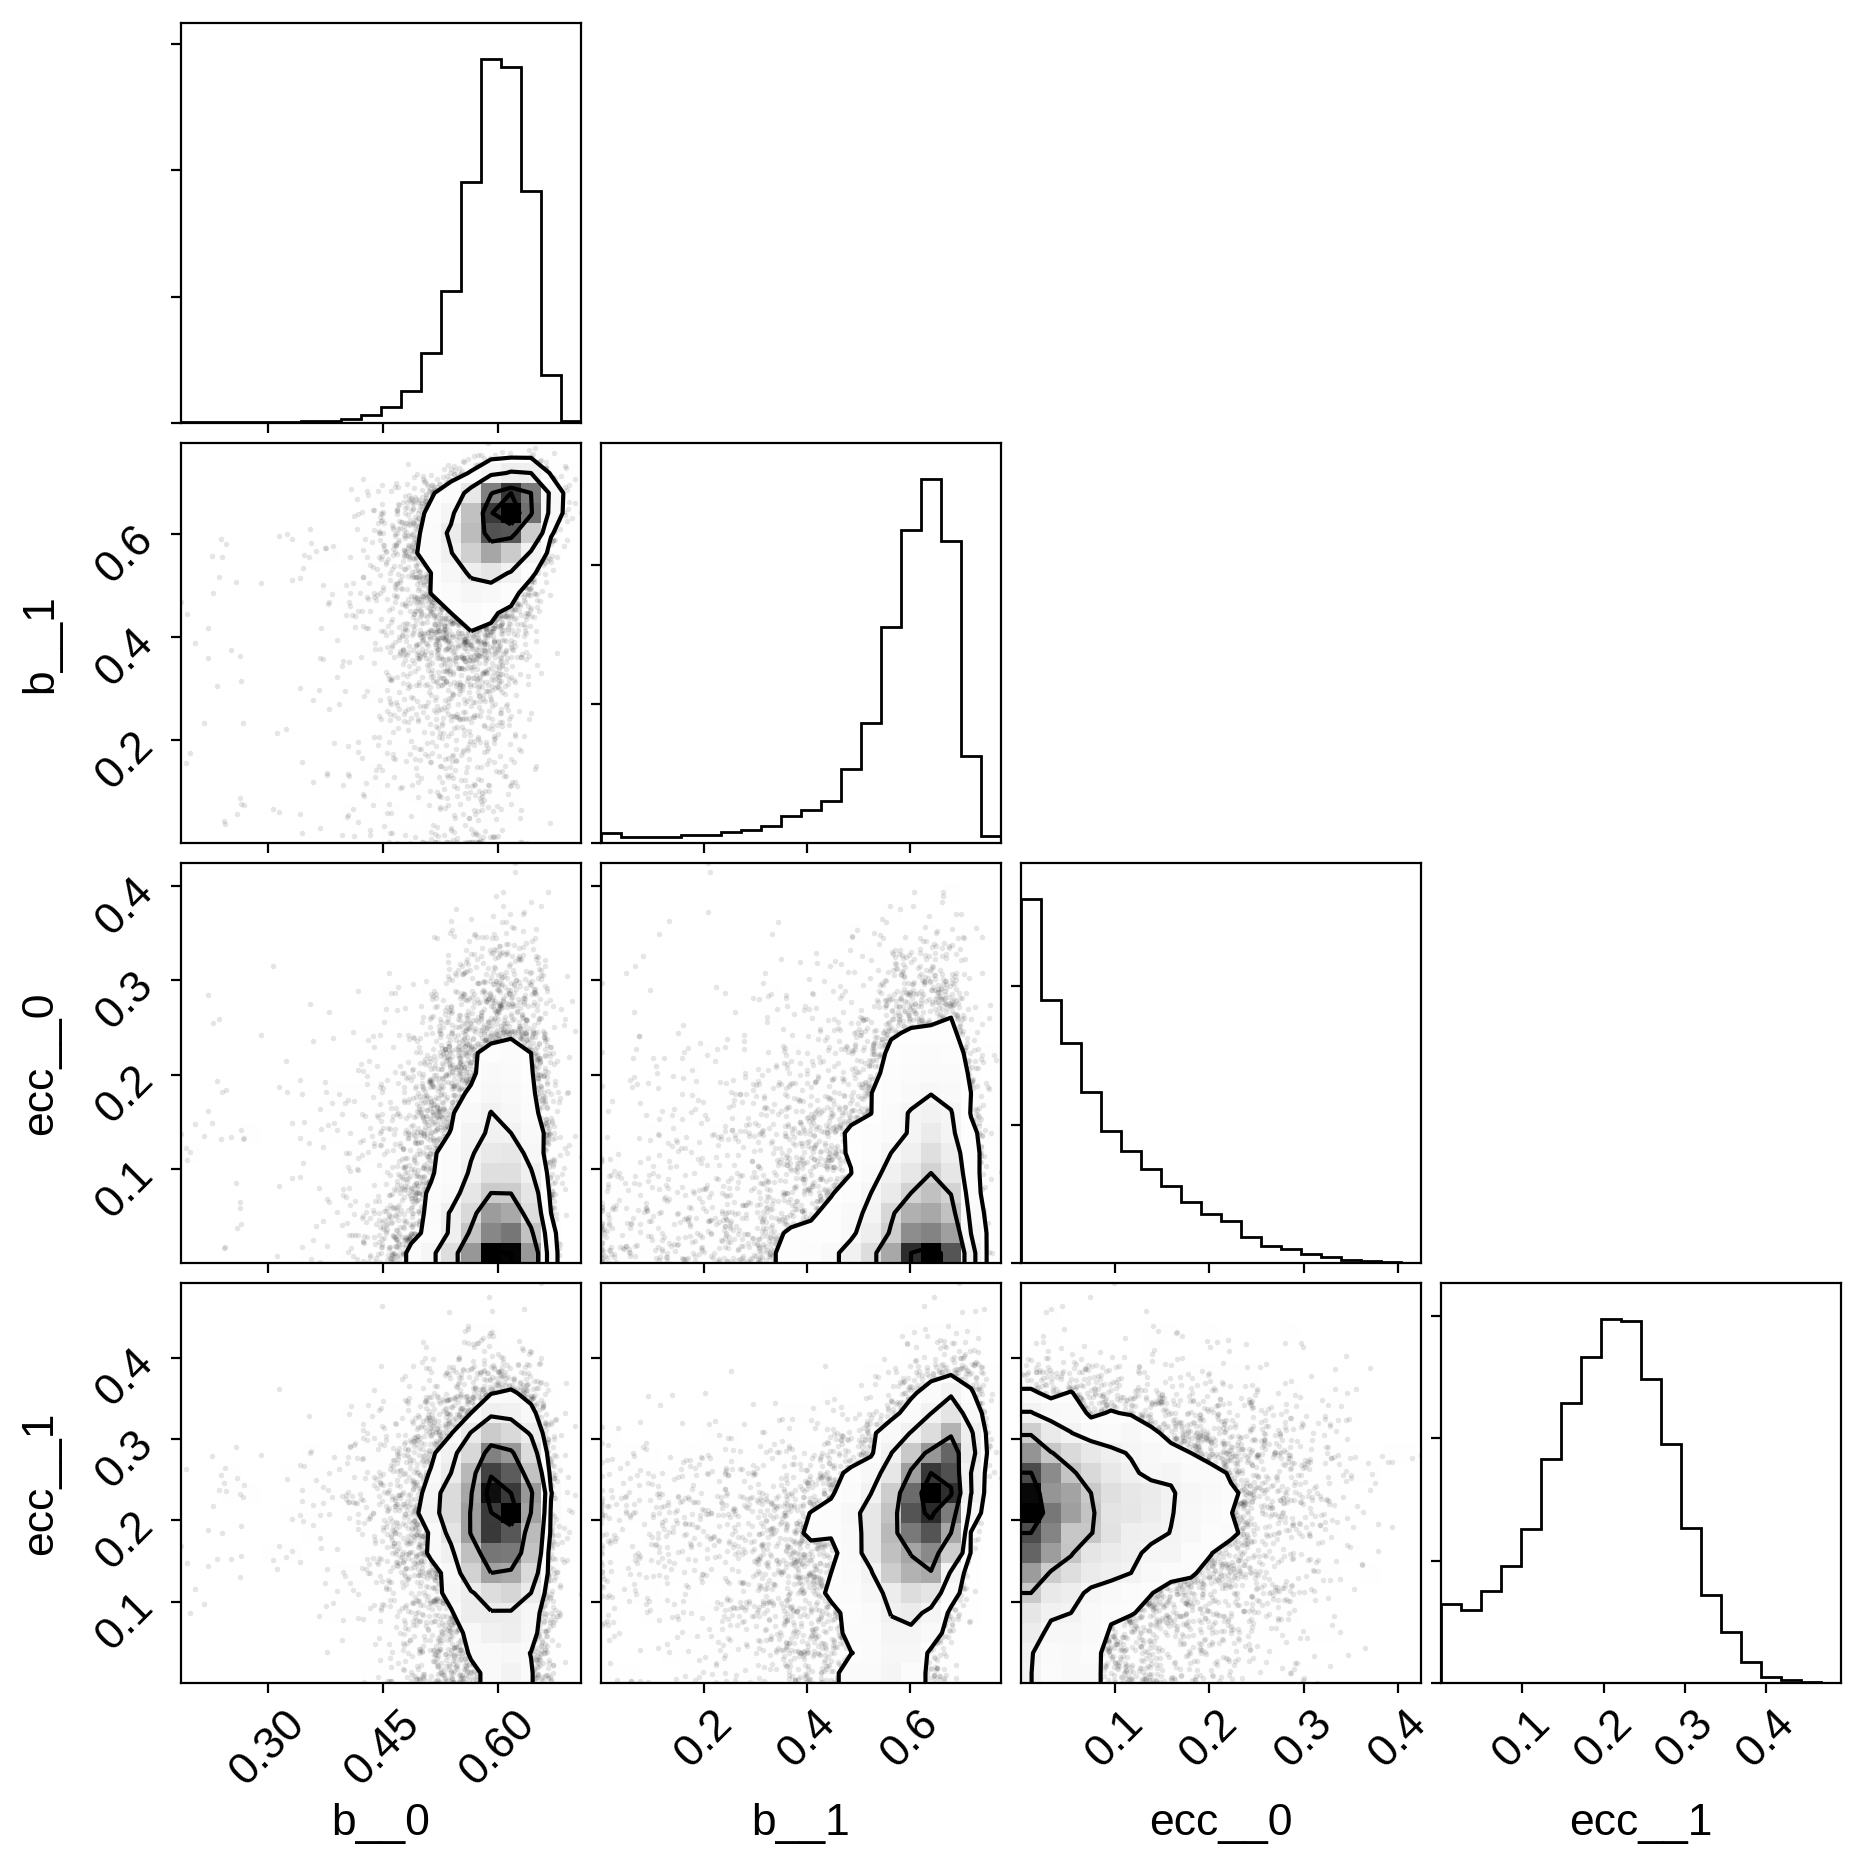

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

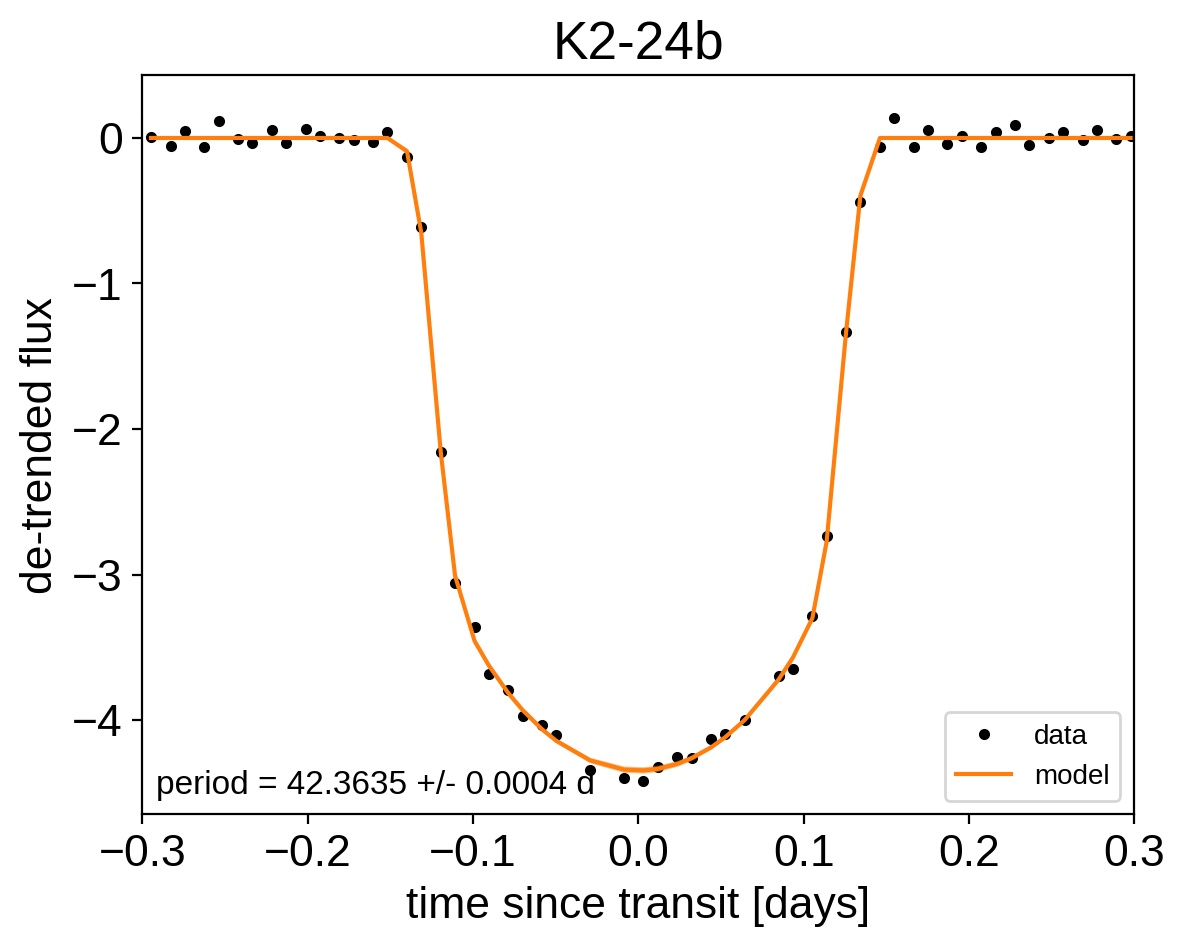

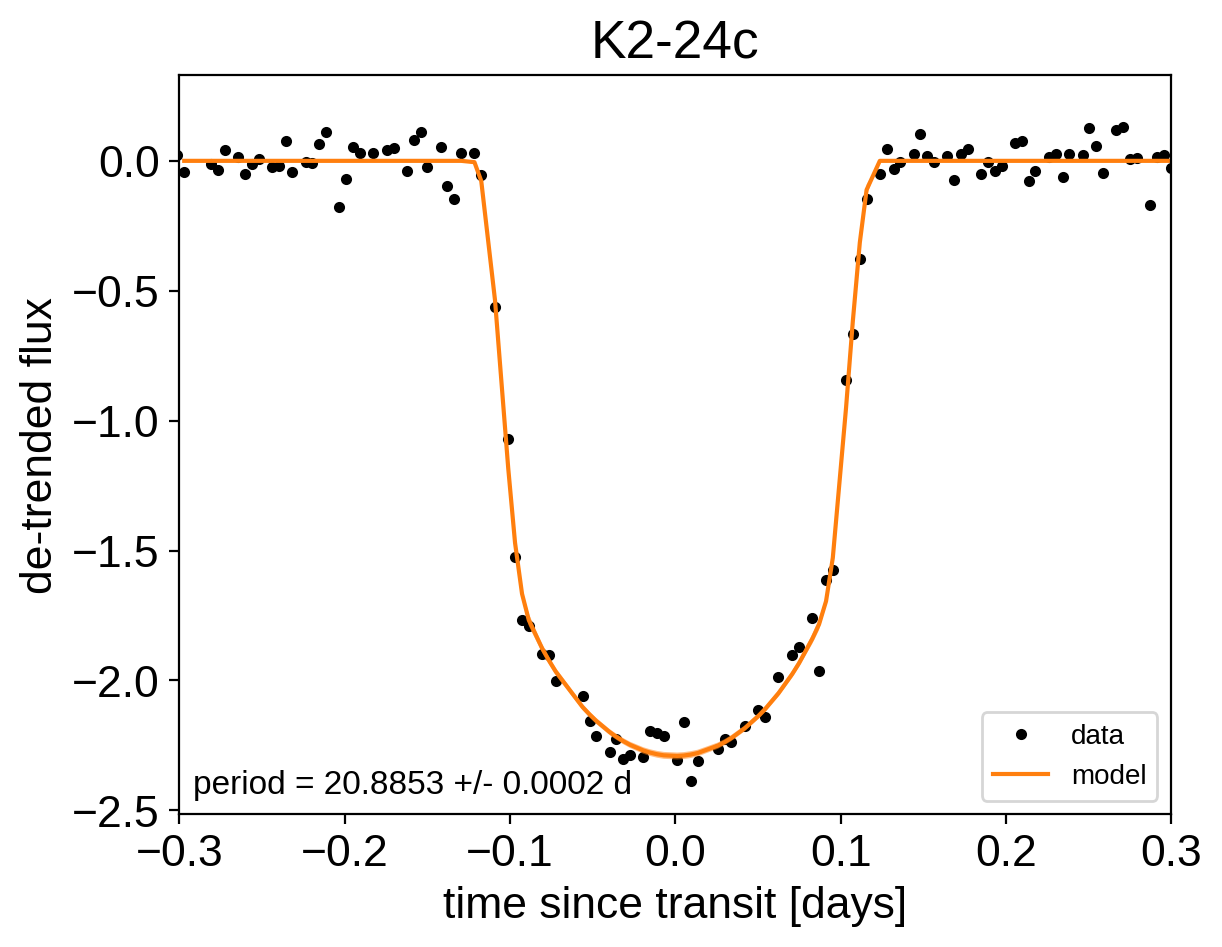

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

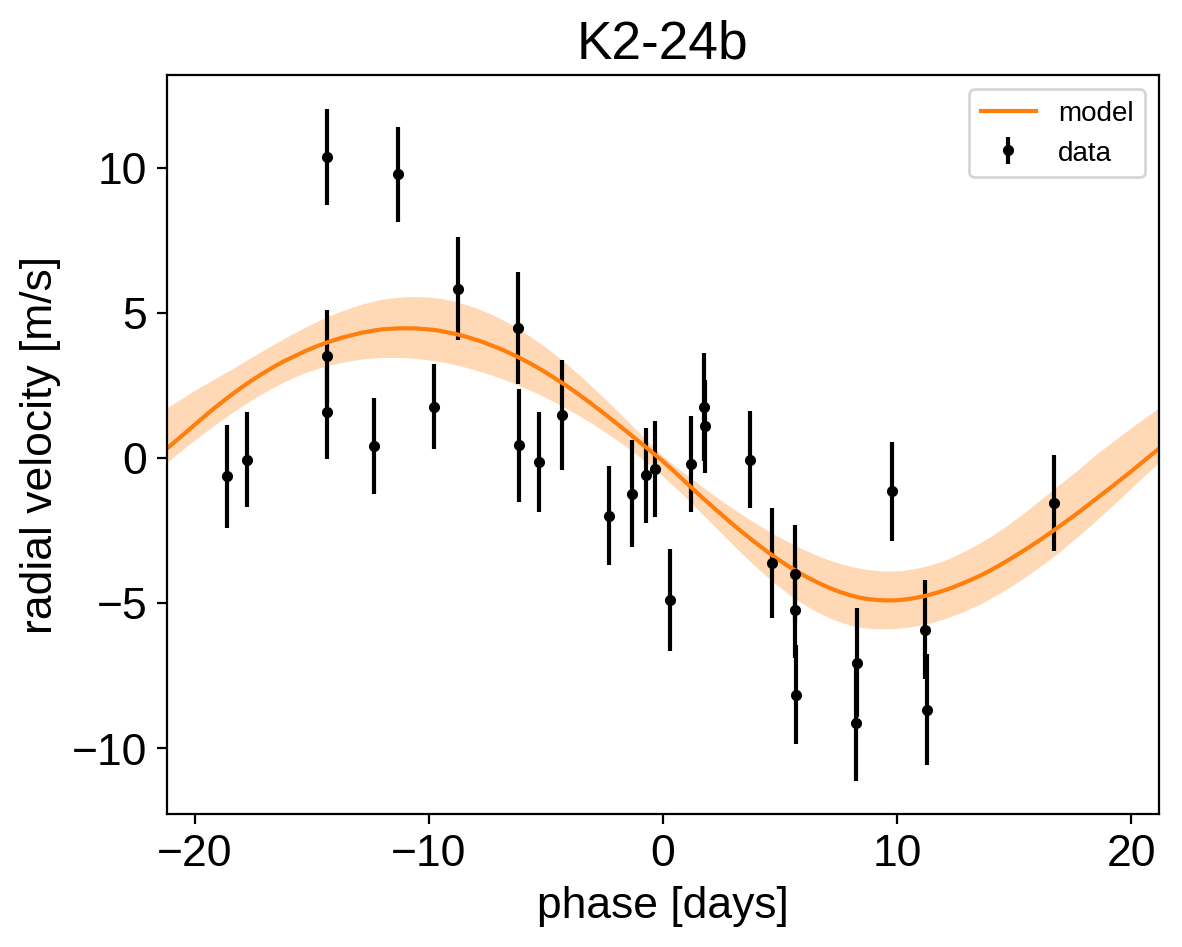

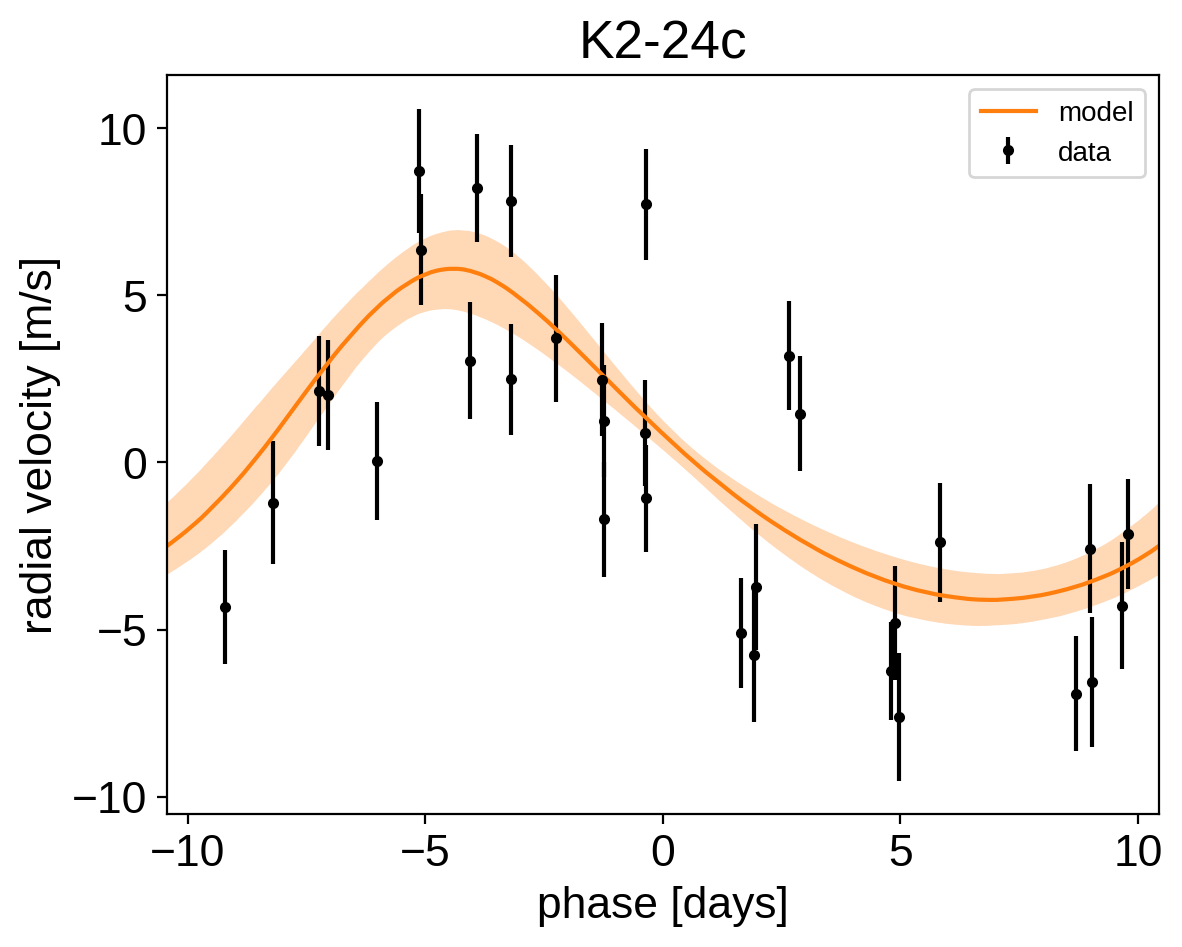

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

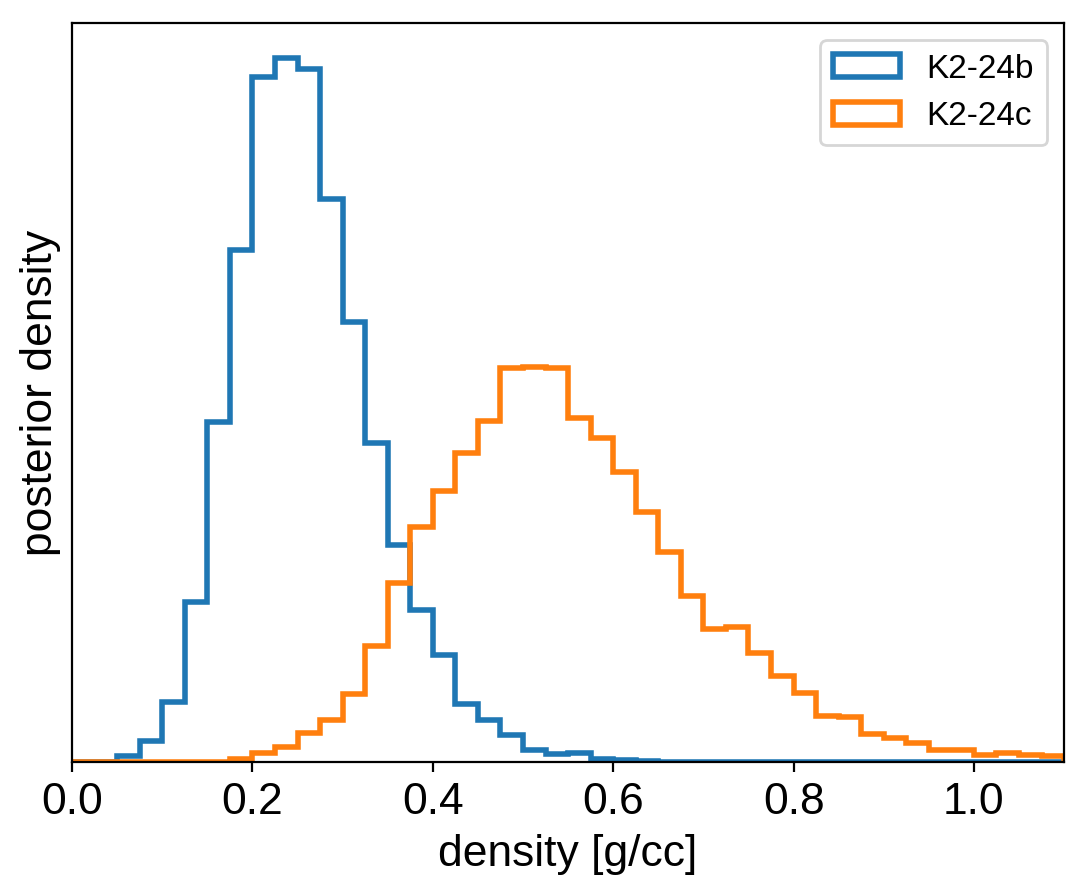

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
